In [1]:
!pip install ..
!pip install datasets
!pip install pycocotools
!pip install bitsandbytes

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Processing /home/jovyan/rashkov/ru-dolph
  Preparing metadata (setup.py) ... done
  Created wheel for rudolph: filename=rudolph-0.0.1rc10-py3-none-any.whl size=23259 sha256=0526f185dd41d4468d6b87d691808e3757bf6a68dd1f11cbe0abb79049955944
  Stored in directory: /tmp/pip-ephem-wheel-cache-n2xwwf2_/wheels/2b/3d/dc/a117001cc39aba083598dd3532c4e0ff93732272b507afb95e
Successfully built rudolph
  Attempting uninstall: rudolph
    Found existing installation: rudolph 0.0.1rc10
    Uninstalling rudolph-0.0.1rc10:
      Successfully uninstalled rudolph-0.0.1rc10
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import torch
from rudalle import get_vae
from rudalle.utils import seed_everything

import sys
sys.path.insert(0, 'ru-dolph')

import os
from glob import glob
from os.path import join
from datetime import datetime

import torch
import bitsandbytes as bnb
from torch.utils.data import Dataset, DataLoader
import torchvision
import transformers
import more_itertools
import numpy as np
import random
import json
from PIL import Image, ImageDraw
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm.auto import tqdm
from einops import rearrange
import youtokentome as yttm

import torchvision
from rudalle.image_prompts import ImagePrompts
from rudolph.model import get_rudolph_model, ruDolphModel, FP16Module
from rudolph import utils
from rudolph.model.utils import get_attention_mask
from rudalle import get_tokenizer, get_vae
from rudolph.api import ruDolphApi

import datasets
import random
from pycocotools.coco import COCO
import json
from PIL import Image

from typing import Any, Callable, Optional, Tuple, List

In [3]:
device = 'cuda'

In [4]:
torch.cuda.empty_cache()

In [5]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [6]:
model = get_rudolph_model('1.3B', pretrained=True, fp16=True, device='cuda')

NEW VERSION!!!!!!
Creating object detection mod model


/home/jovyan/.imgenv-rudolph-object-detection-0/lib/python3.7/site-packages/huggingface_hub/file_download.py:595: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


In [7]:
tokenizer = get_tokenizer()
vae = get_vae(dwt=False).to(device)

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


In [8]:
class Args():
    def __init__(self, model, checkpoint_path):
        self.device = model.get_param('device')
        self.l_text_seq_length = model.get_param('l_text_seq_length')
        self.r_text_seq_length = model.get_param('r_text_seq_length')
        self.image_tokens_per_dim = model.get_param('image_tokens_per_dim')
        self.image_seq_length = model.get_param('image_seq_length')
        self.epochs = 1
        self.save_path= checkpoint_path
        self.model_name = 'rudolph_coco_neg_sampling_2_'
        self.save_every = 10000
        self.bs = 1
        self.clip = 1.0
        self.lr = 2e-5
        self.wandb = False
        self.lt_loss_weight = 0.01
        self.img_loss_weight = 0.01
        self.rt_loss_weight = 7
        self.category_weight = 0
        self.bin_size = 8
        self.image_size = self.image_tokens_per_dim * self.bin_size
        self.categories_num = 80
        
checkpoint_path = '../model/checkpoints/'
args = Args(model, checkpoint_path)
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

In [9]:
SPC_TOKENS = {
    '<LT_UNK>': 16384,
    '<RT_UNK>': 16385,
    '<LT_T2I>': 16386,
    '<LT_I2T>': 16387,
    '<LT_T2T>': 16388,
    '<RT_I2T>': 16389,
    
    '<LT_TQA>': 16390,
    '<RT_TQA>': 16391,
    '<LT_OD>': 16392,
    '<RT_OD>': 16393,
}

In [10]:
for n in range(args.image_tokens_per_dim):
    n_token = SPC_TOKENS['<RT_OD>']+1+n
    SPC_TOKENS['<RT_OD'+str(n)+'>'] = n_token
last_spc_token = n_token

for cat_n in range(args.categories_num+1):
    n_token = last_spc_token + 1 + cat_n
    SPC_TOKENS['<RT_ODC'+str(cat_n)+'>'] = n_token

In [11]:
SPC_TOKENS

{'<LT_UNK>': 16384,
 '<RT_UNK>': 16385,
 '<LT_T2I>': 16386,
 '<LT_I2T>': 16387,
 '<LT_T2T>': 16388,
 '<RT_I2T>': 16389,
 '<LT_TQA>': 16390,
 '<RT_TQA>': 16391,
 '<LT_OD>': 16392,
 '<RT_OD>': 16393,
 '<RT_OD0>': 16394,
 '<RT_OD1>': 16395,
 '<RT_OD2>': 16396,
 '<RT_OD3>': 16397,
 '<RT_OD4>': 16398,
 '<RT_OD5>': 16399,
 '<RT_OD6>': 16400,
 '<RT_OD7>': 16401,
 '<RT_OD8>': 16402,
 '<RT_OD9>': 16403,
 '<RT_OD10>': 16404,
 '<RT_OD11>': 16405,
 '<RT_OD12>': 16406,
 '<RT_OD13>': 16407,
 '<RT_OD14>': 16408,
 '<RT_OD15>': 16409,
 '<RT_OD16>': 16410,
 '<RT_OD17>': 16411,
 '<RT_OD18>': 16412,
 '<RT_OD19>': 16413,
 '<RT_OD20>': 16414,
 '<RT_OD21>': 16415,
 '<RT_OD22>': 16416,
 '<RT_OD23>': 16417,
 '<RT_OD24>': 16418,
 '<RT_OD25>': 16419,
 '<RT_OD26>': 16420,
 '<RT_OD27>': 16421,
 '<RT_OD28>': 16422,
 '<RT_OD29>': 16423,
 '<RT_OD30>': 16424,
 '<RT_OD31>': 16425,
 '<RT_ODC0>': 16426,
 '<RT_ODC1>': 16427,
 '<RT_ODC2>': 16428,
 '<RT_ODC3>': 16429,
 '<RT_ODC4>': 16430,
 '<RT_ODC5>': 16431,
 '<RT_ODC6>': 

In [12]:
image_transform = T.Compose([
    T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
    T.ToTensor(),
    T.Resize((args.image_size, args.image_size))
    ])

In [13]:
exclude_list = np.load('../../data/coco_exclude.npy')

In [26]:
class CocoDetection(Dataset):
    spc_id = -1

    def __init__(
        self,
        root: str,
        ann_file: str,
        tokenizer,
        rus_categories,
        exclude_list,
        args,
        image_transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        super().__init__()
        
        self.tokenizer = tokenizer
        self.tokenizer_eos_id = tokenizer.eos_id
        self.tokenizer_bos_id = tokenizer.bos_id
        self.spc_tokens = SPC_TOKENS

        self.coco = COCO(ann_file)
        self.idxs = list(sorted(self.coco.imgs.keys()))
        for ex_img in exclude_list:
            self.idxs.remove(ex_img)
            
        self.categories = self.coco.dataset['categories']
        self.cat_idxs = list([cat['id'] for cat in self.categories])
        self.cat_idxs_map = {}
        for i, cat in enumerate(self.categories):
            self.cat_idxs_map[str(cat['id'])] = i
        
        self.root = root
        
        self.args = args
        
        self.image_size = args.image_size
        self.bin_size = args.bin_size
        self.r_text_seq_length = args.r_text_seq_length
        self.l_text_seq_length = args.l_text_seq_length
        self.image_tokens_per_dim = args.image_tokens_per_dim
        
        self.image_transform = image_transform
        
        self.encoded_left_text = self.encode_text(rus_categories, args.l_text_seq_length, add_special = True)
        self.encoded_left_text[torch.where(self.encoded_left_text == self.spc_id)] = self.spc_tokens['<LT_OD>']
        
            
    def _load_image(self, idx: int) -> Image.Image:
        coco_image = self.coco.loadImgs(idx)[0]["file_name"]
        return Image.open(os.path.join(self.root, coco_image))

    def _load_target(self, idx: int) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(idx))
    
    def resize_bbox(self, bbox, img_size):
        bbox_x0 = bbox[0]
        bbox_y0 = bbox[1]
        bbox_x1 = bbox_x0+bbox[2]
        bbox_y1 = bbox_y0+bbox[3]
        
        img_w = img_size[0]
        img_h = img_size[1]
        
        max_wh = max(img_w,img_h)

        resized_x0 = int(bbox_x0*self.image_size/img_w)
        resized_y0 = int(bbox_y0*self.image_size/img_h)
        resized_x1 = int(bbox_x1*self.image_size/img_w)
        resized_y1 = int(bbox_y1*self.image_size/img_h)
        return [resized_x0,resized_y0,resized_x1, resized_y1]
    
    def encode_bbox(self, resized_bbox):
        
        bbox_x0_bin = resized_bbox[0]//self.bin_size
        bbox_y0_bin = resized_bbox[1]//self.bin_size
        bbox_x1_bin = min(resized_bbox[2]//self.bin_size, self.image_tokens_per_dim-1)
        bbox_y1_bin = min(resized_bbox[3]//self.bin_size, self.image_tokens_per_dim-1)
        
        new_bbox_tokens = [SPC_TOKENS['<RT_OD'+str(bbox_x0_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_y0_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_x1_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_y1_bin)+'>']]
        
        return new_bbox_tokens
    
    def create_new_box(self):
        bbox_x0_bin = random.randint(0, self.args.image_tokens_per_dim-3)
        bbox_y0_bin = random.randint(0, self.args.image_tokens_per_dim-3)
        bbox_x1_bin = random.randint(bbox_x0_bin, self.args.image_tokens_per_dim-1)
        bbox_y1_bin = random.randint(bbox_y0_bin, self.args.image_tokens_per_dim-1)
        new_bbox_tokens = [SPC_TOKENS['<RT_OD'+str(bbox_x0_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_y0_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_x1_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_y1_bin)+'>'],
                           SPC_TOKENS['<RT_ODC'+str(self.args.categories_num)+'>']
                          ]
        return new_bbox_tokens
    
    def encode_target(self, target, img_size):
        encoded_target = [self.tokenizer_bos_id, SPC_TOKENS['<RT_OD>']]
        for i,tar in enumerate(target):
            paper_cat = tar['category_id']
            cat = self.cat_idxs_map[str(paper_cat)]
            bbox = tar['bbox']
            
            resized_bbox = self.resize_bbox(bbox, img_size)
            encoded_bbox = self.encode_bbox(resized_bbox)
            
            encoded_cat = SPC_TOKENS['<RT_ODC'+str(cat)+'>']
            
            for loc_token in encoded_bbox:
                encoded_target.append(loc_token)
            encoded_target.append(encoded_cat)
        for k in range((self.r_text_seq_length-2-len(encoded_target))//5+1):
            encoded_target += self.create_new_box()
            
        encoded_target.append(SPC_TOKENS['<RT_ODC'+str(self.args.categories_num)+'>'])
        
        return torch.Tensor(encoded_target)
    
    def encode_text(self, text, text_seq_length, add_special = True):
        tokens = self.tokenizer.tokenizer.encode([text], output_type=yttm.OutputType.ID)[0]
        bos = [self.tokenizer.bos_id]
        if add_special:
            bos.append(self.spc_id)
        tokens = bos + tokens + [self.tokenizer.eos_id]
        return self.tokenizer.prepare_tokens(tokens, text_seq_length)
        
    def __getitem__(self, index):
        idx = self.idxs[index]
        image = self._load_image(idx)
        img_size = image.size
        transformed_image = self.image_transform(image)
        
        target = self._load_target(idx)
        encoded_target = self.encode_target(target, img_size)

        return self.encoded_left_text, transformed_image, encoded_target      
    
    def __len__(self):
        return len(self.idxs)

In [27]:
cat_rus_names = ["человек","велосипед","автомобиль","мотоцикл","самолёт","автобус","поезд","грузовик","лодка",
                 "светофор","гидрант","знак стоп","парковочный счетчик","скамейка","птица","кошка","собака",
                "лошадь","овца","корова","слон","медведь","зебра","жираф","рюкзак","зонт","сумочка","галстук",
                "чемодан","фрисби","лыжи","сноуборд","спортивный мяч","воздушный змей","бейсбольная бита",
                 "бейсбольная перчатка","скейтборд","доска для сёрфинга","теннисная ракетка","бутылка","бокал для вина",
                 "чашка","вилка","нож","ложка","миска","банан","яблоко","сэндвич","апельсин","брокколи","морковь",
                 "ход-дог","пицца","пончик","торт","стул","диван","растение в горшке","кровать","обеденный стол","туалет","телевизор",
                 "ноутбук","компьютерная мышь","пульт","клавиатура","мобильный телефон","микроволновка","духовка",
                 "тостер","раковина","холодильник","книга","часы","ваза","ножницы","плюшевый мишка","фен","зубная щётка"]

In [28]:
coco_dataset = CocoDetection(root=r'../../data/train2017',
                             ann_file=r'../../data/annotations/instances_train2017.json',
                             image_transform=image_transform,
                             tokenizer=tokenizer,
                             args = args,
                             exclude_list=exclude_list,
                             rus_categories="|".join(cat_rus_names)
                            )

loading annotations into memory...
Done (t=13.65s)
creating index...
index created!


In [29]:
train_dataloader = DataLoader(coco_dataset, batch_size=args.bs, shuffle=True, drop_last=True)

In [30]:
_,_,tgt = next(iter(train_dataloader))

In [31]:
tgt.size()

torch.Size([1, 128])

In [32]:
def freeze(
    model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
):
    for name, p in model.module.named_parameters():
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
    return model

In [33]:
model.train()
optimizer = bnb.optim.Adam8bit(model.parameters(), lr=args.lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=args.lr, final_div_factor=500, 
    steps_per_epoch=len(train_dataloader), epochs=args.epochs
)

In [34]:
def train(model, optimizer, scheduler, args: Args, train_dataloader, from_checkpoints = False):
    """
      args - arguments for training

      train_dataloader - VisualGenomeDataset
      """
    loss_logs = []
    encoded_right_text = None
    #try:
    t_steps = len(train_dataloader)*args.epochs
    progress = tqdm(total = t_steps, desc='🦌🦌🦌finetuning process🦌🦌🦌')

    save_counter = 0
    start_epoch = 0

    if from_checkpoints:
        save_counter = max([int(f.split('_')[-1].split('.')[0]) for f in os.listdir(args.save_path) if f.startswith(args.model_name)])
        model, optimizer, start_epoch, loss_logs = load_checkpoint(model, optimizer, loss_logs, filename=os.path.join(args.save_path,f"{args.model_name}state_{save_counter}.pt"))
        start_epoch -= 1

    for epoch in range(start_epoch, args.epochs):

        for encoded_left_text, images, encoded_right_text in train_dataloader: #, prompt, image, locs

            bs_text = encoded_right_text.shape[0]

            images = images.to(device)

            image_seq_length = args.image_tokens_per_dim ** 2
            total_seq_length = args.l_text_seq_length + image_seq_length + args.r_text_seq_length
            encoded_images = vae.get_codebook_indices(images, disable_gumbel_softmax=True)

            attention_mask_text = get_attention_mask(bs_text, args.l_text_seq_length,
                                             args.image_tokens_per_dim, 
                                             args.r_text_seq_length, args.device)
            
            input_ids_text = torch.cat((encoded_left_text.to(args.device).int(),
                            encoded_images.int(),
                            encoded_right_text.to(args.device).int()), dim=1)
            loss, loss_values = model.forward(input_ids_text.long(), attention_mask_text, 
                                                             lt_loss_weight=args.lt_loss_weight,
                                                             img_loss_weight=args.img_loss_weight, 
                                                             rt_loss_weight=args.rt_loss_weight,
                                              return_loss=True,
                                              category_weight=args.category_weight,
                                              fake_category_token = SPC_TOKENS['<RT_ODC'+str(args.categories_num)+'>']
                                             )


            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(),args.clip)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            save_counter += 1
            if save_counter % args.save_every == 0:
                print(f'Saving checkpoint here {args.model_name}_rudolph_{save_counter}.pt')
                plt.plot(loss_logs)
                plt.show()
                state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
                         'optimizer': optimizer.state_dict(), 'losslogger': loss_logs}
                torch.save(
                    model.state_dict(),
                    os.path.join(args.save_path,f"{args.model_name}rudolph_{save_counter}.pt")
                )
                torch.save(
                    state,
                    os.path.join(args.save_path,f"{args.model_name}state_{save_counter}.pt")
                )

            loss_logs+=[loss.item()]
            progress.update()
            progress.set_postfix({"loss": loss.item()})

        print(f'Complitly tuned and saved here  {args.model_name}__object_detection_last.pt')
        plt.plot(loss_logs)
        plt.show()
        torch.save(
            model.state_dict(),
            os.path.join(args.save_path,f"{args.model_name}object_detection_last.pt")
        )

🦌🦌🦌finetuning process🦌🦌🦌:   0%|          | 0/114414 [00:00<?, ?it/s]

Saving checkpoint here rudolph_coco_neg_sampling_2__rudolph_10000.pt


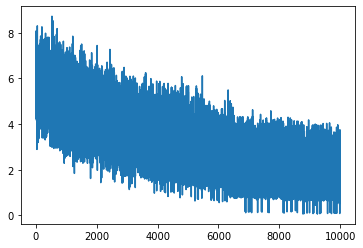

Saving checkpoint here rudolph_coco_neg_sampling_2__rudolph_20000.pt


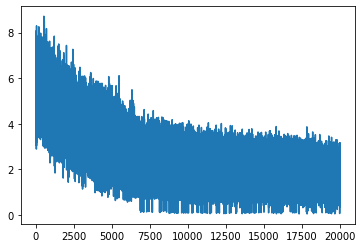

Saving checkpoint here rudolph_coco_neg_sampling_2__rudolph_30000.pt


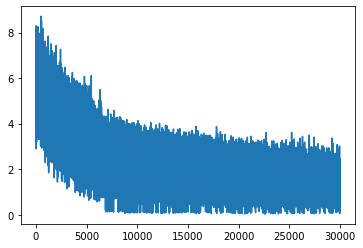

Saving checkpoint here rudolph_coco_neg_sampling_2__rudolph_40000.pt


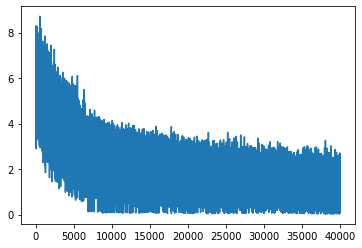

Saving checkpoint here rudolph_coco_neg_sampling_2__rudolph_50000.pt


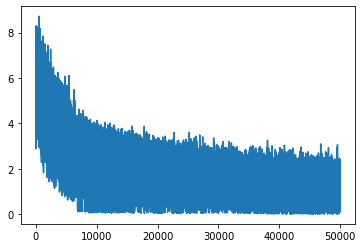

Saving checkpoint here rudolph_coco_neg_sampling_2__rudolph_60000.pt


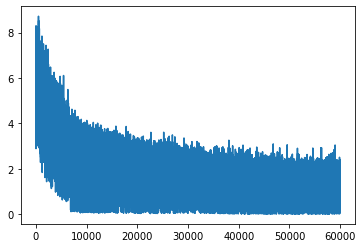

Saving checkpoint here rudolph_coco_neg_sampling_2__rudolph_70000.pt


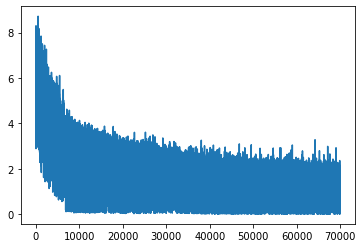

Saving checkpoint here rudolph_coco_neg_sampling_2__rudolph_80000.pt


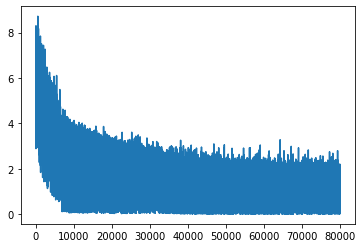

Saving checkpoint here rudolph_coco_neg_sampling_2__rudolph_90000.pt


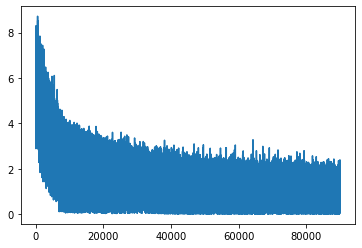

Saving checkpoint here rudolph_coco_neg_sampling_2__rudolph_100000.pt


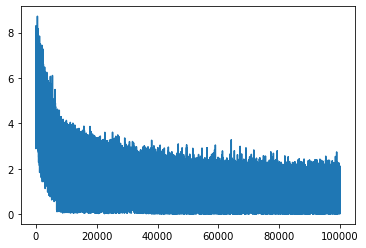

Saving checkpoint here rudolph_coco_neg_sampling_2__rudolph_110000.pt


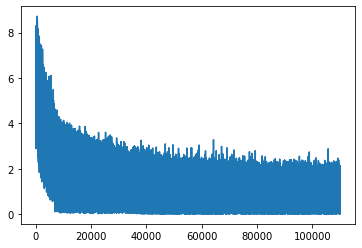

Complitly tuned and saved here  rudolph_coco_neg_sampling_2___object_detection_last.pt


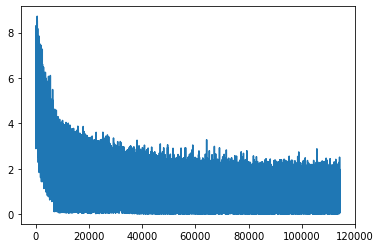

In [35]:
model = freeze(
    model=model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
)

train(model, optimizer, scheduler, args, train_dataloader, from_checkpoints=False)

In [36]:
def loc_to_coords(token:int) -> float:
    num_token = token - SPC_TOKENS['<RT_PG>']-1
    return args.bin_size*num_token

def calc_area(bbox):
    w = bbox[2]-bbox[0]
    h = bbox[3]-bbox[1]
    return w*h

def tokens_to_bbox(tokens):
    bbox = torch.zeros(1,4)
    bbox[0,0] = loc_to_coords(tokens[0])
    bbox[0,1] = loc_to_coords(tokens[1])
    bbox[0,2] = loc_to_coords(tokens[2])
    bbox[0,3] = loc_to_coords(tokens[3])
    return bbox

def tokens_iou(pred_tokens, ground_truth_bbox):
    pred_bbox = tokens_to_bbox(pred_tokens)
    print(pred_bbox,ground_truth_bbox)
    iou = ops.box_iou(ground_truth_bbox, pred_bbox)
    return iou

In [37]:
exclude_val_list = np.load('../../data/coco_val_exclude.npy')

In [38]:
coco_dataset_val = CocoDetection(root=r'../../data/val2017',
                             ann_file=r'../../data/annotations/instances_val2017.json',
                             image_transform=image_transform,
                             tokenizer=tokenizer,
                             args = args,
                             exclude_list=exclude_val_list,rus_categories="|".join(cat_rus_names)
                            )

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [39]:
def decode_right(right_tokens, length=None, scores=True):
    boxes = torch.zeros((length, 4))
    labels = (SPC_TOKENS['<RT_ODC80>']-SPC_TOKENS['<RT_ODC0>'])*torch.ones(length)
    scores = torch.zeros(length)
    
    for k in range(len(right_tokens)//5):
        labels[k] = right_tokens[(k+1)*5-1].unsqueeze(0).cpu() - SPC_TOKENS['<RT_ODC0>']
        boxes[k,:] = right_tokens[k*5:(k+1)*5-1].unsqueeze(0).cpu()
        scores[k] = 1
        
    boxes -= SPC_TOKENS['<RT_OD0>']*torch.ones((length, 4))
    boxes *= args.bin_size

    return [{'boxes':boxes, 'labels':labels, 'scores':scores}]

In [40]:
class ruDolphPhraseGroundingApi(ruDolphApi):
    def __init__(self, model, tokenizer, vae, spc_tokens=None, quite=False, *, bs=24, q=0.5, txt_top_k=64,
                 img_top_k=768, txt_top_p=0.8, img_top_p=0.99, txt_temperature=0.9, img_temperature=1.0):
        
        super().__init__(model = model, tokenizer = tokenizer, vae = vae, spc_tokens = spc_tokens, quite = quite, bs = bs, q = q, txt_top_k = txt_top_k,
                 img_top_k = img_top_k, txt_top_p = txt_top_p, img_top_p = img_top_p, txt_temperature = txt_temperature, img_temperature = img_temperature)
    
    def generate_text_answers(self, image_tokens, left_text, vocab_size, top_k, top_p, temperature=1.0,
                              use_cache=True, template='', allowed_token_ids=None, special_token=''):
        '''
            Generate right text tokens.
        '''
        self.model.eval()
        torch.cuda.empty_cache()
        generated_tokens = []
        chunk_bs = left_text.shape[0]
        
        template = template.lower().strip()
        template_encoded = self.encode_text(template, text_seq_length=self.r_text_seq_length)
        
        template_size = (template_encoded != 0).sum() - 1  # eos
        
        template_encoded = template_encoded[:template_size]
        template_encoded[torch.where(template_encoded == self.spc_id)] = self.spc_tokens[special_token]
        
        #print('Decoded sequence', self.decode_text(template_encoded))

        with torch.no_grad():
            attention_mask = self.get_attention_mask(chunk_bs)

            out = torch.cat((
                left_text.to(self.device),
                image_tokens,
                template_encoded.repeat(chunk_bs, 1).to(self.device),
            ), dim=1)

            cache = None
            iter_range = range(
                self.l_text_seq_length + self.image_seq_length + template_size, 
                self.l_text_seq_length + self.image_seq_length + self.r_text_seq_length
            )
            
            if not self.quite:
                iter_range = tqdm(iter_range)
                
            for _ in iter_range:  
                logits, cache = self.model(out, attention_mask, cache=cache, use_cache=use_cache, return_loss=False)
                
                logits = logits[:, -1, :self.vocab_size]
            
                if allowed_token_ids:
                    logits = logits[:, allowed_token_ids]
            
                logits /= temperature
                filtered_logits = transformers.top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
                probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
                sample = torch.multinomial(probs, 1)
            
                if allowed_token_ids:
                        sample = torch.tensor(allowed_token_ids).to(self.device)[sample]
            
                indexes = torch.where(sample >= self.vocab_size - self.l_text_seq_length)
                sample[indexes] = 3
                out = torch.cat((out, sample), dim=-1)

            generated_tokens.append(out[:, -self.r_text_seq_length:])

        tokens = torch.cat(generated_tokens)[:,:]

        return tokens

In [ ]:
api = ruDolphPhraseGroundingApi(model, tokenizer, vae, spc_tokens=SPC_TOKENS)
metric = MeanAveragePrecision()
pred_lens = []
tgt_lens = []
#preds = []
#tgts = []
allowed_token_ids = list(SPC_TOKENS.values())+[0,3]

val_dataloader = DataLoader(coco_dataset_val, batch_size=1, shuffle=False)

for i,batch in enumerate(val_dataloader):
    encoded_left_text, images, encoded_right_text = batch
    
    bs_text = encoded_left_text.shape[0]

    images = images.to(device)

    image_seq_length = args.image_tokens_per_dim ** 2
    total_seq_length = args.l_text_seq_length + image_seq_length + args.r_text_seq_length
    encoded_images = vae.get_codebook_indices(images, disable_gumbel_softmax=True)

    ## Генерируем правые текстовые токены
    pred_tokens = api.generate_text_answers(encoded_images, encoded_left_text.type(torch.LongTensor), api.vocab_size, 
                                top_k=32, top_p=0.8, temperature=1.0, template = '', 
                                allowed_token_ids =allowed_token_ids, special_token='<RT_OD>')
    fake_cat_token = SPC_TOKENS['<RT_ODC'+str(args.categories_num)+'>']
    
    target_fake_cat_token_idxs = torch.where(encoded_right_text[0,:]==fake_cat_token)[0]
    if len(target_fake_cat_token_idxs)>0:
        target_end_idx = min(target_fake_cat_token_idxs)-4
    else:
        target_end_idx=args.r_text_seq_length
    
    if len(torch.where(pred_tokens[0,:]==fake_cat_token)[0])>0:
        pred_end_idx = min(torch.where(pred_tokens[0,:]==fake_cat_token)[0].cpu().numpy())-4
    else:
        pred_end_idx=args.r_text_seq_length
        
    target_len = (target_end_idx-2)//5
    pred_len = (pred_end_idx-2)//5
    
    pred = decode_right(pred_tokens[0,2:pred_end_idx], length=max(target_len,pred_len))
    target = decode_right(encoded_right_text[0,2:target_end_idx], length=max(target_len,pred_len))
    metric.update(pred, target)
    
    '''preds.append(pred)
    tgts.append(target)
    if i>500:
        break'''

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16405, 16402, 16413, 16488, 16410, 16408, 16413,
         16410, 16484, 16406, 16408, 16407, 16409, 16484, 16421, 16420, 16422,
         16423, 16465, 16420, 16409, 16425, 16415, 16488, 16409, 16409, 16409,
         16410, 16484, 16408, 16409, 16412, 16420, 16486, 16416, 16405, 16417,
         16407, 16499, 16412, 16406, 16413, 16409, 16501, 16412, 16409, 16413,
         16411, 16501, 16408, 16408, 16409, 16409, 16501, 16414, 16408, 16414,
         16409, 16501, 16420, 16419, 16421, 16421, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16397, 16425, 16425, 16447, 16415, 16394, 16418,
         16397, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16411, 16414, 16425, 16485, 16414, 16400, 16414,
         16403, 16499, 16417, 16402, 16418, 16404, 16499, 16418, 16402, 16419,
         16404, 16499, 16417, 16399, 16419, 16401, 16499, 16418, 16398, 16419,
         16399, 16499, 16416, 16404, 16417, 16405, 16499, 16416, 16405, 16418,
         16407, 16499, 16418, 16403, 16419, 16405, 16499, 16416, 16405, 16417,
         16407, 16499, 16415, 16402, 16416, 16404, 16499, 16416, 16403, 16417,
         16405, 16499, 16417, 16399, 16417, 16400, 16499, 16417, 16402, 16417,
         16404, 16499, 16418, 16398, 16420, 16400, 16499, 16415, 16398, 16415,
         16400, 16499, 16418, 16402, 16419, 16405, 16499, 16417, 16398, 16417,
         16399, 16499, 16416, 16402, 16417, 16404, 16499, 16419, 16402, 16420,
         16404, 16499, 16416, 16400, 16417, 16402, 16499, 16417, 16404, 16418,
         16406, 16499, 16415, 16401, 16416, 16403, 16499, 16415, 16394, 16417,
         16397, 16499, 16416, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16398, 16415, 16407, 16437, 16399, 16411, 16406,
         16414, 16433, 16417, 16412, 16418, 16413, 16439, 16415, 16412, 16415,
         16413, 16439, 16417, 16412, 16417, 16412, 16426, 16416, 16412, 16417,
         16413, 16439, 16419, 16412, 16419, 16413, 16439, 16414, 16411, 16415,
         16412, 16426, 16420, 16412, 16420, 16412, 16426, 16412, 16411, 16413,
         16412, 16426, 16417, 16411, 16417, 16412, 16426, 16412, 16412, 16412,
         16412, 16426, 16419, 16411, 16419, 16412, 16426, 16415, 16411, 16415,
         16412, 16426, 16420, 16411, 16421, 16412, 16426, 16420, 16412, 16421,
         16412, 16426, 16418, 16412, 16419, 16412, 16426, 16415, 16412, 16415,
         16412, 16426, 16394, 16412, 16423, 16414, 16426, 16404, 16412, 16406,
         16413, 16426, 16417, 16412, 16418, 16412, 16426, 16412, 16411, 16413,
         16411, 16426, 16404, 16412, 16405, 16412, 16426, 16415, 16412, 16416,
         16412, 16426, 16406, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16409, 16409, 16503, 16410, 16394, 16425,
         16420, 16503, 16394, 16406, 16419, 16425, 16503, 16394, 16406, 16418,
         16425, 16503, 16394, 16394, 16425, 16425, 16503, 16403, 16394, 16425,
         16413, 16503, 16394, 16407, 16416, 16425, 16503, 16403, 16394, 16423,
         16399, 16503, 16401, 16394, 16411, 16397, 16503, 16401, 16394, 16409,
         16396, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16396, 16418, 16422, 16426, 16403, 16421, 16422,
         16424, 16456, 16403, 16397, 16403, 16398, 16426, 16405, 16398, 16405,
         16398, 16426, 16402, 16397, 16402, 16397, 16426, 16404, 16396, 16404,
         16397, 16426, 16408, 16398, 16407, 16399, 16426, 16408, 16420, 16418,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16403, 16418, 16420, 16498, 16397, 16409, 16405,
         16419, 16495, 16406, 16410, 16412, 16411, 16497, 16397, 16412, 16404,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16399, 16414, 16424, 16426, 16411, 16399, 16416,
         16405, 16461, 16406, 16399, 16414, 16415, 16426, 16413, 16401, 16415,
         16403, 16461, 16401, 16408, 16402, 16411, 16458, 16409, 16402, 16411,
         16404, 16461, 16424, 16407, 16425, 16411, 16482, 16404, 16410, 16408,
         16412, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16408, 16407, 16411, 16458, 16407, 16401, 16414,
         16423, 16426, 16422, 16394, 16425, 16413, 16426, 16405, 16409, 16408,
         16413, 16464, 16400, 16394, 16403, 16395, 16426, 16412, 16411, 16414,
         16415, 16464, 16409, 16394, 16412, 16396, 16426, 16414, 16412, 16419,
         16416, 16482, 16410, 16394, 16412, 16395, 16482, 16415, 16411, 16417,
         16413, 16482, 16409, 16394, 16410, 16395, 16482, 16394, 16394, 16395,
         16395, 16482, 16399, 16394, 16403, 16395, 16482, 16394, 16394, 16425,
         16411, 16426, 16411, 16408, 16412, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16416, 16410, 16421, 16465, 16412, 16408, 16420,
         16425, 16426, 16402, 16402, 16405, 16420, 16426, 16415, 16405, 16417,
         16410, 16426, 16403, 16401, 16407, 16420, 16426, 16413, 16401, 16418,
         16416, 16426, 16398, 16404, 16401, 16420, 16426, 16395, 16407, 16399,
         16420, 16426, 16415, 16407, 16425, 16425, 16426, 16411, 16401, 16415,
         16425, 16426, 16413, 16403, 16416, 16407, 16426, 16416, 16410, 16421,
         16421, 16464, 16404, 16404, 16406, 16420, 16426, 16400, 16405, 16402,
         16411, 16426, 16395, 16410, 16397, 16412, 16455, 16394, 16412, 16395,
         16417, 16450, 16417, 16406, 16419, 16409, 16482, 16403, 16410, 16408,
         16420, 16482, 16416, 16407, 16418, 16409, 16482, 16412, 16409, 16413,
         16409, 16482, 16414, 16411, 16416, 16412, 16482, 16394, 16413, 16396,
         16417, 16482, 16421, 16408, 16425, 16411, 16482, 16401, 16404, 16403,
         16412, 16426, 16395, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16411, 16396, 16415, 16465, 16404, 16411, 16407,
         16413, 16440, 16394, 16409, 16396, 16415, 16426, 16418, 16407, 16422,
         16425, 16426, 16394, 16411, 16395, 16415, 16426, 16397, 16402, 16398,
         16403, 16434, 16403, 16403, 16404, 16404, 16434, 16418, 16402, 16420,
         16407, 16426, 16398, 16403, 16399, 16403, 16426, 16401, 16403, 16403,
         16403, 16434, 16402, 16403, 16403, 16404, 16434, 16394, 16402, 16395,
         16403, 16434, 16394, 16411, 16396, 16414, 16434, 16400, 16402, 16400,
         16403, 16434, 16396, 16401, 16397, 16402, 16434, 16403, 16404, 16404,
         16404, 16434, 16401, 16401, 16401, 16402, 16435, 16395, 16400, 16396,
         16402, 16434, 16394, 16401, 16394, 16403, 16434, 16394, 16403, 16395,
         16403, 16434, 16400, 16403, 16399, 16403, 16434, 16394, 16403, 16398,
         16404, 16434, 16394, 16410, 16396, 16412, 16426, 16403, 16403, 16404,
         16403, 16428, 16403, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16399, 16421, 16407, 16493, 16394, 16394, 16425,
         16425, 16426, 16394, 16401, 16401, 16412, 16426, 16420, 16396, 16425,
         16408, 16426, 16419, 16397, 16425, 16409, 16426, 16411, 16407, 16415,
         16413, 16493, 16411, 16395, 16425, 16407, 16426, 16394, 16394, 16401,
         16399, 16426, 16417, 16394, 16425, 16403, 16426, 16394, 16394, 16401,
         16402, 16426, 16399, 16394, 16402, 16396, 16426, 16420, 16394, 16425,
         16400, 16426, 16396, 16394, 16401, 16397, 16426, 16421, 16394, 16425,
         16396, 16426, 16423, 16394, 16425, 16397, 16426, 16419, 16395, 16425,
         16406, 16426, 16394, 16403, 16397, 16413, 16426, 16423, 16394, 16425,
         16398, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16406, 16414, 16425, 16426, 16410, 16405, 16417,
         16418, 16426, 16409, 16408, 16414, 16411, 16426, 16411, 16406, 16417,
         16408, 16426, 16411, 16399, 16417, 16407, 16482, 16399, 16415, 16415,
         16425, 16489, 16400, 16416, 16414, 16425, 16454, 16399, 16410, 16414,
         16419, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16406, 16425, 16417, 16467, 16397, 16406, 16414,
         16418, 16474, 16412, 16394, 16425, 16405, 16482, 16394, 16394, 16412,
         16409, 16426, 16394, 16415, 16425, 16425, 16486, 16394, 16413, 16425,
         16425, 16486, 16394, 16394, 16425, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16405, 16419, 16418, 16426, 16411, 16416, 16423,
         16419, 16463, 16412, 16417, 16423, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16396, 16418, 16406, 16488, 16394, 16407, 16402,
         16424, 16489, 16410, 16414, 16425, 16420, 16492, 16419, 16412, 16421,
         16415, 16490, 16408, 16414, 16425, 16421, 16492, 16424, 16407, 16425,
         16412, 16465, 16417, 16409, 16420, 16412, 16482, 16394, 16408, 16404,
         16425, 16489, 16420, 16405, 16425, 16412, 16482, 16422, 16406, 16425,
         16413, 16465, 16421, 16409, 16422, 16411, 16465, 16423, 16408, 16425,
         16411, 16465, 16422, 16407, 16423, 16409, 16465, 16424, 16409, 16425,
         16411, 16465, 16423, 16408, 16425, 16410, 16465, 16423, 16409, 16425,
         16411, 16465, 16421, 16406, 16422, 16408, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16419, 16418, 16423, 16428, 16394, 16419, 16400,
         16425, 16428, 16394, 16418, 16397, 16421, 16428, 16418, 16419, 16420,
         16423, 16428, 16403, 16417, 16415, 16425, 16428, 16414, 16419, 16419,
         16422, 16433, 16416, 16419, 16418, 16421, 16428, 16403, 16418, 16404,
         16420, 16428, 16401, 16420, 16403, 16421, 16428, 16401, 16419, 16403,
         16422, 16428, 16403, 16419, 16403, 16419, 16428, 16403, 16418, 16405,
         16421, 16428, 16401, 16419, 16402, 16421, 16428, 16402, 16419, 16403,
         16419, 16428, 16416, 16419, 16419, 16422, 16428, 16400, 16418, 16401,
         16419, 16428, 16403, 16419, 16404, 16419, 16428, 16413, 16419, 16416,
         16421, 16428, 16420, 16420, 16421, 16421, 16428, 16401, 16418, 16402,
         16419, 16428, 16413, 16420, 16415, 16421, 16433, 16404, 16420, 16405,
         16422, 16428, 16400, 16420, 16401, 16421, 16433, 16400, 16419, 16400,
         16420, 16428, 16395, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16397, 16420, 16421, 16431, 16399, 16414, 16400,
         16416, 16426, 16411, 16411, 16412, 16413, 16426, 16411, 16412, 16412,
         16413, 16426, 16413, 16413, 16414, 16414, 16426, 16422, 16410, 16424,
         16414, 16431, 16420, 16410, 16421, 16412, 16426, 16423, 16410, 16425,
         16414, 16431, 16401, 16414, 16401, 16415, 16426, 16421, 16410, 16421,
         16412, 16426, 16398, 16413, 16399, 16415, 16426, 16396, 16412, 16396,
         16414, 16426, 16398, 16414, 16398, 16416, 16426, 16397, 16413, 16397,
         16414, 16426, 16396, 16413, 16397, 16414, 16426, 16399, 16414, 16400,
         16416, 16426, 16400, 16413, 16401, 16415, 16426, 16394, 16412, 16394,
         16413, 16426, 16399, 16414, 16399, 16415, 16426, 16395, 16411, 16397,
         16413, 16426, 16400, 16413, 16399, 16414, 16426, 16396, 16414, 16397,
         16415, 16426, 16395, 16412, 16395, 16413, 16426, 16402, 16413, 16403,
         16414, 16426, 16396, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16415, 16441, 16394, 16413, 16425,
         16425, 16488, 16394, 16414, 16425, 16425, 16489, 16394, 16394, 16407,
         16414, 16441, 16394, 16416, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16395, 16410, 16397, 16430, 16415, 16400, 16419,
         16403, 16430, 16419, 16401, 16419, 16402, 16430, 16416, 16401, 16418,
         16402, 16430, 16406, 16394, 16410, 16396, 16430, 16407, 16423, 16407,
         16424, 16430, 16412, 16422, 16412, 16423, 16433, 16416, 16424, 16417,
         16425, 16433, 16418, 16424, 16418, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16448, 16417, 16412, 16425,
         16425, 16448, 16404, 16402, 16417, 16418, 16448, 16394, 16394, 16419,
         16425, 16448, 16394, 16407, 16396, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16412, 16404, 16425, 16482, 16406, 16408, 16424,
         16423, 16485, 16423, 16417, 16424, 16419, 16499, 16394, 16413, 16397,
         16425, 16486, 16400, 16412, 16405, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16399, 16423, 16422, 16431, 16394, 16410, 16396,
         16418, 16426, 16394, 16409, 16395, 16413, 16426, 16406, 16407, 16407,
         16410, 16426, 16398, 16411, 16399, 16413, 16450, 16406, 16409, 16406,
         16410, 16426, 16396, 16409, 16396, 16410, 16426, 16407, 16409, 16408,
         16411, 16426, 16402, 16409, 16403, 16410, 16426, 16403, 16407, 16404,
         16409, 16426, 16397, 16411, 16397, 16412, 16426, 16404, 16408, 16405,
         16409, 16426, 16404, 16406, 16405, 16409, 16426, 16398, 16409, 16398,
         16410, 16426, 16399, 16410, 16399, 16411, 16426, 16395, 16411, 16395,
         16413, 16426, 16404, 16406, 16404, 16408, 16426, 16397, 16411, 16397,
         16412, 16426, 16398, 16411, 16398, 16413, 16452, 16397, 16411, 16398,
         16412, 16426, 16396, 16411, 16397, 16412, 16426, 16394, 16412, 16395,
         16413, 16426, 16396, 16412, 16396, 16413, 16426, 16404, 16408, 16405,
         16409, 16426, 16396, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16399, 16411, 16418, 16473, 16414, 16417, 16425,
         16423, 16473, 16405, 16419, 16418, 16425, 16473, 16394, 16410, 16407,
         16424, 16473, 16408, 16400, 16423, 16418, 16473, 16406, 16417, 16417,
         16424, 16473, 16412, 16421, 16419, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16411, 16418, 16423, 16426, 16404, 16394, 16407,
         16399, 16426, 16409, 16407, 16418, 16424, 16426, 16408, 16412, 16416,
         16423, 16426, 16411, 16407, 16414, 16410, 16460, 16406, 16415, 16408,
         16417, 16461, 16408, 16412, 16410, 16416, 16461, 16408, 16416, 16409,
         16417, 16461, 16404, 16394, 16405, 16400, 16426, 16410, 16418, 16412,
         16419, 16461, 16409, 16417, 16410, 16419, 16461, 16411, 16408, 16412,
         16408, 16461, 16409, 16411, 16410, 16413, 16461, 16410, 16418, 16412,
         16419, 16461, 16405, 16394, 16406, 16396, 16426, 16405, 16394, 16406,
         16399, 16426, 16404, 16394, 16405, 16396, 16461, 16406, 16394, 16407,
         16395, 16426, 16405, 16396, 16406, 16400, 16461, 16406, 16394, 16406,
         16394, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16414, 16411, 16421, 16468, 16396, 16394, 16425,
         16425, 16486, 16405, 16416, 16410, 16421, 16469, 16412, 16406, 16420,
         16410, 16481, 16394, 16398, 16397, 16404, 16466, 16394, 16400, 16396,
         16408, 16466, 16394, 16402, 16395, 16405, 16466, 16394, 16402, 16397,
         16408, 16467, 16395, 16408, 16408, 16421, 16481, 16417, 16409, 16419,
         16410, 16475, 16395, 16398, 16399, 16407, 16466, 16395, 16400, 16396,
         16404, 16467, 16395, 16397, 16398, 16401, 16467, 16394, 16397, 16425,
         16425, 16486, 16419, 16411, 16425, 16413, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16406, 16412, 16415, 16426, 16408, 16414, 16411,
         16416, 16463, 16407, 16404, 16408, 16406, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16401, 16412, 16406, 16453, 16418, 16406, 16424,
         16424, 16426, 16414, 16402, 16417, 16408, 16426, 16398, 16407, 16402,
         16425, 16426, 16413, 16403, 16417, 16410, 16426, 16414, 16395, 16417,
         16405, 16426, 16413, 16397, 16415, 16403, 16426, 16405, 16407, 16407,
         16417, 16426, 16403, 16405, 16407, 16425, 16426, 16398, 16413, 16401,
         16425, 16426, 16411, 16404, 16413, 16410, 16426, 16407, 16404, 16411,
         16425, 16426, 16409, 16399, 16411, 16404, 16426, 16399, 16406, 16402,
         16419, 16426, 16411, 16401, 16414, 16407, 16426, 16406, 16397, 16408,
         16404, 16426, 16419, 16398, 16422, 16406, 16426, 16394, 16405, 16399,
         16422, 16426, 16419, 16405, 16423, 16418, 16426, 16394, 16404, 16397,
         16420, 16426, 16398, 16404, 16400, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16401, 16411, 16403, 16469, 16407, 16407, 16420,
         16425, 16467, 16413, 16394, 16424, 16405, 16466, 16394, 16394, 16400,
         16401, 16426, 16396, 16412, 16402, 16417, 16478, 16394, 16394, 16425,
         16425, 16486, 16404, 16394, 16415, 16399, 16426, 16418, 16413, 16425,
         16419, 16467, 16394, 16400, 16425, 16425, 16486, 16404, 16413, 16408,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16401, 16413, 16414, 16426, 16401, 16420, 16402,
         16423, 16426, 16415, 16413, 16419, 16423, 16426, 16410, 16402, 16412,
         16406, 16456, 16398, 16419, 16400, 16422, 16426, 16398, 16419, 16399,
         16421, 16426, 16404, 16420, 16404, 16421, 16426, 16396, 16420, 16397,
         16421, 16426, 16406, 16420, 16406, 16421, 16426, 16396, 16420, 16397,
         16422, 16426, 16402, 16421, 16402, 16423, 16426, 16399, 16420, 16399,
         16420, 16426, 16401, 16420, 16402, 16422, 16426, 16406, 16421, 16406,
         16422, 16426, 16405, 16422, 16406, 16423, 16426, 16398, 16419, 16399,
         16420, 16426, 16401, 16419, 16401, 16420, 16426, 16395, 16420, 16394,
         16421, 16426, 16397, 16420, 16399, 16421, 16456, 16400, 16419, 16399,
         16420, 16456, 16394, 16420, 16395, 16420, 16456, 16399, 16419, 16398,
         16419, 16426, 16406, 16420, 16407, 16422, 16456, 16395, 16421, 16394,
         16423, 16456, 16394, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16409, 16413, 16417, 16426, 16404, 16413, 16413,
         16417, 16456, 16412, 16415, 16413, 16416, 16456, 16406, 16411, 16407,
         16412, 16450, 16404, 16414, 16406, 16415, 16456, 16405, 16414, 16406,
         16414, 16456, 16409, 16412, 16409, 16412, 16456, 16405, 16415, 16406,
         16415, 16456, 16403, 16415, 16404, 16415, 16456, 16402, 16416, 16403,
         16416, 16456, 16402, 16416, 16403, 16416, 16456, 16411, 16415, 16412,
         16416, 16456, 16402, 16416, 16404, 16417, 16456, 16402, 16415, 16403,
         16416, 16456, 16404, 16415, 16405, 16415, 16456, 16404, 16416, 16405,
         16416, 16456, 16400, 16415, 16400, 16416, 16456, 16402, 16415, 16402,
         16416, 16426, 16400, 16416, 16403, 16417, 16456, 16398, 16416, 16425,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16402, 16423, 16424, 16472, 16394, 16394, 16425,
         16425, 16486, 16397, 16402, 16408, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16396, 16414, 16415, 16467, 16395, 16413, 16425,
         16422, 16469, 16394, 16394, 16425, 16425, 16485, 16412, 16414, 16425,
         16419, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16401, 16419, 16425, 16426, 16407, 16398, 16417,
         16425, 16426, 16415, 16394, 16425, 16419, 16426, 16402, 16403, 16410,
         16408, 16426, 16394, 16408, 16401, 16417, 16426, 16398, 16412, 16401,
         16415, 16467, 16394, 16407, 16399, 16412, 16426, 16404, 16414, 16406,
         16416, 16467, 16394, 16401, 16399, 16409, 16482, 16405, 16402, 16406,
         16404, 16426, 16408, 16404, 16410, 16406, 16426, 16396, 16409, 16398,
         16412, 16426, 16396, 16412, 16399, 16413, 16467, 16404, 16403, 16405,
         16405, 16467, 16400, 16412, 16401, 16413, 16467, 16399, 16411, 16399,
         16413, 16467, 16403, 16412, 16403, 16413, 16467, 16398, 16411, 16400,
         16412, 16467, 16402, 16412, 16402, 16412, 16467, 16402, 16412, 16402,
         16413, 16467, 16398, 16411, 16400, 16412, 16467, 16401, 16412, 16402,
         16413, 16467, 16401, 16411, 16403, 16412, 16467, 16396, 16413, 16400,
         16416, 16426, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16413, 16411, 16415, 16440, 16409, 16414, 16410,
         16415, 16440, 16409, 16412, 16409, 16413, 16440, 16413, 16411, 16413,
         16412, 16440, 16414, 16405, 16415, 16411, 16440, 16412, 16412, 16413,
         16412, 16440, 16411, 16411, 16411, 16412, 16440, 16410, 16411, 16411,
         16411, 16440, 16423, 16409, 16425, 16412, 16434, 16399, 16412, 16400,
         16413, 16428, 16424, 16410, 16425, 16412, 16434, 16408, 16410, 16409,
         16412, 16434, 16394, 16412, 16394, 16413, 16434, 16400, 16412, 16401,
         16413, 16434, 16409, 16411, 16409, 16411, 16434, 16397, 16412, 16397,
         16413, 16434, 16394, 16411, 16394, 16412, 16434, 16401, 16412, 16402,
         16413, 16434, 16404, 16411, 16404, 16411, 16433, 16408, 16410, 16409,
         16411, 16434, 16404, 16411, 16403, 16411, 16434, 16394, 16411, 16395,
         16412, 16434, 16424, 16409, 16425, 16411, 16434, 16397, 16411, 16399,
         16412, 16434, 16397, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16410, 16425, 16424, 16487, 16394, 16394, 16419,
         16425, 16426, 16395, 16413, 16407, 16424, 16450, 16395, 16414, 16404,
         16425, 16450, 16394, 16414, 16403, 16425, 16452, 16416, 16411, 16420,
         16413, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16421, 16407, 16425, 16426, 16406, 16421, 16408,
         16425, 16426, 16408, 16422, 16408, 16425, 16426, 16409, 16422, 16411,
         16425, 16456, 16406, 16423, 16408, 16425, 16426, 16407, 16422, 16407,
         16425, 16426, 16408, 16423, 16409, 16425, 16457, 16405, 16421, 16406,
         16425, 16457, 16405, 16422, 16406, 16424, 16426, 16406, 16423, 16407,
         16425, 16426, 16405, 16421, 16405, 16424, 16457, 16405, 16422, 16406,
         16425, 16457, 16405, 16422, 16406, 16424, 16456, 16407, 16421, 16407,
         16424, 16456, 16403, 16421, 16404, 16424, 16456, 16408, 16422, 16409,
         16425, 16456, 16404, 16422, 16405, 16425, 16456, 16409, 16421, 16410,
         16423, 16456, 16409, 16422, 16410, 16424, 16456, 16407, 16422, 16408,
         16425, 16456, 16409, 16423, 16411, 16424, 16456, 16408, 16421, 16409,
         16425, 16456, 16409, 16423, 16411, 16424, 16456, 16406, 16423, 16407,
         16425, 16457, 16406, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16397, 16406, 16408, 16476, 16399, 16404, 16406,
         16412, 16476, 16400, 16405, 16405, 16412, 16476, 16394, 16394, 16425,
         16425, 16486, 16401, 16400, 16404, 16404, 16476, 16399, 16399, 16403,
         16403, 16476, 16404, 16402, 16405, 16403, 16476, 16403, 16403, 16405,
         16404, 16476, 16405, 16400, 16407, 16402, 16476, 16405, 16399, 16407,
         16403, 16476, 16403, 16401, 16404, 16403, 16476, 16404, 16403, 16405,
         16404, 16477, 16404, 16399, 16404, 16402, 16477, 16401, 16401, 16403,
         16403, 16476, 16399, 16400, 16403, 16403, 16476, 16399, 16402, 16401,
         16403, 16476, 16403, 16399, 16404, 16402, 16476, 16403, 16399, 16403,
         16401, 16476, 16401, 16404, 16403, 16406, 16476, 16402, 16400, 16403,
         16401, 16476, 16404, 16398, 16404, 16399, 16476, 16396, 16394, 16425,
         16425, 16486, 16400, 16400, 16403, 16405, 16476, 16404, 16400, 16405,
         16403, 16476, 16402, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16405, 16415, 16421, 16462, 16403, 16394, 16414,
         16411, 16426, 16399, 16394, 16413, 16406, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16394, 16422, 16423, 16472, 16421, 16394, 16425,
         16414, 16482, 16394, 16408, 16425, 16425, 16486, 16399, 16394, 16423,
         16411, 16472, 16401, 16410, 16417, 16422, 16472, 16394, 16394, 16399,
         16400, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16486, 16401, 16395, 16406,
         16400, 16467, 16402, 16395, 16405, 16399, 16467, 16401, 16397, 16405,
         16401, 16467, 16408, 16396, 16421, 16402, 16468, 16407, 16410, 16412,
         16417, 16477, 16402, 16394, 16405, 16398, 16467, 16394, 16394, 16425,
         16425, 16486, 16405, 16411, 16410, 16416, 16477, 16399, 16409, 16401,
         16414, 16477, 16394, 16394, 16425, 16425, 16486, 16405, 16411, 16407,
         16415, 16477, 16409, 16409, 16411, 16413, 16477, 16407, 16411, 16411,
         16417, 16477, 16400, 16413, 16403, 16415, 16477, 16408, 16417, 16411,
         16420, 16477, 16402, 16414, 16405, 16417, 16477, 16402, 16399, 16406,
         16403, 16477, 16404, 16418, 16406, 16421, 16477, 16401, 16396, 16405,
         16400, 16467, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16425,
         16425, 16486, 16401, 16399, 16403, 16401, 16470, 16411, 16414, 16417,
         16420, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16411, 16415, 16420, 16482, 16394, 16413, 16425,
         16425, 16483, 16397, 16398, 16408, 16423, 16426, 16412, 16402, 16416,
         16407, 16426, 16405, 16399, 16410, 16409, 16426, 16419, 16402, 16422,
         16404, 16426, 16421, 16401, 16423, 16405, 16426, 16419, 16402, 16422,
         16404, 16426, 16414, 16405, 16417, 16405, 16426, 16420, 16402, 16422,
         16404, 16426, 16420, 16404, 16421, 16405, 16467, 16418, 16404, 16419,
         16406, 16467, 16419, 16403, 16421, 16404, 16467, 16424, 16403, 16425,
         16405, 16467, 16424, 16403, 16425, 16405, 16467, 16425, 16403, 16425,
         16404, 16467, 16415, 16403, 16416, 16404, 16467, 16416, 16404, 16416,
         16405, 16467, 16418, 16404, 16420, 16405, 16467, 16404, 16402, 16404,
         16404, 16467, 16417, 16402, 16417, 16403, 16467, 16413, 16402, 16413,
         16404, 16467, 16403, 16402, 16404, 16405, 16467, 16402, 16402, 16404,
         16406, 16467, 16415, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16407, 16413, 16425, 16453, 16394, 16394, 16425,
         16425, 16426, 16419, 16412, 16425, 16416, 16467, 16420, 16414, 16425,
         16416, 16493, 16419, 16412, 16425, 16414, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16404, 16410, 16409, 16488, 16394, 16406, 16404,
         16421, 16482, 16408, 16411, 16425, 16425, 16483, 16403, 16413, 16405,
         16415, 16491, 16408, 16412, 16425, 16425, 16483, 16403, 16412, 16404,
         16414, 16491, 16407, 16413, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16400, 16414, 16413, 16426, 16407, 16411, 16421,
         16416, 16463, 16407, 16410, 16412, 16413, 16463, 16403, 16400, 16406,
         16402, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16403, 16421, 16425, 16441, 16394, 16407, 16403,
         16425, 16489, 16394, 16394, 16425, 16425, 16489, 16394, 16394, 16398,
         16404, 16484, 16419, 16413, 16425, 16422, 16492, 16394, 16407, 16398,
         16409, 16499, 16397, 16394, 16425, 16423, 16488, 16420, 16394, 16425,
         16405, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16406, 16412, 16409, 16455, 16412, 16398, 16420,
         16418, 16426, 16408, 16397, 16413, 16404, 16426, 16399, 16396, 16403,
         16415, 16426, 16405, 16398, 16410, 16405, 16426, 16400, 16398, 16405,
         16408, 16426, 16416, 16397, 16418, 16400, 16426, 16415, 16398, 16418,
         16403, 16426, 16409, 16397, 16411, 16403, 16426, 16395, 16398, 16402,
         16418, 16426, 16399, 16399, 16402, 16403, 16426, 16402, 16399, 16404,
         16407, 16426, 16408, 16396, 16409, 16401, 16426, 16422, 16398, 16425,
         16425, 16426, 16394, 16396, 16397, 16404, 16426, 16410, 16398, 16412,
         16401, 16426, 16410, 16396, 16412, 16399, 16426, 16415, 16396, 16417,
         16400, 16426, 16406, 16399, 16408, 16401, 16426, 16409, 16398, 16413,
         16417, 16426, 16420, 16399, 16421, 16401, 16426, 16411, 16397, 16412,
         16402, 16426, 16422, 16399, 16423, 16403, 16426, 16424, 16399, 16425,
         16400, 16453, 16413, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16424, 16411, 16425, 16412, 16428, 16424, 16412, 16425,
         16413, 16428, 16423, 16411, 16424, 16412, 16428, 16398, 16396, 16422,
         16422, 16431, 16424, 16410, 16424, 16412, 16426, 16422, 16411, 16422,
         16412, 16426, 16394, 16410, 16394, 16412, 16426, 16422, 16410, 16423,
         16413, 16426, 16424, 16411, 16425, 16413, 16426, 16423, 16411, 16423,
         16412, 16426, 16398, 16410, 16399, 16412, 16426, 16396, 16410, 16397,
         16412, 16426, 16395, 16410, 16395, 16412, 16426, 16422, 16411, 16422,
         16412, 16426, 16394, 16410, 16395, 16412, 16426, 16422, 16410, 16423,
         16412, 16426, 16422, 16411, 16422, 16411, 16426, 16399, 16409, 16399,
         16411, 16426, 16399, 16408, 16398, 16410, 16426, 16421, 16411, 16422,
         16412, 16426, 16397, 16410, 16398, 16411, 16426, 16421, 16410, 16421,
         16412, 16426, 16420, 16410, 16421, 16411, 16426, 16395, 16410, 16394,
         16411, 16426, 16420, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16408, 16415, 16418, 16426, 16404, 16417, 16408,
         16419, 16491, 16406, 16414, 16407, 16415, 16491, 16421, 16404, 16425,
         16411, 16495, 16402, 16414, 16403, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16404, 16403, 16412, 16426, 16409, 16404, 16414,
         16424, 16426, 16415, 16410, 16418, 16416, 16426, 16396, 16406, 16402,
         16411, 16426, 16414, 16417, 16415, 16421, 16469, 16405, 16401, 16407,
         16406, 16426, 16410, 16411, 16425, 16425, 16463, 16394, 16399, 16406,
         16425, 16426, 16421, 16395, 16425, 16414, 16426, 16415, 16400, 16423,
         16420, 16463, 16406, 16399, 16408, 16407, 16426, 16408, 16400, 16411,
         16409, 16426, 16413, 16400, 16415, 16404, 16426, 16419, 16415, 16421,
         16416, 16482, 16406, 16410, 16408, 16416, 16482, 16414, 16417, 16416,
         16422, 16482, 16411, 16400, 16413, 16405, 16482, 16405, 16400, 16407,
         16406, 16426, 16420, 16395, 16421, 16400, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16403, 16425, 16420, 16430, 16396, 16405, 16397,
         16407, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16405, 16420, 16424, 16487, 16394, 16407, 16420,
         16425, 16426, 16413, 16394, 16425, 16406, 16452, 16399, 16397, 16403,
         16399, 16467, 16400, 16396, 16403, 16399, 16467, 16399, 16397, 16401,
         16398, 16467, 16399, 16397, 16400, 16399, 16467, 16395, 16418, 16407,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16399, 16412, 16414, 16426, 16400, 16414, 16408,
         16416, 16456, 16400, 16402, 16403, 16405, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16416, 16413, 16423, 16426, 16421, 16402, 16424,
         16409, 16426, 16406, 16416, 16413, 16423, 16426, 16409, 16402, 16411,
         16415, 16426, 16420, 16403, 16422, 16407, 16426, 16417, 16403, 16419,
         16405, 16482, 16422, 16405, 16425, 16409, 16482, 16411, 16396, 16412,
         16399, 16482, 16404, 16395, 16405, 16397, 16482, 16405, 16396, 16406,
         16398, 16482, 16394, 16394, 16425, 16405, 16426, 16413, 16395, 16413,
         16397, 16482, 16422, 16395, 16424, 16397, 16426, 16413, 16395, 16414,
         16398, 16426, 16422, 16403, 16422, 16404, 16482, 16411, 16394, 16412,
         16396, 16482, 16416, 16400, 16417, 16400, 16482, 16424, 16406, 16425,
         16407, 16482, 16421, 16401, 16423, 16402, 16482, 16420, 16394, 16422,
         16399, 16482, 16424, 16404, 16425, 16405, 16482, 16413, 16395, 16413,
         16397, 16482, 16415, 16394, 16417, 16398, 16482, 16423, 16406, 16423,
         16407, 16482, 16399, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16394, 16412, 16408, 16471, 16402, 16405, 16421,
         16425, 16471, 16404, 16407, 16411, 16418, 16475, 16394, 16394, 16425,
         16425, 16486, 16401, 16394, 16413, 16408, 16471, 16416, 16409, 16419,
         16416, 16475, 16409, 16407, 16416, 16418, 16475, 16416, 16418, 16419,
         16425, 16475, 16414, 16419, 16419, 16425, 16475, 16415, 16415, 16419,
         16422, 16475, 16410, 16418, 16414, 16424, 16475, 16411, 16420, 16417,
         16425, 16475, 16414, 16419, 16418, 16425, 16475, 16394, 16394, 16425,
         16425, 16486, 16407, 16408, 16410, 16414, 16475, 16413, 16422, 16418,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16404, 16420, 16425, 16444, 16394, 16402, 16405,
         16421, 16444, 16404, 16395, 16412, 16408, 16482, 16418, 16404, 16425,
         16425, 16444, 16419, 16406, 16425, 16421, 16444, 16420, 16405, 16425,
         16419, 16444, 16403, 16399, 16407, 16404, 16439, 16401, 16397, 16402,
         16401, 16426, 16402, 16399, 16403, 16403, 16426, 16397, 16396, 16399,
         16402, 16426, 16398, 16398, 16400, 16404, 16426, 16402, 16401, 16402,
         16403, 16426, 16402, 16399, 16403, 16401, 16426, 16399, 16399, 16401,
         16404, 16426, 16395, 16396, 16397, 16398, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16409, 16416, 16423, 16475, 16398, 16394, 16421,
         16424, 16472, 16413, 16394, 16425, 16425, 16486, 16398, 16394, 16425,
         16425, 16486, 16398, 16394, 16417, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16401, 16423, 16422, 16432, 16394, 16412, 16395,
         16414, 16426, 16411, 16408, 16413, 16414, 16426, 16409, 16410, 16411,
         16415, 16426, 16418, 16409, 16418, 16412, 16426, 16394, 16412, 16395,
         16414, 16426, 16394, 16411, 16394, 16412, 16426, 16396, 16411, 16397,
         16413, 16426, 16394, 16411, 16395, 16412, 16428, 16419, 16410, 16419,
         16412, 16465, 16418, 16410, 16418, 16411, 16465, 16420, 16410, 16421,
         16413, 16426, 16419, 16410, 16419, 16412, 16426, 16417, 16409, 16417,
         16411, 16426, 16422, 16411, 16422, 16412, 16426, 16422, 16409, 16423,
         16411, 16426, 16418, 16410, 16419, 16411, 16426, 16421, 16409, 16422,
         16411, 16426, 16419, 16410, 16420, 16412, 16426, 16424, 16411, 16425,
         16412, 16426, 16415, 16411, 16416, 16414, 16426, 16394, 16411, 16425,
         16412, 16426, 16416, 16409, 16416, 16412, 16426, 16417, 16408, 16418,
         16409, 16426, 16415, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16413, 16416, 16414, 16497, 16416, 16412, 16418,
         16413, 16497, 16415, 16413, 16416, 16414, 16505, 16404, 16415, 16409,
         16425, 16482, 16411, 16413, 16424, 16417, 16497, 16423, 16406, 16425,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16404, 16411, 16410, 16426, 16418, 16396, 16425,
         16403, 16463, 16411, 16412, 16416, 16414, 16426, 16412, 16410, 16414,
         16411, 16426, 16412, 16411, 16413, 16411, 16426, 16412, 16410, 16413,
         16411, 16426, 16410, 16410, 16410, 16411, 16426, 16410, 16408, 16410,
         16409, 16426, 16413, 16409, 16413, 16410, 16426, 16413, 16408, 16413,
         16410, 16426, 16414, 16410, 16415, 16410, 16426, 16417, 16408, 16418,
         16410, 16426, 16416, 16411, 16417, 16412, 16426, 16410, 16409, 16410,
         16410, 16426, 16414, 16409, 16414, 16411, 16426, 16412, 16409, 16413,
         16410, 16426, 16415, 16412, 16416, 16413, 16426, 16419, 16410, 16420,
         16412, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16411, 16410, 16425, 16426, 16409, 16400, 16417,
         16422, 16426, 16416, 16397, 16418, 16400, 16460, 16409, 16401, 16411,
         16406, 16426, 16398, 16401, 16402, 16407, 16426, 16411, 16400, 16415,
         16406, 16426, 16411, 16394, 16417, 16403, 16460, 16408, 16401, 16409,
         16405, 16426, 16404, 16402, 16406, 16406, 16426, 16421, 16402, 16424,
         16404, 16426, 16420, 16402, 16421, 16403, 16426, 16395, 16404, 16397,
         16407, 16426, 16395, 16403, 16398, 16408, 16426, 16394, 16405, 16396,
         16407, 16426, 16420, 16402, 16422, 16405, 16426, 16407, 16402, 16408,
         16405, 16426, 16407, 16401, 16408, 16403, 16426, 16409, 16402, 16409,
         16404, 16426, 16401, 16401, 16402, 16404, 16426, 16409, 16402, 16410,
         16404, 16426, 16398, 16401, 16399, 16407, 16426, 16397, 16403, 16425,
         16408, 16426, 16395, 16405, 16396, 16408, 16482, 16401, 16402, 16404,
         16405, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16399, 16414, 16415, 16475, 16415, 16398, 16425,
         16414, 16475, 16395, 16396, 16402, 16409, 16475, 16401, 16415, 16410,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16412, 16407, 16413, 16428, 16404, 16411, 16405,
         16412, 16428, 16407, 16411, 16407, 16411, 16428, 16409, 16411, 16410,
         16412, 16428, 16411, 16412, 16412, 16413, 16428, 16404, 16411, 16405,
         16413, 16428, 16404, 16412, 16404, 16413, 16428, 16413, 16411, 16413,
         16412, 16428, 16404, 16411, 16405, 16412, 16428, 16412, 16412, 16413,
         16413, 16428, 16407, 16411, 16407, 16412, 16428, 16405, 16411, 16406,
         16412, 16428, 16407, 16411, 16408, 16412, 16428, 16410, 16412, 16411,
         16413, 16428, 16404, 16411, 16404, 16412, 16428, 16403, 16411, 16403,
         16412, 16428, 16403, 16412, 16403, 16412, 16428, 16401, 16411, 16403,
         16412, 16428, 16402, 16412, 16403, 16413, 16428, 16411, 16411, 16412,
         16411, 16428, 16410, 16412, 16411, 16413, 16428, 16413, 16412, 16413,
         16413, 16428, 16413, 16411, 16414, 16412, 16428, 16402, 16412, 16402,
         16413, 16428, 16409, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16420, 16425, 16425, 16486, 16394, 16400, 16421,
         16422, 16426, 16414, 16399, 16425, 16407, 16488, 16394, 16421, 16400,
         16424, 16491, 16395, 16408, 16397, 16415, 16426, 16400, 16405, 16403,
         16407, 16426, 16394, 16421, 16395, 16422, 16467, 16394, 16408, 16397,
         16410, 16426, 16395, 16421, 16397, 16423, 16491, 16399, 16404, 16399,
         16406, 16426, 16402, 16400, 16404, 16402, 16500, 16394, 16412, 16395,
         16415, 16426, 16394, 16407, 16394, 16409, 16426, 16394, 16423, 16395,
         16425, 16470, 16394, 16410, 16395, 16410, 16426, 16401, 16401, 16404,
         16403, 16500, 16397, 16422, 16399, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16401, 16416, 16425, 16426, 16394, 16394, 16398,
         16424, 16426, 16403, 16411, 16405, 16414, 16469, 16414, 16407, 16422,
         16425, 16426, 16421, 16405, 16425, 16415, 16426, 16418, 16404, 16425,
         16425, 16426, 16402, 16409, 16405, 16415, 16426, 16422, 16406, 16425,
         16425, 16426, 16418, 16416, 16420, 16424, 16450, 16394, 16409, 16399,
         16421, 16453, 16396, 16406, 16405, 16420, 16426, 16402, 16402, 16414,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16394, 16406, 16422, 16487, 16421, 16416, 16425,
         16424, 16471, 16422, 16416, 16425, 16421, 16471, 16424, 16416, 16425,
         16417, 16471, 16422, 16418, 16425, 16419, 16471, 16406, 16415, 16415,
         16420, 16487, 16423, 16417, 16424, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16399, 16407, 16425, 16446, 16404, 16395, 16425,
         16425, 16426, 16394, 16400, 16408, 16425, 16446, 16394, 16400, 16413,
         16425, 16446, 16396, 16402, 16401, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16403, 16415, 16415, 16426, 16403, 16412, 16410,
         16418, 16442, 16394, 16401, 16402, 16423, 16426, 16413, 16402, 16425,
         16418, 16426, 16414, 16405, 16416, 16416, 16426, 16394, 16401, 16401,
         16424, 16426, 16394, 16410, 16397, 16413, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16401, 16415, 16407, 16451, 16407, 16403, 16412,
         16416, 16426, 16412, 16402, 16412, 16402, 16426, 16411, 16402, 16412,
         16403, 16426, 16411, 16402, 16412, 16403, 16426, 16414, 16402, 16415,
         16402, 16426, 16407, 16403, 16409, 16406, 16493, 16414, 16403, 16414,
         16403, 16426, 16410, 16402, 16411, 16403, 16426, 16411, 16403, 16412,
         16403, 16426, 16410, 16402, 16411, 16403, 16426, 16409, 16402, 16409,
         16403, 16426, 16404, 16403, 16404, 16403, 16426, 16413, 16401, 16413,
         16402, 16426, 16404, 16403, 16404, 16404, 16426, 16409, 16401, 16410,
         16402, 16426, 16406, 16402, 16407, 16403, 16426, 16394, 16403, 16425,
         16414, 16439, 16410, 16402, 16410, 16403, 16426, 16409, 16403, 16410,
         16403, 16426, 16414, 16403, 16415, 16404, 16426, 16401, 16403, 16402,
         16404, 16428, 16398, 16403, 16425, 16413, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16395, 16415, 16425, 16446, 16412, 16398, 16425,
         16425, 16446, 16418, 16396, 16425, 16406, 16446, 16411, 16394, 16419,
         16402, 16446, 16421, 16397, 16425, 16406, 16446, 16417, 16400, 16425,
         16425, 16446, 16416, 16396, 16419, 16399, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16398, 16410, 16404, 16426, 16404, 16400, 16409,
         16404, 16463, 16423, 16422, 16424, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16412, 16421, 16425, 16443, 16410, 16412, 16414,
         16425, 16443, 16417, 16404, 16420, 16409, 16426, 16412, 16405, 16417,
         16419, 16426, 16423, 16411, 16424, 16413, 16426, 16411, 16413, 16412,
         16416, 16426, 16416, 16412, 16419, 16424, 16443, 16416, 16405, 16418,
         16408, 16426, 16420, 16411, 16421, 16413, 16426, 16419, 16411, 16420,
         16412, 16426, 16416, 16410, 16417, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16405, 16416, 16422, 16429, 16420, 16407, 16423,
         16412, 16482, 16405, 16403, 16407, 16406, 16500, 16402, 16404, 16405,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16409, 16420, 16425, 16426, 16404, 16413, 16405,
         16414, 16426, 16404, 16401, 16406, 16404, 16459, 16407, 16413, 16408,
         16414, 16426, 16422, 16414, 16422, 16414, 16426, 16423, 16414, 16424,
         16414, 16426, 16423, 16412, 16424, 16413, 16426, 16423, 16412, 16423,
         16413, 16426, 16425, 16412, 16425, 16413, 16426, 16403, 16413, 16405,
         16414, 16426, 16404, 16414, 16405, 16414, 16426, 16425, 16413, 16425,
         16413, 16426, 16424, 16414, 16424, 16414, 16426, 16405, 16413, 16407,
         16413, 16426, 16394, 16416, 16395, 16416, 16426, 16407, 16413, 16408,
         16413, 16426, 16394, 16411, 16395, 16412, 16434, 16404, 16413, 16406,
         16414, 16426, 16425, 16413, 16425, 16413, 16426, 16425, 16413, 16425,
         16413, 16426, 16425, 16413, 16425, 16413, 16426, 16394, 16415, 16425,
         16421, 16426, 16423, 16412, 16423, 16413, 16426, 16419, 16412, 16420,
         16413, 16426, 16399, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16404, 16399, 16419, 16498, 16407, 16412, 16409,
         16421, 16465, 16394, 16419, 16412, 16425, 16495, 16415, 16414, 16417,
         16419, 16465, 16416, 16414, 16418, 16417, 16465, 16417, 16416, 16418,
         16419, 16465, 16411, 16420, 16413, 16422, 16471, 16415, 16418, 16417,
         16421, 16471, 16417, 16413, 16417, 16416, 16465, 16415, 16415, 16416,
         16418, 16465, 16412, 16411, 16413, 16413, 16465, 16408, 16411, 16409,
         16412, 16465, 16406, 16398, 16407, 16399, 16465, 16409, 16399, 16409,
         16400, 16465, 16416, 16413, 16416, 16417, 16465, 16411, 16411, 16412,
         16412, 16465, 16410, 16410, 16410, 16411, 16465, 16411, 16413, 16412,
         16415, 16465, 16412, 16413, 16412, 16415, 16465, 16412, 16410, 16413,
         16411, 16465, 16409, 16411, 16410, 16413, 16465, 16412, 16412, 16413,
         16412, 16465, 16414, 16412, 16415, 16415, 16465, 16411, 16411, 16412,
         16412, 16465, 16412, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16400, 16415, 16421, 16459, 16408, 16414, 16411,
         16420, 16459, 16408, 16415, 16410, 16418, 16459, 16411, 16416, 16412,
         16417, 16459, 16407, 16415, 16408, 16417, 16459, 16408, 16416, 16408,
         16417, 16459, 16408, 16416, 16409, 16418, 16459, 16408, 16416, 16409,
         16417, 16459, 16409, 16416, 16409, 16418, 16459, 16407, 16416, 16408,
         16418, 16459, 16408, 16415, 16409, 16416, 16459, 16405, 16417, 16405,
         16417, 16459, 16409, 16417, 16410, 16418, 16459, 16412, 16416, 16412,
         16417, 16459, 16411, 16417, 16411, 16417, 16459, 16409, 16417, 16410,
         16418, 16459, 16407, 16417, 16407, 16418, 16459, 16409, 16418, 16409,
         16419, 16459, 16413, 16416, 16413, 16417, 16459, 16411, 16416, 16412,
         16417, 16459, 16411, 16417, 16411, 16419, 16459, 16411, 16416, 16410,
         16416, 16459, 16406, 16417, 16407, 16417, 16459, 16407, 16416, 16409,
         16417, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16408, 16418, 16425, 16485, 16411, 16406, 16411,
         16409, 16482, 16411, 16408, 16412, 16410, 16482, 16402, 16408, 16416,
         16415, 16485, 16415, 16407, 16415, 16409, 16482, 16408, 16406, 16409,
         16408, 16484, 16412, 16406, 16412, 16408, 16484, 16414, 16407, 16414,
         16408, 16484, 16415, 16407, 16415, 16408, 16484, 16409, 16406, 16410,
         16408, 16484, 16411, 16408, 16411, 16408, 16484, 16410, 16406, 16410,
         16407, 16484, 16411, 16406, 16412, 16408, 16484, 16416, 16407, 16416,
         16408, 16484, 16413, 16406, 16413, 16408, 16484, 16413, 16405, 16413,
         16406, 16484, 16411, 16406, 16411, 16407, 16484, 16414, 16404, 16415,
         16405, 16484, 16412, 16407, 16413, 16408, 16484, 16413, 16405, 16413,
         16407, 16484, 16412, 16405, 16412, 16407, 16484, 16412, 16406, 16412,
         16408, 16484, 16411, 16405, 16411, 16406, 16484, 16413, 16405, 16413,
         16407, 16501, 16414, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16402, 16418, 16421, 16429, 16406, 16397, 16409,
         16404, 16426, 16422, 16397, 16425, 16407, 16426, 16420, 16398, 16422,
         16405, 16426, 16419, 16399, 16421, 16408, 16426, 16419, 16398, 16420,
         16406, 16426, 16423, 16398, 16424, 16401, 16450, 16419, 16398, 16420,
         16403, 16452, 16407, 16395, 16409, 16405, 16426, 16416, 16399, 16418,
         16405, 16426, 16419, 16399, 16420, 16403, 16452, 16418, 16400, 16419,
         16404, 16452, 16423, 16399, 16425, 16407, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16408, 16416, 16414, 16465, 16414, 16408, 16415,
         16413, 16465, 16414, 16413, 16415, 16415, 16465, 16406, 16408, 16411,
         16416, 16501, 16394, 16412, 16401, 16417, 16482, 16415, 16410, 16417,
         16413, 16501, 16417, 16410, 16425, 16418, 16482, 16409, 16410, 16412,
         16416, 16501, 16419, 16411, 16422, 16415, 16499, 16410, 16408, 16414,
         16415, 16501, 16402, 16403, 16405, 16405, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16406, 16416, 16413, 16500, 16402, 16405, 16409,
         16415, 16500, 16406, 16406, 16409, 16413, 16500, 16401, 16424, 16401,
         16425, 16426, 16394, 16423, 16395, 16424, 16426, 16409, 16406, 16417,
         16413, 16500, 16416, 16410, 16417, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16403, 16396, 16405, 16428, 16404, 16400, 16414,
         16414, 16426, 16409, 16411, 16413, 16414, 16462, 16398, 16403, 16400,
         16404, 16426, 16398, 16403, 16399, 16405, 16426, 16402, 16404, 16404,
         16405, 16426, 16399, 16404, 16400, 16405, 16426, 16400, 16404, 16402,
         16405, 16426, 16396, 16404, 16397, 16405, 16428, 16398, 16403, 16399,
         16405, 16426, 16399, 16404, 16400, 16405, 16426, 16400, 16403, 16401,
         16405, 16426, 16395, 16404, 16397, 16405, 16428, 16395, 16404, 16395,
         16405, 16428, 16397, 16404, 16398, 16405, 16428, 16400, 16404, 16401,
         16405, 16428, 16394, 16403, 16396, 16404, 16428, 16395, 16404, 16396,
         16405, 16428, 16399, 16404, 16400, 16405, 16426, 16397, 16404, 16398,
         16405, 16428, 16394, 16405, 16395, 16405, 16428, 16394, 16404, 16425,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16415, 16425, 16486, 16394, 16399, 16401,
         16408, 16470, 16394, 16404, 16402, 16417, 16469, 16417, 16394, 16421,
         16399, 16467, 16394, 16394, 16413, 16406, 16489, 16415, 16404, 16417,
         16410, 16470, 16415, 16409, 16417, 16414, 16477, 16417, 16404, 16419,
         16413, 16470, 16418, 16406, 16420, 16413, 16470, 16414, 16408, 16416,
         16412, 16477, 16417, 16409, 16419, 16413, 16477, 16412, 16413, 16414,
         16415, 16477, 16408, 16415, 16411, 16418, 16477, 16416, 16407, 16417,
         16411, 16477, 16414, 16410, 16415, 16412, 16477, 16408, 16414, 16410,
         16417, 16477, 16416, 16410, 16417, 16413, 16477, 16412, 16408, 16413,
         16409, 16477, 16413, 16410, 16414, 16411, 16477, 16412, 16411, 16414,
         16413, 16477, 16411, 16414, 16412, 16416, 16477, 16411, 16413, 16412,
         16415, 16477, 16410, 16412, 16411, 16414, 16477, 16404, 16407, 16407,
         16409, 16477, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16406, 16411, 16414, 16453, 16403, 16400, 16416,
         16418, 16426, 16394, 16411, 16408, 16425, 16426, 16412, 16414, 16414,
         16416, 16467, 16413, 16413, 16413, 16415, 16467, 16408, 16414, 16409,
         16415, 16491, 16413, 16419, 16416, 16422, 16482, 16410, 16421, 16412,
         16423, 16482, 16408, 16421, 16410, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16403, 16406, 16415, 16429, 16408, 16408, 16413,
         16418, 16426, 16412, 16408, 16418, 16418, 16426, 16412, 16406, 16414,
         16418, 16426, 16418, 16409, 16421, 16411, 16426, 16412, 16409, 16413,
         16412, 16467, 16413, 16411, 16415, 16412, 16467, 16416, 16413, 16419,
         16418, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16402, 16419, 16407, 16468, 16406, 16400, 16409,
         16404, 16476, 16396, 16395, 16418, 16412, 16471, 16415, 16400, 16425,
         16413, 16468, 16416, 16401, 16419, 16407, 16468, 16409, 16400, 16411,
         16402, 16476, 16405, 16404, 16406, 16406, 16476, 16410, 16405, 16411,
         16406, 16476, 16413, 16406, 16415, 16406, 16476, 16411, 16406, 16412,
         16407, 16476, 16413, 16403, 16414, 16405, 16476, 16412, 16409, 16412,
         16411, 16476, 16409, 16409, 16410, 16411, 16476, 16412, 16406, 16413,
         16408, 16476, 16412, 16408, 16414, 16410, 16476, 16412, 16409, 16413,
         16410, 16476, 16414, 16408, 16415, 16409, 16476, 16414, 16410, 16415,
         16411, 16476, 16413, 16411, 16415, 16412, 16476, 16413, 16404, 16415,
         16406, 16476, 16411, 16411, 16412, 16412, 16476, 16411, 16412, 16412,
         16412, 16476, 16410, 16405, 16412, 16407, 16476, 16411, 16407, 16412,
         16408, 16476, 16413, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16421, 16417, 16425, 16453, 16403, 16394, 16425,
         16425, 16426, 16414, 16422, 16416, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16413, 16414, 16425, 16479, 16415, 16416, 16425,
         16423, 16479, 16394, 16396, 16415, 16411, 16479, 16413, 16394, 16425,
         16403, 16479, 16416, 16410, 16425, 16414, 16479, 16420, 16406, 16425,
         16413, 16479, 16423, 16409, 16424, 16410, 16470, 16394, 16414, 16402,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16410, 16425, 16425, 16445, 16398, 16394, 16411,
         16420, 16426, 16409, 16398, 16420, 16419, 16426, 16420, 16401, 16422,
         16402, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16409, 16419, 16410, 16435, 16419, 16408, 16419,
         16410, 16435, 16419, 16409, 16419, 16411, 16435, 16396, 16401, 16398,
         16405, 16435, 16396, 16401, 16397, 16404, 16435, 16415, 16406, 16416,
         16408, 16435, 16398, 16400, 16399, 16403, 16435, 16396, 16401, 16397,
         16404, 16435, 16399, 16401, 16399, 16403, 16435, 16396, 16401, 16397,
         16403, 16435, 16396, 16401, 16396, 16403, 16435, 16395, 16400, 16395,
         16403, 16435, 16396, 16400, 16397, 16402, 16435, 16395, 16401, 16395,
         16402, 16435, 16402, 16403, 16403, 16405, 16435, 16418, 16406, 16419,
         16408, 16435, 16416, 16406, 16417, 16407, 16435, 16412, 16409, 16412,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16415, 16425, 16472, 16411, 16398, 16423,
         16415, 16426, 16414, 16412, 16425, 16423, 16472, 16395, 16405, 16396,
         16406, 16472, 16411, 16410, 16412, 16411, 16472, 16394, 16409, 16396,
         16413, 16472, 16394, 16405, 16395, 16408, 16472, 16408, 16411, 16409,
         16412, 16472, 16410, 16409, 16412, 16411, 16472, 16414, 16411, 16420,
         16424, 16472, 16410, 16410, 16411, 16411, 16472, 16415, 16413, 16418,
         16415, 16472, 16409, 16410, 16411, 16411, 16472, 16406, 16411, 16409,
         16417, 16472, 16408, 16409, 16410, 16412, 16472, 16409, 16411, 16410,
         16413, 16472, 16395, 16402, 16395, 16404, 16465, 16406, 16412, 16407,
         16413, 16472, 16394, 16404, 16395, 16405, 16465, 16407, 16409, 16407,
         16411, 16472, 16407, 16410, 16408, 16412, 16472, 16412, 16411, 16413,
         16412, 16472, 16409, 16411, 16411, 16413, 16472, 16394, 16404, 16394,
         16405, 16473, 16395, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16418, 16404, 16423, 16436, 16394, 16414, 16396,
         16420, 16427, 16397, 16413, 16398, 16416, 16484, 16395, 16415, 16396,
         16417, 16484, 16394, 16416, 16395, 16420, 16427, 16397, 16415, 16398,
         16416, 16484, 16423, 16415, 16424, 16416, 16484, 16400, 16415, 16401,
         16416, 16484, 16402, 16417, 16403, 16418, 16484, 16397, 16416, 16398,
         16417, 16484, 16396, 16417, 16396, 16417, 16484, 16394, 16415, 16394,
         16416, 16484, 16394, 16414, 16395, 16416, 16484, 16401, 16417, 16403,
         16418, 16482, 16394, 16415, 16395, 16416, 16484, 16394, 16416, 16394,
         16418, 16484, 16395, 16417, 16396, 16418, 16484, 16401, 16416, 16403,
         16416, 16484, 16396, 16416, 16398, 16418, 16484, 16395, 16416, 16396,
         16418, 16484, 16423, 16416, 16425, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16421, 16413, 16425, 16465, 16398, 16397, 16419,
         16425, 16426, 16403, 16410, 16412, 16413, 16455, 16407, 16421, 16415,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16401, 16417, 16403, 16493, 16394, 16400, 16397,
         16405, 16426, 16394, 16401, 16400, 16408, 16426, 16405, 16411, 16406,
         16414, 16467, 16397, 16413, 16407, 16425, 16489, 16402, 16408, 16404,
         16411, 16467, 16406, 16409, 16408, 16412, 16467, 16404, 16399, 16407,
         16404, 16426, 16405, 16409, 16405, 16411, 16467, 16394, 16413, 16396,
         16425, 16482, 16409, 16409, 16419, 16417, 16489, 16404, 16400, 16407,
         16406, 16426, 16407, 16400, 16416, 16410, 16426, 16394, 16408, 16398,
         16414, 16489, 16403, 16411, 16405, 16413, 16467, 16400, 16407, 16404,
         16409, 16489, 16403, 16413, 16404, 16415, 16467, 16419, 16416, 16422,
         16419, 16490, 16414, 16417, 16418, 16419, 16492, 16423, 16396, 16425,
         16400, 16426, 16417, 16408, 16425, 16418, 16426, 16406, 16409, 16407,
         16413, 16467, 16408, 16420, 16413, 16422, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16413, 16451, 16402, 16399, 16415,
         16425, 16426, 16407, 16406, 16411, 16411, 16453, 16394, 16394, 16425,
         16412, 16451, 16414, 16411, 16416, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16411, 16397, 16420, 16482, 16414, 16408, 16422,
         16420, 16489, 16408, 16400, 16412, 16410, 16426, 16399, 16402, 16401,
         16408, 16453, 16411, 16401, 16413, 16410, 16426, 16394, 16398, 16401,
         16425, 16426, 16403, 16411, 16406, 16415, 16489, 16411, 16409, 16415,
         16411, 16482, 16411, 16410, 16413, 16410, 16482, 16407, 16413, 16415,
         16418, 16489, 16412, 16418, 16413, 16419, 16490, 16408, 16409, 16408,
         16410, 16482, 16409, 16408, 16411, 16409, 16482, 16415, 16419, 16416,
         16420, 16490, 16404, 16413, 16406, 16415, 16492, 16408, 16407, 16410,
         16408, 16482, 16406, 16412, 16408, 16413, 16482, 16408, 16407, 16410,
         16409, 16482, 16410, 16411, 16410, 16412, 16482, 16404, 16413, 16406,
         16414, 16492, 16407, 16410, 16407, 16410, 16482, 16404, 16413, 16406,
         16414, 16499, 16413, 16410, 16414, 16411, 16482, 16394, 16411, 16395,
         16412, 16499, 16409, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16419, 16410, 16421, 16411, 16428, 16418, 16410, 16419,
         16411, 16428, 16398, 16410, 16409, 16418, 16433, 16404, 16407, 16417,
         16418, 16433, 16394, 16396, 16398, 16400, 16437, 16398, 16409, 16400,
         16411, 16426, 16400, 16407, 16403, 16411, 16426, 16400, 16407, 16401,
         16410, 16426, 16398, 16409, 16399, 16410, 16426, 16424, 16410, 16425,
         16412, 16426, 16408, 16408, 16409, 16410, 16426, 16398, 16410, 16399,
         16411, 16426, 16398, 16408, 16399, 16409, 16426, 16423, 16411, 16424,
         16411, 16426, 16407, 16408, 16408, 16410, 16426, 16405, 16409, 16407,
         16411, 16426, 16397, 16399, 16398, 16401, 16438, 16401, 16407, 16403,
         16409, 16428, 16395, 16401, 16397, 16402, 16437, 16398, 16411, 16399,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16419, 16399, 16423, 16403, 16488, 16415, 16410, 16416,
         16411, 16465, 16410, 16406, 16411, 16411, 16426, 16401, 16412, 16403,
         16413, 16467, 16408, 16412, 16410, 16413, 16471, 16400, 16412, 16400,
         16413, 16471, 16398, 16412, 16399, 16412, 16471, 16398, 16411, 16400,
         16412, 16471, 16400, 16412, 16401, 16412, 16471, 16399, 16412, 16399,
         16412, 16471, 16408, 16411, 16410, 16412, 16471, 16398, 16411, 16399,
         16412, 16472, 16399, 16410, 16400, 16412, 16472, 16410, 16409, 16411,
         16411, 16505, 16413, 16412, 16417, 16413, 16497, 16398, 16412, 16398,
         16413, 16505, 16397, 16412, 16397, 16412, 16465, 16402, 16410, 16402,
         16411, 16465, 16403, 16411, 16405, 16412, 16467, 16397, 16409, 16398,
         16410, 16467, 16394, 16418, 16395, 16419, 16467, 16401, 16411, 16402,
         16412, 16467, 16394, 16417, 16395, 16418, 16467, 16402, 16411, 16402,
         16412, 16467, 16411, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16400, 16411, 16422, 16426, 16396, 16399, 16404,
         16422, 16426, 16408, 16400, 16409, 16403, 16426, 16401, 16402, 16403,
         16405, 16426, 16408, 16401, 16411, 16404, 16426, 16410, 16400, 16412,
         16404, 16426, 16409, 16400, 16411, 16403, 16426, 16403, 16404, 16404,
         16406, 16426, 16409, 16403, 16410, 16405, 16426, 16407, 16412, 16411,
         16418, 16454, 16408, 16411, 16410, 16414, 16450, 16408, 16403, 16410,
         16405, 16452, 16413, 16402, 16414, 16404, 16426, 16410, 16404, 16412,
         16405, 16426, 16397, 16406, 16398, 16407, 16467, 16397, 16406, 16399,
         16407, 16467, 16396, 16406, 16398, 16407, 16467, 16397, 16407, 16397,
         16408, 16467, 16399, 16406, 16400, 16408, 16467, 16396, 16407, 16396,
         16408, 16467, 16406, 16402, 16406, 16404, 16467, 16395, 16407, 16398,
         16407, 16467, 16398, 16407, 16398, 16408, 16467, 16400, 16405, 16402,
         16407, 16467, 16397, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16405, 16403, 16417, 16471, 16402, 16406, 16419,
         16425, 16480, 16419, 16406, 16425, 16425, 16474, 16394, 16394, 16404,
         16405, 16474, 16415, 16405, 16420, 16419, 16478, 16399, 16394, 16408,
         16403, 16467, 16412, 16396, 16416, 16398, 16478, 16400, 16394, 16406,
         16398, 16467, 16402, 16394, 16406, 16397, 16467, 16414, 16397, 16419,
         16402, 16478, 16394, 16394, 16403, 16405, 16478, 16417, 16399, 16420,
         16405, 16478, 16406, 16395, 16413, 16396, 16478, 16415, 16398, 16418,
         16401, 16478, 16402, 16394, 16406, 16400, 16467, 16404, 16394, 16408,
         16395, 16478, 16415, 16398, 16417, 16399, 16478, 16394, 16394, 16425,
         16425, 16486, 16414, 16394, 16425, 16400, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16397, 16416, 16424, 16485, 16420, 16412, 16425,
         16425, 16482, 16420, 16413, 16425, 16425, 16482, 16422, 16412, 16425,
         16425, 16482, 16419, 16410, 16420, 16411, 16501, 16415, 16410, 16417,
         16417, 16482, 16419, 16411, 16420, 16412, 16500, 16420, 16410, 16420,
         16411, 16500, 16416, 16411, 16417, 16411, 16500, 16414, 16410, 16415,
         16411, 16500, 16417, 16411, 16418, 16411, 16466, 16414, 16409, 16415,
         16410, 16466, 16415, 16410, 16416, 16411, 16467, 16412, 16410, 16413,
         16411, 16499, 16416, 16410, 16416, 16412, 16499, 16415, 16409, 16416,
         16410, 16499, 16419, 16409, 16419, 16410, 16501, 16417, 16411, 16418,
         16412, 16499, 16421, 16411, 16425, 16419, 16482, 16394, 16424, 16396,
         16425, 16482, 16420, 16409, 16421, 16410, 16482, 16422, 16414, 16425,
         16416, 16482, 16422, 16409, 16423, 16410, 16499, 16417, 16408, 16417,
         16410, 16499, 16414, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16403, 16418, 16416, 16441, 16394, 16401, 16396,
         16418, 16465, 16396, 16400, 16398, 16402, 16465, 16399, 16399, 16400,
         16401, 16465, 16401, 16396, 16402, 16398, 16465, 16401, 16398, 16403,
         16400, 16465, 16401, 16394, 16403, 16399, 16465, 16401, 16394, 16403,
         16399, 16465, 16394, 16399, 16395, 16403, 16465, 16394, 16395, 16397,
         16401, 16465, 16401, 16395, 16403, 16398, 16465, 16394, 16400, 16396,
         16404, 16465, 16396, 16410, 16398, 16416, 16465, 16399, 16397, 16425,
         16425, 16428, 16399, 16395, 16401, 16398, 16465, 16400, 16397, 16400,
         16398, 16465, 16401, 16397, 16401, 16399, 16465, 16397, 16400, 16398,
         16402, 16465, 16396, 16394, 16398, 16396, 16465, 16397, 16399, 16398,
         16400, 16465, 16397, 16401, 16397, 16402, 16465, 16395, 16400, 16395,
         16401, 16465, 16394, 16400, 16397, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16399, 16419, 16420, 16474, 16418, 16408, 16424,
         16413, 16468, 16419, 16403, 16425, 16407, 16469, 16394, 16394, 16425,
         16425, 16486, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16397,
         16398, 16477, 16400, 16409, 16403, 16412, 16476, 16398, 16412, 16403,
         16415, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16406, 16415, 16424, 16426, 16405, 16415, 16407,
         16420, 16491, 16409, 16394, 16424, 16425, 16426, 16395, 16406, 16405,
         16423, 16483, 16408, 16420, 16409, 16422, 16491, 16405, 16415, 16406,
         16419, 16491, 16407, 16411, 16408, 16413, 16491, 16406, 16419, 16407,
         16421, 16491, 16403, 16418, 16404, 16420, 16491, 16402, 16420, 16403,
         16422, 16491, 16405, 16420, 16406, 16422, 16491, 16402, 16419, 16402,
         16421, 16491, 16404, 16421, 16405, 16422, 16491, 16403, 16418, 16404,
         16420, 16491, 16403, 16418, 16404, 16419, 16491, 16402, 16421, 16402,
         16422, 16491, 16405, 16418, 16407, 16420, 16491, 16402, 16420, 16404,
         16423, 16491, 16405, 16419, 16405, 16421, 16491, 16403, 16418, 16403,
         16420, 16491, 16402, 16418, 16403, 16419, 16491, 16399, 16420, 16402,
         16422, 16491, 16394, 16409, 16395, 16410, 16499, 16402, 16417, 16403,
         16418, 16491, 16408, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16399, 16417, 16424, 16426, 16412, 16409, 16418,
         16415, 16461, 16413, 16411, 16417, 16414, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16414, 16413, 16423, 16487, 16416, 16410, 16418,
         16412, 16505, 16416, 16412, 16419, 16413, 16497, 16416, 16412, 16418,
         16412, 16467, 16418, 16411, 16419, 16412, 16467, 16417, 16411, 16418,
         16412, 16467, 16417, 16412, 16418, 16412, 16467, 16417, 16410, 16418,
         16411, 16465, 16418, 16409, 16419, 16411, 16465, 16417, 16410, 16417,
         16411, 16465, 16418, 16410, 16418, 16411, 16465, 16417, 16411, 16418,
         16412, 16465, 16416, 16409, 16417, 16410, 16465, 16417, 16410, 16417,
         16411, 16465, 16417, 16410, 16417, 16411, 16465, 16416, 16410, 16418,
         16412, 16465, 16416, 16409, 16416, 16411, 16465, 16418, 16412, 16418,
         16413, 16465, 16418, 16411, 16418, 16412, 16465, 16416, 16412, 16417,
         16412, 16467, 16416, 16410, 16418, 16411, 16465, 16418, 16411, 16419,
         16412, 16467, 16415, 16411, 16417, 16412, 16467, 16417, 16410, 16418,
         16412, 16467, 16416, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16406, 16425, 16425, 16485, 16413, 16408, 16415,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16406, 16408, 16419, 16453, 16394, 16394, 16414,
         16425, 16426, 16413, 16398, 16425, 16425, 16426, 16406, 16407, 16407,
         16409, 16500, 16412, 16419, 16413, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16405, 16411, 16410, 16437, 16402, 16418, 16404,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16397, 16421, 16423, 16427, 16418, 16394, 16425,
         16420, 16426, 16394, 16397, 16399, 16418, 16426, 16394, 16395, 16398,
         16404, 16426, 16419, 16395, 16421, 16405, 16484, 16408, 16400, 16420,
         16417, 16427, 16402, 16399, 16404, 16408, 16484, 16422, 16394, 16425,
         16420, 16426, 16400, 16399, 16402, 16405, 16484, 16394, 16397, 16395,
         16403, 16426, 16396, 16398, 16397, 16401, 16426, 16394, 16397, 16396,
         16404, 16426, 16396, 16402, 16399, 16406, 16450, 16394, 16394, 16397,
         16401, 16426, 16420, 16397, 16425, 16418, 16426, 16394, 16394, 16396,
         16400, 16426, 16394, 16399, 16396, 16402, 16426, 16400, 16400, 16402,
         16406, 16452, 16394, 16399, 16394, 16404, 16452, 16394, 16403, 16396,
         16418, 16426, 16395, 16400, 16396, 16402, 16426, 16398, 16400, 16398,
         16401, 16426, 16399, 16402, 16400, 16405, 16427, 16394, 16400, 16395,
         16404, 16426, 16398, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16404, 16420, 16407, 16484, 16415, 16405, 16418,
         16408, 16428, 16403, 16403, 16404, 16406, 16428, 16414, 16405, 16418,
         16407, 16428, 16402, 16403, 16404, 16406, 16428, 16404, 16404, 16405,
         16406, 16428, 16411, 16403, 16412, 16404, 16435, 16395, 16403, 16396,
         16405, 16435, 16406, 16401, 16407, 16403, 16435, 16420, 16405, 16421,
         16407, 16484, 16422, 16406, 16423, 16407, 16484, 16409, 16401, 16411,
         16413, 16426, 16415, 16405, 16415, 16406, 16426, 16422, 16405, 16423,
         16406, 16426, 16407, 16408, 16409, 16410, 16438, 16394, 16403, 16394,
         16406, 16426, 16394, 16405, 16394, 16406, 16426, 16396, 16404, 16396,
         16405, 16435, 16423, 16404, 16423, 16406, 16427, 16422, 16406, 16423,
         16407, 16452, 16424, 16404, 16424, 16406, 16452, 16422, 16404, 16423,
         16406, 16427, 16420, 16405, 16420, 16407, 16427, 16421, 16405, 16421,
         16405, 16428, 16420, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16395, 16414, 16418, 16426, 16397, 16395, 16399,
         16407, 16426, 16404, 16395, 16415, 16421, 16503, 16409, 16399, 16413,
         16406, 16452, 16409, 16396, 16411, 16400, 16450, 16419, 16398, 16420,
         16402, 16452, 16422, 16399, 16425, 16401, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16416, 16419, 16425, 16437, 16398, 16418, 16408,
         16425, 16437, 16398, 16418, 16408, 16425, 16437, 16398, 16420, 16408,
         16425, 16437, 16398, 16418, 16407, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16413, 16412, 16425, 16454, 16406, 16399, 16422,
         16425, 16426, 16398, 16397, 16410, 16415, 16426, 16411, 16408, 16415,
         16412, 16452, 16413, 16411, 16417, 16417, 16452, 16394, 16407, 16396,
         16412, 16426, 16402, 16412, 16407, 16415, 16491, 16394, 16410, 16394,
         16410, 16426, 16394, 16408, 16395, 16409, 16426, 16395, 16408, 16396,
         16409, 16426, 16401, 16412, 16403, 16414, 16491, 16394, 16409, 16394,
         16410, 16426, 16394, 16407, 16395, 16408, 16426, 16394, 16409, 16394,
         16410, 16426, 16398, 16406, 16400, 16409, 16426, 16400, 16413, 16402,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16401, 16412, 16423, 16448, 16417, 16401, 16424,
         16424, 16448, 16402, 16402, 16405, 16411, 16448, 16403, 16401, 16405,
         16404, 16448, 16397, 16402, 16400, 16411, 16448, 16403, 16402, 16405,
         16405, 16448, 16400, 16402, 16402, 16403, 16448, 16400, 16401, 16403,
         16404, 16448, 16395, 16403, 16402, 16423, 16448, 16399, 16402, 16400,
         16403, 16448, 16399, 16402, 16401, 16406, 16448, 16398, 16403, 16400,
         16405, 16448, 16400, 16403, 16401, 16405, 16448, 16400, 16402, 16401,
         16405, 16448, 16398, 16403, 16399, 16404, 16440, 16401, 16402, 16402,
         16403, 16440, 16403, 16401, 16403, 16403, 16440, 16401, 16401, 16401,
         16402, 16440, 16401, 16401, 16401, 16402, 16440, 16401, 16402, 16402,
         16403, 16440, 16399, 16402, 16400, 16403, 16440, 16399, 16402, 16401,
         16405, 16440, 16394, 16401, 16425, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16416, 16408, 16425, 16489, 16413, 16408, 16425,
         16414, 16499, 16417, 16409, 16425, 16412, 16499, 16394, 16398, 16407,
         16415, 16498, 16417, 16411, 16425, 16415, 16499, 16417, 16411, 16425,
         16413, 16499, 16416, 16407, 16425, 16410, 16499, 16419, 16408, 16425,
         16410, 16499, 16415, 16411, 16424, 16413, 16499, 16416, 16409, 16425,
         16412, 16499, 16416, 16408, 16425, 16409, 16499, 16416, 16410, 16425,
         16411, 16499, 16415, 16408, 16424, 16412, 16499, 16394, 16417, 16408,
         16424, 16499, 16422, 16409, 16425, 16409, 16499, 16417, 16409, 16425,
         16409, 16499, 16417, 16408, 16425, 16408, 16499, 16394, 16419, 16405,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16400, 16425, 16413, 16444, 16394, 16406, 16408,
         16419, 16444, 16400, 16413, 16409, 16425, 16444, 16399, 16418, 16407,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16419, 16397, 16420, 16398, 16482, 16416, 16402, 16417,
         16404, 16426, 16418, 16402, 16419, 16405, 16426, 16398, 16411, 16400,
         16415, 16426, 16420, 16410, 16421, 16412, 16464, 16399, 16402, 16400,
         16405, 16426, 16419, 16409, 16420, 16410, 16464, 16413, 16402, 16414,
         16403, 16426, 16415, 16402, 16415, 16404, 16426, 16417, 16401, 16418,
         16402, 16426, 16414, 16401, 16414, 16403, 16426, 16422, 16403, 16424,
         16404, 16426, 16419, 16401, 16419, 16403, 16426, 16413, 16401, 16413,
         16402, 16426, 16423, 16400, 16424, 16401, 16426, 16399, 16399, 16399,
         16400, 16426, 16421, 16400, 16422, 16401, 16426, 16416, 16400, 16416,
         16401, 16426, 16418, 16403, 16419, 16404, 16458, 16399, 16394, 16425,
         16402, 16426, 16424, 16401, 16425, 16403, 16426, 16414, 16400, 16416,
         16402, 16426, 16397, 16411, 16398, 16415, 16452, 16401, 16395, 16403,
         16395, 16426, 16399, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16407, 16407, 16412, 16426, 16401, 16405, 16402,
         16406, 16426, 16409, 16403, 16411, 16407, 16426, 16401, 16406, 16401,
         16407, 16426, 16404, 16408, 16407, 16412, 16462, 16418, 16409, 16424,
         16409, 16439, 16418, 16408, 16421, 16409, 16439, 16418, 16407, 16421,
         16408, 16439, 16405, 16411, 16408, 16413, 16462, 16403, 16411, 16404,
         16412, 16462, 16403, 16406, 16404, 16407, 16462, 16409, 16407, 16409,
         16408, 16426, 16400, 16406, 16401, 16407, 16426, 16398, 16406, 16398,
         16407, 16426, 16397, 16406, 16398, 16408, 16426, 16396, 16406, 16396,
         16407, 16426, 16395, 16406, 16394, 16407, 16426, 16402, 16405, 16403,
         16406, 16426, 16394, 16405, 16394, 16405, 16426, 16404, 16405, 16404,
         16407, 16426, 16396, 16406, 16396, 16407, 16426, 16412, 16407, 16413,
         16408, 16462, 16403, 16405, 16404, 16406, 16426, 16404, 16405, 16404,
         16406, 16426, 16396, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16403, 16410, 16405, 16482, 16406, 16396, 16414,
         16402, 16426, 16418, 16399, 16421, 16403, 16467, 16394, 16411, 16425,
         16425, 16479, 16407, 16400, 16414, 16403, 16426, 16394, 16402, 16425,
         16407, 16486, 16394, 16400, 16397, 16405, 16482, 16394, 16410, 16421,
         16412, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16403, 16406, 16406, 16427, 16405, 16403, 16416,
         16420, 16426, 16396, 16410, 16405, 16421, 16426, 16404, 16403, 16406,
         16406, 16426, 16414, 16402, 16417, 16404, 16426, 16395, 16401, 16398,
         16406, 16426, 16420, 16400, 16424, 16408, 16426, 16395, 16404, 16397,
         16406, 16426, 16400, 16403, 16402, 16405, 16426, 16398, 16402, 16400,
         16405, 16426, 16396, 16402, 16397, 16405, 16426, 16406, 16401, 16407,
         16403, 16426, 16413, 16401, 16416, 16406, 16426, 16413, 16401, 16415,
         16404, 16426, 16394, 16403, 16394, 16404, 16426, 16415, 16403, 16416,
         16404, 16426, 16396, 16402, 16398, 16405, 16426, 16404, 16404, 16406,
         16405, 16426, 16401, 16404, 16403, 16406, 16426, 16403, 16404, 16405,
         16405, 16461, 16398, 16402, 16400, 16404, 16426, 16397, 16401, 16398,
         16403, 16426, 16394, 16403, 16422, 16407, 16426, 16404, 16404, 16407,
         16406, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16397, 16414, 16413, 16472, 16395, 16394, 16404,
         16400, 16499, 16394, 16402, 16411, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16399, 16425, 16425, 16426, 16394, 16396, 16410,
         16422, 16443, 16408, 16400, 16425, 16425, 16426, 16409, 16413, 16411,
         16414, 16471, 16411, 16411, 16413, 16412, 16493, 16409, 16416, 16411,
         16416, 16467, 16409, 16412, 16410, 16413, 16499, 16407, 16412, 16408,
         16414, 16499, 16407, 16410, 16408, 16412, 16499, 16410, 16412, 16411,
         16413, 16499, 16410, 16413, 16411, 16413, 16499, 16409, 16410, 16410,
         16412, 16499, 16410, 16412, 16412, 16413, 16499, 16407, 16414, 16408,
         16416, 16499, 16407, 16409, 16408, 16411, 16499, 16407, 16410, 16408,
         16412, 16499, 16405, 16410, 16406, 16411, 16499, 16408, 16410, 16410,
         16413, 16499, 16409, 16409, 16409, 16409, 16499, 16407, 16408, 16408,
         16410, 16499, 16406, 16409, 16407, 16411, 16499, 16407, 16411, 16407,
         16411, 16499, 16408, 16407, 16410, 16409, 16499, 16409, 16410, 16411,
         16412, 16499, 16409, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16486, 16398, 16401, 16420,
         16411, 16505, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16425,
         16425, 16486, 16406, 16405, 16416, 16411, 16467, 16408, 16406, 16415,
         16411, 16480, 16410, 16409, 16415, 16411, 16480, 16411, 16407, 16413,
         16410, 16480, 16411, 16408, 16412, 16409, 16480, 16411, 16407, 16412,
         16409, 16480, 16408, 16409, 16409, 16410, 16480, 16394, 16394, 16425,
         16425, 16486, 16411, 16406, 16412, 16408, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16405, 16425, 16429, 16409, 16397, 16425,
         16425, 16426, 16407, 16417, 16413, 16421, 16502, 16403, 16394, 16416,
         16409, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16398, 16418, 16420, 16426, 16401, 16415, 16407,
         16420, 16462, 16421, 16409, 16422, 16410, 16435, 16413, 16408, 16415,
         16409, 16428, 16414, 16407, 16415, 16409, 16428, 16414, 16409, 16415,
         16410, 16428, 16416, 16409, 16416, 16410, 16428, 16415, 16408, 16416,
         16409, 16428, 16419, 16408, 16420, 16410, 16428, 16419, 16409, 16420,
         16409, 16428, 16416, 16409, 16417, 16410, 16428, 16420, 16409, 16421,
         16410, 16428, 16422, 16410, 16422, 16410, 16428, 16421, 16409, 16422,
         16410, 16428, 16418, 16408, 16419, 16409, 16428, 16421, 16408, 16422,
         16409, 16428, 16423, 16408, 16423, 16409, 16428, 16420, 16408, 16420,
         16410, 16428, 16424, 16408, 16425, 16409, 16428, 16425, 16408, 16425,
         16410, 16428, 16417, 16408, 16418, 16409, 16428, 16424, 16408, 16425,
         16409, 16428, 16419, 16409, 16420, 16409, 16428, 16417, 16407, 16418,
         16408, 16428, 16425, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16410, 16405, 16412, 16455, 16397, 16399, 16405,
         16422, 16426, 16410, 16406, 16425, 16422, 16426, 16407, 16406, 16414,
         16420, 16426, 16404, 16407, 16409, 16418, 16426, 16410, 16408, 16413,
         16413, 16455, 16413, 16409, 16425, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16404, 16423, 16415, 16430, 16396, 16413, 16397,
         16415, 16426, 16395, 16413, 16396, 16414, 16426, 16399, 16413, 16399,
         16414, 16426, 16398, 16413, 16398, 16415, 16426, 16398, 16413, 16399,
         16414, 16426, 16401, 16412, 16402, 16414, 16426, 16400, 16413, 16401,
         16414, 16426, 16394, 16413, 16396, 16414, 16426, 16399, 16413, 16399,
         16414, 16426, 16404, 16413, 16404, 16415, 16426, 16404, 16413, 16405,
         16414, 16426, 16398, 16412, 16398, 16413, 16426, 16413, 16411, 16414,
         16415, 16426, 16398, 16412, 16398, 16413, 16426, 16395, 16413, 16395,
         16414, 16426, 16395, 16413, 16397, 16413, 16426, 16394, 16412, 16394,
         16414, 16426, 16394, 16412, 16394, 16413, 16426, 16401, 16413, 16402,
         16414, 16426, 16399, 16412, 16398, 16413, 16426, 16397, 16412, 16398,
         16413, 16426, 16395, 16413, 16395, 16414, 16426, 16394, 16411, 16421,
         16415, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16400, 16422, 16412, 16426, 16418, 16398, 16420,
         16401, 16462, 16404, 16397, 16407, 16399, 16439, 16405, 16398, 16407,
         16399, 16439, 16410, 16398, 16412, 16401, 16439, 16418, 16394, 16419,
         16397, 16426, 16418, 16396, 16421, 16400, 16426, 16406, 16395, 16408,
         16397, 16439, 16405, 16398, 16407, 16399, 16439, 16407, 16394, 16407,
         16396, 16439, 16401, 16394, 16401, 16395, 16426, 16402, 16395, 16402,
         16396, 16426, 16406, 16395, 16408, 16396, 16426, 16410, 16394, 16410,
         16395, 16426, 16406, 16396, 16408, 16398, 16439, 16417, 16397, 16419,
         16401, 16439, 16401, 16394, 16403, 16395, 16439, 16415, 16394, 16416,
         16395, 16426, 16408, 16395, 16410, 16395, 16439, 16408, 16394, 16410,
         16395, 16439, 16414, 16394, 16415, 16395, 16439, 16410, 16394, 16411,
         16394, 16439, 16407, 16394, 16409, 16395, 16439, 16411, 16395, 16412,
         16395, 16439, 16410, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16395, 16420, 16425, 16481, 16394, 16394, 16425,
         16425, 16486, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16425,
         16425, 16486, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16425,
         16425, 16486, 16402, 16402, 16420, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16413, 16401, 16424, 16489, 16414, 16411, 16417,
         16425, 16482, 16417, 16407, 16423, 16416, 16482, 16406, 16406, 16408,
         16409, 16482, 16408, 16404, 16413, 16414, 16482, 16402, 16408, 16411,
         16425, 16426, 16411, 16402, 16417, 16410, 16426, 16416, 16394, 16420,
         16404, 16426, 16409, 16403, 16411, 16405, 16467, 16408, 16404, 16411,
         16411, 16482, 16400, 16406, 16407, 16408, 16489, 16397, 16414, 16403,
         16418, 16489, 16395, 16411, 16401, 16414, 16489, 16394, 16413, 16395,
         16417, 16491, 16396, 16419, 16400, 16423, 16491, 16394, 16416, 16397,
         16423, 16467, 16397, 16421, 16399, 16424, 16467, 16401, 16410, 16406,
         16413, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16408, 16404, 16412, 16491, 16400, 16400, 16405,
         16416, 16426, 16411, 16397, 16419, 16422, 16426, 16401, 16399, 16404,
         16416, 16426, 16420, 16412, 16425, 16421, 16426, 16424, 16410, 16425,
         16413, 16499, 16418, 16410, 16418, 16412, 16499, 16418, 16411, 16420,
         16412, 16499, 16418, 16413, 16418, 16414, 16499, 16422, 16410, 16423,
         16411, 16499, 16423, 16411, 16424, 16412, 16499, 16424, 16410, 16425,
         16412, 16499, 16419, 16410, 16419, 16411, 16491, 16417, 16410, 16418,
         16411, 16491, 16417, 16410, 16418, 16411, 16491, 16420, 16410, 16420,
         16411, 16499, 16421, 16410, 16422, 16412, 16499, 16419, 16411, 16419,
         16412, 16499, 16422, 16412, 16422, 16412, 16499, 16417, 16409, 16418,
         16411, 16499, 16422, 16411, 16422, 16411, 16499, 16420, 16411, 16421,
         16412, 16499, 16421, 16410, 16422, 16411, 16499, 16423, 16409, 16423,
         16411, 16499, 16423, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16407, 16406, 16409, 16455, 16407, 16411, 16409,
         16418, 16426, 16407, 16410, 16408, 16411, 16455, 16407, 16410, 16407,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16415, 16414, 16419, 16484, 16414, 16416, 16415,
         16418, 16484, 16395, 16409, 16404, 16416, 16483, 16408, 16411, 16410,
         16412, 16499, 16411, 16418, 16413, 16421, 16501, 16406, 16413, 16410,
         16419, 16482, 16414, 16413, 16415, 16416, 16501, 16413, 16413, 16415,
         16414, 16501, 16414, 16415, 16415, 16417, 16501, 16409, 16413, 16419,
         16425, 16482, 16402, 16414, 16404, 16415, 16499, 16414, 16413, 16415,
         16415, 16501, 16402, 16413, 16405, 16415, 16499, 16405, 16413, 16409,
         16425, 16482, 16404, 16412, 16407, 16414, 16486, 16414, 16413, 16416,
         16416, 16482, 16414, 16416, 16415, 16417, 16501, 16412, 16415, 16413,
         16416, 16501, 16394, 16411, 16395, 16413, 16501, 16409, 16406, 16411,
         16410, 16484, 16394, 16412, 16396, 16421, 16482, 16394, 16415, 16395,
         16417, 16501, 16403, 16412, 16404, 16413, 16499, 16408, 16407, 16409,
         16409, 16484, 16406, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16406, 16415, 16416, 16441, 16394, 16394, 16410,
         16425, 16489, 16411, 16413, 16424, 16425, 16498, 16418, 16420, 16423,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16406, 16417, 16414, 16482, 16408, 16415, 16409,
         16418, 16458, 16420, 16410, 16421, 16412, 16499, 16421, 16417, 16424,
         16423, 16499, 16416, 16414, 16416, 16415, 16499, 16418, 16414, 16419,
         16416, 16499, 16417, 16413, 16417, 16414, 16499, 16418, 16414, 16419,
         16416, 16499, 16419, 16413, 16419, 16415, 16499, 16421, 16409, 16422,
         16411, 16499, 16419, 16413, 16420, 16414, 16499, 16419, 16410, 16420,
         16413, 16499, 16418, 16410, 16419, 16412, 16499, 16420, 16411, 16421,
         16412, 16499, 16416, 16411, 16416, 16412, 16499, 16418, 16410, 16419,
         16411, 16499, 16420, 16412, 16420, 16413, 16499, 16418, 16413, 16419,
         16415, 16499, 16419, 16410, 16420, 16411, 16499, 16417, 16410, 16418,
         16411, 16499, 16416, 16412, 16416, 16413, 16499, 16419, 16410, 16420,
         16411, 16499, 16416, 16409, 16417, 16411, 16499, 16420, 16414, 16422,
         16417, 16499, 16418, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16406, 16414, 16413, 16453, 16404, 16395, 16423,
         16418, 16426, 16394, 16394, 16425, 16425, 16439, 16394, 16416, 16405,
         16425, 16482, 16404, 16409, 16415, 16418, 16489, 16394, 16417, 16397,
         16425, 16482, 16405, 16409, 16417, 16418, 16489, 16407, 16407, 16410,
         16410, 16490, 16419, 16395, 16425, 16418, 16482, 16410, 16396, 16411,
         16396, 16426, 16412, 16395, 16425, 16415, 16482, 16417, 16396, 16419,
         16397, 16482, 16420, 16395, 16422, 16400, 16482, 16417, 16396, 16420,
         16397, 16482, 16423, 16396, 16425, 16405, 16482, 16421, 16394, 16425,
         16398, 16482, 16394, 16418, 16402, 16425, 16482, 16412, 16397, 16413,
         16399, 16482, 16410, 16394, 16412, 16396, 16482, 16423, 16394, 16425,
         16399, 16482, 16416, 16397, 16418, 16399, 16482, 16394, 16394, 16401,
         16394, 16482, 16412, 16396, 16415, 16398, 16482, 16420, 16395, 16425,
         16403, 16482, 16403, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16401, 16425, 16423, 16432, 16403, 16417, 16409,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16394, 16399, 16396, 16426, 16417, 16404, 16425,
         16414, 16459, 16394, 16404, 16397, 16407, 16426, 16400, 16401, 16403,
         16405, 16426, 16412, 16399, 16419, 16416, 16426, 16397, 16403, 16399,
         16405, 16426, 16401, 16399, 16403, 16403, 16426, 16411, 16396, 16412,
         16400, 16426, 16408, 16401, 16409, 16408, 16426, 16401, 16397, 16402,
         16399, 16426, 16399, 16394, 16399, 16395, 16426, 16398, 16395, 16398,
         16396, 16426, 16401, 16397, 16401, 16397, 16426, 16398, 16394, 16399,
         16396, 16426, 16397, 16403, 16398, 16404, 16450, 16394, 16403, 16395,
         16405, 16426, 16402, 16399, 16402, 16401, 16426, 16394, 16404, 16394,
         16406, 16452, 16400, 16394, 16425, 16396, 16426, 16402, 16398, 16403,
         16399, 16426, 16410, 16394, 16411, 16397, 16426, 16409, 16394, 16410,
         16394, 16426, 16401, 16399, 16403, 16405, 16426, 16402, 16398, 16404,
         16399, 16426, 16397, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16404, 16423, 16416, 16432, 16395, 16411, 16397,
         16413, 16426, 16398, 16411, 16399, 16413, 16426, 16400, 16413, 16400,
         16415, 16426, 16396, 16412, 16397, 16413, 16426, 16396, 16411, 16397,
         16413, 16426, 16404, 16412, 16405, 16414, 16426, 16394, 16411, 16395,
         16413, 16426, 16395, 16412, 16396, 16414, 16426, 16394, 16411, 16394,
         16412, 16426, 16404, 16413, 16405, 16415, 16426, 16402, 16413, 16403,
         16415, 16426, 16406, 16414, 16406, 16416, 16426, 16395, 16410, 16395,
         16411, 16426, 16395, 16411, 16394, 16412, 16426, 16402, 16413, 16403,
         16415, 16426, 16404, 16413, 16404, 16415, 16426, 16403, 16413, 16404,
         16415, 16426, 16399, 16412, 16398, 16413, 16426, 16400, 16412, 16401,
         16414, 16426, 16402, 16412, 16402, 16413, 16426, 16394, 16412, 16425,
         16416, 16426, 16396, 16410, 16398, 16411, 16426, 16398, 16411, 16398,
         16413, 16426, 16405, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16406, 16425, 16425, 16441, 16394, 16394, 16425,
         16425, 16483, 16394, 16394, 16425, 16409, 16483, 16406, 16407, 16425,
         16409, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16408, 16408, 16423, 16454, 16406, 16406, 16410,
         16416, 16467, 16408, 16407, 16413, 16415, 16467, 16394, 16409, 16411,
         16421, 16454, 16413, 16407, 16415, 16416, 16467, 16410, 16407, 16413,
         16413, 16467, 16394, 16394, 16425, 16423, 16483, 16412, 16407, 16414,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16420, 16403, 16425, 16421, 16469, 16395, 16398, 16414,
         16420, 16474, 16405, 16394, 16417, 16410, 16474, 16394, 16394, 16425,
         16425, 16486, 16419, 16402, 16423, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16394, 16420, 16406, 16477, 16394, 16394, 16425,
         16425, 16486, 16396, 16405, 16414, 16423, 16481, 16412, 16397, 16416,
         16405, 16477, 16413, 16394, 16419, 16407, 16477, 16410, 16398, 16413,
         16405, 16477, 16413, 16396, 16415, 16403, 16477, 16415, 16396, 16417,
         16401, 16477, 16417, 16399, 16418, 16403, 16477, 16413, 16395, 16414,
         16398, 16477, 16411, 16396, 16414, 16400, 16477, 16417, 16398, 16419,
         16403, 16477, 16411, 16395, 16412, 16398, 16477, 16414, 16397, 16415,
         16400, 16477, 16410, 16396, 16411, 16398, 16477, 16412, 16394, 16415,
         16396, 16477, 16416, 16396, 16416, 16398, 16477, 16415, 16401, 16417,
         16405, 16477, 16414, 16394, 16414, 16397, 16477, 16414, 16396, 16416,
         16399, 16477, 16395, 16407, 16399, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16394, 16414, 16399, 16435, 16396, 16394, 16407,
         16399, 16435, 16407, 16394, 16410, 16397, 16435, 16404, 16394, 16408,
         16398, 16435, 16411, 16395, 16412, 16397, 16435, 16394, 16394, 16397,
         16397, 16435, 16416, 16421, 16419, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16397, 16412, 16402, 16476, 16405, 16397, 16417,
         16404, 16476, 16413, 16400, 16420, 16409, 16476, 16394, 16411, 16401,
         16425, 16476, 16404, 16414, 16409, 16421, 16476, 16415, 16416, 16420,
         16421, 16476, 16394, 16394, 16420, 16403, 16474, 16420, 16400, 16425,
         16409, 16476, 16408, 16410, 16418, 16425, 16476, 16410, 16414, 16417,
         16425, 16476, 16409, 16411, 16412, 16417, 16476, 16413, 16409, 16417,
         16415, 16476, 16394, 16402, 16401, 16410, 16476, 16394, 16403, 16400,
         16408, 16476, 16394, 16407, 16396, 16408, 16476, 16394, 16414, 16396,
         16417, 16476, 16394, 16394, 16425, 16425, 16486, 16404, 16396, 16420,
         16402, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16403, 16415, 16425, 16426, 16394, 16397, 16405,
         16420, 16426, 16412, 16395, 16425, 16425, 16426, 16420, 16394, 16425,
         16406, 16426, 16406, 16399, 16408, 16403, 16426, 16406, 16399, 16409,
         16402, 16426, 16419, 16421, 16425, 16425, 16467, 16422, 16423, 16425,
         16425, 16467, 16423, 16416, 16424, 16418, 16467, 16394, 16415, 16404,
         16425, 16486, 16403, 16398, 16407, 16402, 16426, 16420, 16421, 16423,
         16423, 16467, 16417, 16423, 16421, 16425, 16467, 16420, 16422, 16425,
         16425, 16467, 16414, 16394, 16417, 16402, 16426, 16394, 16394, 16425,
         16425, 16486, 16394, 16416, 16397, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16408, 16410, 16413, 16432, 16394, 16408, 16395,
         16410, 16428, 16394, 16408, 16396, 16410, 16428, 16395, 16408, 16396,
         16409, 16428, 16394, 16409, 16396, 16410, 16428, 16415, 16408, 16419,
         16415, 16431, 16394, 16409, 16394, 16410, 16428, 16399, 16409, 16404,
         16411, 16428, 16394, 16408, 16396, 16410, 16428, 16402, 16409, 16403,
         16411, 16428, 16419, 16411, 16420, 16412, 16426, 16400, 16410, 16401,
         16411, 16426, 16419, 16411, 16419, 16411, 16426, 16419, 16410, 16420,
         16411, 16426, 16398, 16408, 16399, 16410, 16426, 16398, 16410, 16400,
         16411, 16428, 16395, 16409, 16396, 16410, 16428, 16419, 16409, 16420,
         16411, 16426, 16397, 16409, 16398, 16410, 16428, 16394, 16410, 16395,
         16410, 16428, 16398, 16408, 16399, 16410, 16428, 16399, 16408, 16399,
         16410, 16428, 16398, 16408, 16400, 16410, 16428, 16396, 16409, 16396,
         16410, 16428, 16395, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16399, 16412, 16404, 16437, 16402, 16403, 16404,
         16406, 16428, 16403, 16404, 16406, 16405, 16428, 16414, 16405, 16416,
         16407, 16428, 16415, 16404, 16422, 16408, 16428, 16411, 16404, 16413,
         16405, 16428, 16409, 16403, 16411, 16404, 16428, 16412, 16403, 16414,
         16405, 16428, 16412, 16403, 16413, 16404, 16428, 16416, 16404, 16417,
         16406, 16428, 16414, 16404, 16414, 16404, 16428, 16409, 16403, 16410,
         16404, 16428, 16402, 16403, 16405, 16406, 16428, 16414, 16405, 16415,
         16405, 16428, 16409, 16403, 16412, 16404, 16428, 16411, 16404, 16412,
         16404, 16428, 16412, 16404, 16413, 16405, 16428, 16404, 16403, 16404,
         16405, 16428, 16412, 16403, 16414, 16404, 16428, 16413, 16404, 16414,
         16405, 16428, 16402, 16402, 16404, 16403, 16437, 16409, 16404, 16411,
         16405, 16428, 16404, 16401, 16404, 16403, 16440, 16412, 16404, 16413,
         16405, 16428, 16411, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16396, 16418, 16424, 16441, 16399, 16417, 16406,
         16424, 16491, 16404, 16417, 16406, 16424, 16491, 16405, 16396, 16425,
         16425, 16483, 16403, 16416, 16406, 16424, 16491, 16394, 16394, 16425,
         16425, 16485, 16404, 16418, 16406, 16424, 16491, 16395, 16394, 16425,
         16425, 16483, 16404, 16418, 16406, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16413, 16410, 16415, 16428, 16409, 16412, 16419,
         16414, 16428, 16405, 16411, 16411, 16413, 16428, 16410, 16410, 16421,
         16413, 16434, 16394, 16414, 16401, 16417, 16431, 16404, 16411, 16407,
         16413, 16431, 16414, 16410, 16421, 16413, 16432, 16422, 16412, 16423,
         16414, 16428, 16413, 16412, 16420, 16413, 16428, 16407, 16410, 16409,
         16412, 16431, 16409, 16410, 16410, 16410, 16435, 16411, 16412, 16412,
         16412, 16426, 16407, 16410, 16409, 16411, 16428, 16411, 16410, 16411,
         16411, 16428, 16409, 16411, 16410, 16411, 16428, 16412, 16412, 16415,
         16413, 16428, 16408, 16412, 16410, 16412, 16428, 16407, 16411, 16408,
         16411, 16428, 16409, 16411, 16410, 16411, 16428, 16404, 16411, 16407,
         16412, 16428, 16421, 16411, 16421, 16412, 16428, 16409, 16411, 16409,
         16412, 16428, 16409, 16411, 16409, 16412, 16428, 16394, 16415, 16425,
         16425, 16484, 16419, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16402, 16419, 16413, 16430, 16394, 16410, 16407,
         16413, 16426, 16417, 16412, 16425, 16415, 16430, 16423, 16406, 16425,
         16409, 16430, 16399, 16402, 16409, 16413, 16426, 16394, 16403, 16413,
         16413, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16412, 16406, 16419, 16426, 16419, 16406, 16419,
         16406, 16459, 16419, 16404, 16419, 16405, 16459, 16420, 16404, 16420,
         16406, 16459, 16422, 16405, 16422, 16406, 16459, 16402, 16420, 16407,
         16425, 16463, 16418, 16405, 16417, 16406, 16459, 16424, 16405, 16425,
         16406, 16459, 16422, 16406, 16422, 16407, 16459, 16421, 16404, 16421,
         16405, 16459, 16423, 16405, 16423, 16405, 16459, 16423, 16405, 16424,
         16406, 16459, 16423, 16405, 16423, 16405, 16459, 16417, 16405, 16417,
         16406, 16459, 16425, 16405, 16425, 16406, 16459, 16394, 16414, 16397,
         16424, 16459, 16420, 16406, 16420, 16406, 16459, 16420, 16405, 16420,
         16405, 16459, 16421, 16405, 16421, 16405, 16459, 16418, 16404, 16417,
         16404, 16459, 16416, 16404, 16417, 16405, 16459, 16417, 16405, 16417,
         16406, 16459, 16423, 16406, 16423, 16406, 16459, 16424, 16405, 16424,
         16406, 16459, 16417, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16403, 16420, 16423, 16436, 16403, 16407, 16406,
         16409, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16419, 16400, 16423, 16440, 16394, 16394, 16425,
         16425, 16439, 16398, 16417, 16400, 16421, 16440, 16397, 16419, 16399,
         16422, 16440, 16406, 16422, 16407, 16425, 16440, 16399, 16418, 16400,
         16420, 16440, 16404, 16422, 16406, 16424, 16440, 16394, 16394, 16425,
         16425, 16434, 16400, 16418, 16401, 16421, 16440, 16394, 16419, 16406,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16400, 16413, 16414, 16443, 16413, 16405, 16416,
         16416, 16426, 16420, 16404, 16422, 16409, 16426, 16422, 16402, 16425,
         16411, 16426, 16416, 16405, 16417, 16410, 16426, 16421, 16404, 16421,
         16406, 16500, 16420, 16405, 16421, 16406, 16467, 16425, 16409, 16425,
         16412, 16467, 16424, 16404, 16425, 16407, 16465, 16425, 16404, 16425,
         16407, 16467, 16418, 16405, 16419, 16406, 16467, 16423, 16408, 16424,
         16409, 16467, 16421, 16405, 16421, 16407, 16467, 16416, 16405, 16417,
         16407, 16467, 16423, 16405, 16425, 16410, 16467, 16417, 16405, 16418,
         16406, 16467, 16419, 16404, 16420, 16406, 16467, 16423, 16406, 16424,
         16407, 16467, 16422, 16408, 16423, 16409, 16467, 16418, 16405, 16419,
         16406, 16467, 16423, 16407, 16423, 16408, 16467, 16420, 16404, 16421,
         16406, 16467, 16421, 16408, 16422, 16408, 16467, 16423, 16408, 16424,
         16409, 16467, 16417, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16411, 16410, 16413, 16446, 16394, 16409, 16399,
         16413, 16446, 16412, 16412, 16416, 16416, 16446, 16408, 16412, 16410,
         16413, 16446, 16420, 16412, 16422, 16413, 16446, 16418, 16412, 16419,
         16413, 16446, 16407, 16412, 16408, 16413, 16446, 16409, 16412, 16410,
         16413, 16446, 16405, 16411, 16406, 16412, 16446, 16408, 16413, 16409,
         16413, 16446, 16405, 16412, 16405, 16413, 16446, 16408, 16412, 16409,
         16412, 16446, 16412, 16413, 16413, 16413, 16446, 16412, 16412, 16413,
         16412, 16446, 16394, 16412, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16405, 16421, 16419, 16443, 16400, 16403, 16412,
         16417, 16431, 16397, 16407, 16399, 16413, 16426, 16396, 16407, 16397,
         16412, 16426, 16396, 16407, 16397, 16412, 16426, 16404, 16407, 16405,
         16409, 16426, 16403, 16408, 16404, 16411, 16426, 16399, 16407, 16399,
         16412, 16426, 16399, 16408, 16399, 16410, 16426, 16394, 16407, 16395,
         16412, 16426, 16394, 16409, 16395, 16413, 16426, 16401, 16408, 16402,
         16410, 16426, 16406, 16406, 16406, 16407, 16426, 16404, 16406, 16404,
         16408, 16426, 16402, 16407, 16403, 16410, 16426, 16394, 16407, 16396,
         16413, 16426, 16395, 16409, 16396, 16412, 16426, 16403, 16407, 16403,
         16408, 16426, 16396, 16409, 16397, 16412, 16426, 16398, 16407, 16398,
         16411, 16426, 16397, 16408, 16398, 16409, 16426, 16395, 16408, 16395,
         16411, 16426, 16396, 16408, 16396, 16410, 16450, 16394, 16407, 16424,
         16410, 16426, 16404, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16411, 16423, 16418, 16427, 16397, 16402, 16405,
         16425, 16426, 16395, 16411, 16408, 16424, 16482, 16394, 16408, 16405,
         16423, 16482, 16415, 16404, 16421, 16418, 16426, 16408, 16409, 16413,
         16420, 16482, 16418, 16404, 16424, 16418, 16426, 16423, 16403, 16425,
         16415, 16426, 16413, 16404, 16420, 16417, 16426, 16396, 16407, 16397,
         16409, 16426, 16418, 16412, 16421, 16416, 16482, 16414, 16408, 16422,
         16418, 16482, 16419, 16411, 16421, 16418, 16482, 16419, 16413, 16422,
         16416, 16482, 16416, 16406, 16417, 16409, 16482, 16394, 16409, 16395,
         16410, 16482, 16420, 16407, 16425, 16417, 16482, 16418, 16410, 16421,
         16413, 16482, 16422, 16409, 16425, 16410, 16482, 16424, 16407, 16425,
         16407, 16486, 16396, 16408, 16401, 16411, 16486, 16397, 16409, 16408,
         16425, 16482, 16419, 16407, 16422, 16409, 16482, 16394, 16407, 16394,
         16408, 16486, 16396, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16404, 16412, 16414, 16488, 16394, 16410, 16414,
         16418, 16489, 16416, 16414, 16418, 16415, 16490, 16394, 16413, 16398,
         16415, 16499, 16415, 16412, 16418, 16413, 16499, 16414, 16412, 16415,
         16413, 16491, 16394, 16412, 16400, 16414, 16499, 16413, 16411, 16414,
         16412, 16499, 16417, 16410, 16418, 16412, 16467, 16415, 16412, 16416,
         16413, 16467, 16416, 16412, 16416, 16412, 16467, 16411, 16411, 16412,
         16412, 16467, 16409, 16413, 16410, 16414, 16467, 16418, 16412, 16419,
         16413, 16467, 16416, 16412, 16417, 16413, 16467, 16416, 16412, 16417,
         16412, 16467, 16415, 16412, 16416, 16413, 16467, 16413, 16413, 16413,
         16414, 16467, 16416, 16410, 16418, 16412, 16467, 16394, 16415, 16398,
         16417, 16490, 16418, 16412, 16419, 16412, 16471, 16418, 16412, 16419,
         16413, 16467, 16416, 16413, 16416, 16413, 16467, 16415, 16411, 16416,
         16412, 16467, 16417, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16423, 16403, 16423, 16404, 16426, 16403, 16399, 16409,
         16405, 16434, 16402, 16407, 16410, 16408, 16463, 16401, 16402, 16401,
         16403, 16426, 16394, 16404, 16395, 16405, 16426, 16421, 16414, 16424,
         16419, 16450, 16416, 16411, 16418, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16409, 16409, 16414, 16444, 16403, 16412, 16405,
         16413, 16444, 16400, 16412, 16402, 16413, 16444, 16400, 16412, 16401,
         16413, 16444, 16399, 16412, 16399, 16412, 16444, 16399, 16412, 16399,
         16412, 16444, 16400, 16412, 16401, 16412, 16444, 16399, 16412, 16400,
         16413, 16444, 16400, 16412, 16400, 16413, 16444, 16399, 16412, 16399,
         16413, 16444, 16397, 16411, 16398, 16412, 16444, 16394, 16412, 16395,
         16413, 16444, 16399, 16411, 16399, 16412, 16444, 16398, 16411, 16398,
         16412, 16444, 16398, 16410, 16399, 16411, 16444, 16399, 16410, 16399,
         16411, 16444, 16398, 16412, 16397, 16412, 16440, 16400, 16410, 16399,
         16412, 16440, 16402, 16411, 16403, 16411, 16440, 16401, 16410, 16402,
         16411, 16440, 16396, 16410, 16397, 16410, 16440, 16400, 16411, 16401,
         16412, 16440, 16395, 16411, 16399, 16412, 16440, 16402, 16411, 16403,
         16412, 16440, 16404, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16408, 16415, 16416, 16453, 16394, 16394, 16425,
         16425, 16426, 16416, 16401, 16421, 16407, 16493, 16416, 16401, 16420,
         16406, 16493, 16395, 16418, 16397, 16424, 16482, 16420, 16422, 16425,
         16425, 16482, 16423, 16405, 16425, 16411, 16482, 16394, 16418, 16397,
         16425, 16482, 16394, 16420, 16397, 16425, 16482, 16394, 16420, 16395,
         16425, 16482, 16416, 16421, 16425, 16425, 16482, 16394, 16418, 16394,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16397, 16404, 16501, 16417, 16411, 16425,
         16425, 16482, 16410, 16411, 16418, 16425, 16482, 16408, 16410, 16410,
         16419, 16482, 16411, 16411, 16412, 16415, 16482, 16411, 16417, 16418,
         16425, 16482, 16419, 16412, 16423, 16420, 16482, 16408, 16400, 16408,
         16402, 16501, 16414, 16408, 16419, 16412, 16483, 16412, 16408, 16418,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16398, 16414, 16421, 16442, 16397, 16396, 16421,
         16404, 16428, 16406, 16397, 16423, 16403, 16428, 16414, 16395, 16420,
         16398, 16428, 16399, 16394, 16403, 16397, 16428, 16394, 16394, 16396,
         16397, 16428, 16400, 16394, 16403, 16395, 16428, 16411, 16396, 16414,
         16396, 16428, 16408, 16396, 16413, 16398, 16451, 16397, 16394, 16399,
         16396, 16428, 16399, 16396, 16401, 16398, 16428, 16401, 16395, 16403,
         16395, 16428, 16394, 16394, 16396, 16395, 16428, 16394, 16395, 16395,
         16395, 16428, 16410, 16396, 16415, 16397, 16428, 16413, 16396, 16418,
         16395, 16428, 16394, 16394, 16394, 16395, 16428, 16400, 16396, 16402,
         16397, 16428, 16394, 16394, 16396, 16395, 16428, 16414, 16395, 16422,
         16396, 16428, 16412, 16394, 16415, 16395, 16428, 16414, 16396, 16418,
         16396, 16428, 16394, 16394, 16397, 16397, 16428, 16394, 16394, 16395,
         16396, 16428, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16397, 16417, 16425, 16449, 16418, 16417, 16425,
         16425, 16426, 16400, 16408, 16403, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16399, 16425, 16424, 16448, 16395, 16399, 16408,
         16423, 16448, 16415, 16397, 16420, 16402, 16448, 16394, 16403, 16403,
         16415, 16448, 16416, 16398, 16420, 16402, 16448, 16416, 16400, 16418,
         16402, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16409, 16425, 16425, 16428, 16411, 16406, 16415,
         16413, 16443, 16406, 16408, 16408, 16410, 16443, 16416, 16407, 16418,
         16410, 16428, 16409, 16407, 16410, 16410, 16445, 16413, 16406, 16414,
         16408, 16426, 16416, 16407, 16419, 16410, 16428, 16414, 16408, 16415,
         16409, 16426, 16416, 16409, 16417, 16410, 16426, 16406, 16409, 16407,
         16410, 16445, 16413, 16407, 16414, 16409, 16445, 16416, 16409, 16417,
         16410, 16445, 16408, 16409, 16409, 16411, 16445, 16416, 16408, 16417,
         16409, 16445, 16408, 16408, 16409, 16409, 16445, 16412, 16407, 16412,
         16408, 16445, 16406, 16409, 16406, 16410, 16445, 16410, 16408, 16411,
         16409, 16445, 16408, 16409, 16408, 16409, 16445, 16413, 16408, 16414,
         16409, 16445, 16409, 16407, 16410, 16408, 16445, 16415, 16407, 16416,
         16409, 16445, 16417, 16409, 16417, 16411, 16445, 16408, 16408, 16409,
         16410, 16445, 16418, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16411, 16418, 16414, 16465, 16421, 16412, 16425,
         16425, 16482, 16423, 16412, 16424, 16414, 16499, 16423, 16411, 16425,
         16415, 16486, 16421, 16411, 16425, 16414, 16499, 16423, 16414, 16424,
         16416, 16499, 16422, 16413, 16425, 16414, 16499, 16421, 16415, 16422,
         16416, 16499, 16421, 16413, 16422, 16414, 16499, 16423, 16413, 16424,
         16415, 16499, 16422, 16413, 16423, 16415, 16499, 16423, 16413, 16424,
         16414, 16499, 16423, 16413, 16424, 16415, 16499, 16423, 16414, 16424,
         16415, 16499, 16425, 16413, 16425, 16415, 16499, 16422, 16414, 16423,
         16415, 16499, 16424, 16413, 16425, 16415, 16499, 16423, 16414, 16423,
         16416, 16499, 16424, 16414, 16425, 16414, 16499, 16423, 16413, 16424,
         16415, 16499, 16424, 16413, 16425, 16415, 16499, 16424, 16415, 16424,
         16415, 16499, 16423, 16413, 16424, 16415, 16499, 16424, 16413, 16425,
         16415, 16499, 16421, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16398, 16425, 16413, 16428, 16395, 16394, 16418,
         16418, 16431, 16394, 16406, 16396, 16413, 16426, 16394, 16405, 16396,
         16406, 16428, 16394, 16406, 16395, 16407, 16428, 16394, 16406, 16395,
         16408, 16428, 16394, 16407, 16394, 16407, 16428, 16394, 16406, 16395,
         16408, 16428, 16394, 16406, 16395, 16408, 16428, 16394, 16405, 16395,
         16407, 16428, 16395, 16407, 16395, 16408, 16428, 16394, 16406, 16394,
         16406, 16428, 16395, 16405, 16395, 16406, 16435, 16394, 16406, 16394,
         16407, 16428, 16394, 16406, 16394, 16406, 16435, 16395, 16405, 16396,
         16406, 16435, 16397, 16405, 16398, 16406, 16426, 16394, 16405, 16394,
         16405, 16426, 16394, 16406, 16394, 16406, 16426, 16395, 16404, 16396,
         16405, 16426, 16395, 16406, 16395, 16407, 16426, 16397, 16405, 16398,
         16406, 16426, 16394, 16407, 16396, 16406, 16426, 16394, 16405, 16397,
         16409, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16404, 16415, 16411, 16488, 16417, 16419, 16425,
         16423, 16497, 16395, 16423, 16406, 16425, 16497, 16396, 16424, 16405,
         16425, 16497, 16394, 16423, 16408, 16425, 16497, 16414, 16414, 16417,
         16416, 16487, 16407, 16415, 16410, 16416, 16471, 16418, 16418, 16425,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16401, 16417, 16403, 16500, 16398, 16414, 16400,
         16416, 16458, 16394, 16420, 16403, 16425, 16486, 16395, 16419, 16399,
         16421, 16439, 16403, 16418, 16407, 16425, 16426, 16402, 16420, 16405,
         16422, 16439, 16414, 16419, 16416, 16420, 16439, 16394, 16420, 16398,
         16422, 16439, 16402, 16419, 16404, 16421, 16439, 16402, 16420, 16404,
         16421, 16452, 16415, 16420, 16416, 16420, 16484, 16414, 16420, 16416,
         16420, 16484, 16396, 16418, 16398, 16419, 16486, 16404, 16419, 16405,
         16419, 16439, 16404, 16419, 16406, 16419, 16439, 16416, 16419, 16417,
         16420, 16439, 16394, 16419, 16397, 16420, 16439, 16417, 16419, 16419,
         16419, 16439, 16417, 16418, 16417, 16419, 16439, 16413, 16419, 16414,
         16420, 16439, 16416, 16419, 16417, 16419, 16439, 16400, 16420, 16401,
         16421, 16452, 16417, 16417, 16418, 16418, 16439, 16396, 16418, 16396,
         16419, 16458, 16396, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16409, 16414, 16413, 16428, 16404, 16409, 16407,
         16413, 16428, 16394, 16407, 16400, 16415, 16428, 16406, 16409, 16410,
         16413, 16428, 16414, 16409, 16416, 16411, 16428, 16409, 16409, 16412,
         16413, 16428, 16401, 16410, 16407, 16412, 16428, 16415, 16409, 16419,
         16412, 16428, 16420, 16410, 16422, 16412, 16428, 16424, 16410, 16425,
         16414, 16428, 16398, 16409, 16400, 16411, 16428, 16394, 16408, 16399,
         16413, 16428, 16411, 16408, 16413, 16412, 16428, 16400, 16401, 16402,
         16406, 16435, 16410, 16407, 16411, 16408, 16435, 16415, 16409, 16418,
         16411, 16428, 16407, 16408, 16409, 16409, 16428, 16402, 16407, 16403,
         16408, 16428, 16403, 16408, 16403, 16408, 16435, 16404, 16408, 16405,
         16408, 16435, 16394, 16402, 16425, 16414, 16433, 16409, 16409, 16409,
         16409, 16426, 16412, 16408, 16413, 16410, 16426, 16404, 16407, 16405,
         16408, 16435, 16400, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16404, 16409, 16409, 16470, 16407, 16404, 16410,
         16408, 16470, 16404, 16401, 16408, 16406, 16471, 16411, 16417, 16421,
         16424, 16468, 16410, 16404, 16415, 16411, 16467, 16410, 16419, 16421,
         16423, 16470, 16410, 16417, 16420, 16422, 16468, 16415, 16409, 16422,
         16415, 16470, 16416, 16417, 16421, 16421, 16477, 16416, 16415, 16422,
         16422, 16477, 16414, 16417, 16416, 16419, 16477, 16411, 16418, 16415,
         16421, 16477, 16413, 16417, 16417, 16420, 16477, 16418, 16414, 16420,
         16417, 16477, 16412, 16415, 16415, 16419, 16477, 16411, 16419, 16414,
         16423, 16477, 16415, 16418, 16415, 16420, 16477, 16416, 16415, 16418,
         16416, 16477, 16415, 16415, 16417, 16417, 16477, 16410, 16420, 16412,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16421, 16412, 16425, 16424, 16465, 16395, 16394, 16410,
         16414, 16426, 16394, 16401, 16407, 16414, 16426, 16394, 16413, 16425,
         16425, 16486, 16417, 16409, 16420, 16411, 16467, 16423, 16411, 16425,
         16415, 16467, 16410, 16409, 16415, 16414, 16479, 16416, 16406, 16420,
         16408, 16479, 16422, 16408, 16425, 16410, 16501, 16394, 16415, 16397,
         16418, 16467, 16408, 16411, 16412, 16414, 16480, 16407, 16410, 16411,
         16414, 16480, 16411, 16411, 16414, 16414, 16480, 16412, 16415, 16413,
         16417, 16480, 16410, 16415, 16411, 16416, 16480, 16410, 16415, 16411,
         16416, 16480, 16394, 16409, 16396, 16418, 16482, 16422, 16414, 16425,
         16424, 16467, 16410, 16416, 16412, 16418, 16480, 16409, 16413, 16411,
         16414, 16480, 16408, 16414, 16409, 16416, 16480, 16414, 16412, 16415,
         16413, 16480, 16412, 16413, 16413, 16414, 16480, 16415, 16415, 16416,
         16415, 16480, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16405, 16407, 16424, 16426, 16408, 16399, 16414,
         16410, 16435, 16401, 16413, 16401, 16416, 16452, 16424, 16421, 16425,
         16425, 16467, 16405, 16401, 16412, 16409, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16421, 16420, 16422, 16421, 16428, 16403, 16417, 16404,
         16419, 16428, 16403, 16417, 16404, 16419, 16428, 16404, 16419, 16405,
         16420, 16428, 16400, 16420, 16402, 16423, 16428, 16405, 16407, 16414,
         16424, 16459, 16394, 16409, 16399, 16424, 16459, 16397, 16409, 16398,
         16415, 16459, 16417, 16411, 16419, 16414, 16459, 16414, 16410, 16414,
         16412, 16459, 16401, 16418, 16402, 16420, 16426, 16406, 16420, 16407,
         16421, 16426, 16420, 16420, 16421, 16421, 16426, 16402, 16419, 16403,
         16419, 16426, 16401, 16419, 16401, 16421, 16426, 16400, 16421, 16400,
         16422, 16426, 16394, 16422, 16395, 16423, 16426, 16423, 16421, 16423,
         16421, 16426, 16420, 16421, 16420, 16422, 16426, 16424, 16421, 16424,
         16421, 16426, 16421, 16420, 16421, 16421, 16426, 16395, 16421, 16396,
         16421, 16426, 16395, 16420, 16425, 16420, 16426, 16404, 16421, 16406,
         16422, 16426, 16395, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16395, 16425, 16425, 16426, 16394, 16394, 16411,
         16422, 16426, 16408, 16408, 16414, 16414, 16479, 16394, 16402, 16413,
         16425, 16486, 16394, 16402, 16401, 16404, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16397, 16411, 16425, 16426, 16408, 16417, 16416,
         16423, 16479, 16408, 16404, 16409, 16405, 16479, 16410, 16406, 16413,
         16416, 16482, 16412, 16394, 16417, 16397, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16403, 16417, 16417, 16426, 16407, 16400, 16412,
         16407, 16426, 16394, 16400, 16396, 16403, 16426, 16407, 16408, 16412,
         16413, 16426, 16398, 16400, 16401, 16407, 16426, 16399, 16401, 16400,
         16405, 16426, 16400, 16398, 16402, 16404, 16426, 16407, 16399, 16410,
         16408, 16426, 16394, 16401, 16394, 16404, 16426, 16399, 16398, 16400,
         16402, 16426, 16394, 16400, 16395, 16402, 16426, 16407, 16408, 16409,
         16412, 16460, 16394, 16400, 16394, 16402, 16426, 16394, 16400, 16396,
         16402, 16426, 16395, 16399, 16395, 16402, 16426, 16398, 16401, 16398,
         16403, 16426, 16401, 16399, 16402, 16404, 16426, 16396, 16398, 16399,
         16406, 16426, 16395, 16399, 16403, 16404, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16404, 16399, 16405, 16458, 16402, 16405, 16415,
         16414, 16426, 16410, 16409, 16417, 16413, 16426, 16412, 16408, 16416,
         16411, 16450, 16401, 16410, 16406, 16412, 16450, 16402, 16412, 16405,
         16413, 16450, 16412, 16411, 16414, 16412, 16450, 16402, 16412, 16404,
         16412, 16452, 16397, 16403, 16398, 16404, 16426, 16394, 16402, 16394,
         16403, 16426, 16394, 16402, 16395, 16403, 16426, 16397, 16402, 16398,
         16402, 16426, 16395, 16402, 16395, 16403, 16426, 16397, 16401, 16397,
         16402, 16426, 16394, 16402, 16394, 16403, 16426, 16395, 16402, 16394,
         16403, 16426, 16401, 16409, 16402, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16399, 16395, 16406, 16469, 16409, 16394, 16411,
         16398, 16467, 16418, 16394, 16422, 16403, 16467, 16407, 16394, 16411,
         16398, 16467, 16410, 16410, 16417, 16422, 16470, 16418, 16394, 16422,
         16402, 16467, 16422, 16396, 16424, 16400, 16467, 16394, 16401, 16396,
         16406, 16468, 16394, 16394, 16425, 16425, 16486, 16408, 16394, 16411,
         16399, 16467, 16400, 16411, 16407, 16422, 16474, 16420, 16416, 16425,
         16423, 16472, 16411, 16408, 16415, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16407, 16423, 16424, 16429, 16406, 16409, 16412,
         16417, 16426, 16408, 16410, 16411, 16413, 16450, 16415, 16408, 16423,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16404, 16411, 16425, 16453, 16404, 16394, 16425,
         16425, 16426, 16410, 16407, 16413, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16398, 16425, 16425, 16441, 16394, 16409, 16415,
         16425, 16499, 16394, 16422, 16405, 16425, 16452, 16394, 16422, 16409,
         16425, 16450, 16416, 16397, 16425, 16425, 16450, 16394, 16396, 16425,
         16425, 16485, 16394, 16410, 16416, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16401, 16423, 16425, 16433, 16407, 16395, 16416,
         16405, 16426, 16409, 16406, 16412, 16409, 16426, 16419, 16411, 16425,
         16415, 16433, 16394, 16408, 16395, 16414, 16433, 16411, 16408, 16414,
         16409, 16426, 16423, 16409, 16425, 16411, 16433, 16425, 16410, 16425,
         16412, 16428, 16423, 16410, 16424, 16412, 16428, 16413, 16415, 16415,
         16425, 16426, 16423, 16409, 16425, 16411, 16428, 16409, 16396, 16412,
         16402, 16426, 16422, 16410, 16422, 16411, 16426, 16407, 16404, 16409,
         16408, 16426, 16401, 16402, 16401, 16402, 16426, 16394, 16410, 16394,
         16412, 16426, 16421, 16410, 16421, 16411, 16426, 16394, 16401, 16425,
         16425, 16433, 16400, 16403, 16401, 16405, 16426, 16394, 16407, 16395,
         16412, 16433, 16424, 16410, 16425, 16410, 16433, 16422, 16410, 16423,
         16411, 16426, 16396, 16405, 16397, 16407, 16426, 16422, 16411, 16423,
         16412, 16426, 16399, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16407, 16410, 16411, 16440, 16407, 16410, 16408,
         16411, 16440, 16409, 16410, 16409, 16411, 16440, 16412, 16415, 16413,
         16417, 16440, 16409, 16414, 16410, 16416, 16440, 16408, 16410, 16409,
         16411, 16440, 16405, 16414, 16406, 16414, 16440, 16411, 16413, 16412,
         16414, 16440, 16416, 16415, 16417, 16416, 16440, 16411, 16414, 16412,
         16415, 16440, 16409, 16415, 16409, 16416, 16440, 16405, 16415, 16406,
         16416, 16440, 16411, 16415, 16411, 16416, 16440, 16414, 16414, 16415,
         16415, 16440, 16413, 16414, 16413, 16415, 16440, 16411, 16414, 16411,
         16415, 16440, 16407, 16414, 16408, 16415, 16440, 16411, 16413, 16412,
         16414, 16440, 16413, 16413, 16414, 16414, 16440, 16410, 16415, 16411,
         16416, 16440, 16416, 16413, 16417, 16413, 16440, 16410, 16415, 16410,
         16416, 16440, 16410, 16413, 16410, 16414, 16440, 16410, 16414, 16411,
         16415, 16440, 16408, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16403, 16416, 16425, 16476, 16408, 16417, 16422,
         16425, 16426, 16394, 16413, 16404, 16425, 16495, 16404, 16410, 16419,
         16418, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16395, 16425, 16425, 16426, 16407, 16394, 16425,
         16409, 16426, 16425, 16403, 16425, 16408, 16426, 16423, 16403, 16425,
         16407, 16426, 16424, 16404, 16425, 16408, 16426, 16424, 16402, 16425,
         16404, 16426, 16420, 16401, 16421, 16402, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16411, 16410, 16412, 16458, 16396, 16395, 16404,
         16423, 16426, 16396, 16412, 16401, 16417, 16464, 16410, 16402, 16412,
         16403, 16482, 16409, 16401, 16410, 16403, 16482, 16409, 16401, 16410,
         16402, 16482, 16398, 16412, 16402, 16418, 16482, 16411, 16402, 16412,
         16404, 16482, 16407, 16402, 16408, 16402, 16482, 16394, 16403, 16394,
         16404, 16482, 16406, 16400, 16408, 16401, 16482, 16413, 16403, 16415,
         16405, 16482, 16415, 16402, 16417, 16403, 16482, 16409, 16402, 16411,
         16404, 16482, 16413, 16401, 16415, 16403, 16482, 16409, 16403, 16411,
         16404, 16482, 16403, 16401, 16406, 16403, 16482, 16409, 16401, 16410,
         16402, 16482, 16408, 16401, 16409, 16402, 16482, 16403, 16401, 16404,
         16402, 16482, 16402, 16400, 16403, 16402, 16482, 16394, 16400, 16395,
         16403, 16482, 16395, 16398, 16396, 16398, 16482, 16408, 16401, 16409,
         16401, 16482, 16406, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16399, 16415, 16423, 16501, 16403, 16418, 16417,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16394, 16424, 16425, 16426, 16406, 16394, 16413,
         16425, 16426, 16421, 16401, 16425, 16405, 16489, 16424, 16394, 16425,
         16401, 16490, 16394, 16418, 16398, 16425, 16489, 16401, 16403, 16405,
         16408, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16417, 16412, 16425, 16453, 16395, 16395, 16424,
         16425, 16426, 16413, 16405, 16422, 16410, 16505, 16394, 16406, 16425,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16408, 16419, 16416, 16448, 16399, 16409, 16404,
         16416, 16448, 16398, 16408, 16400, 16409, 16448, 16399, 16407, 16399,
         16408, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16398, 16425, 16425, 16436, 16394, 16394, 16408,
         16405, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16406, 16419, 16424, 16447, 16394, 16394, 16398,
         16412, 16447, 16394, 16408, 16396, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16399, 16421, 16421, 16426, 16394, 16417, 16412,
         16425, 16471, 16410, 16410, 16414, 16419, 16453, 16394, 16419, 16414,
         16425, 16471, 16394, 16418, 16411, 16425, 16486, 16394, 16420, 16413,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16419, 16404, 16420, 16410, 16465, 16400, 16400, 16413,
         16418, 16426, 16412, 16404, 16415, 16409, 16467, 16418, 16405, 16419,
         16410, 16465, 16417, 16404, 16419, 16411, 16465, 16408, 16400, 16411,
         16410, 16503, 16408, 16399, 16410, 16402, 16503, 16409, 16398, 16411,
         16399, 16482, 16394, 16409, 16395, 16411, 16482, 16418, 16404, 16420,
         16409, 16465, 16418, 16408, 16419, 16410, 16465, 16418, 16407, 16419,
         16410, 16465, 16418, 16408, 16418, 16409, 16465, 16418, 16406, 16419,
         16409, 16465, 16415, 16406, 16416, 16409, 16465, 16416, 16407, 16417,
         16410, 16465, 16419, 16406, 16420, 16410, 16465, 16417, 16406, 16418,
         16410, 16465, 16414, 16406, 16416, 16409, 16465, 16416, 16408, 16417,
         16410, 16465, 16415, 16406, 16417, 16408, 16465, 16416, 16407, 16417,
         16408, 16465, 16417, 16406, 16417, 16408, 16465, 16417, 16409, 16418,
         16410, 16465, 16418, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16394, 16411, 16421, 16434, 16415, 16401, 16416,
         16405, 16434, 16400, 16403, 16402, 16404, 16434, 16422, 16402, 16424,
         16405, 16426, 16417, 16403, 16418, 16405, 16434, 16422, 16403, 16423,
         16405, 16434, 16422, 16404, 16423, 16405, 16426, 16420, 16403, 16420,
         16404, 16426, 16424, 16403, 16425, 16404, 16426, 16415, 16403, 16417,
         16405, 16426, 16423, 16402, 16423, 16403, 16426, 16404, 16403, 16405,
         16403, 16426, 16405, 16402, 16406, 16403, 16426, 16420, 16403, 16422,
         16405, 16426, 16416, 16402, 16417, 16404, 16426, 16407, 16401, 16413,
         16410, 16434, 16412, 16401, 16413, 16404, 16434, 16411, 16402, 16412,
         16404, 16434, 16415, 16402, 16417, 16404, 16434, 16411, 16402, 16412,
         16403, 16434, 16414, 16401, 16415, 16402, 16434, 16418, 16401, 16420,
         16403, 16434, 16410, 16400, 16413, 16402, 16434, 16414, 16403, 16415,
         16405, 16434, 16415, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16426, 16394, 16415, 16408,
         16425, 16478, 16403, 16413, 16408, 16415, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16402, 16416, 16410, 16466, 16409, 16405, 16421,
         16425, 16426, 16395, 16400, 16408, 16420, 16426, 16407, 16396, 16425,
         16425, 16426, 16411, 16407, 16412, 16408, 16466, 16394, 16420, 16395,
         16425, 16482, 16416, 16413, 16418, 16414, 16482, 16412, 16413, 16413,
         16414, 16482, 16422, 16422, 16425, 16425, 16482, 16415, 16405, 16417,
         16411, 16467, 16415, 16406, 16416, 16408, 16467, 16412, 16403, 16414,
         16407, 16466, 16418, 16415, 16419, 16416, 16466, 16423, 16417, 16425,
         16418, 16499, 16424, 16419, 16425, 16422, 16499, 16418, 16421, 16419,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16401, 16398, 16414, 16500, 16394, 16394, 16396,
         16398, 16426, 16409, 16394, 16414, 16404, 16482, 16402, 16395, 16406,
         16399, 16482, 16394, 16395, 16398, 16399, 16426, 16409, 16405, 16411,
         16409, 16426, 16414, 16405, 16416, 16409, 16426, 16409, 16405, 16410,
         16409, 16502, 16416, 16394, 16419, 16402, 16482, 16421, 16394, 16425,
         16401, 16426, 16403, 16409, 16404, 16411, 16467, 16410, 16408, 16411,
         16410, 16467, 16410, 16408, 16411, 16410, 16467, 16413, 16406, 16414,
         16408, 16467, 16408, 16404, 16409, 16407, 16467, 16408, 16394, 16411,
         16396, 16482, 16413, 16394, 16417, 16402, 16482, 16407, 16406, 16408,
         16409, 16467, 16415, 16396, 16416, 16397, 16482, 16413, 16407, 16414,
         16409, 16467, 16394, 16403, 16397, 16409, 16467, 16411, 16407, 16412,
         16408, 16467, 16406, 16406, 16408, 16409, 16467, 16409, 16407, 16410,
         16409, 16467, 16408, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16401, 16422, 16407, 16474, 16394, 16402, 16402,
         16407, 16474, 16394, 16410, 16420, 16425, 16474, 16409, 16399, 16425,
         16405, 16474, 16394, 16404, 16400, 16411, 16474, 16394, 16394, 16404,
         16400, 16486, 16403, 16399, 16406, 16400, 16468, 16394, 16407, 16425,
         16425, 16486, 16411, 16400, 16419, 16403, 16469, 16400, 16402, 16411,
         16408, 16474, 16407, 16398, 16418, 16402, 16465, 16411, 16398, 16419,
         16400, 16468, 16402, 16395, 16406, 16400, 16482, 16412, 16394, 16418,
         16397, 16486, 16394, 16396, 16403, 16400, 16482, 16400, 16400, 16410,
         16401, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16405, 16411, 16424, 16453, 16396, 16395, 16424,
         16425, 16426, 16408, 16407, 16412, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16403, 16412, 16405, 16435, 16420, 16416, 16422,
         16420, 16426, 16408, 16415, 16411, 16420, 16426, 16412, 16417, 16413,
         16418, 16426, 16424, 16417, 16425, 16420, 16426, 16396, 16416, 16397,
         16418, 16426, 16419, 16418, 16420, 16419, 16426, 16415, 16417, 16416,
         16418, 16426, 16418, 16416, 16419, 16417, 16426, 16422, 16417, 16422,
         16419, 16426, 16419, 16417, 16420, 16419, 16426, 16418, 16417, 16419,
         16418, 16426, 16424, 16416, 16425, 16419, 16426, 16421, 16417, 16423,
         16418, 16426, 16420, 16417, 16421, 16418, 16426, 16425, 16417, 16425,
         16418, 16426, 16397, 16416, 16398, 16418, 16426, 16424, 16416, 16425,
         16419, 16426, 16395, 16416, 16395, 16417, 16426, 16423, 16416, 16423,
         16417, 16452, 16414, 16417, 16415, 16418, 16426, 16421, 16417, 16422,
         16417, 16426, 16420, 16416, 16421, 16418, 16426, 16418, 16417, 16418,
         16417, 16426, 16425, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16399, 16415, 16416, 16426, 16397, 16397, 16404,
         16400, 16463, 16405, 16415, 16413, 16420, 16463, 16414, 16395, 16418,
         16400, 16463, 16411, 16397, 16420, 16400, 16463, 16400, 16399, 16404,
         16400, 16463, 16399, 16399, 16402, 16400, 16463, 16414, 16397, 16418,
         16401, 16463, 16411, 16398, 16416, 16400, 16463, 16408, 16396, 16413,
         16401, 16463, 16397, 16397, 16400, 16399, 16463, 16410, 16397, 16419,
         16401, 16463, 16397, 16399, 16403, 16400, 16463, 16398, 16397, 16404,
         16400, 16463, 16396, 16398, 16404, 16400, 16463, 16398, 16398, 16402,
         16400, 16463, 16397, 16399, 16407, 16401, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16408, 16421, 16425, 16426, 16394, 16400, 16410,
         16420, 16446, 16394, 16406, 16394, 16406, 16426, 16424, 16409, 16425,
         16413, 16426, 16394, 16405, 16395, 16406, 16426, 16423, 16410, 16425,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16402, 16404, 16421, 16442, 16405, 16404, 16416,
         16417, 16450, 16403, 16421, 16415, 16425, 16485, 16405, 16415, 16415,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16408, 16407, 16425, 16489, 16418, 16421, 16422,
         16425, 16499, 16394, 16407, 16411, 16425, 16489, 16419, 16419, 16420,
         16422, 16490, 16420, 16420, 16425, 16425, 16499, 16419, 16420, 16420,
         16420, 16491, 16394, 16419, 16408, 16425, 16489, 16411, 16421, 16415,
         16424, 16499, 16415, 16423, 16417, 16425, 16499, 16416, 16421, 16418,
         16425, 16499, 16416, 16422, 16419, 16425, 16499, 16420, 16422, 16425,
         16424, 16499, 16417, 16421, 16419, 16423, 16499, 16422, 16420, 16425,
         16423, 16499, 16421, 16421, 16422, 16422, 16499, 16420, 16421, 16421,
         16423, 16499, 16416, 16422, 16418, 16423, 16499, 16422, 16422, 16425,
         16423, 16499, 16415, 16421, 16417, 16424, 16499, 16421, 16421, 16422,
         16421, 16499, 16422, 16422, 16423, 16423, 16499, 16419, 16423, 16421,
         16424, 16499, 16422, 16421, 16425, 16425, 16499, 16419, 16421, 16420,
         16422, 16499, 16418, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16396, 16424, 16404, 16430, 16399, 16417, 16403,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16394, 16416, 16418, 16426, 16407, 16409, 16418,
         16419, 16462, 16425, 16413, 16425, 16417, 16426, 16421, 16414, 16425,
         16418, 16426, 16419, 16414, 16420, 16417, 16426, 16397, 16405, 16401,
         16416, 16462, 16418, 16415, 16419, 16417, 16426, 16422, 16415, 16424,
         16418, 16426, 16424, 16415, 16425, 16418, 16426, 16421, 16414, 16423,
         16417, 16426, 16424, 16414, 16425, 16415, 16426, 16422, 16415, 16423,
         16417, 16426, 16424, 16415, 16425, 16417, 16426, 16425, 16415, 16425,
         16416, 16426, 16425, 16414, 16425, 16415, 16426, 16394, 16407, 16425,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16408, 16411, 16415, 16444, 16394, 16409, 16418,
         16425, 16444, 16400, 16410, 16408, 16418, 16444, 16410, 16414, 16419,
         16425, 16444, 16402, 16410, 16405, 16412, 16444, 16394, 16410, 16403,
         16425, 16444, 16395, 16413, 16397, 16415, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16399, 16419, 16405, 16500, 16420, 16394, 16425,
         16399, 16490, 16395, 16394, 16425, 16425, 16499, 16399, 16394, 16412,
         16397, 16499, 16398, 16394, 16425, 16425, 16499, 16423, 16395, 16425,
         16399, 16491, 16394, 16394, 16407, 16410, 16499, 16422, 16396, 16425,
         16399, 16491, 16417, 16394, 16424, 16397, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16397, 16418, 16423, 16498, 16404, 16400, 16406,
         16407, 16470, 16404, 16402, 16406, 16405, 16470, 16394, 16411, 16399,
         16425, 16495, 16397, 16407, 16399, 16409, 16497, 16394, 16404, 16396,
         16408, 16497, 16402, 16404, 16404, 16407, 16465, 16394, 16408, 16397,
         16410, 16497, 16395, 16410, 16397, 16411, 16497, 16400, 16404, 16401,
         16406, 16467, 16394, 16408, 16397, 16410, 16497, 16400, 16404, 16401,
         16406, 16467, 16402, 16404, 16403, 16406, 16467, 16399, 16405, 16400,
         16406, 16467, 16398, 16405, 16399, 16407, 16467, 16401, 16404, 16401,
         16406, 16467, 16394, 16409, 16397, 16410, 16467, 16396, 16405, 16396,
         16406, 16469, 16402, 16404, 16402, 16406, 16469, 16394, 16409, 16394,
         16411, 16470, 16401, 16403, 16401, 16405, 16467, 16397, 16405, 16397,
         16406, 16467, 16399, 16404, 16400, 16407, 16467, 16399, 16404, 16399,
         16405, 16467, 16395, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16408, 16414, 16410, 16428, 16409, 16407, 16411,
         16417, 16438, 16413, 16408, 16415, 16409, 16428, 16412, 16408, 16413,
         16410, 16428, 16411, 16407, 16412, 16408, 16428, 16412, 16407, 16412,
         16408, 16428, 16414, 16409, 16414, 16409, 16428, 16405, 16406, 16411,
         16415, 16433, 16413, 16408, 16414, 16409, 16433, 16411, 16408, 16412,
         16409, 16428, 16394, 16414, 16418, 16425, 16428, 16410, 16407, 16411,
         16408, 16426, 16413, 16408, 16413, 16409, 16426, 16412, 16408, 16412,
         16408, 16426, 16414, 16408, 16414, 16409, 16426, 16409, 16408, 16410,
         16409, 16426, 16413, 16409, 16413, 16410, 16426, 16413, 16409, 16413,
         16410, 16426, 16416, 16409, 16417, 16410, 16426, 16411, 16407, 16411,
         16408, 16426, 16415, 16409, 16415, 16411, 16426, 16394, 16394, 16421,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16401, 16411, 16422, 16442, 16408, 16396, 16425,
         16420, 16441, 16417, 16419, 16422, 16425, 16471, 16408, 16418, 16413,
         16425, 16484, 16394, 16394, 16425, 16425, 16483, 16406, 16419, 16410,
         16425, 16467, 16410, 16418, 16412, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16405, 16404, 16417, 16458, 16415, 16395, 16425,
         16425, 16426, 16414, 16394, 16425, 16425, 16426, 16395, 16394, 16417,
         16425, 16426, 16396, 16406, 16402, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16409, 16406, 16418, 16449, 16413, 16400, 16417,
         16417, 16449, 16399, 16407, 16400, 16410, 16426, 16415, 16401, 16417,
         16403, 16449, 16411, 16410, 16411, 16411, 16426, 16407, 16410, 16408,
         16410, 16426, 16407, 16409, 16408, 16410, 16426, 16407, 16409, 16407,
         16410, 16426, 16401, 16409, 16402, 16409, 16426, 16406, 16409, 16406,
         16410, 16426, 16410, 16408, 16411, 16410, 16426, 16409, 16409, 16410,
         16410, 16426, 16405, 16409, 16406, 16410, 16426, 16411, 16408, 16411,
         16409, 16426, 16402, 16408, 16402, 16408, 16426, 16410, 16409, 16411,
         16410, 16426, 16410, 16407, 16410, 16408, 16426, 16408, 16408, 16408,
         16409, 16426, 16409, 16407, 16409, 16408, 16426, 16403, 16408, 16404,
         16408, 16426, 16407, 16409, 16408, 16410, 16426, 16409, 16408, 16409,
         16409, 16426, 16401, 16408, 16400, 16409, 16426, 16401, 16408, 16425,
         16425, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16403, 16414, 16416, 16454, 16394, 16414, 16397,
         16418, 16499, 16394, 16412, 16397, 16417, 16499, 16394, 16413, 16396,
         16417, 16499, 16399, 16407, 16402, 16409, 16499, 16398, 16409, 16402,
         16409, 16499, 16399, 16407, 16401, 16408, 16499, 16395, 16416, 16397,
         16418, 16499, 16398, 16405, 16401, 16408, 16499, 16394, 16415, 16394,
         16416, 16499, 16394, 16416, 16395, 16417, 16499, 16394, 16414, 16396,
         16417, 16499, 16394, 16414, 16395, 16417, 16499, 16394, 16416, 16396,
         16418, 16499, 16394, 16414, 16394, 16416, 16499, 16394, 16416, 16395,
         16417, 16499, 16396, 16414, 16397, 16416, 16499, 16396, 16416, 16397,
         16417, 16499, 16394, 16415, 16395, 16416, 16499, 16394, 16415, 16395,
         16416, 16499, 16394, 16415, 16394, 16417, 16499, 16394, 16416, 16394,
         16417, 16499, 16399, 16408, 16401, 16409, 16499, 16395, 16412, 16395,
         16414, 16499, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16407, 16410, 16421, 16443, 16414, 16394, 16425,
         16425, 16426, 16412, 16405, 16413, 16408, 16426, 16407, 16405, 16408,
         16408, 16426, 16405, 16406, 16406, 16409, 16426, 16408, 16407, 16409,
         16408, 16426, 16395, 16409, 16396, 16412, 16426, 16396, 16409, 16397,
         16411, 16426, 16396, 16409, 16397, 16411, 16426, 16396, 16409, 16397,
         16410, 16426, 16409, 16406, 16409, 16408, 16426, 16394, 16409, 16394,
         16410, 16426, 16407, 16407, 16408, 16409, 16426, 16395, 16409, 16396,
         16411, 16426, 16410, 16406, 16410, 16407, 16426, 16411, 16406, 16412,
         16407, 16426, 16394, 16409, 16394, 16410, 16426, 16415, 16407, 16416,
         16409, 16426, 16404, 16407, 16406, 16408, 16426, 16405, 16408, 16407,
         16411, 16426, 16415, 16407, 16417, 16409, 16445, 16409, 16405, 16410,
         16408, 16426, 16413, 16405, 16414, 16407, 16426, 16407, 16405, 16407,
         16406, 16426, 16395, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16413, 16419, 16425, 16443, 16401, 16395, 16407,
         16420, 16426, 16402, 16408, 16408, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16411, 16414, 16413, 16444, 16394, 16408, 16394,
         16409, 16444, 16410, 16411, 16413, 16412, 16444, 16399, 16408, 16400,
         16409, 16444, 16411, 16410, 16413, 16411, 16444, 16411, 16411, 16413,
         16411, 16444, 16412, 16411, 16414, 16412, 16444, 16411, 16411, 16412,
         16412, 16444, 16411, 16410, 16411, 16411, 16444, 16394, 16409, 16395,
         16410, 16444, 16409, 16410, 16410, 16411, 16444, 16404, 16407, 16404,
         16408, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16399, 16414, 16410, 16441, 16394, 16394, 16425,
         16425, 16428, 16406, 16410, 16415, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16399, 16410, 16415, 16426, 16406, 16396, 16407,
         16396, 16459, 16405, 16397, 16407, 16397, 16459, 16406, 16408, 16409,
         16414, 16456, 16408, 16412, 16408, 16415, 16456, 16407, 16398, 16407,
         16397, 16459, 16407, 16396, 16408, 16396, 16458, 16407, 16397, 16407,
         16396, 16458, 16406, 16394, 16407, 16396, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16394, 16412, 16396, 16497, 16412, 16414, 16423,
         16425, 16497, 16403, 16400, 16409, 16407, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16410, 16424, 16422, 16426, 16410, 16398, 16416,
         16401, 16459, 16410, 16399, 16416, 16401, 16459, 16408, 16400, 16413,
         16401, 16459, 16410, 16401, 16415, 16401, 16459, 16397, 16423, 16396,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16400, 16409, 16411, 16476, 16401, 16394, 16409,
         16401, 16476, 16416, 16419, 16422, 16425, 16477, 16412, 16416, 16418,
         16419, 16477, 16413, 16415, 16416, 16418, 16477, 16418, 16416, 16425,
         16425, 16477, 16408, 16416, 16412, 16421, 16477, 16411, 16417, 16415,
         16420, 16477, 16414, 16405, 16416, 16407, 16477, 16416, 16416, 16419,
         16421, 16477, 16413, 16416, 16417, 16420, 16477, 16394, 16410, 16402,
         16425, 16471, 16408, 16404, 16411, 16406, 16473, 16411, 16403, 16413,
         16405, 16473, 16394, 16410, 16401, 16425, 16471, 16411, 16417, 16417,
         16425, 16477, 16415, 16407, 16417, 16409, 16473, 16411, 16416, 16414,
         16419, 16477, 16394, 16398, 16401, 16408, 16473, 16408, 16418, 16410,
         16425, 16477, 16394, 16401, 16401, 16409, 16473, 16413, 16405, 16414,
         16406, 16473, 16412, 16407, 16413, 16408, 16473, 16411, 16414, 16416,
         16418, 16473, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16415, 16418, 16418, 16505, 16418, 16404, 16425,
         16414, 16426, 16403, 16404, 16425, 16425, 16426, 16402, 16401, 16409,
         16402, 16491, 16394, 16396, 16414, 16425, 16426, 16404, 16405, 16411,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16410, 16409, 16413, 16447, 16401, 16403, 16402,
         16404, 16442, 16403, 16404, 16405, 16405, 16444, 16394, 16394, 16396,
         16395, 16428, 16396, 16403, 16397, 16405, 16458, 16396, 16403, 16397,
         16404, 16444, 16396, 16403, 16397, 16404, 16458, 16394, 16394, 16394,
         16395, 16428, 16397, 16404, 16398, 16405, 16444, 16395, 16405, 16395,
         16406, 16444, 16394, 16394, 16395, 16395, 16444, 16395, 16404, 16396,
         16405, 16444, 16394, 16405, 16394, 16406, 16444, 16394, 16404, 16394,
         16407, 16444, 16401, 16403, 16401, 16404, 16444, 16394, 16404, 16394,
         16407, 16444, 16401, 16404, 16401, 16405, 16444, 16396, 16403, 16425,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16397, 16421, 16411, 16459, 16411, 16423, 16412,
         16425, 16428, 16418, 16422, 16419, 16424, 16428, 16407, 16425, 16407,
         16425, 16428, 16415, 16423, 16415, 16424, 16428, 16413, 16422, 16415,
         16424, 16428, 16413, 16423, 16415, 16425, 16428, 16412, 16422, 16413,
         16424, 16433, 16407, 16424, 16408, 16425, 16433, 16414, 16424, 16414,
         16425, 16433, 16415, 16424, 16415, 16425, 16428, 16424, 16424, 16425,
         16424, 16428, 16422, 16423, 16422, 16424, 16428, 16415, 16424, 16414,
         16424, 16428, 16420, 16423, 16420, 16425, 16428, 16415, 16424, 16415,
         16425, 16428, 16412, 16425, 16413, 16425, 16428, 16422, 16424, 16423,
         16425, 16428, 16413, 16424, 16414, 16425, 16428, 16413, 16424, 16414,
         16425, 16428, 16424, 16424, 16425, 16425, 16428, 16423, 16424, 16424,
         16425, 16428, 16414, 16422, 16415, 16424, 16428, 16415, 16425, 16416,
         16425, 16428, 16424, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16395, 16422, 16424, 16479, 16395, 16394, 16425,
         16425, 16486, 16407, 16395, 16409, 16397, 16426, 16397, 16395, 16421,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16411, 16396, 16416, 16465, 16394, 16397, 16409,
         16425, 16426, 16408, 16396, 16413, 16415, 16426, 16423, 16398, 16424,
         16400, 16426, 16423, 16396, 16424, 16399, 16426, 16423, 16397, 16424,
         16401, 16426, 16424, 16397, 16425, 16401, 16426, 16422, 16396, 16423,
         16398, 16452, 16421, 16396, 16421, 16398, 16452, 16423, 16397, 16423,
         16400, 16452, 16424, 16397, 16424, 16400, 16450, 16424, 16396, 16425,
         16400, 16426, 16423, 16397, 16423, 16398, 16452, 16423, 16397, 16423,
         16399, 16450, 16424, 16397, 16425, 16399, 16450, 16421, 16396, 16421,
         16398, 16452, 16422, 16397, 16422, 16399, 16452, 16421, 16397, 16421,
         16399, 16452, 16423, 16397, 16423, 16399, 16452, 16422, 16397, 16422,
         16399, 16452, 16425, 16396, 16425, 16399, 16426, 16424, 16396, 16424,
         16398, 16426, 16424, 16398, 16425, 16398, 16426, 16423, 16395, 16424,
         16397, 16426, 16424, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16422, 16418, 16426, 16401, 16413, 16414,
         16420, 16478, 16394, 16411, 16425, 16425, 16486, 16399, 16411, 16415,
         16417, 16478, 16396, 16410, 16403, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16413, 16423, 16425, 16483, 16414, 16415, 16416,
         16418, 16467, 16395, 16411, 16404, 16425, 16482, 16397, 16413, 16402,
         16417, 16489, 16411, 16416, 16413, 16418, 16499, 16413, 16416, 16414,
         16419, 16499, 16408, 16416, 16409, 16418, 16499, 16408, 16415, 16409,
         16417, 16499, 16406, 16415, 16408, 16416, 16499, 16413, 16417, 16414,
         16418, 16499, 16412, 16416, 16412, 16418, 16499, 16413, 16416, 16414,
         16418, 16499, 16413, 16416, 16413, 16417, 16499, 16411, 16416, 16412,
         16417, 16499, 16411, 16415, 16412, 16416, 16499, 16410, 16414, 16411,
         16415, 16499, 16406, 16416, 16408, 16417, 16499, 16408, 16415, 16409,
         16416, 16499, 16412, 16416, 16412, 16416, 16499, 16407, 16415, 16408,
         16417, 16499, 16408, 16416, 16409, 16418, 16499, 16408, 16415, 16408,
         16416, 16499, 16411, 16417, 16412, 16419, 16499, 16412, 16417, 16412,
         16419, 16499, 16417, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16404, 16410, 16416, 16446, 16409, 16404, 16419,
         16416, 16446, 16407, 16404, 16411, 16416, 16446, 16407, 16406, 16409,
         16407, 16446, 16410, 16408, 16411, 16408, 16446, 16416, 16411, 16417,
         16413, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16394, 16411, 16425, 16426, 16411, 16403, 16416,
         16409, 16455, 16400, 16414, 16401, 16417, 16426, 16398, 16412, 16399,
         16418, 16426, 16402, 16415, 16403, 16416, 16426, 16408, 16416, 16407,
         16417, 16426, 16403, 16415, 16403, 16417, 16426, 16407, 16415, 16408,
         16417, 16426, 16403, 16415, 16403, 16417, 16426, 16411, 16415, 16413,
         16417, 16426, 16404, 16415, 16404, 16416, 16426, 16407, 16416, 16407,
         16417, 16426, 16400, 16416, 16400, 16416, 16426, 16404, 16416, 16405,
         16417, 16426, 16407, 16416, 16407, 16417, 16426, 16402, 16416, 16402,
         16416, 16426, 16405, 16417, 16405, 16417, 16426, 16401, 16417, 16402,
         16418, 16426, 16402, 16416, 16403, 16417, 16426, 16399, 16413, 16399,
         16414, 16426, 16400, 16414, 16401, 16415, 16426, 16408, 16416, 16407,
         16417, 16426, 16406, 16415, 16406, 16416, 16426, 16404, 16415, 16405,
         16416, 16426, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16396, 16411, 16416, 16426, 16399, 16410, 16422,
         16420, 16454, 16409, 16413, 16422, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16422, 16425, 16448, 16394, 16394, 16399,
         16425, 16448, 16410, 16411, 16421, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16404, 16425, 16414, 16432, 16397, 16410, 16398,
         16413, 16426, 16394, 16409, 16395, 16412, 16426, 16395, 16409, 16396,
         16411, 16426, 16396, 16410, 16396, 16412, 16426, 16395, 16409, 16396,
         16411, 16426, 16396, 16409, 16397, 16411, 16426, 16396, 16410, 16397,
         16411, 16426, 16398, 16409, 16398, 16411, 16426, 16396, 16410, 16396,
         16411, 16426, 16397, 16410, 16397, 16411, 16426, 16397, 16411, 16397,
         16412, 16426, 16397, 16411, 16398, 16412, 16426, 16398, 16410, 16398,
         16412, 16426, 16399, 16410, 16400, 16411, 16426, 16395, 16411, 16395,
         16411, 16426, 16394, 16412, 16425, 16421, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16405, 16415, 16421, 16426, 16401, 16418, 16419,
         16425, 16463, 16417, 16408, 16425, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16411, 16409, 16414, 16469, 16394, 16400, 16411,
         16425, 16426, 16407, 16400, 16420, 16413, 16426, 16404, 16412, 16410,
         16415, 16468, 16417, 16411, 16420, 16413, 16471, 16417, 16410, 16419,
         16412, 16470, 16419, 16406, 16420, 16407, 16470, 16419, 16405, 16420,
         16406, 16470, 16418, 16409, 16419, 16409, 16477, 16407, 16410, 16410,
         16412, 16481, 16418, 16412, 16418, 16412, 16481, 16394, 16404, 16398,
         16405, 16426, 16394, 16420, 16401, 16425, 16482, 16412, 16409, 16414,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16407, 16416, 16413, 16453, 16415, 16405, 16416,
         16413, 16453, 16401, 16399, 16407, 16425, 16426, 16402, 16406, 16403,
         16408, 16453, 16410, 16404, 16411, 16406, 16426, 16396, 16405, 16398,
         16409, 16428, 16394, 16406, 16396, 16409, 16428, 16394, 16408, 16395,
         16410, 16428, 16394, 16406, 16395, 16409, 16428, 16403, 16404, 16404,
         16405, 16453, 16399, 16407, 16399, 16409, 16428, 16399, 16406, 16400,
         16408, 16428, 16421, 16408, 16422, 16408, 16428, 16418, 16407, 16419,
         16408, 16428, 16394, 16407, 16395, 16408, 16428, 16394, 16406, 16395,
         16408, 16428, 16394, 16406, 16395, 16408, 16428, 16399, 16407, 16400,
         16408, 16428, 16401, 16407, 16402, 16408, 16428, 16424, 16407, 16425,
         16407, 16428, 16423, 16409, 16424, 16409, 16428, 16397, 16406, 16397,
         16408, 16428, 16420, 16407, 16421, 16408, 16428, 16394, 16408, 16395,
         16409, 16428, 16419, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16419, 16404, 16425, 16486, 16397, 16399, 16412,
         16420, 16426, 16422, 16407, 16425, 16416, 16426, 16408, 16407, 16425,
         16425, 16486, 16394, 16420, 16396, 16423, 16499, 16394, 16421, 16406,
         16425, 16499, 16415, 16401, 16416, 16402, 16465, 16412, 16402, 16412,
         16402, 16465, 16417, 16401, 16417, 16402, 16465, 16414, 16400, 16415,
         16402, 16465, 16413, 16399, 16413, 16400, 16465, 16413, 16400, 16413,
         16402, 16465, 16411, 16401, 16411, 16403, 16465, 16415, 16399, 16416,
         16400, 16465, 16410, 16400, 16410, 16401, 16465, 16415, 16399, 16415,
         16400, 16465, 16413, 16400, 16414, 16402, 16465, 16413, 16400, 16413,
         16402, 16465, 16394, 16414, 16397, 16416, 16482, 16414, 16398, 16415,
         16399, 16465, 16414, 16398, 16415, 16400, 16465, 16411, 16401, 16412,
         16402, 16465, 16411, 16399, 16412, 16399, 16465, 16419, 16397, 16421,
         16399, 16465, 16403, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16420, 16396, 16424, 16397, 16458, 16401, 16410, 16414,
         16425, 16426, 16413, 16396, 16425, 16408, 16464, 16409, 16416, 16411,
         16419, 16461, 16405, 16419, 16407, 16420, 16461, 16411, 16416, 16412,
         16417, 16461, 16405, 16418, 16405, 16420, 16458, 16405, 16420, 16406,
         16420, 16458, 16407, 16419, 16407, 16420, 16458, 16421, 16396, 16425,
         16397, 16458, 16405, 16420, 16406, 16421, 16458, 16406, 16419, 16407,
         16419, 16458, 16407, 16419, 16407, 16420, 16458, 16407, 16419, 16408,
         16420, 16458, 16407, 16419, 16408, 16420, 16458, 16405, 16419, 16405,
         16420, 16458, 16406, 16418, 16407, 16419, 16458, 16394, 16394, 16425,
         16425, 16426, 16407, 16419, 16407, 16420, 16458, 16411, 16419, 16411,
         16419, 16458, 16408, 16419, 16409, 16420, 16458, 16404, 16419, 16406,
         16420, 16458, 16406, 16419, 16408, 16420, 16458, 16405, 16419, 16407,
         16420, 16458, 16407, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16407, 16419, 16416, 16441, 16402, 16395, 16421,
         16412, 16488, 16402, 16394, 16412, 16407, 16426, 16394, 16421, 16396,
         16425, 16467, 16394, 16420, 16396, 16425, 16467, 16394, 16422, 16396,
         16425, 16467, 16410, 16419, 16415, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16395, 16417, 16406, 16437, 16404, 16417, 16419,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16400, 16425, 16422, 16426, 16408, 16415, 16414,
         16425, 16466, 16418, 16418, 16421, 16421, 16469, 16398, 16414, 16401,
         16421, 16479, 16394, 16423, 16398, 16425, 16479, 16406, 16413, 16414,
         16417, 16482, 16413, 16405, 16415, 16409, 16482, 16416, 16400, 16421,
         16402, 16426, 16421, 16400, 16425, 16404, 16426, 16398, 16405, 16404,
         16414, 16482, 16394, 16409, 16425, 16425, 16486, 16414, 16401, 16416,
         16403, 16482, 16403, 16407, 16409, 16411, 16482, 16406, 16405, 16408,
         16407, 16482, 16394, 16422, 16398, 16425, 16486, 16408, 16405, 16410,
         16407, 16482, 16411, 16403, 16413, 16406, 16482, 16414, 16405, 16416,
         16406, 16482, 16394, 16406, 16395, 16410, 16482, 16407, 16404, 16409,
         16407, 16482, 16409, 16404, 16410, 16406, 16482, 16411, 16404, 16412,
         16405, 16482, 16403, 16404, 16406, 16411, 16482, 16409, 16404, 16410,
         16406, 16482, 16405, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16415, 16398, 16419, 16470, 16414, 16406, 16424,
         16414, 16471, 16411, 16408, 16415, 16415, 16467, 16394, 16394, 16411,
         16406, 16486, 16415, 16405, 16423, 16412, 16471, 16417, 16397, 16424,
         16405, 16471, 16416, 16408, 16424, 16414, 16471, 16414, 16399, 16421,
         16404, 16471, 16395, 16402, 16409, 16412, 16471, 16400, 16415, 16410,
         16425, 16471, 16394, 16394, 16408, 16405, 16486, 16394, 16404, 16425,
         16425, 16486, 16412, 16399, 16415, 16401, 16470, 16401, 16418, 16404,
         16421, 16477, 16410, 16396, 16425, 16403, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16411, 16412, 16416, 16428, 16413, 16412, 16419,
         16419, 16428, 16422, 16413, 16425, 16417, 16428, 16404, 16412, 16408,
         16418, 16428, 16401, 16411, 16402, 16413, 16426, 16394, 16412, 16395,
         16415, 16426, 16419, 16412, 16422, 16417, 16428, 16396, 16412, 16397,
         16414, 16426, 16400, 16411, 16401, 16415, 16426, 16397, 16410, 16397,
         16413, 16426, 16405, 16411, 16405, 16413, 16426, 16409, 16411, 16410,
         16413, 16426, 16395, 16412, 16396, 16413, 16426, 16396, 16412, 16396,
         16413, 16426, 16396, 16410, 16397, 16412, 16426, 16398, 16409, 16397,
         16410, 16426, 16400, 16410, 16400, 16412, 16426, 16404, 16410, 16405,
         16412, 16426, 16394, 16412, 16394, 16413, 16426, 16394, 16412, 16395,
         16413, 16426, 16395, 16410, 16395, 16411, 16426, 16395, 16412, 16394,
         16413, 16426, 16396, 16412, 16397, 16414, 16426, 16395, 16411, 16395,
         16413, 16426, 16396, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16394, 16418, 16418, 16489, 16419, 16410, 16423,
         16416, 16490, 16394, 16394, 16401, 16417, 16426, 16400, 16407, 16401,
         16414, 16491, 16401, 16406, 16418, 16413, 16492, 16399, 16394, 16403,
         16400, 16426, 16397, 16394, 16401, 16397, 16426, 16403, 16394, 16405,
         16396, 16426, 16396, 16418, 16401, 16425, 16491, 16397, 16406, 16401,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16400, 16414, 16412, 16488, 16419, 16408, 16423,
         16417, 16489, 16406, 16414, 16415, 16419, 16492, 16415, 16408, 16423,
         16416, 16489, 16416, 16414, 16417, 16416, 16490, 16397, 16408, 16400,
         16413, 16499, 16397, 16413, 16399, 16416, 16499, 16395, 16417, 16397,
         16425, 16482, 16399, 16413, 16400, 16415, 16499, 16398, 16414, 16399,
         16415, 16499, 16396, 16415, 16397, 16415, 16499, 16394, 16414, 16396,
         16418, 16482, 16397, 16417, 16400, 16419, 16499, 16399, 16416, 16400,
         16418, 16499, 16400, 16415, 16402, 16416, 16499, 16398, 16415, 16400,
         16417, 16499, 16397, 16418, 16400, 16418, 16499, 16395, 16417, 16396,
         16419, 16499, 16395, 16413, 16396, 16415, 16499, 16397, 16414, 16399,
         16416, 16499, 16398, 16413, 16399, 16415, 16499, 16398, 16416, 16399,
         16418, 16499, 16399, 16414, 16400, 16416, 16499, 16401, 16412, 16403,
         16415, 16499, 16396, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16420, 16413, 16425, 16426, 16411, 16421, 16413,
         16422, 16426, 16420, 16423, 16423, 16425, 16426, 16411, 16405, 16422,
         16409, 16426, 16419, 16402, 16422, 16406, 16464, 16408, 16418, 16409,
         16419, 16426, 16417, 16422, 16420, 16425, 16426, 16418, 16421, 16422,
         16425, 16426, 16408, 16419, 16410, 16421, 16426, 16394, 16410, 16395,
         16413, 16426, 16394, 16411, 16396, 16413, 16426, 16414, 16422, 16417,
         16425, 16426, 16394, 16412, 16396, 16412, 16426, 16411, 16423, 16413,
         16425, 16426, 16395, 16411, 16403, 16419, 16426, 16396, 16410, 16400,
         16412, 16426, 16394, 16409, 16396, 16411, 16426, 16394, 16410, 16395,
         16412, 16461, 16394, 16411, 16396, 16413, 16426, 16408, 16421, 16409,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16394, 16423, 16425, 16436, 16397, 16403, 16401,
         16406, 16428, 16399, 16403, 16403, 16406, 16428, 16400, 16403, 16404,
         16405, 16428, 16398, 16403, 16401, 16405, 16428, 16394, 16402, 16395,
         16404, 16428, 16404, 16403, 16406, 16406, 16428, 16394, 16402, 16395,
         16403, 16428, 16405, 16402, 16407, 16403, 16428, 16404, 16401, 16406,
         16403, 16428, 16404, 16403, 16405, 16404, 16428, 16399, 16402, 16402,
         16403, 16428, 16399, 16403, 16401, 16404, 16428, 16396, 16402, 16396,
         16403, 16428, 16399, 16403, 16400, 16404, 16428, 16403, 16403, 16405,
         16405, 16428, 16400, 16402, 16403, 16404, 16428, 16401, 16402, 16403,
         16403, 16428, 16402, 16403, 16403, 16404, 16428, 16395, 16401, 16396,
         16402, 16435, 16400, 16401, 16401, 16401, 16435, 16394, 16403, 16395,
         16403, 16435, 16397, 16403, 16398, 16403, 16428, 16398, 16403, 16399,
         16403, 16428, 16399, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16400, 16418, 16422, 16454, 16410, 16406, 16416,
         16410, 16454, 16400, 16406, 16405, 16415, 16454, 16402, 16403, 16405,
         16409, 16454, 16402, 16401, 16404, 16403, 16454, 16403, 16405, 16408,
         16413, 16454, 16407, 16408, 16419, 16417, 16454, 16411, 16410, 16415,
         16415, 16454, 16407, 16409, 16408, 16410, 16454, 16408, 16406, 16410,
         16409, 16454, 16405, 16405, 16407, 16409, 16454, 16407, 16409, 16409,
         16411, 16454, 16401, 16408, 16404, 16415, 16454, 16400, 16399, 16407,
         16406, 16454, 16405, 16408, 16408, 16412, 16454, 16408, 16409, 16410,
         16411, 16454, 16405, 16406, 16409, 16409, 16454, 16409, 16406, 16413,
         16411, 16454, 16406, 16411, 16407, 16414, 16454, 16408, 16407, 16410,
         16408, 16454, 16407, 16407, 16409, 16409, 16454, 16408, 16410, 16408,
         16411, 16454, 16410, 16407, 16411, 16408, 16454, 16405, 16409, 16407,
         16410, 16454, 16410, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16406, 16425, 16425, 16483, 16402, 16397, 16414,
         16425, 16426, 16407, 16405, 16412, 16410, 16491, 16404, 16414, 16405,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16395, 16411, 16403, 16488, 16406, 16400, 16412,
         16403, 16489, 16411, 16400, 16424, 16425, 16482, 16394, 16414, 16400,
         16422, 16499, 16399, 16413, 16406, 16423, 16467, 16394, 16416, 16400,
         16425, 16499, 16411, 16410, 16425, 16425, 16482, 16407, 16405, 16415,
         16407, 16492, 16415, 16402, 16418, 16403, 16499, 16415, 16402, 16416,
         16403, 16490, 16403, 16404, 16404, 16405, 16491, 16405, 16404, 16408,
         16405, 16492, 16412, 16401, 16415, 16403, 16493, 16406, 16400, 16410,
         16403, 16492, 16394, 16405, 16425, 16425, 16498, 16401, 16403, 16404,
         16405, 16467, 16401, 16406, 16402, 16406, 16467, 16407, 16403, 16411,
         16405, 16492, 16403, 16407, 16404, 16407, 16467, 16408, 16406, 16411,
         16406, 16492, 16394, 16401, 16404, 16416, 16482, 16409, 16405, 16410,
         16405, 16493, 16408, 16404, 16410, 16405, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16412, 16399, 16426, 16394, 16400, 16423,
         16423, 16479, 16395, 16394, 16412, 16400, 16426, 16411, 16394, 16415,
         16396, 16468, 16401, 16397, 16413, 16401, 16468, 16413, 16394, 16418,
         16396, 16470, 16394, 16394, 16425, 16425, 16486, 16410, 16396, 16412,
         16398, 16468, 16394, 16394, 16398, 16400, 16426, 16394, 16394, 16396,
         16399, 16426, 16394, 16396, 16396, 16399, 16426, 16394, 16394, 16398,
         16397, 16469, 16414, 16397, 16416, 16398, 16468, 16418, 16397, 16422,
         16401, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16422, 16413, 16425, 16420, 16428, 16394, 16401, 16423,
         16424, 16431, 16422, 16414, 16425, 16415, 16428, 16421, 16415, 16422,
         16417, 16428, 16400, 16413, 16404, 16415, 16426, 16401, 16413, 16403,
         16416, 16426, 16396, 16412, 16397, 16416, 16426, 16401, 16413, 16403,
         16415, 16426, 16400, 16413, 16401, 16414, 16426, 16422, 16415, 16425,
         16418, 16428, 16420, 16413, 16421, 16417, 16426, 16394, 16401, 16395,
         16403, 16426, 16401, 16413, 16402, 16415, 16426, 16395, 16400, 16394,
         16404, 16426, 16396, 16401, 16397, 16403, 16426, 16401, 16413, 16402,
         16415, 16426, 16396, 16402, 16396, 16403, 16426, 16394, 16403, 16394,
         16403, 16428, 16395, 16400, 16396, 16402, 16428, 16397, 16400, 16398,
         16402, 16427, 16400, 16411, 16401, 16413, 16426, 16394, 16401, 16395,
         16403, 16426, 16421, 16414, 16423, 16417, 16428, 16422, 16413, 16423,
         16415, 16428, 16423, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16397, 16422, 16424, 16436, 16405, 16411, 16415,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16399, 16418, 16412, 16426, 16409, 16403, 16412,
         16409, 16463, 16397, 16415, 16399, 16416, 16426, 16411, 16407, 16419,
         16412, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16402, 16404, 16425, 16487, 16413, 16400, 16416,
         16404, 16455, 16418, 16402, 16423, 16407, 16497, 16425, 16394, 16425,
         16403, 16426, 16420, 16394, 16423, 16396, 16426, 16424, 16395, 16425,
         16403, 16426, 16421, 16394, 16423, 16397, 16426, 16425, 16394, 16425,
         16399, 16426, 16425, 16395, 16425, 16398, 16426, 16422, 16394, 16424,
         16399, 16426, 16422, 16394, 16423, 16397, 16426, 16423, 16394, 16425,
         16398, 16426, 16423, 16394, 16425, 16398, 16426, 16420, 16394, 16421,
         16395, 16426, 16422, 16394, 16423, 16397, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16409, 16410, 16411, 16500, 16401, 16410, 16402,
         16412, 16500, 16402, 16411, 16402, 16412, 16500, 16405, 16411, 16406,
         16412, 16500, 16405, 16411, 16405, 16412, 16500, 16409, 16411, 16410,
         16412, 16500, 16404, 16409, 16405, 16410, 16500, 16403, 16411, 16404,
         16413, 16500, 16402, 16409, 16402, 16410, 16500, 16408, 16412, 16408,
         16412, 16500, 16402, 16411, 16403, 16413, 16500, 16404, 16411, 16405,
         16412, 16500, 16401, 16410, 16401, 16411, 16500, 16403, 16410, 16403,
         16411, 16500, 16402, 16411, 16403, 16412, 16500, 16404, 16409, 16404,
         16410, 16500, 16404, 16411, 16404, 16412, 16500, 16399, 16411, 16400,
         16412, 16500, 16404, 16408, 16405, 16410, 16500, 16400, 16410, 16401,
         16411, 16500, 16404, 16410, 16405, 16411, 16500, 16399, 16409, 16399,
         16410, 16500, 16402, 16409, 16403, 16411, 16500, 16398, 16411, 16398,
         16412, 16500, 16399, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16400, 16404, 16425, 16446, 16416, 16402, 16423,
         16414, 16446, 16405, 16399, 16415, 16403, 16446, 16404, 16400, 16417,
         16422, 16446, 16405, 16398, 16414, 16403, 16446, 16394, 16401, 16405,
         16425, 16446, 16412, 16400, 16423, 16404, 16446, 16405, 16399, 16415,
         16403, 16446, 16406, 16400, 16415, 16405, 16446, 16406, 16399, 16416,
         16403, 16446, 16408, 16397, 16413, 16401, 16446, 16414, 16402, 16421,
         16414, 16446, 16415, 16397, 16421, 16403, 16446, 16406, 16399, 16408,
         16402, 16446, 16406, 16400, 16407, 16401, 16446, 16412, 16400, 16419,
         16402, 16446, 16409, 16398, 16411, 16400, 16446, 16417, 16401, 16420,
         16404, 16446, 16394, 16402, 16399, 16406, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16403, 16414, 16405, 16465, 16411, 16404, 16412,
         16406, 16465, 16394, 16394, 16425, 16425, 16498, 16412, 16405, 16414,
         16406, 16465, 16414, 16403, 16414, 16405, 16465, 16411, 16404, 16412,
         16405, 16465, 16413, 16403, 16415, 16405, 16465, 16412, 16404, 16413,
         16406, 16465, 16413, 16402, 16414, 16404, 16465, 16412, 16403, 16413,
         16405, 16465, 16413, 16401, 16414, 16403, 16465, 16413, 16401, 16414,
         16403, 16465, 16415, 16401, 16416, 16403, 16465, 16414, 16401, 16415,
         16403, 16465, 16415, 16401, 16415, 16403, 16465, 16416, 16400, 16416,
         16401, 16465, 16413, 16401, 16414, 16402, 16465, 16410, 16401, 16411,
         16403, 16465, 16413, 16401, 16414, 16402, 16465, 16416, 16401, 16416,
         16402, 16465, 16412, 16401, 16413, 16403, 16465, 16413, 16403, 16414,
         16404, 16465, 16403, 16401, 16405, 16402, 16465, 16411, 16401, 16411,
         16402, 16465, 16411, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16407, 16425, 16425, 16472, 16409, 16401, 16425,
         16411, 16472, 16394, 16394, 16405, 16425, 16472, 16408, 16394, 16425,
         16403, 16472, 16403, 16394, 16410, 16399, 16472, 16407, 16394, 16425,
         16402, 16472, 16406, 16397, 16425, 16411, 16472, 16418, 16420, 16424,
         16425, 16472, 16418, 16411, 16424, 16414, 16472, 16416, 16411, 16425,
         16420, 16472, 16412, 16394, 16422, 16398, 16472, 16408, 16394, 16424,
         16398, 16472, 16419, 16421, 16425, 16425, 16472, 16416, 16394, 16420,
         16395, 16472, 16416, 16394, 16419, 16396, 16472, 16394, 16394, 16402,
         16425, 16472, 16418, 16394, 16421, 16397, 16472, 16415, 16394, 16418,
         16395, 16472, 16411, 16394, 16419, 16398, 16472, 16417, 16394, 16420,
         16395, 16472, 16410, 16394, 16413, 16394, 16472, 16415, 16394, 16418,
         16395, 16472, 16408, 16394, 16415, 16395, 16472, 16415, 16394, 16418,
         16397, 16472, 16412, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16404, 16408, 16407, 16428, 16400, 16406, 16402,
         16408, 16426, 16405, 16405, 16407, 16407, 16426, 16405, 16405, 16409,
         16407, 16428, 16407, 16406, 16408, 16408, 16428, 16408, 16407, 16417,
         16425, 16436, 16400, 16406, 16401, 16408, 16426, 16397, 16406, 16397,
         16408, 16426, 16398, 16406, 16398, 16408, 16426, 16399, 16407, 16399,
         16408, 16426, 16398, 16407, 16398, 16408, 16426, 16401, 16406, 16401,
         16407, 16426, 16401, 16407, 16401, 16407, 16426, 16396, 16406, 16397,
         16407, 16426, 16401, 16406, 16402, 16408, 16426, 16397, 16407, 16398,
         16407, 16426, 16398, 16405, 16398, 16406, 16426, 16401, 16407, 16402,
         16408, 16426, 16394, 16406, 16394, 16408, 16426, 16401, 16406, 16401,
         16408, 16426, 16401, 16405, 16401, 16406, 16450, 16398, 16406, 16399,
         16407, 16426, 16395, 16406, 16395, 16408, 16426, 16396, 16407, 16394,
         16407, 16452, 16402, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16399, 16416, 16424, 16443, 16400, 16401, 16406,
         16417, 16426, 16409, 16401, 16416, 16409, 16426, 16416, 16402, 16416,
         16404, 16426, 16396, 16405, 16404, 16422, 16427, 16420, 16403, 16422,
         16405, 16439, 16423, 16403, 16424, 16404, 16439, 16422, 16403, 16423,
         16404, 16439, 16394, 16404, 16396, 16406, 16439, 16423, 16403, 16424,
         16405, 16439, 16421, 16402, 16422, 16404, 16439, 16418, 16403, 16418,
         16403, 16439, 16423, 16401, 16423, 16402, 16439, 16425, 16402, 16425,
         16403, 16439, 16419, 16401, 16420, 16403, 16439, 16420, 16404, 16420,
         16405, 16439, 16420, 16403, 16420, 16403, 16439, 16421, 16403, 16421,
         16404, 16439, 16418, 16403, 16418, 16403, 16439, 16420, 16402, 16421,
         16403, 16439, 16419, 16403, 16420, 16403, 16439, 16394, 16405, 16423,
         16415, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16406, 16417, 16422, 16442, 16394, 16418, 16415,
         16425, 16439, 16404, 16400, 16407, 16407, 16484, 16404, 16419, 16414,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16394, 16421, 16408, 16426, 16394, 16403, 16424,
         16422, 16439, 16394, 16403, 16423, 16422, 16439, 16419, 16409, 16420,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16420, 16398, 16425, 16414, 16488, 16394, 16412, 16406,
         16425, 16483, 16404, 16409, 16406, 16412, 16501, 16414, 16414, 16415,
         16415, 16501, 16410, 16413, 16411, 16415, 16501, 16408, 16412, 16409,
         16414, 16482, 16410, 16414, 16411, 16414, 16501, 16404, 16416, 16406,
         16420, 16486, 16415, 16414, 16417, 16421, 16482, 16409, 16414, 16410,
         16414, 16467, 16408, 16416, 16409, 16418, 16467, 16405, 16416, 16406,
         16417, 16499, 16408, 16414, 16409, 16414, 16499, 16406, 16417, 16406,
         16418, 16499, 16407, 16416, 16408, 16417, 16499, 16406, 16417, 16407,
         16419, 16499, 16411, 16413, 16412, 16414, 16499, 16412, 16412, 16413,
         16413, 16499, 16408, 16417, 16409, 16419, 16499, 16405, 16416, 16407,
         16418, 16499, 16412, 16414, 16412, 16414, 16499, 16409, 16414, 16409,
         16415, 16499, 16412, 16413, 16413, 16414, 16499, 16408, 16413, 16409,
         16415, 16499, 16407, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16423, 16424, 16471, 16404, 16410, 16408,
         16418, 16476, 16412, 16403, 16417, 16408, 16477, 16407, 16404, 16411,
         16410, 16476, 16408, 16405, 16412, 16409, 16476, 16405, 16403, 16408,
         16408, 16476, 16394, 16403, 16398, 16407, 16476, 16399, 16408, 16404,
         16413, 16477, 16409, 16399, 16412, 16401, 16477, 16411, 16402, 16414,
         16405, 16477, 16410, 16400, 16413, 16403, 16477, 16410, 16400, 16411,
         16401, 16477, 16408, 16406, 16410, 16409, 16477, 16408, 16397, 16409,
         16399, 16477, 16410, 16399, 16412, 16402, 16477, 16401, 16408, 16403,
         16410, 16477, 16409, 16401, 16412, 16404, 16477, 16403, 16408, 16405,
         16411, 16477, 16408, 16405, 16409, 16408, 16477, 16394, 16394, 16425,
         16425, 16486, 16412, 16401, 16415, 16403, 16477, 16404, 16406, 16406,
         16408, 16477, 16401, 16408, 16404, 16412, 16477, 16404, 16407, 16406,
         16409, 16477, 16407, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16406, 16425, 16425, 16478, 16395, 16402, 16415,
         16415, 16478, 16405, 16405, 16420, 16412, 16478, 16395, 16401, 16419,
         16415, 16478, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16425,
         16425, 16486, 16406, 16411, 16425, 16425, 16478, 16407, 16403, 16413,
         16405, 16478, 16407, 16402, 16409, 16404, 16478, 16394, 16394, 16425,
         16425, 16486, 16408, 16404, 16411, 16406, 16478, 16403, 16404, 16409,
         16406, 16478, 16411, 16405, 16414, 16407, 16478, 16411, 16405, 16414,
         16407, 16478, 16407, 16405, 16409, 16407, 16478, 16411, 16406, 16416,
         16409, 16478, 16414, 16407, 16419, 16409, 16478, 16394, 16395, 16425,
         16425, 16486, 16409, 16404, 16412, 16407, 16478, 16409, 16405, 16410,
         16407, 16478, 16410, 16403, 16411, 16405, 16478, 16414, 16407, 16416,
         16408, 16478, 16412, 16404, 16413, 16405, 16478, 16394, 16394, 16425,
         16425, 16486, 16404, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16404, 16412, 16406, 16426, 16412, 16406, 16425,
         16411, 16451, 16402, 16408, 16405, 16410, 16426, 16410, 16403, 16411,
         16406, 16426, 16409, 16404, 16410, 16405, 16426, 16411, 16406, 16411,
         16406, 16426, 16407, 16404, 16409, 16406, 16426, 16409, 16403, 16410,
         16404, 16426, 16412, 16403, 16413, 16405, 16426, 16409, 16404, 16409,
         16406, 16426, 16408, 16403, 16409, 16405, 16426, 16411, 16403, 16411,
         16405, 16426, 16408, 16414, 16415, 16421, 16482, 16411, 16415, 16417,
         16422, 16482, 16407, 16404, 16407, 16405, 16482, 16411, 16405, 16411,
         16405, 16482, 16410, 16404, 16410, 16405, 16426, 16400, 16406, 16402,
         16410, 16426, 16409, 16404, 16410, 16405, 16426, 16409, 16404, 16409,
         16405, 16426, 16405, 16416, 16411, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16418, 16422, 16425, 16482, 16409, 16405, 16409,
         16406, 16467, 16403, 16404, 16405, 16407, 16467, 16394, 16414, 16404,
         16425, 16482, 16412, 16407, 16412, 16408, 16467, 16408, 16407, 16410,
         16408, 16467, 16410, 16406, 16412, 16408, 16471, 16405, 16404, 16407,
         16407, 16471, 16413, 16406, 16414, 16407, 16469, 16404, 16401, 16405,
         16403, 16469, 16408, 16409, 16409, 16410, 16471, 16415, 16404, 16415,
         16405, 16469, 16411, 16408, 16412, 16408, 16471, 16412, 16406, 16413,
         16407, 16471, 16407, 16407, 16409, 16409, 16471, 16407, 16406, 16408,
         16408, 16471, 16408, 16410, 16410, 16412, 16471, 16401, 16411, 16409,
         16425, 16486, 16404, 16404, 16405, 16406, 16467, 16409, 16409, 16410,
         16410, 16467, 16410, 16405, 16411, 16407, 16467, 16414, 16405, 16414,
         16406, 16467, 16410, 16406, 16411, 16407, 16470, 16401, 16402, 16404,
         16405, 16498, 16404, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16394, 16409, 16408, 16442, 16403, 16404, 16409,
         16407, 16455, 16414, 16394, 16425, 16414, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16399, 16420, 16425, 16426, 16408, 16416, 16415,
         16425, 16456, 16408, 16419, 16412, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16406, 16425, 16420, 16432, 16405, 16407, 16407,
         16410, 16426, 16414, 16408, 16416, 16410, 16426, 16408, 16407, 16409,
         16409, 16426, 16412, 16408, 16413, 16409, 16426, 16415, 16407, 16415,
         16408, 16426, 16408, 16407, 16408, 16408, 16426, 16408, 16407, 16408,
         16408, 16426, 16413, 16408, 16414, 16409, 16426, 16408, 16407, 16409,
         16408, 16426, 16410, 16408, 16411, 16409, 16426, 16407, 16408, 16408,
         16409, 16426, 16407, 16407, 16408, 16408, 16426, 16414, 16409, 16414,
         16410, 16426, 16414, 16409, 16415, 16410, 16426, 16413, 16406, 16413,
         16407, 16426, 16407, 16408, 16407, 16409, 16426, 16409, 16407, 16410,
         16408, 16426, 16414, 16407, 16414, 16408, 16426, 16410, 16406, 16410,
         16406, 16426, 16406, 16407, 16406, 16407, 16426, 16416, 16407, 16416,
         16408, 16426, 16410, 16408, 16410, 16408, 16426, 16394, 16411, 16424,
         16419, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16486, 16408, 16396, 16424,
         16413, 16471, 16409, 16397, 16425, 16413, 16471, 16412, 16397, 16420,
         16410, 16476, 16412, 16403, 16414, 16404, 16476, 16417, 16402, 16419,
         16404, 16476, 16411, 16401, 16414, 16404, 16476, 16413, 16399, 16415,
         16401, 16476, 16415, 16400, 16418, 16403, 16476, 16415, 16403, 16416,
         16406, 16476, 16413, 16400, 16416, 16402, 16476, 16414, 16403, 16415,
         16404, 16476, 16415, 16401, 16417, 16403, 16476, 16413, 16401, 16415,
         16404, 16476, 16418, 16403, 16421, 16405, 16476, 16409, 16402, 16413,
         16405, 16476, 16415, 16400, 16416, 16402, 16476, 16412, 16400, 16414,
         16403, 16476, 16415, 16402, 16418, 16404, 16476, 16412, 16400, 16413,
         16401, 16476, 16408, 16403, 16410, 16404, 16476, 16405, 16399, 16415,
         16405, 16476, 16394, 16394, 16425, 16425, 16486, 16417, 16401, 16419,
         16404, 16476, 16412, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16405, 16423, 16418, 16426, 16402, 16408, 16407,
         16412, 16450, 16394, 16407, 16395, 16414, 16426, 16399, 16408, 16407,
         16411, 16452, 16395, 16407, 16395, 16409, 16426, 16402, 16409, 16404,
         16410, 16450, 16399, 16411, 16400, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16407, 16414, 16422, 16501, 16416, 16394, 16419,
         16396, 16499, 16394, 16401, 16398, 16411, 16501, 16397, 16394, 16406,
         16411, 16484, 16394, 16401, 16396, 16410, 16501, 16394, 16394, 16425,
         16425, 16486, 16423, 16394, 16425, 16397, 16500, 16394, 16419, 16395,
         16425, 16467, 16394, 16394, 16407, 16409, 16484, 16423, 16421, 16425,
         16425, 16501, 16419, 16394, 16425, 16396, 16500, 16421, 16394, 16425,
         16397, 16501, 16422, 16394, 16425, 16396, 16491, 16394, 16394, 16397,
         16397, 16493, 16394, 16400, 16395, 16401, 16471, 16394, 16401, 16397,
         16408, 16471, 16394, 16394, 16395, 16395, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16400, 16416, 16417, 16426, 16406, 16417, 16410,
         16420, 16462, 16423, 16394, 16425, 16399, 16426, 16421, 16394, 16422,
         16397, 16426, 16421, 16394, 16425, 16398, 16426, 16423, 16394, 16424,
         16396, 16426, 16424, 16394, 16425, 16397, 16426, 16423, 16394, 16423,
         16396, 16426, 16422, 16394, 16423, 16396, 16426, 16422, 16394, 16424,
         16396, 16426, 16424, 16394, 16424, 16396, 16426, 16424, 16394, 16425,
         16398, 16426, 16423, 16394, 16424, 16396, 16426, 16420, 16394, 16421,
         16396, 16426, 16394, 16394, 16395, 16395, 16426, 16423, 16394, 16424,
         16396, 16426, 16423, 16394, 16423, 16395, 16426, 16419, 16394, 16420,
         16396, 16426, 16420, 16394, 16420, 16395, 16426, 16419, 16394, 16420,
         16396, 16426, 16424, 16394, 16425, 16397, 16426, 16422, 16394, 16423,
         16395, 16426, 16421, 16394, 16423, 16395, 16426, 16419, 16394, 16421,
         16395, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16401, 16410, 16402, 16500, 16420, 16419, 16421,
         16422, 16426, 16408, 16420, 16409, 16422, 16426, 16422, 16418, 16422,
         16422, 16426, 16394, 16418, 16396, 16421, 16426, 16422, 16419, 16422,
         16421, 16426, 16398, 16418, 16399, 16420, 16426, 16421, 16420, 16421,
         16422, 16426, 16397, 16418, 16398, 16419, 16426, 16424, 16420, 16425,
         16423, 16426, 16394, 16418, 16396, 16421, 16426, 16398, 16417, 16399,
         16419, 16426, 16396, 16418, 16397, 16420, 16426, 16402, 16417, 16403,
         16419, 16426, 16406, 16418, 16408, 16421, 16426, 16407, 16419, 16407,
         16421, 16426, 16406, 16418, 16407, 16419, 16426, 16406, 16418, 16406,
         16419, 16426, 16402, 16419, 16402, 16420, 16426, 16424, 16418, 16425,
         16421, 16426, 16401, 16418, 16402, 16420, 16426, 16396, 16417, 16397,
         16418, 16426, 16394, 16419, 16396, 16422, 16426, 16423, 16418, 16423,
         16421, 16452, 16398, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16404, 16414, 16417, 16426, 16415, 16407, 16416,
         16408, 16464, 16422, 16399, 16424, 16401, 16458, 16422, 16399, 16424,
         16400, 16458, 16424, 16400, 16425, 16401, 16458, 16424, 16401, 16425,
         16401, 16458, 16422, 16400, 16423, 16401, 16458, 16425, 16400, 16425,
         16400, 16458, 16424, 16400, 16425, 16400, 16458, 16422, 16398, 16424,
         16399, 16458, 16423, 16399, 16424, 16400, 16458, 16423, 16398, 16424,
         16399, 16458, 16423, 16400, 16424, 16400, 16458, 16424, 16399, 16425,
         16400, 16458, 16425, 16400, 16425, 16400, 16458, 16425, 16399, 16425,
         16399, 16458, 16424, 16396, 16424, 16398, 16458, 16425, 16397, 16425,
         16398, 16458, 16423, 16394, 16423, 16395, 16458, 16425, 16396, 16425,
         16398, 16458, 16425, 16398, 16425, 16399, 16458, 16424, 16397, 16425,
         16397, 16458, 16422, 16398, 16423, 16399, 16458, 16424, 16395, 16424,
         16395, 16458, 16394, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16415, 16417, 16425, 16483, 16394, 16420, 16402,
         16425, 16483, 16417, 16409, 16421, 16414, 16482, 16394, 16419, 16400,
         16425, 16482, 16420, 16417, 16425, 16425, 16482, 16394, 16413, 16398,
         16423, 16482, 16394, 16419, 16399, 16425, 16482, 16402, 16416, 16404,
         16418, 16482, 16395, 16409, 16397, 16418, 16501, 16399, 16394, 16402,
         16397, 16499, 16399, 16398, 16400, 16401, 16499, 16402, 16402, 16403,
         16404, 16499, 16400, 16404, 16401, 16406, 16499, 16398, 16404, 16400,
         16406, 16499, 16401, 16405, 16403, 16407, 16499, 16397, 16405, 16398,
         16406, 16499, 16397, 16395, 16398, 16397, 16499, 16400, 16404, 16400,
         16407, 16499, 16400, 16403, 16402, 16407, 16499, 16399, 16403, 16401,
         16406, 16499, 16400, 16402, 16401, 16405, 16499, 16401, 16404, 16403,
         16407, 16499, 16400, 16399, 16402, 16403, 16499, 16398, 16405, 16399,
         16407, 16499, 16397, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16404, 16424, 16417, 16448, 16401, 16406, 16415,
         16418, 16448, 16394, 16407, 16399, 16418, 16448, 16401, 16409, 16408,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16405, 16410, 16410, 16426, 16394, 16407, 16397,
         16414, 16426, 16418, 16408, 16423, 16411, 16482, 16403, 16407, 16406,
         16411, 16482, 16407, 16403, 16411, 16409, 16426, 16394, 16394, 16425,
         16410, 16451, 16396, 16408, 16398, 16413, 16426, 16409, 16406, 16411,
         16407, 16426, 16405, 16406, 16407, 16409, 16452, 16413, 16406, 16416,
         16410, 16426, 16402, 16408, 16406, 16409, 16489, 16404, 16409, 16405,
         16410, 16471, 16405, 16409, 16405, 16410, 16467, 16394, 16410, 16395,
         16412, 16426, 16406, 16409, 16407, 16410, 16467, 16403, 16409, 16404,
         16409, 16467, 16404, 16408, 16407, 16409, 16467, 16400, 16408, 16425,
         16416, 16426, 16394, 16410, 16396, 16411, 16482, 16396, 16410, 16397,
         16412, 16482, 16394, 16409, 16395, 16411, 16482, 16394, 16410, 16395,
         16410, 16482, 16402, 16407, 16401, 16408, 16482, 16403, 16408, 16406,
         16409, 16486, 16395, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16406, 16423, 16411, 16484, 16411, 16409, 16425,
         16424, 16483, 16397, 16409, 16401, 16411, 16467, 16394, 16421, 16396,
         16424, 16467, 16404, 16411, 16407, 16413, 16467, 16404, 16412, 16406,
         16414, 16467, 16404, 16414, 16405, 16414, 16469, 16399, 16402, 16403,
         16411, 16484, 16404, 16414, 16406, 16415, 16470, 16397, 16411, 16400,
         16412, 16471, 16397, 16410, 16401, 16413, 16471, 16399, 16401, 16402,
         16410, 16484, 16394, 16423, 16398, 16425, 16499, 16398, 16421, 16399,
         16425, 16499, 16402, 16410, 16402, 16412, 16499, 16403, 16411, 16404,
         16412, 16499, 16404, 16411, 16405, 16412, 16499, 16399, 16408, 16401,
         16411, 16501, 16400, 16410, 16401, 16411, 16467, 16404, 16411, 16404,
         16412, 16467, 16398, 16421, 16398, 16422, 16467, 16400, 16422, 16401,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16401, 16412, 16417, 16500, 16409, 16402, 16421,
         16420, 16426, 16397, 16418, 16423, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16420, 16424, 16426, 16394, 16399, 16425,
         16425, 16429, 16414, 16399, 16423, 16405, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16402, 16425, 16413, 16479, 16394, 16396, 16404,
         16402, 16426, 16404, 16395, 16415, 16399, 16467, 16400, 16394, 16407,
         16397, 16467, 16402, 16398, 16409, 16400, 16470, 16406, 16398, 16411,
         16400, 16470, 16405, 16399, 16410, 16401, 16469, 16404, 16398, 16411,
         16401, 16469, 16403, 16399, 16412, 16400, 16470, 16400, 16398, 16405,
         16400, 16470, 16402, 16398, 16411, 16399, 16470, 16394, 16403, 16407,
         16406, 16479, 16399, 16394, 16402, 16397, 16471, 16394, 16398, 16402,
         16401, 16479, 16400, 16396, 16402, 16399, 16479, 16399, 16395, 16401,
         16397, 16471, 16399, 16397, 16401, 16397, 16467, 16397, 16396, 16400,
         16398, 16467, 16405, 16397, 16406, 16398, 16470, 16394, 16395, 16405,
         16399, 16486, 16394, 16394, 16424, 16405, 16426, 16404, 16394, 16407,
         16396, 16467, 16400, 16396, 16400, 16397, 16470, 16405, 16394, 16409,
         16398, 16467, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16399, 16416, 16424, 16426, 16399, 16401, 16404,
         16410, 16464, 16401, 16403, 16403, 16408, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16411, 16402, 16424, 16487, 16413, 16413, 16421,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16412, 16425, 16425, 16486, 16397, 16401, 16403,
         16416, 16426, 16394, 16399, 16398, 16412, 16426, 16408, 16394, 16425,
         16425, 16426, 16407, 16409, 16409, 16419, 16466, 16399, 16411, 16403,
         16420, 16466, 16394, 16411, 16396, 16413, 16467, 16400, 16414, 16402,
         16415, 16470, 16397, 16409, 16397, 16411, 16467, 16395, 16416, 16396,
         16417, 16467, 16394, 16417, 16396, 16418, 16467, 16394, 16417, 16396,
         16418, 16467, 16394, 16401, 16397, 16408, 16426, 16401, 16416, 16405,
         16419, 16470, 16394, 16416, 16395, 16418, 16468, 16394, 16415, 16396,
         16416, 16470, 16397, 16417, 16398, 16418, 16470, 16394, 16416, 16394,
         16417, 16470, 16394, 16414, 16396, 16415, 16469, 16394, 16414, 16395,
         16416, 16470, 16395, 16415, 16396, 16415, 16470, 16400, 16413, 16402,
         16415, 16466, 16394, 16403, 16396, 16407, 16426, 16394, 16411, 16396,
         16414, 16499, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16405, 16409, 16415, 16426, 16406, 16414, 16412,
         16418, 16463, 16421, 16406, 16422, 16406, 16426, 16419, 16405, 16420,
         16406, 16426, 16421, 16405, 16421, 16406, 16426, 16415, 16405, 16416,
         16406, 16426, 16412, 16404, 16412, 16405, 16426, 16412, 16406, 16413,
         16406, 16426, 16407, 16406, 16407, 16407, 16426, 16416, 16405, 16416,
         16406, 16426, 16411, 16406, 16412, 16407, 16426, 16423, 16406, 16423,
         16407, 16426, 16413, 16406, 16414, 16407, 16426, 16414, 16407, 16415,
         16408, 16426, 16411, 16406, 16412, 16407, 16426, 16409, 16406, 16410,
         16406, 16426, 16413, 16406, 16413, 16407, 16426, 16423, 16406, 16423,
         16407, 16426, 16415, 16407, 16415, 16407, 16426, 16412, 16406, 16412,
         16406, 16426, 16416, 16406, 16417, 16407, 16426, 16414, 16407, 16415,
         16408, 16426, 16408, 16409, 16408, 16410, 16426, 16415, 16407, 16416,
         16408, 16426, 16412, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16400, 16416, 16403, 16488, 16414, 16412, 16425,
         16424, 16482, 16408, 16403, 16415, 16411, 16489, 16398, 16410, 16407,
         16415, 16493, 16397, 16400, 16407, 16411, 16489, 16410, 16409, 16415,
         16412, 16492, 16397, 16401, 16407, 16409, 16489, 16407, 16403, 16412,
         16408, 16489, 16413, 16415, 16421, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16394, 16409, 16409, 16426, 16401, 16403, 16408,
         16409, 16456, 16420, 16409, 16425, 16418, 16426, 16424, 16413, 16425,
         16418, 16426, 16405, 16405, 16409, 16409, 16456, 16424, 16410, 16425,
         16415, 16426, 16401, 16405, 16404, 16407, 16457, 16403, 16403, 16405,
         16407, 16456, 16423, 16417, 16424, 16417, 16456, 16422, 16418, 16425,
         16418, 16456, 16424, 16418, 16425, 16419, 16456, 16423, 16416, 16424,
         16417, 16457, 16425, 16417, 16425, 16417, 16457, 16415, 16416, 16418,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16417, 16407, 16420, 16440, 16394, 16396, 16418,
         16422, 16432, 16422, 16412, 16425, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16411, 16412, 16418, 16487, 16412, 16398, 16425,
         16413, 16426, 16417, 16420, 16425, 16425, 16471, 16399, 16394, 16413,
         16414, 16426, 16418, 16397, 16419, 16401, 16465, 16394, 16417, 16414,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16397, 16421, 16406, 16463, 16400, 16403, 16417,
         16425, 16426, 16398, 16409, 16399, 16411, 16426, 16398, 16411, 16399,
         16413, 16426, 16398, 16411, 16399, 16412, 16426, 16396, 16411, 16397,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16403, 16417, 16408, 16450, 16400, 16400, 16401,
         16406, 16452, 16412, 16402, 16419, 16425, 16426, 16413, 16400, 16414,
         16402, 16439, 16413, 16402, 16415, 16405, 16450, 16402, 16401, 16403,
         16405, 16455, 16411, 16398, 16412, 16400, 16438, 16398, 16398, 16399,
         16403, 16455, 16398, 16402, 16399, 16405, 16458, 16409, 16399, 16411,
         16400, 16428, 16399, 16401, 16401, 16406, 16438, 16402, 16402, 16402,
         16405, 16438, 16399, 16400, 16399, 16403, 16458, 16402, 16400, 16402,
         16402, 16458, 16398, 16405, 16399, 16407, 16458, 16401, 16405, 16403,
         16408, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16406, 16413, 16416, 16453, 16412, 16399, 16423,
         16425, 16426, 16404, 16401, 16412, 16425, 16426, 16394, 16398, 16405,
         16425, 16426, 16407, 16420, 16413, 16425, 16482, 16419, 16416, 16425,
         16425, 16482, 16418, 16417, 16425, 16425, 16482, 16416, 16400, 16416,
         16402, 16482, 16394, 16418, 16395, 16422, 16482, 16394, 16420, 16397,
         16425, 16482, 16414, 16401, 16415, 16402, 16499, 16415, 16402, 16415,
         16403, 16499, 16415, 16401, 16415, 16402, 16499, 16413, 16403, 16415,
         16405, 16499, 16415, 16403, 16416, 16404, 16499, 16411, 16403, 16412,
         16404, 16499, 16394, 16419, 16395, 16422, 16499, 16416, 16401, 16416,
         16403, 16499, 16412, 16400, 16412, 16401, 16499, 16412, 16403, 16413,
         16404, 16499, 16415, 16401, 16415, 16403, 16499, 16413, 16401, 16414,
         16403, 16499, 16413, 16401, 16414, 16403, 16499, 16416, 16402, 16416,
         16403, 16499, 16415, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16403, 16417, 16405, 16428, 16403, 16403, 16407,
         16405, 16428, 16408, 16403, 16410, 16404, 16428, 16406, 16403, 16409,
         16404, 16428, 16411, 16403, 16413, 16404, 16428, 16418, 16403, 16419,
         16404, 16428, 16402, 16403, 16404, 16404, 16428, 16415, 16403, 16417,
         16404, 16428, 16405, 16404, 16407, 16404, 16428, 16411, 16403, 16412,
         16404, 16428, 16403, 16402, 16405, 16403, 16428, 16401, 16402, 16402,
         16404, 16428, 16410, 16402, 16412, 16404, 16428, 16405, 16403, 16407,
         16404, 16428, 16407, 16401, 16408, 16402, 16435, 16407, 16403, 16408,
         16403, 16435, 16406, 16403, 16407, 16403, 16435, 16412, 16402, 16412,
         16403, 16435, 16404, 16402, 16405, 16403, 16435, 16413, 16401, 16415,
         16403, 16435, 16408, 16401, 16409, 16403, 16435, 16399, 16401, 16401,
         16402, 16435, 16409, 16401, 16409, 16402, 16435, 16407, 16401, 16408,
         16402, 16435, 16395, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16404, 16411, 16418, 16426, 16410, 16411, 16412,
         16415, 16464, 16394, 16415, 16397, 16416, 16439, 16409, 16413, 16410,
         16415, 16464, 16394, 16413, 16396, 16414, 16439, 16410, 16412, 16411,
         16414, 16458, 16414, 16413, 16415, 16415, 16439, 16394, 16413, 16396,
         16414, 16439, 16410, 16413, 16411, 16415, 16458, 16413, 16412, 16414,
         16413, 16439, 16404, 16414, 16405, 16415, 16439, 16394, 16415, 16394,
         16415, 16439, 16395, 16414, 16396, 16415, 16439, 16408, 16413, 16408,
         16415, 16439, 16415, 16414, 16415, 16415, 16439, 16394, 16413, 16395,
         16414, 16439, 16414, 16414, 16415, 16414, 16439, 16412, 16413, 16414,
         16414, 16439, 16411, 16412, 16412, 16413, 16439, 16394, 16413, 16395,
         16415, 16439, 16404, 16413, 16404, 16415, 16439, 16407, 16414, 16408,
         16415, 16439, 16401, 16414, 16402, 16414, 16439, 16410, 16414, 16410,
         16415, 16439, 16408, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16396, 16410, 16421, 16426, 16412, 16394, 16423,
         16403, 16426, 16394, 16400, 16396, 16423, 16426, 16420, 16401, 16425,
         16413, 16426, 16408, 16423, 16419, 16425, 16456, 16409, 16422, 16417,
         16424, 16456, 16396, 16421, 16411, 16424, 16456, 16409, 16401, 16416,
         16423, 16426, 16420, 16402, 16425, 16407, 16450, 16421, 16394, 16425,
         16400, 16426, 16418, 16394, 16425, 16403, 16426, 16410, 16394, 16415,
         16397, 16426, 16394, 16408, 16400, 16423, 16456, 16396, 16399, 16399,
         16401, 16456, 16394, 16394, 16425, 16425, 16456, 16420, 16406, 16425,
         16414, 16456, 16394, 16421, 16396, 16424, 16456, 16394, 16394, 16397,
         16398, 16456, 16401, 16406, 16402, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16401, 16417, 16414, 16433, 16419, 16406, 16421,
         16407, 16433, 16419, 16407, 16421, 16408, 16433, 16422, 16407, 16423,
         16407, 16433, 16421, 16407, 16422, 16407, 16428, 16421, 16407, 16421,
         16407, 16428, 16422, 16406, 16422, 16407, 16428, 16418, 16406, 16419,
         16407, 16428, 16419, 16406, 16420, 16407, 16428, 16420, 16406, 16420,
         16406, 16428, 16418, 16407, 16419, 16408, 16428, 16418, 16407, 16418,
         16408, 16428, 16417, 16407, 16417, 16407, 16428, 16423, 16406, 16424,
         16407, 16428, 16418, 16406, 16418, 16407, 16428, 16417, 16406, 16418,
         16407, 16428, 16417, 16406, 16418, 16407, 16428, 16421, 16406, 16421,
         16406, 16428, 16419, 16407, 16419, 16408, 16428, 16420, 16407, 16420,
         16408, 16428, 16419, 16407, 16419, 16408, 16428, 16417, 16407, 16418,
         16407, 16428, 16416, 16407, 16417, 16407, 16428, 16419, 16406, 16419,
         16406, 16428, 16417, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16406, 16419, 16411, 16430, 16394, 16411, 16395,
         16412, 16430, 16419, 16411, 16419, 16411, 16426, 16418, 16411, 16419,
         16412, 16426, 16423, 16412, 16423, 16412, 16426, 16421, 16411, 16422,
         16411, 16426, 16419, 16412, 16419, 16412, 16426, 16422, 16410, 16422,
         16411, 16426, 16420, 16411, 16420, 16411, 16426, 16423, 16411, 16424,
         16412, 16426, 16423, 16410, 16423, 16411, 16426, 16422, 16412, 16422,
         16412, 16426, 16423, 16410, 16423, 16411, 16426, 16424, 16411, 16425,
         16412, 16426, 16394, 16411, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16403, 16425, 16425, 16426, 16406, 16408, 16409,
         16418, 16426, 16403, 16409, 16405, 16411, 16428, 16395, 16404, 16403,
         16425, 16426, 16407, 16408, 16409, 16419, 16426, 16394, 16408, 16396,
         16411, 16428, 16402, 16408, 16404, 16411, 16428, 16412, 16408, 16413,
         16418, 16426, 16415, 16409, 16417, 16418, 16426, 16412, 16408, 16413,
         16410, 16426, 16412, 16408, 16413, 16410, 16426, 16406, 16408, 16407,
         16413, 16426, 16411, 16409, 16411, 16410, 16452, 16410, 16408, 16411,
         16409, 16426, 16401, 16410, 16402, 16411, 16452, 16412, 16408, 16413,
         16410, 16426, 16402, 16408, 16403, 16409, 16428, 16404, 16407, 16405,
         16409, 16428, 16395, 16407, 16396, 16409, 16428, 16394, 16408, 16395,
         16410, 16428, 16413, 16409, 16414, 16410, 16426, 16394, 16408, 16394,
         16409, 16428, 16394, 16408, 16396, 16410, 16428, 16397, 16408, 16397,
         16409, 16428, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16395, 16413, 16415, 16426, 16403, 16404, 16406,
         16410, 16464, 16403, 16409, 16407, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16420, 16410, 16422, 16412, 16465, 16398, 16406, 16408,
         16420, 16426, 16409, 16408, 16414, 16410, 16471, 16413, 16410, 16414,
         16411, 16467, 16406, 16405, 16408, 16406, 16467, 16410, 16410, 16412,
         16411, 16467, 16411, 16411, 16412, 16412, 16467, 16408, 16409, 16408,
         16410, 16467, 16411, 16409, 16412, 16410, 16467, 16411, 16410, 16412,
         16411, 16467, 16408, 16409, 16408, 16410, 16467, 16412, 16411, 16413,
         16411, 16467, 16411, 16411, 16411, 16412, 16467, 16409, 16411, 16410,
         16411, 16467, 16414, 16411, 16415, 16412, 16467, 16411, 16409, 16412,
         16410, 16467, 16412, 16411, 16412, 16412, 16467, 16409, 16410, 16409,
         16411, 16467, 16415, 16410, 16417, 16411, 16467, 16408, 16410, 16410,
         16410, 16467, 16412, 16409, 16412, 16410, 16467, 16414, 16409, 16416,
         16411, 16467, 16406, 16409, 16407, 16410, 16467, 16412, 16411, 16412,
         16411, 16467, 16414, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16402, 16418, 16421, 16449, 16409, 16404, 16418,
         16419, 16449, 16403, 16410, 16408, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16422, 16404, 16425, 16406, 16458, 16396, 16398, 16408,
         16425, 16426, 16406, 16401, 16411, 16403, 16460, 16416, 16402, 16423,
         16408, 16439, 16423, 16403, 16425, 16405, 16458, 16420, 16399, 16421,
         16401, 16458, 16408, 16397, 16413, 16402, 16482, 16411, 16402, 16414,
         16405, 16482, 16414, 16403, 16416, 16404, 16482, 16415, 16399, 16425,
         16404, 16486, 16415, 16405, 16416, 16406, 16482, 16419, 16400, 16421,
         16401, 16482, 16422, 16400, 16424, 16403, 16482, 16412, 16403, 16415,
         16406, 16482, 16418, 16401, 16421, 16401, 16482, 16410, 16405, 16412,
         16406, 16482, 16416, 16405, 16416, 16405, 16482, 16414, 16405, 16415,
         16405, 16482, 16414, 16403, 16417, 16407, 16482, 16413, 16402, 16415,
         16405, 16482, 16413, 16401, 16414, 16403, 16482, 16394, 16404, 16397,
         16408, 16482, 16416, 16402, 16417, 16404, 16482, 16423, 16401, 16424,
         16401, 16482, 16423, 1645

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16412, 16405, 16414, 16427, 16405, 16410, 16413,
         16413, 16429, 16394, 16411, 16405, 16425, 16428, 16414, 16406, 16416,
         16410, 16431, 16406, 16408, 16407, 16410, 16426, 16407, 16407, 16408,
         16409, 16426, 16404, 16407, 16405, 16409, 16426, 16403, 16407, 16404,
         16410, 16426, 16406, 16406, 16407, 16408, 16428, 16405, 16407, 16406,
         16407, 16428, 16405, 16407, 16406, 16409, 16426, 16407, 16407, 16408,
         16408, 16426, 16405, 16407, 16406, 16408, 16426, 16405, 16407, 16406,
         16408, 16428, 16406, 16408, 16407, 16408, 16428, 16416, 16409, 16418,
         16411, 16428, 16416, 16408, 16418, 16410, 16433, 16406, 16407, 16406,
         16408, 16426, 16410, 16406, 16410, 16407, 16428, 16410, 16406, 16410,
         16407, 16428, 16415, 16404, 16417, 16405, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16411, 16408, 16425, 16426, 16407, 16410, 16419,
         16425, 16426, 16394, 16405, 16399, 16417, 16482, 16398, 16406, 16402,
         16411, 16428, 16395, 16408, 16402, 16410, 16428, 16394, 16406, 16396,
         16413, 16428, 16402, 16410, 16404, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16398, 16421, 16420, 16426, 16418, 16398, 16419,
         16400, 16500, 16416, 16402, 16420, 16419, 16426, 16394, 16402, 16415,
         16420, 16454, 16417, 16401, 16419, 16407, 16452, 16418, 16402, 16419,
         16404, 16450, 16419, 16403, 16421, 16406, 16452, 16418, 16404, 16419,
         16405, 16452, 16419, 16404, 16421, 16408, 16452, 16419, 16404, 16419,
         16406, 16450, 16420, 16403, 16420, 16405, 16452, 16420, 16403, 16422,
         16406, 16452, 16423, 16403, 16424, 16405, 16450, 16420, 16401, 16421,
         16403, 16450, 16420, 16404, 16421, 16406, 16452, 16418, 16403, 16419,
         16406, 16426, 16422, 16404, 16423, 16406, 16452, 16421, 16403, 16422,
         16406, 16426, 16418, 16402, 16418, 16403, 16426, 16420, 16400, 16421,
         16401, 16426, 16421, 16404, 16421, 16405, 16426, 16421, 16404, 16422,
         16406, 16426, 16422, 16399, 16423, 16400, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16401, 16415, 16415, 16479, 16418, 16399, 16425,
         16410, 16476, 16394, 16394, 16411, 16408, 16476, 16394, 16405, 16399,
         16425, 16474, 16413, 16401, 16425, 16412, 16476, 16412, 16398, 16425,
         16415, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16402, 16402, 16416, 16476, 16399, 16413, 16402,
         16418, 16477, 16410, 16413, 16413, 16418, 16477, 16405, 16414, 16409,
         16421, 16477, 16412, 16414, 16415, 16420, 16477, 16409, 16415, 16410,
         16418, 16477, 16414, 16412, 16416, 16418, 16477, 16412, 16411, 16414,
         16415, 16477, 16410, 16417, 16412, 16419, 16477, 16405, 16415, 16406,
         16422, 16477, 16412, 16416, 16413, 16419, 16477, 16412, 16416, 16414,
         16420, 16477, 16403, 16414, 16406, 16419, 16477, 16410, 16412, 16412,
         16419, 16477, 16394, 16394, 16425, 16425, 16486, 16411, 16417, 16414,
         16422, 16477, 16410, 16415, 16412, 16417, 16477, 16412, 16414, 16413,
         16418, 16477, 16405, 16416, 16407, 16422, 16477, 16408, 16415, 16410,
         16420, 16477, 16413, 16414, 16414, 16415, 16477, 16413, 16415, 16414,
         16417, 16477, 16410, 16414, 16411, 16415, 16477, 16411, 16414, 16413,
         16419, 16477, 16406, 1648

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16420, 16415, 16422, 16423, 16465, 16399, 16396, 16403,
         16408, 16426, 16419, 16398, 16422, 16404, 16426, 16398, 16409, 16400,
         16411, 16480, 16401, 16399, 16403, 16402, 16426, 16416, 16399, 16419,
         16404, 16426, 16416, 16401, 16418, 16403, 16426, 16417, 16401, 16420,
         16405, 16426, 16417, 16406, 16418, 16408, 16467, 16399, 16409, 16401,
         16411, 16480, 16413, 16406, 16416, 16408, 16480, 16416, 16408, 16419,
         16409, 16480, 16399, 16409, 16401, 16411, 16480, 16402, 16409, 16404,
         16410, 16480, 16405, 16409, 16408, 16410, 16480, 16402, 16408, 16405,
         16409, 16480, 16414, 16404, 16416, 16406, 16482, 16404, 16409, 16409,
         16411, 16480, 16397, 16407, 16400, 16410, 16480, 16399, 16410, 16403,
         16412, 16480, 16396, 16411, 16397, 16412, 16480, 16402, 16410, 16404,
         16412, 16480, 16400, 16409, 16401, 16411, 16480, 16398, 16408, 16399,
         16410, 16480, 16406, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16407, 16414, 16415, 16426, 16411, 16412, 16412,
         16413, 16455, 16410, 16412, 16410, 16412, 16478, 16410, 16412, 16411,
         16413, 16455, 16411, 16411, 16412, 16411, 16458, 16411, 16411, 16412,
         16411, 16478, 16408, 16411, 16408, 16412, 16458, 16408, 16410, 16408,
         16411, 16458, 16409, 16410, 16409, 16411, 16458, 16409, 16410, 16409,
         16410, 16458, 16406, 16406, 16406, 16408, 16458, 16410, 16408, 16411,
         16408, 16458, 16410, 16409, 16410, 16410, 16458, 16410, 16411, 16409,
         16411, 16458, 16405, 16406, 16406, 16407, 16458, 16409, 16408, 16409,
         16409, 16458, 16412, 16411, 16412, 16411, 16458, 16411, 16411, 16412,
         16411, 16458, 16405, 16406, 16405, 16408, 16444, 16409, 16408, 16409,
         16409, 16458, 16410, 16408, 16410, 16409, 16465, 16407, 16406, 16406,
         16407, 16440, 16404, 16406, 16404, 16407, 16458, 16408, 16406, 16407,
         16407, 16458, 16405, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16411, 16413, 16417, 16487, 16394, 16413, 16401,
         16418, 16497, 16407, 16408, 16409, 16411, 16465, 16405, 16409, 16407,
         16412, 16465, 16408, 16410, 16409, 16411, 16465, 16394, 16414, 16402,
         16418, 16497, 16394, 16410, 16399, 16412, 16497, 16394, 16412, 16397,
         16413, 16497, 16394, 16411, 16395, 16412, 16467, 16394, 16410, 16396,
         16412, 16497, 16395, 16412, 16396, 16412, 16467, 16394, 16411, 16395,
         16412, 16467, 16394, 16413, 16395, 16413, 16467, 16394, 16412, 16396,
         16412, 16467, 16394, 16413, 16394, 16413, 16467, 16394, 16413, 16396,
         16414, 16467, 16397, 16413, 16397, 16413, 16467, 16394, 16412, 16394,
         16413, 16467, 16394, 16414, 16395, 16415, 16467, 16394, 16412, 16394,
         16413, 16467, 16394, 16413, 16394, 16414, 16467, 16394, 16414, 16395,
         16415, 16467, 16394, 16413, 16394, 16414, 16467, 16394, 16412, 16395,
         16413, 16467, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16409, 16407, 16410, 16465, 16411, 16408, 16414,
         16409, 16497, 16416, 16406, 16420, 16409, 16482, 16400, 16404, 16400,
         16408, 16465, 16402, 16405, 16402, 16407, 16465, 16406, 16406, 16407,
         16407, 16465, 16402, 16404, 16402, 16407, 16465, 16400, 16406, 16401,
         16408, 16465, 16402, 16405, 16403, 16408, 16465, 16410, 16407, 16412,
         16409, 16465, 16403, 16407, 16403, 16408, 16465, 16410, 16406, 16411,
         16407, 16465, 16409, 16407, 16410, 16409, 16465, 16409, 16407, 16409,
         16408, 16465, 16400, 16406, 16400, 16408, 16465, 16402, 16406, 16402,
         16407, 16465, 16401, 16405, 16402, 16407, 16465, 16399, 16407, 16399,
         16408, 16465, 16406, 16405, 16406, 16406, 16469, 16405, 16407, 16406,
         16408, 16465, 16405, 16405, 16405, 16407, 16469, 16399, 16407, 16425,
         16425, 16486, 16399, 16406, 16399, 16407, 16465, 16408, 16407, 16409,
         16407, 16469, 16400, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16396, 16425, 16425, 16485, 16404, 16397, 16413,
         16404, 16426, 16408, 16398, 16413, 16401, 16426, 16418, 16396, 16425,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16394, 16411, 16414, 16426, 16394, 16413, 16412,
         16417, 16462, 16397, 16400, 16399, 16403, 16426, 16423, 16407, 16424,
         16409, 16426, 16399, 16403, 16399, 16405, 16426, 16397, 16401, 16398,
         16403, 16426, 16401, 16404, 16401, 16405, 16426, 16395, 16403, 16396,
         16404, 16426, 16397, 16403, 16397, 16405, 16426, 16394, 16404, 16395,
         16406, 16426, 16397, 16402, 16398, 16403, 16426, 16396, 16403, 16397,
         16404, 16426, 16399, 16403, 16399, 16404, 16426, 16397, 16402, 16397,
         16404, 16426, 16397, 16403, 16398, 16405, 16426, 16394, 16404, 16395,
         16405, 16426, 16400, 16401, 16400, 16402, 16426, 16395, 16402, 16395,
         16404, 16426, 16394, 16402, 16394, 16403, 16426, 16394, 16402, 16396,
         16403, 16426, 16396, 16403, 16395, 16405, 16426, 16401, 16404, 16402,
         16405, 16426, 16396, 16402, 16398, 16404, 16426, 16396, 16401, 16424,
         16407, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16410, 16414, 16414, 16493, 16403, 16394, 16415,
         16409, 16489, 16399, 16411, 16411, 16420, 16489, 16409, 16412, 16412,
         16415, 16493, 16414, 16409, 16417, 16413, 16493, 16394, 16409, 16400,
         16425, 16426, 16414, 16405, 16420, 16411, 16493, 16394, 16411, 16399,
         16425, 16426, 16417, 16394, 16425, 16407, 16452, 16415, 16409, 16424,
         16422, 16499, 16415, 16415, 16418, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16403, 16425, 16425, 16495, 16400, 16409, 16402,
         16413, 16465, 16394, 16407, 16397, 16415, 16465, 16395, 16412, 16397,
         16415, 16467, 16395, 16406, 16398, 16413, 16465, 16423, 16399, 16425,
         16423, 16465, 16400, 16410, 16401, 16414, 16465, 16396, 16408, 16397,
         16411, 16465, 16402, 16408, 16402, 16410, 16465, 16396, 16409, 16398,
         16409, 16465, 16396, 16410, 16396, 16411, 16465, 16394, 16406, 16394,
         16409, 16465, 16402, 16408, 16403, 16410, 16465, 16396, 16407, 16398,
         16408, 16465, 16398, 16409, 16399, 16410, 16465, 16394, 16408, 16394,
         16411, 16469, 16395, 16407, 16398, 16411, 16469, 16394, 16410, 16395,
         16414, 16467, 16396, 16409, 16397, 16410, 16469, 16399, 16410, 16400,
         16413, 16469, 16394, 16394, 16425, 16425, 16495, 16398, 16407, 16399,
         16409, 16465, 16401, 16407, 16402, 16410, 16465, 16400, 16408, 16402,
         16413, 16467, 16407, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16406, 16425, 16425, 16486, 16398, 16394, 16418,
         16412, 16426, 16423, 16400, 16425, 16412, 16482, 16419, 16398, 16425,
         16413, 16482, 16400, 16410, 16407, 16419, 16467, 16404, 16415, 16412,
         16421, 16467, 16402, 16405, 16408, 16408, 16468, 16400, 16409, 16404,
         16411, 16467, 16410, 16415, 16417, 16418, 16481, 16403, 16406, 16409,
         16409, 16481, 16403, 16414, 16411, 16420, 16481, 16413, 16404, 16417,
         16407, 16481, 16408, 16408, 16413, 16410, 16481, 16407, 16412, 16414,
         16413, 16481, 16403, 16405, 16408, 16407, 16481, 16407, 16412, 16412,
         16412, 16481, 16410, 16406, 16412, 16408, 16481, 16400, 16410, 16402,
         16411, 16467, 16406, 16416, 16407, 16418, 16481, 16402, 16416, 16406,
         16419, 16481, 16402, 16410, 16404, 16411, 16481, 16397, 16398, 16400,
         16400, 16482, 16406, 16406, 16409, 16407, 16481, 16405, 16405, 16410,
         16408, 16481, 16396, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16394, 16417, 16398, 16505, 16394, 16394, 16425,
         16413, 16497, 16400, 16394, 16403, 16396, 16465, 16394, 16394, 16403,
         16400, 16465, 16402, 16414, 16418, 16425, 16497, 16395, 16414, 16400,
         16425, 16471, 16396, 16394, 16401, 16396, 16467, 16402, 16394, 16403,
         16395, 16467, 16394, 16394, 16400, 16396, 16465, 16402, 16394, 16403,
         16396, 16467, 16402, 16395, 16403, 16397, 16467, 16394, 16394, 16398,
         16398, 16467, 16394, 16394, 16395, 16395, 16467, 16394, 16394, 16425,
         16407, 16471, 16394, 16395, 16425, 16425, 16498, 16394, 16394, 16403,
         16398, 16471, 16394, 16394, 16425, 16425, 16497, 16394, 16394, 16401,
         16398, 16467, 16394, 16394, 16398, 16399, 16467, 16402, 16394, 16404,
         16398, 16467, 16407, 16418, 16418, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16403, 16413, 16408, 16503, 16415, 16404, 16419,
         16407, 16503, 16412, 16403, 16416, 16407, 16503, 16406, 16398, 16414,
         16406, 16503, 16419, 16405, 16425, 16408, 16482, 16394, 16405, 16425,
         16425, 16439, 16412, 16395, 16414, 16398, 16439, 16411, 16394, 16412,
         16396, 16486, 16410, 16397, 16412, 16398, 16482, 16405, 16395, 16409,
         16399, 16482, 16415, 16394, 16416, 16396, 16482, 16414, 16394, 16414,
         16397, 16482, 16408, 16396, 16411, 16397, 16482, 16411, 16394, 16412,
         16396, 16482, 16414, 16394, 16416, 16397, 16482, 16411, 16395, 16412,
         16396, 16482, 16411, 16395, 16411, 16395, 16482, 16412, 16395, 16414,
         16396, 16482, 16409, 16395, 16412, 16397, 16482, 16414, 16395, 16416,
         16396, 16482, 16410, 16395, 16411, 16397, 16482, 16413, 16394, 16414,
         16396, 16482, 16413, 16394, 16415, 16396, 16482, 16414, 16397, 16416,
         16398, 16482, 16413, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16408, 16413, 16420, 16426, 16398, 16412, 16404,
         16417, 16426, 16400, 16415, 16404, 16416, 16456, 16403, 16416, 16405,
         16416, 16456, 16399, 16415, 16403, 16416, 16457, 16415, 16413, 16419,
         16416, 16456, 16399, 16416, 16402, 16417, 16456, 16401, 16415, 16403,
         16415, 16456, 16406, 16420, 16406, 16420, 16456, 16401, 16417, 16402,
         16417, 16456, 16402, 16418, 16402, 16417, 16456, 16405, 16420, 16405,
         16420, 16456, 16413, 16416, 16418, 16417, 16456, 16416, 16415, 16417,
         16415, 16456, 16413, 16416, 16416, 16416, 16456, 16413, 16416, 16415,
         16416, 16456, 16402, 16414, 16403, 16415, 16456, 16416, 16415, 16417,
         16415, 16456, 16402, 16416, 16403, 16416, 16456, 16413, 16416, 16415,
         16417, 16456, 16415, 16417, 16415, 16417, 16456, 16399, 16415, 16399,
         16416, 16426, 16415, 16415, 16417, 16416, 16426, 16401, 16414, 16402,
         16415, 16456, 16402, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16413, 16425, 16425, 16426, 16405, 16408, 16410,
         16417, 16493, 16394, 16412, 16403, 16425, 16426, 16411, 16403, 16417,
         16414, 16493, 16394, 16410, 16403, 16425, 16426, 16406, 16408, 16410,
         16411, 16491, 16417, 16413, 16425, 16425, 16426, 16419, 16402, 16425,
         16411, 16491, 16407, 16407, 16410, 16410, 16491, 16410, 16404, 16417,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16414, 16424, 16418, 16434, 16395, 16416, 16408,
         16420, 16434, 16394, 16418, 16396, 16420, 16434, 16421, 16414, 16425,
         16416, 16434, 16420, 16415, 16421, 16416, 16434, 16422, 16414, 16422,
         16415, 16434, 16423, 16414, 16424, 16415, 16434, 16422, 16414, 16422,
         16415, 16434, 16421, 16415, 16421, 16416, 16426, 16424, 16415, 16425,
         16415, 16434, 16422, 16414, 16422, 16415, 16434, 16423, 16414, 16424,
         16415, 16434, 16424, 16414, 16425, 16415, 16434, 16420, 16413, 16421,
         16414, 16434, 16425, 16413, 16425, 16414, 16434, 16418, 16414, 16418,
         16415, 16426, 16413, 16415, 16413, 16415, 16426, 16422, 16414, 16422,
         16414, 16426, 16417, 16413, 16417, 16413, 16426, 16421, 16414, 16421,
         16414, 16426, 16417, 16413, 16417, 16413, 16426, 16423, 16414, 16424,
         16414, 16426, 16422, 16413, 16422, 16414, 16426, 16424, 16413, 16424,
         16414, 16426, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16407, 16403, 16411, 16484, 16401, 16409, 16405,
         16412, 16484, 16403, 16406, 16409, 16412, 16484, 16415, 16416, 16419,
         16421, 16499, 16412, 16410, 16417, 16413, 16482, 16405, 16406, 16408,
         16409, 16484, 16404, 16408, 16412, 16419, 16482, 16402, 16409, 16408,
         16417, 16483, 16401, 16408, 16403, 16411, 16486, 16408, 16409, 16410,
         16413, 16482, 16417, 16412, 16420, 16415, 16489, 16416, 16413, 16418,
         16413, 16499, 16411, 16416, 16412, 16418, 16499, 16417, 16417, 16418,
         16418, 16499, 16394, 16409, 16398, 16418, 16482, 16417, 16417, 16418,
         16418, 16499, 16412, 16415, 16412, 16417, 16499, 16410, 16415, 16410,
         16416, 16499, 16418, 16418, 16425, 16425, 16499, 16421, 16419, 16424,
         16420, 16499, 16414, 16411, 16416, 16413, 16482, 16394, 16412, 16398,
         16420, 16482, 16412, 16417, 16416, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16407, 16409, 16424, 16436, 16394, 16394, 16404,
         16405, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16402, 16417, 16419, 16483, 16408, 16416, 16411,
         16422, 16467, 16412, 16397, 16425, 16425, 16426, 16409, 16419, 16410,
         16422, 16467, 16405, 16414, 16408, 16423, 16467, 16408, 16422, 16410,
         16425, 16467, 16394, 16415, 16395, 16418, 16471, 16405, 16419, 16407,
         16424, 16467, 16397, 16418, 16403, 16422, 16499, 16401, 16410, 16406,
         16418, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16405, 16410, 16425, 16487, 16415, 16394, 16425,
         16425, 16426, 16405, 16402, 16419, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16404, 16412, 16408, 16426, 16399, 16405, 16399,
         16408, 16426, 16405, 16398, 16407, 16400, 16459, 16406, 16413, 16407,
         16416, 16457, 16396, 16404, 16397, 16406, 16426, 16399, 16405, 16400,
         16407, 16426, 16399, 16405, 16400, 16406, 16426, 16398, 16405, 16398,
         16406, 16426, 16394, 16405, 16395, 16407, 16426, 16406, 16410, 16406,
         16411, 16426, 16398, 16405, 16398, 16406, 16426, 16402, 16408, 16403,
         16409, 16426, 16402, 16407, 16403, 16408, 16426, 16397, 16405, 16397,
         16406, 16426, 16402, 16404, 16402, 16406, 16426, 16412, 16407, 16414,
         16408, 16456, 16408, 16409, 16408, 16409, 16457, 16406, 16410, 16407,
         16411, 16456, 16405, 16411, 16406, 16413, 16457, 16396, 16405, 16398,
         16406, 16456, 16403, 16409, 16404, 16410, 16456, 16397, 16405, 16398,
         16406, 16426, 16412, 16407, 16413, 16408, 16456, 16397, 16404, 16423,
         16410, 16426, 16403, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16407, 16414, 16410, 16489, 16422, 16394, 16424,
         16398, 16499, 16394, 16418, 16401, 16425, 16483, 16408, 16409, 16412,
         16410, 16492, 16422, 16399, 16424, 16400, 16499, 16420, 16402, 16422,
         16406, 16499, 16421, 16400, 16421, 16401, 16499, 16423, 16401, 16424,
         16403, 16499, 16423, 16399, 16423, 16400, 16499, 16423, 16402, 16424,
         16403, 16499, 16424, 16401, 16425, 16404, 16499, 16424, 16401, 16425,
         16405, 16499, 16424, 16402, 16424, 16404, 16499, 16424, 16401, 16425,
         16404, 16499, 16423, 16403, 16423, 16405, 16499, 16423, 16402, 16424,
         16404, 16499, 16425, 16401, 16425, 16404, 16499, 16424, 16401, 16424,
         16402, 16499, 16423, 16401, 16424, 16403, 16499, 16424, 16402, 16424,
         16404, 16499, 16422, 16401, 16422, 16403, 16499, 16423, 16402, 16424,
         16403, 16499, 16424, 16404, 16424, 16405, 16499, 16425, 16403, 16425,
         16404, 16499, 16423, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16407, 16410, 16414, 16429, 16407, 16407, 16409,
         16412, 16426, 16409, 16418, 16420, 16425, 16426, 16409, 16408, 16410,
         16409, 16450, 16411, 16419, 16413, 16425, 16450, 16408, 16409, 16410,
         16410, 16450, 16412, 16420, 16413, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16405, 16425, 16425, 16498, 16417, 16412, 16419,
         16413, 16467, 16415, 16418, 16416, 16421, 16475, 16405, 16409, 16412,
         16422, 16495, 16410, 16421, 16414, 16424, 16475, 16413, 16421, 16416,
         16424, 16475, 16415, 16420, 16418, 16424, 16475, 16412, 16420, 16413,
         16421, 16475, 16413, 16418, 16415, 16422, 16475, 16410, 16419, 16411,
         16421, 16475, 16412, 16420, 16413, 16422, 16475, 16416, 16421, 16417,
         16423, 16475, 16415, 16421, 16415, 16422, 16475, 16415, 16421, 16415,
         16422, 16475, 16413, 16420, 16414, 16423, 16475, 16413, 16420, 16414,
         16422, 16475, 16416, 16420, 16416, 16422, 16475, 16413, 16421, 16414,
         16422, 16475, 16418, 16420, 16420, 16422, 16475, 16412, 16422, 16414,
         16423, 16475, 16415, 16420, 16416, 16422, 16475, 16419, 16421, 16420,
         16422, 16475, 16417, 16420, 16419, 16423, 16475, 16413, 16418, 16415,
         16420, 16475, 16413, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16404, 16415, 16424, 16426, 16401, 16394, 16404,
         16400, 16426, 16408, 16410, 16410, 16416, 16464, 16394, 16394, 16395,
         16403, 16426, 16409, 16394, 16410, 16395, 16464, 16394, 16394, 16396,
         16399, 16426, 16403, 16394, 16405, 16399, 16426, 16394, 16401, 16395,
         16403, 16464, 16404, 16394, 16406, 16398, 16426, 16402, 16394, 16404,
         16400, 16426, 16400, 16394, 16401, 16399, 16464, 16407, 16411, 16409,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16421, 16404, 16424, 16409, 16426, 16404, 16406, 16412,
         16415, 16436, 16419, 16406, 16424, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16397, 16416, 16424, 16487, 16394, 16415, 16402,
         16425, 16487, 16404, 16406, 16416, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16410, 16403, 16421, 16426, 16399, 16421, 16402,
         16422, 16456, 16398, 16420, 16403, 16423, 16456, 16399, 16420, 16402,
         16421, 16456, 16401, 16421, 16402, 16422, 16456, 16400, 16421, 16403,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16406, 16410, 16421, 16426, 16400, 16421, 16417,
         16422, 16456, 16395, 16414, 16397, 16414, 16456, 16396, 16418, 16402,
         16421, 16456, 16394, 16411, 16395, 16412, 16426, 16395, 16416, 16395,
         16417, 16456, 16394, 16417, 16394, 16417, 16456, 16394, 16418, 16395,
         16417, 16456, 16394, 16416, 16396, 16417, 16456, 16395, 16416, 16395,
         16417, 16456, 16394, 16416, 16394, 16417, 16456, 16394, 16413, 16395,
         16415, 16426, 16394, 16414, 16396, 16416, 16426, 16402, 16421, 16405,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16412, 16425, 16419, 16492, 16397, 16397, 16414,
         16409, 16488, 16402, 16402, 16411, 16403, 16488, 16406, 16401, 16408,
         16402, 16491, 16399, 16400, 16404, 16403, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16400, 16420, 16421, 16426, 16394, 16408, 16403,
         16416, 16480, 16418, 16421, 16423, 16425, 16471, 16395, 16411, 16401,
         16416, 16480, 16394, 16411, 16401, 16414, 16480, 16394, 16414, 16425,
         16425, 16486, 16395, 16399, 16406, 16411, 16426, 16396, 16402, 16399,
         16406, 16426, 16394, 16412, 16398, 16413, 16480, 16394, 16423, 16425,
         16425, 16486, 16399, 16407, 16400, 16410, 16452, 16401, 16408, 16402,
         16409, 16493, 16399, 16405, 16400, 16408, 16469, 16403, 16420, 16411,
         16425, 16467, 16419, 16418, 16425, 16425, 16467, 16396, 16409, 16400,
         16412, 16480, 16401, 16422, 16411, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16394, 16413, 16422, 16448, 16412, 16394, 16425,
         16423, 16448, 16399, 16394, 16413, 16423, 16448, 16414, 16394, 16425,
         16424, 16448, 16414, 16394, 16425, 16420, 16448, 16422, 16399, 16425,
         16417, 16448, 16412, 16394, 16420, 16403, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16407, 16425, 16423, 16429, 16396, 16411, 16406,
         16424, 16427, 16404, 16399, 16412, 16423, 16426, 16414, 16403, 16416,
         16411, 16426, 16422, 16404, 16425, 16413, 16426, 16424, 16404, 16425,
         16413, 16426, 16422, 16405, 16423, 16408, 16426, 16400, 16406, 16403,
         16411, 16426, 16413, 16403, 16414, 16407, 16426, 16417, 16403, 16418,
         16404, 16426, 16420, 16405, 16421, 16408, 16426, 16418, 16404, 16418,
         16405, 16426, 16415, 16404, 16416, 16406, 16426, 16394, 16411, 16401,
         16422, 16429, 16412, 16403, 16413, 16406, 16493, 16401, 16406, 16403,
         16408, 16482, 16401, 16408, 16402, 16408, 16482, 16420, 16408, 16421,
         16409, 16482, 16410, 16402, 16412, 16403, 16482, 16394, 16411, 16399,
         16416, 16486, 16397, 16400, 16399, 16399, 16482, 16394, 16394, 16425,
         16401, 16486, 16414, 16403, 16416, 16405, 16426, 16417, 16407, 16418,
         16409, 16482, 16417, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16410, 16425, 16425, 16483, 16412, 16398, 16425,
         16405, 16426, 16394, 16404, 16400, 16419, 16488, 16402, 16413, 16405,
         16418, 16489, 16400, 16419, 16401, 16423, 16465, 16408, 16415, 16409,
         16417, 16465, 16409, 16415, 16409, 16417, 16465, 16401, 16417, 16404,
         16421, 16489, 16402, 16416, 16403, 16417, 16499, 16406, 16415, 16407,
         16417, 16499, 16405, 16417, 16406, 16418, 16499, 16403, 16416, 16403,
         16417, 16499, 16403, 16417, 16403, 16417, 16499, 16404, 16417, 16404,
         16418, 16499, 16399, 16418, 16401, 16423, 16499, 16401, 16415, 16402,
         16417, 16499, 16403, 16414, 16404, 16415, 16499, 16400, 16412, 16400,
         16414, 16499, 16399, 16411, 16400, 16414, 16501, 16394, 16413, 16396,
         16418, 16499, 16394, 16418, 16395, 16421, 16499, 16406, 16416, 16406,
         16418, 16499, 16399, 16414, 16400, 16415, 16499, 16401, 16411, 16402,
         16413, 16499, 16401, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16414, 16415, 16420, 16464, 16406, 16406, 16411,
         16425, 16426, 16409, 16415, 16415, 16420, 16464, 16422, 16395, 16425,
         16398, 16426, 16422, 16394, 16425, 16398, 16426, 16420, 16394, 16425,
         16397, 16426, 16423, 16394, 16425, 16395, 16426, 16399, 16394, 16404,
         16396, 16426, 16409, 16394, 16417, 16397, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16423, 16406, 16424, 16407, 16458, 16424, 16406, 16424,
         16406, 16458, 16398, 16397, 16408, 16419, 16426, 16394, 16412, 16398,
         16413, 16464, 16394, 16411, 16396, 16413, 16464, 16421, 16405, 16423,
         16406, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16399, 16421, 16417, 16432, 16417, 16405, 16418,
         16406, 16426, 16415, 16406, 16416, 16407, 16426, 16419, 16404, 16419,
         16405, 16426, 16415, 16404, 16416, 16405, 16426, 16413, 16404, 16415,
         16406, 16426, 16414, 16403, 16415, 16404, 16426, 16418, 16403, 16417,
         16404, 16426, 16415, 16404, 16415, 16405, 16426, 16415, 16404, 16415,
         16405, 16426, 16414, 16403, 16415, 16403, 16426, 16414, 16404, 16415,
         16405, 16426, 16412, 16402, 16413, 16403, 16426, 16414, 16402, 16414,
         16403, 16426, 16413, 16402, 16414, 16402, 16426, 16415, 16402, 16416,
         16402, 16426, 16413, 16402, 16414, 16403, 16426, 16411, 16400, 16411,
         16401, 16426, 16411, 16401, 16413, 16402, 16426, 16414, 16401, 16415,
         16402, 16426, 16407, 16402, 16408, 16403, 16426, 16414, 16400, 16415,
         16401, 16426, 16402, 16400, 16404, 16401, 16426, 16406, 16400, 16407,
         16401, 16426, 16402, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16395, 16425, 16419, 16441, 16394, 16396, 16411,
         16425, 16441, 16394, 16394, 16425, 16425, 16483, 16394, 16394, 16425,
         16425, 16483, 16394, 16394, 16425, 16425, 16485, 16394, 16399, 16425,
         16425, 16485, 16394, 16394, 16425, 16401, 16426, 16394, 16395, 16425,
         16425, 16483, 16412, 16399, 16414, 16409, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16409, 16410, 16416, 16426, 16420, 16403, 16421,
         16406, 16463, 16420, 16401, 16421, 16404, 16426, 16423, 16399, 16425,
         16403, 16426, 16425, 16398, 16425, 16400, 16426, 16407, 16413, 16409,
         16415, 16463, 16412, 16407, 16413, 16407, 16426, 16425, 16399, 16425,
         16402, 16426, 16425, 16400, 16425, 16401, 16426, 16409, 16407, 16409,
         16407, 16426, 16422, 16400, 16423, 16402, 16426, 16413, 16406, 16413,
         16407, 16426, 16416, 16407, 16416, 16407, 16426, 16409, 16406, 16409,
         16407, 16426, 16409, 16406, 16409, 16406, 16426, 16410, 16406, 16410,
         16407, 16426, 16410, 16405, 16410, 16407, 16426, 16411, 16406, 16411,
         16406, 16426, 16408, 16405, 16408, 16407, 16426, 16408, 16407, 16409,
         16407, 16426, 16408, 16406, 16409, 16407, 16426, 16405, 16405, 16407,
         16406, 16426, 16411, 16405, 16411, 16406, 16426, 16412, 16406, 16413,
         16406, 16426, 16409, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16403, 16417, 16422, 16426, 16411, 16412, 16414,
         16420, 16426, 16413, 16405, 16414, 16405, 16426, 16423, 16405, 16424,
         16406, 16426, 16423, 16404, 16424, 16405, 16426, 16424, 16405, 16425,
         16406, 16426, 16398, 16404, 16399, 16406, 16426, 16423, 16405, 16424,
         16406, 16426, 16421, 16404, 16421, 16405, 16426, 16420, 16404, 16421,
         16406, 16426, 16399, 16404, 16400, 16405, 16426, 16422, 16405, 16422,
         16405, 16426, 16421, 16404, 16421, 16405, 16426, 16422, 16405, 16422,
         16406, 16426, 16397, 16405, 16398, 16406, 16426, 16422, 16404, 16422,
         16405, 16426, 16421, 16404, 16421, 16405, 16426, 16424, 16404, 16424,
         16405, 16426, 16422, 16405, 16422, 16405, 16426, 16422, 16405, 16422,
         16406, 16426, 16419, 16405, 16420, 16406, 16426, 16423, 16404, 16423,
         16405, 16426, 16418, 16404, 16418, 16405, 16426, 16424, 16405, 16424,
         16405, 16426, 16396, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16413, 16414, 16415, 16458, 16405, 16404, 16412,
         16419, 16426, 16412, 16413, 16414, 16416, 16464, 16398, 16417, 16404,
         16418, 16464, 16403, 16418, 16408, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16408, 16413, 16425, 16483, 16419, 16407, 16422,
         16416, 16482, 16412, 16412, 16415, 16418, 16450, 16418, 16412, 16421,
         16416, 16482, 16417, 16416, 16421, 16422, 16499, 16411, 16416, 16413,
         16419, 16499, 16412, 16414, 16413, 16416, 16499, 16415, 16413, 16418,
         16416, 16452, 16414, 16416, 16415, 16417, 16452, 16417, 16420, 16420,
         16422, 16499, 16415, 16420, 16418, 16422, 16499, 16412, 16415, 16413,
         16417, 16499, 16416, 16420, 16425, 16425, 16499, 16415, 16421, 16416,
         16422, 16499, 16412, 16419, 16412, 16419, 16499, 16418, 16421, 16421,
         16423, 16499, 16416, 16420, 16417, 16421, 16499, 16418, 16421, 16422,
         16425, 16499, 16417, 16419, 16418, 16421, 16499, 16417, 16416, 16417,
         16418, 16499, 16419, 16416, 16421, 16418, 16499, 16418, 16418, 16419,
         16420, 16499, 16420, 16421, 16423, 16422, 16499, 16422, 16418, 16425,
         16420, 16499, 16416, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16397, 16423, 16423, 16443, 16408, 16395, 16415,
         16411, 16426, 16406, 16409, 16408, 16415, 16426, 16403, 16409, 16406,
         16415, 16426, 16406, 16408, 16407, 16410, 16426, 16402, 16409, 16403,
         16410, 16426, 16404, 16409, 16405, 16410, 16426, 16403, 16410, 16404,
         16411, 16426, 16404, 16410, 16405, 16411, 16426, 16405, 16411, 16406,
         16413, 16426, 16405, 16408, 16406, 16409, 16426, 16407, 16409, 16408,
         16411, 16426, 16406, 16412, 16407, 16415, 16426, 16406, 16411, 16406,
         16413, 16426, 16408, 16409, 16407, 16411, 16426, 16407, 16412, 16407,
         16415, 16426, 16407, 16413, 16407, 16415, 16426, 16404, 16411, 16405,
         16413, 16426, 16405, 16411, 16406, 16413, 16426, 16406, 16412, 16406,
         16414, 16426, 16400, 16412, 16401, 16413, 16426, 16400, 16415, 16401,
         16415, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16405, 16412, 16412, 16428, 16413, 16407, 16420,
         16422, 16426, 16395, 16404, 16404, 16420, 16426, 16411, 16408, 16413,
         16412, 16426, 16413, 16409, 16414, 16411, 16426, 16409, 16406, 16410,
         16410, 16426, 16410, 16408, 16410, 16411, 16426, 16413, 16407, 16414,
         16409, 16426, 16416, 16409, 16417, 16411, 16426, 16409, 16408, 16410,
         16410, 16426, 16411, 16408, 16411, 16410, 16426, 16412, 16406, 16413,
         16408, 16426, 16406, 16418, 16408, 16421, 16442, 16417, 16410, 16420,
         16412, 16428, 16413, 16406, 16414, 16408, 16426, 16418, 16412, 16420,
         16414, 16439, 16407, 16418, 16408, 16420, 16481, 16402, 16409, 16404,
         16411, 16484, 16401, 16420, 16422, 16425, 16427, 16419, 16415, 16419,
         16416, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16405, 16422, 16421, 16498, 16403, 16403, 16405,
         16405, 16466, 16394, 16410, 16399, 16424, 16495, 16402, 16405, 16404,
         16406, 16469, 16408, 16407, 16409, 16409, 16469, 16413, 16408, 16415,
         16410, 16471, 16410, 16408, 16411, 16409, 16471, 16412, 16409, 16413,
         16411, 16471, 16411, 16409, 16412, 16410, 16471, 16414, 16409, 16415,
         16410, 16471, 16409, 16408, 16410, 16409, 16469, 16411, 16408, 16412,
         16409, 16471, 16411, 16409, 16411, 16410, 16471, 16403, 16407, 16404,
         16408, 16471, 16404, 16405, 16405, 16406, 16471, 16394, 16404, 16395,
         16407, 16471, 16409, 16408, 16409, 16409, 16471, 16406, 16408, 16407,
         16408, 16469, 16408, 16409, 16408, 16409, 16471, 16410, 16408, 16410,
         16409, 16471, 16410, 16408, 16411, 16409, 16471, 16405, 16409, 16406,
         16409, 16471, 16406, 16406, 16406, 16408, 16471, 16411, 16409, 16412,
         16409, 16471, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16403, 16425, 16425, 16485, 16405, 16408, 16424,
         16422, 16426, 16404, 16418, 16406, 16420, 16500, 16420, 16422, 16425,
         16425, 16499, 16420, 16421, 16425, 16425, 16499, 16419, 16422, 16421,
         16423, 16499, 16420, 16422, 16422, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16402, 16421, 16422, 16437, 16397, 16405, 16399,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16421, 16417, 16425, 16421, 16428, 16394, 16407, 16423,
         16425, 16433, 16407, 16407, 16422, 16420, 16433, 16424, 16419, 16425,
         16421, 16428, 16422, 16417, 16422, 16419, 16428, 16425, 16418, 16425,
         16420, 16428, 16423, 16418, 16424, 16420, 16428, 16424, 16419, 16425,
         16421, 16428, 16424, 16419, 16425, 16420, 16428, 16422, 16417, 16423,
         16418, 16428, 16422, 16418, 16422, 16419, 16428, 16424, 16418, 16425,
         16420, 16428, 16424, 16418, 16425, 16419, 16428, 16424, 16417, 16425,
         16418, 16428, 16424, 16417, 16425, 16419, 16428, 16421, 16417, 16422,
         16418, 16428, 16424, 16418, 16424, 16419, 16428, 16423, 16417, 16423,
         16418, 16428, 16422, 16416, 16422, 16417, 16428, 16423, 16417, 16424,
         16419, 16428, 16420, 16417, 16421, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16403, 16420, 16414, 16445, 16395, 16405, 16407,
         16417, 16445, 16402, 16405, 16414, 16416, 16445, 16411, 16406, 16415,
         16410, 16445, 16411, 16409, 16415, 16414, 16445, 16416, 16404, 16422,
         16413, 16445, 16394, 16406, 16398, 16415, 16445, 16394, 16406, 16395,
         16407, 16445, 16411, 16408, 16414, 16412, 16445, 16408, 16411, 16412,
         16415, 16445, 16395, 16406, 16397, 16407, 16445, 16394, 16409, 16395,
         16409, 16445, 16415, 16407, 16415, 16409, 16445, 16394, 16410, 16395,
         16410, 16445, 16394, 16406, 16395, 16407, 16445, 16412, 16408, 16412,
         16409, 16445, 16394, 16406, 16395, 16408, 16445, 16407, 16409, 16408,
         16409, 16445, 16394, 16407, 16395, 16409, 16445, 16401, 16409, 16403,
         16417, 16445, 16396, 16407, 16398, 16407, 16445, 16408, 16408, 16409,
         16409, 16445, 16394, 16409, 16425, 16418, 16445, 16394, 16405, 16425,
         16416, 16445, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16404, 16405, 16407, 16500, 16408, 16413, 16412,
         16420, 16482, 16394, 16406, 16411, 16425, 16483, 16409, 16414, 16413,
         16421, 16482, 16416, 16399, 16424, 16425, 16498, 16407, 16412, 16409,
         16417, 16482, 16399, 16420, 16409, 16425, 16482, 16403, 16410, 16406,
         16412, 16482, 16409, 16414, 16412, 16419, 16482, 16410, 16413, 16413,
         16417, 16482, 16404, 16412, 16410, 16421, 16482, 16401, 16411, 16402,
         16413, 16484, 16402, 16412, 16403, 16412, 16484, 16402, 16411, 16403,
         16412, 16501, 16403, 16411, 16404, 16412, 16501, 16394, 16408, 16394,
         16409, 16484, 16402, 16412, 16402, 16413, 16501, 16404, 16411, 16405,
         16412, 16501, 16406, 16412, 16407, 16413, 16501, 16402, 16412, 16403,
         16413, 16501, 16403, 16410, 16404, 16411, 16501, 16400, 16413, 16401,
         16414, 16501, 16403, 16412, 16404, 16413, 16501, 16403, 16410, 16404,
         16411, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16406, 16411, 16414, 16440, 16413, 16410, 16420,
         16418, 16440, 16414, 16412, 16419, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16401, 16413, 16420, 16426, 16415, 16401, 16423,
         16419, 16426, 16395, 16403, 16405, 16421, 16426, 16411, 16405, 16413,
         16408, 16426, 16416, 16404, 16417, 16406, 16426, 16413, 16415, 16417,
         16418, 16456, 16418, 16407, 16419, 16410, 16450, 16394, 16419, 16400,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16394, 16422, 16423, 16431, 16422, 16412, 16423,
         16414, 16426, 16422, 16413, 16423, 16414, 16426, 16394, 16414, 16394,
         16418, 16426, 16394, 16415, 16394, 16417, 16426, 16423, 16413, 16424,
         16415, 16426, 16419, 16412, 16419, 16412, 16426, 16423, 16413, 16423,
         16414, 16426, 16423, 16413, 16424, 16414, 16428, 16424, 16413, 16424,
         16414, 16428, 16424, 16413, 16424, 16414, 16428, 16423, 16412, 16423,
         16413, 16428, 16423, 16413, 16423, 16414, 16428, 16425, 16413, 16425,
         16414, 16428, 16423, 16413, 16424, 16413, 16428, 16422, 16412, 16423,
         16413, 16428, 16424, 16413, 16425, 16415, 16428, 16422, 16412, 16423,
         16413, 16428, 16423, 16414, 16424, 16414, 16428, 16419, 16412, 16420,
         16412, 16435, 16424, 16413, 16424, 16414, 16428, 16423, 16413, 16423,
         16414, 16428, 16421, 16413, 16422, 16413, 16433, 16425, 16412, 16425,
         16414, 16428, 16394, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16400, 16412, 16407, 16453, 16396, 16394, 16425,
         16425, 16426, 16396, 16413, 16401, 16422, 16453, 16397, 16413, 16400,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16409, 16404, 16415, 16430, 16409, 16410, 16410,
         16411, 16433, 16405, 16413, 16414, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16394, 16407, 16409, 16487, 16410, 16395, 16414,
         16398, 16484, 16422, 16412, 16425, 16415, 16490, 16414, 16402, 16417,
         16407, 16501, 16416, 16394, 16420, 16398, 16501, 16421, 16394, 16425,
         16402, 16501, 16420, 16409, 16425, 16413, 16465, 16418, 16410, 16424,
         16412, 16465, 16416, 16408, 16424, 16411, 16490, 16397, 16412, 16403,
         16416, 16452, 16411, 16396, 16412, 16397, 16465, 16415, 16408, 16418,
         16409, 16465, 16399, 16394, 16405, 16397, 16465, 16406, 16394, 16407,
         16396, 16465, 16408, 16394, 16411, 16397, 16465, 16411, 16394, 16413,
         16395, 16465, 16416, 16410, 16425, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16395, 16423, 16417, 16447, 16398, 16414, 16405,
         16420, 16458, 16400, 16399, 16408, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16405, 16420, 16416, 16493, 16394, 16403, 16410,
         16425, 16426, 16394, 16394, 16408, 16419, 16483, 16411, 16414, 16416,
         16422, 16426, 16394, 16394, 16406, 16404, 16482, 16394, 16405, 16407,
         16421, 16482, 16412, 16412, 16415, 16415, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16418, 16408, 16422, 16432, 16416, 16402, 16417,
         16402, 16440, 16417, 16401, 16417, 16401, 16440, 16410, 16414, 16411,
         16415, 16428, 16414, 16415, 16414, 16415, 16428, 16413, 16414, 16413,
         16415, 16428, 16409, 16415, 16410, 16415, 16428, 16412, 16415, 16412,
         16415, 16428, 16413, 16414, 16414, 16415, 16428, 16415, 16414, 16415,
         16415, 16428, 16413, 16414, 16413, 16414, 16428, 16411, 16414, 16412,
         16415, 16428, 16412, 16414, 16413, 16415, 16428, 16412, 16414, 16412,
         16415, 16428, 16413, 16415, 16414, 16416, 16428, 16412, 16415, 16412,
         16415, 16428, 16412, 16414, 16412, 16415, 16428, 16409, 16414, 16410,
         16416, 16428, 16415, 16413, 16415, 16413, 16428, 16409, 16414, 16409,
         16414, 16428, 16410, 16415, 16411, 16415, 16428, 16411, 16413, 16411,
         16414, 16428, 16411, 16414, 16411, 16414, 16428, 16411, 16414, 16411,
         16415, 16428, 16416, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16411, 16416, 16420, 16436, 16406, 16394, 16408,
         16401, 16426, 16416, 16394, 16419, 16401, 16426, 16421, 16394, 16422,
         16400, 16426, 16406, 16394, 16408, 16402, 16426, 16420, 16394, 16421,
         16400, 16426, 16416, 16394, 16417, 16397, 16426, 16421, 16394, 16422,
         16397, 16426, 16414, 16394, 16415, 16399, 16426, 16420, 16394, 16422,
         16399, 16426, 16424, 16394, 16425, 16395, 16426, 16407, 16397, 16409,
         16401, 16426, 16422, 16396, 16423, 16398, 16426, 16415, 16394, 16417,
         16398, 16426, 16423, 16394, 16424, 16396, 16426, 16422, 16394, 16424,
         16396, 16426, 16420, 16394, 16421, 16398, 16426, 16412, 16394, 16414,
         16398, 16426, 16418, 16394, 16418, 16397, 16426, 16404, 16399, 16405,
         16401, 16426, 16406, 16394, 16408, 16402, 16426, 16406, 16394, 16407,
         16397, 16426, 16404, 16394, 16407, 16401, 16426, 16416, 16394, 16417,
         16396, 16426, 16419, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16396, 16413, 16405, 16437, 16415, 16414, 16417,
         16417, 16437, 16408, 16422, 16409, 16425, 16435, 16402, 16422, 16402,
         16425, 16435, 16414, 16421, 16416, 16425, 16435, 16415, 16421, 16417,
         16425, 16435, 16411, 16424, 16413, 16425, 16435, 16424, 16424, 16425,
         16425, 16435, 16412, 16424, 16412, 16425, 16435, 16422, 16424, 16422,
         16424, 16435, 16420, 16423, 16422, 16425, 16435, 16425, 16425, 16425,
         16425, 16428, 16416, 16425, 16417, 16425, 16428, 16416, 16423, 16417,
         16424, 16428, 16422, 16424, 16424, 16425, 16428, 16424, 16424, 16424,
         16424, 16428, 16418, 16423, 16419, 16424, 16428, 16415, 16425, 16415,
         16425, 16428, 16421, 16423, 16422, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16410, 16414, 16415, 16493, 16410, 16413, 16423,
         16422, 16490, 16394, 16407, 16425, 16425, 16492, 16397, 16396, 16423,
         16417, 16503, 16423, 16410, 16425, 16414, 16499, 16399, 16420, 16425,
         16425, 16492, 16400, 16412, 16425, 16425, 16492, 16400, 16418, 16413,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16397, 16412, 16414, 16456, 16397, 16408, 16398,
         16409, 16426, 16396, 16408, 16397, 16409, 16426, 16398, 16407, 16397,
         16408, 16426, 16395, 16407, 16396, 16409, 16426, 16398, 16407, 16398,
         16408, 16426, 16405, 16406, 16407, 16408, 16426, 16396, 16407, 16396,
         16408, 16426, 16395, 16407, 16397, 16408, 16426, 16404, 16406, 16406,
         16408, 16426, 16394, 16406, 16394, 16408, 16426, 16394, 16406, 16395,
         16407, 16426, 16394, 16407, 16394, 16407, 16426, 16402, 16406, 16402,
         16407, 16426, 16395, 16407, 16395, 16408, 16426, 16394, 16407, 16395,
         16407, 16426, 16405, 16405, 16408, 16408, 16456, 16399, 16406, 16399,
         16408, 16426, 16400, 16408, 16400, 16408, 16426, 16404, 16405, 16405,
         16407, 16426, 16398, 16406, 16398, 16408, 16426, 16404, 16407, 16404,
         16407, 16426, 16404, 16406, 16406, 16407, 16456, 16400, 16406, 16418,
         16414, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16405, 16418, 16408, 16426, 16399, 16415, 16405,
         16419, 16463, 16416, 16404, 16418, 16407, 16463, 16416, 16405, 16418,
         16408, 16426, 16418, 16405, 16418, 16406, 16463, 16416, 16406, 16416,
         16407, 16463, 16416, 16405, 16416, 16407, 16463, 16402, 16416, 16404,
         16419, 16463, 16419, 16405, 16419, 16407, 16463, 16420, 16405, 16420,
         16406, 16463, 16416, 16404, 16417, 16406, 16463, 16399, 16415, 16403,
         16418, 16463, 16415, 16406, 16415, 16406, 16463, 16402, 16417, 16403,
         16419, 16463, 16402, 16417, 16404, 16418, 16463, 16399, 16416, 16404,
         16419, 16463, 16394, 16400, 16425, 16403, 16426, 16414, 16405, 16414,
         16407, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16398, 16411, 16407, 16465, 16394, 16394, 16425,
         16425, 16486, 16404, 16409, 16424, 16422, 16479, 16395, 16403, 16425,
         16425, 16486, 16394, 16401, 16407, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16399, 16404, 16407, 16500, 16395, 16399, 16398,
         16405, 16500, 16405, 16414, 16406, 16416, 16426, 16397, 16414, 16399,
         16415, 16426, 16406, 16415, 16407, 16416, 16426, 16406, 16415, 16407,
         16416, 16426, 16405, 16414, 16406, 16415, 16428, 16406, 16415, 16406,
         16415, 16426, 16404, 16414, 16405, 16414, 16428, 16395, 16414, 16396,
         16415, 16428, 16401, 16414, 16402, 16414, 16428, 16401, 16414, 16402,
         16415, 16428, 16406, 16414, 16407, 16415, 16428, 16399, 16414, 16399,
         16415, 16428, 16396, 16413, 16396, 16414, 16426, 16404, 16415, 16405,
         16415, 16428, 16400, 16414, 16401, 16414, 16426, 16398, 16414, 16399,
         16414, 16426, 16401, 16414, 16402, 16415, 16426, 16396, 16415, 16396,
         16416, 16426, 16394, 16415, 16397, 16415, 16428, 16396, 16413, 16396,
         16414, 16426, 16396, 16414, 16398, 16414, 16426, 16394, 16415, 16396,
         16416, 16428, 16395, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16410, 16399, 16411, 16458, 16407, 16400, 16417,
         16419, 16426, 16415, 16411, 16420, 16415, 16461, 16418, 16411, 16420,
         16414, 16461, 16404, 16394, 16406, 16397, 16426, 16408, 16394, 16410,
         16398, 16426, 16409, 16394, 16411, 16398, 16426, 16399, 16410, 16399,
         16411, 16458, 16403, 16394, 16406, 16398, 16426, 16408, 16394, 16409,
         16399, 16426, 16423, 16409, 16425, 16420, 16426, 16411, 16394, 16411,
         16398, 16426, 16394, 16394, 16396, 16397, 16426, 16400, 16410, 16401,
         16411, 16458, 16404, 16394, 16407, 16399, 16482, 16410, 16409, 16414,
         16411, 16460, 16402, 16394, 16404, 16396, 16426, 16409, 16394, 16410,
         16398, 16426, 16410, 16394, 16410, 16398, 16426, 16411, 16409, 16415,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16403, 16420, 16419, 16503, 16394, 16394, 16425,
         16425, 16482, 16394, 16414, 16425, 16425, 16482, 16415, 16412, 16416,
         16413, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16399, 16409, 16424, 16426, 16406, 16405, 16416,
         16420, 16426, 16411, 16419, 16413, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16399, 16407, 16401, 16473, 16403, 16409, 16406,
         16413, 16473, 16401, 16395, 16403, 16397, 16473, 16409, 16418, 16413,
         16424, 16473, 16399, 16409, 16402, 16411, 16473, 16405, 16397, 16407,
         16400, 16473, 16401, 16395, 16404, 16398, 16473, 16406, 16395, 16409,
         16400, 16473, 16409, 16394, 16412, 16396, 16473, 16403, 16395, 16405,
         16398, 16473, 16403, 16395, 16405, 16397, 16473, 16403, 16398, 16406,
         16400, 16473, 16394, 16394, 16396, 16395, 16473, 16395, 16395, 16397,
         16397, 16473, 16394, 16396, 16396, 16398, 16473, 16399, 16394, 16402,
         16397, 16473, 16396, 16394, 16397, 16396, 16473, 16397, 16396, 16402,
         16397, 16473, 16394, 16394, 16398, 16398, 16473, 16405, 16396, 16406,
         16398, 16473, 16400, 16394, 16402, 16396, 16473, 16394, 16396, 16424,
         16425, 16473, 16395, 16394, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16397, 16422, 16425, 16426, 16398, 16401, 16398,
         16402, 16470, 16418, 16410, 16420, 16411, 16471, 16394, 16412, 16399,
         16414, 16471, 16398, 16407, 16401, 16412, 16495, 16404, 16403, 16408,
         16425, 16426, 16398, 16404, 16398, 16405, 16469, 16394, 16408, 16398,
         16412, 16497, 16400, 16405, 16401, 16407, 16465, 16399, 16408, 16400,
         16409, 16465, 16405, 16414, 16406, 16416, 16465, 16416, 16422, 16422,
         16425, 16471, 16402, 16405, 16403, 16406, 16465, 16403, 16412, 16404,
         16413, 16465, 16395, 16406, 16396, 16406, 16465, 16401, 16414, 16404,
         16418, 16471, 16400, 16406, 16401, 16407, 16465, 16394, 16406, 16396,
         16408, 16465, 16394, 16414, 16403, 16425, 16495, 16400, 16406, 16400,
         16408, 16467, 16417, 16405, 16417, 16405, 16467, 16394, 16414, 16398,
         16415, 16471, 16395, 16406, 16398, 16407, 16467, 16415, 16405, 16417,
         16406, 16471, 16419, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16410, 16404, 16417, 16429, 16398, 16407, 16401,
         16417, 16429, 16421, 16404, 16422, 16406, 16435, 16424, 16405, 16425,
         16412, 16426, 16413, 16407, 16414, 16414, 16426, 16422, 16405, 16423,
         16412, 16426, 16422, 16406, 16423, 16412, 16426, 16420, 16407, 16420,
         16413, 16426, 16424, 16405, 16425, 16413, 16426, 16394, 16410, 16396,
         16418, 16426, 16423, 16405, 16424, 16409, 16426, 16407, 16409, 16410,
         16417, 16429, 16410, 16409, 16412, 16416, 16429, 16411, 16409, 16412,
         16411, 16426, 16422, 16406, 16424, 16411, 16426, 16422, 16405, 16423,
         16410, 16426, 16395, 16406, 16396, 16410, 16426, 16422, 16406, 16423,
         16408, 16426, 16420, 16405, 16421, 16408, 16426, 16412, 16408, 16412,
         16411, 16426, 16421, 16407, 16422, 16410, 16426, 16413, 16407, 16415,
         16414, 16426, 16412, 16408, 16414, 16412, 16429, 16423, 16405, 16424,
         16412, 16426, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16407, 16407, 16413, 16430, 16403, 16407, 16405,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16410, 16410, 16417, 16444, 16419, 16412, 16422,
         16418, 16444, 16399, 16409, 16405, 16417, 16444, 16395, 16412, 16397,
         16414, 16444, 16414, 16412, 16417, 16418, 16444, 16401, 16409, 16404,
         16413, 16444, 16419, 16414, 16421, 16418, 16444, 16398, 16416, 16400,
         16417, 16444, 16421, 16413, 16425, 16416, 16444, 16421, 16412, 16421,
         16414, 16444, 16414, 16411, 16415, 16414, 16444, 16394, 16412, 16394,
         16413, 16444, 16413, 16413, 16415, 16415, 16444, 16422, 16413, 16425,
         16416, 16444, 16397, 16412, 16398, 16413, 16444, 16394, 16411, 16425,
         16421, 16444, 16394, 16410, 16425, 16415, 16444, 16400, 16412, 16401,
         16413, 16444, 16423, 16415, 16424, 16415, 16444, 16413, 16413, 16414,
         16413, 16444, 16394, 16411, 16425, 16415, 16444, 16397, 16413, 16399,
         16413, 16444, 16395, 16412, 16424, 16413, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16395, 16413, 16425, 16426, 16409, 16403, 16416,
         16425, 16426, 16408, 16413, 16421, 16425, 16464, 16395, 16415, 16418,
         16425, 16482, 16417, 16420, 16425, 16425, 16464, 16394, 16420, 16395,
         16425, 16426, 16422, 16420, 16425, 16425, 16426, 16394, 16421, 16396,
         16425, 16426, 16409, 16413, 16419, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16397, 16416, 16420, 16426, 16398, 16411, 16418,
         16425, 16462, 16394, 16416, 16396, 16422, 16434, 16401, 16417, 16416,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16403, 16413, 16406, 16426, 16404, 16405, 16406,
         16407, 16426, 16405, 16407, 16407, 16408, 16463, 16405, 16407, 16406,
         16408, 16463, 16414, 16404, 16415, 16405, 16463, 16405, 16407, 16406,
         16407, 16463, 16405, 16407, 16407, 16408, 16463, 16413, 16403, 16415,
         16405, 16463, 16412, 16404, 16414, 16406, 16463, 16405, 16409, 16406,
         16409, 16463, 16413, 16404, 16414, 16405, 16463, 16411, 16403, 16413,
         16405, 16426, 16414, 16403, 16414, 16404, 16426, 16413, 16403, 16414,
         16404, 16463, 16407, 16409, 16408, 16408, 16463, 16405, 16407, 16406,
         16408, 16463, 16405, 16407, 16405, 16407, 16463, 16414, 16403, 16415,
         16403, 16463, 16413, 16402, 16414, 16404, 16463, 16413, 16402, 16414,
         16403, 16426, 16413, 16404, 16414, 16406, 16426, 16412, 16403, 16413,
         16404, 16426, 16413, 16403, 16414, 16405, 16426, 16403, 16409, 16404,
         16409, 16463, 16415, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16419, 16410, 16421, 16484, 16394, 16414, 16395,
         16419, 16499, 16399, 16416, 16401, 16418, 16499, 16422, 16413, 16423,
         16418, 16499, 16421, 16413, 16422, 16416, 16499, 16423, 16414, 16423,
         16417, 16499, 16423, 16415, 16424, 16418, 16499, 16422, 16412, 16424,
         16416, 16499, 16424, 16415, 16425, 16416, 16499, 16423, 16416, 16423,
         16418, 16499, 16422, 16415, 16423, 16417, 16499, 16424, 16415, 16425,
         16417, 16499, 16424, 16415, 16424, 16416, 16499, 16425, 16414, 16425,
         16416, 16499, 16394, 16416, 16395, 16418, 16499, 16395, 16418, 16395,
         16419, 16499, 16394, 16415, 16395, 16418, 16499, 16394, 16414, 16395,
         16416, 16499, 16394, 16407, 16394, 16408, 16499, 16394, 16417, 16394,
         16418, 16499, 16394, 16414, 16394, 16415, 16499, 16425, 16415, 16425,
         16417, 16499, 16394, 16416, 16395, 16419, 16499, 16423, 16413, 16423,
         16416, 16499, 16394, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16407, 16422, 16419, 16475, 16394, 16394, 16406,
         16422, 16484, 16406, 16410, 16413, 16421, 16501, 16415, 16410, 16420,
         16417, 16475, 16416, 16411, 16420, 16416, 16475, 16416, 16413, 16419,
         16419, 16475, 16415, 16413, 16419, 16416, 16475, 16417, 16414, 16421,
         16419, 16475, 16406, 16394, 16414, 16397, 16475, 16415, 16417, 16418,
         16419, 16475, 16413, 16419, 16415, 16425, 16467, 16418, 16412, 16420,
         16414, 16475, 16418, 16412, 16419, 16414, 16475, 16408, 16423, 16412,
         16425, 16467, 16408, 16410, 16412, 16414, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16426, 16419, 16396, 16425,
         16414, 16426, 16400, 16419, 16406, 16425, 16471, 16400, 16418, 16402,
         16420, 16470, 16399, 16419, 16403, 16420, 16471, 16394, 16418, 16400,
         16422, 16481, 16394, 16420, 16398, 16425, 16481, 16394, 16394, 16395,
         16398, 16426, 16423, 16396, 16425, 16410, 16426, 16400, 16403, 16406,
         16418, 16482, 16394, 16401, 16395, 16405, 16426, 16394, 16402, 16394,
         16404, 16426, 16422, 16396, 16424, 16402, 16426, 16400, 16417, 16402,
         16418, 16469, 16401, 16417, 16404, 16420, 16470, 16423, 16399, 16425,
         16405, 16426, 16394, 16420, 16403, 16425, 16471, 16421, 16397, 16425,
         16400, 16426, 16394, 16395, 16425, 16415, 16426, 16394, 16394, 16395,
         16396, 16426, 16394, 16399, 16394, 16401, 16426, 16394, 16403, 16394,
         16406, 16426, 16399, 16401, 16400, 16403, 16426, 16400, 16401, 16403,
         16403, 16426, 16402, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16415, 16412, 16420, 16427, 16406, 16414, 16412,
         16420, 16427, 16404, 16410, 16405, 16411, 16427, 16398, 16413, 16400,
         16415, 16427, 16399, 16412, 16401, 16414, 16426, 16404, 16410, 16404,
         16411, 16426, 16405, 16409, 16406, 16410, 16426, 16404, 16409, 16405,
         16410, 16426, 16403, 16410, 16404, 16411, 16426, 16403, 16409, 16404,
         16410, 16426, 16404, 16409, 16404, 16410, 16426, 16402, 16409, 16403,
         16410, 16426, 16406, 16408, 16406, 16409, 16426, 16412, 16407, 16413,
         16408, 16435, 16408, 16410, 16409, 16410, 16426, 16400, 16411, 16400,
         16411, 16426, 16409, 16408, 16409, 16409, 16428, 16410, 16408, 16411,
         16409, 16428, 16408, 16408, 16409, 16408, 16428, 16407, 16407, 16408,
         16408, 16435, 16403, 16408, 16404, 16409, 16426, 16399, 16410, 16399,
         16412, 16427, 16410, 16409, 16411, 16409, 16426, 16406, 16407, 16407,
         16407, 16435, 16401, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16397, 16425, 16425, 16479, 16403, 16396, 16410,
         16402, 16468, 16404, 16396, 16410, 16402, 16468, 16394, 16395, 16396,
         16402, 16468, 16408, 16397, 16425, 16403, 16469, 16394, 16394, 16403,
         16399, 16468, 16394, 16399, 16425, 16424, 16479, 16394, 16394, 16425,
         16405, 16486, 16394, 16404, 16396, 16407, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16400, 16421, 16421, 16489, 16394, 16411, 16399,
         16423, 16492, 16394, 16413, 16397, 16421, 16492, 16421, 16417, 16423,
         16421, 16490, 16394, 16414, 16395, 16418, 16492, 16394, 16410, 16396,
         16414, 16492, 16394, 16394, 16425, 16425, 16483, 16397, 16411, 16400,
         16415, 16490, 16398, 16413, 16400, 16416, 16490, 16398, 16413, 16399,
         16415, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16407, 16425, 16425, 16485, 16404, 16419, 16407,
         16422, 16499, 16405, 16422, 16407, 16423, 16499, 16403, 16409, 16404,
         16411, 16500, 16406, 16422, 16407, 16423, 16499, 16405, 16410, 16406,
         16412, 16500, 16422, 16409, 16425, 16411, 16499, 16405, 16412, 16407,
         16412, 16499, 16404, 16411, 16405, 16411, 16499, 16404, 16411, 16405,
         16412, 16499, 16403, 16410, 16404, 16412, 16499, 16402, 16411, 16403,
         16411, 16499, 16406, 16411, 16406, 16412, 16499, 16407, 16412, 16408,
         16413, 16499, 16408, 16410, 16409, 16412, 16499, 16406, 16411, 16406,
         16411, 16499, 16408, 16411, 16409, 16412, 16499, 16401, 16412, 16402,
         16412, 16499, 16404, 16410, 16405, 16412, 16499, 16408, 16411, 16425,
         16425, 16485, 16398, 16408, 16425, 16413, 16485, 16406, 16410, 16407,
         16411, 16499, 16405, 16412, 16406, 16413, 16499, 16407, 16410, 16408,
         16411, 16499, 16400, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16410, 16415, 16418, 16426, 16417, 16404, 16420,
         16418, 16426, 16402, 16404, 16408, 16418, 16426, 16409, 16414, 16411,
         16416, 16461, 16410, 16413, 16414, 16415, 16461, 16408, 16411, 16411,
         16414, 16461, 16411, 16414, 16413, 16416, 16461, 16412, 16416, 16413,
         16417, 16461, 16411, 16414, 16412, 16415, 16461, 16409, 16410, 16410,
         16411, 16461, 16410, 16411, 16411, 16411, 16461, 16408, 16411, 16409,
         16412, 16461, 16412, 16411, 16413, 16411, 16461, 16410, 16411, 16410,
         16411, 16461, 16404, 16403, 16406, 16408, 16460, 16408, 16411, 16410,
         16412, 16461, 16410, 16410, 16410, 16411, 16461, 16406, 16404, 16406,
         16406, 16461, 16404, 16411, 16405, 16412, 16461, 16404, 16405, 16405,
         16405, 16458, 16408, 16413, 16410, 16415, 16458, 16407, 16409, 16407,
         16409, 16458, 16409, 16413, 16410, 16414, 16461, 16403, 16403, 16405,
         16405, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16419, 16424, 16441, 16394, 16416, 16409,
         16425, 16471, 16394, 16394, 16424, 16425, 16485, 16400, 16413, 16404,
         16415, 16472, 16401, 16414, 16402, 16416, 16477, 16394, 16415, 16399,
         16419, 16477, 16394, 16416, 16399, 16425, 16477, 16401, 16414, 16402,
         16415, 16477, 16395, 16416, 16397, 16418, 16477, 16404, 16413, 16404,
         16415, 16477, 16401, 16413, 16402, 16415, 16477, 16406, 16413, 16406,
         16414, 16477, 16403, 16415, 16404, 16415, 16477, 16399, 16414, 16400,
         16415, 16477, 16397, 16414, 16399, 16415, 16477, 16403, 16413, 16404,
         16415, 16477, 16396, 16415, 16398, 16416, 16477, 16403, 16414, 16404,
         16416, 16477, 16395, 16415, 16396, 16417, 16477, 16399, 16415, 16399,
         16416, 16477, 16404, 16415, 16405, 16417, 16477, 16404, 16415, 16404,
         16417, 16477, 16394, 16413, 16425, 16425, 16499, 16398, 16414, 16399,
         16415, 16477, 16395, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16400, 16422, 16419, 16474, 16394, 16397, 16410,
         16425, 16426, 16394, 16394, 16410, 16401, 16426, 16410, 16394, 16414,
         16398, 16467, 16394, 16399, 16425, 16425, 16486, 16409, 16394, 16417,
         16399, 16482, 16394, 16394, 16425, 16425, 16486, 16401, 16394, 16405,
         16396, 16467, 16407, 16394, 16413, 16400, 16482, 16409, 16394, 16416,
         16399, 16482, 16400, 16394, 16403, 16396, 16482, 16397, 16396, 16422,
         16403, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16416, 16425, 16434, 16406, 16404, 16417,
         16425, 16426, 16394, 16418, 16401, 16425, 16426, 16404, 16416, 16410,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16397, 16416, 16418, 16444, 16417, 16398, 16419,
         16402, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16400, 16417, 16422, 16433, 16422, 16406, 16425,
         16409, 16428, 16423, 16406, 16425, 16409, 16428, 16420, 16406, 16421,
         16408, 16433, 16404, 16397, 16406, 16400, 16426, 16407, 16402, 16409,
         16402, 16426, 16406, 16401, 16418, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16407, 16413, 16414, 16449, 16398, 16407, 16405,
         16415, 16449, 16416, 16407, 16419, 16414, 16449, 16412, 16409, 16414,
         16414, 16449, 16418, 16418, 16419, 16420, 16440, 16422, 16417, 16423,
         16420, 16440, 16408, 16410, 16410, 16413, 16449, 16399, 16409, 16400,
         16411, 16449, 16403, 16411, 16405, 16412, 16449, 16407, 16410, 16407,
         16411, 16449, 16409, 16410, 16410, 16410, 16449, 16404, 16410, 16406,
         16411, 16449, 16406, 16411, 16408, 16413, 16449, 16410, 16409, 16412,
         16411, 16449, 16394, 16408, 16397, 16412, 16449, 16406, 16410, 16408,
         16411, 16449, 16407, 16411, 16408, 16412, 16449, 16394, 16408, 16425,
         16413, 16449, 16404, 16412, 16405, 16412, 16440, 16400, 16410, 16400,
         16411, 16440, 16406, 16410, 16407, 16412, 16440, 16409, 16410, 16409,
         16411, 16440, 16396, 16410, 16399, 16412, 16440, 16410, 16409, 16411,
         16410, 16449, 16403, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16394, 16414, 16407, 16466, 16419, 16397, 16424,
         16403, 16470, 16394, 16394, 16396, 16399, 16426, 16413, 16398, 16417,
         16408, 16466, 16416, 16395, 16417, 16401, 16466, 16399, 16403, 16425,
         16425, 16479, 16399, 16406, 16425, 16425, 16479, 16394, 16394, 16397,
         16398, 16426, 16394, 16402, 16395, 16408, 16482, 16420, 16402, 16424,
         16405, 16479, 16399, 16399, 16399, 16401, 16482, 16398, 16394, 16399,
         16396, 16482, 16398, 16400, 16400, 16401, 16482, 16395, 16398, 16397,
         16399, 16482, 16397, 16400, 16397, 16401, 16482, 16422, 16394, 16425,
         16397, 16482, 16423, 16402, 16425, 16403, 16482, 16394, 16394, 16394,
         16397, 16482, 16419, 16394, 16421, 16396, 16482, 16420, 16403, 16425,
         16405, 16486, 16422, 16400, 16423, 16400, 16465, 16422, 16399, 16425,
         16400, 16471, 16399, 16397, 16399, 16399, 16465, 16421, 16394, 16425,
         16396, 16471, 16421, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16401, 16425, 16421, 16441, 16394, 16405, 16425,
         16425, 16497, 16399, 16402, 16400, 16410, 16465, 16394, 16406, 16396,
         16411, 16467, 16394, 16407, 16396, 16409, 16467, 16394, 16407, 16395,
         16409, 16467, 16394, 16410, 16396, 16410, 16467, 16394, 16407, 16396,
         16409, 16467, 16399, 16403, 16399, 16405, 16505, 16399, 16404, 16399,
         16406, 16505, 16394, 16404, 16395, 16408, 16467, 16394, 16408, 16396,
         16409, 16467, 16396, 16404, 16398, 16407, 16467, 16394, 16409, 16395,
         16410, 16467, 16394, 16404, 16395, 16405, 16467, 16394, 16405, 16396,
         16407, 16467, 16396, 16402, 16425, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16405, 16406, 16411, 16427, 16407, 16402, 16423,
         16411, 16443, 16401, 16399, 16406, 16410, 16426, 16397, 16402, 16400,
         16404, 16426, 16394, 16404, 16396, 16406, 16439, 16395, 16405, 16396,
         16406, 16439, 16394, 16404, 16398, 16406, 16439, 16394, 16405, 16394,
         16406, 16439, 16395, 16405, 16398, 16406, 16439, 16394, 16405, 16395,
         16405, 16439, 16397, 16405, 16397, 16406, 16439, 16401, 16404, 16405,
         16406, 16439, 16398, 16402, 16401, 16405, 16450, 16396, 16405, 16399,
         16406, 16439, 16401, 16400, 16405, 16403, 16426, 16399, 16403, 16407,
         16408, 16427, 16394, 16404, 16396, 16405, 16439, 16394, 16405, 16394,
         16406, 16439, 16402, 16405, 16406, 16408, 16439, 16401, 16405, 16408,
         16409, 16439, 16399, 16406, 16402, 16406, 16439, 16395, 16405, 16398,
         16406, 16439, 16401, 16405, 16406, 16410, 16427, 16394, 16404, 16425,
         16411, 16426, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16405, 16413, 16413, 16453, 16396, 16404, 16411,
         16424, 16426, 16408, 16400, 16421, 16423, 16426, 16420, 16404, 16425,
         16415, 16426, 16394, 16395, 16420, 16403, 16451, 16421, 16403, 16425,
         16413, 16426, 16398, 16413, 16401, 16415, 16477, 16402, 16415, 16403,
         16415, 16477, 16400, 16414, 16402, 16415, 16477, 16405, 16401, 16415,
         16406, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16418, 16423, 16459, 16398, 16405, 16418,
         16425, 16426, 16394, 16405, 16401, 16425, 16426, 16406, 16394, 16425,
         16417, 16463, 16410, 16401, 16414, 16406, 16426, 16409, 16404, 16411,
         16406, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16414, 16425, 16425, 16488, 16394, 16416, 16405,
         16425, 16483, 16409, 16412, 16415, 16425, 16482, 16415, 16412, 16425,
         16425, 16488, 16415, 16412, 16418, 16416, 16499, 16415, 16418, 16417,
         16424, 16482, 16416, 16416, 16418, 16425, 16482, 16411, 16419, 16413,
         16421, 16499, 16408, 16423, 16412, 16425, 16499, 16414, 16418, 16418,
         16425, 16482, 16408, 16423, 16411, 16425, 16499, 16415, 16422, 16417,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16398, 16423, 16421, 16426, 16405, 16408, 16411,
         16410, 16470, 16406, 16414, 16415, 16416, 16481, 16410, 16415, 16411,
         16416, 16481, 16406, 16417, 16414, 16418, 16481, 16408, 16415, 16410,
         16416, 16481, 16424, 16414, 16425, 16416, 16439, 16407, 16415, 16409,
         16416, 16481, 16407, 16414, 16408, 16416, 16481, 16424, 16416, 16425,
         16416, 16428, 16423, 16415, 16424, 16416, 16428, 16406, 16415, 16407,
         16416, 16481, 16406, 16416, 16408, 16417, 16481, 16394, 16416, 16394,
         16417, 16427, 16394, 16415, 16395, 16417, 16427, 16422, 16415, 16422,
         16415, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16399, 16424, 16422, 16443, 16396, 16401, 16401,
         16420, 16426, 16405, 16401, 16413, 16415, 16452, 16414, 16402, 16424,
         16413, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16406, 16405, 16414, 16434, 16395, 16420, 16397,
         16424, 16443, 16395, 16420, 16398, 16424, 16443, 16399, 16418, 16400,
         16423, 16443, 16399, 16420, 16400, 16423, 16426, 16398, 16420, 16399,
         16424, 16426, 16394, 16421, 16395, 16423, 16426, 16396, 16420, 16397,
         16424, 16426, 16396, 16419, 16397, 16424, 16426, 16397, 16421, 16398,
         16424, 16426, 16396, 16420, 16396, 16422, 16426, 16394, 16420, 16395,
         16424, 16426, 16398, 16420, 16398, 16424, 16426, 16394, 16408, 16395,
         16412, 16426, 16394, 16411, 16395, 16412, 16426, 16396, 16420, 16397,
         16422, 16426, 16396, 16420, 16397, 16423, 16426, 16396, 16419, 16396,
         16424, 16426, 16396, 16421, 16396, 16423, 16452, 16399, 16420, 16399,
         16423, 16452, 16394, 16417, 16394, 16422, 16426, 16394, 16410, 16394,
         16411, 16426, 16396, 16420, 16398, 16423, 16426, 16394, 16411, 16394,
         16412, 16426, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16399, 16421, 16421, 16502, 16400, 16394, 16402,
         16396, 16440, 16398, 16396, 16425, 16421, 16439, 16406, 16395, 16407,
         16397, 16440, 16402, 16394, 16404, 16397, 16440, 16395, 16396, 16404,
         16397, 16440, 16403, 16395, 16406, 16396, 16440, 16405, 16395, 16407,
         16398, 16440, 16398, 16396, 16404, 16398, 16440, 16404, 16396, 16406,
         16398, 16440, 16394, 16396, 16400, 16399, 16440, 16400, 16397, 16402,
         16397, 16440, 16398, 16394, 16402, 16395, 16440, 16402, 16394, 16403,
         16396, 16440, 16405, 16395, 16407, 16396, 16440, 16405, 16396, 16405,
         16397, 16440, 16400, 16396, 16402, 16398, 16440, 16400, 16395, 16403,
         16396, 16440, 16404, 16394, 16405, 16395, 16440, 16399, 16395, 16402,
         16395, 16440, 16400, 16394, 16399, 16395, 16440, 16397, 16397, 16397,
         16396, 16440, 16394, 16394, 16425, 16420, 16439, 16406, 16395, 16408,
         16396, 16440, 16399, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16420, 16420, 16422, 16423, 16467, 16410, 16420, 16415,
         16425, 16482, 16398, 16394, 16411, 16425, 16426, 16416, 16397, 16423,
         16422, 16426, 16409, 16422, 16411, 16425, 16491, 16415, 16420, 16417,
         16425, 16466, 16417, 16418, 16425, 16425, 16486, 16416, 16421, 16417,
         16424, 16467, 16422, 16420, 16425, 16424, 16467, 16411, 16420, 16415,
         16425, 16467, 16416, 16420, 16417, 16423, 16471, 16417, 16420, 16419,
         16422, 16470, 16419, 16419, 16419, 16422, 16470, 16417, 16420, 16418,
         16422, 16470, 16410, 16419, 16411, 16423, 16471, 16410, 16423, 16412,
         16425, 16471, 16419, 16420, 16420, 16423, 16470, 16413, 16421, 16414,
         16424, 16471, 16419, 16420, 16420, 16422, 16471, 16411, 16425, 16412,
         16425, 16467, 16415, 16424, 16416, 16425, 16471, 16422, 16422, 16424,
         16425, 16467, 16411, 16424, 16414, 16425, 16467, 16423, 16422, 16425,
         16425, 16467, 16424, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16409, 16412, 16423, 16446, 16409, 16410, 16423,
         16425, 16446, 16394, 16413, 16398, 16418, 16446, 16418, 16416, 16423,
         16424, 16446, 16422, 16415, 16425, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16411, 16406, 16417, 16443, 16405, 16410, 16407,
         16415, 16443, 16399, 16411, 16403, 16417, 16443, 16405, 16412, 16407,
         16415, 16443, 16405, 16412, 16407, 16415, 16426, 16402, 16410, 16403,
         16411, 16426, 16404, 16413, 16405, 16415, 16426, 16402, 16412, 16403,
         16412, 16426, 16403, 16412, 16404, 16413, 16426, 16404, 16412, 16404,
         16413, 16426, 16404, 16412, 16404, 16414, 16426, 16404, 16412, 16405,
         16414, 16426, 16404, 16411, 16405, 16413, 16426, 16402, 16414, 16404,
         16415, 16426, 16404, 16413, 16405, 16414, 16426, 16405, 16414, 16406,
         16415, 16426, 16402, 16413, 16403, 16414, 16426, 16401, 16414, 16403,
         16416, 16426, 16407, 16412, 16406, 16414, 16426, 16406, 16413, 16406,
         16414, 16426, 16403, 16413, 16403, 16414, 16426, 16401, 16414, 16400,
         16415, 16426, 16404, 16413, 16405, 16414, 16426, 16394, 16417, 16425,
         16425, 16426, 16403, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16426, 16398, 16401, 16404,
         16405, 16493, 16414, 16399, 16420, 16401, 16428, 16414, 16403, 16416,
         16404, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16406, 16417, 16424, 16429, 16409, 16402, 16416,
         16409, 16429, 16400, 16403, 16410, 16410, 16451, 16412, 16402, 16416,
         16405, 16426, 16414, 16403, 16415, 16404, 16426, 16415, 16402, 16416,
         16403, 16426, 16411, 16405, 16412, 16407, 16426, 16409, 16405, 16410,
         16407, 16426, 16407, 16405, 16408, 16406, 16426, 16416, 16403, 16416,
         16404, 16426, 16418, 16403, 16418, 16404, 16426, 16416, 16403, 16417,
         16404, 16426, 16415, 16404, 16416, 16405, 16426, 16404, 16405, 16406,
         16408, 16426, 16414, 16402, 16414, 16403, 16426, 16417, 16404, 16417,
         16406, 16426, 16414, 16405, 16414, 16406, 16426, 16416, 16403, 16416,
         16404, 16426, 16413, 16403, 16415, 16406, 16426, 16412, 16401, 16413,
         16404, 16426, 16411, 16406, 16411, 16407, 16426, 16414, 16404, 16415,
         16406, 16426, 16416, 16403, 16417, 16405, 16426, 16412, 16403, 16413,
         16404, 16426, 16411, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16398, 16425, 16425, 16432, 16417, 16410, 16419,
         16416, 16426, 16417, 16407, 16419, 16415, 16426, 16418, 16409, 16420,
         16415, 16426, 16419, 16408, 16420, 16410, 16426, 16421, 16410, 16421,
         16414, 16426, 16416, 16408, 16417, 16412, 16426, 16416, 16408, 16417,
         16409, 16426, 16418, 16410, 16419, 16412, 16452, 16420, 16409, 16421,
         16410, 16452, 16420, 16408, 16420, 16409, 16452, 16398, 16408, 16398,
         16410, 16426, 16417, 16408, 16417, 16409, 16426, 16398, 16408, 16398,
         16410, 16426, 16417, 16408, 16418, 16410, 16426, 16419, 16409, 16419,
         16411, 16426, 16417, 16409, 16418, 16410, 16426, 16415, 16409, 16416,
         16410, 16426, 16415, 16409, 16416, 16410, 16426, 16399, 16407, 16399,
         16408, 16426, 16417, 16407, 16417, 16408, 16426, 16396, 16408, 16397,
         16408, 16426, 16400, 16406, 16425, 16425, 16426, 16418, 16406, 16419,
         16408, 16426, 16416, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16414, 16410, 16422, 16427, 16394, 16394, 16402,
         16413, 16433, 16409, 16416, 16410, 16417, 16426, 16407, 16418, 16409,
         16420, 16426, 16410, 16419, 16410, 16421, 16426, 16410, 16419, 16411,
         16421, 16426, 16406, 16417, 16407, 16420, 16426, 16413, 16418, 16414,
         16420, 16426, 16410, 16418, 16410, 16419, 16426, 16406, 16416, 16406,
         16417, 16426, 16411, 16418, 16412, 16419, 16426, 16409, 16416, 16410,
         16418, 16426, 16416, 16419, 16417, 16421, 16426, 16410, 16419, 16411,
         16421, 16426, 16415, 16418, 16417, 16420, 16426, 16409, 16417, 16409,
         16419, 16426, 16408, 16415, 16409, 16417, 16426, 16410, 16418, 16411,
         16420, 16426, 16409, 16417, 16409, 16418, 16426, 16412, 16418, 16413,
         16419, 16426, 16405, 16414, 16406, 16416, 16426, 16406, 16418, 16407,
         16420, 16426, 16405, 16414, 16406, 16416, 16426, 16408, 16418, 16408,
         16420, 16426, 16415, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16396, 16414, 16401, 16426, 16411, 16408, 16424,
         16425, 16459, 16408, 16406, 16419, 16413, 16439, 16413, 16399, 16414,
         16399, 16455, 16408, 16396, 16414, 16399, 16426, 16406, 16400, 16407,
         16401, 16439, 16415, 16399, 16416, 16400, 16426, 16402, 16400, 16404,
         16400, 16439, 16410, 16399, 16411, 16399, 16426, 16410, 16398, 16411,
         16399, 16426, 16413, 16399, 16414, 16400, 16426, 16411, 16397, 16412,
         16398, 16426, 16414, 16397, 16414, 16398, 16426, 16411, 16397, 16412,
         16398, 16426, 16410, 16398, 16411, 16399, 16426, 16404, 16400, 16406,
         16401, 16426, 16401, 16401, 16401, 16401, 16426, 16410, 16400, 16411,
         16400, 16426, 16403, 16399, 16425, 16402, 16426, 16409, 16397, 16411,
         16399, 16426, 16401, 16415, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16394, 16425, 16419, 16443, 16394, 16411, 16412,
         16424, 16443, 16402, 16409, 16414, 16422, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16404, 16405, 16413, 16426, 16402, 16405, 16403,
         16412, 16426, 16411, 16406, 16413, 16411, 16426, 16403, 16406, 16404,
         16410, 16426, 16415, 16403, 16417, 16411, 16426, 16411, 16406, 16412,
         16411, 16426, 16416, 16405, 16422, 16425, 16426, 16414, 16408, 16415,
         16410, 16464, 16411, 16408, 16412, 16412, 16426, 16415, 16408, 16415,
         16410, 16464, 16401, 16408, 16402, 16409, 16464, 16403, 16404, 16404,
         16408, 16464, 16412, 16408, 16413, 16410, 16464, 16413, 16409, 16413,
         16410, 16464, 16406, 16405, 16407, 16407, 16464, 16394, 16407, 16395,
         16413, 16426, 16394, 16406, 16395, 16411, 16426, 16402, 16405, 16402,
         16406, 16426, 16407, 16406, 16408, 16408, 16458, 16412, 16406, 16412,
         16407, 16458, 16409, 16406, 16410, 16410, 16426, 16410, 16407, 16411,
         16410, 16426, 16415, 16406, 16416, 16412, 16426, 16410, 16407, 16410,
         16410, 16426, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16409, 16423, 16413, 16448, 16399, 16410, 16402,
         16413, 16448, 16408, 16410, 16411, 16413, 16448, 16403, 16411, 16407,
         16414, 16448, 16410, 16410, 16412, 16413, 16448, 16394, 16412, 16401,
         16420, 16448, 16403, 16410, 16406, 16413, 16448, 16394, 16412, 16399,
         16417, 16448, 16400, 16410, 16403, 16413, 16448, 16402, 16410, 16404,
         16412, 16448, 16402, 16411, 16404, 16412, 16448, 16405, 16411, 16407,
         16412, 16448, 16398, 16412, 16400, 16413, 16448, 16408, 16411, 16410,
         16413, 16448, 16406, 16410, 16408, 16411, 16448, 16403, 16411, 16404,
         16412, 16448, 16411, 16411, 16413, 16413, 16448, 16394, 16412, 16394,
         16413, 16448, 16401, 16411, 16402, 16412, 16448, 16403, 16410, 16405,
         16412, 16448, 16403, 16411, 16404, 16412, 16448, 16404, 16410, 16405,
         16412, 16448, 16402, 16411, 16402, 16411, 16448, 16398, 16410, 16400,
         16413, 16448, 16398, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16405, 16425, 16425, 16441, 16394, 16405, 16403,
         16425, 16441, 16403, 16400, 16425, 16425, 16439, 16394, 16394, 16425,
         16425, 16439, 16394, 16394, 16405, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16412, 16415, 16413, 16426, 16416, 16411, 16418,
         16412, 16434, 16417, 16411, 16417, 16412, 16434, 16418, 16410, 16419,
         16411, 16434, 16416, 16410, 16417, 16411, 16434, 16414, 16412, 16415,
         16413, 16434, 16415, 16410, 16415, 16411, 16434, 16419, 16411, 16421,
         16412, 16434, 16415, 16410, 16417, 16411, 16434, 16418, 16410, 16419,
         16411, 16434, 16423, 16410, 16424, 16411, 16434, 16421, 16412, 16423,
         16413, 16434, 16419, 16411, 16420, 16412, 16434, 16421, 16411, 16422,
         16412, 16434, 16394, 16420, 16397, 16423, 16434, 16412, 16411, 16413,
         16412, 16434, 16417, 16410, 16418, 16411, 16434, 16419, 16411, 16420,
         16411, 16434, 16421, 16409, 16421, 16410, 16434, 16419, 16412, 16419,
         16413, 16434, 16418, 16410, 16418, 16411, 16434, 16413, 16411, 16415,
         16411, 16434, 16417, 16412, 16418, 16412, 16434, 16423, 16411, 16424,
         16411, 16434, 16415, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16421, 16410, 16422, 16413, 16428, 16405, 16404, 16419,
         16425, 16426, 16394, 16394, 16413, 16421, 16431, 16423, 16409, 16424,
         16412, 16426, 16419, 16408, 16421, 16414, 16428, 16423, 16408, 16423,
         16409, 16428, 16421, 16410, 16422, 16413, 16426, 16423, 16409, 16423,
         16411, 16426, 16418, 16412, 16420, 16416, 16427, 16424, 16410, 16425,
         16412, 16428, 16425, 16409, 16425, 16411, 16428, 16422, 16409, 16423,
         16410, 16428, 16420, 16410, 16420, 16413, 16428, 16424, 16410, 16425,
         16411, 16428, 16419, 16412, 16420, 16414, 16429, 16425, 16410, 16425,
         16411, 16426, 16421, 16411, 16422, 16412, 16426, 16423, 16410, 16423,
         16411, 16426, 16423, 16411, 16424, 16411, 16426, 16425, 16411, 16425,
         16411, 16426, 16424, 16409, 16425, 16410, 16428, 16421, 16411, 16421,
         16413, 16426, 16419, 16411, 16420, 16413, 16427, 16423, 16410, 16424,
         16411, 16426, 16425, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16397, 16424, 16407, 16472, 16404, 16409, 16406,
         16411, 16472, 16394, 16394, 16396, 16398, 16472, 16412, 16401, 16415,
         16409, 16472, 16402, 16409, 16404, 16411, 16472, 16400, 16397, 16402,
         16405, 16472, 16406, 16399, 16409, 16409, 16472, 16403, 16398, 16407,
         16407, 16472, 16403, 16394, 16405, 16395, 16472, 16404, 16410, 16406,
         16414, 16472, 16394, 16394, 16425, 16425, 16472, 16420, 16411, 16424,
         16418, 16472, 16420, 16410, 16425, 16417, 16472, 16414, 16407, 16416,
         16411, 16472, 16416, 16409, 16419, 16415, 16472, 16394, 16397, 16400,
         16411, 16472, 16415, 16409, 16417, 16413, 16472, 16415, 16411, 16417,
         16414, 16472, 16421, 16410, 16423, 16412, 16472, 16394, 16402, 16395,
         16407, 16472, 16420, 16409, 16423, 16412, 16472, 16416, 16410, 16418,
         16412, 16472, 16397, 16410, 16399, 16417, 16472, 16398, 16412, 16400,
         16425, 16472, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16412, 16416, 16418, 16432, 16414, 16407, 16415,
         16408, 16426, 16411, 16407, 16412, 16409, 16426, 16414, 16406, 16414,
         16407, 16426, 16424, 16402, 16425, 16403, 16459, 16422, 16404, 16422,
         16405, 16459, 16422, 16403, 16422, 16403, 16459, 16424, 16403, 16424,
         16403, 16459, 16420, 16404, 16420, 16404, 16459, 16425, 16403, 16425,
         16404, 16459, 16423, 16402, 16423, 16402, 16459, 16421, 16402, 16422,
         16403, 16459, 16420, 16402, 16420, 16403, 16459, 16423, 16403, 16423,
         16403, 16459, 16420, 16401, 16421, 16402, 16459, 16422, 16403, 16423,
         16404, 16459, 16421, 16402, 16422, 16402, 16459, 16424, 16403, 16424,
         16404, 16459, 16421, 16403, 16421, 16404, 16459, 16421, 16404, 16422,
         16404, 16459, 16421, 16402, 16421, 16403, 16459, 16420, 16402, 16421,
         16403, 16459, 16421, 16401, 16421, 16402, 16459, 16419, 16403, 16420,
         16403, 16459, 16419, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16396, 16405, 16418, 16426, 16420, 16403, 16425,
         16414, 16426, 16401, 16402, 16402, 16403, 16455, 16424, 16403, 16425,
         16404, 16426, 16424, 16404, 16425, 16405, 16426, 16418, 16403, 16419,
         16404, 16426, 16413, 16394, 16425, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16417, 16417, 16425, 16484, 16401, 16411, 16411,
         16425, 16501, 16394, 16416, 16403, 16425, 16484, 16399, 16397, 16419,
         16409, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16407, 16413, 16425, 16443, 16402, 16396, 16410,
         16419, 16426, 16410, 16394, 16421, 16425, 16426, 16394, 16405, 16400,
         16425, 16482, 16403, 16399, 16406, 16402, 16482, 16400, 16409, 16402,
         16412, 16467, 16406, 16404, 16407, 16407, 16467, 16401, 16408, 16402,
         16409, 16467, 16404, 16409, 16406, 16413, 16465, 16404, 16407, 16405,
         16408, 16465, 16405, 16406, 16406, 16408, 16467, 16406, 16403, 16408,
         16406, 16465, 16405, 16406, 16406, 16407, 16465, 16394, 16404, 16396,
         16407, 16482, 16403, 16406, 16404, 16407, 16467, 16404, 16408, 16405,
         16409, 16465, 16405, 16406, 16406, 16407, 16465, 16402, 16407, 16403,
         16407, 16465, 16398, 16407, 16400, 16409, 16465, 16403, 16407, 16404,
         16409, 16465, 16401, 16410, 16402, 16411, 16467, 16399, 16410, 16399,
         16412, 16467, 16402, 16411, 16402, 16412, 16467, 16411, 16407, 16412,
         16411, 16467, 16401, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16399, 16418, 16424, 16426, 16414, 16409, 16417,
         16416, 16461, 16413, 16404, 16416, 16412, 16450, 16414, 16406, 16416,
         16414, 16450, 16413, 16408, 16416, 16415, 16450, 16413, 16407, 16415,
         16409, 16450, 16415, 16410, 16416, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16401, 16411, 16418, 16475, 16416, 16408, 16421,
         16410, 16428, 16420, 16408, 16422, 16410, 16428, 16418, 16408, 16422,
         16410, 16428, 16421, 16408, 16422, 16409, 16426, 16424, 16408, 16425,
         16409, 16426, 16410, 16408, 16412, 16410, 16428, 16417, 16408, 16418,
         16410, 16428, 16421, 16409, 16421, 16410, 16426, 16421, 16408, 16421,
         16409, 16426, 16422, 16409, 16423, 16410, 16426, 16421, 16409, 16421,
         16409, 16426, 16423, 16409, 16423, 16410, 16426, 16424, 16409, 16425,
         16410, 16426, 16423, 16409, 16423, 16410, 16426, 16424, 16408, 16425,
         16409, 16426, 16394, 16407, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16410, 16422, 16424, 16465, 16397, 16397, 16417,
         16420, 16426, 16404, 16408, 16409, 16416, 16453, 16394, 16416, 16425,
         16425, 16486, 16421, 16417, 16425, 16421, 16493, 16394, 16418, 16425,
         16425, 16486, 16405, 16417, 16412, 16421, 16471, 16422, 16413, 16425,
         16417, 16482, 16394, 16420, 16396, 16421, 16491, 16394, 16420, 16396,
         16420, 16470, 16398, 16419, 16400, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16405, 16423, 16425, 16485, 16395, 16409, 16396,
         16411, 16499, 16394, 16410, 16396, 16412, 16499, 16394, 16409, 16395,
         16411, 16499, 16394, 16408, 16395, 16410, 16499, 16395, 16409, 16397,
         16411, 16499, 16394, 16409, 16395, 16411, 16499, 16394, 16409, 16395,
         16410, 16499, 16395, 16408, 16395, 16409, 16499, 16394, 16409, 16395,
         16410, 16499, 16394, 16410, 16394, 16411, 16499, 16394, 16410, 16394,
         16411, 16499, 16394, 16409, 16395, 16411, 16499, 16394, 16408, 16394,
         16410, 16499, 16394, 16409, 16395, 16410, 16499, 16395, 16409, 16394,
         16411, 16499, 16394, 16408, 16394, 16410, 16499, 16394, 16408, 16395,
         16410, 16499, 16394, 16409, 16395, 16411, 16499, 16395, 16409, 16396,
         16410, 16499, 16396, 16409, 16396, 16410, 16499, 16395, 16409, 16395,
         16410, 16499, 16395, 16409, 16394, 16410, 16499, 16394, 16408, 16395,
         16410, 16499, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16398, 16413, 16417, 16503, 16403, 16403, 16425,
         16425, 16503, 16394, 16394, 16425, 16425, 16485, 16394, 16399, 16425,
         16425, 16485, 16404, 16412, 16408, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16410, 16406, 16418, 16475, 16412, 16409, 16421,
         16418, 16475, 16402, 16402, 16410, 16408, 16475, 16407, 16401, 16413,
         16407, 16475, 16406, 16412, 16413, 16421, 16475, 16398, 16399, 16423,
         16423, 16471, 16400, 16401, 16407, 16407, 16475, 16403, 16397, 16410,
         16405, 16475, 16406, 16409, 16411, 16414, 16475, 16412, 16403, 16417,
         16407, 16475, 16412, 16407, 16417, 16412, 16475, 16407, 16401, 16410,
         16406, 16475, 16403, 16406, 16409, 16412, 16475, 16412, 16400, 16417,
         16406, 16475, 16403, 16399, 16408, 16405, 16475, 16403, 16399, 16410,
         16406, 16475, 16411, 16404, 16415, 16409, 16475, 16404, 16410, 16410,
         16416, 16475, 16404, 16408, 16408, 16412, 16475, 16409, 16410, 16415,
         16418, 16475, 16410, 16401, 16415, 16404, 16475, 16403, 16407, 16410,
         16413, 16475, 16404, 16400, 16411, 16404, 16475, 16413, 16402, 16416,
         16405, 16475, 16403, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16414, 16411, 16416, 16463, 16409, 16414, 16411,
         16416, 16463, 16409, 16414, 16411, 16416, 16426, 16409, 16415, 16410,
         16416, 16463, 16409, 16415, 16411, 16416, 16463, 16423, 16417, 16425,
         16418, 16426, 16413, 16416, 16413, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16402, 16413, 16425, 16441, 16406, 16394, 16425,
         16425, 16489, 16404, 16394, 16425, 16425, 16489, 16394, 16394, 16405,
         16398, 16499, 16394, 16394, 16407, 16395, 16499, 16403, 16403, 16406,
         16405, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16398, 16411, 16402, 16443, 16401, 16404, 16411,
         16418, 16446, 16404, 16402, 16412, 16418, 16446, 16411, 16400, 16424,
         16418, 16443, 16394, 16409, 16404, 16416, 16443, 16396, 16407, 16405,
         16418, 16443, 16396, 16407, 16404, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16396, 16416, 16416, 16426, 16397, 16410, 16407,
         16416, 16463, 16394, 16394, 16425, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16416, 16410, 16425, 16458, 16401, 16415, 16409,
         16425, 16475, 16401, 16417, 16410, 16425, 16475, 16399, 16415, 16410,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16415, 16403, 16420, 16497, 16403, 16410, 16405,
         16411, 16467, 16403, 16410, 16404, 16411, 16467, 16400, 16410, 16400,
         16411, 16467, 16401, 16410, 16402, 16411, 16467, 16404, 16410, 16405,
         16411, 16467, 16402, 16410, 16403, 16411, 16467, 16401, 16410, 16401,
         16411, 16467, 16401, 16409, 16402, 16410, 16467, 16399, 16409, 16399,
         16410, 16467, 16394, 16418, 16398, 16420, 16497, 16398, 16409, 16398,
         16409, 16467, 16401, 16409, 16402, 16410, 16467, 16395, 16416, 16399,
         16418, 16467, 16394, 16417, 16395, 16418, 16467, 16394, 16418, 16398,
         16418, 16467, 16394, 16417, 16397, 16418, 16467, 16395, 16417, 16400,
         16419, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16401, 16424, 16423, 16426, 16396, 16409, 16409,
         16424, 16489, 16394, 16421, 16425, 16425, 16485, 16396, 16414, 16407,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16398, 16408, 16418, 16426, 16397, 16416, 16409,
         16423, 16456, 16399, 16416, 16409, 16423, 16456, 16399, 16416, 16407,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16406, 16425, 16425, 16485, 16400, 16407, 16406,
         16412, 16482, 16394, 16412, 16396, 16418, 16450, 16398, 16410, 16405,
         16419, 16482, 16399, 16416, 16401, 16419, 16452, 16408, 16410, 16410,
         16411, 16467, 16412, 16410, 16413, 16411, 16467, 16412, 16411, 16412,
         16412, 16467, 16411, 16411, 16411, 16412, 16467, 16409, 16410, 16410,
         16411, 16467, 16394, 16411, 16396, 16418, 16482, 16414, 16409, 16415,
         16411, 16482, 16412, 16409, 16413, 16410, 16482, 16413, 16410, 16414,
         16411, 16482, 16410, 16409, 16411, 16410, 16501, 16409, 16410, 16410,
         16411, 16466, 16412, 16411, 16413, 16411, 16466, 16411, 16410, 16412,
         16411, 16466, 16412, 16409, 16413, 16410, 16501, 16415, 16409, 16416,
         16411, 16501, 16394, 16410, 16395, 16413, 16482, 16416, 16409, 16417,
         16410, 16501, 16413, 16409, 16414, 16410, 16499, 16412, 16411, 16412,
         16411, 16499, 16409, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16405, 16410, 16412, 16426, 16413, 16408, 16415,
         16410, 16426, 16410, 16408, 16412, 16410, 16426, 16411, 16409, 16412,
         16410, 16456, 16414, 16408, 16414, 16410, 16456, 16418, 16407, 16419,
         16408, 16426, 16409, 16407, 16409, 16409, 16426, 16417, 16407, 16418,
         16408, 16426, 16421, 16407, 16422, 16408, 16426, 16421, 16407, 16422,
         16408, 16426, 16420, 16407, 16420, 16408, 16426, 16422, 16407, 16422,
         16407, 16426, 16419, 16407, 16419, 16407, 16426, 16421, 16407, 16421,
         16407, 16426, 16416, 16408, 16417, 16408, 16426, 16419, 16407, 16419,
         16408, 16426, 16422, 16407, 16422, 16408, 16426, 16422, 16407, 16422,
         16408, 16426, 16419, 16407, 16419, 16407, 16426, 16415, 16408, 16415,
         16408, 16426, 16418, 16406, 16418, 16407, 16426, 16415, 16407, 16415,
         16408, 16426, 16407, 16405, 16408, 16407, 16456, 16421, 16406, 16422,
         16407, 16426, 16418, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16408, 16416, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16409, 16410, 16412, 16426, 16406, 16411, 16410,
         16412, 16463, 16409, 16411, 16411, 16412, 16463, 16406, 16411, 16408,
         16411, 16463, 16405, 16411, 16406, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16396, 16416, 16413, 16431, 16413, 16406, 16417,
         16414, 16426, 16418, 16405, 16421, 16414, 16426, 16421, 16405, 16423,
         16416, 16426, 16407, 16407, 16408, 16409, 16426, 16420, 16404, 16421,
         16406, 16435, 16397, 16405, 16399, 16408, 16426, 16418, 16409, 16420,
         16412, 16462, 16420, 16405, 16421, 16406, 16426, 16394, 16403, 16397,
         16408, 16433, 16399, 16405, 16400, 16407, 16426, 16397, 16406, 16398,
         16408, 16426, 16400, 16405, 16401, 16406, 16426, 16395, 16405, 16397,
         16406, 16426, 16397, 16405, 16398, 16406, 16426, 16404, 16405, 16405,
         16406, 16426, 16399, 16405, 16400, 16406, 16426, 16394, 16404, 16420,
         16413, 16426, 16402, 16405, 16403, 16406, 16426, 16400, 16405, 16400,
         16406, 16426, 16397, 16404, 16398, 16405, 16426, 16402, 16405, 16401,
         16406, 16426, 16399, 16404, 16399, 16406, 16426, 16407, 16407, 16408,
         16407, 16426, 16397, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16401, 16417, 16415, 16430, 16406, 16407, 16408,
         16409, 16426, 16412, 16407, 16412, 16408, 16426, 16410, 16408, 16411,
         16409, 16426, 16409, 16406, 16410, 16407, 16426, 16407, 16405, 16408,
         16406, 16426, 16409, 16407, 16410, 16408, 16426, 16409, 16407, 16409,
         16408, 16426, 16407, 16406, 16408, 16408, 16426, 16407, 16405, 16407,
         16407, 16426, 16406, 16406, 16407, 16408, 16426, 16406, 16407, 16407,
         16408, 16426, 16408, 16406, 16409, 16407, 16426, 16410, 16407, 16410,
         16408, 16426, 16408, 16406, 16409, 16407, 16426, 16412, 16406, 16413,
         16407, 16426, 16405, 16409, 16406, 16409, 16426, 16412, 16407, 16412,
         16408, 16426, 16413, 16406, 16414, 16407, 16426, 16412, 16408, 16412,
         16408, 16426, 16415, 16409, 16416, 16409, 16426, 16409, 16408, 16410,
         16409, 16426, 16412, 16409, 16413, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16398, 16409, 16411, 16430, 16406, 16422, 16406,
         16424, 16426, 16404, 16422, 16405, 16425, 16426, 16406, 16422, 16407,
         16422, 16426, 16394, 16422, 16396, 16425, 16428, 16403, 16422, 16404,
         16423, 16428, 16406, 16421, 16406, 16422, 16428, 16413, 16422, 16415,
         16423, 16428, 16419, 16422, 16420, 16423, 16428, 16394, 16421, 16395,
         16424, 16428, 16416, 16422, 16418, 16423, 16428, 16418, 16421, 16418,
         16421, 16428, 16413, 16421, 16414, 16422, 16428, 16420, 16420, 16421,
         16421, 16428, 16418, 16420, 16418, 16421, 16428, 16394, 16422, 16396,
         16425, 16428, 16409, 16421, 16410, 16422, 16428, 16402, 16422, 16403,
         16425, 16428, 16416, 16421, 16417, 16422, 16428, 16411, 16421, 16411,
         16422, 16428, 16415, 16422, 16416, 16422, 16428, 16413, 16422, 16414,
         16423, 16428, 16412, 16422, 16413, 16423, 16428, 16414, 16422, 16414,
         16423, 16428, 16412, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16402, 16416, 16422, 16493, 16394, 16394, 16425,
         16425, 16426, 16394, 16394, 16414, 16421, 16426, 16416, 16419, 16419,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16401, 16420, 16416, 16448, 16402, 16404, 16408,
         16420, 16448, 16402, 16404, 16405, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16403, 16404, 16414, 16426, 16397, 16404, 16406,
         16412, 16463, 16397, 16405, 16400, 16407, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16406, 16417, 16421, 16445, 16410, 16414, 16414,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16399, 16419, 16425, 16426, 16412, 16406, 16416,
         16412, 16450, 16414, 16407, 16417, 16414, 16450, 16414, 16403, 16418,
         16409, 16450, 16415, 16402, 16417, 16405, 16450, 16396, 16422, 16403,
         16425, 16456, 16412, 16403, 16416, 16407, 16450, 16395, 16422, 16405,
         16425, 16456, 16414, 16406, 16417, 16409, 16450, 16394, 16420, 16404,
         16425, 16456, 16414, 16405, 16415, 16407, 16452, 16416, 16409, 16418,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16402, 16420, 16425, 16442, 16394, 16415, 16409,
         16425, 16455, 16424, 16401, 16425, 16402, 16426, 16424, 16402, 16425,
         16403, 16426, 16424, 16403, 16425, 16404, 16426, 16424, 16402, 16425,
         16403, 16426, 16423, 16403, 16424, 16403, 16426, 16425, 16403, 16425,
         16403, 16426, 16423, 16403, 16424, 16403, 16426, 16424, 16403, 16424,
         16404, 16426, 16423, 16403, 16423, 16403, 16426, 16424, 16402, 16425,
         16403, 16426, 16425, 16403, 16425, 16403, 16426, 16424, 16403, 16424,
         16404, 16426, 16423, 16402, 16423, 16403, 16426, 16423, 16402, 16423,
         16403, 16426, 16424, 16404, 16424, 16405, 16426, 16423, 16402, 16424,
         16403, 16426, 16423, 16402, 16423, 16403, 16426, 16424, 16403, 16425,
         16404, 16426, 16423, 16403, 16423, 16403, 16426, 16420, 16402, 16420,
         16402, 16426, 16422, 16402, 16422, 16403, 16426, 16424, 16403, 16424,
         16403, 16426, 16422, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16399, 16414, 16417, 16498, 16395, 16404, 16399,
         16414, 16426, 16418, 16402, 16425, 16425, 16426, 16402, 16402, 16406,
         16415, 16426, 16418, 16403, 16425, 16425, 16426, 16403, 16412, 16408,
         16416, 16472, 16414, 16402, 16421, 16425, 16426, 16395, 16403, 16397,
         16405, 16426, 16397, 16403, 16399, 16406, 16469, 16395, 16413, 16396,
         16415, 16470, 16400, 16412, 16402, 16415, 16471, 16396, 16416, 16399,
         16419, 16471, 16396, 16415, 16398, 16417, 16469, 16398, 16417, 16402,
         16420, 16473, 16399, 16415, 16402, 16418, 16472, 16403, 16414, 16404,
         16415, 16473, 16405, 16416, 16409, 16417, 16471, 16400, 16415, 16403,
         16417, 16473, 16396, 16404, 16398, 16406, 16471, 16400, 16417, 16403,
         16419, 16473, 16398, 16416, 16399, 16417, 16472, 16401, 16417, 16404,
         16419, 16472, 16400, 16416, 16402, 16417, 16472, 16402, 16418, 16404,
         16419, 16472, 16400, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16418, 16416, 16425, 16487, 16397, 16423, 16400,
         16425, 16497, 16413, 16407, 16414, 16409, 16465, 16413, 16407, 16413,
         16409, 16465, 16407, 16407, 16409, 16409, 16465, 16403, 16405, 16404,
         16407, 16465, 16402, 16403, 16403, 16404, 16465, 16401, 16403, 16401,
         16405, 16465, 16403, 16403, 16404, 16404, 16465, 16413, 16407, 16413,
         16408, 16465, 16407, 16405, 16407, 16406, 16465, 16405, 16405, 16406,
         16406, 16465, 16403, 16404, 16403, 16406, 16465, 16404, 16405, 16405,
         16407, 16465, 16401, 16404, 16401, 16406, 16465, 16405, 16404, 16405,
         16405, 16465, 16406, 16407, 16406, 16408, 16465, 16410, 16407, 16411,
         16408, 16465, 16407, 16407, 16407, 16408, 16465, 16404, 16405, 16404,
         16406, 16465, 16405, 16405, 16406, 16407, 16465, 16410, 16405, 16411,
         16406, 16465, 16401, 16404, 16402, 16406, 16465, 16406, 16406, 16406,
         16408, 16465, 16401, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16410, 16409, 16421, 16442, 16406, 16394, 16417,
         16425, 16433, 16395, 16399, 16403, 16420, 16426, 16418, 16395, 16425,
         16425, 16433, 16400, 16394, 16405, 16397, 16482, 16394, 16394, 16425,
         16425, 16433, 16414, 16416, 16419, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16402, 16415, 16422, 16446, 16404, 16394, 16406,
         16397, 16426, 16403, 16394, 16404, 16396, 16426, 16396, 16394, 16399,
         16397, 16426, 16399, 16394, 16401, 16397, 16426, 16401, 16394, 16402,
         16396, 16426, 16403, 16394, 16405, 16398, 16426, 16399, 16395, 16401,
         16397, 16426, 16399, 16394, 16401, 16396, 16426, 16404, 16395, 16404,
         16396, 16426, 16400, 16395, 16402, 16397, 16426, 16395, 16395, 16397,
         16398, 16426, 16403, 16394, 16404, 16396, 16426, 16404, 16394, 16405,
         16396, 16426, 16394, 16396, 16396, 16399, 16426, 16405, 16394, 16405,
         16395, 16426, 16402, 16394, 16402, 16396, 16426, 16402, 16395, 16402,
         16397, 16426, 16394, 16394, 16394, 16395, 16426, 16398, 16395, 16399,
         16398, 16426, 16397, 16395, 16397, 16396, 16426, 16394, 16394, 16425,
         16403, 16426, 16396, 16396, 16397, 16396, 16426, 16400, 16394, 16400,
         16396, 16426, 16395, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16403, 16411, 16417, 16426, 16401, 16402, 16405,
         16420, 16426, 16411, 16404, 16415, 16416, 16426, 16402, 16416, 16410,
         16421, 16456, 16399, 16415, 16403, 16420, 16456, 16411, 16416, 16415,
         16418, 16456, 16403, 16419, 16412, 16420, 16456, 16412, 16416, 16416,
         16417, 16456, 16412, 16410, 16414, 16411, 16456, 16399, 16416, 16408,
         16420, 16456, 16401, 16417, 16404, 16419, 16456, 16410, 16415, 16412,
         16416, 16456, 16401, 16418, 16402, 16420, 16456, 16408, 16416, 16409,
         16416, 16456, 16407, 16417, 16408, 16418, 16456, 16408, 16418, 16409,
         16419, 16456, 16401, 16417, 16403, 16419, 16456, 16398, 16413, 16402,
         16419, 16456, 16401, 16419, 16402, 16421, 16456, 16401, 16416, 16404,
         16418, 16456, 16409, 16414, 16410, 16415, 16456, 16404, 16418, 16407,
         16420, 16456, 16400, 16417, 16404, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16394, 16418, 16422, 16493, 16394, 16412, 16425,
         16425, 16426, 16394, 16394, 16425, 16425, 16486, 16395, 16394, 16420,
         16396, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16397, 16417, 16419, 16438, 16394, 16412, 16400,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16402, 16418, 16423, 16448, 16420, 16401, 16425,
         16415, 16448, 16394, 16405, 16397, 16420, 16448, 16394, 16404, 16397,
         16418, 16448, 16400, 16401, 16417, 16415, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16402, 16410, 16419, 16426, 16400, 16417, 16406,
         16421, 16463, 16401, 16417, 16405, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16396, 16421, 16425, 16426, 16397, 16414, 16401,
         16417, 16456, 16408, 16416, 16411, 16425, 16456, 16398, 16415, 16402,
         16416, 16456, 16397, 16415, 16401, 16416, 16456, 16395, 16416, 16396,
         16416, 16456, 16398, 16416, 16402, 16417, 16456, 16396, 16416, 16400,
         16416, 16456, 16397, 16417, 16398, 16418, 16456, 16398, 16416, 16399,
         16417, 16456, 16398, 16415, 16399, 16415, 16456, 16397, 16415, 16399,
         16417, 16456, 16395, 16416, 16396, 16416, 16456, 16398, 16416, 16399,
         16416, 16456, 16397, 16416, 16398, 16416, 16426, 16398, 16416, 16400,
         16417, 16456, 16398, 16416, 16399, 16416, 16426, 16401, 16414, 16403,
         16417, 16456, 16395, 16415, 16396, 16416, 16456, 16396, 16414, 16398,
         16415, 16426, 16396, 16416, 16395, 16417, 16456, 16400, 16415, 16399,
         16415, 16456, 16394, 16414, 16424, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16401, 16416, 16419, 16426, 16396, 16402, 16402,
         16419, 16426, 16403, 16410, 16405, 16413, 16455, 16420, 16403, 16422,
         16412, 16426, 16418, 16403, 16420, 16404, 16426, 16420, 16404, 16423,
         16408, 16426, 16421, 16402, 16423, 16404, 16426, 16416, 16402, 16420,
         16410, 16426, 16416, 16403, 16419, 16410, 16426, 16400, 16406, 16402,
         16410, 16426, 16394, 16404, 16395, 16408, 16426, 16420, 16402, 16422,
         16407, 16426, 16407, 16400, 16409, 16406, 16428, 16395, 16403, 16398,
         16410, 16426, 16419, 16404, 16421, 16406, 16460, 16421, 16401, 16423,
         16405, 16426, 16397, 16408, 16405, 16414, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16422, 16394, 16425, 16406, 16482, 16399, 16395, 16409,
         16414, 16467, 16420, 16394, 16425, 16406, 16482, 16394, 16394, 16410,
         16405, 16426, 16394, 16403, 16425, 16425, 16486, 16408, 16408, 16422,
         16425, 16481, 16402, 16412, 16425, 16425, 16486, 16424, 16394, 16425,
         16398, 16426, 16409, 16394, 16410, 16397, 16426, 16394, 16403, 16397,
         16416, 16467, 16410, 16394, 16412, 16397, 16426, 16404, 16394, 16408,
         16396, 16426, 16412, 16394, 16414, 16396, 16426, 16394, 16403, 16396,
         16409, 16482, 16414, 16394, 16416, 16403, 16482, 16419, 16394, 16425,
         16399, 16426, 16406, 16394, 16409, 16397, 16482, 16420, 16396, 16425,
         16400, 16482, 16411, 16394, 16412, 16396, 16482, 16416, 16399, 16417,
         16401, 16482, 16407, 16394, 16409, 16395, 16482, 16394, 16403, 16395,
         16405, 16482, 16418, 16394, 16421, 16397, 16482, 16394, 16407, 16396,
         16411, 16482, 16422, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16407, 16423, 16415, 16482, 16402, 16407, 16407,
         16413, 16482, 16414, 16408, 16423, 16415, 16482, 16404, 16412, 16418,
         16425, 16481, 16407, 16401, 16417, 16410, 16481, 16398, 16405, 16402,
         16409, 16482, 16394, 16404, 16396, 16405, 16482, 16397, 16403, 16400,
         16407, 16482, 16406, 16407, 16408, 16409, 16482, 16409, 16408, 16411,
         16410, 16466, 16410, 16409, 16411, 16410, 16465, 16405, 16404, 16408,
         16406, 16482, 16402, 16404, 16404, 16406, 16482, 16394, 16413, 16425,
         16425, 16486, 16406, 16407, 16407, 16409, 16482, 16394, 16413, 16404,
         16415, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16407, 16402, 16410, 16469, 16405, 16407, 16409,
         16411, 16471, 16399, 16397, 16423, 16425, 16426, 16401, 16404, 16402,
         16405, 16470, 16399, 16410, 16404, 16411, 16470, 16394, 16409, 16397,
         16417, 16494, 16400, 16406, 16401, 16407, 16469, 16398, 16401, 16400,
         16403, 16471, 16398, 16401, 16399, 16403, 16471, 16396, 16401, 16396,
         16402, 16471, 16400, 16404, 16400, 16405, 16469, 16401, 16398, 16402,
         16399, 16469, 16395, 16401, 16395, 16403, 16469, 16395, 16400, 16395,
         16402, 16469, 16394, 16400, 16395, 16403, 16469, 16397, 16400, 16397,
         16401, 16465, 16397, 16398, 16397, 16400, 16465, 16399, 16400, 16400,
         16401, 16465, 16398, 16398, 16398, 16399, 16465, 16394, 16398, 16394,
         16400, 16465, 16397, 16399, 16398, 16400, 16465, 16394, 16399, 16395,
         16400, 16465, 16398, 16400, 16398, 16401, 16465, 16394, 16397, 16396,
         16399, 16465, 16396, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16402, 16422, 16425, 16426, 16394, 16398, 16405,
         16408, 16443, 16419, 16410, 16424, 16412, 16464, 16414, 16408, 16423,
         16411, 16464, 16418, 16408, 16425, 16410, 16464, 16415, 16409, 16422,
         16411, 16464, 16415, 16406, 16419, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16414, 16415, 16417, 16428, 16401, 16415, 16404,
         16417, 16428, 16395, 16416, 16396, 16417, 16428, 16413, 16412, 16415,
         16413, 16435, 16395, 16416, 16396, 16417, 16428, 16394, 16415, 16395,
         16417, 16428, 16411, 16412, 16412, 16413, 16435, 16411, 16412, 16412,
         16413, 16435, 16414, 16411, 16414, 16412, 16435, 16394, 16416, 16395,
         16417, 16428, 16412, 16412, 16412, 16412, 16435, 16414, 16410, 16414,
         16411, 16435, 16407, 16412, 16407, 16413, 16435, 16410, 16412, 16410,
         16412, 16435, 16410, 16412, 16410, 16412, 16435, 16415, 16411, 16416,
         16412, 16435, 16412, 16412, 16413, 16413, 16435, 16417, 16411, 16417,
         16411, 16435, 16410, 16412, 16411, 16413, 16435, 16412, 16412, 16413,
         16412, 16435, 16409, 16412, 16409, 16412, 16435, 16414, 16412, 16415,
         16412, 16435, 16408, 16412, 16409, 16412, 16435, 16422, 16412, 16422,
         16414, 16435, 16413, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16394, 16414, 16425, 16487, 16404, 16394, 16414,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16400, 16419, 16425, 16427, 16421, 16398, 16424,
         16401, 16426, 16397, 16401, 16405, 16405, 16450, 16422, 16398, 16423,
         16401, 16482, 16423, 16399, 16423, 16401, 16426, 16423, 16398, 16423,
         16399, 16426, 16424, 16398, 16425, 16401, 16426, 16423, 16397, 16424,
         16399, 16426, 16420, 16398, 16421, 16400, 16426, 16419, 16397, 16420,
         16398, 16499, 16421, 16398, 16422, 16400, 16499, 16421, 16397, 16421,
         16397, 16499, 16420, 16399, 16420, 16399, 16499, 16420, 16399, 16421,
         16399, 16499, 16421, 16397, 16422, 16400, 16499, 16419, 16397, 16419,
         16399, 16499, 16421, 16398, 16422, 16399, 16499, 16424, 16398, 16424,
         16399, 16499, 16421, 16399, 16422, 16399, 16499, 16423, 16397, 16424,
         16398, 16499, 16418, 16398, 16418, 16398, 16499, 16422, 16398, 16423,
         16399, 16499, 16420, 16397, 16420, 16397, 16499, 16417, 16398, 16417,
         16399, 16499, 16417, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16397, 16418, 16425, 16449, 16399, 16409, 16400,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16406, 16412, 16410, 16428, 16405, 16404, 16406,
         16408, 16428, 16394, 16408, 16400, 16425, 16428, 16408, 16403, 16410,
         16404, 16428, 16406, 16402, 16407, 16404, 16428, 16409, 16403, 16411,
         16405, 16428, 16407, 16401, 16409, 16403, 16428, 16394, 16397, 16405,
         16413, 16428, 16406, 16402, 16407, 16404, 16428, 16407, 16402, 16408,
         16405, 16428, 16413, 16403, 16416, 16406, 16428, 16394, 16394, 16425,
         16425, 16428, 16406, 16405, 16407, 16407, 16428, 16403, 16403, 16406,
         16406, 16428, 16406, 16405, 16406, 16405, 16428, 16404, 16404, 16405,
         16405, 16428, 16411, 16405, 16413, 16407, 16428, 16394, 16397, 16425,
         16425, 16428, 16406, 16405, 16408, 16406, 16428, 16405, 16406, 16406,
         16407, 16428, 16394, 16400, 16395, 16403, 16426, 16406, 16405, 16406,
         16405, 16428, 16394, 16394, 16400, 16415, 16433, 16401, 16405, 16403,
         16407, 16428, 16407, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16408, 16416, 16411, 16428, 16403, 16405, 16412,
         16415, 16431, 16415, 16409, 16417, 16414, 16433, 16412, 16409, 16413,
         16411, 16426, 16422, 16409, 16423, 16412, 16426, 16419, 16410, 16420,
         16414, 16426, 16425, 16409, 16425, 16413, 16426, 16401, 16411, 16402,
         16413, 16426, 16423, 16410, 16423, 16412, 16426, 16422, 16411, 16422,
         16412, 16426, 16420, 16410, 16421, 16413, 16426, 16423, 16411, 16424,
         16413, 16426, 16422, 16410, 16422, 16411, 16426, 16413, 16410, 16414,
         16411, 16426, 16414, 16410, 16414, 16411, 16426, 16399, 16411, 16399,
         16413, 16426, 16422, 16412, 16423, 16413, 16426, 16398, 16410, 16399,
         16413, 16426, 16399, 16411, 16400, 16413, 16426, 16414, 16409, 16414,
         16410, 16426, 16413, 16410, 16413, 16411, 16426, 16411, 16410, 16412,
         16412, 16426, 16399, 16411, 16399, 16413, 16426, 16422, 16411, 16422,
         16413, 16426, 16424, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16409, 16418, 16418, 16440, 16403, 16412, 16408,
         16413, 16434, 16394, 16410, 16399, 16413, 16446, 16403, 16412, 16404,
         16412, 16434, 16409, 16412, 16410, 16413, 16434, 16409, 16412, 16409,
         16412, 16434, 16406, 16412, 16406, 16412, 16434, 16408, 16411, 16408,
         16412, 16434, 16398, 16412, 16399, 16413, 16426, 16400, 16412, 16400,
         16413, 16426, 16396, 16411, 16397, 16413, 16426, 16401, 16412, 16401,
         16413, 16426, 16407, 16412, 16407, 16412, 16426, 16408, 16412, 16409,
         16412, 16426, 16406, 16411, 16407, 16412, 16426, 16396, 16412, 16397,
         16413, 16426, 16404, 16412, 16405, 16413, 16426, 16407, 16412, 16407,
         16412, 16426, 16400, 16411, 16400, 16412, 16426, 16405, 16411, 16406,
         16411, 16426, 16399, 16411, 16400, 16412, 16426, 16395, 16411, 16425,
         16425, 16426, 16394, 16412, 16397, 16414, 16439, 16407, 16412, 16408,
         16413, 16426, 16407, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16424, 16419, 16425, 16493, 16401, 16394, 16425,
         16424, 16426, 16410, 16422, 16425, 16425, 16491, 16414, 16422, 16415,
         16425, 16491, 16416, 16422, 16425, 16425, 16491, 16402, 16412, 16407,
         16415, 16491, 16417, 16422, 16419, 16425, 16491, 16418, 16423, 16424,
         16425, 16491, 16418, 16422, 16420, 16424, 16491, 16417, 16423, 16418,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16398, 16417, 16412, 16426, 16400, 16399, 16406,
         16404, 16464, 16414, 16401, 16416, 16402, 16458, 16416, 16402, 16417,
         16402, 16458, 16400, 16399, 16405, 16402, 16458, 16402, 16400, 16408,
         16404, 16464, 16418, 16403, 16418, 16403, 16458, 16416, 16404, 16417,
         16405, 16458, 16421, 16403, 16421, 16404, 16458, 16418, 16403, 16418,
         16403, 16458, 16419, 16403, 16419, 16404, 16458, 16419, 16403, 16420,
         16403, 16458, 16417, 16403, 16418, 16404, 16458, 16421, 16404, 16422,
         16404, 16458, 16422, 16404, 16423, 16405, 16458, 16420, 16404, 16420,
         16405, 16458, 16421, 16403, 16421, 16404, 16458, 16421, 16403, 16422,
         16404, 16458, 16421, 16404, 16422, 16405, 16458, 16424, 16403, 16425,
         16404, 16458, 16425, 16403, 16425, 16404, 16458, 16419, 16403, 16419,
         16404, 16458, 16421, 16402, 16421, 16403, 16458, 16421, 16405, 16422,
         16405, 16458, 16417, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16410, 16419, 16410, 16465, 16416, 16410, 16425,
         16414, 16486, 16405, 16408, 16407, 16411, 16495, 16410, 16407, 16412,
         16413, 16498, 16406, 16407, 16407, 16409, 16500, 16407, 16407, 16408,
         16409, 16494, 16399, 16406, 16400, 16407, 16499, 16406, 16407, 16407,
         16408, 16501, 16400, 16408, 16401, 16408, 16499, 16399, 16406, 16399,
         16407, 16499, 16399, 16406, 16399, 16407, 16499, 16397, 16406, 16399,
         16407, 16499, 16397, 16407, 16399, 16408, 16499, 16398, 16405, 16399,
         16407, 16499, 16399, 16408, 16400, 16409, 16499, 16400, 16407, 16401,
         16408, 16499, 16399, 16407, 16399, 16407, 16499, 16397, 16406, 16399,
         16408, 16499, 16398, 16407, 16399, 16408, 16499, 16395, 16407, 16397,
         16408, 16499, 16397, 16405, 16398, 16407, 16499, 16400, 16407, 16399,
         16407, 16499, 16397, 16408, 16399, 16409, 16499, 16401, 16407, 16402,
         16408, 16499, 16396, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16398, 16415, 16416, 16474, 16394, 16402, 16425,
         16425, 16486, 16398, 16411, 16402, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16415, 16421, 16421, 16493, 16416, 16415, 16422,
         16422, 16489, 16396, 16417, 16397, 16419, 16493, 16402, 16417, 16403,
         16419, 16493, 16407, 16416, 16409, 16419, 16490, 16402, 16418, 16414,
         16424, 16492, 16403, 16417, 16404, 16419, 16493, 16401, 16416, 16402,
         16418, 16490, 16401, 16418, 16403, 16419, 16490, 16405, 16417, 16407,
         16418, 16490, 16401, 16418, 16404, 16419, 16490, 16394, 16414, 16396,
         16419, 16499, 16401, 16417, 16403, 16419, 16490, 16403, 16417, 16404,
         16418, 16493, 16405, 16418, 16406, 16419, 16493, 16401, 16419, 16403,
         16422, 16493, 16402, 16418, 16404, 16419, 16493, 16400, 16417, 16403,
         16420, 16493, 16400, 16417, 16401, 16418, 16490, 16401, 16418, 16402,
         16419, 16493, 16395, 16417, 16396, 16419, 16490, 16403, 16417, 16404,
         16419, 16490, 16401, 16418, 16402, 16419, 16490, 16400, 16418, 16401,
         16423, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16409, 16420, 16420, 16426, 16399, 16414, 16402,
         16420, 16426, 16401, 16414, 16405, 16417, 16426, 16413, 16410, 16421,
         16418, 16426, 16396, 16416, 16404, 16425, 16426, 16418, 16407, 16425,
         16409, 16426, 16395, 16419, 16400, 16425, 16426, 16400, 16409, 16404,
         16414, 16452, 16394, 16417, 16399, 16425, 16426, 16409, 16419, 16410,
         16421, 16467, 16394, 16414, 16398, 16422, 16426, 16397, 16421, 16399,
         16425, 16450, 16407, 16411, 16408, 16413, 16426, 16409, 16410, 16411,
         16411, 16426, 16394, 16409, 16395, 16413, 16426, 16407, 16411, 16408,
         16413, 16426, 16402, 16422, 16403, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16395, 16418, 16425, 16440, 16417, 16415, 16425,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16402, 16423, 16446, 16394, 16407, 16399,
         16422, 16446, 16402, 16414, 16411, 16424, 16446, 16394, 16406, 16398,
         16422, 16446, 16401, 16394, 16423, 16424, 16446, 16405, 16414, 16412,
         16424, 16446, 16394, 16408, 16399, 16421, 16446, 16397, 16394, 16403,
         16399, 16446, 16421, 16394, 16425, 16398, 16446, 16394, 16394, 16401,
         16405, 16446, 16421, 16394, 16425, 16399, 16446, 16404, 16412, 16412,
         16424, 16446, 16394, 16407, 16398, 16415, 16446, 16394, 16396, 16405,
         16406, 16446, 16406, 16411, 16411, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16413, 16418, 16425, 16428, 16398, 16409, 16418,
         16417, 16432, 16398, 16406, 16399, 16408, 16435, 16410, 16405, 16412,
         16406, 16435, 16402, 16406, 16402, 16407, 16435, 16399, 16407, 16400,
         16408, 16435, 16400, 16408, 16400, 16409, 16435, 16402, 16405, 16402,
         16407, 16435, 16408, 16406, 16409, 16407, 16435, 16411, 16404, 16412,
         16406, 16435, 16407, 16407, 16408, 16408, 16435, 16406, 16406, 16407,
         16408, 16435, 16408, 16406, 16409, 16408, 16435, 16411, 16405, 16412,
         16406, 16435, 16407, 16406, 16407, 16407, 16435, 16411, 16406, 16412,
         16406, 16435, 16404, 16406, 16404, 16407, 16435, 16410, 16406, 16411,
         16406, 16435, 16411, 16405, 16412, 16406, 16435, 16414, 16406, 16415,
         16406, 16435, 16412, 16406, 16413, 16407, 16435, 16398, 16412, 16399,
         16413, 16435, 16394, 16412, 16394, 16415, 16435, 16402, 16405, 16403,
         16407, 16435, 16404, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16398, 16421, 16420, 16503, 16409, 16400, 16422,
         16419, 16503, 16397, 16419, 16408, 16425, 16450, 16402, 16397, 16408,
         16404, 16426, 16404, 16397, 16408, 16403, 16426, 16413, 16394, 16419,
         16403, 16426, 16413, 16394, 16420, 16403, 16426, 16420, 16394, 16425,
         16400, 16426, 16402, 16397, 16407, 16402, 16426, 16398, 16396, 16402,
         16401, 16426, 16397, 16394, 16401, 16397, 16426, 16402, 16397, 16404,
         16401, 16426, 16396, 16396, 16400, 16401, 16426, 16394, 16394, 16425,
         16421, 16426, 16403, 16396, 16404, 16398, 16426, 16398, 16396, 16401,
         16400, 16426, 16394, 16395, 16397, 16399, 16426, 16405, 16395, 16408,
         16396, 16426, 16399, 16394, 16401, 16397, 16426, 16397, 16394, 16400,
         16395, 16426, 16394, 16395, 16395, 16396, 16426, 16394, 16394, 16425,
         16408, 16426, 16394, 16396, 16425, 16412, 16426, 16395, 16397, 16404,
         16408, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16403, 16425, 16425, 16439, 16394, 16396, 16415,
         16425, 16439, 16416, 16408, 16424, 16413, 16477, 16401, 16399, 16416,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16397, 16425, 16425, 16498, 16394, 16408, 16401,
         16417, 16482, 16394, 16408, 16396, 16417, 16482, 16394, 16409, 16396,
         16416, 16482, 16398, 16406, 16405, 16414, 16482, 16394, 16408, 16397,
         16416, 16482, 16394, 16409, 16398, 16417, 16482, 16394, 16409, 16395,
         16412, 16482, 16394, 16408, 16395, 16411, 16486, 16394, 16410, 16396,
         16412, 16482, 16394, 16410, 16395, 16411, 16486, 16394, 16408, 16395,
         16411, 16486, 16394, 16408, 16395, 16411, 16486, 16398, 16407, 16402,
         16409, 16482, 16394, 16407, 16395, 16408, 16486, 16394, 16409, 16395,
         16410, 16482, 16394, 16408, 16396, 16411, 16486, 16394, 16408, 16395,
         16410, 16482, 16395, 16409, 16400, 16413, 16482, 16396, 16409, 16399,
         16410, 16486, 16394, 16409, 16396, 16409, 16486, 16395, 16408, 16398,
         16409, 16482, 16394, 16409, 16396, 16412, 16482, 16394, 16407, 16395,
         16408, 16482, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16398, 16413, 16403, 16440, 16410, 16405, 16411,
         16407, 16440, 16410, 16404, 16411, 16405, 16440, 16407, 16412, 16409,
         16424, 16438, 16394, 16394, 16397, 16403, 16440, 16406, 16411, 16407,
         16414, 16440, 16411, 16409, 16412, 16411, 16440, 16412, 16404, 16413,
         16406, 16440, 16411, 16405, 16412, 16406, 16440, 16411, 16406, 16411,
         16407, 16440, 16416, 16402, 16418, 16403, 16440, 16411, 16406, 16412,
         16408, 16440, 16407, 16409, 16408, 16412, 16440, 16411, 16406, 16412,
         16408, 16440, 16408, 16408, 16409, 16409, 16440, 16413, 16405, 16414,
         16406, 16440, 16411, 16405, 16412, 16406, 16440, 16412, 16407, 16412,
         16408, 16440, 16409, 16408, 16410, 16410, 16440, 16415, 16405, 16416,
         16406, 16440, 16414, 16407, 16415, 16409, 16440, 16416, 16405, 16417,
         16406, 16440, 16418, 16406, 16420, 16409, 16440, 16410, 16406, 16410,
         16407, 16440, 16413, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16408, 16414, 16412, 16463, 16403, 16402, 16404,
         16409, 16426, 16410, 16407, 16412, 16412, 16426, 16419, 16406, 16421,
         16412, 16426, 16415, 16406, 16417, 16410, 16426, 16421, 16406, 16424,
         16413, 16426, 16415, 16407, 16417, 16411, 16426, 16410, 16407, 16412,
         16412, 16426, 16408, 16407, 16410, 16411, 16426, 16409, 16407, 16413,
         16411, 16426, 16416, 16406, 16418, 16412, 16426, 16416, 16408, 16417,
         16411, 16426, 16421, 16410, 16425, 16413, 16463, 16401, 16404, 16403,
         16407, 16426, 16416, 16406, 16418, 16411, 16426, 16422, 16406, 16425,
         16411, 16426, 16417, 16408, 16420, 16411, 16426, 16420, 16410, 16422,
         16412, 16463, 16413, 16409, 16415, 16411, 16463, 16412, 16409, 16414,
         16410, 16463, 16421, 16409, 16422, 16410, 16463, 16408, 16408, 16410,
         16411, 16463, 16409, 16410, 16410, 16412, 16463, 16423, 16411, 16424,
         16412, 16426, 16399, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16398, 16414, 16402, 16500, 16413, 16400, 16414,
         16403, 16500, 16417, 16399, 16418, 16401, 16500, 16422, 16421, 16422,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16414, 16408, 16416, 16426, 16409, 16415, 16408,
         16417, 16426, 16418, 16415, 16419, 16416, 16426, 16410, 16415, 16410,
         16417, 16426, 16402, 16415, 16403, 16418, 16426, 16412, 16414, 16412,
         16415, 16426, 16410, 16414, 16410, 16416, 16426, 16399, 16415, 16400,
         16417, 16426, 16402, 16414, 16403, 16416, 16426, 16399, 16416, 16399,
         16417, 16426, 16402, 16415, 16403, 16417, 16426, 16413, 16414, 16413,
         16415, 16426, 16403, 16414, 16403, 16416, 16426, 16414, 16414, 16414,
         16415, 16426, 16401, 16415, 16401, 16416, 16426, 16405, 16415, 16405,
         16416, 16426, 16407, 16415, 16407, 16416, 16426, 16405, 16414, 16406,
         16415, 16426, 16404, 16415, 16405, 16416, 16426, 16405, 16415, 16405,
         16416, 16426, 16404, 16415, 16406, 16417, 16426, 16404, 16415, 16404,
         16416, 16426, 16404, 16415, 16406, 16416, 16426, 16400, 16416, 16402,
         16417, 16426, 16402, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16419, 16417, 16425, 16487, 16411, 16422, 16415,
         16425, 16497, 16411, 16421, 16417, 16425, 16497, 16412, 16422, 16416,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16395, 16425, 16425, 16498, 16396, 16400, 16425,
         16425, 16488, 16400, 16395, 16406, 16398, 16426, 16394, 16398, 16413,
         16407, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16402, 16425, 16425, 16483, 16415, 16398, 16425,
         16421, 16426, 16399, 16399, 16418, 16425, 16426, 16410, 16413, 16415,
         16418, 16479, 16421, 16418, 16425, 16423, 16467, 16394, 16421, 16395,
         16425, 16482, 16421, 16421, 16425, 16425, 16486, 16420, 16422, 16425,
         16425, 16486, 16424, 16422, 16425, 16425, 16467, 16421, 16418, 16424,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16406, 16409, 16411, 16446, 16409, 16406, 16412,
         16412, 16446, 16405, 16406, 16406, 16409, 16446, 16409, 16407, 16410,
         16411, 16446, 16394, 16407, 16395, 16408, 16446, 16411, 16408, 16413,
         16411, 16446, 16406, 16407, 16407, 16410, 16446, 16406, 16409, 16407,
         16409, 16446, 16394, 16406, 16401, 16408, 16446, 16404, 16406, 16404,
         16407, 16446, 16405, 16405, 16406, 16406, 16426, 16394, 16406, 16394,
         16406, 16426, 16408, 16407, 16408, 16407, 16426, 16404, 16407, 16405,
         16407, 16426, 16403, 16408, 16403, 16408, 16426, 16404, 16409, 16404,
         16409, 16426, 16409, 16407, 16410, 16409, 16446, 16409, 16407, 16409,
         16407, 16426, 16407, 16407, 16407, 16408, 16426, 16408, 16406, 16408,
         16406, 16426, 16407, 16408, 16408, 16409, 16446, 16408, 16407, 16408,
         16408, 16426, 16409, 16406, 16410, 16408, 16426, 16404, 16406, 16406,
         16407, 16426, 16406, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16409, 16424, 16424, 16439, 16411, 16405, 16415,
         16410, 16426, 16414, 16405, 16418, 16409, 16426, 16417, 16408, 16418,
         16409, 16426, 16397, 16410, 16424, 16423, 16439, 16416, 16410, 16417,
         16410, 16426, 16417, 16410, 16418, 16410, 16426, 16418, 16409, 16419,
         16409, 16426, 16418, 16409, 16418, 16409, 16426, 16417, 16409, 16418,
         16410, 16426, 16418, 16410, 16419, 16410, 16426, 16416, 16410, 16417,
         16410, 16426, 16420, 16408, 16421, 16409, 16426, 16420, 16408, 16421,
         16408, 16426, 16418, 16408, 16418, 16408, 16426, 16417, 16408, 16418,
         16409, 16426, 16417, 16409, 16418, 16410, 16426, 16418, 16409, 16418,
         16410, 16426, 16417, 16410, 16418, 16410, 16426, 16417, 16408, 16418,
         16408, 16426, 16416, 16409, 16417, 16409, 16426, 16414, 16407, 16416,
         16408, 16426, 16416, 16408, 16417, 16409, 16426, 16416, 16409, 16417,
         16409, 16426, 16410, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16411, 16413, 16423, 16453, 16402, 16405, 16421,
         16425, 16428, 16394, 16395, 16396, 16425, 16426, 16406, 16398, 16407,
         16400, 16426, 16394, 16396, 16404, 16425, 16426, 16418, 16402, 16419,
         16405, 16426, 16415, 16401, 16418, 16406, 16426, 16416, 16394, 16420,
         16398, 16451, 16414, 16394, 16417, 16396, 16426, 16419, 16394, 16425,
         16410, 16426, 16394, 16394, 16395, 16398, 16426, 16402, 16399, 16405,
         16402, 16426, 16394, 16397, 16395, 16402, 16426, 16394, 16394, 16396,
         16397, 16426, 16394, 16394, 16395, 16397, 16426, 16394, 16394, 16397,
         16399, 16426, 16404, 16407, 16406, 16413, 16484, 16417, 16399, 16418,
         16401, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16394, 16413, 16398, 16440, 16415, 16401, 16416,
         16405, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16400, 16421, 16404, 16500, 16406, 16419, 16407,
         16421, 16426, 16406, 16419, 16407, 16421, 16426, 16410, 16419, 16410,
         16420, 16426, 16407, 16418, 16407, 16419, 16426, 16406, 16418, 16407,
         16419, 16426, 16403, 16418, 16404, 16420, 16426, 16404, 16417, 16405,
         16418, 16426, 16405, 16418, 16406, 16419, 16426, 16407, 16417, 16408,
         16419, 16426, 16404, 16418, 16404, 16419, 16426, 16405, 16418, 16405,
         16419, 16426, 16407, 16418, 16408, 16419, 16426, 16404, 16418, 16404,
         16419, 16426, 16404, 16418, 16405, 16419, 16426, 16404, 16418, 16405,
         16419, 16426, 16404, 16417, 16405, 16419, 16426, 16407, 16418, 16407,
         16419, 16426, 16404, 16417, 16406, 16418, 16426, 16404, 16419, 16404,
         16420, 16426, 16401, 16417, 16402, 16419, 16426, 16408, 16417, 16408,
         16417, 16426, 16394, 16421, 16421, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16415, 16404, 16425, 16453, 16403, 16414, 16404,
         16425, 16453, 16408, 16402, 16425, 16425, 16426, 16395, 16400, 16409,
         16425, 16426, 16394, 16403, 16395, 16405, 16426, 16394, 16403, 16396,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16395, 16412, 16425, 16426, 16409, 16400, 16413,
         16424, 16426, 16416, 16399, 16420, 16415, 16426, 16394, 16397, 16400,
         16418, 16426, 16412, 16399, 16413, 16406, 16426, 16418, 16400, 16421,
         16409, 16426, 16394, 16398, 16400, 16418, 16426, 16411, 16406, 16413,
         16408, 16467, 16399, 16394, 16406, 16417, 16426, 16415, 16401, 16417,
         16414, 16426, 16394, 16399, 16398, 16407, 16426, 16405, 16394, 16413,
         16399, 16451, 16407, 16394, 16413, 16399, 16451, 16401, 16400, 16404,
         16406, 16426, 16410, 16399, 16411, 16401, 16426, 16411, 16399, 16413,
         16404, 16426, 16407, 16401, 16409, 16405, 16426, 16414, 16400, 16415,
         16402, 16426, 16401, 16402, 16405, 16414, 16452, 16394, 16419, 16401,
         16425, 16426, 16399, 16402, 16403, 16413, 16452, 16406, 16422, 16408,
         16425, 16467, 16417, 16401, 16419, 16409, 16426, 16414, 16405, 16414,
         16406, 16467, 16405, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16406, 16415, 16418, 16449, 16418, 16408, 16422,
         16417, 16449, 16407, 16407, 16410, 16417, 16449, 16415, 16406, 16419,
         16416, 16449, 16399, 16405, 16408, 16416, 16449, 16405, 16404, 16409,
         16410, 16449, 16401, 16406, 16404, 16417, 16449, 16399, 16404, 16401,
         16406, 16449, 16409, 16401, 16411, 16403, 16426, 16413, 16403, 16417,
         16416, 16449, 16407, 16402, 16409, 16405, 16449, 16415, 16401, 16416,
         16403, 16449, 16416, 16402, 16417, 16403, 16440, 16420, 16403, 16421,
         16404, 16440, 16414, 16402, 16417, 16405, 16440, 16409, 16401, 16410,
         16402, 16440, 16411, 16401, 16413, 16402, 16440, 16408, 16400, 16409,
         16403, 16440, 16416, 16401, 16416, 16402, 16440, 16413, 16403, 16413,
         16404, 16440, 16411, 16394, 16412, 16398, 16440, 16417, 16402, 16417,
         16404, 16440, 16417, 16403, 16417, 16403, 16440, 16400, 16403, 16400,
         16403, 16440, 16412, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16414, 16412, 16419, 16472, 16394, 16412, 16399,
         16418, 16499, 16402, 16401, 16416, 16415, 16489, 16420, 16399, 16425,
         16407, 16482, 16421, 16400, 16424, 16403, 16426, 16395, 16411, 16400,
         16415, 16499, 16394, 16413, 16399, 16416, 16499, 16396, 16414, 16400,
         16416, 16499, 16396, 16412, 16399, 16413, 16499, 16418, 16408, 16422,
         16410, 16499, 16416, 16412, 16419, 16420, 16467, 16403, 16413, 16412,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16418, 16424, 16425, 16487, 16394, 16413, 16404,
         16421, 16497, 16411, 16412, 16424, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16405, 16413, 16417, 16493, 16394, 16394, 16413,
         16425, 16426, 16407, 16394, 16425, 16425, 16460, 16408, 16409, 16412,
         16416, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16401, 16417, 16420, 16432, 16421, 16408, 16421,
         16410, 16426, 16422, 16407, 16422, 16410, 16426, 16421, 16406, 16421,
         16407, 16426, 16421, 16407, 16421, 16409, 16426, 16422, 16406, 16422,
         16408, 16426, 16422, 16406, 16422, 16408, 16426, 16421, 16406, 16421,
         16407, 16426, 16420, 16406, 16420, 16407, 16426, 16420, 16407, 16420,
         16408, 16426, 16421, 16407, 16421, 16408, 16426, 16420, 16407, 16420,
         16407, 16426, 16419, 16407, 16419, 16408, 16426, 16418, 16406, 16418,
         16407, 16426, 16416, 16406, 16417, 16408, 16426, 16418, 16406, 16418,
         16407, 16426, 16422, 16406, 16422, 16408, 16426, 16417, 16406, 16418,
         16406, 16426, 16416, 16408, 16416, 16408, 16426, 16419, 16407, 16420,
         16408, 16426, 16416, 16405, 16416, 16407, 16426, 16416, 16407, 16416,
         16407, 16426, 16419, 16408, 16420, 16409, 16426, 16416, 16407, 16416,
         16408, 16426, 16415, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16409, 16425, 16426, 16396, 16401, 16400,
         16405, 16458, 16406, 16394, 16425, 16425, 16426, 16395, 16397, 16399,
         16405, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16405, 16422, 16424, 16439, 16403, 16411, 16407,
         16413, 16499, 16404, 16413, 16405, 16414, 16499, 16402, 16415, 16405,
         16415, 16499, 16402, 16413, 16404, 16414, 16499, 16401, 16415, 16404,
         16416, 16499, 16402, 16415, 16403, 16416, 16499, 16402, 16416, 16403,
         16417, 16499, 16401, 16415, 16403, 16416, 16499, 16401, 16415, 16403,
         16415, 16499, 16402, 16414, 16403, 16415, 16499, 16401, 16416, 16402,
         16417, 16499, 16401, 16416, 16402, 16417, 16499, 16399, 16416, 16400,
         16416, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16397, 16403, 16409, 16500, 16404, 16422, 16406,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16411, 16411, 16417, 16489, 16395, 16416, 16398,
         16419, 16467, 16421, 16417, 16425, 16421, 16486, 16420, 16412, 16422,
         16413, 16426, 16394, 16414, 16396, 16416, 16499, 16422, 16410, 16423,
         16411, 16484, 16421, 16410, 16422, 16411, 16484, 16421, 16409, 16422,
         16410, 16484, 16417, 16409, 16417, 16411, 16484, 16422, 16410, 16423,
         16410, 16484, 16420, 16409, 16421, 16410, 16484, 16422, 16409, 16422,
         16409, 16484, 16422, 16409, 16423, 16410, 16484, 16423, 16411, 16425,
         16412, 16484, 16420, 16409, 16421, 16410, 16484, 16417, 16410, 16417,
         16411, 16484, 16421, 16409, 16421, 16410, 16484, 16423, 16410, 16424,
         16411, 16484, 16418, 16411, 16420, 16411, 16484, 16417, 16410, 16418,
         16410, 16484, 16422, 16409, 16422, 16409, 16484, 16423, 16410, 16425,
         16412, 16484, 16422, 16409, 16423, 16409, 16484, 16422, 16411, 16422,
         16412, 16484, 16394, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16406, 16411, 16413, 16426, 16406, 16408, 16407,
         16409, 16460, 16399, 16408, 16401, 16409, 16461, 16403, 16407, 16406,
         16415, 16426, 16410, 16407, 16412, 16411, 16426, 16407, 16400, 16409,
         16402, 16426, 16400, 16397, 16402, 16401, 16426, 16405, 16399, 16406,
         16401, 16426, 16397, 16397, 16399, 16401, 16426, 16397, 16398, 16399,
         16401, 16426, 16399, 16396, 16400, 16399, 16426, 16398, 16399, 16399,
         16401, 16426, 16396, 16394, 16397, 16396, 16426, 16420, 16395, 16422,
         16397, 16426, 16397, 16398, 16398, 16401, 16426, 16398, 16397, 16400,
         16401, 16426, 16398, 16398, 16400, 16401, 16426, 16403, 16397, 16404,
         16401, 16426, 16409, 16408, 16412, 16413, 16426, 16412, 16397, 16413,
         16399, 16426, 16394, 16396, 16425, 16406, 16426, 16396, 16396, 16425,
         16403, 16426, 16399, 16398, 16399, 16400, 16482, 16404, 16394, 16405,
         16396, 16482, 16407, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16404, 16416, 16424, 16448, 16394, 16406, 16404,
         16418, 16448, 16394, 16408, 16404, 16419, 16448, 16394, 16404, 16404,
         16418, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16396, 16418, 16423, 16442, 16399, 16412, 16413,
         16423, 16442, 16394, 16394, 16397, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16399, 16421, 16411, 16473, 16394, 16411, 16408,
         16425, 16473, 16403, 16405, 16411, 16412, 16475, 16402, 16404, 16411,
         16412, 16475, 16406, 16410, 16414, 16419, 16475, 16401, 16402, 16409,
         16411, 16475, 16401, 16394, 16413, 16405, 16475, 16394, 16402, 16403,
         16412, 16475, 16401, 16401, 16409, 16409, 16475, 16405, 16403, 16410,
         16411, 16475, 16405, 16404, 16410, 16411, 16475, 16405, 16403, 16410,
         16411, 16475, 16411, 16402, 16419, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16407, 16401, 16414, 16426, 16409, 16406, 16411,
         16415, 16426, 16408, 16407, 16411, 16416, 16426, 16407, 16408, 16409,
         16415, 16426, 16412, 16407, 16414, 16415, 16426, 16405, 16407, 16408,
         16416, 16426, 16411, 16406, 16413, 16416, 16426, 16411, 16394, 16412,
         16397, 16426, 16403, 16394, 16405, 16397, 16426, 16412, 16394, 16413,
         16397, 16426, 16402, 16394, 16403, 16395, 16426, 16408, 16394, 16410,
         16396, 16426, 16411, 16394, 16412, 16397, 16426, 16414, 16394, 16414,
         16396, 16426, 16394, 16394, 16394, 16398, 16426, 16411, 16394, 16412,
         16396, 16426, 16417, 16394, 16418, 16395, 16426, 16394, 16394, 16395,
         16397, 16426, 16403, 16394, 16405, 16395, 16426, 16403, 16394, 16404,
         16396, 16426, 16416, 16395, 16417, 16398, 16426, 16414, 16394, 16415,
         16395, 16426, 16410, 16407, 16412, 16409, 16461, 16407, 16397, 16409,
         16399, 16426, 16411, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16399, 16417, 16419, 16426, 16421, 16401, 16425,
         16410, 16482, 16394, 16401, 16403, 16411, 16483, 16394, 16422, 16396,
         16425, 16499, 16425, 16404, 16425, 16406, 16482, 16418, 16401, 16425,
         16405, 16482, 16417, 16403, 16418, 16405, 16482, 16415, 16402, 16416,
         16404, 16482, 16421, 16401, 16425, 16404, 16482, 16394, 16405, 16405,
         16413, 16483, 16424, 16402, 16425, 16403, 16482, 16418, 16404, 16425,
         16405, 16482, 16416, 16402, 16417, 16403, 16482, 16419, 16403, 16425,
         16404, 16482, 16416, 16404, 16417, 16405, 16482, 16424, 16400, 16425,
         16402, 16482, 16424, 16403, 16425, 16403, 16482, 16415, 16404, 16416,
         16404, 16482, 16394, 16405, 16401, 16414, 16483, 16422, 16404, 16423,
         16405, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16406, 16400, 16421, 16426, 16409, 16404, 16412,
         16419, 16426, 16400, 16407, 16401, 16411, 16426, 16408, 16408, 16410,
         16411, 16426, 16409, 16405, 16412, 16420, 16426, 16408, 16407, 16409,
         16410, 16426, 16404, 16408, 16406, 16419, 16426, 16409, 16406, 16409,
         16408, 16426, 16404, 16407, 16407, 16421, 16426, 16401, 16408, 16402,
         16411, 16426, 16408, 16408, 16409, 16409, 16426, 16398, 16409, 16399,
         16413, 16426, 16404, 16406, 16405, 16408, 16426, 16406, 16407, 16407,
         16409, 16426, 16400, 16407, 16401, 16411, 16426, 16401, 16406, 16402,
         16411, 16426, 16404, 16406, 16406, 16410, 16426, 16394, 16409, 16394,
         16411, 16482, 16396, 16411, 16397, 16412, 16482, 16407, 16407, 16407,
         16408, 16426, 16404, 16407, 16404, 16409, 16426, 16406, 16406, 16406,
         16407, 16426, 16394, 16410, 16424, 16421, 16426, 16394, 16411, 16394,
         16413, 16467, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16399, 16425, 16425, 16427, 16398, 16406, 16404,
         16421, 16426, 16399, 16408, 16404, 16417, 16452, 16402, 16403, 16404,
         16407, 16452, 16414, 16394, 16417, 16395, 16426, 16408, 16394, 16413,
         16395, 16426, 16401, 16394, 16414, 16400, 16439, 16415, 16400, 16417,
         16403, 16454, 16406, 16405, 16409, 16415, 16452, 16403, 16408, 16406,
         16410, 16454, 16394, 16396, 16398, 16400, 16439, 16405, 16395, 16408,
         16396, 16439, 16404, 16394, 16407, 16396, 16439, 16402, 16394, 16405,
         16396, 16484, 16394, 16394, 16401, 16400, 16439, 16394, 16394, 16403,
         16397, 16439, 16401, 16394, 16402, 16394, 16439, 16404, 16394, 16405,
         16395, 16467, 16404, 16395, 16407, 16397, 16467, 16400, 16397, 16404,
         16398, 16471, 16394, 16395, 16396, 16398, 16439, 16402, 16394, 16425,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16400, 16408, 16421, 16445, 16410, 16394, 16425,
         16418, 16445, 16403, 16403, 16415, 16419, 16445, 16412, 16394, 16419,
         16402, 16445, 16406, 16394, 16412, 16402, 16445, 16417, 16394, 16425,
         16400, 16445, 16414, 16396, 16420, 16403, 16445, 16394, 16394, 16395,
         16396, 16445, 16418, 16395, 16423, 16398, 16445, 16411, 16394, 16418,
         16398, 16445, 16394, 16394, 16425, 16425, 16445, 16409, 16394, 16411,
         16398, 16445, 16409, 16394, 16413, 16397, 16445, 16409, 16394, 16414,
         16400, 16445, 16394, 16394, 16425, 16425, 16445, 16415, 16394, 16422,
         16399, 16445, 16414, 16394, 16418, 16400, 16445, 16406, 16394, 16410,
         16396, 16445, 16415, 16395, 16417, 16396, 16445, 16400, 16394, 16425,
         16401, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16405, 16419, 16418, 16432, 16397, 16413, 16398,
         16418, 16426, 16394, 16415, 16395, 16419, 16428, 16400, 16412, 16401,
         16413, 16435, 16404, 16413, 16404, 16414, 16435, 16404, 16413, 16405,
         16414, 16435, 16394, 16415, 16394, 16417, 16427, 16400, 16413, 16400,
         16415, 16435, 16399, 16412, 16399, 16414, 16435, 16394, 16416, 16394,
         16417, 16427, 16397, 16412, 16397, 16414, 16435, 16394, 16414, 16395,
         16417, 16426, 16396, 16415, 16397, 16417, 16426, 16400, 16412, 16400,
         16413, 16435, 16401, 16411, 16401, 16412, 16435, 16399, 16413, 16399,
         16415, 16435, 16404, 16414, 16405, 16415, 16435, 16398, 16414, 16399,
         16415, 16435, 16397, 16413, 16398, 16415, 16426, 16396, 16414, 16397,
         16417, 16426, 16402, 16413, 16403, 16414, 16426, 16402, 16414, 16402,
         16414, 16426, 16406, 16412, 16407, 16412, 16426, 16399, 16414, 16398,
         16415, 16426, 16402, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16404, 16412, 16421, 16441, 16408, 16406, 16419,
         16422, 16450, 16405, 16400, 16407, 16406, 16499, 16400, 16399, 16403,
         16406, 16499, 16401, 16398, 16402, 16406, 16499, 16398, 16397, 16400,
         16405, 16499, 16401, 16399, 16402, 16405, 16499, 16403, 16396, 16405,
         16397, 16499, 16407, 16396, 16409, 16398, 16499, 16415, 16397, 16416,
         16401, 16499, 16412, 16399, 16413, 16403, 16499, 16403, 16398, 16404,
         16404, 16499, 16412, 16396, 16412, 16398, 16499, 16400, 16399, 16402,
         16407, 16499, 16401, 16398, 16403, 16408, 16499, 16401, 16398, 16402,
         16406, 16499, 16397, 16397, 16400, 16405, 16499, 16411, 16396, 16411,
         16398, 16499, 16399, 16396, 16399, 16397, 16499, 16411, 16394, 16412,
         16395, 16499, 16401, 16397, 16402, 16399, 16499, 16394, 16394, 16425,
         16425, 16485, 16411, 16394, 16412, 16396, 16499, 16394, 16405, 16412,
         16413, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16412, 16413, 16423, 16442, 16408, 16401, 16417,
         16405, 16434, 16417, 16394, 16425, 16403, 16434, 16395, 16401, 16397,
         16409, 16426, 16397, 16401, 16398, 16405, 16426, 16397, 16404, 16398,
         16407, 16426, 16407, 16401, 16408, 16403, 16426, 16395, 16403, 16396,
         16404, 16426, 16396, 16402, 16397, 16406, 16426, 16403, 16401, 16404,
         16403, 16426, 16397, 16404, 16397, 16407, 16426, 16400, 16404, 16401,
         16407, 16426, 16421, 16408, 16425, 16420, 16426, 16399, 16402, 16400,
         16405, 16426, 16406, 16401, 16406, 16403, 16426, 16396, 16403, 16396,
         16405, 16426, 16400, 16403, 16400, 16405, 16426, 16397, 16404, 16397,
         16405, 16426, 16396, 16403, 16396, 16404, 16426, 16399, 16403, 16401,
         16407, 16426, 16396, 16403, 16397, 16405, 16426, 16394, 16404, 16395,
         16405, 16426, 16394, 16405, 16425, 16421, 16426, 16398, 16404, 16398,
         16406, 16426, 16397, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16407, 16415, 16425, 16442, 16403, 16394, 16415,
         16410, 16487, 16401, 16394, 16403, 16394, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16410, 16407, 16413, 16484, 16410, 16407, 16414,
         16418, 16443, 16407, 16403, 16412, 16418, 16426, 16394, 16408, 16396,
         16413, 16439, 16403, 16409, 16404, 16412, 16471, 16403, 16409, 16406,
         16412, 16471, 16394, 16408, 16397, 16414, 16439, 16394, 16409, 16395,
         16412, 16439, 16395, 16407, 16397, 16411, 16439, 16394, 16409, 16395,
         16412, 16486, 16394, 16408, 16395, 16410, 16486, 16411, 16410, 16413,
         16416, 16427, 16409, 16413, 16412, 16417, 16462, 16409, 16409, 16411,
         16411, 16450, 16394, 16407, 16395, 16409, 16484, 16394, 16408, 16394,
         16410, 16484, 16406, 16411, 16407, 16412, 16501, 16394, 16408, 16395,
         16410, 16484, 16394, 16408, 16395, 16411, 16484, 16406, 16410, 16407,
         16412, 16484, 16394, 16407, 16394, 16407, 16484, 16394, 16409, 16396,
         16409, 16472, 16404, 16409, 16404, 16411, 16484, 16403, 16410, 16404,
         16411, 16484, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16408, 16402, 16425, 16476, 16394, 16415, 16401,
         16425, 16476, 16394, 16394, 16425, 16425, 16476, 16398, 16420, 16407,
         16425, 16476, 16401, 16419, 16406, 16425, 16476, 16403, 16419, 16407,
         16425, 16476, 16395, 16418, 16401, 16424, 16476, 16399, 16421, 16406,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16394, 16415, 16423, 16426, 16401, 16419, 16416,
         16425, 16456, 16395, 16406, 16396, 16409, 16426, 16402, 16406, 16402,
         16408, 16426, 16396, 16407, 16397, 16408, 16426, 16396, 16407, 16397,
         16409, 16426, 16400, 16406, 16401, 16408, 16426, 16397, 16407, 16398,
         16408, 16456, 16397, 16408, 16398, 16409, 16456, 16395, 16407, 16396,
         16408, 16456, 16399, 16407, 16399, 16408, 16456, 16395, 16407, 16395,
         16408, 16456, 16399, 16407, 16400, 16408, 16426, 16396, 16408, 16397,
         16409, 16456, 16398, 16408, 16398, 16408, 16456, 16402, 16419, 16415,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16396, 16425, 16425, 16483, 16394, 16397, 16424,
         16425, 16426, 16394, 16395, 16425, 16425, 16485, 16394, 16394, 16398,
         16400, 16482, 16397, 16409, 16401, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16411, 16418, 16416, 16497, 16395, 16417, 16406,
         16425, 16487, 16398, 16407, 16400, 16409, 16467, 16408, 16409, 16410,
         16409, 16467, 16396, 16416, 16398, 16420, 16487, 16400, 16407, 16402,
         16408, 16467, 16395, 16419, 16405, 16425, 16487, 16403, 16409, 16404,
         16410, 16467, 16406, 16409, 16407, 16409, 16467, 16397, 16420, 16400,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16403, 16410, 16419, 16449, 16408, 16405, 16415,
         16416, 16446, 16395, 16409, 16397, 16412, 16426, 16410, 16406, 16416,
         16415, 16446, 16411, 16406, 16413, 16408, 16446, 16397, 16410, 16398,
         16411, 16426, 16394, 16411, 16395, 16413, 16426, 16395, 16410, 16396,
         16412, 16426, 16398, 16409, 16399, 16410, 16426, 16395, 16410, 16396,
         16411, 16426, 16394, 16410, 16395, 16412, 16426, 16399, 16410, 16400,
         16411, 16426, 16397, 16410, 16398, 16411, 16426, 16397, 16410, 16397,
         16411, 16426, 16396, 16410, 16398, 16411, 16426, 16400, 16409, 16402,
         16411, 16426, 16397, 16410, 16399, 16411, 16426, 16400, 16410, 16401,
         16411, 16426, 16394, 16409, 16425, 16412, 16426, 16402, 16410, 16403,
         16412, 16426, 16396, 16410, 16397, 16411, 16426, 16404, 16411, 16404,
         16412, 16426, 16396, 16410, 16396, 16411, 16426, 16396, 16409, 16396,
         16410, 16426, 16406, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16404, 16414, 16417, 16426, 16420, 16405, 16425,
         16418, 16426, 16394, 16401, 16399, 16415, 16426, 16419, 16415, 16423,
         16418, 16461, 16420, 16418, 16422, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16399, 16417, 16422, 16476, 16394, 16412, 16415,
         16423, 16471, 16404, 16422, 16411, 16425, 16476, 16400, 16407, 16409,
         16416, 16476, 16408, 16409, 16413, 16415, 16476, 16398, 16410, 16402,
         16415, 16476, 16410, 16394, 16424, 16410, 16476, 16402, 16411, 16408,
         16418, 16476, 16394, 16406, 16398, 16411, 16476, 16394, 16398, 16425,
         16424, 16486, 16394, 16410, 16397, 16418, 16476, 16407, 16412, 16412,
         16417, 16476, 16407, 16413, 16409, 16416, 16476, 16394, 16409, 16398,
         16412, 16476, 16403, 16410, 16405, 16415, 16476, 16405, 16408, 16408,
         16413, 16476, 16404, 16412, 16407, 16415, 16476, 16409, 16416, 16412,
         16419, 16476, 16412, 16410, 16416, 16414, 16476, 16394, 16412, 16398,
         16419, 16476, 16400, 16422, 16401, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16409, 16416, 16421, 16426, 16404, 16411, 16410,
         16413, 16464, 16421, 16396, 16421, 16397, 16426, 16421, 16394, 16422,
         16396, 16426, 16421, 16394, 16422, 16395, 16426, 16420, 16394, 16421,
         16396, 16458, 16420, 16396, 16420, 16395, 16458, 16416, 16394, 16416,
         16394, 16458, 16422, 16394, 16422, 16395, 16458, 16419, 16395, 16420,
         16395, 16458, 16422, 16395, 16423, 16396, 16458, 16422, 16394, 16422,
         16394, 16458, 16425, 16394, 16425, 16394, 16458, 16420, 16394, 16421,
         16395, 16458, 16417, 16395, 16417, 16396, 16458, 16423, 16394, 16424,
         16396, 16458, 16425, 16394, 16425, 16395, 16458, 16415, 16394, 16416,
         16394, 16458, 16417, 16394, 16417, 16394, 16458, 16422, 16394, 16422,
         16395, 16458, 16421, 16394, 16421, 16395, 16458, 16416, 16394, 16417,
         16395, 16458, 16416, 16394, 16416, 16395, 16458, 16418, 16394, 16419,
         16395, 16458, 16415, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16401, 16422, 16402, 16493, 16394, 16394, 16407,
         16419, 16426, 16401, 16412, 16419, 16422, 16479, 16412, 16396, 16425,
         16420, 16426, 16394, 16419, 16425, 16425, 16486, 16409, 16405, 16412,
         16409, 16482, 16394, 16394, 16406, 16421, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16419, 16411, 16420, 16416, 16426, 16415, 16410, 16416,
         16417, 16426, 16415, 16412, 16417, 16416, 16426, 16414, 16412, 16415,
         16413, 16426, 16416, 16411, 16417, 16413, 16426, 16419, 16411, 16420,
         16417, 16426, 16413, 16414, 16414, 16414, 16426, 16420, 16412, 16420,
         16412, 16452, 16398, 16405, 16414, 16425, 16426, 16418, 16411, 16419,
         16414, 16426, 16413, 16414, 16414, 16415, 16467, 16409, 16413, 16410,
         16415, 16426, 16417, 16414, 16417, 16415, 16426, 16418, 16411, 16419,
         16413, 16452, 16410, 16413, 16411, 16414, 16452, 16420, 16410, 16421,
         16412, 16452, 16420, 16411, 16420, 16413, 16452, 16419, 16412, 16419,
         16414, 16452, 16416, 16410, 16417, 16412, 16453, 16420, 16410, 16421,
         16411, 16452, 16411, 16411, 16412, 16412, 16453, 16422, 16412, 16422,
         16413, 16426, 16398, 16413, 16401, 16415, 16482, 16399, 16411, 16402,
         16416, 16482, 16415, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16404, 16413, 16410, 16426, 16406, 16408, 16412,
         16410, 16463, 16407, 16408, 16412, 16410, 16463, 16422, 16417, 16425,
         16418, 16463, 16410, 16406, 16413, 16408, 16463, 16407, 16407, 16411,
         16410, 16463, 16411, 16406, 16413, 16407, 16426, 16406, 16408, 16410,
         16410, 16463, 16413, 16403, 16414, 16405, 16426, 16416, 16409, 16417,
         16409, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16394, 16422, 16425, 16441, 16394, 16394, 16425,
         16425, 16487, 16394, 16394, 16425, 16425, 16485, 16418, 16417, 16425,
         16425, 16482, 16394, 16394, 16397, 16400, 16482, 16394, 16395, 16395,
         16396, 16482, 16423, 16418, 16425, 16425, 16482, 16424, 16419, 16425,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16407, 16412, 16421, 16489, 16409, 16401, 16411,
         16406, 16499, 16413, 16409, 16416, 16414, 16499, 16412, 16410, 16415,
         16411, 16499, 16413, 16406, 16416, 16412, 16499, 16413, 16406, 16415,
         16410, 16499, 16415, 16409, 16418, 16410, 16499, 16408, 16403, 16409,
         16406, 16499, 16411, 16407, 16411, 16407, 16499, 16408, 16402, 16409,
         16405, 16499, 16412, 16407, 16414, 16407, 16499, 16411, 16405, 16412,
         16406, 16499, 16411, 16406, 16411, 16408, 16499, 16413, 16405, 16413,
         16406, 16499, 16411, 16403, 16412, 16405, 16499, 16411, 16404, 16411,
         16406, 16499, 16408, 16405, 16409, 16407, 16499, 16415, 16403, 16416,
         16405, 16499, 16409, 16405, 16410, 16406, 16499, 16410, 16405, 16411,
         16406, 16499, 16409, 16404, 16410, 16405, 16499, 16410, 16405, 16411,
         16406, 16499, 16411, 16406, 16412, 16407, 16499, 16409, 16403, 16410,
         16406, 16499, 16407, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16395, 16414, 16407, 16488, 16406, 16414, 16407,
         16416, 16470, 16404, 16415, 16405, 16416, 16470, 16408, 16412, 16409,
         16414, 16475, 16407, 16415, 16408, 16416, 16475, 16411, 16412, 16412,
         16413, 16475, 16408, 16413, 16408, 16414, 16475, 16408, 16413, 16408,
         16415, 16475, 16407, 16414, 16407, 16415, 16475, 16404, 16415, 16407,
         16417, 16475, 16402, 16414, 16404, 16415, 16470, 16410, 16413, 16412,
         16415, 16475, 16402, 16413, 16403, 16415, 16471, 16399, 16412, 16400,
         16414, 16471, 16400, 16401, 16402, 16403, 16482, 16398, 16398, 16399,
         16400, 16484, 16402, 16402, 16404, 16405, 16482, 16396, 16400, 16398,
         16403, 16482, 16396, 16400, 16397, 16402, 16484, 16397, 16403, 16399,
         16404, 16482, 16400, 16402, 16403, 16405, 16486, 16412, 16396, 16425,
         16408, 16489, 16408, 16414, 16409, 16415, 16471, 16408, 16413, 16410,
         16415, 16467, 16407, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16394, 16425, 16425, 16426, 16396, 16407, 16402,
         16413, 16468, 16404, 16406, 16419, 16415, 16481, 16395, 16408, 16403,
         16414, 16470, 16401, 16409, 16425, 16423, 16486, 16394, 16394, 16425,
         16425, 16426, 16403, 16403, 16417, 16413, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16398, 16401, 16418, 16467, 16397, 16398, 16399,
         16413, 16467, 16407, 16403, 16425, 16405, 16468, 16394, 16407, 16396,
         16425, 16467, 16401, 16401, 16407, 16408, 16469, 16394, 16406, 16398,
         16425, 16467, 16407, 16406, 16420, 16415, 16474, 16394, 16403, 16396,
         16407, 16467, 16418, 16413, 16425, 16423, 16474, 16401, 16411, 16409,
         16420, 16474, 16394, 16404, 16425, 16425, 16486, 16400, 16412, 16405,
         16417, 16468, 16394, 16400, 16399, 16405, 16474, 16394, 16394, 16425,
         16425, 16486, 16394, 16394, 16401, 16400, 16479, 16394, 16394, 16402,
         16400, 16479, 16394, 16394, 16425, 16404, 16486, 16414, 16406, 16420,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16404, 16407, 16413, 16448, 16408, 16405, 16416,
         16417, 16448, 16406, 16403, 16417, 16416, 16448, 16406, 16394, 16412,
         16407, 16449, 16410, 16394, 16419, 16407, 16449, 16418, 16407, 16425,
         16418, 16448, 16399, 16406, 16400, 16408, 16440, 16400, 16406, 16400,
         16407, 16440, 16400, 16407, 16401, 16407, 16440, 16400, 16407, 16400,
         16408, 16440, 16399, 16405, 16400, 16407, 16440, 16403, 16405, 16404,
         16406, 16440, 16402, 16405, 16403, 16407, 16440, 16402, 16405, 16402,
         16407, 16440, 16397, 16405, 16398, 16406, 16440, 16398, 16406, 16399,
         16407, 16440, 16398, 16406, 16399, 16407, 16440, 16404, 16403, 16406,
         16407, 16448, 16404, 16404, 16405, 16406, 16440, 16402, 16404, 16404,
         16406, 16440, 16394, 16405, 16425, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16394, 16414, 16420, 16426, 16405, 16417, 16415,
         16425, 16456, 16404, 16416, 16415, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16397, 16414, 16406, 16438, 16394, 16396, 16425,
         16421, 16432, 16417, 16398, 16425, 16413, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16404, 16412, 16425, 16448, 16394, 16404, 16400,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16411, 16413, 16425, 16426, 16400, 16407, 16404,
         16425, 16426, 16405, 16403, 16407, 16411, 16426, 16408, 16402, 16413,
         16425, 16426, 16409, 16410, 16412, 16425, 16426, 16410, 16412, 16413,
         16420, 16426, 16413, 16408, 16417, 16425, 16426, 16401, 16405, 16404,
         16412, 16426, 16412, 16405, 16416, 16414, 16426, 16409, 16411, 16412,
         16419, 16426, 16399, 16411, 16404, 16425, 16426, 16397, 16405, 16400,
         16415, 16426, 16405, 16411, 16408, 16425, 16426, 16413, 16412, 16415,
         16416, 16464, 16401, 16409, 16404, 16413, 16464, 16401, 16412, 16404,
         16418, 16464, 16401, 16413, 16404, 16416, 16464, 16399, 16408, 16403,
         16411, 16464, 16404, 16414, 16405, 16416, 16464, 16405, 16413, 16406,
         16415, 16464, 16413, 16411, 16416, 16415, 16464, 16402, 16412, 16403,
         16415, 16464, 16407, 16414, 16408, 16415, 16452, 16402, 16410, 16405,
         16419, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16402, 16425, 16407, 16469, 16401, 16400, 16415,
         16404, 16469, 16403, 16399, 16412, 16404, 16469, 16403, 16399, 16425,
         16405, 16469, 16401, 16414, 16418, 16419, 16469, 16402, 16401, 16406,
         16402, 16469, 16400, 16399, 16401, 16401, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16396, 16412, 16399, 16458, 16397, 16396, 16415,
         16425, 16426, 16396, 16402, 16400, 16411, 16464, 16397, 16401, 16399,
         16404, 16464, 16411, 16408, 16415, 16417, 16450, 16397, 16403, 16399,
         16404, 16458, 16398, 16402, 16399, 16403, 16458, 16398, 16403, 16398,
         16405, 16458, 16398, 16402, 16398, 16404, 16458, 16398, 16404, 16399,
         16405, 16458, 16394, 16403, 16397, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16409, 16414, 16414, 16441, 16394, 16394, 16414,
         16425, 16426, 16416, 16395, 16418, 16397, 16467, 16414, 16394, 16425,
         16425, 16495, 16418, 16394, 16420, 16398, 16467, 16418, 16394, 16425,
         16401, 16467, 16421, 16398, 16425, 16401, 16494, 16423, 16394, 16425,
         16397, 16467, 16424, 16395, 16425, 16398, 16467, 16413, 16394, 16415,
         16396, 16467, 16416, 16394, 16417, 16396, 16467, 16411, 16394, 16412,
         16395, 16467, 16421, 16394, 16423, 16396, 16467, 16394, 16401, 16396,
         16407, 16467, 16422, 16395, 16424, 16397, 16467, 16410, 16394, 16412,
         16395, 16467, 16423, 16397, 16425, 16398, 16467, 16394, 16395, 16396,
         16398, 16471, 16414, 16394, 16416, 16397, 16467, 16415, 16395, 16416,
         16396, 16467, 16394, 16397, 16394, 16398, 16486, 16410, 16394, 16412,
         16395, 16467, 16420, 16394, 16425, 16398, 16467, 16411, 16394, 16412,
         16395, 16467, 16409, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16409, 16414, 16413, 16426, 16417, 16411, 16421,
         16416, 16426, 16407, 16410, 16414, 16412, 16463, 16414, 16413, 16422,
         16417, 16463, 16412, 16413, 16421, 16417, 16463, 16410, 16411, 16413,
         16412, 16463, 16417, 16414, 16421, 16415, 16463, 16409, 16411, 16411,
         16411, 16463, 16409, 16412, 16411, 16412, 16463, 16414, 16414, 16422,
         16417, 16463, 16409, 16410, 16410, 16411, 16426, 16408, 16411, 16409,
         16411, 16426, 16409, 16411, 16410, 16411, 16463, 16408, 16411, 16409,
         16411, 16426, 16408, 16411, 16410, 16411, 16463, 16408, 16410, 16409,
         16411, 16463, 16405, 16411, 16405, 16411, 16426, 16409, 16411, 16411,
         16411, 16463, 16415, 16413, 16421, 16416, 16463, 16404, 16410, 16404,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16409, 16425, 16422, 16485, 16418, 16405, 16425,
         16411, 16482, 16394, 16408, 16425, 16421, 16485, 16394, 16409, 16408,
         16415, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16394, 16414, 16400, 16427, 16403, 16404, 16410,
         16411, 16426, 16420, 16395, 16425, 16414, 16426, 16414, 16407, 16422,
         16414, 16462, 16414, 16400, 16417, 16405, 16427, 16404, 16405, 16408,
         16411, 16426, 16417, 16396, 16420, 16401, 16427, 16415, 16411, 16419,
         16414, 16462, 16419, 16400, 16421, 16401, 16426, 16424, 16399, 16425,
         16403, 16426, 16394, 16394, 16396, 16398, 16426, 16419, 16397, 16420,
         16400, 16426, 16418, 16399, 16419, 16400, 16426, 16412, 16395, 16414,
         16398, 16426, 16417, 16396, 16418, 16398, 16426, 16402, 16394, 16404,
         16396, 16427, 16423, 16397, 16424, 16398, 16427, 16394, 16394, 16425,
         16425, 16426, 16401, 16394, 16403, 16396, 16428, 16394, 16394, 16425,
         16414, 16426, 16407, 16394, 16413, 16399, 16427, 16415, 16397, 16416,
         16398, 16427, 16414, 16394, 16415, 16395, 16426, 16416, 16395, 16418,
         16395, 16428, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16411, 16425, 16425, 16426, 16419, 16404, 16425,
         16416, 16426, 16396, 16410, 16407, 16420, 16449, 16420, 16410, 16425,
         16418, 16426, 16421, 16410, 16425, 16417, 16426, 16422, 16402, 16424,
         16407, 16426, 16420, 16400, 16421, 16404, 16426, 16422, 16402, 16423,
         16403, 16426, 16422, 16402, 16424, 16405, 16426, 16423, 16401, 16425,
         16403, 16426, 16422, 16404, 16423, 16407, 16426, 16419, 16400, 16421,
         16405, 16426, 16422, 16403, 16424, 16405, 16426, 16422, 16401, 16423,
         16403, 16426, 16419, 16403, 16421, 16405, 16426, 16421, 16403, 16422,
         16406, 16426, 16420, 16402, 16421, 16403, 16426, 16422, 16401, 16424,
         16405, 16426, 16418, 16402, 16420, 16405, 16426, 16394, 16403, 16414,
         16418, 16449, 16418, 16401, 16419, 16403, 16426, 16418, 16400, 16419,
         16403, 16426, 16422, 16404, 16423, 16406, 16426, 16417, 16401, 16418,
         16403, 16426, 16423, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16433, 16416, 16404, 16418,
         16409, 16426, 16414, 16404, 16417, 16410, 16426, 16414, 16403, 16417,
         16409, 16426, 16404, 16404, 16405, 16406, 16426, 16416, 16405, 16418,
         16409, 16426, 16405, 16404, 16407, 16407, 16426, 16415, 16406, 16415,
         16407, 16426, 16413, 16405, 16414, 16406, 16426, 16413, 16405, 16415,
         16408, 16426, 16413, 16405, 16413, 16406, 16426, 16405, 16405, 16407,
         16407, 16426, 16409, 16405, 16409, 16406, 16426, 16404, 16403, 16406,
         16406, 16426, 16407, 16404, 16407, 16406, 16426, 16405, 16404, 16406,
         16405, 16426, 16408, 16404, 16408, 16405, 16426, 16403, 16402, 16404,
         16405, 16426, 16407, 16402, 16409, 16406, 16426, 16411, 16406, 16412,
         16407, 16426, 16403, 16405, 16404, 16407, 16426, 16410, 16402, 16410,
         16403, 16426, 16406, 16405, 16407, 16406, 16426, 16401, 16403, 16404,
         16406, 16426, 16395, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16397, 16413, 16401, 16458, 16403, 16395, 16412,
         16425, 16426, 16410, 16395, 16413, 16401, 16464, 16409, 16396, 16413,
         16401, 16464, 16409, 16396, 16412, 16401, 16464, 16406, 16397, 16407,
         16400, 16458, 16406, 16396, 16409, 16401, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16408, 16409, 16409, 16460, 16418, 16412, 16420,
         16420, 16426, 16407, 16410, 16409, 16414, 16426, 16405, 16411, 16406,
         16412, 16461, 16410, 16410, 16411, 16411, 16461, 16417, 16410, 16419,
         16413, 16426, 16405, 16411, 16407, 16414, 16426, 16408, 16408, 16409,
         16409, 16426, 16411, 16410, 16412, 16411, 16426, 16408, 16411, 16409,
         16411, 16461, 16413, 16410, 16413, 16411, 16426, 16412, 16410, 16413,
         16412, 16426, 16405, 16408, 16406, 16409, 16426, 16409, 16410, 16410,
         16411, 16426, 16412, 16410, 16413, 16411, 16426, 16411, 16409, 16411,
         16410, 16426, 16414, 16411, 16415, 16413, 16426, 16414, 16410, 16415,
         16412, 16426, 16415, 16411, 16416, 16413, 16426, 16417, 16411, 16418,
         16412, 16426, 16409, 16408, 16409, 16409, 16426, 16410, 16410, 16411,
         16411, 16426, 16422, 16411, 16424, 16413, 16426, 16416, 16411, 16417,
         16413, 16426, 16421, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16407, 16418, 16408, 16451, 16397, 16404, 16411,
         16409, 16451, 16409, 16406, 16419, 16410, 16451, 16403, 16407, 16410,
         16409, 16451, 16408, 16408, 16412, 16417, 16426, 16416, 16411, 16420,
         16414, 16482, 16415, 16410, 16419, 16413, 16482, 16415, 16412, 16419,
         16414, 16482, 16412, 16411, 16414, 16417, 16482, 16418, 16412, 16424,
         16414, 16482, 16420, 16411, 16425, 16414, 16482, 16415, 16410, 16420,
         16412, 16482, 16404, 16411, 16407, 16415, 16426, 16409, 16409, 16410,
         16412, 16426, 16405, 16414, 16410, 16417, 16426, 16402, 16411, 16405,
         16412, 16482, 16409, 16410, 16410, 16413, 16426, 16410, 16415, 16412,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16397, 16425, 16424, 16432, 16394, 16407, 16395,
         16410, 16426, 16394, 16407, 16395, 16410, 16426, 16397, 16402, 16398,
         16404, 16426, 16397, 16403, 16398, 16405, 16426, 16394, 16406, 16394,
         16409, 16426, 16398, 16401, 16399, 16403, 16426, 16396, 16402, 16396,
         16403, 16426, 16398, 16403, 16399, 16404, 16426, 16404, 16401, 16406,
         16406, 16426, 16404, 16403, 16405, 16405, 16426, 16399, 16403, 16401,
         16405, 16426, 16404, 16403, 16404, 16405, 16426, 16394, 16404, 16395,
         16406, 16426, 16401, 16402, 16402, 16404, 16426, 16395, 16401, 16397,
         16403, 16426, 16394, 16403, 16394, 16405, 16426, 16395, 16404, 16394,
         16406, 16426, 16397, 16399, 16398, 16401, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16406, 16424, 16425, 16485, 16423, 16405, 16425,
         16408, 16499, 16422, 16403, 16424, 16407, 16499, 16423, 16405, 16424,
         16407, 16499, 16422, 16404, 16422, 16406, 16499, 16422, 16406, 16423,
         16407, 16499, 16423, 16404, 16424, 16405, 16499, 16422, 16407, 16422,
         16408, 16499, 16423, 16407, 16424, 16408, 16499, 16422, 16406, 16423,
         16407, 16499, 16422, 16405, 16422, 16406, 16499, 16424, 16405, 16425,
         16407, 16499, 16423, 16405, 16424, 16406, 16499, 16423, 16407, 16424,
         16408, 16499, 16425, 16405, 16425, 16406, 16499, 16423, 16405, 16424,
         16407, 16499, 16422, 16405, 16422, 16406, 16499, 16423, 16406, 16424,
         16407, 16499, 16422, 16407, 16424, 16408, 16499, 16423, 16405, 16423,
         16406, 16499, 16424, 16406, 16424, 16406, 16499, 16422, 16406, 16422,
         16406, 16499, 16424, 16405, 16425, 16406, 16499, 16424, 16405, 16425,
         16406, 16499, 16425, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16401, 16424, 16423, 16444, 16395, 16421, 16397,
         16423, 16458, 16406, 16398, 16408, 16399, 16440, 16408, 16396, 16408,
         16397, 16440, 16394, 16423, 16395, 16424, 16458, 16407, 16396, 16408,
         16397, 16440, 16394, 16421, 16395, 16423, 16458, 16407, 16395, 16408,
         16397, 16440, 16405, 16394, 16406, 16395, 16440, 16406, 16397, 16408,
         16398, 16440, 16394, 16422, 16395, 16424, 16458, 16409, 16394, 16409,
         16395, 16440, 16409, 16396, 16409, 16396, 16440, 16406, 16394, 16408,
         16396, 16440, 16404, 16396, 16405, 16396, 16440, 16404, 16396, 16405,
         16397, 16440, 16410, 16395, 16410, 16395, 16440, 16404, 16395, 16405,
         16397, 16440, 16394, 16395, 16395, 16396, 16440, 16394, 16394, 16425,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16396, 16413, 16412, 16488, 16417, 16416, 16420,
         16418, 16490, 16403, 16416, 16419, 16424, 16492, 16394, 16394, 16425,
         16425, 16486, 16396, 16403, 16398, 16405, 16499, 16394, 16403, 16397,
         16405, 16499, 16396, 16405, 16396, 16406, 16499, 16394, 16404, 16396,
         16406, 16499, 16394, 16404, 16396, 16405, 16499, 16394, 16406, 16395,
         16407, 16499, 16395, 16405, 16397, 16406, 16499, 16394, 16404, 16396,
         16407, 16499, 16394, 16406, 16395, 16407, 16499, 16396, 16406, 16396,
         16408, 16499, 16394, 16405, 16394, 16406, 16499, 16394, 16404, 16396,
         16406, 16499, 16394, 16403, 16395, 16405, 16499, 16394, 16403, 16396,
         16405, 16499, 16394, 16406, 16396, 16408, 16499, 16394, 16406, 16395,
         16407, 16499, 16394, 16406, 16394, 16407, 16499, 16394, 16406, 16394,
         16407, 16499, 16394, 16407, 16394, 16408, 16499, 16394, 16406, 16394,
         16407, 16499, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16418, 16415, 16425, 16467, 16407, 16417, 16415,
         16425, 16471, 16405, 16418, 16416, 16425, 16471, 16410, 16397, 16425,
         16421, 16499, 16399, 16416, 16404, 16419, 16472, 16401, 16407, 16404,
         16410, 16472, 16408, 16399, 16418, 16405, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16407, 16415, 16414, 16493, 16410, 16394, 16425,
         16422, 16426, 16395, 16394, 16412, 16420, 16426, 16403, 16419, 16407,
         16425, 16467, 16410, 16420, 16415, 16425, 16467, 16408, 16420, 16412,
         16425, 16467, 16394, 16417, 16425, 16425, 16486, 16401, 16418, 16405,
         16423, 16467, 16416, 16421, 16422, 16425, 16467, 16410, 16406, 16416,
         16420, 16482, 16415, 16420, 16421, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16425,
         16425, 16486, 16394, 16394, 16406, 16405, 16471, 16402, 16407, 16418,
         16424, 16481, 16415, 16397, 16424, 16405, 16471, 16402, 16416, 16408,
         16425, 16470, 16394, 16394, 16406, 16406, 16471, 16415, 16396, 16423,
         16403, 16471, 16408, 16418, 16417, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16410, 16400, 16416, 16427, 16416, 16403, 16421,
         16409, 16470, 16401, 16403, 16408, 16409, 16489, 16401, 16405, 16423,
         16423, 16495, 16407, 16394, 16410, 16398, 16502, 16408, 16403, 16415,
         16406, 16492, 16401, 16402, 16409, 16408, 16489, 16394, 16397, 16403,
         16405, 16486, 16405, 16401, 16409, 16404, 16467, 16411, 16417, 16414,
         16419, 16467, 16394, 16394, 16403, 16397, 16499, 16407, 16418, 16414,
         16420, 16499, 16406, 16405, 16420, 16409, 16489, 16420, 16417, 16425,
         16419, 16482, 16394, 16394, 16425, 16421, 16483, 16394, 16397, 16397,
         16400, 16499, 16407, 16401, 16417, 16405, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16400, 16422, 16418, 16491, 16399, 16397, 16423,
         16425, 16426, 16418, 16398, 16422, 16415, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16394, 16410, 16401, 16480, 16403, 16394, 16418,
         16407, 16480, 16405, 16394, 16418, 16397, 16480, 16394, 16394, 16403,
         16400, 16480, 16402, 16408, 16425, 16425, 16480, 16416, 16396, 16425,
         16407, 16480, 16420, 16395, 16425, 16399, 16480, 16403, 16404, 16425,
         16425, 16480, 16394, 16401, 16409, 16422, 16480, 16394, 16399, 16425,
         16425, 16480, 16394, 16404, 16401, 16410, 16480, 16399, 16395, 16407,
         16401, 16480, 16394, 16394, 16403, 16397, 16480, 16423, 16395, 16425,
         16396, 16480, 16424, 16394, 16425, 16397, 16480, 16420, 16394, 16425,
         16398, 16480, 16417, 16394, 16421, 16396, 16480, 16421, 16394, 16425,
         16396, 16480, 16394, 16394, 16398, 16398, 16480, 16396, 16397, 16402,
         16402, 16480, 16394, 16398, 16396, 16401, 16480, 16394, 16394, 16425,
         16425, 16486, 16394, 16394, 16425, 16425, 16486, 16419, 16394, 16425,
         16396, 16480, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16397, 16418, 16420, 16426, 16408, 16399, 16412,
         16406, 16503, 16394, 16394, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16398, 16424, 16410, 16442, 16394, 16411, 16400,
         16420, 16431, 16394, 16414, 16398, 16419, 16426, 16400, 16413, 16402,
         16418, 16426, 16423, 16416, 16425, 16421, 16426, 16413, 16416, 16414,
         16418, 16426, 16401, 16413, 16404, 16421, 16433, 16417, 16415, 16419,
         16419, 16426, 16422, 16415, 16423, 16417, 16426, 16403, 16414, 16406,
         16419, 16433, 16394, 16420, 16394, 16422, 16426, 16424, 16415, 16425,
         16418, 16426, 16401, 16414, 16403, 16419, 16426, 16413, 16415, 16415,
         16417, 16426, 16402, 16415, 16406, 16418, 16428, 16394, 16416, 16394,
         16421, 16426, 16415, 16415, 16416, 16416, 16428, 16416, 16415, 16417,
         16417, 16426, 16415, 16414, 16416, 16415, 16426, 16394, 16416, 16394,
         16420, 16426, 16404, 16413, 16406, 16415, 16428, 16424, 16416, 16425,
         16421, 16426, 16422, 16415, 16424, 16416, 16428, 16421, 16416, 16422,
         16418, 16426, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16398, 16410, 16414, 16426, 16401, 16414, 16407,
         16419, 16426, 16400, 16412, 16410, 16414, 16462, 16405, 16413, 16409,
         16420, 16426, 16404, 16415, 16408, 16419, 16426, 16413, 16414, 16415,
         16416, 16426, 16401, 16414, 16403, 16418, 16426, 16407, 16414, 16409,
         16416, 16426, 16406, 16414, 16407, 16417, 16426, 16411, 16413, 16415,
         16416, 16426, 16411, 16415, 16415, 16416, 16462, 16403, 16415, 16406,
         16420, 16462, 16403, 16413, 16405, 16416, 16462, 16405, 16415, 16407,
         16419, 16426, 16402, 16415, 16402, 16417, 16426, 16411, 16416, 16416,
         16418, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16421, 16425, 16485, 16402, 16394, 16411,
         16425, 16453, 16394, 16394, 16425, 16425, 16426, 16414, 16394, 16425,
         16425, 16426, 16394, 16394, 16400, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16415, 16403, 16421, 16426, 16402, 16414, 16403,
         16421, 16426, 16418, 16416, 16419, 16419, 16426, 16407, 16409, 16412,
         16417, 16459, 16404, 16414, 16405, 16418, 16426, 16397, 16418, 16397,
         16419, 16426, 16406, 16415, 16406, 16418, 16426, 16403, 16418, 16404,
         16420, 16426, 16401, 16416, 16401, 16418, 16426, 16404, 16418, 16404,
         16419, 16426, 16394, 16418, 16395, 16418, 16426, 16396, 16417, 16396,
         16418, 16426, 16394, 16417, 16394, 16418, 16426, 16394, 16416, 16394,
         16417, 16426, 16394, 16417, 16394, 16418, 16426, 16394, 16417, 16394,
         16418, 16426, 16394, 16417, 16396, 16418, 16426, 16395, 16417, 16394,
         16417, 16426, 16394, 16417, 16394, 16417, 16426, 16394, 16417, 16394,
         16418, 16426, 16406, 16417, 16406, 16418, 16452, 16407, 16416, 16407,
         16416, 16426, 16404, 16417, 16404, 16417, 16426, 16401, 16417, 16403,
         16418, 16426, 16395, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16399, 16418, 16425, 16453, 16394, 16394, 16425,
         16425, 16426, 16424, 16410, 16425, 16412, 16426, 16423, 16410, 16425,
         16413, 16426, 16424, 16411, 16425, 16413, 16426, 16424, 16410, 16425,
         16412, 16426, 16422, 16411, 16425, 16413, 16426, 16424, 16410, 16425,
         16411, 16465, 16423, 16411, 16425, 16411, 16465, 16424, 16410, 16425,
         16411, 16465, 16423, 16410, 16424, 16411, 16465, 16421, 16409, 16423,
         16412, 16465, 16420, 16409, 16420, 16410, 16465, 16421, 16409, 16423,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16398, 16418, 16418, 16500, 16403, 16396, 16417,
         16418, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16407, 16421, 16418, 16497, 16394, 16394, 16421,
         16425, 16485, 16411, 16413, 16425, 16425, 16487, 16410, 16410, 16421,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16397, 16425, 16404, 16428, 16399, 16398, 16423,
         16425, 16429, 16410, 16398, 16416, 16416, 16426, 16410, 16396, 16416,
         16414, 16426, 16416, 16397, 16425, 16403, 16428, 16394, 16402, 16403,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16401, 16421, 16422, 16485, 16395, 16407, 16399,
         16408, 16499, 16398, 16406, 16398, 16408, 16499, 16397, 16407, 16398,
         16409, 16499, 16396, 16408, 16397, 16409, 16499, 16397, 16407, 16398,
         16408, 16499, 16395, 16408, 16396, 16409, 16499, 16396, 16408, 16397,
         16410, 16499, 16397, 16408, 16398, 16409, 16499, 16397, 16408, 16398,
         16409, 16499, 16397, 16409, 16398, 16410, 16499, 16398, 16407, 16398,
         16409, 16499, 16397, 16408, 16398, 16409, 16499, 16395, 16408, 16395,
         16409, 16499, 16395, 16408, 16397, 16410, 16499, 16396, 16409, 16397,
         16410, 16499, 16397, 16408, 16399, 16409, 16499, 16396, 16408, 16397,
         16410, 16499, 16398, 16408, 16399, 16409, 16499, 16397, 16409, 16399,
         16410, 16499, 16394, 16407, 16394, 16408, 16499, 16397, 16408, 16399,
         16410, 16499, 16396, 16409, 16397, 16410, 16499, 16397, 16408, 16398,
         16410, 16499, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16406, 16403, 16416, 16426, 16400, 16406, 16404,
         16416, 16426, 16408, 16403, 16414, 16413, 16426, 16394, 16394, 16397,
         16401, 16426, 16403, 16394, 16407, 16395, 16464, 16409, 16403, 16410,
         16406, 16460, 16412, 16402, 16413, 16404, 16460, 16405, 16394, 16407,
         16395, 16458, 16404, 16394, 16405, 16395, 16458, 16406, 16394, 16407,
         16394, 16458, 16402, 16394, 16403, 16394, 16458, 16396, 16394, 16397,
         16398, 16458, 16394, 16394, 16396, 16401, 16426, 16406, 16394, 16407,
         16394, 16426, 16394, 16394, 16395, 16399, 16461, 16394, 16394, 16398,
         16401, 16426, 16396, 16394, 16395, 16395, 16461, 16407, 16394, 16408,
         16394, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16395, 16404, 16425, 16426, 16417, 16399, 16418,
         16403, 16453, 16406, 16402, 16409, 16406, 16453, 16407, 16400, 16412,
         16409, 16426, 16394, 16394, 16403, 16418, 16426, 16413, 16394, 16417,
         16404, 16426, 16394, 16397, 16404, 16420, 16426, 16403, 16420, 16418,
         16425, 16426, 16412, 16394, 16418, 16401, 16426, 16394, 16394, 16402,
         16425, 16426, 16412, 16394, 16418, 16405, 16426, 16394, 16415, 16396,
         16420, 16467, 16411, 16411, 16419, 16421, 16499, 16418, 16413, 16424,
         16425, 16482, 16407, 16404, 16411, 16410, 16453, 16416, 16394, 16418,
         16402, 16426, 16418, 16394, 16421, 16405, 16426, 16418, 16394, 16425,
         16423, 16426, 16394, 16394, 16425, 16425, 16426, 16409, 16394, 16412,
         16398, 16426, 16417, 16399, 16420, 16404, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16394, 16418, 16417, 16426, 16407, 16404, 16413,
         16417, 16462, 16405, 16400, 16408, 16403, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16396, 16424, 16425, 16492, 16415, 16394, 16425,
         16398, 16490, 16394, 16396, 16401, 16407, 16490, 16407, 16394, 16425,
         16396, 16490, 16394, 16394, 16425, 16425, 16489, 16423, 16394, 16425,
         16396, 16470, 16403, 16395, 16405, 16397, 16490, 16394, 16398, 16402,
         16406, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16408, 16419, 16410, 16495, 16422, 16409, 16425,
         16410, 16497, 16421, 16411, 16425, 16412, 16497, 16407, 16407, 16410,
         16409, 16494, 16399, 16407, 16402, 16410, 16494, 16407, 16408, 16408,
         16409, 16494, 16423, 16410, 16424, 16410, 16467, 16413, 16408, 16413,
         16410, 16467, 16412, 16407, 16412, 16408, 16469, 16411, 16407, 16411,
         16408, 16469, 16412, 16407, 16412, 16408, 16469, 16407, 16408, 16408,
         16409, 16471, 16416, 16408, 16418, 16409, 16471, 16418, 16409, 16419,
         16410, 16469, 16394, 16409, 16396, 16413, 16497, 16417, 16409, 16418,
         16409, 16469, 16409, 16406, 16410, 16408, 16465, 16413, 16408, 16414,
         16409, 16469, 16415, 16407, 16415, 16408, 16465, 16410, 16406, 16410,
         16407, 16469, 16417, 16408, 16418, 16409, 16469, 16409, 16408, 16410,
         16409, 16469, 16410, 16408, 16410, 16409, 16469, 16409, 16408, 16409,
         16408, 16469, 16408, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16400, 16411, 16422, 16448, 16411, 16399, 16425,
         16420, 16448, 16394, 16400, 16403, 16423, 16448, 16394, 16401, 16399,
         16421, 16448, 16401, 16399, 16403, 16401, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16405, 16414, 16417, 16448, 16405, 16407, 16408,
         16418, 16448, 16396, 16406, 16406, 16419, 16448, 16412, 16405, 16422,
         16416, 16448, 16408, 16408, 16409, 16409, 16448, 16407, 16407, 16409,
         16410, 16448, 16405, 16409, 16407, 16410, 16448, 16413, 16405, 16419,
         16414, 16448, 16404, 16409, 16406, 16410, 16448, 16409, 16409, 16410,
         16409, 16448, 16405, 16407, 16408, 16415, 16448, 16403, 16407, 16406,
         16413, 16448, 16402, 16410, 16404, 16413, 16448, 16413, 16406, 16414,
         16407, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16399, 16418, 16421, 16435, 16395, 16406, 16404,
         16412, 16433, 16394, 16399, 16395, 16409, 16426, 16405, 16396, 16409,
         16399, 16426, 16394, 16398, 16395, 16408, 16426, 16395, 16400, 16396,
         16403, 16438, 16395, 16400, 16397, 16402, 16426, 16404, 16394, 16408,
         16398, 16426, 16396, 16401, 16398, 16402, 16426, 16394, 16398, 16396,
         16401, 16435, 16395, 16401, 16396, 16402, 16426, 16394, 16397, 16395,
         16400, 16438, 16394, 16397, 16396, 16399, 16428, 16394, 16396, 16394,
         16400, 16435, 16396, 16402, 16397, 16402, 16428, 16398, 16401, 16399,
         16401, 16493, 16397, 16402, 16397, 16402, 16428, 16395, 16398, 16398,
         16400, 16426, 16394, 16401, 16396, 16403, 16438, 16399, 16399, 16402,
         16399, 16426, 16394, 16402, 16396, 16404, 16438, 16394, 16401, 16395,
         16401, 16465, 16394, 16394, 16395, 16396, 16438, 16394, 16397, 16396,
         16397, 16426, 16396, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16405, 16414, 16415, 16453, 16397, 16395, 16407,
         16423, 16426, 16422, 16402, 16424, 16405, 16426, 16419, 16398, 16423,
         16404, 16426, 16418, 16402, 16422, 16408, 16426, 16407, 16394, 16420,
         16424, 16426, 16417, 16402, 16420, 16404, 16426, 16422, 16402, 16423,
         16402, 16426, 16418, 16399, 16420, 16401, 16426, 16416, 16400, 16418,
         16405, 16426, 16421, 16404, 16423, 16406, 16452, 16416, 16403, 16418,
         16405, 16452, 16422, 16403, 16423, 16406, 16452, 16420, 16405, 16422,
         16409, 16429, 16420, 16400, 16422, 16401, 16452, 16414, 16402, 16417,
         16406, 16452, 16415, 16401, 16416, 16403, 16452, 16420, 16399, 16421,
         16399, 16426, 16418, 16401, 16420, 16404, 16426, 16420, 16400, 16421,
         16401, 16426, 16422, 16399, 16424, 16400, 16426, 16418, 16399, 16419,
         16399, 16426, 16420, 16400, 16421, 16401, 16426, 16423, 16399, 16424,
         16400, 16426, 16419, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16403, 16425, 16425, 16486, 16397, 16399, 16410,
         16425, 16426, 16406, 16421, 16408, 16425, 16467, 16406, 16419, 16408,
         16425, 16467, 16409, 16414, 16411, 16415, 16469, 16409, 16417, 16410,
         16419, 16480, 16409, 16419, 16410, 16421, 16480, 16410, 16416, 16412,
         16418, 16480, 16406, 16414, 16408, 16416, 16480, 16406, 16412, 16408,
         16414, 16480, 16407, 16415, 16408, 16417, 16480, 16408, 16418, 16409,
         16421, 16480, 16406, 16420, 16408, 16425, 16465, 16406, 16414, 16407,
         16415, 16480, 16404, 16417, 16406, 16419, 16480, 16406, 16419, 16408,
         16423, 16467, 16411, 16415, 16415, 16417, 16467, 16407, 16420, 16409,
         16424, 16467, 16412, 16419, 16414, 16423, 16480, 16405, 16414, 16406,
         16416, 16480, 16407, 16420, 16408, 16423, 16467, 16412, 16419, 16413,
         16420, 16480, 16405, 16421, 16407, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16400, 16403, 16424, 16426, 16413, 16401, 16419,
         16423, 16426, 16423, 16401, 16425, 16410, 16426, 16422, 16402, 16425,
         16412, 16426, 16402, 16408, 16405, 16410, 16472, 16400, 16408, 16401,
         16410, 16472, 16401, 16408, 16402, 16409, 16472, 16407, 16415, 16412,
         16421, 16472, 16402, 16409, 16405, 16410, 16472, 16408, 16410, 16410,
         16413, 16472, 16406, 16407, 16407, 16408, 16472, 16408, 16408, 16409,
         16409, 16472, 16405, 16409, 16406, 16410, 16472, 16409, 16408, 16410,
         16409, 16472, 16411, 16407, 16413, 16408, 16472, 16404, 16410, 16406,
         16411, 16472, 16402, 16410, 16404, 16411, 16472, 16401, 16409, 16403,
         16411, 16472, 16397, 16402, 16398, 16406, 16426, 16404, 16406, 16406,
         16408, 16472, 16403, 16410, 16404, 16412, 16472, 16399, 16412, 16399,
         16413, 16472, 16403, 16408, 16404, 16409, 16472, 16394, 16416, 16396,
         16419, 16472, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16409, 16410, 16421, 16501, 16410, 16412, 16413,
         16415, 16501, 16394, 16412, 16425, 16425, 16486, 16394, 16395, 16425,
         16419, 16482, 16409, 16411, 16413, 16415, 16501, 16403, 16409, 16409,
         16420, 16501, 16404, 16401, 16416, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16486, 16394, 16395, 16405,
         16408, 16471, 16410, 16406, 16423, 16419, 16474, 16409, 16394, 16414,
         16406, 16467, 16406, 16394, 16414, 16403, 16467, 16414, 16397, 16418,
         16401, 16467, 16394, 16394, 16425, 16425, 16486, 16395, 16397, 16405,
         16408, 16471, 16409, 16397, 16413, 16404, 16467, 16394, 16394, 16396,
         16397, 16482, 16407, 16394, 16414, 16397, 16467, 16394, 16395, 16425,
         16425, 16486, 16411, 16394, 16413, 16395, 16467, 16394, 16394, 16406,
         16400, 16482, 16394, 16394, 16425, 16425, 16486, 16411, 16394, 16414,
         16397, 16467, 16406, 16394, 16412, 16396, 16467, 16394, 16394, 16403,
         16398, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16395, 16407, 16418, 16448, 16403, 16404, 16424,
         16423, 16448, 16394, 16396, 16404, 16408, 16448, 16394, 16394, 16425,
         16407, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16405, 16418, 16425, 16503, 16424, 16409, 16425,
         16413, 16426, 16394, 16406, 16419, 16425, 16503, 16423, 16410, 16424,
         16412, 16426, 16423, 16410, 16423, 16411, 16452, 16420, 16411, 16420,
         16412, 16426, 16423, 16410, 16423, 16411, 16426, 16422, 16411, 16423,
         16411, 16426, 16424, 16410, 16424, 16411, 16426, 16423, 16410, 16423,
         16411, 16426, 16422, 16411, 16423, 16412, 16426, 16424, 16411, 16424,
         16411, 16426, 16425, 16411, 16425, 16412, 16426, 16425, 16411, 16425,
         16412, 16426, 16424, 16410, 16425, 16411, 16426, 16424, 16411, 16424,
         16412, 16426, 16421, 16410, 16421, 16411, 16426, 16424, 16411, 16424,
         16412, 16426, 16424, 16411, 16425, 16411, 16426, 16425, 16411, 16425,
         16411, 16426, 16421, 16410, 16422, 16411, 16426, 16420, 16410, 16420,
         16411, 16426, 16423, 16411, 16423, 16412, 16426, 16424, 16410, 16424,
         16412, 16426, 16423, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16409, 16402, 16425, 16426, 16405, 16406, 16407,
         16412, 16426, 16403, 16408, 16404, 16411, 16426, 16400, 16405, 16401,
         16411, 16426, 16406, 16407, 16407, 16409, 16426, 16401, 16406, 16402,
         16413, 16426, 16404, 16405, 16405, 16408, 16426, 16400, 16409, 16401,
         16411, 16426, 16398, 16405, 16399, 16406, 16428, 16405, 16406, 16405,
         16410, 16426, 16403, 16406, 16403, 16408, 16426, 16407, 16407, 16408,
         16408, 16426, 16408, 16405, 16408, 16407, 16426, 16409, 16407, 16409,
         16408, 16426, 16405, 16407, 16406, 16408, 16428, 16410, 16406, 16411,
         16407, 16426, 16399, 16405, 16399, 16405, 16428, 16406, 16407, 16406,
         16408, 16428, 16402, 16410, 16404, 16414, 16427, 16401, 16404, 16400,
         16405, 16435, 16401, 16416, 16402, 16418, 16452, 16401, 16405, 16401,
         16405, 16435, 16405, 16409, 16406, 16409, 16426, 16397, 16407, 16399,
         16406, 16433, 16403, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16394, 16425, 16425, 16426, 16394, 16394, 16407,
         16425, 16426, 16419, 16413, 16421, 16420, 16467, 16420, 16413, 16423,
         16418, 16467, 16424, 16410, 16425, 16416, 16426, 16418, 16413, 16420,
         16415, 16467, 16420, 16414, 16421, 16415, 16467, 16394, 16406, 16395,
         16410, 16426, 16394, 16405, 16395, 16410, 16426, 16421, 16412, 16422,
         16415, 16467, 16423, 16412, 16425, 16417, 16467, 16417, 16415, 16418,
         16416, 16467, 16394, 16407, 16394, 16412, 16426, 16394, 16407, 16396,
         16411, 16426, 16420, 16411, 16421, 16415, 16467, 16416, 16413, 16417,
         16416, 16467, 16418, 16415, 16419, 16417, 16467, 16416, 16416, 16416,
         16417, 16467, 16418, 16414, 16419, 16416, 16467, 16413, 16416, 16415,
         16416, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16408, 16418, 16424, 16429, 16399, 16404, 16404,
         16423, 16426, 16409, 16410, 16412, 16412, 16426, 16406, 16405, 16420,
         16413, 16434, 16422, 16418, 16425, 16421, 16465, 16394, 16407, 16399,
         16415, 16429, 16406, 16409, 16419, 16423, 16429, 16402, 16407, 16405,
         16410, 16426, 16396, 16406, 16399, 16409, 16426, 16397, 16406, 16399,
         16408, 16426, 16405, 16406, 16408, 16408, 16426, 16394, 16407, 16395,
         16408, 16426, 16395, 16407, 16397, 16409, 16426, 16421, 16410, 16422,
         16411, 16426, 16394, 16408, 16425, 16425, 16426, 16395, 16408, 16397,
         16409, 16426, 16394, 16408, 16395, 16409, 16426, 16395, 16407, 16395,
         16408, 16426, 16394, 16407, 16395, 16409, 16426, 16401, 16406, 16403,
         16409, 16426, 16417, 16409, 16418, 16410, 16426, 16394, 16410, 16423,
         16419, 16426, 16422, 16408, 16423, 16412, 16426, 16401, 16406, 16405,
         16411, 16426, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16398, 16403, 16409, 16441, 16394, 16394, 16425,
         16425, 16485, 16401, 16404, 16420, 16424, 16441, 16407, 16397, 16415,
         16404, 16441, 16420, 16400, 16425, 16411, 16482, 16424, 16411, 16425,
         16413, 16491, 16424, 16409, 16425, 16412, 16499, 16422, 16411, 16425,
         16412, 16499, 16422, 16410, 16423, 16411, 16499, 16422, 16411, 16424,
         16413, 16499, 16422, 16410, 16424, 16412, 16499, 16423, 16412, 16424,
         16413, 16499, 16394, 16412, 16400, 16418, 16499, 16423, 16410, 16425,
         16412, 16499, 16394, 16394, 16425, 16425, 16485, 16419, 16410, 16420,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16404, 16425, 16425, 16485, 16396, 16413, 16408,
         16417, 16499, 16410, 16405, 16425, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16403, 16425, 16421, 16430, 16417, 16417, 16418,
         16421, 16426, 16399, 16419, 16401, 16422, 16426, 16401, 16417, 16404,
         16420, 16426, 16399, 16417, 16400, 16420, 16426, 16419, 16417, 16420,
         16421, 16426, 16420, 16416, 16421, 16420, 16452, 16415, 16416, 16416,
         16419, 16426, 16423, 16417, 16424, 16422, 16426, 16424, 16418, 16425,
         16421, 16426, 16421, 16418, 16422, 16420, 16426, 16417, 16416, 16417,
         16419, 16426, 16421, 16418, 16421, 16420, 16426, 16414, 16416, 16414,
         16420, 16426, 16402, 16417, 16403, 16419, 16426, 16421, 16418, 16421,
         16420, 16426, 16415, 16417, 16415, 16421, 16426, 16403, 16417, 16405,
         16420, 16433, 16400, 16417, 16402, 16419, 16433, 16400, 16418, 16401,
         16420, 16426, 16399, 16419, 16399, 16421, 16426, 16420, 16419, 16420,
         16420, 16426, 16414, 16416, 16414, 16417, 16426, 16403, 16416, 16404,
         16417, 16426, 16416, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16399, 16416, 16417, 16446, 16409, 16407, 16414,
         16417, 16446, 16400, 16399, 16408, 16417, 16446, 16407, 16416, 16408,
         16418, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16396, 16419, 16411, 16426, 16394, 16406, 16396,
         16410, 16426, 16394, 16406, 16395, 16409, 16426, 16394, 16406, 16395,
         16409, 16426, 16395, 16405, 16396, 16407, 16426, 16398, 16406, 16402,
         16409, 16428, 16397, 16406, 16399, 16408, 16426, 16407, 16407, 16409,
         16408, 16426, 16404, 16407, 16404, 16408, 16426, 16396, 16406, 16397,
         16407, 16426, 16404, 16406, 16406, 16408, 16426, 16397, 16406, 16398,
         16407, 16426, 16395, 16406, 16396, 16407, 16426, 16396, 16407, 16395,
         16408, 16426, 16394, 16407, 16395, 16407, 16428, 16395, 16407, 16394,
         16409, 16426, 16394, 16407, 16395, 16408, 16426, 16395, 16406, 16395,
         16408, 16426, 16396, 16406, 16396, 16407, 16426, 16394, 16406, 16394,
         16407, 16426, 16394, 16405, 16395, 16406, 16426, 16395, 16406, 16395,
         16407, 16426, 16394, 16407, 16394, 16408, 16426, 16394, 16407, 16425,
         16410, 16426, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16401, 16413, 16412, 16493, 16394, 16394, 16425,
         16425, 16485, 16394, 16394, 16425, 16425, 16426, 16410, 16400, 16414,
         16403, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16394, 16421, 16418, 16426, 16401, 16415, 16421,
         16421, 16462, 16399, 16414, 16421, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16410, 16413, 16417, 16442, 16412, 16413, 16413,
         16416, 16460, 16407, 16409, 16410, 16416, 16426, 16411, 16419, 16412,
         16421, 16426, 16411, 16418, 16413, 16421, 16426, 16416, 16410, 16418,
         16417, 16426, 16408, 16419, 16410, 16421, 16426, 16417, 16410, 16418,
         16417, 16426, 16410, 16417, 16412, 16420, 16426, 16395, 16407, 16397,
         16408, 16426, 16410, 16419, 16411, 16420, 16426, 16407, 16419, 16409,
         16421, 16426, 16417, 16411, 16418, 16417, 16426, 16418, 16408, 16419,
         16408, 16426, 16419, 16407, 16420, 16408, 16426, 16394, 16407, 16395,
         16409, 16426, 16409, 16417, 16409, 16420, 16426, 16409, 16418, 16412,
         16425, 16426, 16394, 16405, 16425, 16425, 16426, 16416, 16407, 16417,
         16407, 16426, 16422, 16405, 16422, 16407, 16426, 16412, 16407, 16413,
         16408, 16426, 16394, 16422, 16395, 16424, 16426, 16402, 16417, 16407,
         16421, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16399, 16403, 16405, 16488, 16406, 16403, 16418,
         16414, 16442, 16396, 16404, 16425, 16425, 16485, 16401, 16399, 16410,
         16405, 16426, 16394, 16406, 16396, 16408, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16409, 16420, 16413, 16426, 16417, 16408, 16419,
         16412, 16426, 16417, 16408, 16419, 16412, 16426, 16407, 16418, 16415,
         16424, 16427, 16418, 16409, 16420, 16411, 16452, 16412, 16411, 16414,
         16412, 16439, 16416, 16408, 16417, 16410, 16450, 16414, 16409, 16415,
         16410, 16452, 16413, 16410, 16414, 16411, 16426, 16411, 16410, 16411,
         16411, 16426, 16414, 16410, 16415, 16411, 16426, 16412, 16411, 16413,
         16412, 16426, 16414, 16409, 16414, 16410, 16426, 16419, 16409, 16419,
         16409, 16426, 16410, 16412, 16411, 16413, 16426, 16409, 16411, 16411,
         16412, 16426, 16410, 16411, 16410, 16412, 16426, 16410, 16413, 16412,
         16413, 16439, 16410, 16410, 16411, 16411, 16426, 16413, 16411, 16413,
         16412, 16439, 16418, 16409, 16419, 16410, 16426, 16410, 16412, 16411,
         16412, 16439, 16407, 16412, 16408, 16412, 16439, 16412, 16412, 16412,
         16413, 16426, 16411, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16503, 16400, 16410, 16406,
         16418, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16394, 16423, 16425, 16426, 16410, 16424, 16412,
         16425, 16480, 16415, 16422, 16417, 16425, 16480, 16414, 16422, 16417,
         16425, 16480, 16410, 16423, 16413, 16425, 16480, 16406, 16423, 16412,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16399, 16403, 16407, 16465, 16403, 16399, 16405,
         16405, 16465, 16406, 16401, 16408, 16405, 16465, 16394, 16394, 16425,
         16425, 16498, 16406, 16402, 16409, 16404, 16471, 16404, 16401, 16406,
         16405, 16465, 16403, 16399, 16404, 16403, 16465, 16403, 16398, 16404,
         16401, 16465, 16405, 16400, 16407, 16402, 16465, 16407, 16400, 16409,
         16403, 16465, 16413, 16401, 16415, 16404, 16465, 16394, 16394, 16397,
         16399, 16465, 16402, 16398, 16403, 16402, 16465, 16406, 16402, 16407,
         16404, 16465, 16394, 16403, 16395, 16406, 16465, 16394, 16402, 16397,
         16406, 16465, 16403, 16400, 16404, 16403, 16465, 16398, 16398, 16399,
         16399, 16465, 16394, 16394, 16397, 16397, 16465, 16395, 16396, 16398,
         16398, 16465, 16403, 16398, 16403, 16400, 16465, 16394, 16394, 16394,
         16397, 16465, 16394, 16394, 16395, 16397, 16465, 16395, 16401, 16395,
         16402, 16465, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16395, 16411, 16424, 16426, 16394, 16417, 16425,
         16425, 16426, 16413, 16418, 16420, 16422, 16481, 16407, 16396, 16424,
         16423, 16426, 16407, 16417, 16425, 16425, 16482, 16416, 16404, 16425,
         16417, 16482, 16413, 16415, 16420, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16401, 16422, 16407, 16451, 16394, 16399, 16410,
         16425, 16426, 16407, 16418, 16414, 16425, 16452, 16411, 16401, 16416,
         16406, 16488, 16413, 16414, 16425, 16425, 16450, 16395, 16401, 16407,
         16425, 16426, 16414, 16416, 16424, 16424, 16452, 16404, 16403, 16416,
         16407, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16398, 16416, 16425, 16426, 16404, 16398, 16416,
         16425, 16463, 16394, 16413, 16400, 16425, 16483, 16413, 16399, 16425,
         16425, 16426, 16400, 16402, 16405, 16408, 16452, 16401, 16407, 16403,
         16408, 16500, 16401, 16404, 16403, 16407, 16500, 16407, 16412, 16416,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16409, 16406, 16416, 16426, 16408, 16402, 16416,
         16420, 16426, 16394, 16406, 16397, 16408, 16426, 16416, 16399, 16417,
         16401, 16458, 16404, 16407, 16407, 16408, 16439, 16397, 16404, 16398,
         16405, 16426, 16400, 16412, 16404, 16416, 16426, 16401, 16404, 16402,
         16405, 16426, 16394, 16407, 16395, 16407, 16426, 16394, 16409, 16395,
         16410, 16426, 16405, 16405, 16406, 16406, 16426, 16394, 16406, 16395,
         16407, 16426, 16394, 16407, 16396, 16407, 16426, 16394, 16407, 16394,
         16407, 16426, 16396, 16404, 16397, 16406, 16426, 16405, 16406, 16407,
         16407, 16426, 16394, 16405, 16425, 16412, 16426, 16405, 16405, 16407,
         16407, 16426, 16398, 16404, 16400, 16406, 16426, 16394, 16405, 16397,
         16406, 16482, 16397, 16405, 16398, 16406, 16482, 16394, 16406, 16395,
         16407, 16482, 16394, 16406, 16424, 16408, 16426, 16394, 16407, 16396,
         16408, 16482, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16412, 16402, 16417, 16465, 16397, 16414, 16400,
         16423, 16465, 16396, 16417, 16398, 16422, 16465, 16395, 16417, 16397,
         16423, 16465, 16404, 16412, 16407, 16415, 16465, 16414, 16416, 16418,
         16422, 16426, 16394, 16416, 16396, 16422, 16482, 16405, 16411, 16406,
         16414, 16482, 16403, 16411, 16404, 16413, 16482, 16403, 16414, 16404,
         16415, 16482, 16405, 16412, 16406, 16412, 16426, 16403, 16413, 16404,
         16414, 16426, 16405, 16413, 16406, 16414, 16426, 16404, 16412, 16405,
         16413, 16426, 16404, 16414, 16405, 16415, 16426, 16401, 16416, 16402,
         16419, 16482, 16405, 16412, 16406, 16413, 16482, 16402, 16416, 16403,
         16415, 16482, 16399, 16416, 16400, 16423, 16482, 16402, 16416, 16404,
         16418, 16482, 16398, 16417, 16399, 16421, 16482, 16406, 16413, 16407,
         16414, 16482, 16403, 16413, 16404, 16414, 16482, 16397, 16417, 16400,
         16422, 16482, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16409, 16421, 16411, 16484, 16404, 16416, 16409,
         16420, 16482, 16418, 16407, 16422, 16410, 16471, 16401, 16408, 16402,
         16409, 16469, 16397, 16408, 16399, 16410, 16469, 16402, 16407, 16403,
         16409, 16469, 16415, 16409, 16417, 16411, 16471, 16401, 16408, 16402,
         16409, 16469, 16398, 16409, 16398, 16410, 16469, 16419, 16408, 16421,
         16410, 16471, 16403, 16406, 16404, 16408, 16469, 16404, 16407, 16406,
         16409, 16471, 16399, 16408, 16400, 16410, 16470, 16403, 16407, 16404,
         16408, 16470, 16394, 16403, 16398, 16410, 16498, 16399, 16406, 16401,
         16408, 16497, 16398, 16407, 16399, 16408, 16469, 16399, 16407, 16399,
         16408, 16469, 16400, 16407, 16401, 16409, 16469, 16400, 16407, 16400,
         16408, 16469, 16394, 16408, 16395, 16410, 16469, 16402, 16408, 16402,
         16409, 16469, 16402, 16408, 16401, 16409, 16469, 16402, 16406, 16403,
         16408, 16469, 16401, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16398, 16413, 16425, 16426, 16395, 16397, 16397,
         16407, 16426, 16414, 16407, 16417, 16418, 16452, 16413, 16399, 16424,
         16425, 16426, 16399, 16400, 16401, 16406, 16431, 16419, 16404, 16425,
         16415, 16426, 16396, 16403, 16396, 16406, 16426, 16395, 16400, 16397,
         16404, 16426, 16400, 16402, 16401, 16403, 16426, 16399, 16402, 16399,
         16404, 16426, 16397, 16403, 16397, 16406, 16426, 16397, 16403, 16399,
         16409, 16426, 16394, 16402, 16396, 16407, 16426, 16401, 16413, 16403,
         16425, 16452, 16412, 16421, 16417, 16425, 16452, 16422, 16406, 16425,
         16413, 16450, 16424, 16405, 16425, 16407, 16452, 16400, 16413, 16403,
         16420, 16452, 16396, 16405, 16397, 16407, 16452, 16397, 16409, 16398,
         16410, 16452, 16397, 16403, 16398, 16405, 16452, 16420, 16405, 16421,
         16406, 16426, 16398, 16407, 16398, 16408, 16426, 16399, 16408, 16399,
         16411, 16426, 16395, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16407, 16417, 16416, 16426, 16413, 16410, 16420,
         16414, 16463, 16398, 16407, 16400, 16408, 16434, 16400, 16405, 16401,
         16406, 16426, 16412, 16411, 16421, 16414, 16463, 16398, 16406, 16399,
         16407, 16426, 16414, 16405, 16414, 16406, 16426, 16415, 16406, 16415,
         16407, 16426, 16396, 16405, 16397, 16406, 16426, 16401, 16406, 16401,
         16407, 16426, 16401, 16406, 16401, 16406, 16426, 16404, 16405, 16404,
         16405, 16426, 16398, 16406, 16398, 16406, 16426, 16401, 16405, 16401,
         16406, 16426, 16394, 16404, 16395, 16405, 16426, 16403, 16404, 16404,
         16405, 16426, 16394, 16404, 16395, 16405, 16426, 16394, 16403, 16397,
         16405, 16426, 16397, 16405, 16425, 16414, 16426, 16398, 16405, 16399,
         16406, 16426, 16398, 16405, 16398, 16405, 16426, 16399, 16405, 16425,
         16415, 16426, 16399, 16404, 16399, 16405, 16426, 16400, 16405, 16404,
         16406, 16426, 16395, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16402, 16420, 16403, 16459, 16396, 16416, 16397,
         16417, 16459, 16407, 16417, 16408, 16418, 16426, 16406, 16417, 16407,
         16418, 16426, 16408, 16417, 16408, 16418, 16426, 16398, 16417, 16399,
         16418, 16426, 16402, 16417, 16402, 16418, 16426, 16398, 16418, 16399,
         16418, 16426, 16396, 16417, 16396, 16417, 16426, 16405, 16417, 16406,
         16418, 16426, 16405, 16417, 16406, 16417, 16426, 16406, 16417, 16407,
         16418, 16426, 16406, 16417, 16407, 16418, 16426, 16404, 16417, 16406,
         16418, 16426, 16397, 16417, 16399, 16418, 16426, 16408, 16417, 16408,
         16418, 16426, 16395, 16417, 16423, 16420, 16426, 16404, 16417, 16405,
         16417, 16426, 16404, 16417, 16406, 16418, 16426, 16420, 16417, 16420,
         16418, 16426, 16406, 16417, 16407, 16417, 16426, 16406, 16416, 16407,
         16417, 16426, 16406, 16417, 16406, 16418, 16426, 16412, 16418, 16411,
         16419, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16396, 16425, 16425, 16486, 16400, 16396, 16404,
         16403, 16467, 16407, 16416, 16416, 16425, 16467, 16394, 16394, 16397,
         16398, 16426, 16410, 16403, 16420, 16412, 16479, 16420, 16399, 16425,
         16405, 16467, 16421, 16407, 16425, 16419, 16467, 16396, 16396, 16399,
         16405, 16467, 16406, 16394, 16408, 16397, 16467, 16407, 16394, 16409,
         16396, 16467, 16407, 16394, 16409, 16396, 16467, 16405, 16394, 16408,
         16396, 16467, 16404, 16394, 16406, 16395, 16467, 16401, 16396, 16404,
         16398, 16467, 16400, 16394, 16404, 16395, 16467, 16405, 16394, 16407,
         16397, 16467, 16411, 16394, 16413, 16396, 16467, 16400, 16395, 16404,
         16398, 16467, 16405, 16394, 16407, 16396, 16467, 16394, 16395, 16396,
         16397, 16467, 16408, 16394, 16412, 16395, 16467, 16400, 16395, 16406,
         16398, 16467, 16410, 16394, 16411, 16396, 16467, 16394, 16397, 16395,
         16399, 16426, 16409, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16412, 16405, 16419, 16426, 16399, 16418, 16405,
         16419, 16457, 16398, 16417, 16406, 16420, 16457, 16400, 16418, 16403,
         16419, 16457, 16400, 16417, 16403, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16402, 16412, 16406, 16468, 16405, 16418, 16415,
         16422, 16469, 16417, 16403, 16424, 16406, 16469, 16413, 16402, 16418,
         16405, 16469, 16394, 16394, 16425, 16425, 16486, 16405, 16403, 16412,
         16406, 16468, 16394, 16404, 16402, 16410, 16469, 16405, 16403, 16409,
         16405, 16470, 16405, 16403, 16412, 16404, 16470, 16411, 16402, 16415,
         16405, 16470, 16407, 16400, 16411, 16404, 16470, 16416, 16404, 16419,
         16405, 16470, 16394, 16403, 16424, 16425, 16486, 16394, 16394, 16425,
         16425, 16486, 16404, 16403, 16412, 16404, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16396, 16421, 16422, 16479, 16394, 16394, 16425,
         16425, 16486, 16399, 16396, 16420, 16421, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16406, 16411, 16421, 16426, 16396, 16412, 16397,
         16415, 16426, 16409, 16405, 16413, 16421, 16426, 16414, 16411, 16425,
         16425, 16488, 16408, 16411, 16409, 16412, 16491, 16398, 16406, 16403,
         16425, 16426, 16413, 16406, 16417, 16422, 16426, 16413, 16405, 16416,
         16421, 16426, 16415, 16411, 16417, 16417, 16426, 16408, 16406, 16411,
         16412, 16426, 16398, 16412, 16399, 16415, 16482, 16396, 16413, 16398,
         16415, 16482, 16405, 16405, 16407, 16421, 16426, 16398, 16410, 16400,
         16415, 16482, 16414, 16412, 16417, 16418, 16482, 16403, 16407, 16406,
         16410, 16426, 16401, 16404, 16406, 16425, 16426, 16394, 16411, 16396,
         16417, 16426, 16397, 16410, 16399, 16412, 16482, 16394, 16409, 16394,
         16410, 16482, 16414, 16410, 16416, 16414, 16482, 16414, 16410, 16416,
         16412, 16482, 16394, 16411, 16395, 16413, 16482, 16414, 16411, 16415,
         16412, 16482, 16413, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16405, 16417, 16409, 16500, 16414, 16414, 16416,
         16418, 16426, 16421, 16417, 16422, 16418, 16426, 16424, 16417, 16425,
         16418, 16426, 16422, 16416, 16423, 16418, 16426, 16416, 16415, 16417,
         16417, 16426, 16416, 16415, 16417, 16417, 16426, 16415, 16416, 16416,
         16417, 16426, 16423, 16416, 16424, 16417, 16426, 16422, 16417, 16423,
         16418, 16426, 16421, 16417, 16421, 16417, 16426, 16422, 16417, 16423,
         16417, 16426, 16421, 16417, 16422, 16418, 16426, 16422, 16417, 16422,
         16417, 16426, 16423, 16416, 16423, 16418, 16426, 16425, 16416, 16425,
         16417, 16426, 16420, 16416, 16421, 16418, 16426, 16420, 16416, 16421,
         16418, 16426, 16423, 16416, 16423, 16417, 16426, 16425, 16416, 16425,
         16418, 16426, 16421, 16415, 16422, 16417, 16426, 16423, 16415, 16423,
         16416, 16426, 16424, 16415, 16425, 16417, 16426, 16423, 16417, 16424,
         16418, 16426, 16416, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16408, 16414, 16412, 16430, 16405, 16419, 16407,
         16422, 16430, 16404, 16420, 16405, 16422, 16430, 16404, 16420, 16405,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16403, 16422, 16419, 16431, 16414, 16410, 16418,
         16417, 16426, 16412, 16411, 16413, 16413, 16426, 16394, 16411, 16396,
         16413, 16426, 16400, 16414, 16404, 16417, 16439, 16398, 16413, 16399,
         16414, 16427, 16395, 16414, 16395, 16415, 16427, 16399, 16412, 16399,
         16413, 16426, 16395, 16413, 16395, 16415, 16427, 16395, 16412, 16396,
         16413, 16426, 16396, 16413, 16397, 16414, 16427, 16395, 16411, 16397,
         16414, 16426, 16396, 16412, 16397, 16413, 16427, 16394, 16414, 16394,
         16415, 16427, 16395, 16412, 16396, 16413, 16427, 16396, 16412, 16396,
         16413, 16427, 16395, 16412, 16397, 16413, 16426, 16395, 16413, 16395,
         16414, 16426, 16394, 16413, 16394, 16414, 16439, 16397, 16414, 16398,
         16414, 16452, 16397, 16412, 16397, 16414, 16426, 16394, 16414, 16394,
         16415, 16439, 16396, 16414, 16397, 16415, 16439, 16394, 16413, 16423,
         16418, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16402, 16416, 16413, 16442, 16394, 16394, 16398,
         16401, 16435, 16405, 16416, 16408, 16425, 16482, 16407, 16409, 16425,
         16425, 16482, 16413, 16396, 16419, 16405, 16435, 16407, 16411, 16425,
         16425, 16482, 16409, 16404, 16425, 16425, 16482, 16402, 16415, 16410,
         16425, 16482, 16404, 16417, 16409, 16425, 16482, 16394, 16402, 16396,
         16403, 16435, 16408, 16411, 16425, 16425, 16482, 16394, 16395, 16396,
         16401, 16435, 16394, 16395, 16396, 16399, 16435, 16408, 16406, 16410,
         16413, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16407, 16422, 16421, 16426, 16394, 16413, 16405,
         16425, 16427, 16415, 16407, 16417, 16408, 16435, 16417, 16406, 16419,
         16408, 16435, 16417, 16406, 16418, 16407, 16435, 16413, 16412, 16415,
         16415, 16452, 16412, 16411, 16414, 16412, 16493, 16423, 16413, 16425,
         16417, 16482, 16402, 16414, 16404, 16415, 16493, 16414, 16413, 16418,
         16415, 16486, 16411, 16413, 16413, 16413, 16499, 16394, 16402, 16405,
         16414, 16432, 16419, 16404, 16420, 16406, 16435, 16417, 16403, 16418,
         16405, 16435, 16405, 16415, 16406, 16417, 16452, 16424, 16411, 16425,
         16412, 16426, 16407, 16416, 16410, 16416, 16426, 16421, 16411, 16425,
         16411, 16426, 16418, 16407, 16419, 16407, 16426, 16413, 16412, 16415,
         16414, 16426, 16410, 16415, 16411, 16416, 16426, 16421, 16411, 16422,
         16413, 16426, 16409, 16413, 16409, 16414, 16426, 16403, 16413, 16404,
         16415, 16426, 16422, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16405, 16424, 16425, 16432, 16421, 16416, 16423,
         16425, 16426, 16423, 16416, 16424, 16420, 16452, 16419, 16416, 16420,
         16420, 16452, 16419, 16416, 16420, 16420, 16452, 16421, 16416, 16421,
         16420, 16452, 16421, 16416, 16423, 16425, 16426, 16423, 16417, 16424,
         16419, 16426, 16420, 16415, 16421, 16418, 16426, 16421, 16416, 16422,
         16418, 16426, 16422, 16416, 16423, 16420, 16426, 16422, 16417, 16424,
         16425, 16426, 16421, 16417, 16421, 16420, 16426, 16418, 16417, 16418,
         16419, 16426, 16422, 16416, 16423, 16417, 16426, 16421, 16415, 16421,
         16416, 16426, 16417, 16417, 16417, 16419, 16426, 16423, 16416, 16424,
         16418, 16426, 16422, 16414, 16422, 16415, 16426, 16424, 16414, 16425,
         16415, 16426, 16423, 16414, 16424, 16415, 16426, 16424, 16413, 16425,
         16425, 16426, 16420, 16414, 16421, 16416, 16426, 16424, 16415, 16425,
         16416, 16426, 16420, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16407, 16418, 16413, 16478, 16396, 16395, 16424,
         16421, 16489, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16397,
         16400, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16408, 16413, 16418, 16441, 16406, 16395, 16418,
         16405, 16488, 16400, 16416, 16406, 16425, 16441, 16397, 16419, 16405,
         16425, 16441, 16398, 16419, 16406, 16425, 16441, 16402, 16404, 16407,
         16408, 16488, 16401, 16405, 16404, 16407, 16488, 16422, 16415, 16425,
         16417, 16499, 16409, 16406, 16412, 16407, 16499, 16408, 16407, 16411,
         16408, 16499, 16412, 16408, 16414, 16409, 16499, 16412, 16407, 16414,
         16408, 16499, 16414, 16406, 16416, 16407, 16499, 16413, 16407, 16413,
         16407, 16499, 16410, 16408, 16411, 16409, 16499, 16410, 16406, 16411,
         16407, 16499, 16411, 16406, 16412, 16407, 16499, 16410, 16407, 16410,
         16407, 16499, 16408, 16406, 16410, 16407, 16499, 16409, 16405, 16410,
         16407, 16499, 16411, 16407, 16411, 16408, 16499, 16410, 16406, 16411,
         16408, 16499, 16411, 16405, 16411, 16407, 16499, 16410, 16405, 16412,
         16406, 16499, 16407, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16400, 16420, 16425, 16441, 16394, 16394, 16408,
         16425, 16489, 16394, 16394, 16425, 16425, 16485, 16394, 16412, 16410,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16415, 16424, 16420, 16439, 16420, 16409, 16422,
         16412, 16426, 16421, 16410, 16422, 16412, 16426, 16402, 16411, 16402,
         16412, 16426, 16404, 16412, 16405, 16412, 16426, 16403, 16411, 16404,
         16412, 16426, 16423, 16410, 16424, 16411, 16426, 16406, 16412, 16406,
         16412, 16426, 16394, 16411, 16407, 16416, 16439, 16400, 16412, 16400,
         16412, 16426, 16402, 16412, 16402, 16413, 16426, 16423, 16411, 16424,
         16412, 16426, 16422, 16410, 16423, 16410, 16426, 16424, 16410, 16425,
         16411, 16426, 16423, 16410, 16424, 16411, 16426, 16423, 16410, 16424,
         16411, 16426, 16396, 16412, 16398, 16413, 16426, 16403, 16413, 16403,
         16413, 16426, 16424, 16411, 16425, 16411, 16426, 16396, 16411, 16397,
         16412, 16426, 16422, 16410, 16422, 16411, 16426, 16423, 16409, 16424,
         16410, 16426, 16424, 16410, 16424, 16411, 16426, 16425, 16410, 16425,
         16411, 16426, 16396, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16399, 16425, 16422, 16428, 16395, 16405, 16406,
         16418, 16426, 16418, 16401, 16425, 16415, 16426, 16396, 16416, 16403,
         16418, 16461, 16397, 16413, 16401, 16416, 16499, 16401, 16414, 16402,
         16416, 16491, 16397, 16414, 16399, 16415, 16491, 16398, 16416, 16399,
         16418, 16491, 16400, 16416, 16400, 16416, 16493, 16403, 16416, 16404,
         16417, 16499, 16397, 16415, 16400, 16417, 16491, 16395, 16414, 16397,
         16415, 16491, 16398, 16415, 16400, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16408, 16406, 16410, 16465, 16409, 16411, 16411,
         16417, 16482, 16408, 16409, 16411, 16413, 16482, 16407, 16409, 16408,
         16409, 16471, 16403, 16406, 16404, 16408, 16471, 16402, 16404, 16403,
         16406, 16471, 16404, 16405, 16405, 16407, 16471, 16405, 16407, 16406,
         16408, 16471, 16399, 16404, 16401, 16406, 16471, 16397, 16409, 16399,
         16410, 16471, 16400, 16409, 16401, 16410, 16471, 16397, 16410, 16397,
         16411, 16471, 16399, 16409, 16399, 16410, 16471, 16398, 16408, 16399,
         16409, 16471, 16397, 16408, 16398, 16409, 16471, 16396, 16409, 16397,
         16410, 16471, 16394, 16408, 16394, 16411, 16471, 16404, 16403, 16405,
         16404, 16471, 16405, 16404, 16405, 16406, 16471, 16394, 16407, 16394,
         16407, 16471, 16400, 16409, 16399, 16410, 16471, 16400, 16402, 16400,
         16403, 16471, 16394, 16408, 16394, 16409, 16471, 16394, 16408, 16394,
         16410, 16471, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16394, 16422, 16423, 16426, 16398, 16404, 16420,
         16423, 16439, 16402, 16394, 16408, 16409, 16426, 16413, 16415, 16416,
         16422, 16452, 16402, 16396, 16407, 16406, 16426, 16394, 16395, 16400,
         16398, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16411, 16425, 16425, 16441, 16394, 16394, 16418,
         16425, 16489, 16402, 16418, 16412, 16425, 16492, 16394, 16406, 16416,
         16425, 16492, 16406, 16394, 16424, 16404, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16399, 16412, 16424, 16441, 16412, 16415, 16416,
         16420, 16505, 16414, 16403, 16425, 16411, 16490, 16411, 16413, 16415,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16405, 16406, 16411, 16434, 16413, 16410, 16415,
         16415, 16426, 16418, 16410, 16419, 16415, 16426, 16417, 16410, 16418,
         16415, 16426, 16418, 16411, 16418, 16415, 16426, 16419, 16411, 16420,
         16412, 16463, 16418, 16411, 16419, 16415, 16426, 16420, 16410, 16420,
         16412, 16463, 16420, 16410, 16421, 16410, 16426, 16421, 16409, 16421,
         16410, 16426, 16416, 16409, 16417, 16413, 16426, 16419, 16409, 16419,
         16410, 16426, 16397, 16408, 16399, 16410, 16434, 16424, 16408, 16425,
         16409, 16434, 16416, 16409, 16417, 16411, 16434, 16406, 16406, 16409,
         16412, 16434, 16413, 16409, 16414, 16410, 16434, 16394, 16408, 16394,
         16409, 16434, 16414, 16409, 16415, 16409, 16434, 16419, 16409, 16419,
         16409, 16434, 16423, 16408, 16423, 16408, 16434, 16413, 16409, 16414,
         16410, 16434, 16412, 16410, 16412, 16411, 16434, 16397, 16408, 16397,
         16408, 16434, 16412, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16402, 16417, 16415, 16429, 16420, 16398, 16422,
         16405, 16426, 16421, 16400, 16425, 16405, 16426, 16394, 16406, 16400,
         16425, 16429, 16415, 16399, 16417, 16401, 16426, 16413, 16397, 16415,
         16401, 16426, 16420, 16398, 16422, 16403, 16426, 16394, 16410, 16398,
         16425, 16429, 16417, 16400, 16419, 16405, 16426, 16407, 16397, 16410,
         16402, 16426, 16414, 16397, 16416, 16402, 16426, 16414, 16399, 16415,
         16402, 16426, 16413, 16396, 16415, 16399, 16426, 16421, 16399, 16423,
         16402, 16426, 16410, 16398, 16411, 16401, 16426, 16418, 16399, 16420,
         16404, 16426, 16417, 16400, 16419, 16403, 16426, 16422, 16399, 16425,
         16405, 16426, 16413, 16400, 16415, 16403, 16426, 16412, 16396, 16413,
         16399, 16426, 16423, 16398, 16425, 16401, 16426, 16421, 16398, 16422,
         16401, 16426, 16411, 16397, 16412, 16401, 16426, 16413, 16396, 16414,
         16401, 16426, 16414, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16402, 16411, 16416, 16442, 16396, 16402, 16403,
         16407, 16484, 16394, 16403, 16403, 16421, 16428, 16423, 16405, 16425,
         16414, 16428, 16403, 16405, 16407, 16410, 16428, 16409, 16404, 16416,
         16410, 16428, 16398, 16409, 16417, 16425, 16428, 16406, 16404, 16410,
         16411, 16450, 16412, 16406, 16414, 16407, 16465, 16411, 16406, 16414,
         16408, 16428, 16402, 16404, 16405, 16406, 16428, 16406, 16405, 16408,
         16406, 16428, 16402, 16406, 16406, 16410, 16428, 16409, 16405, 16410,
         16407, 16428, 16407, 16406, 16408, 16407, 16428, 16394, 16405, 16398,
         16408, 16428, 16401, 16405, 16401, 16407, 16428, 16402, 16405, 16403,
         16406, 16428, 16406, 16406, 16407, 16407, 16428, 16410, 16406, 16412,
         16407, 16428, 16406, 16405, 16406, 16406, 16428, 16409, 16406, 16410,
         16407, 16465, 16405, 16406, 16406, 16407, 16428, 16400, 16404, 16402,
         16406, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16418, 16425, 16426, 16413, 16405, 16417,
         16409, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16408, 16407, 16411, 16458, 16402, 16423, 16411,
         16425, 16426, 16416, 16394, 16419, 16398, 16426, 16405, 16394, 16409,
         16396, 16426, 16414, 16394, 16418, 16397, 16426, 16403, 16394, 16405,
         16396, 16426, 16402, 16421, 16406, 16424, 16461, 16417, 16394, 16421,
         16398, 16426, 16401, 16394, 16404, 16395, 16426, 16394, 16394, 16398,
         16395, 16482, 16402, 16394, 16405, 16396, 16482, 16415, 16394, 16417,
         16396, 16482, 16404, 16394, 16406, 16395, 16482, 16411, 16395, 16415,
         16396, 16482, 16404, 16394, 16406, 16397, 16482, 16394, 16404, 16425,
         16408, 16486, 16401, 16394, 16404, 16395, 16482, 16401, 16394, 16404,
         16396, 16482, 16399, 16394, 16402, 16396, 16482, 16394, 16394, 16395,
         16396, 16482, 16403, 16394, 16405, 16396, 16482, 16394, 16394, 16398,
         16396, 16482, 16409, 16394, 16414, 16397, 16482, 16412, 16394, 16415,
         16398, 16482, 16405, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16406, 16410, 16420, 16472, 16400, 16401, 16425,
         16420, 16472, 16405, 16394, 16423, 16404, 16472, 16411, 16412, 16420,
         16416, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16404, 16425, 16413, 16475, 16394, 16410, 16397,
         16417, 16426, 16394, 16399, 16425, 16425, 16426, 16394, 16420, 16404,
         16425, 16426, 16394, 16406, 16397, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16414, 16425, 16425, 16463, 16395, 16394, 16411,
         16418, 16426, 16394, 16413, 16424, 16424, 16463, 16394, 16412, 16416,
         16425, 16463, 16401, 16394, 16407, 16402, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16400, 16408, 16421, 16436, 16403, 16400, 16404,
         16401, 16433, 16402, 16401, 16403, 16401, 16428, 16400, 16401, 16401,
         16402, 16428, 16400, 16401, 16401, 16401, 16428, 16403, 16401, 16403,
         16402, 16428, 16400, 16401, 16401, 16401, 16428, 16401, 16401, 16401,
         16401, 16428, 16400, 16400, 16400, 16400, 16428, 16402, 16400, 16403,
         16401, 16428, 16400, 16401, 16401, 16401, 16428, 16402, 16400, 16403,
         16400, 16428, 16400, 16401, 16400, 16401, 16428, 16399, 16401, 16400,
         16401, 16428, 16402, 16401, 16403, 16401, 16428, 16395, 16401, 16396,
         16402, 16428, 16399, 16400, 16401, 16400, 16428, 16402, 16401, 16403,
         16401, 16428, 16403, 16401, 16404, 16402, 16428, 16403, 16400, 16403,
         16400, 16428, 16401, 16401, 16402, 16401, 16428, 16395, 16401, 16396,
         16402, 16428, 16400, 16400, 16401, 16401, 16428, 16396, 16401, 16397,
         16402, 16428, 16395, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16403, 16410, 16411, 16447, 16394, 16408, 16402,
         16410, 16439, 16402, 16406, 16408, 16419, 16447, 16402, 16404, 16408,
         16409, 16447, 16394, 16408, 16399, 16411, 16428, 16394, 16409, 16397,
         16411, 16439, 16394, 16410, 16398, 16412, 16439, 16406, 16402, 16411,
         16412, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16417, 16425, 16449, 16401, 16402, 16424,
         16425, 16449, 16403, 16407, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16407, 16416, 16420, 16443, 16408, 16403, 16413,
         16414, 16426, 16411, 16403, 16413, 16405, 16450, 16399, 16416, 16403,
         16420, 16442, 16408, 16409, 16410, 16411, 16450, 16409, 16408, 16412,
         16410, 16450, 16405, 16408, 16407, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16394, 16414, 16424, 16437, 16408, 16408, 16414,
         16413, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16402, 16419, 16422, 16449, 16402, 16407, 16408,
         16421, 16449, 16409, 16408, 16413, 16421, 16449, 16410, 16409, 16413,
         16414, 16449, 16412, 16409, 16414, 16413, 16449, 16415, 16411, 16417,
         16412, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16418, 16413, 16422, 16426, 16408, 16419, 16409,
         16421, 16426, 16411, 16420, 16412, 16421, 16426, 16408, 16420, 16409,
         16421, 16462, 16406, 16419, 16407, 16421, 16450, 16411, 16419, 16412,
         16421, 16462, 16394, 16419, 16395, 16421, 16439, 16411, 16420, 16412,
         16422, 16452, 16413, 16419, 16413, 16420, 16452, 16412, 16419, 16412,
         16421, 16454, 16412, 16419, 16412, 16420, 16454, 16411, 16418, 16411,
         16420, 16452, 16409, 16419, 16410, 16420, 16452, 16409, 16419, 16409,
         16420, 16452, 16412, 16418, 16412, 16419, 16452, 16408, 16418, 16409,
         16419, 16452, 16411, 16418, 16412, 16420, 16426, 16406, 16418, 16407,
         16419, 16426, 16410, 16419, 16410, 16419, 16426, 16408, 16418, 16408,
         16419, 16426, 16407, 16418, 16408, 16419, 16426, 16405, 16419, 16406,
         16421, 16426, 16394, 16421, 16395, 16423, 16439, 16408, 16420, 16409,
         16420, 16426, 16406, 1648

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16394, 16412, 16419, 16465, 16403, 16419, 16425,
         16425, 16472, 16410, 16394, 16412, 16401, 16465, 16394, 16394, 16425,
         16425, 16486, 16402, 16418, 16416, 16425, 16472, 16394, 16394, 16425,
         16425, 16486, 16406, 16394, 16412, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16410, 16407, 16413, 16434, 16407, 16409, 16414,
         16412, 16434, 16412, 16410, 16414, 16412, 16434, 16401, 16412, 16410,
         16414, 16434, 16401, 16409, 16403, 16412, 16434, 16417, 16409, 16420,
         16410, 16434, 16398, 16410, 16399, 16411, 16434, 16409, 16410, 16410,
         16411, 16434, 16398, 16409, 16399, 16410, 16434, 16396, 16411, 16397,
         16412, 16434, 16409, 16411, 16411, 16411, 16434, 16408, 16412, 16409,
         16412, 16434, 16402, 16410, 16403, 16411, 16434, 16404, 16412, 16404,
         16412, 16434, 16399, 16409, 16399, 16410, 16434, 16398, 16410, 16399,
         16411, 16434, 16399, 16410, 16400, 16411, 16434, 16394, 16410, 16396,
         16411, 16434, 16406, 16411, 16407, 16411, 16426, 16411, 16411, 16412,
         16412, 16426, 16410, 16411, 16411, 16411, 16426, 16412, 16411, 16413,
         16412, 16426, 16408, 16411, 16409, 16412, 16426, 16394, 16409, 16425,
         16412, 16426, 16402, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16405, 16411, 16407, 16460, 16410, 16407, 16413,
         16409, 16464, 16407, 16405, 16414, 16420, 16426, 16417, 16405, 16420,
         16407, 16426, 16410, 16407, 16413, 16409, 16426, 16418, 16404, 16421,
         16408, 16426, 16423, 16402, 16425, 16403, 16426, 16419, 16403, 16421,
         16407, 16426, 16422, 16403, 16424, 16406, 16426, 16414, 16400, 16415,
         16401, 16426, 16423, 16401, 16425, 16402, 16426, 16422, 16405, 16423,
         16407, 16426, 16421, 16404, 16422, 16405, 16426, 16422, 16403, 16424,
         16404, 16426, 16422, 16403, 16423, 16406, 16426, 16420, 16405, 16421,
         16406, 16426, 16422, 16403, 16424, 16405, 16426, 16414, 16406, 16417,
         16407, 16426, 16395, 16397, 16425, 16412, 16426, 16412, 16407, 16415,
         16408, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16412, 16412, 16415, 16464, 16407, 16401, 16415,
         16425, 16426, 16412, 16411, 16413, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16422, 16412, 16503, 16394, 16408, 16397,
         16413, 16467, 16412, 16412, 16422, 16418, 16467, 16395, 16409, 16398,
         16412, 16467, 16398, 16407, 16404, 16412, 16467, 16394, 16411, 16395,
         16413, 16467, 16401, 16394, 16422, 16414, 16503, 16401, 16408, 16405,
         16413, 16467, 16394, 16411, 16396, 16414, 16467, 16394, 16409, 16395,
         16411, 16467, 16394, 16408, 16396, 16410, 16467, 16397, 16409, 16401,
         16414, 16467, 16394, 16408, 16395, 16409, 16467, 16400, 16408, 16404,
         16411, 16467, 16396, 16410, 16402, 16414, 16467, 16394, 16410, 16394,
         16411, 16467, 16416, 16411, 16421, 16413, 16467, 16395, 16410, 16399,
         16411, 16467, 16394, 16407, 16395, 16408, 16467, 16399, 16409, 16404,
         16412, 16467, 16394, 16408, 16394, 16411, 16467, 16394, 16409, 16425,
         16425, 16486, 16394, 16394, 16425, 16425, 16486, 16394, 16410, 16425,
         16425, 16486, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16413, 16416, 16421, 16442, 16406, 16399, 16416,
         16415, 16426, 16413, 16405, 16414, 16405, 16426, 16413, 16403, 16414,
         16405, 16426, 16411, 16405, 16412, 16406, 16426, 16401, 16414, 16425,
         16425, 16456, 16414, 16403, 16414, 16404, 16426, 16413, 16403, 16414,
         16404, 16426, 16417, 16404, 16417, 16405, 16426, 16417, 16403, 16418,
         16404, 16426, 16416, 16402, 16416, 16403, 16426, 16416, 16401, 16417,
         16403, 16426, 16414, 16403, 16414, 16404, 16426, 16415, 16402, 16416,
         16403, 16426, 16404, 16402, 16406, 16404, 16426, 16414, 16404, 16415,
         16405, 16426, 16402, 16404, 16404, 16405, 16426, 16414, 16402, 16415,
         16403, 16426, 16401, 16413, 16418, 16416, 16456, 16417, 16402, 16417,
         16403, 16426, 16399, 16415, 16407, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16397, 16412, 16424, 16426, 16401, 16421, 16418,
         16425, 16457, 16411, 16414, 16413, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16403, 16417, 16420, 16446, 16405, 16406, 16417,
         16420, 16446, 16406, 16403, 16418, 16418, 16446, 16406, 16404, 16413,
         16408, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16400, 16406, 16423, 16426, 16418, 16394, 16425,
         16417, 16426, 16410, 16394, 16415, 16408, 16426, 16420, 16396, 16421,
         16400, 16426, 16394, 16394, 16396, 16425, 16426, 16403, 16417, 16407,
         16423, 16454, 16422, 16400, 16425, 16407, 16439, 16420, 16403, 16425,
         16415, 16482, 16423, 16396, 16425, 16401, 16482, 16424, 16396, 16425,
         16400, 16486, 16423, 16395, 16424, 16398, 16426, 16408, 16394, 16410,
         16395, 16426, 16406, 16413, 16408, 16424, 16452, 16420, 16397, 16422,
         16399, 16426, 16424, 16396, 16425, 16399, 16426, 16421, 16397, 16422,
         16399, 16467, 16419, 16399, 16420, 16400, 16467, 16422, 16395, 16422,
         16396, 16467, 16423, 16396, 16423, 16399, 16467, 16424, 16394, 16425,
         16396, 16467, 16421, 16398, 16422, 16400, 16467, 16418, 16400, 16419,
         16400, 16467, 16423, 16397, 16423, 16399, 16467, 16425, 16399, 16425,
         16399, 16467, 16421, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16401, 16413, 16411, 16503, 16394, 16394, 16425,
         16425, 16428, 16394, 16394, 16425, 16425, 16428, 16394, 16394, 16400,
         16416, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16400, 16410, 16421, 16443, 16411, 16398, 16425,
         16424, 16443, 16396, 16400, 16403, 16407, 16443, 16396, 16400, 16400,
         16408, 16426, 16412, 16400, 16417, 16408, 16426, 16405, 16398, 16410,
         16406, 16426, 16395, 16398, 16400, 16406, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16400, 16420, 16419, 16441, 16402, 16414, 16425,
         16425, 16439, 16396, 16403, 16397, 16406, 16484, 16404, 16394, 16407,
         16396, 16484, 16405, 16398, 16406, 16398, 16484, 16399, 16403, 16401,
         16405, 16482, 16403, 16402, 16405, 16404, 16482, 16397, 16404, 16398,
         16405, 16484, 16396, 16404, 16397, 16406, 16484, 16395, 16403, 16396,
         16404, 16484, 16396, 16403, 16397, 16404, 16484, 16397, 16405, 16398,
         16406, 16484, 16398, 16405, 16398, 16406, 16484, 16395, 16404, 16395,
         16405, 16484, 16396, 16405, 16396, 16405, 16484, 16400, 16404, 16401,
         16405, 16484, 16394, 16403, 16395, 16405, 16484, 16403, 16402, 16404,
         16403, 16484, 16402, 16403, 16404, 16405, 16484, 16397, 16403, 16398,
         16405, 16484, 16395, 16403, 16395, 16404, 16484, 16394, 16405, 16396,
         16405, 16484, 16396, 16405, 16396, 16405, 16484, 16402, 16404, 16402,
         16405, 16484, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16402, 16414, 16420, 16426, 16402, 16419, 16417,
         16422, 16457, 16405, 16418, 16409, 16422, 16456, 16404, 16420, 16410,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16410, 16400, 16417, 16482, 16394, 16401, 16397,
         16404, 16467, 16396, 16402, 16417, 16418, 16426, 16408, 16396, 16421,
         16413, 16426, 16402, 16413, 16420, 16421, 16479, 16413, 16399, 16420,
         16405, 16426, 16420, 16400, 16425, 16404, 16467, 16397, 16402, 16399,
         16403, 16467, 16395, 16402, 16396, 16403, 16467, 16396, 16404, 16397,
         16405, 16467, 16400, 16405, 16403, 16407, 16467, 16395, 16402, 16398,
         16403, 16467, 16398, 16401, 16399, 16403, 16467, 16397, 16400, 16398,
         16402, 16467, 16395, 16398, 16397, 16401, 16467, 16394, 16407, 16396,
         16409, 16467, 16421, 16403, 16423, 16404, 16467, 16396, 16401, 16397,
         16403, 16467, 16400, 16399, 16400, 16400, 16467, 16401, 16404, 16402,
         16405, 16467, 16395, 16400, 16397, 16402, 16467, 16394, 16404, 16394,
         16405, 16467, 16396, 16402, 16398, 16402, 16467, 16396, 16398, 16396,
         16401, 16467, 16396, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16421, 16489, 16396, 16402, 16425,
         16420, 16441, 16418, 16401, 16421, 16405, 16490, 16394, 16414, 16425,
         16425, 16489, 16422, 16402, 16425, 16406, 16499, 16394, 16401, 16396,
         16407, 16499, 16419, 16401, 16422, 16404, 16467, 16422, 16399, 16424,
         16402, 16499, 16394, 16395, 16397, 16400, 16499, 16396, 16398, 16398,
         16400, 16499, 16420, 16397, 16423, 16402, 16499, 16422, 16394, 16425,
         16403, 16499, 16424, 16394, 16425, 16400, 16499, 16420, 16394, 16421,
         16397, 16499, 16423, 16396, 16424, 16396, 16499, 16422, 16394, 16424,
         16399, 16499, 16420, 16394, 16423, 16400, 16499, 16394, 16399, 16395,
         16400, 16499, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16425,
         16418, 16489, 16394, 16400, 16397, 16403, 16499, 16394, 16396, 16398,
         16400, 16499, 16419, 16394, 16421, 16403, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16414, 16421, 16422, 16454, 16401, 16399, 16405,
         16414, 16482, 16412, 16410, 16420, 16417, 16454, 16403, 16398, 16424,
         16412, 16454, 16395, 16410, 16401, 16412, 16454, 16398, 16408, 16401,
         16410, 16454, 16402, 16409, 16403, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16396, 16420, 16423, 16433, 16424, 16403, 16425,
         16409, 16426, 16422, 16403, 16423, 16405, 16426, 16421, 16404, 16421,
         16405, 16426, 16420, 16403, 16421, 16406, 16426, 16423, 16402, 16423,
         16405, 16426, 16421, 16403, 16422, 16405, 16426, 16425, 16404, 16425,
         16406, 16426, 16420, 16403, 16420, 16404, 16426, 16422, 16404, 16422,
         16406, 16426, 16420, 16403, 16421, 16404, 16426, 16423, 16402, 16423,
         16404, 16426, 16419, 16403, 16420, 16404, 16426, 16420, 16403, 16420,
         16404, 16426, 16421, 16403, 16422, 16405, 16426, 16423, 16403, 16423,
         16405, 16426, 16421, 16403, 16421, 16405, 16426, 16424, 16403, 16424,
         16404, 16426, 16419, 16401, 16420, 16404, 16426, 16417, 16403, 16417,
         16405, 16426, 16425, 16404, 16425, 16406, 16426, 16417, 16404, 16418,
         16405, 16426, 16419, 16402, 16420, 16404, 16426, 16415, 16404, 16417,
         16405, 16426, 16412, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16405, 16414, 16425, 16426, 16405, 16407, 16413,
         16414, 16462, 16394, 16405, 16396, 16407, 16426, 16419, 16405, 16420,
         16407, 16428, 16394, 16407, 16395, 16407, 16428, 16419, 16405, 16419,
         16406, 16428, 16419, 16405, 16420, 16406, 16428, 16417, 16405, 16418,
         16406, 16428, 16394, 16407, 16394, 16407, 16428, 16418, 16405, 16419,
         16405, 16428, 16420, 16404, 16421, 16405, 16428, 16421, 16405, 16421,
         16406, 16428, 16419, 16405, 16419, 16405, 16428, 16418, 16404, 16418,
         16405, 16428, 16417, 16406, 16418, 16406, 16428, 16417, 16405, 16417,
         16406, 16428, 16419, 16405, 16420, 16406, 16428, 16418, 16405, 16418,
         16405, 16428, 16418, 16406, 16419, 16407, 16428, 16416, 16406, 16417,
         16406, 16428, 16418, 16406, 16419, 16407, 16428, 16416, 16405, 16417,
         16406, 16428, 16417, 16405, 16418, 16405, 16428, 16416, 16405, 16417,
         16406, 16428, 16413, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16402, 16425, 16425, 16426, 16394, 16408, 16395,
         16421, 16465, 16394, 16408, 16396, 16425, 16465, 16401, 16404, 16420,
         16418, 16481, 16394, 16410, 16394, 16419, 16465, 16394, 16394, 16425,
         16425, 16486, 16410, 16402, 16417, 16408, 16469, 16394, 16408, 16395,
         16419, 16465, 16409, 16402, 16410, 16404, 16465, 16410, 16402, 16410,
         16404, 16465, 16408, 16402, 16409, 16403, 16465, 16412, 16402, 16413,
         16403, 16465, 16408, 16402, 16409, 16403, 16465, 16394, 16407, 16396,
         16410, 16467, 16394, 16408, 16395, 16411, 16467, 16409, 16403, 16410,
         16404, 16467, 16394, 16409, 16395, 16411, 16467, 16411, 16403, 16412,
         16404, 16467, 16410, 16402, 16411, 16404, 16467, 16394, 16409, 16395,
         16419, 16465, 16406, 16404, 16407, 16405, 16467, 16407, 16404, 16408,
         16405, 16465, 16394, 16409, 16395, 16418, 16467, 16404, 16405, 16406,
         16406, 16467, 16409, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16407, 16408, 16411, 16442, 16404, 16404, 16418,
         16423, 16442, 16406, 16410, 16409, 16413, 16442, 16417, 16399, 16423,
         16404, 16442, 16402, 16412, 16407, 16417, 16440, 16401, 16406, 16409,
         16407, 16439, 16403, 16411, 16406, 16415, 16440, 16403, 16412, 16405,
         16413, 16440, 16395, 16401, 16400, 16410, 16441, 16394, 16411, 16425,
         16424, 16439, 16407, 16410, 16409, 16412, 16440, 16406, 16412, 16407,
         16413, 16440, 16402, 16411, 16405, 16412, 16440, 16405, 16411, 16407,
         16412, 16440, 16406, 16409, 16407, 16410, 16440, 16409, 16410, 16410,
         16411, 16440, 16402, 16410, 16403, 16412, 16440, 16403, 16412, 16405,
         16414, 16440, 16407, 16410, 16408, 16411, 16440, 16410, 16411, 16411,
         16412, 16440, 16403, 16410, 16403, 16411, 16440, 16409, 16409, 16411,
         16410, 16440, 16399, 16409, 16401, 16410, 16440, 16399, 16411, 16400,
         16412, 16440, 16410, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16404, 16420, 16423, 16426, 16401, 16417, 16406,
         16423, 16426, 16416, 16417, 16423, 16423, 16426, 16411, 16419, 16415,
         16423, 16463, 16416, 16418, 16422, 16424, 16463, 16396, 16414, 16400,
         16422, 16426, 16411, 16416, 16414, 16421, 16426, 16412, 16419, 16413,
         16421, 16463, 16405, 16420, 16407, 16422, 16463, 16398, 16420, 16402,
         16422, 16463, 16403, 16419, 16407, 16422, 16463, 16416, 16420, 16421,
         16423, 16463, 16404, 16418, 16405, 16419, 16463, 16409, 16420, 16412,
         16423, 16463, 16418, 16418, 16422, 16421, 16463, 16409, 16420, 16413,
         16423, 16463, 16406, 16419, 16408, 16421, 16463, 16394, 16422, 16425,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16394, 16425, 16421, 16432, 16397, 16408, 16399,
         16418, 16426, 16399, 16406, 16400, 16418, 16426, 16398, 16407, 16399,
         16408, 16426, 16396, 16410, 16397, 16411, 16426, 16396, 16408, 16397,
         16409, 16426, 16396, 16411, 16396, 16413, 16426, 16394, 16412, 16395,
         16414, 16426, 16394, 16412, 16394, 16413, 16426, 16394, 16410, 16394,
         16412, 16426, 16395, 16410, 16394, 16411, 16426, 16394, 16410, 16394,
         16411, 16426, 16394, 16410, 16394, 16411, 16426, 16394, 16409, 16394,
         16410, 16426, 16394, 16410, 16395, 16410, 16426, 16394, 16410, 16395,
         16410, 16426, 16396, 16410, 16396, 16411, 16428, 16398, 16410, 16399,
         16412, 16450, 16398, 16410, 16398, 16410, 16450, 16394, 16411, 16394,
         16412, 16428, 16398, 16409, 16398, 16411, 16452, 16394, 16409, 16423,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16406, 16416, 16413, 16503, 16394, 16394, 16425,
         16425, 16439, 16413, 16403, 16415, 16406, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16397, 16424, 16425, 16426, 16421, 16417, 16423,
         16419, 16491, 16421, 16406, 16422, 16411, 16491, 16423, 16404, 16424,
         16409, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16412, 16410, 16418, 16440, 16394, 16394, 16403,
         16405, 16426, 16415, 16401, 16425, 16411, 16482, 16411, 16395, 16413,
         16396, 16482, 16394, 16394, 16402, 16401, 16426, 16414, 16394, 16417,
         16395, 16473, 16415, 16397, 16418, 16398, 16473, 16411, 16396, 16412,
         16396, 16473, 16415, 16397, 16416, 16397, 16471, 16411, 16396, 16412,
         16397, 16473, 16415, 16397, 16416, 16398, 16473, 16418, 16394, 16419,
         16396, 16473, 16418, 16396, 16419, 16398, 16473, 16418, 16394, 16420,
         16395, 16473, 16418, 16394, 16425, 16397, 16473, 16401, 16395, 16404,
         16395, 16473, 16417, 16396, 16419, 16397, 16473, 16413, 16395, 16416,
         16397, 16473, 16418, 16396, 16419, 16396, 16473, 16417, 16394, 16420,
         16396, 16473, 16396, 16394, 16425, 16405, 16426, 16414, 16395, 16416,
         16397, 16473, 16414, 16397, 16417, 16398, 16471, 16402, 16394, 16409,
         16397, 16471, 16410, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16399, 16410, 16409, 16463, 16402, 16401, 16406,
         16410, 16426, 16406, 16411, 16409, 16414, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16409, 16425, 16425, 16485, 16398, 16415, 16418,
         16419, 16499, 16397, 16413, 16408, 16416, 16499, 16401, 16414, 16405,
         16415, 16499, 16399, 16415, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16398, 16419, 16419, 16442, 16397, 16404, 16402,
         16416, 16482, 16403, 16420, 16417, 16425, 16471, 16415, 16398, 16418,
         16408, 16482, 16413, 16401, 16415, 16408, 16482, 16413, 16397, 16414,
         16399, 16482, 16394, 16394, 16425, 16425, 16486, 16406, 16421, 16416,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16412, 16425, 16432, 16411, 16415, 16414,
         16425, 16426, 16413, 16412, 16414, 16415, 16426, 16418, 16411, 16420,
         16421, 16426, 16416, 16412, 16418, 16417, 16426, 16413, 16411, 16414,
         16413, 16426, 16412, 16414, 16414, 16417, 16426, 16410, 16414, 16411,
         16415, 16426, 16416, 16412, 16418, 16416, 16426, 16420, 16411, 16421,
         16419, 16426, 16416, 16412, 16417, 16419, 16426, 16415, 16412, 16416,
         16418, 16426, 16418, 16413, 16420, 16418, 16426, 16412, 16412, 16412,
         16414, 16426, 16412, 16413, 16413, 16415, 16426, 16413, 16413, 16414,
         16414, 16435, 16411, 16412, 16412, 16413, 16435, 16413, 16413, 16414,
         16414, 16435, 16413, 16413, 16413, 16413, 16435, 16410, 16413, 16411,
         16415, 16426, 16414, 16413, 16415, 16416, 16426, 16417, 16411, 16418,
         16415, 16426, 16415, 16412, 16417, 16420, 16426, 16407, 16415, 16408,
         16416, 16426, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16405, 16422, 16425, 16431, 16396, 16406, 16397,
         16408, 16435, 16399, 16408, 16399, 16409, 16435, 16405, 16411, 16407,
         16415, 16426, 16398, 16408, 16398, 16409, 16435, 16397, 16407, 16397,
         16408, 16435, 16394, 16407, 16395, 16409, 16435, 16395, 16407, 16396,
         16409, 16435, 16395, 16407, 16396, 16409, 16435, 16395, 16406, 16396,
         16407, 16435, 16396, 16408, 16396, 16408, 16435, 16402, 16409, 16403,
         16410, 16426, 16399, 16409, 16399, 16409, 16426, 16398, 16408, 16398,
         16409, 16426, 16399, 16408, 16398, 16408, 16426, 16395, 16406, 16396,
         16408, 16426, 16401, 16409, 16401, 16411, 16426, 16400, 16410, 16401,
         16411, 16426, 16401, 16410, 16403, 16411, 16426, 16397, 16406, 16398,
         16408, 16426, 16398, 16407, 16397, 16408, 16426, 16395, 16407, 16396,
         16407, 16426, 16397, 16406, 16397, 16407, 16426, 16395, 16406, 16423,
         16413, 16426, 16401, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16406, 16421, 16410, 16427, 16412, 16398, 16416,
         16409, 16426, 16418, 16398, 16420, 16409, 16426, 16416, 16400, 16418,
         16410, 16426, 16419, 16409, 16421, 16411, 16462, 16424, 16401, 16425,
         16412, 16426, 16421, 16398, 16425, 16410, 16426, 16421, 16399, 16425,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16402, 16425, 16414, 16446, 16396, 16403, 16414,
         16413, 16446, 16397, 16394, 16400, 16398, 16435, 16399, 16413, 16400,
         16415, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16403, 16406, 16417, 16426, 16414, 16398, 16415,
         16402, 16426, 16414, 16394, 16415, 16395, 16426, 16414, 16396, 16415,
         16403, 16464, 16399, 16396, 16400, 16401, 16464, 16412, 16394, 16413,
         16395, 16458, 16401, 16396, 16404, 16400, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16406, 16417, 16417, 16478, 16394, 16394, 16403,
         16409, 16426, 16416, 16394, 16425, 16408, 16434, 16395, 16413, 16404,
         16419, 16478, 16408, 16394, 16416, 16406, 16482, 16418, 16394, 16424,
         16402, 16467, 16414, 16394, 16425, 16402, 16482, 16419, 16394, 16425,
         16403, 16486, 16421, 16417, 16425, 16425, 16426, 16396, 16406, 16407,
         16411, 16478, 16409, 16410, 16416, 16413, 16478, 16398, 16394, 16402,
         16400, 16478, 16394, 16404, 16398, 16407, 16478, 16396, 16407, 16425,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16415, 16409, 16420, 16426, 16408, 16417, 16409,
         16420, 16426, 16408, 16418, 16410, 16420, 16426, 16407, 16417, 16408,
         16419, 16426, 16410, 16419, 16413, 16424, 16456, 16407, 16417, 16407,
         16418, 16456, 16409, 16418, 16410, 16419, 16456, 16409, 16417, 16410,
         16418, 16456, 16406, 16419, 16407, 16420, 16456, 16406, 16418, 16408,
         16420, 16456, 16413, 16419, 16413, 16421, 16456, 16409, 16418, 16409,
         16420, 16456, 16406, 16418, 16406, 16420, 16456, 16412, 16419, 16414,
         16423, 16456, 16413, 16419, 16414, 16420, 16456, 16408, 16417, 16408,
         16419, 16456, 16406, 16419, 16407, 16420, 16456, 16404, 16418, 16405,
         16419, 16456, 16409, 16418, 16410, 16419, 16456, 16413, 16418, 16414,
         16420, 16456, 16413, 16422, 16416, 16423, 16456, 16410, 16419, 16411,
         16420, 16456, 16412, 16421, 16412, 16422, 16456, 16414, 16421, 16416,
         16422, 16456, 16411, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16410, 16410, 16412, 16460, 16405, 16412, 16407,
         16414, 16461, 16400, 16410, 16403, 16420, 16426, 16402, 16412, 16406,
         16420, 16426, 16412, 16409, 16413, 16411, 16426, 16410, 16408, 16411,
         16410, 16426, 16416, 16409, 16417, 16410, 16426, 16406, 16408, 16407,
         16410, 16426, 16406, 16409, 16407, 16411, 16426, 16404, 16408, 16406,
         16412, 16426, 16412, 16409, 16413, 16410, 16426, 16394, 16408, 16394,
         16413, 16426, 16408, 16409, 16409, 16411, 16426, 16415, 16408, 16416,
         16410, 16426, 16394, 16394, 16425, 16415, 16426, 16396, 16410, 16397,
         16413, 16426, 16399, 16395, 16400, 16397, 16426, 16404, 16410, 16405,
         16411, 16482, 16413, 16410, 16414, 16411, 16482, 16412, 16409, 16413,
         16410, 16482, 16408, 16409, 16408, 16411, 16482, 16412, 16409, 16413,
         16410, 16482, 16402, 16410, 16403, 16412, 16482, 16394, 16409, 16423,
         16411, 16426, 16399, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16411, 16403, 16415, 16428, 16402, 16403, 16415,
         16417, 16431, 16405, 16409, 16406, 16410, 16426, 16407, 16408, 16409,
         16410, 16426, 16407, 16409, 16407, 16411, 16426, 16406, 16409, 16406,
         16410, 16426, 16403, 16409, 16404, 16411, 16426, 16404, 16410, 16404,
         16411, 16426, 16394, 16410, 16395, 16413, 16428, 16402, 16410, 16403,
         16411, 16426, 16408, 16409, 16408, 16410, 16426, 16405, 16409, 16405,
         16410, 16426, 16404, 16410, 16404, 16411, 16426, 16407, 16408, 16408,
         16409, 16426, 16394, 16410, 16394, 16411, 16428, 16405, 16411, 16405,
         16412, 16426, 16404, 16411, 16404, 16411, 16426, 16394, 16410, 16395,
         16411, 16428, 16394, 16410, 16395, 16411, 16428, 16400, 16410, 16401,
         16411, 16428, 16401, 16410, 16401, 16411, 16435, 16403, 16411, 16403,
         16412, 16426, 16408, 16408, 16408, 16410, 16426, 16404, 16410, 16405,
         16411, 16426, 16407, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16407, 16410, 16410, 16471, 16415, 16413, 16418,
         16416, 16471, 16404, 16400, 16407, 16419, 16426, 16399, 16417, 16404,
         16425, 16471, 16404, 16418, 16408, 16425, 16471, 16417, 16418, 16425,
         16425, 16471, 16395, 16409, 16397, 16412, 16476, 16397, 16418, 16400,
         16421, 16471, 16397, 16412, 16399, 16413, 16472, 16412, 16402, 16415,
         16416, 16482, 16417, 16402, 16421, 16405, 16495, 16405, 16394, 16415,
         16417, 16426, 16398, 16394, 16406, 16418, 16426, 16412, 16398, 16414,
         16403, 16426, 16394, 16422, 16399, 16425, 16471, 16395, 16423, 16399,
         16425, 16471, 16394, 16408, 16396, 16411, 16471, 16394, 16398, 16398,
         16401, 16495, 16406, 16421, 16409, 16425, 16471, 16413, 16402, 16417,
         16414, 16498, 16394, 16422, 16398, 16425, 16471, 16394, 16408, 16396,
         16412, 16471, 16418, 16415, 16425, 16417, 16471, 16407, 16396, 16414,
         16417, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16408, 16422, 16422, 16441, 16410, 16403, 16417,
         16413, 16482, 16394, 16402, 16403, 16409, 16483, 16394, 16408, 16425,
         16425, 16483, 16394, 16413, 16400, 16419, 16482, 16411, 16404, 16418,
         16412, 16450, 16401, 16408, 16403, 16410, 16491, 16402, 16394, 16405,
         16397, 16488, 16394, 16402, 16397, 16407, 16482, 16409, 16394, 16409,
         16396, 16428, 16400, 16394, 16401, 16396, 16426, 16411, 16407, 16413,
         16410, 16482, 16405, 16395, 16406, 16398, 16482, 16403, 16394, 16405,
         16395, 16426, 16398, 16401, 16399, 16400, 16426, 16402, 16398, 16403,
         16399, 16426, 16403, 16394, 16404, 16396, 16426, 16403, 16396, 16403,
         16396, 16426, 16403, 16394, 16404, 16395, 16426, 16406, 16394, 16407,
         16395, 16426, 16398, 16398, 16400, 16399, 16426, 16403, 16397, 16403,
         16397, 16426, 16398, 16398, 16425, 16425, 16426, 16404, 16394, 16404,
         16395, 16426, 16400, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16397, 16417, 16405, 16488, 16402, 16398, 16417,
         16405, 16488, 16404, 16408, 16422, 16421, 16479, 16394, 16397, 16401,
         16411, 16482, 16394, 16405, 16408, 16409, 16486, 16407, 16397, 16411,
         16402, 16426, 16410, 16397, 16414, 16400, 16426, 16410, 16398, 16411,
         16399, 16426, 16406, 16398, 16408, 16399, 16426, 16408, 16398, 16411,
         16401, 16426, 16407, 16398, 16409, 16400, 16426, 16403, 16397, 16407,
         16400, 16426, 16410, 16399, 16413, 16400, 16426, 16409, 16401, 16410,
         16402, 16426, 16409, 16397, 16411, 16400, 16426, 16407, 16399, 16408,
         16400, 16426, 16413, 16402, 16415, 16404, 16426, 16413, 16402, 16414,
         16403, 16426, 16413, 16402, 16414, 16403, 16426, 16405, 16402, 16408,
         16403, 16426, 16405, 16401, 16406, 16401, 16426, 16410, 16400, 16411,
         16402, 16426, 16410, 16398, 16412, 16400, 16426, 16394, 16408, 16425,
         16425, 16486, 16406, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16397, 16425, 16408, 16451, 16405, 16410, 16413,
         16423, 16482, 16403, 16415, 16404, 16420, 16482, 16405, 16412, 16412,
         16423, 16482, 16404, 16414, 16406, 16419, 16482, 16404, 16416, 16405,
         16417, 16482, 16394, 16405, 16394, 16406, 16482, 16404, 16416, 16404,
         16419, 16426, 16404, 16416, 16406, 16420, 16426, 16407, 16416, 16412,
         16419, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16401, 16406, 16408, 16426, 16412, 16398, 16424,
         16411, 16426, 16394, 16416, 16395, 16418, 16426, 16410, 16417, 16412,
         16420, 16426, 16423, 16418, 16425, 16419, 16428, 16394, 16417, 16395,
         16418, 16428, 16419, 16417, 16421, 16418, 16428, 16409, 16417, 16409,
         16419, 16426, 16407, 16417, 16409, 16419, 16426, 16411, 16418, 16411,
         16419, 16426, 16407, 16418, 16408, 16419, 16426, 16415, 16409, 16416,
         16411, 16462, 16419, 16418, 16420, 16419, 16426, 16412, 16418, 16413,
         16419, 16426, 16417, 16419, 16418, 16419, 16426, 16394, 16416, 16396,
         16417, 16426, 16415, 16419, 16417, 16419, 16426, 16420, 16419, 16425,
         16419, 16426, 16407, 16417, 16408, 16419, 16426, 16409, 16417, 16409,
         16419, 16426, 16416, 16419, 16417, 16420, 16426, 16405, 16418, 16405,
         16419, 16426, 16412, 16418, 16413, 16419, 16426, 16406, 16416, 16407,
         16418, 16426, 16404, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16406, 16420, 16417, 16441, 16401, 16402, 16410,
         16407, 16450, 16409, 16402, 16410, 16404, 16491, 16400, 16400, 16409,
         16404, 16450, 16404, 16407, 16409, 16412, 16452, 16410, 16402, 16412,
         16403, 16450, 16418, 16401, 16425, 16414, 16450, 16406, 16404, 16408,
         16404, 16452, 16400, 16403, 16423, 16425, 16454, 16410, 16403, 16412,
         16405, 16452, 16408, 16405, 16410, 16407, 16450, 16407, 16404, 16409,
         16405, 16454, 16404, 16405, 16405, 16406, 16450, 16406, 16405, 16408,
         16407, 16454, 16402, 16406, 16404, 16408, 16452, 16399, 16404, 16404,
         16412, 16450, 16406, 16409, 16407, 16410, 16452, 16401, 16410, 16409,
         16416, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16486, 16410, 16398, 16423,
         16406, 16471, 16408, 16413, 16413, 16417, 16469, 16410, 16408, 16418,
         16414, 16473, 16394, 16410, 16402, 16421, 16477, 16402, 16405, 16409,
         16410, 16477, 16403, 16406, 16407, 16409, 16477, 16405, 16405, 16409,
         16409, 16477, 16405, 16406, 16409, 16410, 16477, 16410, 16417, 16414,
         16419, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16401, 16406, 16425, 16426, 16401, 16404, 16422,
         16425, 16426, 16403, 16407, 16414, 16423, 16426, 16412, 16411, 16417,
         16415, 16491, 16404, 16406, 16405, 16407, 16491, 16411, 16403, 16412,
         16404, 16499, 16410, 16404, 16411, 16406, 16499, 16411, 16404, 16412,
         16406, 16499, 16411, 16405, 16411, 16406, 16499, 16411, 16404, 16412,
         16405, 16499, 16408, 16405, 16408, 16406, 16499, 16410, 16404, 16411,
         16405, 16499, 16408, 16405, 16409, 16406, 16499, 16410, 16405, 16411,
         16406, 16499, 16408, 16404, 16408, 16406, 16499, 16408, 16404, 16409,
         16406, 16499, 16405, 16406, 16406, 16407, 16499, 16407, 16405, 16408,
         16406, 16499, 16408, 16405, 16407, 16406, 16499, 16412, 16405, 16412,
         16406, 16499, 16405, 16406, 16406, 16407, 16499, 16404, 16405, 16405,
         16406, 16499, 16407, 16405, 16407, 16407, 16499, 16408, 16405, 16408,
         16406, 16499, 16408, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16401, 16425, 16419, 16430, 16419, 16420, 16422,
         16421, 16433, 16418, 16419, 16420, 16420, 16433, 16403, 16419, 16404,
         16420, 16428, 16418, 16420, 16419, 16421, 16428, 16401, 16419, 16403,
         16420, 16428, 16394, 16419, 16394, 16421, 16428, 16423, 16418, 16424,
         16420, 16428, 16398, 16418, 16399, 16419, 16428, 16403, 16419, 16404,
         16420, 16428, 16396, 16418, 16397, 16420, 16428, 16398, 16419, 16399,
         16420, 16433, 16404, 16419, 16404, 16420, 16433, 16401, 16418, 16401,
         16419, 16433, 16419, 16419, 16419, 16419, 16433, 16396, 16419, 16396,
         16419, 16433, 16401, 16419, 16402, 16419, 16428, 16417, 16419, 16418,
         16420, 16428, 16419, 16420, 16420, 16421, 16433, 16423, 16418, 16425,
         16420, 16433, 16418, 16419, 16419, 16420, 16433, 16423, 16418, 16425,
         16420, 16433, 16402, 16419, 16403, 16420, 16433, 16404, 16419, 16406,
         16420, 16433, 16397, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16394, 16416, 16425, 16466, 16394, 16421, 16405,
         16425, 16426, 16403, 16401, 16409, 16418, 16466, 16412, 16410, 16414,
         16417, 16469, 16416, 16413, 16425, 16422, 16426, 16403, 16414, 16406,
         16419, 16477, 16412, 16417, 16414, 16419, 16477, 16394, 16421, 16406,
         16425, 16426, 16394, 16421, 16407, 16425, 16426, 16394, 16416, 16396,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16401, 16420, 16425, 16426, 16409, 16402, 16420,
         16425, 16426, 16407, 16410, 16410, 16414, 16466, 16402, 16403, 16406,
         16415, 16426, 16408, 16408, 16409, 16411, 16466, 16406, 16409, 16408,
         16413, 16466, 16407, 16413, 16408, 16416, 16466, 16408, 16409, 16410,
         16414, 16466, 16408, 16413, 16409, 16414, 16466, 16407, 16411, 16408,
         16412, 16466, 16405, 16412, 16406, 16414, 16466, 16404, 16413, 16405,
         16415, 16466, 16409, 16413, 16410, 16414, 16466, 16410, 16411, 16410,
         16412, 16466, 16407, 16416, 16408, 16416, 16466, 16406, 16413, 16407,
         16414, 16466, 16407, 16415, 16408, 16417, 16466, 16410, 16413, 16410,
         16415, 16466, 16409, 16414, 16409, 16415, 16466, 16405, 16414, 16406,
         16415, 16466, 16408, 16416, 16409, 16416, 16466, 16407, 16413, 16409,
         16415, 16466, 16412, 16409, 16413, 16411, 16466, 16413, 16400, 16419,
         16425, 16426, 16407, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16410, 16425, 16417, 16468, 16406, 16411, 16425,
         16417, 16470, 16407, 16401, 16418, 16414, 16481, 16394, 16400, 16425,
         16425, 16486, 16409, 16407, 16425, 16415, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16413, 16414, 16423, 16453, 16406, 16397, 16424,
         16423, 16426, 16409, 16414, 16412, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16410, 16423, 16415, 16428, 16395, 16410, 16402,
         16415, 16428, 16395, 16411, 16419, 16425, 16429, 16421, 16410, 16425,
         16415, 16428, 16408, 16409, 16413, 16412, 16428, 16407, 16409, 16409,
         16410, 16428, 16420, 16408, 16421, 16410, 16435, 16395, 16409, 16396,
         16410, 16435, 16398, 16408, 16401, 16409, 16428, 16401, 16396, 16405,
         16400, 16435, 16399, 16397, 16407, 16402, 16435, 16398, 16409, 16400,
         16410, 16428, 16406, 16408, 16409, 16411, 16428, 16403, 16407, 16404,
         16409, 16435, 16397, 16409, 16399, 16410, 16428, 16420, 16408, 16425,
         16409, 16428, 16403, 16408, 16406, 16410, 16428, 16419, 16409, 16420,
         16410, 16428, 16419, 16410, 16420, 16410, 16428, 16394, 16409, 16396,
         16410, 16428, 16397, 16409, 16399, 16409, 16428, 16399, 16397, 16402,
         16399, 16435, 16394, 16410, 16395, 16411, 16428, 16422, 16409, 16422,
         16410, 16435, 16402, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16408, 16420, 16418, 16447, 16395, 16400, 16404,
         16420, 16447, 16420, 16398, 16425, 16410, 16447, 16404, 16394, 16425,
         16415, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16414, 16402, 16425, 16487, 16394, 16415, 16401,
         16425, 16487, 16394, 16397, 16416, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16405, 16416, 16415, 16459, 16415, 16414, 16419,
         16416, 16456, 16412, 16415, 16418, 16415, 16456, 16410, 16416, 16418,
         16417, 16456, 16411, 16405, 16413, 16407, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16415, 16414, 16422, 16426, 16419, 16419, 16421,
         16425, 16426, 16416, 16416, 16417, 16422, 16426, 16410, 16416, 16412,
         16421, 16426, 16419, 16415, 16420, 16421, 16426, 16408, 16415, 16408,
         16418, 16426, 16412, 16416, 16413, 16419, 16426, 16410, 16417, 16410,
         16421, 16426, 16410, 16415, 16411, 16418, 16426, 16409, 16418, 16409,
         16420, 16426, 16412, 16417, 16413, 16420, 16426, 16408, 16417, 16409,
         16420, 16426, 16409, 16417, 16409, 16419, 16426, 16412, 16416, 16412,
         16420, 16426, 16409, 16418, 16410, 16419, 16426, 16419, 16418, 16419,
         16422, 16456, 16410, 16417, 16411, 16420, 16456, 16411, 16417, 16412,
         16421, 16456, 16418, 16416, 16419, 16423, 16456, 16411, 16418, 16411,
         16421, 16456, 16415, 16420, 16415, 16423, 16456, 16417, 16420, 16418,
         16423, 16456, 16417, 16419, 16418, 16422, 16456, 16415, 16416, 16417,
         16421, 16456, 16412, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16423, 16414, 16425, 16417, 16458, 16396, 16398, 16413,
         16425, 16426, 16395, 16396, 16398, 16411, 16464, 16422, 16394, 16424,
         16398, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16394, 16425, 16421, 16448, 16394, 16394, 16404,
         16419, 16448, 16400, 16394, 16414, 16421, 16448, 16409, 16394, 16425,
         16421, 16448, 16394, 16394, 16401, 16417, 16448, 16401, 16401, 16405,
         16405, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16406, 16416, 16416, 16451, 16404, 16407, 16407,
         16418, 16426, 16402, 16408, 16403, 16409, 16440, 16403, 16408, 16405,
         16410, 16440, 16402, 16409, 16404, 16409, 16440, 16403, 16410, 16404,
         16411, 16440, 16403, 16410, 16404, 16412, 16440, 16405, 16409, 16406,
         16411, 16440, 16404, 16410, 16404, 16410, 16440, 16405, 16410, 16405,
         16412, 16440, 16404, 16408, 16404, 16410, 16440, 16404, 16408, 16405,
         16410, 16440, 16403, 16409, 16404, 16410, 16440, 16403, 16409, 16403,
         16410, 16440, 16403, 16409, 16404, 16410, 16440, 16406, 16411, 16407,
         16414, 16440, 16404, 16409, 16404, 16410, 16440, 16401, 16410, 16403,
         16413, 16440, 16403, 16411, 16403, 16412, 16440, 16402, 16407, 16402,
         16407, 16440, 16405, 16409, 16406, 16410, 16440, 16403, 16408, 16403,
         16410, 16440, 16401, 16408, 16402, 16409, 16440, 16406, 16408, 16407,
         16409, 16440, 16407, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16408, 16418, 16415, 16428, 16396, 16410, 16397,
         16411, 16428, 16404, 16408, 16407, 16411, 16426, 16400, 16409, 16402,
         16411, 16426, 16400, 16409, 16400, 16410, 16426, 16400, 16409, 16400,
         16410, 16426, 16403, 16411, 16404, 16412, 16426, 16404, 16407, 16405,
         16409, 16426, 16404, 16409, 16404, 16410, 16426, 16404, 16408, 16404,
         16409, 16426, 16396, 16409, 16396, 16410, 16426, 16405, 16407, 16405,
         16408, 16426, 16394, 16409, 16394, 16410, 16428, 16394, 16409, 16395,
         16410, 16428, 16395, 16408, 16395, 16409, 16435, 16394, 16409, 16395,
         16410, 16428, 16394, 16408, 16395, 16409, 16428, 16396, 16410, 16396,
         16411, 16428, 16402, 16408, 16403, 16409, 16426, 16402, 16409, 16402,
         16410, 16426, 16399, 16407, 16401, 16407, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16420, 16401, 16423, 16403, 16428, 16421, 16401, 16423,
         16402, 16428, 16421, 16402, 16423, 16404, 16428, 16420, 16401, 16421,
         16403, 16428, 16421, 16402, 16421, 16402, 16428, 16420, 16402, 16420,
         16403, 16428, 16422, 16401, 16422, 16402, 16428, 16419, 16401, 16419,
         16403, 16428, 16422, 16402, 16422, 16403, 16428, 16422, 16402, 16423,
         16403, 16428, 16421, 16402, 16422, 16402, 16428, 16422, 16403, 16422,
         16404, 16428, 16419, 16401, 16419, 16402, 16428, 16419, 16401, 16419,
         16403, 16428, 16422, 16401, 16422, 16402, 16428, 16420, 16401, 16420,
         16402, 16428, 16424, 16401, 16425, 16403, 16428, 16423, 16401, 16423,
         16401, 16428, 16424, 16402, 16425, 16403, 16428, 16419, 16403, 16420,
         16403, 16428, 16423, 16402, 16423, 16403, 16428, 16422, 16403, 16423,
         16403, 16428, 16421, 16402, 16422, 16402, 16428, 16424, 16400, 16424,
         16400, 16428, 16425, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16401, 16425, 16421, 16489, 16399, 16409, 16402,
         16413, 16501, 16405, 16406, 16411, 16412, 16484, 16405, 16414, 16412,
         16417, 16472, 16404, 16415, 16410, 16418, 16471, 16398, 16405, 16403,
         16413, 16484, 16405, 16414, 16410, 16417, 16471, 16401, 16417, 16414,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16407, 16413, 16415, 16426, 16409, 16415, 16413,
         16416, 16456, 16411, 16406, 16413, 16409, 16450, 16409, 16408, 16411,
         16409, 16450, 16409, 16414, 16413, 16415, 16456, 16409, 16411, 16410,
         16412, 16450, 16409, 16411, 16410, 16411, 16450, 16410, 16410, 16411,
         16410, 16450, 16408, 16410, 16410, 16410, 16450, 16411, 16410, 16412,
         16411, 16450, 16410, 16409, 16411, 16410, 16450, 16412, 16413, 16414,
         16414, 16456, 16409, 16410, 16410, 16410, 16450, 16411, 16411, 16411,
         16411, 16450, 16412, 16412, 16413, 16412, 16456, 16410, 16410, 16410,
         16410, 16456, 16411, 16412, 16411, 16412, 16456, 16408, 16411, 16409,
         16412, 16456, 16410, 16412, 16411, 16412, 16456, 16407, 16414, 16408,
         16414, 16456, 16408, 16414, 16410, 16414, 16456, 16412, 16413, 16411,
         16413, 16456, 16410, 16414, 16411, 16414, 16456, 16407, 16412, 16408,
         16413, 16456, 16413, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16419, 16407, 16421, 16410, 16453, 16396, 16400, 16408,
         16425, 16426, 16416, 16399, 16425, 16424, 16426, 16407, 16409, 16420,
         16425, 16426, 16413, 16412, 16421, 16425, 16452, 16394, 16416, 16398,
         16425, 16482, 16418, 16419, 16425, 16425, 16482, 16395, 16413, 16400,
         16420, 16482, 16416, 16417, 16420, 16425, 16482, 16419, 16419, 16425,
         16425, 16482, 16394, 16416, 16400, 16425, 16483, 16394, 16419, 16398,
         16425, 16483, 16394, 16416, 16398, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16412, 16408, 16415, 16427, 16411, 16409, 16412,
         16411, 16451, 16408, 16409, 16408, 16410, 16453, 16411, 16408, 16413,
         16411, 16451, 16408, 16406, 16409, 16409, 16426, 16407, 16407, 16408,
         16408, 16426, 16404, 16407, 16405, 16409, 16426, 16402, 16406, 16404,
         16411, 16426, 16412, 16406, 16415, 16410, 16426, 16403, 16406, 16404,
         16410, 16426, 16396, 16406, 16398, 16413, 16426, 16402, 16409, 16403,
         16411, 16426, 16414, 16407, 16415, 16411, 16426, 16409, 16409, 16409,
         16410, 16426, 16406, 16409, 16406, 16410, 16426, 16413, 16408, 16413,
         16409, 16426, 16394, 16406, 16425, 16409, 16426, 16396, 16409, 16398,
         16411, 16426, 16399, 16410, 16400, 16413, 16462, 16400, 16410, 16401,
         16411, 16462, 16398, 16411, 16399, 16413, 16462, 16413, 16409, 16413,
         16410, 16452, 16404, 16408, 16406, 16410, 16462, 16394, 16404, 16425,
         16408, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16398, 16407, 16421, 16426, 16410, 16396, 16415,
         16398, 16428, 16411, 16396, 16419, 16419, 16426, 16394, 16402, 16425,
         16419, 16439, 16422, 16404, 16425, 16408, 16439, 16394, 16404, 16396,
         16418, 16439, 16405, 16404, 16411, 16411, 16439, 16414, 16408, 16425,
         16419, 16439, 16413, 16405, 16415, 16407, 16467, 16404, 16406, 16407,
         16410, 16452, 16394, 16404, 16398, 16408, 16439, 16407, 16407, 16411,
         16411, 16439, 16407, 16405, 16408, 16408, 16439, 16414, 16405, 16415,
         16407, 16491, 16406, 16410, 16408, 16411, 16482, 16394, 16403, 16398,
         16410, 16439, 16394, 16408, 16396, 16410, 16439, 16397, 16405, 16400,
         16409, 16482, 16399, 16407, 16400, 16408, 16499, 16394, 16409, 16395,
         16410, 16499, 16399, 16410, 16400, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16405, 16418, 16425, 16436, 16394, 16399, 16395,
         16403, 16426, 16397, 16400, 16400, 16403, 16428, 16394, 16400, 16395,
         16402, 16428, 16397, 16401, 16398, 16402, 16428, 16399, 16399, 16399,
         16400, 16428, 16407, 16394, 16415, 16403, 16440, 16400, 16398, 16401,
         16399, 16440, 16398, 16398, 16400, 16401, 16428, 16403, 16397, 16405,
         16398, 16428, 16398, 16398, 16400, 16399, 16440, 16396, 16396, 16397,
         16398, 16428, 16398, 16395, 16400, 16397, 16440, 16394, 16399, 16394,
         16401, 16428, 16403, 16396, 16404, 16396, 16440, 16397, 16399, 16396,
         16400, 16440, 16396, 16395, 16396, 16396, 16440, 16394, 16396, 16395,
         16397, 16428, 16396, 16394, 16395, 16395, 16440, 16397, 16398, 16397,
         16398, 16428, 16398, 16394, 16397, 16395, 16440, 16394, 16396, 16394,
         16395, 16440, 16399, 16396, 16425, 16406, 16486, 16394, 16397, 16394,
         16398, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16404, 16405, 16422, 16445, 16418, 16403, 16423,
         16412, 16445, 16408, 16405, 16414, 16419, 16445, 16418, 16403, 16425,
         16411, 16445, 16394, 16402, 16397, 16425, 16445, 16404, 16405, 16409,
         16420, 16445, 16422, 16404, 16424, 16411, 16445, 16407, 16404, 16410,
         16407, 16445, 16395, 16400, 16397, 16402, 16445, 16396, 16401, 16396,
         16402, 16445, 16398, 16403, 16399, 16404, 16445, 16399, 16403, 16400,
         16404, 16445, 16403, 16402, 16405, 16405, 16445, 16397, 16402, 16398,
         16403, 16445, 16413, 16403, 16417, 16413, 16445, 16397, 16403, 16397,
         16404, 16445, 16397, 16403, 16399, 16406, 16445, 16395, 16401, 16396,
         16403, 16445, 16396, 16402, 16396, 16403, 16445, 16394, 16400, 16394,
         16402, 16445, 16395, 16400, 16396, 16401, 16445, 16394, 16401, 16397,
         16405, 16445, 16398, 16401, 16399, 16402, 16445, 16423, 16402, 16425,
         16404, 16445, 16399, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16407, 16418, 16424, 16426, 16403, 16395, 16406,
         16399, 16426, 16419, 16397, 16425, 16417, 16426, 16394, 16394, 16404,
         16400, 16451, 16401, 16396, 16403, 16401, 16426, 16408, 16397, 16410,
         16399, 16426, 16424, 16396, 16425, 16400, 16426, 16405, 16397, 16408,
         16399, 16426, 16405, 16397, 16407, 16401, 16426, 16406, 16396, 16407,
         16399, 16426, 16399, 16396, 16401, 16400, 16426, 16405, 16395, 16407,
         16399, 16426, 16394, 16399, 16396, 16399, 16426, 16409, 16396, 16412,
         16399, 16426, 16403, 16397, 16404, 16400, 16426, 16406, 16395, 16407,
         16399, 16426, 16395, 16397, 16396, 16400, 16426, 16396, 16395, 16398,
         16397, 16426, 16397, 16394, 16399, 16398, 16426, 16394, 16394, 16398,
         16398, 16426, 16397, 16395, 16399, 16396, 16426, 16397, 16396, 16399,
         16399, 16426, 16394, 16395, 16396, 16398, 16426, 16394, 16394, 16425,
         16406, 16426, 16400, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16421, 16419, 16425, 16486, 16398, 16405, 16419,
         16424, 16484, 16409, 16404, 16411, 16408, 16426, 16410, 16405, 16411,
         16408, 16426, 16411, 16406, 16412, 16408, 16426, 16409, 16408, 16409,
         16408, 16453, 16407, 16409, 16408, 16409, 16426, 16408, 16409, 16408,
         16410, 16467, 16409, 16408, 16409, 16409, 16467, 16410, 16407, 16410,
         16408, 16467, 16407, 16407, 16408, 16408, 16426, 16407, 16408, 16408,
         16409, 16426, 16407, 16406, 16407, 16407, 16426, 16409, 16407, 16409,
         16408, 16426, 16406, 16406, 16407, 16407, 16426, 16408, 16406, 16408,
         16408, 16426, 16409, 16408, 16409, 16409, 16426, 16411, 16408, 16412,
         16408, 16426, 16408, 16407, 16409, 16407, 16426, 16408, 16407, 16409,
         16408, 16426, 16413, 16407, 16413, 16407, 16426, 16410, 16407, 16411,
         16408, 16426, 16407, 16405, 16407, 16407, 16426, 16403, 16407, 16403,
         16407, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16405, 16408, 16425, 16436, 16407, 16409, 16407,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16419, 16420, 16424, 16471, 16395, 16407, 16403,
         16412, 16470, 16416, 16404, 16419, 16407, 16476, 16417, 16394, 16418,
         16397, 16471, 16417, 16394, 16418, 16395, 16471, 16394, 16394, 16425,
         16425, 16486, 16417, 16394, 16419, 16395, 16471, 16423, 16394, 16425,
         16396, 16471, 16394, 16394, 16398, 16409, 16470, 16409, 16394, 16411,
         16396, 16471, 16394, 16394, 16399, 16404, 16467, 16399, 16396, 16404,
         16400, 16471, 16397, 16394, 16405, 16399, 16471, 16401, 16401, 16405,
         16404, 16471, 16397, 16402, 16403, 16406, 16467, 16419, 16413, 16425,
         16417, 16471, 16394, 16399, 16425, 16425, 16486, 16407, 16394, 16410,
         16395, 16470, 16395, 16394, 16399, 16396, 16467, 16394, 16395, 16397,
         16396, 16470, 16419, 16394, 16422, 16395, 16467, 16394, 16394, 16396,
         16395, 16470, 16394, 16395, 16397, 16398, 16471, 16423, 16394, 16425,
         16397, 16467, 16415, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16408, 16415, 16417, 16435, 16409, 16409, 16414,
         16415, 16435, 16401, 16420, 16406, 16425, 16435, 16408, 16408, 16413,
         16410, 16435, 16419, 16422, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16402, 16412, 16425, 16446, 16408, 16404, 16425,
         16425, 16446, 16409, 16417, 16412, 16420, 16472, 16394, 16401, 16401,
         16425, 16446, 16420, 16417, 16425, 16425, 16446, 16408, 16407, 16415,
         16418, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16405, 16418, 16417, 16443, 16411, 16405, 16413,
         16407, 16426, 16411, 16407, 16412, 16408, 16426, 16407, 16407, 16407,
         16410, 16426, 16409, 16407, 16410, 16408, 16426, 16413, 16407, 16414,
         16408, 16426, 16413, 16410, 16413, 16411, 16426, 16410, 16408, 16410,
         16409, 16426, 16413, 16409, 16414, 16410, 16426, 16409, 16408, 16409,
         16409, 16426, 16409, 16408, 16409, 16409, 16426, 16414, 16410, 16414,
         16411, 16426, 16413, 16409, 16414, 16411, 16426, 16411, 16410, 16412,
         16411, 16426, 16415, 16410, 16415, 16411, 16426, 16414, 16409, 16415,
         16410, 16426, 16412, 16411, 16412, 16412, 16426, 16410, 16410, 16410,
         16411, 16426, 16412, 16408, 16413, 16409, 16426, 16412, 16412, 16413,
         16413, 16426, 16412, 16411, 16413, 16412, 16426, 16410, 16412, 16410,
         16413, 16426, 16412, 16410, 16413, 16411, 16426, 16394, 16407, 16424,
         16415, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16394, 16421, 16415, 16471, 16411, 16394, 16423,
         16401, 16468, 16395, 16414, 16415, 16425, 16474, 16395, 16394, 16425,
         16425, 16486, 16416, 16421, 16425, 16425, 16468, 16397, 16413, 16416,
         16425, 16474, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16425,
         16425, 16486, 16419, 16402, 16424, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16419, 16396, 16424, 16397, 16455, 16401, 16409, 16412,
         16425, 16426, 16417, 16409, 16425, 16423, 16500, 16394, 16422, 16396,
         16425, 16426, 16394, 16421, 16397, 16425, 16426, 16394, 16421, 16396,
         16425, 16426, 16394, 16423, 16395, 16425, 16426, 16394, 16421, 16397,
         16425, 16426, 16394, 16421, 16395, 16425, 16426, 16394, 16423, 16395,
         16425, 16426, 16394, 16421, 16395, 16425, 16426, 16394, 16423, 16395,
         16425, 16426, 16398, 16424, 16399, 16425, 16426, 16394, 16423, 16395,
         16425, 16426, 16397, 16423, 16399, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16407, 16400, 16414, 16428, 16401, 16418, 16406,
         16423, 16436, 16394, 16408, 16398, 16415, 16428, 16420, 16408, 16422,
         16409, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16409, 16405, 16412, 16428, 16401, 16410, 16402,
         16412, 16428, 16398, 16409, 16398, 16410, 16428, 16409, 16399, 16425,
         16416, 16431, 16397, 16408, 16398, 16409, 16435, 16397, 16408, 16398,
         16409, 16435, 16403, 16408, 16404, 16410, 16428, 16399, 16409, 16400,
         16410, 16428, 16394, 16409, 16395, 16410, 16428, 16400, 16409, 16401,
         16409, 16428, 16401, 16408, 16401, 16409, 16428, 16395, 16408, 16396,
         16409, 16428, 16402, 16409, 16403, 16410, 16428, 16402, 16408, 16403,
         16409, 16428, 16396, 16408, 16397, 16409, 16428, 16402, 16408, 16402,
         16409, 16428, 16399, 16407, 16400, 16408, 16428, 16394, 16408, 16395,
         16409, 16435, 16394, 16407, 16395, 16408, 16435, 16398, 16409, 16398,
         16409, 16435, 16398, 16408, 16398, 16408, 16435, 16398, 16407, 16398,
         16408, 16435, 16394, 16408, 16394, 16409, 16435, 16399, 16409, 16400,
         16409, 16428, 16396, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16394, 16414, 16425, 16426, 16401, 16413, 16408,
         16420, 16455, 16402, 16413, 16408, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16395, 16407, 16406, 16436, 16415, 16416, 16417,
         16425, 16426, 16415, 16417, 16417, 16425, 16426, 16419, 16418, 16423,
         16425, 16426, 16420, 16419, 16422, 16424, 16426, 16416, 16419, 16418,
         16424, 16426, 16418, 16420, 16419, 16424, 16426, 16418, 16419, 16420,
         16425, 16426, 16418, 16418, 16419, 16420, 16452, 16417, 16418, 16418,
         16421, 16426, 16414, 16416, 16416, 16425, 16426, 16416, 16418, 16417,
         16422, 16452, 16418, 16418, 16420, 16420, 16450, 16420, 16419, 16422,
         16424, 16426, 16416, 16417, 16417, 16418, 16493, 16415, 16416, 16417,
         16425, 16426, 16420, 16418, 16422, 16421, 16426, 16415, 16420, 16416,
         16422, 16426, 16417, 16420, 16419, 16423, 16426, 16420, 16418, 16421,
         16421, 16426, 16417, 16419, 16418, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16419, 16412, 16423, 16442, 16399, 16413, 16409,
         16421, 16439, 16408, 16420, 16411, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16397, 16404, 16398, 16458, 16407, 16402, 16422,
         16423, 16426, 16414, 16402, 16420, 16407, 16464, 16417, 16402, 16420,
         16405, 16464, 16415, 16403, 16418, 16405, 16464, 16394, 16394, 16425,
         16405, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16405, 16417, 16420, 16483, 16408, 16404, 16418,
         16411, 16483, 16421, 16409, 16425, 16416, 16482, 16420, 16408, 16425,
         16412, 16482, 16420, 16404, 16425, 16406, 16486, 16418, 16408, 16420,
         16410, 16499, 16417, 16408, 16420, 16411, 16482, 16421, 16407, 16422,
         16408, 16499, 16421, 16406, 16421, 16407, 16499, 16421, 16406, 16422,
         16407, 16499, 16422, 16406, 16423, 16406, 16499, 16421, 16406, 16422,
         16407, 16499, 16424, 16404, 16425, 16405, 16499, 16422, 16404, 16422,
         16405, 16499, 16422, 16404, 16422, 16405, 16499, 16424, 16405, 16425,
         16405, 16499, 16423, 16405, 16424, 16406, 16499, 16422, 16405, 16422,
         16406, 16499, 16423, 16405, 16423, 16406, 16499, 16424, 16404, 16425,
         16406, 16499, 16424, 16405, 16425, 16406, 16499, 16424, 16405, 16424,
         16405, 16499, 16422, 16404, 16423, 16406, 16499, 16423, 16405, 16423,
         16405, 16499, 16420, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16394, 16418, 16423, 16426, 16407, 16420, 16418,
         16423, 16456, 16394, 16421, 16416, 16425, 16456, 16404, 16422, 16417,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16441, 16394, 16417, 16409,
         16425, 16426, 16394, 16419, 16425, 16425, 16485, 16394, 16412, 16397,
         16421, 16426, 16401, 16407, 16406, 16409, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16401, 16415, 16425, 16426, 16423, 16419, 16424,
         16421, 16458, 16424, 16394, 16425, 16395, 16426, 16417, 16411, 16418,
         16412, 16458, 16416, 16413, 16416, 16414, 16458, 16416, 16411, 16416,
         16412, 16458, 16417, 16413, 16417, 16414, 16458, 16416, 16413, 16416,
         16413, 16458, 16394, 16402, 16401, 16409, 16443, 16424, 16415, 16425,
         16416, 16458, 16422, 16416, 16422, 16417, 16458, 16419, 16411, 16420,
         16412, 16458, 16423, 16414, 16424, 16414, 16458, 16421, 16410, 16421,
         16411, 16458, 16420, 16412, 16421, 16413, 16458, 16417, 16410, 16419,
         16411, 16458, 16421, 16394, 16422, 16396, 16458, 16419, 16413, 16421,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16401, 16425, 16416, 16428, 16406, 16403, 16411,
         16408, 16428, 16394, 16403, 16408, 16420, 16428, 16394, 16405, 16396,
         16408, 16428, 16407, 16403, 16411, 16407, 16428, 16423, 16405, 16425,
         16407, 16428, 16406, 16402, 16412, 16406, 16428, 16409, 16401, 16412,
         16404, 16428, 16402, 16401, 16405, 16404, 16428, 16410, 16401, 16425,
         16414, 16433, 16394, 16402, 16394, 16405, 16428, 16404, 16400, 16405,
         16402, 16435, 16421, 16404, 16425, 16406, 16433, 16394, 16403, 16394,
         16405, 16428, 16394, 16403, 16395, 16405, 16428, 16395, 16402, 16395,
         16402, 16428, 16394, 16403, 16394, 16405, 16428, 16404, 16401, 16406,
         16402, 16428, 16394, 16402, 16396, 16404, 16428, 16423, 16404, 16425,
         16404, 16428, 16420, 16403, 16422, 16404, 16428, 16394, 16404, 16396,
         16405, 16428, 16424, 16402, 16425, 16402, 16428, 16405, 16401, 16406,
         16403, 16431, 16424, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16402, 16420, 16420, 16481, 16394, 16408, 16397,
         16412, 16470, 16421, 16394, 16425, 16425, 16498, 16399, 16407, 16419,
         16419, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16411, 16411, 16420, 16426, 16399, 16414, 16419,
         16420, 16439, 16410, 16413, 16411, 16415, 16477, 16412, 16416, 16413,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16410, 16419, 16425, 16487, 16394, 16404, 16397,
         16406, 16439, 16394, 16405, 16396, 16406, 16439, 16394, 16405, 16398,
         16407, 16439, 16394, 16406, 16395, 16407, 16486, 16394, 16407, 16396,
         16408, 16439, 16394, 16403, 16398, 16406, 16439, 16394, 16405, 16397,
         16407, 16439, 16396, 16406, 16397, 16406, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16399, 16421, 16415, 16442, 16403, 16395, 16412,
         16415, 16442, 16410, 16399, 16412, 16403, 16455, 16411, 16399, 16412,
         16401, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16407, 16418, 16418, 16442, 16400, 16408, 16409,
         16415, 16442, 16403, 16401, 16404, 16402, 16458, 16406, 16401, 16406,
         16402, 16458, 16399, 16401, 16400, 16401, 16458, 16402, 16401, 16402,
         16401, 16458, 16403, 16400, 16404, 16400, 16444, 16399, 16399, 16400,
         16399, 16458, 16400, 16399, 16401, 16399, 16444, 16401, 16400, 16402,
         16400, 16458, 16394, 16396, 16395, 16398, 16444, 16396, 16396, 16396,
         16397, 16458, 16399, 16399, 16398, 16399, 16440, 16394, 16396, 16396,
         16398, 16440, 16394, 16394, 16425, 16406, 16486, 16394, 16395, 16396,
         16397, 16440, 16394, 16395, 16396, 16398, 16440, 16398, 16397, 16399,
         16398, 16440, 16401, 16399, 16401, 16399, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16402, 16414, 16422, 16445, 16415, 16403, 16425,
         16419, 16482, 16408, 16403, 16416, 16412, 16445, 16417, 16402, 16425,
         16407, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16420, 16411, 16425, 16421, 16487, 16400, 16410, 16406,
         16413, 16497, 16400, 16409, 16405, 16412, 16497, 16406, 16401, 16406,
         16403, 16500, 16403, 16406, 16403, 16409, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16407, 16419, 16418, 16432, 16421, 16398, 16424,
         16401, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16397, 16418, 16424, 16431, 16394, 16403, 16396,
         16418, 16431, 16394, 16404, 16396, 16415, 16431, 16394, 16406, 16395,
         16413, 16431, 16394, 16403, 16394, 16410, 16431, 16394, 16404, 16395,
         16416, 16431, 16395, 16404, 16397, 16406, 16426, 16394, 16403, 16395,
         16405, 16426, 16394, 16404, 16395, 16407, 16426, 16394, 16403, 16394,
         16406, 16426, 16396, 16403, 16397, 16405, 16426, 16400, 16409, 16402,
         16411, 16426, 16394, 16404, 16396, 16406, 16426, 16394, 16405, 16395,
         16408, 16426, 16394, 16404, 16395, 16407, 16426, 16394, 16405, 16396,
         16407, 16426, 16399, 16409, 16399, 16410, 16426, 16394, 16404, 16395,
         16407, 16426, 16403, 16410, 16403, 16412, 16426, 16394, 16406, 16395,
         16407, 16426, 16394, 16403, 16396, 16406, 16426, 16394, 16403, 16396,
         16405, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16401, 16422, 16422, 16426, 16416, 16410, 16421,
         16416, 16464, 16417, 16407, 16420, 16408, 16426, 16418, 16410, 16421,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16404, 16415, 16411, 16430, 16405, 16408, 16405,
         16408, 16426, 16404, 16407, 16405, 16408, 16426, 16406, 16408, 16407,
         16408, 16426, 16403, 16408, 16404, 16408, 16426, 16405, 16408, 16406,
         16408, 16426, 16404, 16407, 16405, 16408, 16426, 16407, 16407, 16406,
         16407, 16426, 16405, 16408, 16405, 16409, 16426, 16404, 16408, 16404,
         16409, 16426, 16405, 16406, 16406, 16408, 16426, 16405, 16406, 16405,
         16407, 16426, 16403, 16407, 16404, 16408, 16426, 16403, 16407, 16404,
         16407, 16426, 16404, 16407, 16405, 16408, 16426, 16407, 16406, 16408,
         16407, 16426, 16404, 16405, 16404, 16406, 16426, 16402, 16408, 16402,
         16408, 16426, 16409, 16407, 16409, 16408, 16426, 16404, 16407, 16405,
         16407, 16426, 16410, 16407, 16410, 16408, 16426, 16404, 16408, 16405,
         16408, 16426, 16405, 16407, 16406, 16408, 16426, 16400, 16411, 16419,
         16412, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16401, 16401, 16425, 16426, 16420, 16403, 16425,
         16421, 16426, 16404, 16407, 16411, 16423, 16426, 16404, 16419, 16405,
         16421, 16472, 16405, 16419, 16406, 16420, 16472, 16405, 16421, 16406,
         16423, 16472, 16405, 16420, 16406, 16421, 16472, 16404, 16419, 16405,
         16421, 16472, 16404, 16420, 16404, 16421, 16472, 16407, 16419, 16408,
         16422, 16472, 16404, 16419, 16405, 16421, 16472, 16399, 16421, 16401,
         16424, 16472, 16400, 16418, 16401, 16420, 16472, 16405, 16419, 16406,
         16421, 16472, 16396, 16418, 16399, 16420, 16472, 16404, 16419, 16406,
         16421, 16472, 16402, 16420, 16404, 16423, 16472, 16402, 16417, 16404,
         16419, 16472, 16401, 16417, 16402, 16419, 16472, 16404, 16419, 16405,
         16420, 16472, 16395, 16417, 16397, 16420, 16472, 16401, 16417, 16403,
         16418, 16472, 16405, 16395, 16405, 16401, 16472, 16402, 16394, 16403,
         16404, 16472, 16402, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16407, 16408, 16412, 16426, 16406, 16411, 16412,
         16413, 16457, 16403, 16400, 16404, 16403, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16395, 16411, 16420, 16426, 16413, 16409, 16422,
         16423, 16426, 16403, 16404, 16405, 16407, 16461, 16402, 16395, 16406,
         16402, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16402, 16419, 16425, 16426, 16396, 16401, 16407,
         16425, 16426, 16415, 16415, 16420, 16424, 16452, 16408, 16402, 16419,
         16409, 16494, 16394, 16402, 16399, 16410, 16488, 16421, 16417, 16425,
         16425, 16482, 16423, 16403, 16425, 16406, 16467, 16400, 16416, 16402,
         16418, 16493, 16418, 16411, 16425, 16416, 16482, 16399, 16417, 16401,
         16419, 16491, 16419, 16404, 16421, 16406, 16467, 16423, 16405, 16424,
         16407, 16467, 16417, 16408, 16421, 16414, 16482, 16424, 16405, 16425,
         16405, 16482, 16425, 16405, 16425, 16407, 16467, 16423, 16405, 16425,
         16405, 16467, 16394, 16404, 16402, 16410, 16486, 16419, 16405, 16420,
         16406, 16467, 16394, 16410, 16398, 16410, 16486, 16425, 16403, 16425,
         16405, 16467, 16422, 16405, 16424, 16406, 16467, 16425, 16404, 16425,
         16406, 16467, 16423, 16405, 16423, 16405, 16467, 16422, 16404, 16424,
         16406, 16467, 16399, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16405, 16425, 16421, 16495, 16405, 16400, 16408,
         16406, 16484, 16410, 16406, 16411, 16407, 16473, 16409, 16406, 16410,
         16407, 16473, 16410, 16406, 16411, 16407, 16473, 16410, 16405, 16410,
         16406, 16473, 16394, 16405, 16395, 16408, 16471, 16409, 16405, 16410,
         16406, 16473, 16409, 16405, 16410, 16407, 16473, 16406, 16405, 16407,
         16406, 16473, 16407, 16404, 16408, 16406, 16473, 16405, 16403, 16406,
         16405, 16471, 16410, 16404, 16410, 16406, 16473, 16407, 16406, 16408,
         16407, 16473, 16413, 16406, 16414, 16407, 16473, 16405, 16404, 16406,
         16405, 16473, 16409, 16407, 16409, 16408, 16473, 16409, 16405, 16409,
         16407, 16473, 16405, 16405, 16407, 16407, 16471, 16409, 16407, 16410,
         16408, 16473, 16412, 16406, 16413, 16407, 16473, 16410, 16407, 16411,
         16408, 16473, 16408, 16406, 16409, 16407, 16473, 16405, 16408, 16407,
         16409, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16407, 16413, 16411, 16437, 16400, 16394, 16404,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16471, 16394, 16394, 16425,
         16425, 16471, 16397, 16407, 16404, 16411, 16470, 16397, 16409, 16402,
         16412, 16470, 16405, 16399, 16408, 16403, 16476, 16403, 16399, 16408,
         16405, 16476, 16407, 16414, 16411, 16417, 16476, 16401, 16398, 16404,
         16400, 16476, 16410, 16416, 16414, 16420, 16476, 16401, 16413, 16404,
         16418, 16476, 16411, 16404, 16413, 16406, 16476, 16408, 16415, 16410,
         16417, 16477, 16408, 16415, 16411, 16417, 16477, 16411, 16409, 16415,
         16413, 16477, 16407, 16417, 16409, 16420, 16477, 16407, 16416, 16409,
         16418, 16477, 16404, 16409, 16407, 16411, 16477, 16412, 16406, 16415,
         16409, 16477, 16402, 16394, 16418, 16395, 16481, 16408, 16416, 16409,
         16418, 16477, 16410, 16417, 16411, 16419, 16477, 16407, 16418, 16408,
         16420, 16477, 16407, 16416, 16409, 16418, 16477, 16404, 16416, 16406,
         16419, 16477, 16407, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16397, 16416, 16414, 16478, 16398, 16399, 16416,
         16416, 16478, 16394, 16394, 16425, 16425, 16486, 16416, 16394, 16419,
         16400, 16467, 16409, 16394, 16411, 16398, 16467, 16400, 16396, 16407,
         16400, 16467, 16416, 16394, 16419, 16399, 16467, 16394, 16398, 16397,
         16405, 16467, 16394, 16400, 16401, 16404, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16409, 16423, 16422, 16448, 16395, 16415, 16404,
         16420, 16448, 16404, 16409, 16408, 16411, 16448, 16395, 16406, 16399,
         16409, 16448, 16402, 16409, 16404, 16411, 16448, 16394, 16408, 16396,
         16410, 16448, 16402, 16409, 16404, 16411, 16448, 16396, 16406, 16398,
         16409, 16448, 16400, 16408, 16402, 16410, 16448, 16405, 16409, 16408,
         16411, 16448, 16398, 16408, 16400, 16410, 16448, 16400, 16409, 16401,
         16410, 16448, 16406, 16410, 16407, 16411, 16448, 16402, 16410, 16404,
         16411, 16448, 16404, 16410, 16404, 16411, 16444, 16402, 16409, 16404,
         16411, 16444, 16402, 16409, 16404, 16410, 16444, 16394, 16407, 16394,
         16409, 16448, 16402, 16409, 16403, 16410, 16448, 16406, 16410, 16407,
         16411, 16448, 16399, 16410, 16401, 16412, 16448, 16401, 16408, 16403,
         16411, 16448, 16403, 16408, 16404, 16410, 16448, 16403, 16408, 16404,
         16410, 16448, 16405, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16415, 16421, 16425, 16468, 16408, 16394, 16412,
         16407, 16467, 16399, 16402, 16403, 16406, 16476, 16400, 16399, 16407,
         16407, 16474, 16394, 16394, 16425, 16425, 16486, 16409, 16394, 16413,
         16407, 16467, 16394, 16394, 16425, 16425, 16486, 16410, 16395, 16412,
         16400, 16467, 16406, 16394, 16411, 16400, 16467, 16396, 16410, 16402,
         16419, 16469, 16399, 16401, 16402, 16405, 16476, 16394, 16394, 16425,
         16425, 16486, 16394, 16406, 16397, 16409, 16471, 16394, 16409, 16397,
         16412, 16467, 16395, 16406, 16398, 16408, 16468, 16400, 16400, 16408,
         16408, 16474, 16397, 16402, 16401, 16406, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16403, 16408, 16408, 16488, 16394, 16404, 16404,
         16420, 16482, 16395, 16401, 16405, 16409, 16482, 16394, 16404, 16402,
         16419, 16482, 16405, 16405, 16415, 16425, 16426, 16394, 16419, 16405,
         16425, 16483, 16407, 16395, 16410, 16397, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16410, 16425, 16420, 16497, 16418, 16412, 16425,
         16416, 16497, 16394, 16394, 16419, 16425, 16498, 16414, 16413, 16425,
         16419, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16415, 16421, 16421, 16469, 16399, 16401, 16420,
         16420, 16481, 16399, 16412, 16402, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16407, 16415, 16419, 16453, 16422, 16408, 16425,
         16425, 16426, 16400, 16396, 16418, 16425, 16426, 16400, 16402, 16401,
         16404, 16426, 16394, 16405, 16396, 16407, 16434, 16421, 16405, 16421,
         16407, 16434, 16422, 16405, 16425, 16406, 16434, 16394, 16405, 16395,
         16406, 16434, 16399, 16403, 16399, 16404, 16434, 16394, 16405, 16395,
         16406, 16434, 16394, 16405, 16394, 16406, 16434, 16401, 16401, 16402,
         16402, 16434, 16424, 16405, 16425, 16406, 16434, 16396, 16403, 16397,
         16404, 16434, 16398, 16402, 16398, 16403, 16434, 16401, 16402, 16403,
         16403, 16434, 16423, 16403, 16424, 16404, 16434, 16395, 16404, 16424,
         16407, 16434, 16394, 16405, 16395, 16407, 16434, 16395, 16403, 16394,
         16405, 16434, 16400, 16404, 16401, 16404, 16434, 16422, 16403, 16424,
         16404, 16434, 16422, 16406, 16424, 16407, 16434, 16394, 16403, 16397,
         16405, 16434, 16395, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16396, 16415, 16400, 16467, 16407, 16395, 16408,
         16398, 16467, 16415, 16403, 16418, 16407, 16476, 16403, 16395, 16406,
         16400, 16471, 16417, 16394, 16420, 16397, 16471, 16419, 16394, 16421,
         16398, 16471, 16394, 16394, 16398, 16405, 16465, 16412, 16407, 16417,
         16410, 16476, 16414, 16411, 16417, 16415, 16476, 16417, 16410, 16424,
         16415, 16476, 16421, 16405, 16423, 16409, 16476, 16418, 16404, 16421,
         16406, 16476, 16419, 16409, 16421, 16414, 16476, 16394, 16394, 16425,
         16425, 16486, 16415, 16394, 16417, 16396, 16471, 16417, 16404, 16420,
         16406, 16476, 16417, 16407, 16419, 16410, 16476, 16403, 16395, 16405,
         16399, 16465, 16410, 16407, 16414, 16411, 16476, 16416, 16394, 16418,
         16397, 16465, 16419, 16404, 16421, 16406, 16476, 16412, 16410, 16413,
         16414, 16476, 16419, 16406, 16420, 16408, 16476, 16420, 16407, 16421,
         16408, 16476, 16408, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16395, 16425, 16424, 16447, 16394, 16413, 16399,
         16425, 16426, 16394, 16413, 16400, 16425, 16426, 16394, 16415, 16397,
         16425, 16426, 16394, 16411, 16399, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16420, 16420, 16425, 16422, 16466, 16407, 16404, 16408,
         16406, 16453, 16408, 16399, 16422, 16418, 16426, 16394, 16420, 16425,
         16425, 16486, 16394, 16410, 16396, 16415, 16482, 16395, 16399, 16412,
         16422, 16426, 16411, 16419, 16420, 16425, 16481, 16405, 16419, 16408,
         16421, 16466, 16409, 16420, 16412, 16420, 16469, 16407, 16419, 16408,
         16421, 16469, 16410, 16421, 16414, 16425, 16481, 16406, 16418, 16407,
         16420, 16470, 16423, 16404, 16425, 16415, 16426, 16402, 16420, 16404,
         16423, 16470, 16394, 16409, 16396, 16415, 16482, 16405, 16419, 16406,
         16422, 16470, 16411, 16418, 16418, 16420, 16481, 16407, 16421, 16408,
         16423, 16466, 16411, 16420, 16412, 16421, 16481, 16413, 16418, 16416,
         16420, 16481, 16408, 16421, 16411, 16423, 16468, 16394, 16407, 16398,
         16409, 16439, 16413, 16421, 16419, 16425, 16481, 16395, 16403, 16425,
         16425, 16486, 16404, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16407, 16397, 16409, 16428, 16403, 16407, 16405,
         16408, 16428, 16405, 16407, 16406, 16409, 16428, 16401, 16407, 16402,
         16408, 16428, 16413, 16407, 16414, 16407, 16428, 16401, 16407, 16402,
         16408, 16428, 16419, 16407, 16420, 16407, 16428, 16394, 16408, 16396,
         16409, 16428, 16404, 16406, 16405, 16408, 16428, 16420, 16406, 16420,
         16407, 16428, 16422, 16406, 16423, 16407, 16428, 16413, 16406, 16413,
         16407, 16437, 16403, 16407, 16404, 16407, 16428, 16394, 16407, 16396,
         16408, 16428, 16420, 16406, 16420, 16407, 16428, 16416, 16407, 16417,
         16408, 16428, 16413, 16406, 16413, 16406, 16435, 16413, 16406, 16413,
         16407, 16435, 16411, 16406, 16412, 16407, 16435, 16419, 16406, 16420,
         16406, 16435, 16419, 16405, 16419, 16405, 16435, 16414, 16407, 16414,
         16407, 16435, 16424, 16405, 16425, 16406, 16435, 16418, 16406, 16418,
         16407, 16435, 16422, 1643

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16397, 16411, 16415, 16426, 16416, 16416, 16425,
         16425, 16426, 16398, 16406, 16424, 16421, 16459, 16399, 16406, 16422,
         16416, 16463, 16416, 16407, 16424, 16413, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16399, 16425, 16424, 16474, 16394, 16401, 16409,
         16425, 16426, 16403, 16407, 16425, 16425, 16486, 16400, 16400, 16425,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16405, 16403, 16410, 16484, 16399, 16403, 16402,
         16410, 16484, 16412, 16401, 16415, 16411, 16484, 16399, 16394, 16415,
         16425, 16426, 16394, 16409, 16396, 16419, 16426, 16404, 16406, 16406,
         16410, 16484, 16419, 16409, 16420, 16411, 16501, 16414, 16410, 16416,
         16413, 16482, 16394, 16411, 16396, 16420, 16482, 16395, 16415, 16397,
         16418, 16482, 16416, 16411, 16418, 16413, 16482, 16399, 16411, 16400,
         16413, 16482, 16417, 16409, 16418, 16412, 16482, 16415, 16408, 16417,
         16414, 16482, 16394, 16416, 16395, 16418, 16482, 16419, 16409, 16419,
         16411, 16501, 16419, 16410, 16421, 16411, 16501, 16414, 16411, 16415,
         16414, 16482, 16417, 16409, 16418, 16411, 16482, 16424, 16411, 16425,
         16414, 16501, 16414, 16409, 16417, 16411, 16482, 16415, 16409, 16416,
         16411, 16482, 16394, 16410, 16395, 16419, 16482, 16414, 16407, 16416,
         16412, 16482, 16424, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16421, 16413, 16425, 16418, 16428, 16401, 16417, 16406,
         16424, 16427, 16403, 16397, 16417, 16418, 16426, 16394, 16413, 16396,
         16416, 16426, 16394, 16413, 16395, 16414, 16426, 16394, 16415, 16395,
         16417, 16426, 16394, 16417, 16395, 16418, 16426, 16394, 16415, 16394,
         16417, 16426, 16398, 16416, 16399, 16418, 16426, 16395, 16416, 16396,
         16417, 16426, 16394, 16414, 16395, 16416, 16426, 16402, 16417, 16405,
         16425, 16427, 16421, 16416, 16425, 16418, 16428, 16394, 16415, 16394,
         16417, 16426, 16395, 16412, 16397, 16413, 16426, 16395, 16412, 16396,
         16413, 16426, 16399, 16415, 16400, 16417, 16426, 16394, 16412, 16395,
         16414, 16426, 16395, 16416, 16397, 16417, 16426, 16407, 16415, 16408,
         16418, 16427, 16394, 16415, 16396, 16416, 16426, 16394, 16414, 16425,
         16425, 16426, 16405, 16416, 16406, 16417, 16426, 16398, 16415, 16400,
         16417, 16426, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16400, 16416, 16424, 16448, 16414, 16397, 16422,
         16409, 16448, 16415, 16397, 16420, 16408, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16402, 16406, 16404, 16500, 16407, 16424, 16409,
         16425, 16426, 16404, 16424, 16405, 16425, 16426, 16395, 16425, 16396,
         16425, 16426, 16406, 16424, 16407, 16425, 16426, 16398, 16424, 16400,
         16425, 16426, 16424, 16424, 16425, 16425, 16426, 16398, 16423, 16400,
         16425, 16426, 16408, 16423, 16409, 16424, 16426, 16404, 16424, 16405,
         16425, 16426, 16403, 16424, 16404, 16425, 16426, 16404, 16424, 16405,
         16425, 16426, 16399, 16423, 16400, 16424, 16426, 16424, 16424, 16425,
         16425, 16426, 16424, 16424, 16425, 16425, 16426, 16406, 16424, 16407,
         16425, 16426, 16399, 16424, 16400, 16425, 16426, 16407, 16424, 16408,
         16425, 16426, 16395, 16423, 16394, 16424, 16426, 16403, 16424, 16404,
         16425, 16426, 16403, 16423, 16404, 16425, 16426, 16397, 16424, 16396,
         16425, 16426, 16403, 16424, 16403, 16425, 16426, 16402, 16424, 16403,
         16425, 16426, 16399, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16402, 16407, 16404, 16500, 16403, 16410, 16412,
         16425, 16426, 16394, 16410, 16395, 16417, 16426, 16422, 16418, 16424,
         16425, 16426, 16395, 16411, 16396, 16415, 16426, 16394, 16411, 16395,
         16413, 16426, 16420, 16418, 16422, 16421, 16452, 16394, 16411, 16395,
         16414, 16426, 16416, 16412, 16417, 16413, 16426, 16418, 16414, 16418,
         16415, 16426, 16417, 16414, 16418, 16415, 16426, 16421, 16419, 16423,
         16425, 16452, 16424, 16420, 16425, 16420, 16452, 16420, 16417, 16422,
         16420, 16452, 16394, 16412, 16395, 16413, 16426, 16418, 16416, 16418,
         16417, 16426, 16416, 16415, 16417, 16416, 16426, 16420, 16419, 16421,
         16419, 16452, 16418, 16416, 16418, 16417, 16426, 16417, 16416, 16417,
         16417, 16426, 16419, 16415, 16420, 16416, 16426, 16394, 16410, 16394,
         16412, 16426, 16415, 16416, 16415, 16417, 16426, 16419, 16417, 16420,
         16418, 16426, 16416, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16408, 16417, 16420, 16439, 16399, 16402, 16415,
         16421, 16426, 16395, 16407, 16418, 16413, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16394, 16418, 16421, 16441, 16394, 16394, 16425,
         16424, 16497, 16401, 16403, 16403, 16411, 16467, 16394, 16401, 16399,
         16403, 16497, 16394, 16397, 16399, 16402, 16497, 16401, 16405, 16403,
         16410, 16467, 16400, 16406, 16401, 16409, 16467, 16398, 16406, 16398,
         16409, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16398, 16416, 16420, 16426, 16405, 16415, 16410,
         16424, 16456, 16406, 16419, 16412, 16423, 16456, 16406, 16416, 16412,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16410, 16415, 16412, 16426, 16420, 16412, 16420,
         16412, 16426, 16419, 16411, 16419, 16411, 16426, 16418, 16411, 16418,
         16412, 16426, 16416, 16411, 16417, 16412, 16426, 16397, 16410, 16399,
         16413, 16428, 16421, 16410, 16422, 16411, 16428, 16416, 16410, 16417,
         16412, 16428, 16422, 16410, 16423, 16411, 16428, 16397, 16411, 16396,
         16412, 16428, 16400, 16411, 16403, 16413, 16433, 16423, 16412, 16425,
         16413, 16434, 16404, 16398, 16407, 16406, 16435, 16421, 16410, 16421,
         16411, 16426, 16399, 16410, 16402, 16411, 16433, 16423, 16410, 16425,
         16411, 16434, 16395, 16411, 16395, 16412, 16428, 16394, 16412, 16396,
         16412, 16428, 16396, 16410, 16395, 16410, 16426, 16398, 16411, 16399,
         16412, 16426, 16394, 16409, 16425, 16412, 16426, 16398, 16411, 16398,
         16411, 16426, 16399, 16411, 16401, 16412, 16426, 16394, 16409, 16425,
         16416, 16426, 16400, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16401, 16416, 16419, 16446, 16408, 16409, 16414,
         16419, 16446, 16401, 16401, 16413, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16401, 16419, 16411, 16444, 16401, 16414, 16425,
         16425, 16444, 16404, 16394, 16412, 16402, 16426, 16413, 16394, 16419,
         16399, 16426, 16417, 16396, 16424, 16401, 16426, 16394, 16394, 16397,
         16401, 16426, 16394, 16394, 16396, 16400, 16426, 16398, 16401, 16409,
         16412, 16444, 16414, 16401, 16416, 16403, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16409, 16417, 16424, 16426, 16421, 16411, 16425,
         16416, 16426, 16401, 16407, 16403, 16413, 16426, 16420, 16412, 16425,
         16416, 16426, 16403, 16412, 16404, 16413, 16456, 16423, 16412, 16425,
         16413, 16456, 16413, 16420, 16419, 16423, 16457, 16401, 16413, 16404,
         16414, 16456, 16422, 16416, 16424, 16416, 16456, 16423, 16414, 16424,
         16414, 16456, 16420, 16413, 16421, 16414, 16456, 16422, 16416, 16424,
         16417, 16456, 16420, 16416, 16420, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16409, 16408, 16411, 16500, 16394, 16408, 16395,
         16414, 16500, 16396, 16417, 16396, 16419, 16500, 16408, 16408, 16409,
         16409, 16500, 16399, 16416, 16400, 16418, 16500, 16396, 16418, 16397,
         16419, 16500, 16395, 16417, 16396, 16419, 16500, 16394, 16417, 16395,
         16417, 16500, 16394, 16419, 16394, 16421, 16500, 16398, 16417, 16399,
         16418, 16500, 16403, 16413, 16404, 16414, 16500, 16394, 16418, 16394,
         16419, 16500, 16397, 16420, 16398, 16421, 16500, 16399, 16420, 16399,
         16421, 16500, 16394, 16418, 16395, 16419, 16500, 16394, 16421, 16396,
         16425, 16426, 16394, 16422, 16396, 16425, 16426, 16400, 16418, 16400,
         16419, 16500, 16399, 16417, 16399, 16418, 16500, 16394, 16417, 16395,
         16418, 16500, 16394, 16424, 16394, 16425, 16426, 16424, 16415, 16425,
         16415, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16412, 16405, 16422, 16426, 16415, 16409, 16422,
         16422, 16426, 16399, 16399, 16402, 16404, 16426, 16400, 16402, 16403,
         16405, 16457, 16399, 16401, 16401, 16403, 16457, 16416, 16399, 16420,
         16404, 16457, 16401, 16401, 16403, 16403, 16457, 16418, 16403, 16420,
         16404, 16457, 16402, 16403, 16403, 16404, 16457, 16400, 16403, 16401,
         16404, 16457, 16414, 16403, 16415, 16404, 16457, 16409, 16404, 16410,
         16405, 16426, 16415, 16403, 16415, 16404, 16426, 16399, 16420, 16402,
         16422, 16456, 16397, 16404, 16398, 16405, 16426, 16413, 16403, 16414,
         16404, 16426, 16413, 16405, 16414, 16405, 16426, 16415, 16403, 16416,
         16405, 16426, 16401, 16402, 16402, 16404, 16426, 16414, 16403, 16415,
         16404, 16426, 16413, 16402, 16414, 16403, 16426, 16411, 16404, 16411,
         16405, 16426, 16413, 16404, 16415, 16406, 16426, 16415, 16404, 16417,
         16405, 16426, 16413, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16424, 16404, 16425, 16421, 16469, 16399, 16410, 16405,
         16423, 16474, 16403, 16394, 16421, 16425, 16486, 16394, 16394, 16425,
         16425, 16486, 16421, 16405, 16425, 16411, 16468, 16421, 16402, 16425,
         16410, 16470, 16420, 16411, 16425, 16419, 16471, 16394, 16394, 16402,
         16399, 16471, 16400, 16398, 16406, 16410, 16481, 16394, 16395, 16397,
         16400, 16468, 16399, 16407, 16404, 16414, 16478, 16394, 16394, 16401,
         16397, 16468, 16394, 16394, 16403, 16403, 16486, 16420, 16400, 16422,
         16407, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16397, 16406, 16421, 16467, 16407, 16394, 16422,
         16411, 16467, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16425,
         16425, 16486, 16406, 16394, 16421, 16411, 16467, 16394, 16394, 16397,
         16405, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16398, 16422, 16424, 16431, 16412, 16400, 16413,
         16404, 16426, 16410, 16400, 16410, 16403, 16426, 16411, 16401, 16412,
         16404, 16426, 16411, 16401, 16411, 16403, 16426, 16408, 16401, 16409,
         16402, 16426, 16408, 16401, 16408, 16402, 16426, 16394, 16410, 16395,
         16411, 16428, 16410, 16401, 16410, 16402, 16440, 16408, 16410, 16410,
         16413, 16482, 16405, 16411, 16407, 16412, 16482, 16404, 16408, 16405,
         16409, 16482, 16405, 16409, 16406, 16411, 16482, 16413, 16404, 16414,
         16406, 16426, 16409, 16408, 16409, 16409, 16482, 16394, 16409, 16394,
         16410, 16482, 16394, 16409, 16395, 16411, 16482, 16404, 16411, 16405,
         16412, 16482, 16394, 16409, 16394, 16411, 16482, 16412, 16405, 16413,
         16406, 16426, 16408, 16403, 16409, 16405, 16482, 16410, 16403, 16411,
         16404, 16482, 16403, 16410, 16404, 16411, 16482, 16412, 16404, 16414,
         16406, 16482, 16407, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16406, 16400, 16412, 16426, 16399, 16407, 16401,
         16412, 16426, 16403, 16403, 16404, 16406, 16426, 16411, 16417, 16413,
         16420, 16426, 16410, 16418, 16416, 16425, 16426, 16418, 16403, 16421,
         16408, 16426, 16412, 16419, 16415, 16421, 16426, 16394, 16416, 16404,
         16425, 16426, 16411, 16418, 16415, 16422, 16426, 16420, 16402, 16421,
         16406, 16426, 16413, 16400, 16413, 16400, 16426, 16412, 16400, 16412,
         16401, 16426, 16412, 16399, 16413, 16399, 16426, 16413, 16400, 16413,
         16401, 16426, 16411, 16402, 16412, 16402, 16426, 16412, 16417, 16413,
         16419, 16461, 16412, 16419, 16413, 16420, 16458, 16414, 16419, 16415,
         16421, 16461, 16400, 16416, 16401, 16417, 16461, 16400, 16410, 16402,
         16413, 16461, 16410, 16398, 16411, 16399, 16426, 16394, 16416, 16400,
         16425, 16426, 16415, 16417, 16421, 16425, 16426, 16414, 16417, 16418,
         16420, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16399, 16407, 16415, 16437, 16415, 16394, 16420,
         16399, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16394, 16401, 16403, 16465, 16406, 16394, 16408,
         16399, 16465, 16407, 16394, 16409, 16396, 16465, 16395, 16394, 16398,
         16396, 16465, 16404, 16394, 16407, 16399, 16465, 16410, 16394, 16425,
         16416, 16499, 16404, 16394, 16406, 16397, 16501, 16398, 16394, 16399,
         16396, 16501, 16400, 16394, 16402, 16396, 16501, 16400, 16394, 16402,
         16395, 16501, 16408, 16394, 16412, 16397, 16501, 16402, 16394, 16405,
         16396, 16465, 16404, 16394, 16407, 16395, 16465, 16406, 16394, 16408,
         16395, 16465, 16407, 16394, 16409, 16395, 16465, 16395, 16396, 16398,
         16397, 16465, 16401, 16394, 16404, 16396, 16465, 16395, 16394, 16396,
         16395, 16465, 16395, 16394, 16425, 16425, 16486, 16400, 16394, 16401,
         16395, 16465, 16402, 16394, 16404, 16395, 16466, 16400, 16394, 16401,
         16395, 16465, 16394, 16394, 16394, 16395, 16499, 16400, 16394, 16401,
         16397, 16465, 16401, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16396, 16398, 16425, 16426, 16399, 16404, 16406,
         16412, 16464, 16406, 16401, 16414, 16425, 16426, 16394, 16396, 16397,
         16425, 16426, 16398, 16404, 16407, 16412, 16464, 16409, 16394, 16412,
         16404, 16426, 16397, 16406, 16399, 16408, 16482, 16394, 16405, 16397,
         16409, 16482, 16394, 16399, 16398, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16409, 16410, 16413, 16493, 16394, 16394, 16425,
         16425, 16483, 16394, 16402, 16412, 16424, 16426, 16394, 16399, 16425,
         16425, 16483, 16401, 16407, 16407, 16410, 16491, 16394, 16394, 16408,
         16405, 16483, 16403, 16394, 16425, 16413, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16395, 16425, 16420, 16430, 16422, 16416, 16423,
         16417, 16428, 16397, 16414, 16399, 16417, 16428, 16421, 16415, 16422,
         16415, 16428, 16395, 16414, 16395, 16415, 16428, 16394, 16412, 16394,
         16414, 16433, 16417, 16414, 16417, 16415, 16426, 16395, 16413, 16395,
         16414, 16428, 16394, 16413, 16394, 16415, 16433, 16422, 16415, 16423,
         16415, 16428, 16425, 16415, 16425, 16415, 16428, 16423, 16414, 16423,
         16414, 16428, 16394, 16414, 16395, 16414, 16433, 16394, 16413, 16395,
         16414, 16433, 16424, 16415, 16425, 16415, 16428, 16424, 16413, 16424,
         16414, 16428, 16395, 16413, 16395, 16414, 16433, 16394, 16412, 16395,
         16413, 16428, 16396, 16413, 16396, 16414, 16428, 16424, 16414, 16425,
         16414, 16428, 16399, 16411, 16398, 16413, 16428, 16424, 16414, 16425,
         16414, 16428, 16425, 16413, 16425, 16414, 16433, 16425, 16414, 16425,
         16414, 16428, 16395, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16408, 16413, 16419, 16426, 16409, 16419, 16410,
         16420, 16456, 16406, 16418, 16408, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16400, 16415, 16422, 16447, 16394, 16394, 16400,
         16398, 16446, 16394, 16398, 16396, 16402, 16447, 16394, 16401, 16396,
         16407, 16447, 16394, 16394, 16399, 16399, 16447, 16408, 16410, 16425,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16416, 16396, 16424, 16482, 16394, 16410, 16397,
         16413, 16494, 16405, 16413, 16407, 16420, 16495, 16413, 16412, 16415,
         16413, 16497, 16412, 16411, 16414, 16412, 16497, 16417, 16411, 16422,
         16413, 16494, 16413, 16412, 16415, 16413, 16467, 16412, 16411, 16413,
         16412, 16469, 16414, 16410, 16414, 16411, 16469, 16408, 16410, 16408,
         16412, 16469, 16394, 16410, 16395, 16413, 16494, 16394, 16410, 16395,
         16413, 16469, 16402, 16410, 16405, 16412, 16495, 16410, 16411, 16410,
         16411, 16469, 16410, 16411, 16410, 16412, 16469, 16405, 16411, 16406,
         16411, 16469, 16404, 16411, 16406, 16412, 16469, 16403, 16411, 16404,
         16412, 16469, 16407, 16410, 16407, 16411, 16470, 16411, 16410, 16411,
         16411, 16469, 16408, 16410, 16409, 16411, 16469, 16403, 16410, 16404,
         16411, 16470, 16403, 16411, 16404, 16411, 16470, 16394, 16411, 16394,
         16414, 16497, 16403, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16405, 16410, 16417, 16446, 16413, 16406, 16423,
         16411, 16446, 16412, 16406, 16416, 16410, 16446, 16397, 16408, 16398,
         16411, 16446, 16398, 16409, 16399, 16415, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16397, 16417, 16422, 16426, 16394, 16421, 16422,
         16422, 16456, 16394, 16420, 16421, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16402, 16413, 16410, 16488, 16394, 16408, 16405,
         16418, 16483, 16413, 16409, 16425, 16419, 16483, 16417, 16418, 16425,
         16425, 16482, 16417, 16401, 16418, 16403, 16501, 16407, 16413, 16412,
         16419, 16499, 16421, 16411, 16425, 16425, 16482, 16419, 16413, 16425,
         16425, 16482, 16409, 16413, 16411, 16416, 16467, 16404, 16411, 16408,
         16413, 16499, 16404, 16412, 16406, 16413, 16499, 16408, 16414, 16409,
         16415, 16499, 16412, 16412, 16414, 16415, 16499, 16414, 16411, 16415,
         16412, 16499, 16409, 16413, 16409, 16415, 16499, 16422, 16400, 16422,
         16401, 16499, 16394, 16398, 16425, 16421, 16483, 16413, 16415, 16414,
         16415, 16491, 16394, 16421, 16395, 16425, 16482, 16394, 16405, 16425,
         16425, 16482, 16394, 16421, 16395, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16417, 16399, 16425, 16465, 16413, 16414, 16415,
         16422, 16465, 16411, 16416, 16414, 16423, 16465, 16413, 16403, 16416,
         16410, 16484, 16404, 16394, 16407, 16397, 16501, 16412, 16412, 16416,
         16422, 16501, 16409, 16421, 16414, 16425, 16501, 16417, 16405, 16425,
         16416, 16501, 16394, 16397, 16398, 16403, 16501, 16394, 16415, 16398,
         16418, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16405, 16420, 16419, 16428, 16411, 16405, 16425,
         16415, 16428, 16419, 16407, 16420, 16409, 16426, 16416, 16406, 16417,
         16407, 16426, 16400, 16408, 16404, 16409, 16463, 16417, 16406, 16418,
         16407, 16426, 16402, 16405, 16404, 16407, 16463, 16415, 16405, 16416,
         16406, 16426, 16417, 16406, 16418, 16407, 16426, 16423, 16406, 16424,
         16407, 16426, 16414, 16406, 16415, 16407, 16426, 16412, 16405, 16413,
         16406, 16426, 16419, 16406, 16420, 16407, 16426, 16417, 16405, 16418,
         16407, 16426, 16421, 16406, 16422, 16407, 16426, 16418, 16407, 16418,
         16407, 16426, 16412, 16406, 16413, 16406, 16426, 16417, 16405, 16417,
         16407, 16426, 16416, 16405, 16417, 16406, 16426, 16416, 16405, 16417,
         16406, 16426, 16411, 16406, 16412, 16407, 16426, 16409, 16405, 16411,
         16407, 16426, 16418, 16405, 16418, 16406, 16426, 16409, 16404, 16410,
         16406, 16426, 16408, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16409, 16417, 16420, 16443, 16397, 16403, 16405,
         16420, 16426, 16408, 16407, 16417, 16418, 16426, 16421, 16412, 16425,
         16415, 16443, 16407, 16407, 16410, 16417, 16426, 16408, 16405, 16410,
         16408, 16426, 16407, 16405, 16409, 16415, 16426, 16406, 16401, 16408,
         16405, 16426, 16412, 16409, 16415, 16413, 16426, 16422, 16406, 16425,
         16412, 16433, 16407, 16407, 16407, 16409, 16426, 16419, 16411, 16424,
         16415, 16428, 16422, 16410, 16425, 16414, 16428, 16406, 16408, 16406,
         16409, 16428, 16406, 16405, 16408, 16407, 16426, 16416, 16407, 16425,
         16415, 16428, 16423, 16413, 16425, 16414, 16428, 16406, 16402, 16408,
         16404, 16426, 16411, 16412, 16413, 16414, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16404, 16410, 16424, 16426, 16414, 16406, 16415,
         16409, 16426, 16409, 16406, 16410, 16408, 16426, 16409, 16406, 16410,
         16409, 16426, 16409, 16406, 16411, 16409, 16426, 16409, 16407, 16409,
         16408, 16426, 16410, 16408, 16415, 16413, 16439, 16399, 16407, 16400,
         16409, 16426, 16394, 16406, 16396, 16416, 16426, 16410, 16407, 16410,
         16409, 16426, 16410, 16407, 16412, 16409, 16426, 16394, 16404, 16396,
         16416, 16426, 16400, 16407, 16400, 16408, 16426, 16400, 16407, 16401,
         16408, 16426, 16399, 16406, 16400, 16408, 16426, 16407, 16407, 16408,
         16408, 16426, 16408, 16407, 16408, 16408, 16426, 16412, 16408, 16415,
         16413, 16439, 16410, 16407, 16410, 16408, 16439, 16410, 16406, 16411,
         16407, 16426, 16409, 16407, 16410, 16408, 16426, 16412, 16407, 16414,
         16408, 16426, 16399, 16406, 16401, 16407, 16426, 16402, 16406, 16403,
         16408, 16426, 16409, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16414, 16413, 16422, 16489, 16412, 16408, 16420,
         16418, 16489, 16395, 16406, 16404, 16422, 16489, 16401, 16394, 16404,
         16398, 16488, 16422, 16398, 16425, 16402, 16450, 16423, 16416, 16425,
         16420, 16499, 16422, 16416, 16424, 16418, 16499, 16421, 16412, 16423,
         16417, 16499, 16424, 16417, 16425, 16418, 16499, 16425, 16417, 16425,
         16419, 16499, 16423, 16417, 16424, 16418, 16499, 16422, 16417, 16423,
         16419, 16499, 16424, 16417, 16425, 16420, 16499, 16421, 16415, 16422,
         16417, 16499, 16421, 16416, 16421, 16418, 16499, 16421, 16415, 16422,
         16418, 16499, 16424, 16417, 16425, 16419, 16499, 16424, 16416, 16425,
         16418, 16499, 16394, 16416, 16395, 16417, 16499, 16425, 16416, 16425,
         16418, 16499, 16421, 16417, 16422, 16419, 16499, 16420, 16415, 16421,
         16418, 16499, 16425, 16417, 16425, 16420, 16499, 16423, 16416, 16424,
         16419, 16499, 16423, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16407, 16417, 16418, 16441, 16399, 16420, 16402,
         16425, 16467, 16400, 16420, 16402, 16424, 16467, 16398, 16419, 16401,
         16423, 16471, 16419, 16394, 16422, 16397, 16494, 16403, 16418, 16406,
         16422, 16499, 16394, 16418, 16396, 16425, 16499, 16394, 16407, 16395,
         16409, 16499, 16396, 16418, 16399, 16425, 16499, 16394, 16406, 16396,
         16408, 16499, 16398, 16406, 16400, 16409, 16499, 16394, 16408, 16396,
         16411, 16499, 16396, 16417, 16397, 16421, 16499, 16394, 16419, 16394,
         16425, 16499, 16394, 16415, 16394, 16417, 16499, 16394, 16417, 16394,
         16419, 16499, 16394, 16420, 16395, 16423, 16499, 16395, 16409, 16397,
         16411, 16499, 16394, 16422, 16396, 16424, 16499, 16394, 16419, 16395,
         16420, 16499, 16394, 16422, 16394, 16425, 16499, 16394, 16423, 16394,
         16425, 16499, 16394, 16417, 16394, 16420, 16499, 16394, 16413, 16396,
         16417, 16499, 16396, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16397, 16416, 16413, 16440, 16413, 16404, 16425,
         16423, 16440, 16395, 16408, 16415, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16407, 16405, 16409, 16482, 16394, 16407, 16397,
         16412, 16426, 16423, 16406, 16424, 16408, 16426, 16408, 16406, 16410,
         16412, 16426, 16411, 16406, 16413, 16408, 16426, 16394, 16409, 16399,
         16412, 16456, 16403, 16407, 16404, 16410, 16426, 16409, 16405, 16411,
         16408, 16426, 16407, 16407, 16409, 16409, 16426, 16402, 16407, 16403,
         16410, 16426, 16397, 16406, 16398, 16408, 16426, 16406, 16406, 16408,
         16411, 16426, 16407, 16404, 16409, 16412, 16426, 16398, 16408, 16400,
         16411, 16426, 16410, 16407, 16410, 16408, 16426, 16411, 16406, 16412,
         16407, 16426, 16403, 16407, 16403, 16408, 16426, 16404, 16405, 16404,
         16407, 16426, 16403, 16406, 16404, 16409, 16426, 16410, 16407, 16410,
         16408, 16426, 16409, 16406, 16410, 16407, 16426, 16400, 16406, 16401,
         16409, 16426, 16405, 16405, 16407, 16407, 16426, 16406, 16405, 16407,
         16406, 16426, 16400, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16399, 16412, 16402, 16500, 16398, 16420, 16402,
         16422, 16428, 16410, 16420, 16425, 16425, 16428, 16412, 16420, 16425,
         16425, 16428, 16399, 16419, 16402, 16422, 16433, 16394, 16420, 16396,
         16422, 16428, 16394, 16419, 16395, 16422, 16433, 16412, 16422, 16413,
         16422, 16426, 16421, 16421, 16421, 16421, 16426, 16415, 16420, 16416,
         16421, 16426, 16418, 16420, 16419, 16420, 16426, 16412, 16420, 16413,
         16421, 16426, 16420, 16419, 16421, 16420, 16426, 16418, 16420, 16418,
         16420, 16426, 16416, 16418, 16418, 16420, 16426, 16413, 16421, 16415,
         16421, 16426, 16411, 16419, 16412, 16420, 16426, 16395, 16420, 16396,
         16421, 16426, 16410, 16419, 16411, 16420, 16426, 16417, 16419, 16418,
         16420, 16426, 16417, 16419, 16418, 16420, 16426, 16417, 16418, 16418,
         16420, 16426, 16415, 16421, 16415, 16422, 16426, 16412, 16421, 16413,
         16422, 16426, 16413, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16406, 16407, 16420, 16437, 16401, 16397, 16414,
         16413, 16435, 16422, 16405, 16425, 16406, 16440, 16415, 16406, 16416,
         16410, 16440, 16425, 16404, 16425, 16406, 16440, 16424, 16404, 16425,
         16406, 16440, 16423, 16404, 16424, 16405, 16440, 16423, 16406, 16423,
         16406, 16440, 16423, 16404, 16424, 16406, 16440, 16422, 16405, 16422,
         16406, 16440, 16423, 16403, 16424, 16404, 16440, 16425, 16403, 16425,
         16405, 16440, 16425, 16404, 16425, 16405, 16440, 16424, 16404, 16424,
         16405, 16440, 16421, 16404, 16422, 16405, 16440, 16423, 16404, 16423,
         16405, 16440, 16424, 16405, 16424, 16405, 16440, 16423, 16403, 16423,
         16404, 16440, 16419, 16403, 16420, 16404, 16440, 16420, 16404, 16420,
         16406, 16440, 16424, 16404, 16424, 16405, 16440, 16422, 16403, 16422,
         16404, 16440, 16422, 16403, 16422, 16403, 16440, 16423, 16403, 16424,
         16403, 16440, 16423, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16402, 16425, 16412, 16430, 16395, 16408, 16395,
         16409, 16430, 16394, 16409, 16395, 16410, 16430, 16402, 16409, 16403,
         16410, 16426, 16404, 16410, 16404, 16411, 16426, 16396, 16409, 16398,
         16410, 16433, 16394, 16410, 16394, 16411, 16433, 16394, 16409, 16396,
         16410, 16430, 16403, 16409, 16403, 16410, 16426, 16394, 16410, 16395,
         16410, 16430, 16403, 16411, 16403, 16412, 16426, 16404, 16410, 16405,
         16411, 16426, 16402, 16409, 16403, 16410, 16426, 16396, 16409, 16397,
         16409, 16426, 16403, 16409, 16403, 16409, 16426, 16394, 16409, 16395,
         16409, 16433, 16404, 16408, 16404, 16409, 16426, 16407, 16410, 16406,
         16410, 16426, 16394, 16410, 16394, 16410, 16430, 16405, 16409, 16405,
         16410, 16426, 16394, 16410, 16395, 16411, 16430, 16402, 16410, 16403,
         16411, 16426, 16403, 16410, 16403, 16410, 16426, 16400, 16411, 16401,
         16413, 16426, 16401, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16394, 16425, 16422, 16481, 16394, 16394, 16425,
         16425, 16486, 16394, 16406, 16424, 16423, 16481, 16418, 16417, 16424,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16404, 16419, 16411, 16426, 16396, 16407, 16397,
         16411, 16426, 16396, 16407, 16397, 16411, 16426, 16401, 16409, 16419,
         16421, 16439, 16394, 16408, 16395, 16411, 16452, 16424, 16409, 16425,
         16411, 16439, 16421, 16408, 16422, 16409, 16452, 16423, 16409, 16424,
         16410, 16452, 16419, 16409, 16419, 16410, 16426, 16421, 16409, 16422,
         16410, 16426, 16424, 16409, 16425, 16410, 16426, 16423, 16409, 16424,
         16410, 16426, 16422, 16409, 16422, 16410, 16426, 16419, 16407, 16419,
         16408, 16426, 16424, 16408, 16424, 16409, 16426, 16424, 16408, 16425,
         16410, 16426, 16424, 16407, 16425, 16409, 16426, 16420, 16409, 16420,
         16409, 16426, 16424, 16408, 16425, 16410, 16426, 16425, 16408, 16425,
         16410, 16426, 16425, 16408, 16425, 16409, 16426, 16423, 16410, 16423,
         16412, 16426, 16420, 16409, 16421, 16410, 16426, 16422, 16408, 16423,
         16409, 16426, 16421, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16399, 16413, 16425, 16441, 16414, 16420, 16421,
         16423, 16491, 16412, 16419, 16422, 16422, 16491, 16409, 16419, 16414,
         16422, 16491, 16412, 16420, 16423, 16422, 16491, 16417, 16421, 16423,
         16422, 16491, 16410, 16422, 16415, 16422, 16491, 16415, 16421, 16418,
         16422, 16491, 16416, 16420, 16419, 16422, 16491, 16414, 16421, 16419,
         16423, 16491, 16399, 16404, 16401, 16408, 16482, 16413, 16420, 16417,
         16423, 16491, 16398, 16422, 16400, 16424, 16491, 16394, 16421, 16398,
         16424, 16491, 16420, 16420, 16421, 16421, 16491, 16420, 16420, 16422,
         16422, 16491, 16420, 16420, 16422, 16421, 16491, 16418, 16420, 16421,
         16422, 16499, 16416, 16421, 16418, 16422, 16499, 16417, 16420, 16420,
         16421, 16499, 16418, 16419, 16420, 16419, 16499, 16413, 16420, 16417,
         16422, 16491, 16421, 16421, 16422, 16422, 16491, 16422, 16419, 16422,
         16421, 16499, 16415, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16400, 16422, 16404, 16482, 16405, 16403, 16416,
         16419, 16426, 16401, 16394, 16404, 16396, 16426, 16401, 16397, 16405,
         16402, 16426, 16419, 16398, 16422, 16402, 16426, 16417, 16395, 16421,
         16400, 16426, 16414, 16394, 16417, 16398, 16426, 16401, 16394, 16405,
         16398, 16426, 16394, 16394, 16398, 16396, 16426, 16394, 16394, 16396,
         16396, 16426, 16398, 16394, 16402, 16398, 16426, 16394, 16396, 16397,
         16399, 16426, 16394, 16396, 16397, 16399, 16426, 16412, 16394, 16415,
         16396, 16426, 16418, 16394, 16422, 16397, 16426, 16422, 16394, 16425,
         16397, 16426, 16415, 16394, 16419, 16398, 16426, 16411, 16394, 16414,
         16398, 16426, 16396, 16394, 16397, 16395, 16426, 16402, 16394, 16405,
         16396, 16426, 16399, 16395, 16402, 16397, 16426, 16413, 16394, 16417,
         16395, 16426, 16415, 16394, 16418, 16396, 16426, 16395, 16394, 16396,
         16397, 16426, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16411, 16407, 16426, 16398, 16400, 16419,
         16421, 16459, 16394, 16394, 16411, 16407, 16426, 16423, 16418, 16425,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16414, 16413, 16417, 16467, 16412, 16414, 16425,
         16424, 16486, 16411, 16401, 16425, 16414, 16426, 16398, 16413, 16407,
         16418, 16469, 16411, 16414, 16413, 16415, 16469, 16402, 16412, 16403,
         16413, 16470, 16410, 16412, 16412, 16415, 16467, 16409, 16414, 16410,
         16415, 16470, 16394, 16412, 16394, 16412, 16439, 16411, 16414, 16412,
         16415, 16470, 16400, 16412, 16401, 16414, 16470, 16410, 16415, 16412,
         16416, 16470, 16394, 16411, 16394, 16411, 16428, 16398, 16410, 16399,
         16410, 16426, 16407, 16414, 16408, 16415, 16470, 16399, 16413, 16401,
         16413, 16486, 16406, 16413, 16408, 16415, 16467, 16394, 16409, 16394,
         16410, 16426, 16395, 16409, 16425, 16425, 16486, 16398, 16410, 16400,
         16410, 16426, 16394, 16409, 16394, 16410, 16426, 16397, 16411, 16398,
         16411, 16482, 16394, 16409, 16394, 16410, 16426, 16394, 16409, 16396,
         16410, 16426, 16403, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16394, 16425, 16402, 16470, 16394, 16397, 16424,
         16422, 16471, 16404, 16413, 16407, 16419, 16476, 16415, 16412, 16418,
         16415, 16476, 16405, 16416, 16407, 16419, 16476, 16405, 16414, 16406,
         16416, 16476, 16413, 16417, 16415, 16420, 16476, 16409, 16418, 16411,
         16420, 16476, 16401, 16414, 16403, 16415, 16476, 16405, 16417, 16406,
         16419, 16476, 16401, 16413, 16403, 16415, 16476, 16408, 16417, 16410,
         16419, 16476, 16407, 16418, 16409, 16420, 16476, 16403, 16409, 16404,
         16411, 16476, 16399, 16406, 16399, 16407, 16477, 16404, 16404, 16405,
         16406, 16477, 16406, 16408, 16406, 16409, 16477, 16402, 16412, 16403,
         16414, 16477, 16404, 16406, 16405, 16407, 16477, 16405, 16405, 16407,
         16407, 16477, 16401, 16408, 16425, 16422, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16397, 16425, 16421, 16430, 16416, 16420, 16417,
         16424, 16426, 16408, 16411, 16410, 16413, 16433, 16416, 16411, 16418,
         16413, 16433, 16408, 16412, 16410, 16413, 16428, 16405, 16411, 16407,
         16412, 16433, 16406, 16412, 16407, 16413, 16433, 16407, 16411, 16408,
         16411, 16426, 16403, 16408, 16403, 16407, 16428, 16410, 16404, 16409,
         16405, 16433, 16400, 16405, 16401, 16406, 16433, 16405, 16406, 16404,
         16407, 16433, 16407, 16405, 16408, 16405, 16433, 16394, 16419, 16399,
         16424, 16430, 16399, 16405, 16425, 16409, 16430, 16396, 16406, 16396,
         16407, 16433, 16394, 16405, 16417, 16420, 16430, 16400, 16406, 16401,
         16407, 16430, 16411, 16404, 16425, 16411, 16430, 16394, 16421, 16394,
         16423, 16433, 16394, 16405, 16395, 16406, 16433, 16399, 16405, 16425,
         16411, 16430, 16403, 16405, 16403, 16406, 16433, 16394, 16405, 16397,
         16405, 16430, 16398, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16400, 16410, 16403, 16435, 16402, 16408, 16404,
         16415, 16426, 16404, 16409, 16405, 16415, 16426, 16403, 16410, 16405,
         16411, 16426, 16405, 16408, 16405, 16409, 16426, 16414, 16407, 16416,
         16417, 16426, 16399, 16408, 16400, 16415, 16426, 16418, 16408, 16419,
         16415, 16426, 16415, 16408, 16416, 16412, 16426, 16418, 16409, 16419,
         16415, 16426, 16406, 16409, 16407, 16411, 16426, 16408, 16409, 16408,
         16411, 16426, 16409, 16408, 16409, 16410, 16426, 16407, 16409, 16407,
         16410, 16426, 16410, 16409, 16410, 16411, 16426, 16419, 16409, 16419,
         16412, 16426, 16414, 16408, 16415, 16409, 16426, 16408, 16409, 16408,
         16410, 16426, 16409, 16408, 16410, 16410, 16426, 16418, 16407, 16418,
         16411, 16426, 16409, 16408, 16409, 16410, 16426, 16416, 16407, 16416,
         16408, 16435, 16410, 16411, 16410, 16413, 16452, 16417, 16407, 16418,
         16409, 16426, 16407, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16409, 16425, 16425, 16485, 16395, 16394, 16418,
         16424, 16426, 16415, 16409, 16425, 16425, 16485, 16397, 16408, 16418,
         16425, 16499, 16419, 16413, 16425, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16399, 16415, 16415, 16426, 16409, 16412, 16414,
         16416, 16456, 16409, 16414, 16414, 16416, 16456, 16409, 16411, 16413,
         16415, 16456, 16408, 16411, 16410, 16412, 16456, 16409, 16411, 16411,
         16412, 16456, 16411, 16409, 16413, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16396, 16423, 16410, 16493, 16397, 16408, 16423,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16399, 16417, 16416, 16482, 16395, 16394, 16417,
         16425, 16426, 16416, 16419, 16420, 16425, 16480, 16416, 16420, 16419,
         16424, 16480, 16413, 16418, 16414, 16422, 16480, 16412, 16420, 16414,
         16422, 16480, 16408, 16420, 16409, 16422, 16480, 16416, 16419, 16419,
         16423, 16480, 16416, 16420, 16417, 16423, 16480, 16415, 16421, 16417,
         16423, 16480, 16418, 16420, 16419, 16423, 16480, 16417, 16422, 16419,
         16425, 16480, 16418, 16421, 16419, 16425, 16480, 16408, 16420, 16409,
         16421, 16480, 16419, 16421, 16420, 16424, 16480, 16416, 16421, 16417,
         16423, 16480, 16418, 16421, 16420, 16425, 16480, 16417, 16421, 16418,
         16425, 16480, 16407, 16421, 16409, 16424, 16480, 16405, 16420, 16409,
         16423, 16480, 16417, 16422, 16418, 16425, 16480, 16417, 16420, 16418,
         16425, 16480, 16410, 16402, 16418, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16411, 16411, 16414, 16455, 16394, 16394, 16405,
         16425, 16426, 16415, 16394, 16419, 16404, 16426, 16406, 16400, 16416,
         16425, 16426, 16403, 16400, 16404, 16402, 16493, 16405, 16401, 16405,
         16402, 16493, 16404, 16399, 16406, 16403, 16458, 16404, 16403, 16405,
         16404, 16458, 16406, 16404, 16407, 16405, 16493, 16414, 16400, 16418,
         16404, 16455, 16407, 16402, 16407, 16403, 16458, 16400, 16409, 16402,
         16414, 16455, 16404, 16413, 16406, 16421, 16450, 16401, 16409, 16404,
         16422, 16452, 16417, 16409, 16424, 16425, 16426, 16407, 16401, 16407,
         16403, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16406, 16420, 16407, 16428, 16420, 16406, 16420,
         16407, 16428, 16402, 16408, 16405, 16411, 16428, 16418, 16406, 16419,
         16407, 16428, 16405, 16405, 16413, 16420, 16436, 16399, 16406, 16400,
         16407, 16428, 16404, 16405, 16405, 16405, 16428, 16399, 16404, 16400,
         16405, 16428, 16401, 16405, 16402, 16405, 16428, 16394, 16405, 16395,
         16406, 16428, 16395, 16405, 16395, 16406, 16428, 16397, 16404, 16399,
         16406, 16428, 16404, 16405, 16405, 16405, 16428, 16402, 16404, 16403,
         16405, 16428, 16403, 16404, 16403, 16405, 16428, 16398, 16403, 16399,
         16404, 16428, 16398, 16403, 16400, 16405, 16428, 16395, 16405, 16395,
         16406, 16428, 16396, 16404, 16396, 16405, 16428, 16394, 16404, 16394,
         16405, 16428, 16400, 16405, 16401, 16406, 16428, 16394, 16405, 16395,
         16406, 16428, 16398, 16404, 16398, 16405, 16428, 16394, 16406, 16395,
         16406, 16428, 16397, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16395, 16417, 16413, 16437, 16394, 16420, 16400,
         16422, 16428, 16424, 16419, 16425, 16421, 16426, 16418, 16419, 16419,
         16421, 16426, 16418, 16419, 16418, 16420, 16426, 16402, 16420, 16403,
         16422, 16428, 16424, 16419, 16425, 16421, 16426, 16420, 16420, 16421,
         16420, 16426, 16420, 16419, 16421, 16420, 16426, 16425, 16419, 16425,
         16420, 16426, 16419, 16420, 16420, 16421, 16426, 16397, 16421, 16398,
         16422, 16426, 16398, 16421, 16399, 16422, 16426, 16419, 16419, 16420,
         16420, 16426, 16417, 16419, 16418, 16419, 16426, 16400, 16421, 16401,
         16421, 16426, 16420, 16420, 16421, 16420, 16426, 16416, 16419, 16417,
         16419, 16426, 16396, 16420, 16397, 16421, 16426, 16420, 16419, 16421,
         16420, 16426, 16418, 16420, 16419, 16421, 16426, 16424, 16418, 16425,
         16420, 16426, 16418, 16419, 16418, 16420, 16426, 16424, 16420, 16425,
         16422, 16426, 16422, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16408, 16409, 16410, 16505, 16410, 16399, 16425,
         16425, 16426, 16401, 16399, 16408, 16425, 16426, 16404, 16409, 16418,
         16412, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16398, 16415, 16415, 16440, 16421, 16407, 16424,
         16411, 16440, 16421, 16410, 16424, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16401, 16413, 16421, 16443, 16405, 16398, 16411,
         16410, 16426, 16419, 16404, 16422, 16410, 16426, 16421, 16405, 16424,
         16411, 16426, 16422, 16405, 16423, 16411, 16426, 16410, 16401, 16412,
         16406, 16426, 16408, 16406, 16409, 16412, 16426, 16412, 16408, 16414,
         16411, 16482, 16412, 16409, 16413, 16411, 16482, 16416, 16410, 16419,
         16418, 16482, 16416, 16404, 16418, 16407, 16482, 16410, 16407, 16412,
         16410, 16482, 16406, 16413, 16419, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16479, 16394, 16394, 16412,
         16400, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16403, 16405, 16409, 16493, 16398, 16398, 16410,
         16425, 16426, 16420, 16399, 16422, 16411, 16426, 16394, 16414, 16396,
         16425, 16426, 16408, 16401, 16410, 16411, 16426, 16409, 16404, 16411,
         16407, 16452, 16398, 16399, 16400, 16401, 16428, 16409, 16405, 16410,
         16407, 16452, 16394, 16400, 16396, 16403, 16428, 16396, 16400, 16398,
         16401, 16428, 16395, 16399, 16397, 16401, 16435, 16394, 16397, 16395,
         16401, 16435, 16397, 16397, 16398, 16398, 16435, 16409, 16395, 16410,
         16395, 16435, 16395, 16397, 16396, 16399, 16435, 16394, 16396, 16394,
         16398, 16435, 16410, 16394, 16410, 16397, 16435, 16394, 16400, 16395,
         16402, 16428, 16394, 16396, 16397, 16400, 16428, 16398, 16400, 16398,
         16401, 16435, 16409, 16395, 16409, 16397, 16435, 16395, 16398, 16395,
         16399, 16435, 16395, 16397, 16396, 16399, 16435, 16406, 16394, 16407,
         16397, 16435, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16405, 16405, 16425, 16426, 16407, 16410, 16413,
         16425, 16426, 16416, 16402, 16423, 16418, 16426, 16414, 16404, 16419,
         16420, 16426, 16402, 16408, 16406, 16420, 16426, 16397, 16398, 16399,
         16405, 16426, 16401, 16398, 16404, 16405, 16426, 16404, 16399, 16405,
         16401, 16426, 16402, 16397, 16403, 16399, 16426, 16403, 16397, 16405,
         16400, 16426, 16394, 16402, 16396, 16415, 16426, 16401, 16396, 16402,
         16398, 16426, 16419, 16395, 16421, 16398, 16426, 16400, 16401, 16401,
         16402, 16426, 16401, 16394, 16402, 16397, 16426, 16403, 16396, 16404,
         16399, 16426, 16397, 16394, 16399, 16397, 16426, 16398, 16395, 16399,
         16396, 16426, 16395, 16395, 16396, 16398, 16426, 16407, 16399, 16412,
         16405, 16437, 16412, 16397, 16416, 16405, 16433, 16422, 16397, 16425,
         16425, 16426, 16423, 16394, 16425, 16397, 16426, 16404, 16410, 16407,
         16416, 16426, 16399, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16400, 16416, 16410, 16437, 16397, 16421, 16399,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16400, 16425, 16425, 16426, 16394, 16397, 16394,
         16401, 16426, 16410, 16407, 16412, 16409, 16458, 16414, 16406, 16416,
         16411, 16461, 16412, 16403, 16413, 16404, 16458, 16414, 16405, 16415,
         16405, 16458, 16414, 16402, 16415, 16404, 16458, 16394, 16399, 16395,
         16401, 16426, 16410, 16402, 16411, 16402, 16458, 16394, 16399, 16394,
         16401, 16426, 16410, 16403, 16411, 16403, 16458, 16405, 16405, 16408,
         16409, 16458, 16394, 16397, 16395, 16400, 16458, 16394, 16397, 16394,
         16398, 16458, 16394, 16397, 16395, 16399, 16458, 16415, 16403, 16415,
         16404, 16458, 16407, 16404, 16408, 16405, 16458, 16394, 16396, 16397,
         16399, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16399, 16410, 16407, 16441, 16394, 16407, 16425,
         16425, 16485, 16414, 16413, 16424, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16394, 16418, 16417, 16427, 16414, 16402, 16425,
         16416, 16441, 16396, 16394, 16418, 16417, 16427, 16394, 16394, 16425,
         16425, 16486, 16403, 16394, 16419, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16405, 16407, 16420, 16449, 16397, 16410, 16400,
         16413, 16449, 16396, 16410, 16397, 16412, 16426, 16394, 16409, 16396,
         16412, 16426, 16418, 16411, 16425, 16416, 16449, 16395, 16408, 16399,
         16413, 16449, 16402, 16409, 16403, 16410, 16426, 16394, 16407, 16397,
         16413, 16449, 16395, 16409, 16397, 16410, 16426, 16396, 16410, 16397,
         16411, 16426, 16396, 16409, 16397, 16411, 16426, 16398, 16408, 16398,
         16408, 16426, 16395, 16409, 16396, 16411, 16426, 16394, 16408, 16395,
         16411, 16426, 16401, 16408, 16401, 16409, 16426, 16394, 16409, 16394,
         16409, 16426, 16399, 16407, 16401, 16408, 16426, 16394, 16408, 16395,
         16408, 16426, 16395, 16408, 16396, 16410, 16426, 16394, 16407, 16394,
         16407, 16426, 16394, 16406, 16397, 16409, 16426, 16394, 16407, 16399,
         16412, 16449, 16396, 16410, 16398, 16412, 16426, 16395, 16409, 16401,
         16413, 16426, 16401, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16408, 16409, 16409, 16430, 16420, 16412, 16420,
         16413, 16430, 16419, 16412, 16419, 16412, 16430, 16420, 16413, 16420,
         16414, 16430, 16422, 16412, 16422, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16397, 16418, 16400, 16500, 16409, 16399, 16410,
         16401, 16500, 16417, 16398, 16419, 16401, 16500, 16396, 16422, 16397,
         16424, 16426, 16398, 16422, 16399, 16423, 16426, 16396, 16423, 16396,
         16424, 16426, 16409, 16421, 16410, 16423, 16426, 16406, 16422, 16406,
         16424, 16426, 16395, 16423, 16397, 16424, 16426, 16411, 16422, 16411,
         16423, 16426, 16398, 16423, 16400, 16424, 16426, 16408, 16421, 16409,
         16423, 16426, 16407, 16421, 16408, 16422, 16426, 16396, 16423, 16398,
         16423, 16426, 16412, 16420, 16412, 16421, 16426, 16412, 16420, 16413,
         16422, 16426, 16404, 16419, 16405, 16421, 16426, 16409, 16421, 16409,
         16422, 16426, 16402, 16422, 16403, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16407, 16417, 16417, 16429, 16406, 16397, 16412,
         16410, 16426, 16394, 16413, 16394, 16417, 16426, 16394, 16411, 16395,
         16418, 16426, 16394, 16412, 16394, 16414, 16426, 16394, 16411, 16394,
         16414, 16426, 16424, 16414, 16424, 16417, 16426, 16425, 16415, 16425,
         16417, 16426, 16394, 16411, 16394, 16411, 16426, 16399, 16415, 16400,
         16416, 16426, 16424, 16414, 16425, 16416, 16426, 16424, 16415, 16424,
         16418, 16426, 16394, 16417, 16395, 16417, 16426, 16394, 16409, 16394,
         16410, 16426, 16394, 16417, 16394, 16417, 16426, 16395, 16417, 16396,
         16419, 16426, 16398, 16416, 16398, 16418, 16426, 16397, 16414, 16397,
         16414, 16426, 16395, 16416, 16396, 16417, 16426, 16394, 16416, 16394,
         16417, 16426, 16396, 16417, 16395, 16417, 16426, 16401, 16416, 16401,
         16418, 16426, 16395, 16416, 16395, 16417, 16426, 16394, 16415, 16397,
         16417, 16426, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16394, 16425, 16418, 16426, 16409, 16405, 16414,
         16416, 16427, 16394, 16402, 16425, 16425, 16429, 16406, 16401, 16409,
         16405, 16426, 16394, 16399, 16425, 16412, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16407, 16416, 16421, 16429, 16396, 16405, 16399,
         16412, 16426, 16407, 16403, 16411, 16419, 16426, 16409, 16404, 16412,
         16411, 16426, 16404, 16403, 16405, 16407, 16426, 16422, 16405, 16424,
         16412, 16426, 16408, 16403, 16410, 16408, 16426, 16407, 16403, 16409,
         16409, 16426, 16407, 16404, 16408, 16407, 16426, 16401, 16404, 16402,
         16408, 16426, 16395, 16404, 16397, 16412, 16426, 16396, 16405, 16398,
         16410, 16426, 16404, 16406, 16405, 16410, 16426, 16395, 16404, 16396,
         16412, 16426, 16403, 16404, 16404, 16409, 16426, 16394, 16407, 16394,
         16409, 16454, 16400, 16404, 16402, 16407, 16454, 16394, 16404, 16394,
         16410, 16426, 16395, 16406, 16395, 16407, 16450, 16402, 16404, 16403,
         16406, 16426, 16395, 16405, 16396, 16407, 16450, 16397, 16404, 16399,
         16406, 16426, 16401, 16407, 16401, 16409, 16450, 16394, 16407, 16394,
         16412, 16426, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16408, 16408, 16422, 16487, 16418, 16408, 16424,
         16418, 16497, 16416, 16398, 16418, 16401, 16467, 16396, 16412, 16395,
         16414, 16467, 16420, 16401, 16425, 16409, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16402, 16418, 16424, 16465, 16394, 16418, 16407,
         16425, 16497, 16398, 16394, 16406, 16403, 16487, 16394, 16416, 16405,
         16425, 16497, 16420, 16414, 16425, 16425, 16467, 16399, 16398, 16408,
         16407, 16484, 16397, 16404, 16399, 16411, 16467, 16394, 16417, 16400,
         16425, 16467, 16395, 16405, 16398, 16409, 16467, 16396, 16408, 16397,
         16411, 16467, 16394, 16405, 16397, 16409, 16467, 16395, 16405, 16396,
         16406, 16470, 16394, 16394, 16396, 16399, 16467, 16394, 16395, 16425,
         16425, 16471, 16395, 16417, 16399, 16425, 16482, 16394, 16407, 16397,
         16411, 16465, 16397, 16419, 16400, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16399, 16408, 16425, 16426, 16412, 16414, 16424,
         16419, 16428, 16410, 16413, 16414, 16416, 16428, 16413, 16413, 16417,
         16416, 16428, 16410, 16414, 16414, 16415, 16428, 16414, 16413, 16416,
         16415, 16428, 16413, 16413, 16414, 16414, 16428, 16411, 16413, 16413,
         16415, 16428, 16415, 16413, 16418, 16414, 16428, 16416, 16412, 16419,
         16413, 16428, 16414, 16412, 16416, 16413, 16428, 16415, 16412, 16418,
         16413, 16428, 16410, 16412, 16412, 16413, 16428, 16419, 16413, 16421,
         16414, 16428, 16417, 16412, 16419, 16413, 16428, 16411, 16411, 16412,
         16412, 16428, 16419, 16413, 16420, 16414, 16428, 16419, 16413, 16421,
         16415, 16428, 16416, 16411, 16417, 16412, 16434, 16414, 16411, 16415,
         16412, 16440, 16411, 16413, 16413, 16414, 16428, 16415, 16411, 16415,
         16412, 16440, 16414, 16413, 16415, 16414, 16440, 16422, 16412, 16425,
         16415, 16428, 16421, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16394, 16424, 16420, 16426, 16396, 16418, 16413,
         16422, 16481, 16396, 16417, 16413, 16423, 16481, 16394, 16417, 16425,
         16425, 16486, 16394, 16419, 16425, 16425, 16486, 16394, 16416, 16425,
         16425, 16486, 16395, 16418, 16413, 16421, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16419, 16408, 16422, 16412, 16426, 16419, 16408, 16419,
         16411, 16426, 16418, 16408, 16419, 16411, 16426, 16405, 16409, 16406,
         16410, 16446, 16419, 16409, 16420, 16410, 16446, 16410, 16409, 16411,
         16410, 16446, 16414, 16409, 16415, 16411, 16446, 16418, 16409, 16419,
         16410, 16446, 16410, 16409, 16412, 16410, 16446, 16408, 16409, 16409,
         16410, 16446, 16420, 16409, 16420, 16410, 16446, 16407, 16409, 16408,
         16410, 16446, 16410, 16409, 16411, 16410, 16446, 16407, 16409, 16408,
         16410, 16446, 16407, 16409, 16408, 16410, 16446, 16406, 16409, 16407,
         16409, 16446, 16409, 16409, 16409, 16410, 16446, 16408, 16408, 16408,
         16408, 16446, 16411, 16409, 16412, 16410, 16446, 16410, 16408, 16411,
         16408, 16446, 16412, 16408, 16414, 16410, 16446, 16404, 16409, 16404,
         16410, 16446, 16408, 16409, 16408, 16409, 16446, 16409, 16408, 16410,
         16409, 16446, 16410, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16408, 16404, 16412, 16465, 16416, 16410, 16421,
         16414, 16487, 16404, 16410, 16404, 16411, 16467, 16403, 16410, 16404,
         16411, 16467, 16394, 16410, 16398, 16414, 16497, 16403, 16410, 16404,
         16411, 16467, 16409, 16411, 16411, 16412, 16497, 16404, 16411, 16405,
         16412, 16467, 16407, 16410, 16409, 16411, 16497, 16401, 16411, 16402,
         16412, 16467, 16394, 16411, 16396, 16413, 16497, 16408, 16411, 16409,
         16411, 16467, 16403, 16411, 16404, 16412, 16467, 16401, 16410, 16403,
         16411, 16467, 16404, 16410, 16404, 16411, 16467, 16403, 16410, 16403,
         16412, 16467, 16403, 16411, 16404, 16411, 16467, 16405, 16410, 16404,
         16410, 16467, 16404, 16411, 16405, 16411, 16467, 16394, 16415, 16395,
         16416, 16471, 16400, 16410, 16401, 16411, 16471, 16394, 16413, 16396,
         16415, 16471, 16395, 16410, 16398, 16413, 16497, 16400, 16410, 16403,
         16412, 16497, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16405, 16419, 16422, 16446, 16417, 16413, 16425,
         16425, 16426, 16418, 16412, 16419, 16414, 16426, 16420, 16412, 16421,
         16413, 16426, 16420, 16412, 16421, 16413, 16426, 16423, 16413, 16425,
         16416, 16426, 16421, 16413, 16421, 16414, 16426, 16424, 16412, 16425,
         16413, 16426, 16424, 16413, 16424, 16414, 16426, 16424, 16412, 16424,
         16413, 16426, 16422, 16412, 16423, 16413, 16426, 16424, 16413, 16425,
         16413, 16426, 16420, 16413, 16421, 16414, 16426, 16420, 16413, 16421,
         16414, 16426, 16401, 16413, 16402, 16414, 16426, 16418, 16412, 16419,
         16414, 16426, 16400, 16412, 16401, 16413, 16426, 16419, 16413, 16420,
         16414, 16426, 16400, 16412, 16401, 16413, 16426, 16422, 16412, 16422,
         16413, 16426, 16402, 16412, 16401, 16413, 16426, 16420, 16413, 16420,
         16414, 16426, 16402, 16412, 16425, 16425, 16426, 16418, 16413, 16419,
         16415, 16426, 16416, 1648

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16394, 16421, 16425, 16440, 16408, 16418, 16417,
         16424, 16440, 16410, 16419, 16419, 16425, 16440, 16401, 16406, 16405,
         16414, 16440, 16407, 16410, 16419, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16404, 16425, 16420, 16437, 16398, 16411, 16402,
         16413, 16428, 16401, 16410, 16402, 16411, 16428, 16403, 16410, 16404,
         16411, 16428, 16405, 16411, 16406, 16411, 16428, 16399, 16411, 16400,
         16413, 16428, 16400, 16411, 16400, 16411, 16428, 16394, 16412, 16395,
         16413, 16428, 16403, 16410, 16403, 16411, 16428, 16400, 16410, 16400,
         16411, 16428, 16404, 16411, 16404, 16412, 16428, 16404, 16410, 16405,
         16411, 16428, 16394, 16412, 16395, 16412, 16428, 16402, 16411, 16402,
         16412, 16428, 16402, 16411, 16402, 16412, 16428, 16394, 16414, 16395,
         16414, 16428, 16397, 16411, 16399, 16412, 16428, 16402, 16411, 16402,
         16411, 16428, 16401, 16412, 16401, 16412, 16428, 16402, 16411, 16403,
         16412, 16428, 16398, 16411, 16399, 16412, 16428, 16401, 16411, 16402,
         16411, 16428, 16402, 16411, 16402, 16412, 16428, 16402, 16412, 16403,
         16413, 16428, 16399, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16401, 16414, 16421, 16426, 16411, 16403, 16417,
         16409, 16464, 16420, 16411, 16421, 16411, 16458, 16421, 16410, 16422,
         16411, 16458, 16420, 16411, 16420, 16411, 16458, 16418, 16410, 16418,
         16411, 16458, 16419, 16409, 16419, 16411, 16458, 16420, 16410, 16419,
         16411, 16458, 16419, 16409, 16419, 16410, 16458, 16420, 16410, 16419,
         16411, 16458, 16420, 16410, 16420, 16411, 16458, 16418, 16410, 16418,
         16411, 16458, 16419, 16410, 16419, 16411, 16458, 16417, 16409, 16418,
         16410, 16458, 16418, 16409, 16419, 16410, 16458, 16417, 16409, 16417,
         16410, 16458, 16421, 16409, 16421, 16410, 16458, 16419, 16409, 16419,
         16410, 16458, 16417, 16409, 16417, 16409, 16458, 16418, 16409, 16418,
         16409, 16458, 16418, 16409, 16419, 16409, 16458, 16421, 16408, 16421,
         16410, 16458, 16422, 16415, 16422, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16395, 16424, 16420, 16448, 16398, 16407, 16408,
         16418, 16448, 16402, 16407, 16407, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16416, 16405, 16420, 16497, 16394, 16421, 16398,
         16425, 16497, 16408, 16408, 16409, 16411, 16467, 16414, 16408, 16415,
         16409, 16465, 16416, 16407, 16417, 16409, 16465, 16414, 16407, 16415,
         16410, 16465, 16414, 16406, 16415, 16409, 16465, 16413, 16408, 16414,
         16409, 16465, 16414, 16408, 16415, 16409, 16465, 16412, 16407, 16413,
         16408, 16465, 16414, 16406, 16414, 16407, 16465, 16414, 16407, 16414,
         16408, 16465, 16412, 16407, 16412, 16408, 16465, 16410, 16407, 16411,
         16408, 16465, 16412, 16407, 16412, 16407, 16465, 16414, 16407, 16415,
         16408, 16465, 16413, 16407, 16414, 16408, 16465, 16413, 16407, 16414,
         16408, 16465, 16413, 16407, 16413, 16408, 16465, 16413, 16406, 16413,
         16407, 16465, 16412, 16405, 16413, 16406, 16465, 16414, 16408, 16414,
         16409, 16465, 16413, 16407, 16413, 16407, 16465, 16413, 16406, 16413,
         16408, 16465, 16410, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16411, 16408, 16416, 16447, 16420, 16401, 16422,
         16405, 16447, 16419, 16402, 16420, 16405, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16401, 16422, 16410, 16476, 16397, 16404, 16401,
         16408, 16476, 16420, 16404, 16422, 16406, 16476, 16394, 16394, 16425,
         16425, 16486, 16394, 16408, 16401, 16420, 16476, 16403, 16410, 16407,
         16418, 16476, 16418, 16411, 16422, 16415, 16476, 16419, 16405, 16422,
         16407, 16476, 16417, 16411, 16420, 16415, 16476, 16421, 16406, 16422,
         16407, 16476, 16418, 16405, 16419, 16407, 16476, 16416, 16413, 16418,
         16415, 16476, 16420, 16408, 16421, 16409, 16476, 16396, 16408, 16399,
         16411, 16476, 16401, 16409, 16404, 16412, 16476, 16394, 16394, 16425,
         16425, 16486, 16394, 16394, 16425, 16425, 16486, 16417, 16404, 16421,
         16408, 16476, 16398, 16410, 16401, 16412, 16476, 16414, 16402, 16416,
         16405, 16476, 16394, 16404, 16425, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16398, 16410, 16424, 16449, 16419, 16396, 16425,
         16414, 16449, 16398, 16402, 16400, 16405, 16449, 16424, 16398, 16425,
         16402, 16449, 16421, 16394, 16425, 16401, 16449, 16423, 16396, 16424,
         16401, 16449, 16399, 16401, 16400, 16403, 16426, 16423, 16395, 16425,
         16400, 16447, 16398, 16403, 16399, 16405, 16426, 16424, 16394, 16425,
         16401, 16426, 16401, 16400, 16403, 16404, 16426, 16400, 16402, 16401,
         16405, 16426, 16400, 16402, 16400, 16405, 16426, 16402, 16404, 16402,
         16405, 16426, 16400, 16402, 16401, 16404, 16426, 16397, 16403, 16399,
         16407, 16426, 16398, 16404, 16399, 16405, 16426, 16394, 16402, 16394,
         16406, 16426, 16399, 16405, 16399, 16407, 16426, 16399, 16404, 16400,
         16406, 16426, 16398, 16404, 16400, 16405, 16426, 16400, 16402, 16402,
         16404, 16426, 16401, 16406, 16402, 16407, 16426, 16400, 16404, 16403,
         16407, 16426, 16399, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16401, 16418, 16414, 16488, 16404, 16408, 16406,
         16414, 16488, 16401, 16410, 16405, 16418, 16483, 16403, 16412, 16405,
         16418, 16482, 16395, 16412, 16398, 16415, 16499, 16398, 16410, 16399,
         16412, 16499, 16396, 16411, 16397, 16413, 16499, 16395, 16412, 16396,
         16415, 16499, 16396, 16409, 16397, 16410, 16499, 16394, 16412, 16396,
         16414, 16499, 16395, 16408, 16397, 16410, 16499, 16395, 16409, 16396,
         16410, 16499, 16395, 16410, 16397, 16412, 16499, 16396, 16409, 16397,
         16410, 16499, 16394, 16409, 16394, 16411, 16499, 16394, 16409, 16395,
         16411, 16499, 16397, 16408, 16398, 16410, 16499, 16397, 16408, 16399,
         16409, 16499, 16395, 16409, 16395, 16410, 16499, 16395, 16408, 16397,
         16409, 16499, 16394, 16409, 16395, 16410, 16499, 16394, 16409, 16395,
         16410, 16499, 16395, 16407, 16396, 16408, 16499, 16395, 16406, 16395,
         16407, 16499, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16420, 16409, 16425, 16425, 16468, 16423, 16405, 16425,
         16425, 16468, 16404, 16416, 16406, 16422, 16477, 16405, 16416, 16407,
         16423, 16477, 16407, 16412, 16408, 16415, 16477, 16408, 16411, 16411,
         16415, 16477, 16394, 16412, 16398, 16425, 16469, 16407, 16409, 16409,
         16413, 16477, 16408, 16410, 16410, 16412, 16477, 16408, 16413, 16410,
         16417, 16477, 16394, 16394, 16425, 16425, 16486, 16394, 16401, 16399,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16399, 16413, 16425, 16463, 16410, 16399, 16413,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16398, 16417, 16423, 16487, 16394, 16411, 16401,
         16423, 16487, 16422, 16411, 16425, 16419, 16467, 16414, 16396, 16419,
         16398, 16471, 16416, 16397, 16419, 16399, 16470, 16419, 16397, 16420,
         16398, 16471, 16422, 16410, 16425, 16425, 16467, 16417, 16398, 16419,
         16398, 16470, 16420, 16413, 16423, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16400, 16418, 16417, 16471, 16410, 16413, 16423,
         16425, 16470, 16411, 16402, 16419, 16408, 16476, 16394, 16394, 16425,
         16425, 16486, 16410, 16399, 16414, 16402, 16477, 16411, 16401, 16416,
         16406, 16477, 16412, 16400, 16418, 16405, 16477, 16410, 16400, 16413,
         16403, 16477, 16406, 16401, 16411, 16404, 16477, 16411, 16402, 16413,
         16403, 16477, 16406, 16403, 16408, 16405, 16477, 16414, 16400, 16417,
         16401, 16477, 16414, 16400, 16417, 16403, 16477, 16394, 16394, 16425,
         16425, 16486, 16394, 16394, 16425, 16425, 16486, 16414, 16401, 16417,
         16403, 16477, 16412, 16400, 16416, 16403, 16477, 16403, 16398, 16412,
         16401, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16416, 16416, 16425, 16487, 16402, 16411, 16408,
         16417, 16497, 16398, 16414, 16407, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16408, 16396, 16415, 16426, 16411, 16403, 16418,
         16418, 16426, 16419, 16408, 16421, 16415, 16426, 16394, 16411, 16396,
         16415, 16426, 16394, 16410, 16396, 16415, 16426, 16394, 16410, 16394,
         16412, 16426, 16397, 16403, 16412, 16424, 16443, 16394, 16410, 16394,
         16412, 16426, 16416, 16410, 16417, 16414, 16426, 16419, 16408, 16419,
         16415, 16426, 16422, 16406, 16423, 16415, 16426, 16394, 16408, 16395,
         16413, 16426, 16394, 16409, 16394, 16412, 16426, 16394, 16408, 16395,
         16414, 16426, 16411, 16408, 16412, 16410, 16426, 16409, 16409, 16410,
         16411, 16452, 16414, 16410, 16416, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16400, 16425, 16425, 16486, 16394, 16413, 16402,
         16418, 16477, 16398, 16411, 16401, 16413, 16477, 16405, 16394, 16425,
         16408, 16426, 16415, 16413, 16418, 16415, 16477, 16405, 16411, 16412,
         16415, 16477, 16401, 16410, 16404, 16412, 16477, 16394, 16415, 16404,
         16418, 16477, 16412, 16411, 16416, 16415, 16477, 16412, 16410, 16413,
         16412, 16477, 16400, 16411, 16404, 16413, 16477, 16400, 16410, 16402,
         16412, 16477, 16394, 16397, 16402, 16407, 16471, 16394, 16397, 16425,
         16408, 16486, 16394, 16397, 16425, 16425, 16486, 16410, 16413, 16412,
         16414, 16477, 16410, 16411, 16412, 16414, 16477, 16411, 16411, 16413,
         16412, 16477, 16394, 16415, 16404, 16425, 16426, 16399, 16412, 16403,
         16413, 16477, 16403, 16409, 16405, 16410, 16477, 16395, 16413, 16401,
         16417, 16477, 16394, 16394, 16425, 16425, 16486, 16394, 16400, 16396,
         16404, 16482, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16402, 16408, 16404, 16500, 16422, 16419, 16425,
         16421, 16428, 16404, 16411, 16407, 16416, 16500, 16424, 16421, 16425,
         16421, 16428, 16425, 16420, 16425, 16421, 16428, 16422, 16421, 16423,
         16422, 16428, 16422, 16419, 16423, 16420, 16428, 16424, 16421, 16425,
         16421, 16428, 16419, 16420, 16419, 16420, 16428, 16423, 16419, 16423,
         16420, 16428, 16421, 16420, 16422, 16421, 16428, 16425, 16420, 16425,
         16420, 16428, 16420, 16419, 16421, 16420, 16428, 16421, 16419, 16421,
         16419, 16428, 16423, 16419, 16423, 16420, 16428, 16418, 16419, 16418,
         16419, 16428, 16421, 16419, 16421, 16419, 16428, 16420, 16419, 16420,
         16420, 16428, 16421, 16418, 16420, 16419, 16428, 16422, 16418, 16422,
         16419, 16428, 16421, 16418, 16421, 16418, 16428, 16420, 16418, 16419,
         16418, 16428, 16422, 16418, 16422, 16419, 16428, 16420, 16418, 16419,
         16418, 16435, 16424, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16402, 16408, 16422, 16436, 16417, 16404, 16419,
         16410, 16426, 16418, 16404, 16420, 16411, 16426, 16420, 16404, 16422,
         16412, 16426, 16419, 16406, 16420, 16410, 16426, 16421, 16405, 16422,
         16409, 16426, 16420, 16405, 16421, 16409, 16426, 16416, 16406, 16417,
         16410, 16426, 16419, 16407, 16420, 16409, 16426, 16419, 16406, 16420,
         16409, 16426, 16415, 16407, 16415, 16408, 16426, 16419, 16407, 16420,
         16409, 16426, 16423, 16405, 16424, 16408, 16426, 16417, 16406, 16417,
         16408, 16426, 16394, 16404, 16395, 16407, 16426, 16421, 16406, 16422,
         16407, 16426, 16420, 16406, 16421, 16408, 16426, 16394, 16404, 16396,
         16406, 16428, 16419, 16406, 16420, 16407, 16426, 16421, 16405, 16421,
         16406, 16453, 16421, 16407, 16422, 16408, 16452, 16417, 16405, 16417,
         16406, 16426, 16417, 16407, 16417, 16408, 16426, 16418, 16407, 16419,
         16408, 16426, 16415, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16408, 16399, 16410, 16428, 16398, 16407, 16400,
         16408, 16428, 16399, 16407, 16399, 16407, 16428, 16401, 16406, 16402,
         16407, 16428, 16400, 16406, 16401, 16407, 16428, 16394, 16408, 16394,
         16409, 16428, 16398, 16406, 16399, 16407, 16428, 16398, 16406, 16399,
         16407, 16428, 16401, 16405, 16401, 16406, 16428, 16398, 16407, 16399,
         16407, 16428, 16396, 16407, 16397, 16408, 16428, 16394, 16406, 16395,
         16408, 16426, 16398, 16406, 16398, 16406, 16426, 16402, 16406, 16402,
         16407, 16426, 16397, 16407, 16397, 16407, 16426, 16396, 16406, 16396,
         16407, 16426, 16395, 16407, 16395, 16407, 16426, 16398, 16407, 16399,
         16407, 16428, 16395, 16406, 16394, 16406, 16435, 16396, 16405, 16398,
         16406, 16435, 16400, 16407, 16400, 16407, 16426, 16398, 16406, 16399,
         16407, 16426, 16400, 16406, 16399, 16406, 16426, 16397, 16407, 16397,
         16407, 16426, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16398, 16419, 16418, 16431, 16415, 16403, 16418,
         16409, 16426, 16413, 16405, 16415, 16408, 16426, 16415, 16404, 16416,
         16406, 16426, 16414, 16404, 16416, 16407, 16426, 16417, 16405, 16418,
         16406, 16426, 16416, 16404, 16417, 16407, 16426, 16417, 16406, 16417,
         16406, 16426, 16421, 16404, 16422, 16405, 16426, 16416, 16405, 16417,
         16406, 16426, 16416, 16404, 16416, 16405, 16426, 16418, 16405, 16418,
         16407, 16426, 16419, 16405, 16419, 16406, 16426, 16415, 16403, 16416,
         16405, 16426, 16417, 16405, 16417, 16406, 16426, 16415, 16404, 16416,
         16406, 16426, 16417, 16405, 16417, 16406, 16426, 16418, 16403, 16418,
         16404, 16426, 16410, 16402, 16412, 16404, 16426, 16395, 16411, 16425,
         16417, 16426, 16415, 16403, 16417, 16404, 16426, 16403, 16403, 16404,
         16405, 16426, 16410, 16401, 16413, 16404, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16413, 16412, 16425, 16483, 16400, 16394, 16411,
         16403, 16484, 16394, 16403, 16408, 16425, 16483, 16394, 16413, 16409,
         16425, 16483, 16410, 16407, 16424, 16422, 16486, 16418, 16407, 16421,
         16411, 16501, 16413, 16402, 16418, 16407, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16401, 16405, 16416, 16471, 16401, 16394, 16411,
         16404, 16474, 16408, 16401, 16414, 16408, 16476, 16402, 16394, 16409,
         16401, 16474, 16407, 16394, 16418, 16402, 16486, 16394, 16394, 16425,
         16425, 16486, 16394, 16394, 16405, 16398, 16486, 16402, 16394, 16409,
         16403, 16475, 16411, 16407, 16422, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16398, 16409, 16401, 16428, 16396, 16398, 16425,
         16425, 16432, 16402, 16420, 16404, 16425, 16426, 16394, 16405, 16395,
         16408, 16426, 16413, 16420, 16415, 16423, 16426, 16414, 16420, 16414,
         16423, 16426, 16412, 16420, 16413, 16421, 16426, 16414, 16420, 16415,
         16423, 16426, 16403, 16422, 16404, 16423, 16426, 16407, 16423, 16407,
         16425, 16426, 16405, 16419, 16406, 16419, 16426, 16407, 16421, 16408,
         16422, 16426, 16403, 16422, 16404, 16423, 16426, 16408, 16422, 16408,
         16422, 16426, 16414, 16421, 16415, 16423, 16435, 16395, 16406, 16395,
         16407, 16426, 16411, 16420, 16412, 16423, 16426, 16413, 16420, 16413,
         16422, 16435, 16414, 16421, 16414, 16422, 16435, 16417, 16420, 16417,
         16422, 16435, 16408, 16399, 16409, 16402, 16434, 16394, 16405, 16424,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16395, 16423, 16423, 16503, 16394, 16394, 16425,
         16425, 16485, 16407, 16414, 16420, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16398, 16407, 16410, 16441, 16394, 16397, 16409,
         16425, 16482, 16419, 16416, 16425, 16425, 16483, 16394, 16402, 16410,
         16420, 16482, 16420, 16403, 16424, 16405, 16499, 16419, 16400, 16423,
         16403, 16499, 16419, 16400, 16425, 16405, 16499, 16418, 16402, 16421,
         16404, 16499, 16420, 16401, 16424, 16403, 16499, 16420, 16400, 16424,
         16404, 16499, 16419, 16402, 16422, 16405, 16499, 16421, 16399, 16422,
         16400, 16499, 16419, 16400, 16423, 16402, 16499, 16419, 16401, 16420,
         16403, 16499, 16422, 16400, 16423, 16403, 16499, 16421, 16399, 16425,
         16401, 16499, 16420, 16402, 16422, 16404, 16499, 16420, 16398, 16425,
         16402, 16499, 16420, 16402, 16425, 16404, 16499, 16418, 16401, 16420,
         16403, 16499, 16421, 16399, 16422, 16401, 16499, 16421, 16401, 16425,
         16402, 16499, 16421, 16400, 16422, 16402, 16499, 16424, 16400, 16425,
         16403, 16499, 16418, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16418, 16412, 16422, 16500, 16420, 16407, 16425,
         16412, 16451, 16421, 16423, 16425, 16425, 16428, 16409, 16422, 16411,
         16423, 16428, 16408, 16422, 16409, 16422, 16428, 16415, 16423, 16416,
         16425, 16428, 16419, 16422, 16420, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16395, 16417, 16425, 16446, 16409, 16405, 16425,
         16425, 16426, 16394, 16394, 16425, 16425, 16446, 16394, 16403, 16399,
         16416, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16408, 16407, 16415, 16440, 16403, 16406, 16408,
         16417, 16440, 16406, 16409, 16407, 16410, 16440, 16405, 16410, 16406,
         16411, 16440, 16405, 16411, 16407, 16412, 16440, 16409, 16410, 16410,
         16411, 16440, 16411, 16409, 16412, 16410, 16440, 16406, 16409, 16407,
         16411, 16440, 16409, 16410, 16410, 16411, 16440, 16411, 16410, 16412,
         16411, 16440, 16407, 16409, 16408, 16410, 16440, 16411, 16408, 16411,
         16409, 16440, 16409, 16409, 16410, 16410, 16440, 16412, 16409, 16412,
         16410, 16440, 16413, 16408, 16414, 16409, 16440, 16414, 16407, 16414,
         16408, 16440, 16412, 16409, 16413, 16410, 16440, 16414, 16408, 16415,
         16410, 16440, 16414, 16406, 16416, 16407, 16440, 16408, 16410, 16409,
         16411, 16440, 16409, 16409, 16411, 16410, 16440, 16410, 16409, 16410,
         16410, 16440, 16411, 16408, 16411, 16409, 16440, 16409, 16410, 16410,
         16411, 16440, 16415, 1644

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16406, 16408, 16415, 16426, 16405, 16413, 16408,
         16415, 16464, 16407, 16413, 16409, 16414, 16464, 16405, 16413, 16410,
         16415, 16464, 16412, 16409, 16414, 16410, 16482, 16411, 16409, 16412,
         16410, 16482, 16414, 16410, 16415, 16410, 16482, 16413, 16409, 16414,
         16409, 16482, 16415, 16409, 16415, 16409, 16482, 16413, 16409, 16413,
         16410, 16482, 16412, 16408, 16412, 16409, 16482, 16412, 16409, 16412,
         16409, 16482, 16414, 16408, 16415, 16409, 16482, 16412, 16409, 16413,
         16410, 16482, 16414, 16409, 16415, 16409, 16482, 16413, 16409, 16414,
         16409, 16482, 16410, 16409, 16411, 16409, 16482, 16413, 16409, 16414,
         16409, 16482, 16416, 16409, 16416, 16409, 16482, 16416, 16409, 16416,
         16409, 16482, 16415, 16408, 16415, 16409, 16482, 16416, 16409, 16416,
         16410, 16482, 16411, 16408, 16412, 16409, 16482, 16394, 16410, 16425,
         16415, 16426, 16411, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16403, 16407, 16425, 16441, 16404, 16409, 16415,
         16423, 16482, 16394, 16394, 16425, 16425, 16428, 16403, 16394, 16425,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16398, 16424, 16425, 16426, 16412, 16423, 16417,
         16425, 16456, 16418, 16412, 16419, 16417, 16426, 16412, 16410, 16415,
         16415, 16426, 16414, 16424, 16418, 16425, 16456, 16417, 16424, 16418,
         16425, 16456, 16401, 16415, 16408, 16417, 16426, 16413, 16421, 16419,
         16425, 16456, 16416, 16422, 16418, 16425, 16457, 16406, 16407, 16410,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16409, 16411, 16419, 16442, 16394, 16394, 16412,
         16404, 16451, 16401, 16412, 16408, 16418, 16442, 16413, 16399, 16418,
         16405, 16451, 16403, 16401, 16417, 16410, 16426, 16401, 16399, 16403,
         16403, 16426, 16398, 16401, 16403, 16404, 16426, 16397, 16399, 16401,
         16404, 16426, 16402, 16401, 16405, 16403, 16426, 16416, 16398, 16425,
         16419, 16426, 16395, 16404, 16405, 16417, 16426, 16411, 16400, 16415,
         16403, 16451, 16410, 16401, 16412, 16402, 16426, 16413, 16400, 16417,
         16405, 16426, 16412, 16399, 16417, 16405, 16451, 16418, 16400, 16425,
         16410, 16452, 16394, 16405, 16404, 16414, 16439, 16394, 16399, 16404,
         16404, 16451, 16402, 16401, 16404, 16404, 16426, 16401, 16400, 16403,
         16402, 16426, 16403, 16400, 16405, 16402, 16426, 16412, 16398, 16417,
         16402, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16408, 16425, 16417, 16483, 16399, 16409, 16406,
         16418, 16426, 16411, 16397, 16418, 16418, 16426, 16411, 16409, 16414,
         16412, 16491, 16411, 16412, 16413, 16412, 16491, 16409, 16412, 16411,
         16412, 16491, 16394, 16407, 16401, 16418, 16482, 16413, 16408, 16415,
         16409, 16491, 16403, 16406, 16414, 16412, 16483, 16408, 16411, 16409,
         16412, 16491, 16411, 16411, 16412, 16412, 16491, 16412, 16412, 16414,
         16413, 16499, 16413, 16411, 16414, 16412, 16491, 16410, 16411, 16411,
         16412, 16491, 16408, 16411, 16409, 16412, 16491, 16410, 16411, 16411,
         16412, 16491, 16413, 16413, 16414, 16413, 16491, 16412, 16413, 16413,
         16413, 16491, 16412, 16411, 16412, 16412, 16491, 16414, 16410, 16414,
         16412, 16491, 16411, 16411, 16412, 16411, 16491, 16413, 16410, 16413,
         16412, 16491, 16411, 16410, 16412, 16412, 16499, 16415, 16409, 16417,
         16412, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16423, 16401, 16425, 16428, 16394, 16394, 16422,
         16425, 16430, 16401, 16408, 16403, 16412, 16433, 16401, 16407, 16402,
         16409, 16428, 16398, 16404, 16400, 16411, 16428, 16396, 16406, 16397,
         16407, 16428, 16399, 16406, 16400, 16407, 16428, 16397, 16406, 16398,
         16408, 16428, 16397, 16409, 16398, 16410, 16428, 16399, 16405, 16400,
         16408, 16428, 16400, 16408, 16400, 16410, 16428, 16395, 16422, 16401,
         16425, 16433, 16398, 16404, 16399, 16407, 16426, 16398, 16407, 16398,
         16408, 16426, 16394, 16406, 16394, 16408, 16426, 16400, 16408, 16399,
         16408, 16426, 16396, 16408, 16397, 16408, 16426, 16394, 16408, 16395,
         16410, 16426, 16401, 16404, 16402, 16407, 16426, 16402, 16407, 16401,
         16409, 16426, 16394, 16405, 16394, 16407, 16426, 16397, 16407, 16398,
         16408, 16426, 16396, 16406, 16396, 16407, 16426, 16394, 16399, 16397,
         16405, 16426, 16401, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16410, 16414, 16418, 16446, 16407, 16410, 16408,
         16412, 16426, 16407, 16411, 16408, 16412, 16426, 16394, 16409, 16396,
         16413, 16426, 16408, 16410, 16410, 16412, 16426, 16412, 16411, 16413,
         16412, 16426, 16394, 16409, 16395, 16413, 16426, 16394, 16410, 16396,
         16413, 16426, 16407, 16410, 16408, 16412, 16426, 16411, 16411, 16412,
         16412, 16426, 16404, 16410, 16405, 16412, 16426, 16408, 16411, 16408,
         16412, 16426, 16407, 16412, 16407, 16413, 16426, 16407, 16412, 16408,
         16413, 16426, 16413, 16411, 16415, 16416, 16446, 16410, 16411, 16411,
         16413, 16426, 16394, 16410, 16395, 16412, 16426, 16411, 16411, 16413,
         16419, 16446, 16411, 16411, 16411, 16412, 16446, 16411, 16411, 16412,
         16412, 16426, 16409, 16412, 16411, 16412, 16446, 16411, 16413, 16412,
         16413, 16446, 16410, 16412, 16411, 16414, 16426, 16394, 16411, 16394,
         16412, 16446, 16410, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16404, 16407, 16425, 16492, 16409, 16394, 16425,
         16425, 16426, 16394, 16401, 16403, 16407, 16489, 16394, 16403, 16400,
         16407, 16491, 16394, 16404, 16407, 16425, 16492, 16395, 16403, 16400,
         16407, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16405, 16421, 16417, 16441, 16394, 16394, 16400,
         16402, 16426, 16415, 16403, 16425, 16414, 16499, 16418, 16396, 16423,
         16400, 16499, 16401, 16394, 16404, 16397, 16499, 16403, 16394, 16405,
         16396, 16499, 16399, 16394, 16402, 16396, 16499, 16406, 16394, 16412,
         16396, 16499, 16405, 16394, 16407, 16395, 16499, 16406, 16394, 16407,
         16396, 16499, 16403, 16395, 16406, 16396, 16499, 16403, 16394, 16404,
         16396, 16499, 16405, 16394, 16406, 16395, 16499, 16403, 16395, 16405,
         16396, 16499, 16404, 16394, 16405, 16396, 16499, 16403, 16395, 16404,
         16395, 16499, 16401, 16394, 16403, 16395, 16499, 16394, 16394, 16396,
         16396, 16499, 16394, 16394, 16398, 16395, 16499, 16402, 16394, 16405,
         16395, 16499, 16394, 16395, 16397, 16397, 16499, 16399, 16394, 16401,
         16396, 16499, 16407, 16394, 16409, 16394, 16499, 16399, 16394, 16403,
         16395, 16499, 16404, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16394, 16417, 16407, 16465, 16394, 16394, 16404,
         16409, 16426, 16405, 16397, 16411, 16401, 16465, 16405, 16411, 16424,
         16424, 16474, 16419, 16405, 16425, 16411, 16481, 16402, 16407, 16411,
         16410, 16479, 16419, 16406, 16425, 16409, 16481, 16403, 16412, 16412,
         16414, 16474, 16394, 16408, 16403, 16413, 16474, 16417, 16406, 16421,
         16408, 16467, 16419, 16407, 16422, 16408, 16467, 16420, 16406, 16425,
         16409, 16467, 16402, 16408, 16411, 16411, 16474, 16418, 16404, 16422,
         16406, 16481, 16421, 16405, 16425, 16406, 16474, 16421, 16406, 16424,
         16408, 16481, 16422, 16405, 16425, 16406, 16481, 16403, 16408, 16412,
         16410, 16474, 16420, 16404, 16422, 16405, 16481, 16416, 16404, 16420,
         16406, 16481, 16394, 16394, 16425, 16410, 16426, 16404, 16403, 16404,
         16405, 16471, 16394, 16409, 16404, 16413, 16474, 16403, 16404, 16404,
         16405, 16465, 16397, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16406, 16418, 16412, 16432, 16402, 16411, 16403,
         16411, 16426, 16405, 16410, 16405, 16411, 16426, 16404, 16410, 16404,
         16411, 16426, 16407, 16410, 16407, 16411, 16426, 16410, 16409, 16410,
         16410, 16426, 16408, 16410, 16408, 16410, 16426, 16409, 16410, 16409,
         16411, 16426, 16411, 16410, 16411, 16410, 16426, 16412, 16410, 16413,
         16410, 16426, 16413, 16409, 16413, 16410, 16426, 16410, 16409, 16410,
         16410, 16426, 16406, 16409, 16407, 16410, 16426, 16404, 16409, 16404,
         16409, 16426, 16413, 16409, 16413, 16410, 16426, 16407, 16409, 16407,
         16410, 16426, 16404, 16409, 16404, 16410, 16426, 16405, 16408, 16406,
         16409, 16426, 16409, 16408, 16409, 16408, 16426, 16407, 16408, 16408,
         16409, 16426, 16407, 16408, 16407, 16408, 16426, 16405, 16407, 16406,
         16408, 16426, 16407, 16407, 16407, 16408, 16426, 16401, 16408, 16400,
         16408, 16426, 16405, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16394, 16425, 16425, 16426, 16401, 16418, 16409,
         16422, 16462, 16402, 16419, 16409, 16422, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16418, 16413, 16423, 16426, 16409, 16419, 16410,
         16422, 16426, 16397, 16412, 16397, 16414, 16426, 16410, 16419, 16411,
         16422, 16463, 16398, 16413, 16398, 16413, 16426, 16409, 16407, 16409,
         16409, 16426, 16410, 16409, 16410, 16410, 16426, 16395, 16414, 16396,
         16415, 16426, 16395, 16414, 16395, 16414, 16426, 16397, 16414, 16396,
         16414, 16426, 16395, 16413, 16395, 16413, 16426, 16410, 16408, 16410,
         16409, 16426, 16397, 16415, 16397, 16415, 16426, 16398, 16415, 16397,
         16415, 16463, 16407, 16408, 16408, 16410, 16434, 16397, 16413, 16397,
         16414, 16426, 16398, 16414, 16398, 16414, 16426, 16412, 16408, 16413,
         16409, 16426, 16398, 16414, 16398, 16414, 16426, 16407, 16408, 16408,
         16410, 16426, 16398, 16412, 16398, 16413, 16426, 16412, 16408, 16412,
         16409, 16426, 16411, 16410, 16411, 16410, 16426, 16408, 16407, 16409,
         16408, 16426, 16395, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16407, 16419, 16420, 16446, 16399, 16406, 16409,
         16420, 16446, 16401, 16406, 16412, 16419, 16446, 16408, 16407, 16412,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16402, 16406, 16411, 16440, 16397, 16394, 16420,
         16425, 16427, 16407, 16398, 16417, 16424, 16441, 16423, 16399, 16425,
         16407, 16428, 16394, 16394, 16417, 16425, 16427, 16420, 16399, 16423,
         16402, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16402, 16415, 16425, 16426, 16410, 16394, 16425,
         16423, 16426, 16394, 16394, 16405, 16422, 16426, 16419, 16409, 16425,
         16425, 16426, 16416, 16405, 16419, 16407, 16467, 16415, 16405, 16419,
         16408, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16410, 16399, 16413, 16465, 16397, 16413, 16398,
         16414, 16465, 16394, 16414, 16398, 16424, 16483, 16396, 16396, 16415,
         16424, 16426, 16394, 16408, 16397, 16411, 16499, 16397, 16409, 16398,
         16410, 16499, 16394, 16408, 16395, 16409, 16499, 16394, 16409, 16397,
         16409, 16499, 16397, 16409, 16398, 16409, 16499, 16394, 16408, 16395,
         16409, 16499, 16394, 16408, 16394, 16409, 16499, 16399, 16418, 16400,
         16419, 16499, 16402, 16411, 16404, 16412, 16499, 16395, 16410, 16396,
         16410, 16499, 16396, 16419, 16397, 16420, 16477, 16395, 16419, 16396,
         16420, 16477, 16396, 16419, 16397, 16420, 16477, 16405, 16419, 16407,
         16421, 16499, 16398, 16420, 16399, 16420, 16477, 16396, 16420, 16398,
         16420, 16477, 16394, 16420, 16396, 16422, 16499, 16401, 16421, 16403,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16421, 16399, 16422, 16428, 16397, 16421, 16399,
         16422, 16428, 16400, 16421, 16401, 16422, 16428, 16397, 16422, 16399,
         16422, 16428, 16401, 16421, 16402, 16421, 16428, 16397, 16421, 16398,
         16422, 16428, 16397, 16421, 16399, 16422, 16428, 16396, 16421, 16397,
         16422, 16428, 16395, 16421, 16396, 16421, 16428, 16394, 16421, 16395,
         16422, 16428, 16395, 16422, 16395, 16422, 16428, 16399, 16421, 16400,
         16421, 16428, 16402, 16421, 16403, 16422, 16428, 16403, 16419, 16403,
         16420, 16428, 16400, 16422, 16401, 16423, 16428, 16403, 16420, 16403,
         16421, 16428, 16399, 16422, 16400, 16422, 16428, 16401, 16422, 16402,
         16422, 16428, 16401, 16422, 16401, 16423, 16428, 16402, 16419, 16403,
         16419, 16435, 16402, 16422, 16403, 16422, 16428, 16394, 16421, 16394,
         16422, 16428, 16395, 16421, 16395, 16421, 16428, 16398, 16422, 16398,
         16422, 16428, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16403, 16410, 16424, 16480, 16394, 16394, 16416,
         16417, 16426, 16409, 16409, 16420, 16424, 16480, 16394, 16420, 16425,
         16425, 16486, 16394, 16418, 16425, 16425, 16486, 16394, 16394, 16415,
         16425, 16486, 16400, 16394, 16417, 16407, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16405, 16414, 16422, 16503, 16408, 16394, 16409,
         16395, 16426, 16409, 16394, 16409, 16397, 16426, 16408, 16394, 16409,
         16396, 16426, 16412, 16394, 16414, 16396, 16426, 16410, 16394, 16409,
         16395, 16426, 16408, 16394, 16409, 16396, 16426, 16397, 16411, 16401,
         16417, 16484, 16403, 16394, 16404, 16395, 16484, 16394, 16394, 16395,
         16397, 16484, 16401, 16395, 16404, 16398, 16484, 16404, 16394, 16404,
         16396, 16484, 16403, 16394, 16405, 16397, 16484, 16401, 16394, 16403,
         16397, 16484, 16402, 16394, 16403, 16395, 16484, 16394, 16396, 16395,
         16399, 16484, 16394, 16394, 16401, 16398, 16484, 16403, 16394, 16404,
         16395, 16484, 16395, 16394, 16396, 16395, 16484, 16402, 16394, 16403,
         16395, 16484, 16395, 16394, 16396, 16396, 16484, 16396, 16394, 16400,
         16396, 16482, 16399, 16394, 16402, 16398, 16484, 16397, 16412, 16398,
         16417, 16484, 16398, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16406, 16424, 16413, 16428, 16396, 16404, 16400,
         16419, 16426, 16403, 16406, 16406, 16415, 16426, 16405, 16406, 16406,
         16409, 16426, 16396, 16405, 16398, 16408, 16426, 16395, 16408, 16397,
         16418, 16426, 16404, 16407, 16407, 16416, 16426, 16409, 16408, 16410,
         16411, 16426, 16397, 16408, 16398, 16410, 16426, 16406, 16407, 16407,
         16410, 16426, 16402, 16406, 16405, 16409, 16426, 16404, 16408, 16405,
         16411, 16426, 16409, 16409, 16410, 16410, 16452, 16402, 16406, 16404,
         16408, 16426, 16409, 16409, 16409, 16411, 16450, 16407, 16407, 16407,
         16409, 16452, 16395, 16403, 16399, 16407, 16430, 16404, 16406, 16405,
         16406, 16433, 16403, 16407, 16403, 16408, 16426, 16407, 16409, 16408,
         16410, 16426, 16408, 16408, 16409, 16410, 16426, 16409, 16408, 16410,
         16409, 16426, 16394, 16405, 16419, 16410, 16426, 16396, 16407, 16400,
         16409, 16426, 16406, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16394, 16411, 16407, 16471, 16408, 16406, 16423,
         16425, 16481, 16394, 16394, 16425, 16425, 16495, 16398, 16394, 16401,
         16398, 16467, 16395, 16394, 16399, 16398, 16467, 16394, 16394, 16396,
         16398, 16467, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16400,
         16398, 16467, 16394, 16394, 16398, 16398, 16467, 16394, 16394, 16397,
         16400, 16467, 16397, 16394, 16397, 16397, 16467, 16394, 16394, 16395,
         16398, 16467, 16394, 16394, 16396, 16397, 16467, 16394, 16394, 16398,
         16399, 16467, 16394, 16394, 16400, 16398, 16467, 16395, 16394, 16397,
         16397, 16467, 16394, 16394, 16425, 16425, 16486, 16397, 16394, 16402,
         16396, 16467, 16394, 16394, 16396, 16399, 16467, 16394, 16394, 16400,
         16398, 16467, 16394, 16394, 16396, 16396, 16467, 16394, 16394, 16425,
         16425, 16486, 16394, 16394, 16395, 16398, 16467, 16394, 16394, 16398,
         16400, 16467, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16404, 16400, 16408, 16465, 16398, 16405, 16399,
         16409, 16465, 16402, 16405, 16403, 16409, 16465, 16401, 16405, 16402,
         16408, 16465, 16399, 16405, 16400, 16408, 16465, 16398, 16405, 16399,
         16408, 16465, 16401, 16407, 16403, 16408, 16465, 16399, 16407, 16400,
         16408, 16465, 16402, 16406, 16402, 16408, 16465, 16402, 16406, 16403,
         16407, 16465, 16400, 16406, 16401, 16407, 16465, 16404, 16406, 16407,
         16409, 16465, 16401, 16407, 16403, 16409, 16465, 16397, 16406, 16399,
         16409, 16465, 16400, 16407, 16401, 16408, 16465, 16402, 16407, 16402,
         16408, 16465, 16399, 16407, 16400, 16408, 16465, 16399, 16406, 16399,
         16408, 16467, 16400, 16406, 16401, 16408, 16467, 16399, 16407, 16401,
         16408, 16467, 16400, 16406, 16400, 16408, 16467, 16399, 16407, 16399,
         16408, 16467, 16397, 16408, 16397, 16409, 16467, 16400, 16408, 16400,
         16409, 16467, 16399, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16409, 16398, 16417, 16426, 16405, 16409, 16407,
         16411, 16426, 16396, 16413, 16398, 16416, 16450, 16396, 16413, 16399,
         16416, 16450, 16394, 16417, 16399, 16418, 16456, 16423, 16409, 16424,
         16411, 16426, 16421, 16408, 16422, 16409, 16426, 16394, 16407, 16396,
         16411, 16433, 16404, 16410, 16405, 16412, 16426, 16394, 16418, 16399,
         16418, 16456, 16423, 16406, 16425, 16407, 16457, 16422, 16410, 16422,
         16411, 16426, 16421, 16409, 16423, 16410, 16426, 16421, 16410, 16422,
         16411, 16426, 16422, 16407, 16422, 16409, 16426, 16423, 16407, 16424,
         16409, 16426, 16423, 16407, 16423, 16408, 16426, 16394, 16407, 16424,
         16416, 16426, 16394, 16417, 16397, 16417, 16457, 16395, 16408, 16397,
         16409, 16426, 16423, 16410, 16424, 16410, 16426, 16422, 16409, 16423,
         16410, 16426, 16419, 16409, 16420, 16410, 16426, 16395, 16415, 16396,
         16417, 16457, 16421, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16412, 16395, 16421, 16426, 16399, 16410, 16401,
         16413, 16426, 16403, 16417, 16413, 16424, 16487, 16416, 16404, 16420,
         16406, 16426, 16418, 16404, 16420, 16406, 16426, 16417, 16403, 16419,
         16405, 16426, 16417, 16405, 16419, 16407, 16426, 16423, 16403, 16425,
         16405, 16426, 16416, 16405, 16418, 16406, 16452, 16423, 16405, 16425,
         16407, 16426, 16423, 16405, 16424, 16406, 16426, 16418, 16403, 16420,
         16405, 16426, 16394, 16394, 16425, 16421, 16426, 16421, 16403, 16425,
         16405, 16426, 16419, 16406, 16421, 16407, 16426, 16414, 16403, 16415,
         16405, 16426, 16395, 16400, 16404, 16406, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16406, 16409, 16418, 16448, 16420, 16408, 16425,
         16416, 16448, 16394, 16406, 16402, 16424, 16448, 16394, 16406, 16397,
         16415, 16448, 16420, 16408, 16425, 16417, 16448, 16423, 16408, 16425,
         16416, 16448, 16402, 16410, 16408, 16416, 16448, 16394, 16407, 16396,
         16411, 16448, 16403, 16411, 16406, 16417, 16448, 16394, 16407, 16398,
         16415, 16448, 16420, 16410, 16422, 16414, 16448, 16420, 16411, 16425,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16400, 16418, 16413, 16435, 16415, 16404, 16417,
         16409, 16435, 16416, 16406, 16417, 16409, 16435, 16418, 16407, 16418,
         16408, 16435, 16418, 16406, 16419, 16407, 16435, 16416, 16405, 16417,
         16408, 16435, 16416, 16404, 16417, 16406, 16435, 16419, 16408, 16419,
         16409, 16435, 16417, 16405, 16417, 16406, 16435, 16418, 16404, 16419,
         16406, 16435, 16416, 16403, 16417, 16405, 16435, 16418, 16404, 16419,
         16406, 16435, 16415, 16405, 16416, 16407, 16435, 16414, 16402, 16415,
         16404, 16435, 16415, 16403, 16415, 16406, 16435, 16417, 16404, 16418,
         16405, 16435, 16419, 16407, 16419, 16407, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16404, 16415, 16422, 16430, 16406, 16415, 16407,
         16418, 16426, 16410, 16417, 16410, 16418, 16426, 16409, 16416, 16410,
         16418, 16426, 16409, 16417, 16409, 16417, 16426, 16410, 16417, 16410,
         16419, 16426, 16411, 16417, 16410, 16418, 16426, 16414, 16419, 16415,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16394, 16425, 16424, 16426, 16401, 16406, 16404,
         16409, 16453, 16394, 16394, 16410, 16420, 16426, 16405, 16415, 16417,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16394, 16423, 16420, 16446, 16394, 16394, 16402,
         16417, 16446, 16406, 16404, 16416, 16419, 16446, 16403, 16394, 16421,
         16420, 16446, 16402, 16394, 16408, 16403, 16446, 16396, 16394, 16402,
         16407, 16446, 16394, 16418, 16405, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16420, 16430, 16394, 16403, 16398,
         16408, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16405, 16415, 16415, 16432, 16407, 16408, 16409,
         16412, 16426, 16418, 16412, 16419, 16415, 16426, 16407, 16409, 16409,
         16413, 16426, 16409, 16412, 16412, 16413, 16426, 16405, 16410, 16408,
         16413, 16452, 16419, 16411, 16421, 16413, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16415, 16424, 16425, 16487, 16394, 16412, 16408,
         16420, 16497, 16394, 16411, 16397, 16414, 16467, 16400, 16411, 16402,
         16413, 16465, 16394, 16412, 16396, 16413, 16467, 16398, 16410, 16400,
         16412, 16467, 16395, 16410, 16395, 16411, 16467, 16396, 16410, 16397,
         16412, 16467, 16395, 16411, 16396, 16412, 16467, 16395, 16411, 16397,
         16412, 16467, 16394, 16410, 16395, 16412, 16467, 16396, 16410, 16396,
         16411, 16467, 16394, 16411, 16395, 16412, 16467, 16396, 16408, 16397,
         16409, 16467, 16395, 16409, 16396, 16410, 16467, 16397, 16412, 16398,
         16413, 16467, 16394, 16412, 16395, 16413, 16467, 16394, 16412, 16394,
         16413, 16467, 16394, 16410, 16395, 16411, 16467, 16394, 16409, 16395,
         16410, 16467, 16394, 16411, 16395, 16412, 16467, 16394, 16410, 16395,
         16411, 16467, 16394, 16411, 16395, 16413, 16467, 16394, 16403, 16425,
         16424, 16426, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16394, 16419, 16422, 16447, 16416, 16403, 16421,
         16406, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16411, 16425, 16417, 16471, 16396, 16410, 16415,
         16418, 16471, 16405, 16400, 16418, 16410, 16426, 16397, 16411, 16409,
         16415, 16473, 16404, 16410, 16414, 16415, 16475, 16413, 16414, 16419,
         16419, 16473, 16416, 16412, 16424, 16415, 16471, 16396, 16411, 16400,
         16414, 16473, 16402, 16412, 16406, 16413, 16473, 16403, 16411, 16405,
         16412, 16473, 16400, 16412, 16402, 16413, 16473, 16405, 16413, 16408,
         16413, 16473, 16401, 16412, 16401, 16413, 16473, 16404, 16411, 16405,
         16413, 16473, 16397, 16414, 16398, 16414, 16473, 16403, 16412, 16406,
         16412, 16473, 16406, 16411, 16408, 16412, 16473, 16403, 16412, 16404,
         16412, 16473, 16400, 16410, 16402, 16412, 16473, 16394, 16394, 16425,
         16425, 16486, 16402, 16411, 16405, 16413, 16473, 16403, 16412, 16404,
         16413, 16475, 16399, 16411, 16399, 16413, 16475, 16403, 16411, 16404,
         16413, 16473, 16403, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16394, 16425, 16400, 16428, 16399, 16395, 16424,
         16425, 16495, 16399, 16399, 16423, 16404, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16407, 16416, 16412, 16428, 16409, 16410, 16413,
         16414, 16428, 16414, 16407, 16422, 16414, 16428, 16408, 16406, 16411,
         16408, 16428, 16421, 16412, 16425, 16422, 16428, 16423, 16395, 16425,
         16401, 16426, 16404, 16414, 16409, 16421, 16428, 16411, 16413, 16422,
         16423, 16428, 16403, 16411, 16408, 16419, 16428, 16400, 16413, 16404,
         16421, 16428, 16410, 16409, 16413, 16411, 16428, 16407, 16411, 16409,
         16413, 16428, 16402, 16415, 16404, 16420, 16428, 16408, 16408, 16411,
         16410, 16428, 16407, 16408, 16408, 16410, 16428, 16409, 16412, 16410,
         16413, 16428, 16405, 16415, 16408, 16419, 16428, 16394, 16396, 16425,
         16425, 16430, 16407, 16407, 16409, 16409, 16433, 16404, 16408, 16407,
         16411, 16434, 16422, 16396, 16425, 16401, 16426, 16399, 16410, 16404,
         16414, 16429, 16403, 16410, 16405, 16412, 16429, 16408, 16406, 16412,
         16408, 16429, 16400, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16401, 16413, 16404, 16500, 16407, 16407, 16409,
         16409, 16500, 16415, 16407, 16417, 16414, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16411, 16410, 16422, 16426, 16401, 16394, 16408,
         16409, 16426, 16407, 16401, 16409, 16402, 16462, 16414, 16404, 16416,
         16406, 16439, 16415, 16403, 16418, 16405, 16439, 16421, 16401, 16424,
         16405, 16439, 16421, 16403, 16422, 16405, 16439, 16400, 16403, 16401,
         16406, 16462, 16394, 16418, 16396, 16425, 16484, 16419, 16403, 16420,
         16405, 16482, 16421, 16404, 16422, 16405, 16482, 16416, 16403, 16418,
         16404, 16482, 16417, 16403, 16417, 16404, 16482, 16402, 16400, 16404,
         16405, 16426, 16401, 16401, 16402, 16404, 16426, 16394, 16402, 16397,
         16405, 16426, 16420, 16403, 16422, 16405, 16482, 16394, 16404, 16403,
         16407, 16486, 16423, 16402, 16424, 16405, 16482, 16411, 16404, 16412,
         16404, 16426, 16394, 16402, 16395, 16403, 16426, 16400, 16402, 16400,
         16405, 16426, 16409, 16404, 16410, 16405, 16426, 16411, 16404, 16413,
         16405, 16426, 16407, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16399, 16419, 16421, 16426, 16394, 16399, 16425,
         16425, 16485, 16394, 16400, 16415, 16425, 16485, 16421, 16419, 16425,
         16425, 16489, 16421, 16419, 16425, 16425, 16489, 16420, 16420, 16425,
         16425, 16489, 16424, 16421, 16425, 16422, 16490, 16418, 16420, 16420,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16416, 16423, 16425, 16487, 16396, 16409, 16401,
         16417, 16497, 16402, 16404, 16402, 16406, 16505, 16398, 16402, 16399,
         16405, 16505, 16404, 16410, 16407, 16413, 16497, 16402, 16402, 16402,
         16405, 16505, 16402, 16401, 16403, 16404, 16505, 16398, 16404, 16399,
         16406, 16505, 16404, 16405, 16407, 16410, 16497, 16395, 16414, 16398,
         16417, 16497, 16399, 16405, 16399, 16406, 16505, 16404, 16410, 16407,
         16411, 16497, 16399, 16403, 16399, 16405, 16505, 16404, 16403, 16404,
         16404, 16505, 16402, 16402, 16403, 16404, 16505, 16400, 16403, 16401,
         16405, 16505, 16400, 16402, 16401, 16404, 16505, 16404, 16405, 16404,
         16406, 16505, 16403, 16403, 16404, 16405, 16505, 16402, 16403, 16402,
         16404, 16505, 16401, 16402, 16401, 16404, 16505, 16400, 16402, 16401,
         16403, 16505, 16395, 16406, 16397, 16407, 16505, 16401, 16402, 16402,
         16404, 16505, 16403, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16413, 16412, 16418, 16454, 16405, 16394, 16415,
         16413, 16426, 16403, 16413, 16412, 16418, 16454, 16406, 16413, 16412,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16409, 16409, 16425, 16426, 16410, 16403, 16411,
         16408, 16465, 16409, 16404, 16410, 16407, 16465, 16410, 16403, 16411,
         16406, 16465, 16408, 16404, 16408, 16407, 16465, 16410, 16405, 16410,
         16407, 16465, 16411, 16403, 16411, 16406, 16465, 16411, 16404, 16411,
         16406, 16465, 16413, 16403, 16413, 16405, 16465, 16411, 16403, 16411,
         16404, 16465, 16411, 16402, 16412, 16404, 16465, 16414, 16403, 16415,
         16405, 16465, 16411, 16403, 16411, 16405, 16465, 16408, 16403, 16408,
         16406, 16465, 16410, 16402, 16411, 16404, 16465, 16411, 16403, 16411,
         16404, 16465, 16413, 16402, 16413, 16404, 16465, 16410, 16403, 16411,
         16404, 16465, 16414, 16402, 16415, 16403, 16465, 16412, 16402, 16413,
         16404, 16465, 16410, 16401, 16411, 16404, 16465, 16408, 16401, 16410,
         16404, 16465, 16407, 16401, 16408, 16404, 16465, 16412, 16403, 16413,
         16405, 16465, 16403, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16410, 16424, 16425, 16439, 16397, 16413, 16400,
         16416, 16473, 16409, 16414, 16410, 16417, 16473, 16412, 16414, 16413,
         16415, 16473, 16408, 16415, 16409, 16416, 16473, 16405, 16415, 16407,
         16417, 16472, 16408, 16415, 16409, 16417, 16472, 16412, 16416, 16412,
         16418, 16472, 16405, 16416, 16406, 16418, 16472, 16407, 16416, 16409,
         16420, 16472, 16412, 16416, 16412, 16419, 16472, 16404, 16417, 16407,
         16420, 16472, 16407, 16416, 16408, 16419, 16472, 16413, 16416, 16414,
         16418, 16472, 16415, 16415, 16415, 16417, 16472, 16408, 16416, 16409,
         16418, 16472, 16411, 16416, 16411, 16417, 16472, 16403, 16416, 16405,
         16418, 16472, 16407, 16415, 16409, 16417, 16472, 16405, 16417, 16406,
         16418, 16472, 16402, 16416, 16404, 16417, 16472, 16411, 16416, 16412,
         16417, 16472, 16410, 16417, 16412, 16420, 16472, 16405, 16417, 16406,
         16418, 16472, 16403, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16406, 16400, 16409, 16465, 16400, 16408, 16402,
         16408, 16465, 16399, 16407, 16400, 16409, 16465, 16394, 16409, 16404,
         16414, 16494, 16401, 16405, 16420, 16422, 16454, 16402, 16405, 16420,
         16421, 16454, 16402, 16404, 16419, 16421, 16454, 16401, 16408, 16403,
         16409, 16491, 16399, 16408, 16400, 16409, 16491, 16400, 16408, 16400,
         16409, 16491, 16398, 16408, 16398, 16409, 16491, 16402, 16408, 16402,
         16409, 16491, 16399, 16408, 16401, 16409, 16491, 16400, 16407, 16401,
         16408, 16491, 16400, 16407, 16400, 16408, 16491, 16400, 16409, 16401,
         16410, 16491, 16398, 16407, 16399, 16408, 16491, 16401, 16406, 16402,
         16407, 16491, 16401, 16408, 16402, 16409, 16491, 16399, 16408, 16401,
         16408, 16499, 16398, 16408, 16398, 16409, 16491, 16401, 16408, 16402,
         16409, 16499, 16400, 16408, 16401, 16409, 16499, 16394, 16402, 16425,
         16417, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16395, 16422, 16425, 16449, 16395, 16408, 16397,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16405, 16419, 16421, 16441, 16418, 16403, 16422,
         16415, 16483, 16401, 16405, 16402, 16406, 16467, 16394, 16397, 16399,
         16412, 16489, 16411, 16403, 16414, 16408, 16489, 16411, 16404, 16412,
         16406, 16499, 16414, 16404, 16415, 16406, 16499, 16416, 16404, 16417,
         16407, 16499, 16413, 16402, 16414, 16405, 16499, 16415, 16403, 16416,
         16407, 16499, 16413, 16403, 16415, 16407, 16499, 16418, 16405, 16420,
         16407, 16499, 16414, 16402, 16414, 16405, 16499, 16421, 16394, 16423,
         16399, 16499, 16415, 16401, 16417, 16406, 16499, 16415, 16403, 16416,
         16406, 16499, 16421, 16396, 16422, 16398, 16499, 16421, 16394, 16422,
         16396, 16499, 16418, 16401, 16420, 16403, 16499, 16417, 16403, 16418,
         16404, 16499, 16414, 16404, 16414, 16406, 16499, 16420, 16394, 16422,
         16396, 16499, 16420, 16402, 16421, 16404, 16499, 16425, 16394, 16425,
         16395, 16499, 16396, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16398, 16421, 16421, 16493, 16394, 16398, 16420,
         16422, 16426, 16394, 16394, 16425, 16425, 16486, 16394, 16399, 16410,
         16417, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16406, 16415, 16420, 16434, 16397, 16407, 16416,
         16419, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16417, 16412, 16425, 16426, 16399, 16418, 16413,
         16425, 16477, 16401, 16418, 16412, 16423, 16477, 16399, 16418, 16405,
         16424, 16477, 16399, 16419, 16412, 16425, 16477, 16400, 16419, 16405,
         16424, 16477, 16399, 16419, 16404, 16423, 16477, 16401, 16419, 16412,
         16424, 16477, 16421, 16407, 16425, 16411, 16482, 16422, 16407, 16425,
         16409, 16482, 16394, 16407, 16397, 16410, 16486, 16423, 16407, 16425,
         16409, 16486, 16424, 16407, 16425, 16409, 16486, 16422, 16408, 16425,
         16409, 16486, 16424, 16409, 16425, 16410, 16482, 16423, 16409, 16425,
         16411, 16482, 16420, 16406, 16425, 16410, 16482, 16424, 16410, 16425,
         16411, 16482, 16420, 16406, 16420, 16408, 16482, 16424, 16409, 16425,
         16409, 16482, 16419, 16407, 16421, 16408, 16482, 16394, 16406, 16425,
         16411, 16486, 16419, 16408, 16421, 16408, 16482, 16425, 16408, 16425,
         16409, 16482, 16422, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16403, 16407, 16414, 16448, 16410, 16404, 16414,
         16416, 16448, 16412, 16405, 16417, 16415, 16448, 16412, 16405, 16416,
         16409, 16448, 16408, 16405, 16411, 16408, 16448, 16414, 16406, 16416,
         16409, 16448, 16406, 16405, 16407, 16407, 16448, 16414, 16405, 16416,
         16407, 16448, 16404, 16405, 16405, 16405, 16448, 16406, 16405, 16407,
         16406, 16448, 16404, 16405, 16405, 16406, 16444, 16401, 16404, 16401,
         16405, 16440, 16401, 16402, 16401, 16402, 16440, 16400, 16401, 16401,
         16402, 16440, 16406, 16403, 16407, 16403, 16440, 16402, 16403, 16402,
         16404, 16440, 16394, 16399, 16395, 16402, 16440, 16403, 16401, 16404,
         16402, 16440, 16404, 16402, 16404, 16402, 16440, 16402, 16401, 16403,
         16401, 16440, 16410, 16403, 16411, 16405, 16440, 16409, 16402, 16409,
         16402, 16440, 16407, 16401, 16408, 16402, 16440, 16402, 16400, 16401,
         16401, 16440, 16403, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16401, 16415, 16416, 16503, 16394, 16394, 16425,
         16425, 16485, 16394, 16394, 16403, 16409, 16482, 16413, 16403, 16422,
         16419, 16503, 16402, 16400, 16408, 16416, 16503, 16408, 16394, 16425,
         16416, 16503, 16401, 16394, 16408, 16402, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16410, 16420, 16416, 16473, 16414, 16411, 16419,
         16414, 16473, 16411, 16397, 16425, 16417, 16472, 16397, 16398, 16411,
         16411, 16474, 16394, 16394, 16412, 16425, 16471, 16397, 16408, 16410,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16417, 16425, 16425, 16486, 16396, 16404, 16399,
         16412, 16465, 16401, 16398, 16414, 16413, 16426, 16411, 16394, 16423,
         16416, 16426, 16398, 16406, 16401, 16410, 16465, 16407, 16409, 16410,
         16417, 16467, 16394, 16409, 16425, 16425, 16486, 16402, 16408, 16404,
         16417, 16467, 16399, 16419, 16402, 16422, 16468, 16404, 16408, 16406,
         16418, 16467, 16404, 16410, 16406, 16415, 16467, 16404, 16411, 16406,
         16417, 16467, 16394, 16420, 16406, 16425, 16486, 16394, 16419, 16402,
         16425, 16468, 16401, 16421, 16404, 16422, 16469, 16403, 16408, 16404,
         16410, 16469, 16401, 16420, 16403, 16421, 16469, 16407, 16417, 16408,
         16418, 16469, 16404, 16400, 16404, 16402, 16469, 16398, 16418, 16400,
         16420, 16477, 16403, 16419, 16403, 16420, 16477, 16403, 16399, 16405,
         16401, 16469, 16397, 16420, 16402, 16422, 16477, 16394, 16412, 16397,
         16416, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16399, 16412, 16400, 16500, 16406, 16399, 16412,
         16401, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16400, 16404, 16418, 16427, 16402, 16404, 16419,
         16425, 16454, 16401, 16397, 16403, 16400, 16499, 16401, 16397, 16403,
         16401, 16499, 16400, 16395, 16400, 16398, 16499, 16401, 16395, 16403,
         16400, 16499, 16397, 16397, 16399, 16399, 16499, 16401, 16397, 16402,
         16398, 16499, 16399, 16394, 16400, 16397, 16499, 16403, 16394, 16404,
         16397, 16499, 16401, 16394, 16402, 16398, 16499, 16401, 16395, 16402,
         16397, 16499, 16401, 16396, 16402, 16399, 16499, 16400, 16394, 16400,
         16395, 16499, 16399, 16394, 16400, 16396, 16499, 16394, 16399, 16396,
         16398, 16499, 16399, 16396, 16401, 16397, 16499, 16399, 16394, 16400,
         16397, 16499, 16396, 16397, 16400, 16397, 16499, 16397, 16397, 16399,
         16398, 16499, 16394, 16414, 16397, 16417, 16450, 16398, 16396, 16399,
         16399, 16499, 16401, 16394, 16403, 16398, 16499, 16399, 16395, 16401,
         16396, 16499, 16395, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16404, 16419, 16424, 16433, 16422, 16400, 16424,
         16404, 16426, 16394, 16408, 16395, 16416, 16426, 16394, 16408, 16394,
         16409, 16426, 16394, 16409, 16394, 16411, 16426, 16394, 16408, 16395,
         16411, 16426, 16394, 16410, 16395, 16411, 16426, 16424, 16400, 16425,
         16404, 16426, 16394, 16410, 16394, 16411, 16426, 16421, 16397, 16422,
         16404, 16426, 16424, 16399, 16425, 16403, 16426, 16422, 16400, 16424,
         16404, 16426, 16424, 16400, 16425, 16402, 16426, 16424, 16400, 16425,
         16404, 16426, 16419, 16398, 16420, 16401, 16426, 16416, 16400, 16418,
         16403, 16426, 16419, 16401, 16419, 16403, 16426, 16424, 16399, 16424,
         16402, 16426, 16422, 16401, 16423, 16403, 16426, 16421, 16398, 16422,
         16400, 16426, 16394, 16407, 16394, 16409, 16426, 16418, 16401, 16420,
         16403, 16426, 16424, 16399, 16425, 16403, 16426, 16425, 16399, 16425,
         16402, 16426, 16395, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16399, 16420, 16421, 16472, 16413, 16395, 16421,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16414, 16401, 16418, 16465, 16410, 16416, 16416,
         16425, 16426, 16409, 16400, 16415, 16415, 16426, 16394, 16402, 16398,
         16425, 16426, 16416, 16414, 16420, 16425, 16426, 16402, 16414, 16404,
         16417, 16426, 16405, 16414, 16409, 16418, 16426, 16420, 16416, 16423,
         16420, 16426, 16405, 16414, 16406, 16416, 16426, 16414, 16405, 16416,
         16415, 16426, 16415, 16397, 16421, 16404, 16445, 16415, 16403, 16421,
         16413, 16445, 16394, 16418, 16397, 16425, 16426, 16400, 16414, 16403,
         16419, 16426, 16404, 16399, 16411, 16415, 16446, 16394, 16405, 16397,
         16419, 16426, 16398, 16412, 16401, 16419, 16426, 16394, 16402, 16425,
         16425, 16426, 16405, 16399, 16409, 16411, 16426, 16411, 16416, 16415,
         16425, 16426, 16397, 16415, 16403, 16421, 16426, 16404, 16415, 16405,
         16420, 16426, 16402, 16415, 16404, 16421, 16426, 16406, 16415, 16408,
         16417, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16399, 16419, 16419, 16432, 16408, 16409, 16408,
         16410, 16426, 16411, 16410, 16412, 16412, 16426, 16410, 16410, 16411,
         16411, 16426, 16412, 16410, 16412, 16411, 16426, 16410, 16409, 16411,
         16410, 16426, 16414, 16411, 16415, 16412, 16426, 16410, 16410, 16411,
         16411, 16426, 16412, 16409, 16413, 16410, 16426, 16409, 16409, 16409,
         16410, 16426, 16413, 16410, 16414, 16410, 16426, 16409, 16409, 16409,
         16410, 16426, 16410, 16409, 16410, 16410, 16426, 16411, 16409, 16411,
         16410, 16426, 16409, 16411, 16410, 16412, 16426, 16411, 16411, 16412,
         16411, 16426, 16412, 16411, 16412, 16412, 16426, 16414, 16411, 16415,
         16412, 16426, 16410, 16411, 16410, 16412, 16426, 16410, 16410, 16410,
         16411, 16426, 16412, 16411, 16412, 16412, 16426, 16403, 16410, 16404,
         16410, 16426, 16405, 16409, 16406, 16411, 16426, 16409, 16410, 16409,
         16412, 16426, 16408, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16405, 16420, 16424, 16454, 16401, 16398, 16406,
         16404, 16454, 16409, 16402, 16418, 16406, 16450, 16402, 16404, 16413,
         16424, 16454, 16404, 16397, 16409, 16399, 16454, 16402, 16394, 16409,
         16397, 16454, 16421, 16402, 16425, 16404, 16454, 16405, 16394, 16409,
         16397, 16454, 16403, 16394, 16409, 16397, 16426, 16400, 16394, 16404,
         16398, 16426, 16401, 16394, 16405, 16396, 16426, 16400, 16394, 16404,
         16398, 16426, 16395, 16394, 16397, 16395, 16426, 16407, 16394, 16410,
         16397, 16426, 16401, 16394, 16406, 16397, 16426, 16402, 16394, 16404,
         16395, 16426, 16400, 16395, 16407, 16401, 16452, 16407, 16394, 16409,
         16397, 16426, 16399, 16395, 16403, 16396, 16426, 16394, 16394, 16425,
         16423, 16426, 16424, 16400, 16425, 16404, 16482, 16394, 16396, 16425,
         16410, 16426, 16399, 16394, 16404, 16397, 16426, 16394, 16394, 16398,
         16398, 16426, 16408, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16404, 16425, 16425, 16483, 16398, 16406, 16425,
         16425, 16483, 16401, 16399, 16407, 16421, 16426, 16404, 16419, 16408,
         16424, 16489, 16397, 16418, 16400, 16420, 16490, 16394, 16421, 16398,
         16424, 16499, 16395, 16408, 16398, 16416, 16426, 16417, 16420, 16425,
         16425, 16482, 16394, 16419, 16396, 16422, 16499, 16394, 16409, 16397,
         16417, 16426, 16408, 16408, 16413, 16413, 16482, 16405, 16401, 16408,
         16407, 16426, 16400, 16417, 16401, 16418, 16491, 16402, 16420, 16403,
         16421, 16491, 16394, 16418, 16395, 16419, 16499, 16400, 16421, 16401,
         16422, 16499, 16400, 16418, 16401, 16419, 16499, 16400, 16416, 16400,
         16418, 16491, 16394, 16421, 16396, 16422, 16491, 16394, 16419, 16395,
         16422, 16499, 16400, 16419, 16400, 16419, 16491, 16402, 16418, 16402,
         16419, 16491, 16400, 16419, 16402, 16421, 16491, 16401, 16419, 16402,
         16420, 16491, 16401, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16394, 16425, 16419, 16441, 16394, 16397, 16419,
         16425, 16489, 16423, 16413, 16425, 16419, 16501, 16406, 16408, 16425,
         16425, 16483, 16394, 16398, 16418, 16425, 16489, 16394, 16397, 16417,
         16425, 16489, 16407, 16411, 16423, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16394, 16417, 16415, 16426, 16401, 16411, 16413,
         16417, 16463, 16399, 16413, 16415, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16419, 16406, 16421, 16428, 16410, 16418, 16412,
         16419, 16428, 16408, 16418, 16410, 16419, 16428, 16411, 16418, 16411,
         16419, 16428, 16410, 16418, 16411, 16419, 16428, 16409, 16418, 16410,
         16418, 16428, 16408, 16417, 16409, 16418, 16428, 16405, 16418, 16407,
         16419, 16428, 16413, 16419, 16414, 16420, 16428, 16411, 16418, 16412,
         16419, 16428, 16407, 16418, 16408, 16419, 16428, 16413, 16418, 16414,
         16418, 16428, 16406, 16418, 16407, 16419, 16428, 16408, 16418, 16408,
         16418, 16428, 16407, 16417, 16408, 16418, 16428, 16411, 16418, 16411,
         16418, 16428, 16414, 16418, 16415, 16419, 16428, 16415, 16419, 16416,
         16419, 16428, 16414, 16419, 16415, 16419, 16428, 16413, 16418, 16413,
         16419, 16428, 16413, 16419, 16414, 16420, 16428, 16413, 16419, 16413,
         16419, 16428, 16410, 16419, 16411, 16420, 16428, 16412, 16419, 16413,
         16419, 16428, 16415, 1643

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16398, 16407, 16425, 16426, 16394, 16404, 16399,
         16424, 16426, 16400, 16406, 16410, 16420, 16459, 16408, 16404, 16414,
         16425, 16426, 16394, 16405, 16397, 16410, 16459, 16394, 16409, 16395,
         16411, 16455, 16418, 16416, 16419, 16417, 16434, 16394, 16408, 16395,
         16410, 16455, 16396, 16405, 16399, 16409, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16403, 16425, 16419, 16469, 16406, 16394, 16409,
         16400, 16467, 16407, 16401, 16409, 16403, 16471, 16402, 16400, 16407,
         16402, 16471, 16400, 16407, 16402, 16408, 16477, 16405, 16403, 16409,
         16405, 16477, 16404, 16406, 16406, 16409, 16477, 16405, 16394, 16409,
         16401, 16471, 16400, 16404, 16401, 16406, 16477, 16400, 16402, 16403,
         16406, 16477, 16399, 16405, 16401, 16406, 16477, 16401, 16407, 16402,
         16409, 16477, 16394, 16399, 16425, 16425, 16486, 16398, 16404, 16402,
         16407, 16477, 16401, 16406, 16402, 16408, 16477, 16404, 16409, 16405,
         16410, 16477, 16398, 16406, 16399, 16408, 16477, 16402, 16406, 16403,
         16407, 16477, 16400, 16405, 16402, 16408, 16477, 16401, 16411, 16402,
         16413, 16477, 16402, 16406, 16403, 16408, 16477, 16402, 16394, 16407,
         16401, 16467, 16399, 16394, 16402, 16399, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16419, 16399, 16422, 16408, 16465, 16420, 16399, 16421,
         16403, 16465, 16410, 16394, 16412, 16403, 16465, 16394, 16394, 16396,
         16399, 16482, 16394, 16397, 16398, 16411, 16482, 16394, 16414, 16404,
         16425, 16486, 16399, 16401, 16421, 16418, 16479, 16400, 16398, 16405,
         16403, 16482, 16422, 16399, 16425, 16406, 16482, 16422, 16396, 16425,
         16402, 16482, 16416, 16394, 16417, 16401, 16482, 16418, 16397, 16419,
         16400, 16482, 16424, 16396, 16425, 16398, 16482, 16417, 16394, 16417,
         16397, 16482, 16421, 16395, 16425, 16405, 16486, 16415, 16397, 16415,
         16401, 16482, 16421, 16396, 16425, 16406, 16482, 16416, 16396, 16418,
         16399, 16465, 16423, 16395, 16425, 16398, 16482, 16419, 16396, 16420,
         16400, 16465, 16422, 16395, 16423, 16396, 16467, 16400, 16394, 16401,
         16396, 16467, 16420, 16394, 16421, 16398, 16467, 16414, 16397, 16416,
         16401, 16471, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16486, 16394, 16396, 16405,
         16410, 16468, 16412, 16396, 16415, 16401, 16473, 16413, 16397, 16416,
         16400, 16473, 16412, 16398, 16415, 16400, 16473, 16411, 16398, 16414,
         16399, 16473, 16412, 16399, 16413, 16399, 16473, 16405, 16396, 16411,
         16400, 16473, 16410, 16397, 16412, 16400, 16473, 16416, 16397, 16417,
         16398, 16473, 16417, 16397, 16419, 16399, 16473, 16394, 16411, 16403,
         16425, 16482, 16409, 16396, 16411, 16399, 16473, 16418, 16394, 16418,
         16396, 16473, 16416, 16394, 16417, 16395, 16473, 16418, 16395, 16418,
         16397, 16473, 16394, 16413, 16407, 16425, 16486, 16410, 16396, 16411,
         16398, 16473, 16414, 16395, 16416, 16398, 16473, 16394, 16394, 16425,
         16425, 16486, 16406, 16401, 16410, 16407, 16473, 16402, 16394, 16424,
         16411, 16473, 16416, 16397, 16418, 16398, 16473, 16414, 16395, 16418,
         16396, 16473, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16413, 16402, 16418, 16434, 16394, 16414, 16398,
         16420, 16434, 16400, 16408, 16413, 16416, 16426, 16394, 16413, 16396,
         16414, 16426, 16398, 16414, 16410, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16410, 16399, 16415, 16483, 16397, 16410, 16399,
         16412, 16482, 16399, 16411, 16420, 16425, 16483, 16405, 16412, 16407,
         16414, 16500, 16397, 16410, 16399, 16412, 16486, 16400, 16410, 16402,
         16413, 16482, 16396, 16410, 16398, 16412, 16482, 16397, 16411, 16399,
         16412, 16486, 16403, 16412, 16404, 16413, 16482, 16401, 16410, 16403,
         16412, 16482, 16399, 16410, 16400, 16411, 16482, 16399, 16410, 16399,
         16411, 16482, 16399, 16411, 16400, 16412, 16482, 16395, 16410, 16398,
         16411, 16482, 16394, 16409, 16395, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16399, 16411, 16425, 16448, 16410, 16400, 16421,
         16425, 16448, 16418, 16399, 16425, 16408, 16448, 16415, 16398, 16425,
         16412, 16448, 16395, 16399, 16410, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16394, 16413, 16425, 16441, 16411, 16406, 16418,
         16418, 16491, 16394, 16394, 16425, 16425, 16486, 16404, 16394, 16425,
         16425, 16486, 16405, 16403, 16425, 16425, 16486, 16396, 16394, 16416,
         16425, 16482, 16394, 16394, 16397, 16402, 16482, 16408, 16394, 16420,
         16402, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16405, 16406, 16409, 16458, 16409, 16401, 16421,
         16418, 16426, 16413, 16411, 16416, 16416, 16452, 16413, 16407, 16419,
         16415, 16452, 16413, 16411, 16414, 16413, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16414, 16421, 16421, 16441, 16399, 16411, 16402,
         16415, 16450, 16398, 16411, 16399, 16414, 16450, 16400, 16412, 16400,
         16413, 16452, 16409, 16397, 16410, 16402, 16440, 16398, 16412, 16399,
         16413, 16440, 16400, 16411, 16401, 16412, 16465, 16400, 16411, 16401,
         16412, 16465, 16397, 16412, 16398, 16413, 16440, 16400, 16412, 16400,
         16413, 16465, 16399, 16411, 16399, 16413, 16465, 16399, 16411, 16399,
         16412, 16440, 16399, 16412, 16399, 16413, 16465, 16394, 16402, 16395,
         16406, 16482, 16399, 16410, 16400, 16412, 16440, 16401, 16412, 16401,
         16413, 16440, 16398, 16411, 16399, 16413, 16465, 16394, 16399, 16425,
         16411, 16440, 16400, 16412, 16401, 16413, 16472, 16400, 16410, 16400,
         16412, 16440, 16399, 16411, 16399, 16412, 16440, 16398, 16412, 16399,
         16414, 16465, 16399, 16410, 16399, 16412, 16440, 16399, 16412, 16399,
         16413, 16440, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16394, 16425, 16425, 16426, 16394, 16394, 16401,
         16411, 16482, 16394, 16408, 16397, 16418, 16482, 16405, 16394, 16425,
         16409, 16498, 16402, 16415, 16405, 16421, 16481, 16410, 16412, 16411,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16407, 16407, 16425, 16426, 16409, 16405, 16411,
         16416, 16426, 16402, 16408, 16404, 16411, 16426, 16394, 16407, 16399,
         16418, 16426, 16407, 16404, 16409, 16417, 16426, 16416, 16408, 16418,
         16415, 16426, 16394, 16406, 16398, 16411, 16426, 16418, 16407, 16421,
         16413, 16426, 16402, 16406, 16403, 16409, 16426, 16409, 16406, 16410,
         16414, 16426, 16419, 16406, 16421, 16415, 16426, 16421, 16405, 16423,
         16414, 16426, 16399, 16406, 16400, 16408, 16426, 16404, 16413, 16405,
         16415, 16491, 16397, 16406, 16397, 16408, 16426, 16394, 16405, 16396,
         16410, 16426, 16400, 16407, 16402, 16410, 16426, 16395, 16406, 16396,
         16408, 16426, 16401, 16406, 16403, 16409, 16426, 16394, 16413, 16396,
         16418, 16426, 16395, 16409, 16397, 16409, 16426, 16413, 16406, 16414,
         16408, 16426, 16401, 16406, 16402, 16408, 16426, 16403, 16413, 16407,
         16421, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16413, 16407, 16425, 16442, 16395, 16399, 16425,
         16425, 16426, 16418, 16409, 16421, 16414, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16404, 16415, 16408, 16426, 16413, 16407, 16414,
         16409, 16457, 16419, 16421, 16424, 16425, 16426, 16411, 16406, 16413,
         16408, 16457, 16421, 16420, 16424, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16409, 16403, 16413, 16465, 16404, 16407, 16405,
         16411, 16465, 16401, 16407, 16402, 16411, 16465, 16400, 16409, 16401,
         16411, 16465, 16398, 16408, 16399, 16410, 16465, 16399, 16408, 16399,
         16411, 16465, 16396, 16408, 16397, 16411, 16465, 16402, 16409, 16402,
         16410, 16465, 16395, 16409, 16396, 16410, 16465, 16397, 16408, 16398,
         16410, 16465, 16395, 16406, 16396, 16409, 16465, 16399, 16405, 16399,
         16407, 16465, 16398, 16406, 16399, 16407, 16465, 16398, 16408, 16399,
         16410, 16465, 16394, 16408, 16394, 16409, 16465, 16403, 16407, 16404,
         16409, 16465, 16395, 16407, 16396, 16408, 16465, 16394, 16406, 16395,
         16408, 16465, 16395, 16408, 16396, 16410, 16465, 16394, 16408, 16395,
         16409, 16465, 16399, 16408, 16399, 16410, 16465, 16396, 16410, 16397,
         16412, 16465, 16394, 16399, 16425, 16420, 16498, 16397, 16409, 16398,
         16412, 16465, 16401, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16414, 16485, 16400, 16395, 16414,
         16418, 16426, 16405, 16412, 16414, 16419, 16464, 16407, 16404, 16409,
         16406, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16411, 16425, 16425, 16441, 16396, 16397, 16408,
         16425, 16482, 16394, 16399, 16409, 16425, 16483, 16415, 16412, 16417,
         16415, 16465, 16408, 16408, 16409, 16410, 16465, 16413, 16411, 16414,
         16414, 16465, 16411, 16410, 16412, 16412, 16465, 16412, 16411, 16413,
         16412, 16465, 16412, 16410, 16413, 16413, 16465, 16409, 16411, 16409,
         16412, 16465, 16409, 16411, 16410, 16412, 16465, 16408, 16411, 16408,
         16412, 16465, 16412, 16410, 16413, 16413, 16465, 16407, 16410, 16407,
         16411, 16465, 16410, 16411, 16411, 16412, 16465, 16413, 16410, 16415,
         16412, 16465, 16413, 16411, 16414, 16414, 16465, 16405, 16412, 16405,
         16414, 16465, 16413, 16411, 16415, 16415, 16465, 16410, 16411, 16411,
         16412, 16465, 16405, 16423, 16407, 16425, 16465, 16408, 16411, 16410,
         16413, 16465, 16409, 16412, 16410, 16413, 16465, 16394, 16425, 16403,
         16425, 16465, 16406, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16413, 16407, 16425, 16487, 16394, 16411, 16404,
         16412, 16497, 16410, 16421, 16425, 16425, 16497, 16407, 16421, 16425,
         16425, 16497, 16409, 16409, 16411, 16411, 16501, 16406, 16410, 16407,
         16411, 16501, 16409, 16409, 16411, 16411, 16501, 16409, 16401, 16412,
         16406, 16501, 16413, 16402, 16415, 16405, 16501, 16412, 16400, 16413,
         16402, 16501, 16394, 16413, 16397, 16414, 16497, 16394, 16413, 16395,
         16413, 16505, 16412, 16404, 16413, 16405, 16501, 16394, 16410, 16396,
         16411, 16505, 16413, 16402, 16414, 16403, 16501, 16415, 16399, 16418,
         16403, 16501, 16414, 16403, 16415, 16403, 16501, 16403, 16412, 16413,
         16419, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16396, 16424, 16423, 16443, 16395, 16399, 16411,
         16424, 16443, 16414, 16401, 16415, 16401, 16428, 16411, 16401, 16412,
         16401, 16428, 16411, 16401, 16412, 16401, 16428, 16410, 16401, 16412,
         16401, 16428, 16412, 16400, 16413, 16401, 16428, 16411, 16401, 16412,
         16401, 16428, 16411, 16401, 16411, 16402, 16428, 16408, 16402, 16409,
         16403, 16428, 16409, 16402, 16411, 16403, 16428, 16412, 16400, 16413,
         16402, 16428, 16412, 16401, 16412, 16402, 16428, 16411, 16401, 16411,
         16402, 16428, 16408, 16400, 16409, 16401, 16440, 16394, 16402, 16425,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16396, 16415, 16417, 16478, 16394, 16400, 16407,
         16423, 16426, 16405, 16396, 16415, 16418, 16479, 16394, 16394, 16401,
         16404, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16402, 16406, 16405, 16500, 16407, 16401, 16407,
         16404, 16500, 16406, 16418, 16407, 16420, 16426, 16409, 16418, 16410,
         16419, 16426, 16407, 16418, 16408, 16419, 16426, 16404, 16420, 16405,
         16422, 16426, 16404, 16419, 16405, 16419, 16426, 16407, 16418, 16407,
         16418, 16426, 16406, 16419, 16406, 16419, 16426, 16405, 16418, 16406,
         16418, 16426, 16405, 16419, 16406, 16420, 16426, 16402, 16418, 16402,
         16419, 16426, 16405, 16418, 16406, 16418, 16426, 16408, 16417, 16407,
         16418, 16426, 16423, 16415, 16424, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16406, 16413, 16424, 16441, 16400, 16421, 16425,
         16425, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16395, 16424, 16416, 16445, 16394, 16407, 16414,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16404, 16417, 16421, 16426, 16412, 16417, 16416,
         16424, 16456, 16414, 16417, 16415, 16421, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16408, 16416, 16411, 16445, 16420, 16408, 16425,
         16415, 16445, 16421, 16408, 16422, 16408, 16445, 16418, 16407, 16419,
         16407, 16445, 16421, 16407, 16422, 16407, 16445, 16423, 16407, 16424,
         16407, 16445, 16418, 16407, 16419, 16408, 16445, 16417, 16407, 16418,
         16408, 16445, 16418, 16406, 16418, 16407, 16445, 16415, 16407, 16416,
         16407, 16445, 16416, 16406, 16417, 16406, 16445, 16422, 16407, 16423,
         16408, 16445, 16419, 16407, 16419, 16408, 16445, 16420, 16407, 16421,
         16408, 16445, 16419, 16407, 16420, 16408, 16445, 16416, 16407, 16416,
         16408, 16445, 16417, 16408, 16418, 16408, 16445, 16424, 16407, 16425,
         16408, 16445, 16418, 16407, 16418, 16407, 16445, 16424, 16406, 16425,
         16407, 16445, 16419, 16407, 16420, 16408, 16445, 16420, 16406, 16420,
         16406, 16440, 16420, 16407, 16420, 16407, 16445, 16421, 16407, 16421,
         16407, 16440, 16420, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16414, 16401, 16425, 16440, 16409, 16408, 16415,
         16418, 16426, 16408, 16417, 16408, 16418, 16455, 16394, 16416, 16398,
         16424, 16446, 16423, 16396, 16425, 16401, 16426, 16424, 16395, 16425,
         16399, 16426, 16424, 16397, 16425, 16400, 16426, 16424, 16397, 16425,
         16400, 16426, 16395, 16397, 16399, 16408, 16426, 16424, 16396, 16425,
         16400, 16426, 16421, 16394, 16422, 16397, 16426, 16423, 16396, 16424,
         16399, 16426, 16423, 16394, 16425, 16399, 16426, 16424, 16395, 16425,
         16400, 16426, 16422, 16395, 16423, 16399, 16426, 16419, 16397, 16419,
         16399, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16403, 16424, 16424, 16441, 16396, 16396, 16398,
         16400, 16499, 16399, 16395, 16400, 16399, 16499, 16394, 16398, 16395,
         16402, 16499, 16397, 16396, 16396, 16397, 16499, 16394, 16396, 16395,
         16400, 16499, 16394, 16395, 16395, 16399, 16499, 16394, 16398, 16395,
         16400, 16499, 16397, 16396, 16397, 16399, 16499, 16397, 16395, 16398,
         16396, 16499, 16397, 16396, 16398, 16398, 16499, 16396, 16394, 16395,
         16397, 16499, 16394, 16395, 16394, 16400, 16499, 16396, 16395, 16396,
         16398, 16499, 16394, 16394, 16394, 16395, 16499, 16394, 16397, 16395,
         16401, 16499, 16397, 16397, 16395, 16399, 16499, 16395, 16396, 16396,
         16399, 16499, 16394, 16397, 16396, 16401, 16499, 16394, 16396, 16394,
         16399, 16499, 16394, 16394, 16394, 16395, 16499, 16394, 16394, 16398,
         16398, 16499, 16394, 16395, 16396, 16399, 16499, 16394, 16396, 16396,
         16402, 16499, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16400, 16422, 16418, 16489, 16394, 16402, 16420,
         16425, 16426, 16400, 16403, 16416, 16410, 16489, 16415, 16407, 16417,
         16411, 16490, 16401, 16413, 16404, 16416, 16499, 16405, 16411, 16408,
         16413, 16493, 16394, 16404, 16406, 16425, 16426, 16404, 16394, 16408,
         16397, 16499, 16405, 16394, 16406, 16396, 16499, 16394, 16404, 16396,
         16406, 16493, 16408, 16411, 16415, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16403, 16421, 16406, 16460, 16403, 16407, 16411,
         16423, 16426, 16419, 16412, 16421, 16420, 16426, 16419, 16416, 16422,
         16421, 16426, 16418, 16412, 16420, 16414, 16460, 16418, 16415, 16421,
         16417, 16426, 16420, 16415, 16425, 16421, 16426, 16416, 16416, 16418,
         16418, 16426, 16421, 16414, 16423, 16415, 16426, 16420, 16416, 16425,
         16420, 16426, 16423, 16410, 16425, 16417, 16426, 16420, 16409, 16420,
         16410, 16426, 16418, 16415, 16420, 16417, 16426, 16421, 16413, 16425,
         16419, 16426, 16419, 16413, 16419, 16416, 16426, 16422, 16414, 16424,
         16416, 16461, 16421, 16411, 16422, 16413, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16406, 16407, 16425, 16475, 16410, 16394, 16425,
         16421, 16475, 16394, 16407, 16406, 16425, 16475, 16394, 16394, 16412,
         16425, 16472, 16418, 16400, 16425, 16421, 16475, 16394, 16394, 16398,
         16408, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16407, 16414, 16420, 16426, 16414, 16411, 16415,
         16413, 16426, 16418, 16411, 16419, 16413, 16426, 16406, 16401, 16407,
         16404, 16435, 16419, 16409, 16420, 16410, 16426, 16422, 16410, 16423,
         16413, 16426, 16421, 16410, 16422, 16411, 16426, 16421, 16410, 16422,
         16412, 16426, 16420, 16410, 16420, 16411, 16426, 16422, 16409, 16423,
         16409, 16426, 16419, 16409, 16420, 16412, 16426, 16420, 16409, 16420,
         16410, 16426, 16422, 16410, 16422, 16411, 16426, 16419, 16410, 16419,
         16412, 16426, 16419, 16410, 16420, 16411, 16426, 16399, 16408, 16403,
         16409, 16431, 16415, 16410, 16415, 16414, 16426, 16422, 16409, 16423,
         16411, 16426, 16424, 16409, 16425, 16410, 16426, 16415, 16409, 16415,
         16410, 16426, 16419, 16410, 16420, 16413, 16426, 16420, 16409, 16421,
         16411, 16426, 16420, 16410, 16420, 16411, 16426, 16422, 16410, 16423,
         16411, 16426, 16417, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16416, 16407, 16421, 16426, 16403, 16417, 16405,
         16422, 16446, 16424, 16418, 16425, 16421, 16426, 16404, 16418, 16405,
         16419, 16426, 16402, 16417, 16403, 16419, 16426, 16404, 16417, 16405,
         16418, 16426, 16402, 16417, 16404, 16421, 16446, 16408, 16417, 16408,
         16418, 16426, 16408, 16418, 16410, 16419, 16426, 16424, 16417, 16425,
         16420, 16426, 16405, 16417, 16405, 16418, 16426, 16403, 16419, 16404,
         16421, 16426, 16410, 16418, 16416, 16424, 16446, 16409, 16417, 16411,
         16421, 16446, 16406, 16417, 16407, 16419, 16426, 16422, 16417, 16423,
         16421, 16426, 16420, 16417, 16420, 16420, 16426, 16410, 16417, 16413,
         16419, 16426, 16409, 16417, 16410, 16418, 16426, 16408, 16416, 16409,
         16418, 16426, 16412, 16417, 16413, 16418, 16426, 16402, 16419, 16405,
         16422, 16426, 16407, 16418, 16408, 16419, 16426, 16406, 16417, 16406,
         16418, 16426, 16408, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16409, 16425, 16416, 16468, 16395, 16397, 16425,
         16425, 16486, 16405, 16396, 16412, 16410, 16481, 16394, 16394, 16425,
         16425, 16486, 16404, 16397, 16412, 16403, 16481, 16395, 16394, 16403,
         16400, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16407, 16421, 16425, 16441, 16394, 16394, 16408,
         16412, 16489, 16413, 16402, 16417, 16408, 16490, 16397, 16405, 16410,
         16412, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16401, 16414, 16418, 16426, 16404, 16398, 16405,
         16399, 16428, 16403, 16398, 16404, 16399, 16428, 16403, 16398, 16404,
         16399, 16428, 16403, 16396, 16404, 16398, 16428, 16402, 16398, 16403,
         16398, 16428, 16398, 16398, 16400, 16399, 16428, 16401, 16398, 16402,
         16399, 16428, 16403, 16398, 16403, 16398, 16428, 16404, 16398, 16405,
         16399, 16428, 16398, 16398, 16400, 16399, 16428, 16405, 16396, 16405,
         16397, 16428, 16404, 16398, 16404, 16399, 16428, 16394, 16394, 16398,
         16398, 16428, 16403, 16398, 16404, 16399, 16428, 16401, 16398, 16402,
         16399, 16428, 16402, 16399, 16403, 16400, 16428, 16401, 16399, 16402,
         16399, 16428, 16400, 16399, 16401, 16400, 16428, 16403, 16398, 16403,
         16398, 16428, 16405, 16397, 16406, 16399, 16428, 16395, 16394, 16398,
         16396, 16428, 16404, 16396, 16404, 16398, 16428, 16403, 16397, 16403,
         16398, 16428, 16402, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16394, 16411, 16424, 16426, 16410, 16407, 16423,
         16411, 16464, 16423, 16394, 16425, 16397, 16426, 16422, 16394, 16425,
         16397, 16426, 16422, 16394, 16424, 16396, 16426, 16420, 16394, 16423,
         16395, 16426, 16420, 16394, 16425, 16395, 16426, 16421, 16395, 16423,
         16396, 16426, 16421, 16394, 16422, 16395, 16426, 16424, 16394, 16425,
         16394, 16426, 16417, 16394, 16418, 16395, 16426, 16421, 16394, 16425,
         16396, 16426, 16422, 16394, 16423, 16395, 16426, 16394, 16394, 16394,
         16395, 16458, 16423, 16394, 16425, 16395, 16426, 16423, 16394, 16424,
         16395, 16482, 16420, 16394, 16422, 16395, 16482, 16394, 16403, 16395,
         16405, 16482, 16422, 16395, 16425, 16396, 16482, 16394, 16394, 16424,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16401, 16403, 16403, 16500, 16398, 16414, 16399,
         16418, 16436, 16406, 16412, 16407, 16413, 16439, 16411, 16414, 16412,
         16415, 16439, 16411, 16413, 16412, 16414, 16439, 16412, 16414, 16412,
         16415, 16439, 16415, 16414, 16416, 16415, 16439, 16411, 16414, 16411,
         16415, 16439, 16410, 16414, 16410, 16415, 16439, 16414, 16414, 16415,
         16415, 16439, 16410, 16415, 16411, 16415, 16439, 16407, 16414, 16407,
         16415, 16439, 16409, 16414, 16410, 16415, 16439, 16409, 16414, 16409,
         16415, 16439, 16409, 16415, 16410, 16416, 16439, 16405, 16415, 16406,
         16416, 16439, 16410, 16415, 16411, 16415, 16439, 16415, 16415, 16416,
         16416, 16439, 16406, 16415, 16407, 16416, 16439, 16412, 16415, 16412,
         16416, 16439, 16408, 16415, 16409, 16416, 16439, 16409, 16415, 16410,
         16416, 16439, 16406, 16415, 16407, 16415, 16439, 16402, 16416, 16425,
         16425, 16439, 16405, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16404, 16417, 16408, 16500, 16394, 16412, 16415,
         16425, 16494, 16394, 16414, 16396, 16417, 16500, 16419, 16422, 16425,
         16425, 16426, 16394, 16415, 16396, 16417, 16500, 16421, 16423, 16422,
         16425, 16426, 16418, 16424, 16421, 16425, 16426, 16394, 16415, 16395,
         16417, 16500, 16422, 16424, 16423, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16394, 16417, 16405, 16467, 16412, 16406, 16422,
         16419, 16471, 16396, 16403, 16408, 16418, 16471, 16407, 16416, 16409,
         16420, 16470, 16408, 16417, 16409, 16419, 16470, 16394, 16394, 16396,
         16402, 16471, 16409, 16406, 16422, 16420, 16471, 16394, 16394, 16425,
         16425, 16486, 16400, 16403, 16405, 16409, 16474, 16394, 16401, 16395,
         16406, 16482, 16394, 16396, 16395, 16400, 16486, 16412, 16394, 16417,
         16403, 16467, 16409, 16394, 16411, 16396, 16482, 16399, 16394, 16404,
         16396, 16482, 16394, 16394, 16396, 16397, 16482, 16394, 16394, 16396,
         16398, 16482, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16403,
         16404, 16486, 16394, 16394, 16397, 16395, 16482, 16410, 16394, 16414,
         16395, 16482, 16404, 16394, 16406, 16397, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16394, 16409, 16402, 16467, 16396, 16406, 16421,
         16425, 16474, 16394, 16394, 16425, 16425, 16486, 16397, 16394, 16400,
         16405, 16465, 16416, 16400, 16425, 16407, 16469, 16400, 16404, 16416,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16404, 16406, 16425, 16443, 16412, 16406, 16416,
         16413, 16443, 16403, 16403, 16407, 16417, 16426, 16400, 16402, 16404,
         16416, 16426, 16404, 16403, 16407, 16408, 16426, 16404, 16404, 16405,
         16405, 16426, 16402, 16404, 16403, 16408, 16426, 16412, 16405, 16415,
         16411, 16426, 16412, 16408, 16415, 16412, 16426, 16407, 16404, 16407,
         16406, 16426, 16407, 16405, 16408, 16406, 16426, 16409, 16405, 16409,
         16407, 16426, 16406, 16406, 16407, 16407, 16426, 16407, 16405, 16408,
         16407, 16426, 16409, 16407, 16410, 16407, 16426, 16407, 16406, 16407,
         16408, 16426, 16407, 16405, 16407, 16407, 16426, 16412, 16409, 16412,
         16410, 16452, 16409, 16408, 16409, 16408, 16452, 16406, 16407, 16407,
         16407, 16426, 16406, 16405, 16406, 16406, 16426, 16410, 16406, 16411,
         16407, 16426, 16411, 16407, 16412, 16408, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16418, 16398, 16421, 16437, 16394, 16423, 16395,
         16425, 16428, 16397, 16425, 16399, 16425, 16428, 16395, 16425, 16396,
         16425, 16428, 16399, 16424, 16400, 16425, 16428, 16395, 16425, 16396,
         16425, 16428, 16403, 16425, 16404, 16425, 16428, 16424, 16424, 16425,
         16425, 16428, 16394, 16423, 16394, 16424, 16428, 16420, 16422, 16420,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16406, 16400, 16416, 16443, 16410, 16405, 16420,
         16419, 16443, 16397, 16408, 16399, 16409, 16428, 16423, 16408, 16425,
         16408, 16428, 16422, 16407, 16423, 16408, 16428, 16420, 16408, 16422,
         16408, 16428, 16397, 16409, 16399, 16409, 16428, 16400, 16408, 16402,
         16411, 16428, 16397, 16407, 16398, 16408, 16428, 16397, 16408, 16398,
         16409, 16428, 16395, 16407, 16396, 16409, 16428, 16400, 16408, 16400,
         16409, 16428, 16397, 16408, 16397, 16408, 16428, 16394, 16406, 16394,
         16408, 16428, 16398, 16407, 16398, 16408, 16428, 16394, 16407, 16395,
         16408, 16428, 16394, 16407, 16395, 16408, 16428, 16422, 16407, 16424,
         16408, 16428, 16421, 16407, 16421, 16408, 16428, 16421, 16407, 16422,
         16408, 16428, 16424, 16406, 16424, 16408, 16428, 16421, 16406, 16422,
         16407, 16428, 16401, 16408, 16402, 16409, 16428, 16424, 16407, 16425,
         16408, 16428, 16395, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16399, 16423, 16425, 16426, 16405, 16394, 16417,
         16397, 16426, 16422, 16394, 16425, 16398, 16426, 16399, 16394, 16402,
         16397, 16426, 16421, 16394, 16423, 16396, 16426, 16404, 16394, 16413,
         16396, 16426, 16423, 16394, 16425, 16395, 16426, 16401, 16412, 16405,
         16424, 16454, 16401, 16399, 16413, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16400, 16410, 16424, 16426, 16411, 16398, 16418,
         16413, 16426, 16400, 16417, 16402, 16421, 16426, 16406, 16419, 16412,
         16424, 16495, 16420, 16420, 16423, 16424, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16415, 16403, 16424, 16439, 16408, 16410, 16415,
         16419, 16439, 16416, 16408, 16417, 16410, 16439, 16398, 16419, 16402,
         16424, 16467, 16417, 16406, 16418, 16408, 16426, 16414, 16406, 16415,
         16408, 16426, 16417, 16408, 16417, 16409, 16426, 16419, 16406, 16420,
         16408, 16426, 16394, 16416, 16400, 16422, 16439, 16417, 16408, 16418,
         16409, 16426, 16420, 16406, 16421, 16407, 16426, 16419, 16408, 16420,
         16408, 16426, 16415, 16406, 16416, 16407, 16426, 16422, 16406, 16422,
         16407, 16426, 16417, 16408, 16418, 16409, 16426, 16423, 16408, 16424,
         16409, 16426, 16421, 16409, 16422, 16410, 16428, 16419, 16408, 16419,
         16408, 16426, 16423, 16409, 16423, 16409, 16426, 16420, 16408, 16421,
         16409, 16428, 16418, 16409, 16418, 16410, 16426, 16414, 16408, 16415,
         16410, 16426, 16416, 16409, 16417, 16410, 16426, 16415, 16408, 16417,
         16410, 16426, 16419, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16398, 16408, 16406, 16488, 16406, 16416, 16408,
         16419, 16499, 16417, 16414, 16419, 16418, 16499, 16410, 16415, 16412,
         16420, 16499, 16416, 16421, 16417, 16423, 16499, 16418, 16422, 16420,
         16424, 16499, 16423, 16418, 16425, 16420, 16499, 16421, 16420, 16422,
         16423, 16499, 16422, 16418, 16423, 16418, 16499, 16424, 16416, 16425,
         16418, 16499, 16421, 16417, 16422, 16418, 16499, 16423, 16418, 16424,
         16419, 16499, 16423, 16417, 16424, 16418, 16499, 16424, 16416, 16425,
         16418, 16499, 16423, 16418, 16424, 16419, 16499, 16422, 16417, 16423,
         16418, 16499, 16421, 16418, 16423, 16419, 16499, 16421, 16417, 16423,
         16418, 16499, 16420, 16417, 16422, 16418, 16499, 16420, 16417, 16421,
         16417, 16499, 16421, 16418, 16421, 16418, 16499, 16424, 16418, 16425,
         16418, 16499, 16424, 16417, 16425, 16419, 16499, 16425, 16418, 16425,
         16419, 16499, 16423, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16402, 16417, 16417, 16426, 16409, 16413, 16416,
         16419, 16462, 16396, 16404, 16398, 16408, 16450, 16411, 16402, 16415,
         16407, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16399, 16415, 16415, 16426, 16402, 16413, 16422,
         16418, 16463, 16401, 16415, 16422, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16394, 16415, 16425, 16426, 16411, 16415, 16415,
         16420, 16464, 16419, 16398, 16425, 16425, 16426, 16409, 16401, 16415,
         16411, 16482, 16397, 16396, 16401, 16404, 16426, 16398, 16396, 16400,
         16402, 16426, 16405, 16394, 16408, 16400, 16426, 16402, 16394, 16405,
         16400, 16426, 16401, 16394, 16403, 16400, 16426, 16400, 16399, 16402,
         16403, 16426, 16399, 16394, 16401, 16397, 16426, 16394, 16395, 16396,
         16400, 16426, 16394, 16396, 16397, 16403, 16426, 16399, 16394, 16402,
         16399, 16426, 16410, 16395, 16413, 16401, 16426, 16413, 16395, 16416,
         16401, 16426, 16410, 16394, 16414, 16401, 16426, 16406, 16397, 16407,
         16400, 16482, 16404, 16398, 16407, 16402, 16482, 16411, 16401, 16413,
         16402, 16482, 16394, 16396, 16424, 16409, 16426, 16412, 16396, 16414,
         16401, 16482, 16394, 16398, 16396, 16403, 16426, 16394, 16397, 16425,
         16416, 16426, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16402, 16414, 16424, 16426, 16400, 16415, 16408,
         16423, 16439, 16402, 16414, 16405, 16416, 16491, 16399, 16416, 16403,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16409, 16410, 16413, 16426, 16400, 16408, 16404,
         16413, 16426, 16401, 16408, 16404, 16412, 16426, 16406, 16411, 16408,
         16413, 16462, 16408, 16411, 16409, 16412, 16461, 16404, 16394, 16407,
         16396, 16428, 16401, 16394, 16402, 16395, 16428, 16400, 16398, 16401,
         16400, 16428, 16394, 16399, 16399, 16401, 16439, 16394, 16397, 16395,
         16400, 16484, 16394, 16399, 16395, 16400, 16484, 16401, 16398, 16403,
         16399, 16482, 16402, 16399, 16403, 16400, 16482, 16394, 16396, 16395,
         16399, 16484, 16398, 16399, 16400, 16400, 16484, 16394, 16397, 16396,
         16399, 16484, 16402, 16394, 16405, 16396, 16484, 16397, 16394, 16399,
         16398, 16484, 16394, 16398, 16396, 16400, 16484, 16401, 16397, 16402,
         16398, 16484, 16402, 16394, 16402, 16398, 16484, 16402, 16395, 16402,
         16398, 16426, 16399, 16395, 16401, 16398, 16426, 16399, 16394, 16402,
         16396, 16484, 16396, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16395, 16420, 16423, 16431, 16413, 16404, 16416,
         16408, 16426, 16409, 16404, 16410, 16408, 16426, 16411, 16405, 16413,
         16408, 16426, 16401, 16405, 16402, 16407, 16426, 16409, 16406, 16409,
         16409, 16426, 16400, 16406, 16401, 16407, 16426, 16399, 16406, 16399,
         16407, 16428, 16407, 16403, 16409, 16407, 16431, 16398, 16406, 16399,
         16407, 16428, 16400, 16406, 16401, 16407, 16428, 16396, 16405, 16397,
         16406, 16428, 16397, 16406, 16397, 16406, 16428, 16394, 16406, 16394,
         16407, 16428, 16405, 16407, 16407, 16409, 16428, 16399, 16406, 16399,
         16407, 16428, 16395, 16407, 16396, 16407, 16428, 16396, 16405, 16396,
         16407, 16428, 16398, 16404, 16398, 16405, 16428, 16395, 16406, 16395,
         16407, 16428, 16394, 16405, 16395, 16406, 16428, 16402, 16403, 16403,
         16405, 16428, 16394, 16405, 16396, 16406, 16428, 16398, 16405, 16397,
         16407, 16428, 16395, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16401, 16421, 16415, 16426, 16404, 16412, 16410,
         16417, 16463, 16404, 16412, 16411, 16417, 16463, 16413, 16411, 16419,
         16413, 16463, 16414, 16410, 16418, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16399, 16418, 16406, 16437, 16402, 16410, 16403,
         16411, 16428, 16403, 16410, 16403, 16411, 16428, 16402, 16410, 16403,
         16411, 16428, 16404, 16411, 16404, 16411, 16428, 16402, 16411, 16402,
         16411, 16428, 16402, 16411, 16402, 16412, 16428, 16401, 16411, 16402,
         16411, 16428, 16402, 16411, 16403, 16411, 16428, 16404, 16411, 16404,
         16411, 16428, 16403, 16411, 16404, 16412, 16428, 16401, 16411, 16401,
         16411, 16428, 16401, 16411, 16401, 16411, 16440, 16401, 16411, 16401,
         16412, 16440, 16404, 16411, 16403, 16411, 16428, 16402, 16411, 16402,
         16412, 16428, 16401, 16411, 16402, 16412, 16428, 16407, 16411, 16408,
         16412, 16428, 16400, 16411, 16401, 16412, 16428, 16404, 16411, 16403,
         16411, 16428, 16410, 16411, 16411, 16412, 16428, 16401, 16411, 16402,
         16412, 16428, 16404, 16411, 16405, 16412, 16428, 16405, 16411, 16406,
         16411, 16428, 16407, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16412, 16409, 16421, 16424, 16440, 16394, 16410, 16401,
         16420, 16440, 16410, 16412, 16419, 16414, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16395, 16421, 16425, 16448, 16394, 16394, 16425,
         16425, 16448, 16402, 16417, 16410, 16425, 16448, 16420, 16411, 16425,
         16418, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16403, 16424, 16420, 16433, 16404, 16406, 16408,
         16409, 16426, 16394, 16413, 16394, 16414, 16426, 16406, 16408, 16407,
         16409, 16426, 16407, 16407, 16408, 16408, 16426, 16407, 16408, 16407,
         16408, 16426, 16407, 16407, 16408, 16408, 16426, 16409, 16407, 16409,
         16408, 16426, 16408, 16407, 16408, 16408, 16426, 16410, 16408, 16410,
         16409, 16426, 16409, 16407, 16409, 16408, 16426, 16409, 16407, 16409,
         16409, 16426, 16406, 16407, 16407, 16409, 16426, 16410, 16409, 16410,
         16410, 16426, 16403, 16408, 16403, 16408, 16426, 16408, 16408, 16408,
         16408, 16426, 16406, 16406, 16406, 16407, 16426, 16407, 16407, 16408,
         16408, 16426, 16404, 16407, 16405, 16408, 16426, 16402, 16408, 16403,
         16409, 16426, 16405, 16408, 16406, 16409, 16426, 16405, 16407, 16405,
         16408, 16426, 16405, 16407, 16406, 16408, 16426, 16406, 16409, 16407,
         16410, 16426, 16406, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16406, 16406, 16408, 16458, 16401, 16400, 16409,
         16423, 16426, 16415, 16406, 16423, 16425, 16426, 16409, 16408, 16418,
         16425, 16426, 16401, 16394, 16405, 16398, 16426, 16406, 16395, 16408,
         16398, 16426, 16400, 16394, 16403, 16398, 16426, 16405, 16394, 16407,
         16397, 16426, 16400, 16394, 16404, 16398, 16426, 16407, 16394, 16411,
         16399, 16426, 16402, 16394, 16405, 16399, 16426, 16396, 16394, 16399,
         16398, 16426, 16417, 16394, 16424, 16399, 16426, 16405, 16394, 16406,
         16397, 16426, 16399, 16395, 16400, 16396, 16482, 16396, 16394, 16399,
         16397, 16482, 16399, 16394, 16403, 16397, 16482, 16408, 16394, 16409,
         16395, 16482, 16406, 16397, 16408, 16401, 16482, 16401, 16394, 16403,
         16397, 16482, 16394, 16395, 16425, 16403, 16482, 16399, 16395, 16403,
         16398, 16482, 16401, 16394, 16402, 16396, 16482, 16394, 16394, 16425,
         16402, 16486, 16400, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16424, 16424, 16471, 16400, 16417, 16409,
         16424, 16476, 16411, 16404, 16418, 16411, 16476, 16399, 16413, 16402,
         16417, 16476, 16415, 16410, 16422, 16416, 16476, 16406, 16407, 16411,
         16410, 16476, 16406, 16409, 16411, 16413, 16476, 16394, 16394, 16425,
         16425, 16486, 16394, 16404, 16402, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16403, 16413, 16424, 16426, 16401, 16409, 16403,
         16412, 16491, 16402, 16413, 16403, 16416, 16491, 16401, 16412, 16401,
         16413, 16491, 16400, 16408, 16401, 16411, 16491, 16400, 16411, 16401,
         16412, 16491, 16399, 16407, 16399, 16408, 16491, 16402, 16408, 16402,
         16409, 16499, 16398, 16408, 16398, 16409, 16499, 16398, 16408, 16399,
         16409, 16499, 16400, 16406, 16401, 16408, 16499, 16399, 16406, 16400,
         16408, 16499, 16399, 16406, 16399, 16407, 16499, 16402, 16406, 16403,
         16408, 16499, 16399, 16407, 16399, 16408, 16499, 16401, 16409, 16401,
         16410, 16499, 16399, 16407, 16400, 16409, 16499, 16397, 16406, 16397,
         16407, 16499, 16396, 16405, 16398, 16406, 16499, 16400, 16406, 16401,
         16407, 16499, 16399, 16406, 16399, 16408, 16499, 16402, 16407, 16403,
         16408, 16499, 16394, 16407, 16423, 16425, 16499, 16398, 16405, 16399,
         16407, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16404, 16414, 16413, 16441, 16394, 16396, 16403,
         16402, 16440, 16419, 16415, 16425, 16424, 16440, 16415, 16414, 16425,
         16424, 16440, 16394, 16395, 16405, 16400, 16440, 16422, 16394, 16425,
         16396, 16440, 16423, 16394, 16425, 16395, 16440, 16419, 16396, 16420,
         16396, 16440, 16408, 16394, 16413, 16395, 16440, 16406, 16412, 16415,
         16416, 16475, 16408, 16410, 16416, 16415, 16472, 16407, 16408, 16416,
         16414, 16477, 16408, 16394, 16412, 16396, 16440, 16424, 16394, 16425,
         16395, 16440, 16422, 16394, 16425, 16395, 16440, 16409, 16394, 16411,
         16395, 16440, 16394, 16397, 16403, 16401, 16440, 16415, 16397, 16417,
         16396, 16440, 16410, 16396, 16410, 16396, 16440, 16413, 16394, 16415,
         16395, 16440, 16416, 16396, 16417, 16395, 16440, 16422, 16394, 16425,
         16395, 16440, 16422, 16395, 16425, 16397, 16440, 16413, 16395, 16415,
         16397, 16440, 16414, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16394, 16406, 16413, 16426, 16411, 16394, 16422,
         16421, 16426, 16399, 16410, 16410, 16425, 16426, 16419, 16418, 16425,
         16425, 16481, 16422, 16405, 16425, 16411, 16499, 16424, 16405, 16425,
         16407, 16499, 16424, 16407, 16425, 16410, 16499, 16399, 16394, 16407,
         16401, 16426, 16403, 16394, 16405, 16397, 16426, 16417, 16394, 16420,
         16397, 16426, 16418, 16394, 16420, 16397, 16426, 16420, 16406, 16421,
         16408, 16499, 16420, 16394, 16425, 16397, 16499, 16421, 16404, 16425,
         16406, 16499, 16423, 16405, 16425, 16407, 16499, 16424, 16406, 16425,
         16406, 16499, 16422, 16403, 16425, 16405, 16499, 16423, 16406, 16424,
         16407, 16499, 16424, 16407, 16425, 16407, 16499, 16423, 16406, 16424,
         16406, 16499, 16424, 16406, 16425, 16408, 16499, 16422, 16407, 16423,
         16408, 16499, 16421, 16407, 16422, 16409, 16499, 16423, 16407, 16423,
         16407, 16499, 16422, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16399, 16425, 16420, 16432, 16402, 16394, 16408,
         16401, 16426, 16415, 16411, 16416, 16414, 16426, 16421, 16413, 16423,
         16415, 16426, 16416, 16414, 16416, 16415, 16426, 16418, 16413, 16419,
         16414, 16426, 16416, 16415, 16417, 16417, 16426, 16415, 16414, 16415,
         16415, 16426, 16418, 16416, 16419, 16416, 16426, 16420, 16416, 16420,
         16417, 16426, 16419, 16414, 16419, 16415, 16426, 16421, 16416, 16422,
         16417, 16426, 16423, 16415, 16423, 16416, 16426, 16418, 16414, 16418,
         16415, 16426, 16417, 16415, 16418, 16416, 16426, 16420, 16415, 16421,
         16416, 16426, 16415, 16416, 16416, 16417, 16426, 16417, 16414, 16417,
         16415, 16426, 16413, 16414, 16413, 16415, 16426, 16416, 16415, 16416,
         16416, 16426, 16412, 16416, 16412, 16417, 16426, 16413, 16415, 16413,
         16415, 16426, 16420, 16416, 16422, 16418, 16426, 16411, 16415, 16411,
         16416, 16426, 16421, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16404, 16418, 16418, 16426, 16403, 16405, 16411,
         16411, 16459, 16405, 16414, 16406, 16416, 16426, 16404, 16415, 16405,
         16417, 16426, 16407, 16415, 16408, 16416, 16426, 16405, 16415, 16406,
         16416, 16426, 16405, 16415, 16406, 16417, 16426, 16403, 16416, 16404,
         16417, 16426, 16407, 16415, 16407, 16416, 16426, 16404, 16415, 16404,
         16416, 16426, 16403, 16415, 16403, 16416, 16426, 16407, 16415, 16407,
         16416, 16426, 16403, 16415, 16404, 16416, 16426, 16409, 16415, 16411,
         16416, 16426, 16402, 16415, 16404, 16416, 16426, 16399, 16416, 16398,
         16416, 16426, 16401, 16416, 16401, 16417, 16426, 16409, 16414, 16411,
         16415, 16426, 16403, 16416, 16404, 16417, 16426, 16403, 16416, 16404,
         16417, 16426, 16404, 16415, 16404, 16416, 16426, 16408, 16415, 16408,
         16416, 16426, 16407, 16415, 16407, 16416, 16426, 16400, 16413, 16425,
         16418, 16426, 16402, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16397, 16420, 16422, 16445, 16416, 16407, 16425,
         16420, 16445, 16420, 16399, 16422, 16405, 16501, 16417, 16400, 16421,
         16406, 16501, 16414, 16398, 16415, 16400, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16404, 16413, 16410, 16483, 16404, 16405, 16413,
         16410, 16483, 16398, 16407, 16402, 16411, 16482, 16401, 16406, 16403,
         16407, 16499, 16397, 16406, 16398, 16408, 16499, 16400, 16407, 16401,
         16408, 16499, 16398, 16407, 16399, 16408, 16499, 16397, 16408, 16398,
         16409, 16499, 16398, 16407, 16399, 16409, 16499, 16398, 16406, 16399,
         16408, 16499, 16399, 16407, 16400, 16408, 16499, 16397, 16407, 16398,
         16408, 16499, 16396, 16405, 16397, 16408, 16499, 16395, 16404, 16395,
         16406, 16499, 16397, 16406, 16397, 16408, 16499, 16397, 16406, 16397,
         16407, 16499, 16397, 16406, 16398, 16407, 16499, 16397, 16406, 16398,
         16407, 16499, 16398, 16408, 16399, 16409, 16499, 16398, 16405, 16398,
         16406, 16499, 16397, 16404, 16398, 16406, 16499, 16394, 16406, 16394,
         16407, 16499, 16396, 16405, 16396, 16408, 16499, 16397, 16404, 16396,
         16406, 16499, 16395, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16420, 16417, 16421, 16418, 16428, 16417, 16417, 16419,
         16419, 16428, 16417, 16417, 16419, 16419, 16428, 16418, 16417, 16420,
         16418, 16428, 16394, 16415, 16400, 16422, 16428, 16420, 16417, 16422,
         16419, 16428, 16419, 16417, 16420, 16418, 16428, 16419, 16416, 16421,
         16418, 16428, 16416, 16417, 16417, 16418, 16428, 16404, 16413, 16414,
         16421, 16431, 16402, 16411, 16406, 16416, 16431, 16419, 16417, 16420,
         16418, 16433, 16415, 16417, 16417, 16419, 16433, 16418, 16417, 16418,
         16419, 16428, 16424, 16416, 16425, 16419, 16428, 16417, 16417, 16418,
         16418, 16428, 16422, 16416, 16424, 16417, 16428, 16417, 16416, 16418,
         16418, 16428, 16421, 16416, 16422, 16417, 16428, 16417, 16417, 16417,
         16419, 16428, 16421, 16416, 16422, 16417, 16428, 16417, 16416, 16418,
         16417, 16428, 16424, 16416, 16425, 16418, 16428, 16414, 16416, 16415,
         16418, 16428, 16418, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16397, 16422, 16425, 16448, 16400, 16397, 16406,
         16425, 16448, 16411, 16396, 16422, 16404, 16448, 16400, 16402, 16406,
         16410, 16448, 16409, 16395, 16424, 16405, 16448, 16412, 16399, 16413,
         16401, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16485, 16397, 16409, 16425,
         16424, 16503, 16409, 16394, 16418, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16413, 16403, 16414, 16445, 16396, 16413, 16398,
         16414, 16445, 16403, 16414, 16404, 16415, 16445, 16394, 16414, 16396,
         16414, 16445, 16394, 16414, 16395, 16414, 16445, 16405, 16413, 16406,
         16414, 16445, 16404, 16414, 16404, 16414, 16445, 16395, 16413, 16396,
         16414, 16445, 16404, 16414, 16404, 16414, 16445, 16394, 16414, 16394,
         16415, 16445, 16402, 16414, 16404, 16414, 16445, 16397, 16413, 16398,
         16414, 16445, 16395, 16414, 16397, 16415, 16445, 16397, 16413, 16397,
         16414, 16445, 16394, 16414, 16396, 16415, 16445, 16403, 16414, 16404,
         16415, 16445, 16396, 16413, 16398, 16413, 16445, 16394, 16413, 16395,
         16414, 16445, 16394, 16414, 16395, 16414, 16445, 16403, 16413, 16405,
         16414, 16445, 16395, 16413, 16396, 16414, 16445, 16401, 16413, 16401,
         16414, 16445, 16401, 16414, 16403, 16414, 16445, 16394, 16413, 16394,
         16414, 16445, 16402, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16398, 16404, 16411, 16426, 16414, 16406, 16416,
         16415, 16482, 16400, 16411, 16403, 16415, 16499, 16401, 16399, 16416,
         16418, 16426, 16417, 16394, 16424, 16422, 16426, 16394, 16420, 16405,
         16425, 16499, 16394, 16404, 16399, 16418, 16482, 16394, 16418, 16398,
         16421, 16499, 16400, 16411, 16402, 16413, 16499, 16394, 16419, 16403,
         16425, 16499, 16394, 16420, 16395, 16423, 16499, 16420, 16406, 16422,
         16409, 16499, 16400, 16417, 16401, 16422, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16400, 16425, 16425, 16448, 16420, 16409, 16421,
         16411, 16448, 16419, 16409, 16419, 16410, 16448, 16420, 16409, 16420,
         16410, 16448, 16419, 16409, 16419, 16410, 16448, 16420, 16409, 16420,
         16410, 16448, 16417, 16409, 16418, 16410, 16448, 16417, 16408, 16418,
         16409, 16448, 16417, 16409, 16417, 16409, 16428, 16418, 16408, 16418,
         16408, 16428, 16415, 16408, 16416, 16409, 16428, 16418, 16409, 16419,
         16409, 16428, 16414, 16408, 16415, 16408, 16428, 16416, 16408, 16417,
         16409, 16428, 16421, 16409, 16421, 16410, 16448, 16420, 16408, 16420,
         16409, 16428, 16419, 16408, 16420, 16409, 16448, 16417, 16407, 16418,
         16408, 16428, 16419, 16409, 16420, 16410, 16428, 16417, 16408, 16418,
         16409, 16428, 16416, 16409, 16416, 16410, 16428, 16417, 16407, 16418,
         16408, 16428, 16418, 16408, 16418, 16409, 16428, 16420, 16408, 16420,
         16409, 16428, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16411, 16415, 16420, 16440, 16403, 16407, 16410,
         16416, 16440, 16419, 16417, 16421, 16420, 16458, 16408, 16400, 16418,
         16413, 16503, 16408, 16414, 16414, 16421, 16440, 16394, 16394, 16401,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16400, 16413, 16409, 16426, 16410, 16409, 16414,
         16410, 16457, 16417, 16402, 16418, 16403, 16426, 16414, 16407, 16415,
         16408, 16426, 16416, 16406, 16416, 16406, 16426, 16418, 16403, 16417,
         16403, 16426, 16418, 16403, 16418, 16404, 16426, 16414, 16406, 16414,
         16407, 16426, 16415, 16406, 16414, 16406, 16426, 16414, 16407, 16414,
         16407, 16426, 16413, 16405, 16413, 16406, 16426, 16411, 16404, 16411,
         16406, 16426, 16409, 16405, 16410, 16405, 16426, 16414, 16405, 16414,
         16406, 16426, 16411, 16407, 16412, 16408, 16456, 16411, 16407, 16412,
         16408, 16456, 16413, 16407, 16413, 16408, 16456, 16408, 16406, 16408,
         16407, 16426, 16411, 16406, 16411, 16407, 16456, 16411, 16404, 16410,
         16405, 16426, 16411, 16407, 16412, 16407, 16426, 16411, 16408, 16412,
         16409, 16456, 16412, 16407, 16413, 16408, 16456, 16417, 16403, 16417,
         16405, 16426, 16408, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16402, 16413, 16424, 16442, 16415, 16394, 16422,
         16406, 16442, 16406, 16409, 16408, 16413, 16458, 16406, 16410, 16408,
         16413, 16455, 16419, 16394, 16422, 16406, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16394, 16424, 16417, 16426, 16394, 16417, 16424,
         16425, 16462, 16394, 16419, 16403, 16423, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16409, 16408, 16425, 16483, 16407, 16405, 16415,
         16417, 16482, 16420, 16417, 16425, 16423, 16501, 16416, 16411, 16419,
         16416, 16482, 16422, 16416, 16424, 16421, 16501, 16420, 16416, 16425,
         16424, 16501, 16403, 16408, 16403, 16410, 16501, 16400, 16409, 16402,
         16411, 16501, 16419, 16416, 16420, 16418, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16404, 16425, 16425, 16445, 16394, 16400, 16413,
         16425, 16445, 16411, 16404, 16418, 16407, 16445, 16394, 16394, 16395,
         16403, 16445, 16421, 16403, 16425, 16405, 16445, 16424, 16401, 16425,
         16403, 16445, 16394, 16401, 16400, 16406, 16445, 16418, 16401, 16420,
         16402, 16445, 16422, 16402, 16425, 16402, 16445, 16394, 16403, 16397,
         16404, 16445, 16422, 16401, 16423, 16402, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16397, 16423, 16423, 16441, 16398, 16409, 16405,
         16421, 16441, 16394, 16394, 16425, 16425, 16486, 16398, 16394, 16423,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16404, 16421, 16423, 16454, 16400, 16394, 16416,
         16407, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16395, 16425, 16411, 16440, 16420, 16418, 16421,
         16420, 16426, 16423, 16417, 16424, 16419, 16426, 16423, 16418, 16424,
         16419, 16426, 16423, 16417, 16424, 16418, 16426, 16425, 16417, 16425,
         16418, 16426, 16421, 16417, 16422, 16419, 16426, 16423, 16417, 16425,
         16419, 16426, 16419, 16418, 16420, 16419, 16426, 16423, 16416, 16423,
         16418, 16426, 16421, 16417, 16422, 16418, 16426, 16420, 16417, 16421,
         16419, 16426, 16422, 16417, 16422, 16418, 16426, 16420, 16416, 16420,
         16418, 16426, 16420, 16417, 16420, 16418, 16426, 16422, 16417, 16422,
         16418, 16426, 16423, 16417, 16424, 16417, 16426, 16424, 16417, 16425,
         16418, 16426, 16422, 16416, 16422, 16417, 16426, 16421, 16416, 16421,
         16417, 16426, 16423, 16417, 16423, 16418, 16426, 16424, 16417, 16425,
         16419, 16426, 16425, 16418, 16425, 16419, 16426, 16423, 16415, 16425,
         16418, 16426, 16421, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16412, 16415, 16416, 16442, 16402, 16402, 16410,
         16417, 16441, 16411, 16411, 16413, 16415, 16503, 16394, 16394, 16425,
         16425, 16433, 16422, 16407, 16425, 16415, 16426, 16415, 16394, 16417,
         16400, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16420, 16405, 16425, 16464, 16403, 16396, 16418,
         16425, 16426, 16395, 16399, 16396, 16402, 16426, 16399, 16396, 16401,
         16403, 16426, 16398, 16394, 16400, 16399, 16426, 16395, 16397, 16397,
         16405, 16426, 16416, 16396, 16419, 16418, 16426, 16399, 16394, 16400,
         16396, 16426, 16394, 16394, 16397, 16416, 16426, 16423, 16396, 16425,
         16398, 16426, 16412, 16394, 16414, 16398, 16426, 16397, 16398, 16400,
         16404, 16426, 16405, 16394, 16407, 16397, 16426, 16420, 16395, 16425,
         16401, 16426, 16397, 16397, 16400, 16400, 16426, 16394, 16395, 16425,
         16407, 16426, 16402, 16394, 16405, 16396, 16482, 16408, 16394, 16411,
         16397, 16482, 16398, 16394, 16401, 16397, 16426, 16405, 16394, 16408,
         16399, 16426, 16400, 16398, 16401, 16399, 16482, 16401, 16397, 16402,
         16399, 16482, 16401, 16394, 16403, 16396, 16482, 16400, 16394, 16401,
         16400, 16482, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16408, 16412, 16412, 16446, 16404, 16404, 16408,
         16412, 16446, 16410, 16408, 16413, 16411, 16446, 16400, 16403, 16404,
         16412, 16446, 16422, 16410, 16425, 16417, 16446, 16423, 16410, 16424,
         16413, 16446, 16414, 16404, 16421, 16413, 16446, 16420, 16405, 16422,
         16411, 16446, 16400, 16400, 16401, 16403, 16446, 16424, 16408, 16425,
         16415, 16446, 16422, 16407, 16423, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16394, 16405, 16409, 16426, 16404, 16405, 16416,
         16417, 16429, 16396, 16394, 16405, 16413, 16426, 16394, 16394, 16397,
         16415, 16426, 16397, 16409, 16402, 16412, 16456, 16394, 16395, 16399,
         16416, 16426, 16399, 16398, 16404, 16410, 16426, 16398, 16394, 16400,
         16409, 16426, 16410, 16395, 16413, 16401, 16426, 16394, 16409, 16399,
         16415, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16405, 16413, 16416, 16437, 16402, 16412, 16404,
         16414, 16428, 16414, 16412, 16418, 16415, 16428, 16397, 16412, 16399,
         16415, 16428, 16399, 16412, 16401, 16415, 16428, 16411, 16413, 16416,
         16418, 16428, 16399, 16412, 16401, 16414, 16428, 16399, 16412, 16400,
         16414, 16428, 16401, 16412, 16403, 16414, 16428, 16399, 16412, 16400,
         16413, 16428, 16400, 16412, 16401, 16413, 16428, 16395, 16412, 16397,
         16414, 16428, 16398, 16412, 16399, 16414, 16428, 16401, 16412, 16402,
         16413, 16428, 16400, 16412, 16401, 16413, 16428, 16400, 16411, 16401,
         16412, 16428, 16399, 16412, 16400, 16414, 16428, 16399, 16412, 16399,
         16412, 16428, 16399, 16412, 16400, 16413, 16428, 16400, 16411, 16400,
         16413, 16428, 16398, 16411, 16398, 16412, 16435, 16399, 16412, 16399,
         16413, 16428, 16394, 16412, 16395, 16413, 16428, 16394, 16411, 16396,
         16414, 16428, 16402, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16418, 16398, 16421, 16428, 16398, 16418, 16399,
         16419, 16428, 16394, 16417, 16395, 16418, 16428, 16401, 16419, 16405,
         16424, 16428, 16412, 16421, 16413, 16424, 16428, 16398, 16419, 16400,
         16421, 16428, 16394, 16418, 16395, 16419, 16428, 16397, 16420, 16397,
         16421, 16428, 16396, 16419, 16397, 16420, 16428, 16394, 16418, 16395,
         16418, 16428, 16422, 16419, 16424, 16423, 16428, 16424, 16420, 16425,
         16422, 16428, 16394, 16419, 16395, 16420, 16428, 16419, 16421, 16420,
         16423, 16427, 16419, 16421, 16419, 16423, 16428, 16394, 16417, 16395,
         16417, 16428, 16419, 16422, 16419, 16423, 16428, 16396, 16417, 16397,
         16417, 16428, 16396, 16418, 16397, 16418, 16428, 16420, 16421, 16421,
         16422, 16428, 16423, 16421, 16424, 16424, 16484, 16395, 16419, 16396,
         16420, 16428, 16424, 16419, 16425, 16420, 16484, 16394, 16419, 16395,
         16422, 16428, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16407, 16418, 16419, 16440, 16399, 16416, 16420,
         16425, 16429, 16398, 16394, 16405, 16398, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16401, 16402, 16407, 16494, 16397, 16411, 16402,
         16412, 16497, 16417, 16404, 16422, 16413, 16484, 16406, 16410, 16408,
         16411, 16469, 16396, 16410, 16398, 16412, 16470, 16397, 16410, 16399,
         16411, 16470, 16408, 16411, 16414, 16412, 16495, 16406, 16410, 16407,
         16410, 16470, 16400, 16410, 16402, 16411, 16470, 16397, 16410, 16398,
         16411, 16469, 16398, 16410, 16398, 16410, 16470, 16398, 16410, 16398,
         16411, 16470, 16401, 16411, 16403, 16411, 16470, 16399, 16409, 16399,
         16411, 16469, 16401, 16410, 16401, 16411, 16469, 16396, 16410, 16397,
         16411, 16469, 16398, 16409, 16399, 16410, 16469, 16398, 16410, 16399,
         16411, 16469, 16403, 16410, 16405, 16410, 16469, 16397, 16410, 16398,
         16410, 16469, 16400, 16409, 16401, 16411, 16470, 16397, 16410, 16397,
         16410, 16469, 16398, 16410, 16398, 16411, 16469, 16394, 16411, 16397,
         16412, 16470, 16400, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16395, 16416, 16421, 16426, 16413, 16396, 16418,
         16399, 16455, 16405, 16401, 16409, 16421, 16426, 16418, 16403, 16419,
         16406, 16426, 16407, 16395, 16415, 16403, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16394, 16404, 16399, 16482, 16394, 16394, 16400,
         16397, 16482, 16398, 16397, 16422, 16425, 16426, 16409, 16394, 16422,
         16399, 16426, 16414, 16394, 16420, 16399, 16426, 16411, 16395, 16414,
         16399, 16426, 16410, 16395, 16416, 16399, 16426, 16411, 16394, 16413,
         16397, 16482, 16394, 16394, 16398, 16398, 16426, 16398, 16394, 16401,
         16397, 16426, 16419, 16394, 16423, 16397, 16426, 16394, 16394, 16397,
         16399, 16426, 16394, 16394, 16398, 16397, 16426, 16418, 16394, 16423,
         16399, 16426, 16414, 16394, 16418, 16398, 16482, 16418, 16394, 16420,
         16395, 16482, 16411, 16394, 16415, 16396, 16482, 16395, 16394, 16425,
         16402, 16426, 16394, 16394, 16398, 16397, 16426, 16423, 16395, 16425,
         16398, 16426, 16414, 16395, 16416, 16397, 16482, 16394, 16394, 16425,
         16402, 16426, 16418, 16394, 16419, 16396, 16482, 16416, 16394, 16420,
         16398, 16482, 16417, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16397, 16418, 16403, 16426, 16409, 16396, 16416,
         16406, 16426, 16400, 16398, 16407, 16405, 16426, 16407, 16394, 16416,
         16406, 16426, 16415, 16406, 16423, 16408, 16471, 16396, 16410, 16401,
         16414, 16467, 16400, 16414, 16416, 16422, 16471, 16409, 16406, 16412,
         16409, 16471, 16394, 16398, 16401, 16410, 16426, 16420, 16403, 16421,
         16405, 16471, 16416, 16408, 16419, 16408, 16470, 16421, 16405, 16425,
         16408, 16470, 16410, 16410, 16419, 16412, 16470, 16421, 16407, 16425,
         16409, 16471, 16421, 16406, 16424, 16406, 16471, 16403, 16405, 16409,
         16407, 16471, 16394, 16400, 16425, 16425, 16486, 16422, 16404, 16424,
         16405, 16467, 16423, 16405, 16424, 16405, 16467, 16400, 16408, 16411,
         16409, 16479, 16422, 16404, 16423, 16406, 16467, 16403, 16409, 16407,
         16411, 16479, 16406, 16402, 16407, 16403, 16482, 16394, 16419, 16402,
         16425, 16486, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16397, 16425, 16425, 16479, 16395, 16394, 16398,
         16397, 16467, 16394, 16394, 16397, 16404, 16467, 16394, 16394, 16395,
         16397, 16467, 16394, 16394, 16395, 16396, 16467, 16394, 16394, 16395,
         16396, 16467, 16394, 16394, 16395, 16398, 16467, 16417, 16398, 16425,
         16405, 16492, 16405, 16394, 16411, 16396, 16467, 16407, 16394, 16409,
         16395, 16467, 16394, 16394, 16425, 16425, 16486, 16394, 16395, 16395,
         16400, 16467, 16403, 16394, 16407, 16396, 16467, 16403, 16394, 16408,
         16395, 16467, 16406, 16394, 16408, 16395, 16467, 16418, 16402, 16425,
         16404, 16468, 16418, 16394, 16422, 16396, 16469, 16404, 16394, 16408,
         16397, 16471, 16421, 16396, 16425, 16397, 16470, 16417, 16398, 16425,
         16404, 16470, 16394, 16394, 16396, 16396, 16467, 16394, 16394, 16425,
         16423, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16395, 16425, 16425, 16486, 16404, 16398, 16409,
         16403, 16468, 16404, 16399, 16408, 16401, 16468, 16414, 16410, 16421,
         16419, 16477, 16415, 16409, 16419, 16413, 16477, 16404, 16411, 16407,
         16419, 16477, 16406, 16410, 16409, 16414, 16477, 16394, 16409, 16399,
         16414, 16477, 16412, 16404, 16414, 16407, 16477, 16410, 16409, 16412,
         16414, 16477, 16411, 16411, 16414, 16414, 16477, 16405, 16407, 16409,
         16411, 16477, 16411, 16404, 16413, 16406, 16477, 16408, 16404, 16409,
         16406, 16477, 16415, 16403, 16416, 16405, 16477, 16406, 16403, 16409,
         16405, 16477, 16411, 16404, 16412, 16405, 16477, 16403, 16402, 16407,
         16407, 16477, 16403, 16406, 16405, 16409, 16477, 16402, 16401, 16407,
         16405, 16477, 16405, 16406, 16409, 16408, 16477, 16411, 16406, 16413,
         16410, 16477, 16408, 16404, 16412, 16407, 16477, 16411, 16404, 16412,
         16405, 16477, 16408, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16394, 16412, 16422, 16463, 16394, 16394, 16401,
         16424, 16463, 16418, 16399, 16425, 16418, 16463, 16418, 16399, 16421,
         16418, 16463, 16394, 16394, 16400, 16424, 16463, 16404, 16394, 16411,
         16421, 16463, 16404, 16394, 16412, 16421, 16463, 16421, 16394, 16425,
         16417, 16463, 16403, 16394, 16412, 16422, 16463, 16416, 16397, 16419,
         16418, 16463, 16394, 16394, 16399, 16423, 16463, 16417, 16397, 16425,
         16418, 16463, 16401, 16394, 16404, 16421, 16463, 16421, 16398, 16425,
         16417, 16463, 16422, 16401, 16425, 16416, 16463, 16394, 16394, 16397,
         16423, 16463, 16424, 16402, 16425, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16419, 16412, 16421, 16415, 16458, 16406, 16395, 16422,
         16425, 16426, 16411, 16406, 16414, 16412, 16464, 16410, 16412, 16412,
         16417, 16461, 16419, 16410, 16421, 16412, 16458, 16419, 16409, 16420,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16420, 16413, 16424, 16493, 16398, 16416, 16399,
         16417, 16428, 16398, 16415, 16398, 16416, 16428, 16394, 16418, 16396,
         16420, 16428, 16396, 16416, 16397, 16417, 16428, 16396, 16415, 16397,
         16417, 16428, 16397, 16417, 16397, 16418, 16428, 16396, 16416, 16397,
         16417, 16428, 16396, 16416, 16396, 16417, 16428, 16401, 16416, 16425,
         16425, 16432, 16395, 16416, 16396, 16417, 16428, 16395, 16415, 16396,
         16416, 16428, 16394, 16417, 16395, 16419, 16428, 16394, 16417, 16395,
         16418, 16428, 16394, 16416, 16394, 16417, 16428, 16398, 16417, 16399,
         16418, 16428, 16402, 16418, 16401, 16418, 16428, 16400, 16417, 16401,
         16417, 16428, 16394, 16418, 16395, 16419, 16428, 16395, 16418, 16395,
         16419, 16428, 16395, 16417, 16396, 16419, 16428, 16394, 16417, 16394,
         16418, 16428, 16403, 16416, 16404, 16416, 16428, 16395, 16416, 16397,
         16417, 16428, 16403, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16394, 16416, 16419, 16426, 16396, 16403, 16421,
         16425, 16454, 16396, 16404, 16404, 16418, 16482, 16397, 16405, 16402,
         16414, 16482, 16399, 16405, 16421, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16396, 16425, 16423, 16447, 16394, 16402, 16413,
         16425, 16447, 16409, 16397, 16416, 16405, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16399, 16411, 16411, 16488, 16404, 16415, 16412,
         16420, 16490, 16408, 16396, 16421, 16413, 16488, 16394, 16408, 16425,
         16425, 16486, 16401, 16413, 16404, 16417, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16406, 16399, 16420, 16428, 16421, 16411, 16425,
         16413, 16428, 16394, 16406, 16399, 16408, 16428, 16401, 16397, 16416,
         16416, 16431, 16423, 16411, 16425, 16413, 16428, 16399, 16410, 16400,
         16412, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16402, 16406, 16408, 16426, 16404, 16407, 16407,
         16409, 16456, 16405, 16406, 16407, 16409, 16456, 16405, 16406, 16407,
         16408, 16456, 16408, 16405, 16411, 16406, 16456, 16410, 16406, 16412,
         16406, 16456, 16410, 16405, 16411, 16406, 16426, 16410, 16405, 16411,
         16406, 16426, 16406, 16405, 16407, 16405, 16426, 16412, 16405, 16413,
         16405, 16426, 16409, 16404, 16411, 16405, 16426, 16414, 16404, 16414,
         16406, 16426, 16413, 16404, 16413, 16405, 16426, 16407, 16404, 16409,
         16406, 16426, 16414, 16404, 16414, 16405, 16426, 16412, 16404, 16412,
         16405, 16426, 16411, 16404, 16411, 16405, 16426, 16408, 16403, 16409,
         16405, 16426, 16405, 16404, 16406, 16405, 16426, 16406, 16403, 16406,
         16404, 16426, 16415, 16404, 16415, 16405, 16426, 16403, 16404, 16403,
         16404, 16426, 16410, 16405, 16411, 16406, 16426, 16413, 16403, 16414,
         16404, 16426, 16410, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16409, 16406, 16421, 16483, 16406, 16408, 16419,
         16418, 16483, 16403, 16407, 16404, 16410, 16465, 16420, 16410, 16422,
         16413, 16465, 16404, 16408, 16405, 16410, 16467, 16403, 16409, 16404,
         16410, 16467, 16422, 16415, 16423, 16417, 16467, 16420, 16408, 16423,
         16411, 16482, 16418, 16407, 16422, 16410, 16482, 16405, 16407, 16406,
         16409, 16467, 16422, 16410, 16423, 16413, 16499, 16419, 16406, 16420,
         16409, 16482, 16420, 16407, 16422, 16410, 16482, 16420, 16407, 16421,
         16408, 16482, 16422, 16408, 16424, 16410, 16482, 16425, 16412, 16425,
         16414, 16482, 16404, 16406, 16404, 16409, 16482, 16422, 16408, 16422,
         16410, 16482, 16399, 16405, 16399, 16407, 16499, 16402, 16404, 16402,
         16405, 16499, 16398, 16405, 16399, 16407, 16499, 16401, 16405, 16400,
         16406, 16499, 16398, 16404, 16399, 16405, 16499, 16402, 16403, 16403,
         16405, 16499, 16397, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16400, 16414, 16421, 16431, 16419, 16410, 16423,
         16418, 16426, 16419, 16410, 16420, 16418, 16426, 16420, 16411, 16422,
         16417, 16426, 16422, 16412, 16423, 16414, 16452, 16416, 16413, 16418,
         16416, 16452, 16421, 16411, 16422, 16416, 16426, 16420, 16412, 16421,
         16414, 16452, 16422, 16410, 16423, 16413, 16426, 16424, 16410, 16425,
         16412, 16426, 16416, 16410, 16416, 16416, 16426, 16421, 16410, 16421,
         16413, 16426, 16422, 16410, 16423, 16411, 16426, 16423, 16411, 16424,
         16413, 16426, 16424, 16410, 16424, 16411, 16426, 16422, 16410, 16422,
         16411, 16426, 16419, 16416, 16419, 16417, 16462, 16424, 16410, 16425,
         16410, 16426, 16422, 16411, 16423, 16412, 16426, 16424, 16411, 16424,
         16412, 16426, 16424, 16409, 16424, 16410, 16426, 16425, 16410, 16425,
         16410, 16426, 16424, 16411, 16424, 16412, 16426, 16423, 16410, 16424,
         16411, 16426, 16423, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16407, 16406, 16425, 16481, 16398, 16394, 16413,
         16409, 16426, 16408, 16404, 16410, 16408, 16467, 16407, 16404, 16410,
         16410, 16467, 16406, 16404, 16407, 16407, 16470, 16405, 16408, 16406,
         16410, 16470, 16394, 16407, 16404, 16415, 16481, 16401, 16403, 16403,
         16406, 16481, 16413, 16404, 16421, 16413, 16481, 16407, 16405, 16411,
         16413, 16481, 16394, 16411, 16404, 16425, 16481, 16394, 16402, 16399,
         16407, 16481, 16394, 16394, 16401, 16405, 16426, 16402, 16404, 16404,
         16406, 16481, 16402, 16404, 16403, 16406, 16481, 16408, 16405, 16409,
         16408, 16481, 16394, 16395, 16401, 16405, 16426, 16405, 16407, 16406,
         16408, 16481, 16399, 16405, 16399, 16406, 16481, 16400, 16404, 16403,
         16406, 16481, 16404, 16408, 16405, 16410, 16481, 16394, 16396, 16397,
         16400, 16499, 16404, 16405, 16406, 16407, 16481, 16401, 16407, 16404,
         16409, 16481, 16401, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16395, 16403, 16403, 16475, 16395, 16416, 16408,
         16425, 16475, 16409, 16417, 16425, 16425, 16475, 16400, 16398, 16412,
         16404, 16475, 16407, 16408, 16422, 16417, 16475, 16394, 16399, 16404,
         16410, 16475, 16405, 16397, 16413, 16403, 16475, 16407, 16396, 16417,
         16407, 16475, 16400, 16394, 16407, 16398, 16475, 16400, 16396, 16404,
         16399, 16475, 16413, 16394, 16425, 16406, 16475, 16394, 16394, 16396,
         16398, 16475, 16394, 16395, 16398, 16398, 16473, 16396, 16417, 16408,
         16425, 16475, 16394, 16416, 16396, 16423, 16475, 16394, 16395, 16425,
         16425, 16475, 16416, 16416, 16424, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16395, 16425, 16424, 16426, 16404, 16417, 16410,
         16420, 16455, 16405, 16416, 16410, 16420, 16455, 16405, 16416, 16409,
         16419, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16403, 16422, 16411, 16472, 16398, 16401, 16415,
         16419, 16474, 16400, 16414, 16404, 16421, 16468, 16414, 16412, 16420,
         16417, 16473, 16415, 16410, 16419, 16414, 16473, 16414, 16403, 16416,
         16407, 16473, 16394, 16394, 16425, 16425, 16486, 16417, 16410, 16421,
         16414, 16473, 16398, 16406, 16402, 16410, 16473, 16417, 16404, 16420,
         16407, 16473, 16399, 16415, 16402, 16421, 16473, 16400, 16402, 16403,
         16405, 16473, 16418, 16410, 16420, 16412, 16473, 16397, 16402, 16401,
         16405, 16473, 16394, 16394, 16425, 16425, 16486, 16394, 16394, 16425,
         16425, 16486, 16401, 16402, 16403, 16404, 16477, 16400, 16404, 16404,
         16408, 16473, 16405, 16398, 16407, 16400, 16477, 16404, 16398, 16409,
         16401, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16410, 16400, 16412, 16426, 16409, 16395, 16411,
         16399, 16459, 16409, 16414, 16414, 16422, 16426, 16414, 16421, 16425,
         16425, 16463, 16400, 16410, 16401, 16412, 16426, 16411, 16422, 16413,
         16424, 16463, 16400, 16410, 16400, 16411, 16463, 16422, 16421, 16425,
         16425, 16463, 16409, 16422, 16413, 16425, 16463, 16399, 16410, 16399,
         16411, 16426, 16421, 16421, 16425, 16424, 16463, 16424, 16421, 16425,
         16422, 16426, 16421, 16421, 16423, 16424, 16426, 16421, 16421, 16422,
         16422, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16397, 16418, 16406, 16426, 16404, 16405, 16411,
         16407, 16462, 16394, 16418, 16395, 16421, 16426, 16415, 16413, 16418,
         16415, 16426, 16423, 16410, 16425, 16413, 16426, 16424, 16410, 16425,
         16413, 16426, 16421, 16411, 16425, 16413, 16426, 16412, 16414, 16415,
         16416, 16426, 16406, 16415, 16408, 16417, 16426, 16394, 16414, 16395,
         16420, 16426, 16404, 16406, 16411, 16407, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16416, 16416, 16423, 16460, 16394, 16397, 16408,
         16425, 16426, 16410, 16396, 16417, 16423, 16426, 16411, 16415, 16416,
         16423, 16460, 16415, 16400, 16423, 16425, 16426, 16417, 16405, 16424,
         16423, 16426, 16411, 16419, 16414, 16422, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16410, 16421, 16415, 16448, 16413, 16410, 16415,
         16413, 16448, 16405, 16410, 16408, 16414, 16448, 16399, 16410, 16401,
         16415, 16448, 16398, 16411, 16400, 16415, 16448, 16412, 16410, 16414,
         16414, 16448, 16402, 16410, 16403, 16413, 16448, 16406, 16410, 16408,
         16413, 16448, 16416, 16410, 16417, 16413, 16448, 16405, 16410, 16407,
         16414, 16448, 16404, 16411, 16405, 16413, 16448, 16403, 16410, 16404,
         16412, 16448, 16416, 16410, 16418, 16414, 16448, 16407, 16410, 16408,
         16412, 16448, 16414, 16410, 16416, 16414, 16448, 16400, 16411, 16401,
         16414, 16448, 16398, 16410, 16399, 16413, 16448, 16402, 16410, 16402,
         16411, 16448, 16417, 16410, 16419, 16413, 16448, 16414, 16409, 16416,
         16411, 16448, 16415, 16410, 16416, 16412, 16448, 16408, 16410, 16408,
         16413, 16448, 16403, 16410, 16405, 16414, 16448, 16408, 16410, 16410,
         16413, 16448, 16417, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16414, 16424, 16417, 16451, 16394, 16407, 16400,
         16425, 16428, 16406, 16422, 16407, 16422, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16403, 16424, 16414, 16502, 16394, 16394, 16425,
         16425, 16482, 16419, 16402, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16401, 16425, 16417, 16432, 16408, 16418, 16421,
         16425, 16439, 16413, 16401, 16414, 16403, 16426, 16422, 16403, 16423,
         16404, 16426, 16421, 16403, 16422, 16405, 16426, 16422, 16401, 16422,
         16402, 16426, 16413, 16402, 16413, 16403, 16426, 16416, 16403, 16416,
         16404, 16426, 16417, 16402, 16417, 16403, 16426, 16420, 16401, 16421,
         16402, 16426, 16414, 16403, 16415, 16404, 16426, 16415, 16402, 16415,
         16404, 16426, 16422, 16401, 16422, 16403, 16426, 16418, 16403, 16418,
         16404, 16426, 16418, 16403, 16418, 16403, 16426, 16420, 16402, 16420,
         16403, 16426, 16419, 16402, 16419, 16403, 16426, 16416, 16401, 16417,
         16402, 16426, 16417, 16403, 16417, 16403, 16426, 16415, 16402, 16415,
         16403, 16426, 16402, 16403, 16425, 16409, 16426, 16401, 16402, 16402,
         16403, 16426, 16413, 16401, 16415, 16402, 16426, 16416, 16403, 16416,
         16403, 16426, 16402, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16413, 16410, 16423, 16487, 16399, 16414, 16401,
         16420, 16497, 16413, 16415, 16416, 16420, 16487, 16414, 16415, 16415,
         16421, 16487, 16399, 16416, 16400, 16419, 16487, 16399, 16414, 16401,
         16418, 16482, 16398, 16413, 16399, 16415, 16482, 16397, 16414, 16399,
         16416, 16486, 16401, 16415, 16402, 16418, 16482, 16400, 16414, 16400,
         16415, 16486, 16394, 16414, 16395, 16415, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16412, 16413, 16415, 16445, 16395, 16412, 16397,
         16414, 16445, 16403, 16412, 16406, 16414, 16445, 16395, 16411, 16398,
         16415, 16445, 16420, 16412, 16424, 16415, 16445, 16404, 16412, 16406,
         16415, 16445, 16400, 16412, 16401, 16415, 16445, 16402, 16411, 16403,
         16413, 16445, 16403, 16411, 16405, 16414, 16445, 16400, 16412, 16400,
         16413, 16445, 16404, 16412, 16405, 16414, 16445, 16405, 16413, 16406,
         16414, 16445, 16399, 16412, 16400, 16413, 16445, 16394, 16413, 16395,
         16414, 16445, 16403, 16412, 16404, 16413, 16445, 16404, 16413, 16405,
         16414, 16445, 16405, 16413, 16406, 16414, 16445, 16405, 16413, 16407,
         16415, 16445, 16403, 16412, 16404, 16412, 16445, 16405, 16412, 16405,
         16412, 16445, 16402, 16412, 16404, 16413, 16445, 16399, 16413, 16401,
         16415, 16445, 16395, 16411, 16397, 16414, 16445, 16394, 16412, 16395,
         16413, 16445, 16398, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16403, 16403, 16411, 16486, 16399, 16394, 16418,
         16425, 16426, 16410, 16402, 16418, 16419, 16426, 16409, 16394, 16418,
         16405, 16426, 16394, 16400, 16399, 16406, 16452, 16404, 16411, 16407,
         16418, 16452, 16394, 16402, 16399, 16405, 16452, 16402, 16401, 16409,
         16404, 16452, 16412, 16414, 16414, 16421, 16491, 16414, 16417, 16415,
         16421, 16491, 16394, 16394, 16401, 16402, 16482, 16405, 16401, 16409,
         16406, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16418, 16417, 16424, 16444, 16407, 16409, 16410,
         16417, 16426, 16415, 16418, 16417, 16424, 16444, 16409, 16418, 16412,
         16423, 16444, 16417, 16420, 16420, 16424, 16444, 16408, 16410, 16409,
         16411, 16455, 16398, 16415, 16400, 16418, 16444, 16419, 16421, 16423,
         16425, 16444, 16411, 16419, 16415, 16423, 16444, 16416, 16419, 16419,
         16424, 16444, 16413, 16419, 16415, 16423, 16444, 16416, 16420, 16418,
         16424, 16444, 16416, 16419, 16417, 16421, 16444, 16416, 16419, 16417,
         16420, 16444, 16417, 16420, 16418, 16424, 16444, 16420, 16420, 16423,
         16423, 16444, 16414, 16420, 16416, 16423, 16444, 16413, 16419, 16414,
         16423, 16444, 16415, 16418, 16417, 16422, 16444, 16417, 16419, 16417,
         16421, 16444, 16414, 16419, 16415, 16422, 16444, 16418, 16419, 16421,
         16424, 16444, 16415, 16419, 16417, 16422, 16444, 16418, 16419, 16419,
         16422, 16444, 16414, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16394, 16414, 16414, 16426, 16394, 16408, 16409,
         16416, 16456, 16400, 16394, 16414, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16399, 16409, 16418, 16426, 16414, 16403, 16424,
         16417, 16426, 16408, 16409, 16409, 16412, 16461, 16403, 16394, 16405,
         16396, 16426, 16408, 16394, 16410, 16396, 16426, 16411, 16396, 16412,
         16398, 16426, 16409, 16400, 16410, 16400, 16426, 16404, 16394, 16405,
         16395, 16426, 16412, 16397, 16413, 16398, 16426, 16407, 16394, 16409,
         16397, 16426, 16412, 16394, 16414, 16397, 16426, 16404, 16394, 16406,
         16396, 16426, 16415, 16394, 16416, 16396, 16426, 16406, 16394, 16407,
         16395, 16426, 16401, 16394, 16402, 16395, 16426, 16414, 16395, 16416,
         16398, 16426, 16407, 16394, 16407, 16395, 16426, 16412, 16395, 16413,
         16397, 16426, 16415, 16395, 16416, 16397, 16426, 16416, 16394, 16416,
         16395, 16426, 16411, 16395, 16411, 16397, 16426, 16415, 16394, 16417,
         16395, 16426, 16416, 16396, 16416, 16397, 16426, 16394, 16394, 16425,
         16416, 16426, 16408, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16421, 16414, 16424, 16428, 16394, 16420, 16395,
         16423, 16426, 16395, 16421, 16396, 16423, 16426, 16398, 16420, 16399,
         16421, 16426, 16398, 16420, 16400, 16423, 16426, 16398, 16419, 16399,
         16421, 16426, 16400, 16421, 16400, 16421, 16426, 16418, 16420, 16418,
         16421, 16426, 16420, 16420, 16421, 16421, 16426, 16422, 16420, 16422,
         16421, 16426, 16422, 16420, 16423, 16422, 16426, 16417, 16420, 16417,
         16421, 16426, 16397, 16420, 16397, 16422, 16426, 16413, 16420, 16413,
         16421, 16426, 16416, 16420, 16417, 16421, 16426, 16417, 16419, 16418,
         16421, 16426, 16416, 16419, 16416, 16420, 16426, 16397, 16419, 16397,
         16421, 16426, 16401, 16421, 16402, 16422, 16426, 16398, 16420, 16399,
         16421, 16426, 16403, 16419, 16404, 16421, 16426, 16396, 16419, 16396,
         16421, 16426, 16397, 16420, 16398, 16421, 16426, 16397, 16419, 16398,
         16420, 16426, 16395, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16417, 16402, 16420, 16406, 16500, 16417, 16404, 16420,
         16407, 16500, 16418, 16406, 16421, 16407, 16500, 16419, 16408, 16422,
         16418, 16426, 16420, 16403, 16422, 16406, 16500, 16404, 16407, 16406,
         16413, 16426, 16402, 16406, 16404, 16408, 16500, 16410, 16404, 16412,
         16408, 16426, 16403, 16405, 16405, 16406, 16500, 16401, 16406, 16402,
         16407, 16500, 16406, 16410, 16407, 16412, 16426, 16402, 16412, 16403,
         16414, 16500, 16412, 16407, 16413, 16409, 16426, 16407, 16411, 16408,
         16413, 16426, 16414, 16406, 16415, 16408, 16426, 16408, 16409, 16408,
         16411, 16426, 16399, 16418, 16401, 16420, 16500, 16402, 16409, 16404,
         16410, 16426, 16412, 16410, 16413, 16410, 16426, 16410, 16410, 16411,
         16410, 16426, 16409, 16409, 16410, 16410, 16426, 16410, 16407, 16411,
         16408, 16426, 16412, 16407, 16413, 16409, 16426, 16401, 16408, 16402,
         16413, 16500, 16420, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16395, 16401, 16423, 16417, 16432, 16408, 16403, 16409,
         16404, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16399, 16421, 16422, 16426, 16408, 16402, 16413,
         16406, 16461, 16412, 16403, 16413, 16404, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16404, 16418, 16425, 16426, 16394, 16396, 16408,
         16407, 16459, 16402, 16406, 16403, 16409, 16491, 16394, 16403, 16395,
         16404, 16455, 16406, 16406, 16406, 16407, 16426, 16399, 16407, 16400,
         16408, 16426, 16403, 16408, 16404, 16409, 16426, 16395, 16405, 16397,
         16407, 16426, 16397, 16406, 16399, 16407, 16426, 16401, 16407, 16402,
         16408, 16426, 16401, 16407, 16401, 16408, 16426, 16397, 16407, 16398,
         16409, 16426, 16395, 16406, 16395, 16407, 16426, 16394, 16406, 16395,
         16408, 16426, 16402, 16408, 16403, 16409, 16458, 16395, 16407, 16394,
         16408, 16426, 16402, 16407, 16403, 16408, 16426, 16397, 16405, 16398,
         16406, 16426, 16395, 16406, 16394, 16408, 16426, 16397, 16406, 16425,
         16407, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16400, 16418, 16425, 16426, 16408, 16399, 16420,
         16424, 16449, 16404, 16422, 16418, 16425, 16433, 16424, 16415, 16425,
         16418, 16426, 16414, 16405, 16416, 16410, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16405, 16423, 16415, 16477, 16394, 16397, 16406,
         16417, 16477, 16412, 16403, 16417, 16413, 16477, 16418, 16403, 16425,
         16418, 16477, 16417, 16404, 16423, 16411, 16477, 16420, 16405, 16425,
         16416, 16477, 16394, 16394, 16425, 16425, 16486, 16394, 16399, 16409,
         16417, 16474, 16424, 16421, 16425, 16423, 16468, 16423, 16406, 16425,
         16418, 16477, 16394, 16394, 16397, 16396, 16471, 16418, 16419, 16420,
         16421, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16411, 16400, 16417, 16426, 16421, 16411, 16425,
         16415, 16426, 16416, 16410, 16419, 16419, 16426, 16409, 16412, 16411,
         16418, 16426, 16417, 16411, 16418, 16415, 16426, 16424, 16412, 16425,
         16414, 16426, 16419, 16413, 16421, 16416, 16426, 16413, 16401, 16416,
         16405, 16455, 16396, 16412, 16398, 16416, 16433, 16422, 16414, 16424,
         16416, 16426, 16422, 16413, 16424, 16416, 16426, 16423, 16413, 16424,
         16416, 16426, 16420, 16412, 16420, 16413, 16426, 16422, 16413, 16423,
         16415, 16426, 16419, 16414, 16419, 16414, 16452, 16415, 16414, 16417,
         16416, 16450, 16416, 16414, 16417, 16415, 16426, 16420, 16413, 16421,
         16415, 16426, 16419, 16413, 16419, 16413, 16426, 16419, 16413, 16419,
         16414, 16426, 16413, 16414, 16414, 16415, 16426, 16419, 16413, 16419,
         16414, 16426, 16423, 16413, 16425, 16416, 16426, 16418, 16414, 16419,
         16415, 16426, 16420, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16413, 16425, 16426, 16406, 16401, 16418,
         16422, 16426, 16402, 16401, 16408, 16414, 16426, 16404, 16410, 16425,
         16425, 16439, 16395, 16396, 16399, 16405, 16426, 16398, 16402, 16403,
         16406, 16439, 16398, 16403, 16400, 16406, 16439, 16394, 16413, 16397,
         16416, 16452, 16403, 16394, 16406, 16398, 16452, 16394, 16394, 16395,
         16400, 16426, 16394, 16394, 16396, 16402, 16426, 16396, 16394, 16398,
         16397, 16426, 16394, 16394, 16395, 16399, 16426, 16398, 16394, 16401,
         16406, 16426, 16394, 16397, 16394, 16401, 16452, 16394, 16394, 16397,
         16398, 16426, 16396, 16397, 16397, 16399, 16452, 16394, 16394, 16399,
         16402, 16426, 16419, 16396, 16421, 16398, 16426, 16396, 16396, 16398,
         16402, 16426, 16395, 16394, 16397, 16397, 16452, 16394, 16394, 16425,
         16425, 16426, 16394, 16397, 16396, 16401, 16426, 16395, 16398, 16396,
         16401, 16450, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16402, 16416, 16425, 16441, 16414, 16422, 16418,
         16423, 16491, 16411, 16421, 16416, 16423, 16491, 16394, 16420, 16400,
         16425, 16492, 16413, 16420, 16422, 16424, 16491, 16394, 16421, 16400,
         16425, 16492, 16413, 16421, 16415, 16423, 16491, 16410, 16422, 16412,
         16423, 16490, 16410, 16420, 16413, 16421, 16491, 16410, 16420, 16414,
         16422, 16491, 16413, 16422, 16420, 16423, 16491, 16411, 16422, 16413,
         16424, 16491, 16413, 16421, 16413, 16422, 16491, 16410, 16419, 16414,
         16421, 16491, 16417, 16422, 16421, 16424, 16491, 16416, 16422, 16416,
         16424, 16491, 16394, 16421, 16425, 16425, 16486, 16417, 16423, 16418,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16416, 16405, 16420, 16465, 16419, 16413, 16425,
         16425, 16482, 16407, 16414, 16412, 16419, 16489, 16411, 16413, 16415,
         16414, 16490, 16410, 16407, 16415, 16409, 16489, 16419, 16401, 16422,
         16405, 16426, 16400, 16402, 16411, 16414, 16488, 16394, 16416, 16399,
         16425, 16482, 16398, 16415, 16399, 16419, 16493, 16409, 16413, 16413,
         16414, 16492, 16402, 16417, 16404, 16420, 16467, 16402, 16416, 16404,
         16420, 16467, 16400, 16417, 16402, 16421, 16467, 16404, 16415, 16406,
         16418, 16467, 16394, 16419, 16399, 16425, 16482, 16404, 16417, 16407,
         16421, 16467, 16400, 16421, 16401, 16422, 16467, 16401, 16420, 16402,
         16421, 16467, 16402, 16419, 16404, 16422, 16467, 16394, 16415, 16397,
         16418, 16482, 16405, 16413, 16406, 16414, 16490, 16403, 16414, 16404,
         16416, 16490, 16402, 16420, 16403, 16422, 16490, 16407, 16411, 16409,
         16414, 16492, 16407, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16394, 16425, 16425, 16442, 16395, 16403, 16412,
         16419, 16428, 16394, 16394, 16425, 16425, 16428, 16406, 16419, 16411,
         16422, 16502, 16409, 16419, 16411, 16421, 16505, 16422, 16394, 16425,
         16402, 16428, 16406, 16421, 16408, 16423, 16465, 16404, 16421, 16410,
         16422, 16458, 16394, 16402, 16394, 16403, 16458, 16394, 16401, 16394,
         16402, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16479, 16394, 16394, 16425,
         16425, 16479, 16412, 16400, 16425, 16425, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16407, 16425, 16422, 16430, 16418, 16407, 16425,
         16418, 16430, 16420, 16406, 16425, 16416, 16430, 16402, 16411, 16408,
         16414, 16430, 16410, 16408, 16420, 16422, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16405, 16412, 16413, 16500, 16410, 16409, 16411,
         16411, 16500, 16408, 16409, 16410, 16411, 16500, 16414, 16410, 16415,
         16411, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16410, 16413, 16425, 16453, 16397, 16394, 16425,
         16425, 16426, 16408, 16411, 16411, 16425, 16453, 16409, 16409, 16411,
         16412, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16401, 16412, 16416, 16426, 16400, 16413, 16417,
         16418, 16457, 16422, 16406, 16422, 16407, 16426, 16424, 16406, 16424,
         16407, 16426, 16425, 16407, 16425, 16407, 16426, 16425, 16407, 16425,
         16408, 16426, 16424, 16408, 16424, 16408, 16426, 16422, 16407, 16422,
         16408, 16426, 16424, 16406, 16424, 16407, 16426, 16424, 16407, 16424,
         16408, 16426, 16421, 16407, 16422, 16408, 16426, 16423, 16407, 16423,
         16408, 16426, 16424, 16407, 16424, 16407, 16426, 16425, 16408, 16425,
         16409, 16426, 16401, 16416, 16417, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16394, 16423, 16424, 16441, 16394, 16418, 16425,
         16425, 16485, 16410, 16407, 16416, 16417, 16453, 16394, 16394, 16396,
         16400, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16394, 16425, 16411, 16471, 16402, 16414, 16414,
         16425, 16476, 16417, 16394, 16425, 16409, 16476, 16401, 16422, 16404,
         16425, 16476, 16396, 16417, 16399, 16422, 16476, 16394, 16410, 16400,
         16425, 16476, 16403, 16422, 16408, 16425, 16476, 16402, 16422, 16403,
         16423, 16476, 16394, 16421, 16402, 16425, 16476, 16405, 16411, 16408,
         16415, 16476, 16402, 16410, 16405, 16415, 16476, 16394, 16421, 16396,
         16425, 16476, 16398, 16412, 16399, 16414, 16476, 16405, 16411, 16407,
         16413, 16476, 16403, 16412, 16405, 16413, 16476, 16408, 16417, 16413,
         16421, 16476, 16403, 16412, 16404, 16414, 16476, 16400, 16413, 16401,
         16414, 16476, 16394, 16394, 16425, 16409, 16486, 16400, 16411, 16404,
         16415, 16476, 16401, 16411, 16404, 16412, 16476, 16406, 16412, 16408,
         16415, 16476, 16394, 16413, 16397, 16416, 16476, 16394, 16394, 16411,
         16407, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16395, 16413, 16404, 16465, 16412, 16395, 16415,
         16405, 16465, 16409, 16396, 16412, 16404, 16465, 16413, 16396, 16416,
         16403, 16465, 16415, 16395, 16417, 16399, 16465, 16415, 16397, 16417,
         16402, 16465, 16413, 16396, 16415, 16397, 16465, 16416, 16397, 16418,
         16400, 16465, 16416, 16396, 16417, 16399, 16465, 16414, 16396, 16417,
         16399, 16465, 16413, 16395, 16413, 16398, 16465, 16409, 16396, 16411,
         16401, 16465, 16415, 16395, 16417, 16399, 16465, 16412, 16395, 16414,
         16399, 16465, 16413, 16395, 16415, 16397, 16465, 16415, 16396, 16416,
         16397, 16465, 16414, 16395, 16416, 16397, 16465, 16413, 16397, 16415,
         16399, 16465, 16410, 16395, 16412, 16396, 16465, 16413, 16397, 16414,
         16400, 16465, 16412, 16397, 16413, 16399, 16465, 16414, 16395, 16415,
         16397, 16465, 16402, 16398, 16405, 16401, 16465, 16415, 16396, 16416,
         16396, 16465, 16403, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16486, 16408, 16408, 16416,
         16425, 16501, 16412, 16406, 16416, 16423, 16501, 16401, 16395, 16406,
         16419, 16501, 16408, 16394, 16409, 16395, 16484, 16394, 16403, 16397,
         16408, 16482, 16418, 16396, 16421, 16399, 16426, 16419, 16395, 16421,
         16398, 16426, 16420, 16397, 16422, 16398, 16426, 16421, 16396, 16421,
         16397, 16426, 16421, 16397, 16421, 16398, 16426, 16425, 16397, 16425,
         16399, 16426, 16424, 16397, 16425, 16398, 16426, 16423, 16397, 16423,
         16399, 16426, 16424, 16397, 16424, 16399, 16426, 16425, 16396, 16425,
         16399, 16426, 16424, 16397, 16425, 16399, 16426, 16423, 16397, 16423,
         16399, 16465, 16423, 16398, 16423, 16398, 16465, 16423, 16398, 16424,
         16399, 16465, 16419, 16397, 16420, 16399, 16465, 16420, 16397, 16421,
         16398, 16465, 16418, 16398, 16419, 16399, 16465, 16424, 16398, 16425,
         16398, 16465, 16422, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16407, 16411, 16417, 16443, 16394, 16409, 16401,
         16415, 16443, 16411, 16406, 16419, 16418, 16443, 16420, 16409, 16425,
         16412, 16443, 16394, 16412, 16401, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16405, 16410, 16414, 16426, 16416, 16399, 16424,
         16421, 16426, 16406, 16399, 16418, 16404, 16451, 16394, 16394, 16404,
         16424, 16426, 16415, 16406, 16418, 16411, 16461, 16419, 16405, 16424,
         16419, 16426, 16410, 16405, 16416, 16419, 16426, 16419, 16394, 16423,
         16402, 16426, 16409, 16406, 16414, 16413, 16426, 16407, 16409, 16409,
         16413, 16426, 16404, 16409, 16406, 16411, 16426, 16410, 16407, 16413,
         16412, 16426, 16409, 16409, 16411, 16412, 16426, 16419, 16408, 16422,
         16412, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16408, 16410, 16415, 16441, 16394, 16394, 16398,
         16396, 16428, 16397, 16394, 16405, 16424, 16426, 16407, 16394, 16412,
         16398, 16426, 16407, 16394, 16412, 16396, 16426, 16405, 16394, 16409,
         16397, 16426, 16406, 16394, 16412, 16398, 16426, 16406, 16395, 16412,
         16399, 16426, 16406, 16394, 16410, 16397, 16426, 16404, 16395, 16407,
         16396, 16426, 16407, 16394, 16411, 16395, 16426, 16406, 16394, 16410,
         16395, 16426, 16404, 16394, 16406, 16395, 16426, 16408, 16394, 16411,
         16395, 16426, 16394, 16394, 16395, 16395, 16428, 16394, 16394, 16403,
         16395, 16428, 16409, 16394, 16410, 16394, 16428, 16394, 16394, 16396,
         16394, 16428, 16394, 16394, 16395, 16395, 16428, 16395, 16394, 16398,
         16396, 16428, 16394, 16394, 16397, 16395, 16428, 16396, 16394, 16403,
         16396, 16428, 16394, 16394, 16397, 16395, 16428, 16394, 16394, 16396,
         16395, 16428, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16422, 16425, 16447, 16404, 16419, 16410,
         16425, 16502, 16408, 16417, 16410, 16420, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16400, 16417, 16410, 16426, 16401, 16407, 16425,
         16422, 16462, 16401, 16408, 16409, 16411, 16462, 16402, 16402, 16416,
         16410, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16407, 16425, 16425, 16446, 16397, 16405, 16401,
         16420, 16426, 16410, 16398, 16415, 16424, 16426, 16396, 16406, 16401,
         16413, 16439, 16416, 16400, 16421, 16415, 16426, 16412, 16405, 16414,
         16408, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16401, 16406, 16419, 16426, 16411, 16398, 16416,
         16420, 16426, 16402, 16404, 16403, 16406, 16461, 16406, 16401, 16407,
         16403, 16458, 16407, 16402, 16409, 16407, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16401, 16424, 16425, 16432, 16398, 16401, 16401,
         16403, 16434, 16413, 16418, 16416, 16421, 16439, 16415, 16416, 16416,
         16417, 16439, 16415, 16415, 16416, 16417, 16426, 16422, 16419, 16425,
         16420, 16439, 16395, 16410, 16396, 16412, 16426, 16394, 16412, 16394,
         16412, 16426, 16395, 16411, 16396, 16411, 16426, 16396, 16410, 16396,
         16411, 16426, 16404, 16411, 16405, 16413, 16426, 16407, 16412, 16407,
         16413, 16426, 16413, 16411, 16414, 16412, 16426, 16409, 16410, 16409,
         16411, 16426, 16409, 16412, 16410, 16412, 16426, 16408, 16411, 16408,
         16412, 16426, 16409, 16411, 16409, 16412, 16426, 16411, 16412, 16412,
         16413, 16426, 16412, 16411, 16413, 16412, 16426, 16411, 16412, 16412,
         16413, 16426, 16412, 16410, 16413, 16411, 16426, 16394, 16409, 16395,
         16409, 16426, 16394, 16413, 16425, 16425, 16432, 16412, 16410, 16413,
         16412, 16426, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16406, 16402, 16415, 16428, 16398, 16410, 16399,
         16413, 16428, 16403, 16409, 16404, 16411, 16435, 16406, 16411, 16406,
         16412, 16435, 16404, 16411, 16404, 16411, 16435, 16398, 16412, 16398,
         16414, 16452, 16396, 16410, 16397, 16411, 16435, 16405, 16411, 16405,
         16411, 16435, 16403, 16410, 16404, 16411, 16435, 16400, 16412, 16400,
         16413, 16426, 16404, 16409, 16404, 16410, 16435, 16404, 16410, 16404,
         16411, 16435, 16405, 16411, 16406, 16412, 16435, 16394, 16411, 16395,
         16415, 16426, 16399, 16411, 16400, 16414, 16426, 16403, 16411, 16404,
         16412, 16428, 16400, 16411, 16401, 16413, 16428, 16401, 16411, 16402,
         16413, 16428, 16402, 16410, 16402, 16412, 16428, 16406, 16410, 16405,
         16411, 16428, 16394, 16411, 16394, 16415, 16428, 16406, 16412, 16407,
         16412, 16428, 16398, 16412, 16398, 16413, 16428, 16400, 16411, 16400,
         16412, 16435, 16394, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16415, 16414, 16419, 16416, 16434, 16404, 16414, 16406,
         16415, 16434, 16412, 16412, 16412, 16413, 16434, 16401, 16414, 16401,
         16415, 16434, 16403, 16415, 16404, 16416, 16434, 16406, 16414, 16408,
         16415, 16434, 16410, 16414, 16410, 16415, 16434, 16416, 16414, 16419,
         16414, 16434, 16414, 16413, 16415, 16415, 16434, 16412, 16415, 16413,
         16415, 16434, 16408, 16413, 16409, 16414, 16434, 16408, 16414, 16408,
         16415, 16434, 16405, 16415, 16406, 16416, 16434, 16412, 16413, 16413,
         16414, 16434, 16412, 16414, 16413, 16414, 16434, 16401, 16413, 16402,
         16414, 16434, 16400, 16412, 16401, 16413, 16434, 16400, 16414, 16401,
         16415, 16434, 16403, 16413, 16405, 16414, 16434, 16402, 16412, 16403,
         16413, 16434, 16403, 16413, 16403, 16414, 16434, 16401, 16413, 16402,
         16414, 16434, 16399, 16413, 16399, 16413, 16434, 16401, 16412, 16402,
         16413, 16434, 16400, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16403, 16409, 16420, 16426, 16418, 16407, 16423,
         16411, 16464, 16412, 16394, 16413, 16398, 16426, 16419, 16394, 16421,
         16401, 16426, 16419, 16394, 16421, 16399, 16426, 16420, 16399, 16421,
         16400, 16426, 16422, 16394, 16425, 16400, 16426, 16423, 16400, 16425,
         16411, 16426, 16421, 16394, 16422, 16399, 16426, 16401, 16395, 16402,
         16399, 16426, 16403, 16394, 16405, 16399, 16426, 16407, 16396, 16408,
         16400, 16426, 16422, 16397, 16424, 16400, 16426, 16418, 16396, 16420,
         16400, 16426, 16394, 16395, 16425, 16412, 16426, 16394, 16395, 16396,
         16399, 16426, 16410, 16399, 16412, 16402, 16426, 16415, 16396, 16417,
         16399, 16482, 16409, 16400, 16410, 16401, 16482, 16422, 16394, 16423,
         16398, 16482, 16410, 16396, 16411, 16398, 16482, 16394, 16394, 16395,
         16395, 16482, 16416, 16400, 16418, 16401, 16482, 16394, 16394, 16425,
         16399, 16426, 16401, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16414, 16411, 16425, 16453, 16394, 16395, 16425,
         16425, 16426, 16394, 16402, 16402, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16397, 16419, 16425, 16426, 16413, 16414, 16425,
         16425, 16464, 16412, 16413, 16413, 16415, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16400, 16422, 16416, 16432, 16395, 16409, 16401,
         16425, 16426, 16395, 16410, 16396, 16414, 16452, 16404, 16411, 16405,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16396, 16425, 16424, 16446, 16399, 16400, 16403,
         16408, 16482, 16394, 16400, 16404, 16415, 16439, 16398, 16397, 16401,
         16408, 16482, 16404, 16405, 16408, 16408, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16413, 16417, 16418, 16424, 16439, 16395, 16405, 16411,
         16408, 16434, 16403, 16408, 16411, 16415, 16434, 16407, 16402, 16411,
         16404, 16434, 16396, 16405, 16397, 16406, 16434, 16404, 16403, 16406,
         16405, 16434, 16399, 16405, 16403, 16405, 16434, 16406, 16404, 16407,
         16405, 16434, 16399, 16404, 16402, 16405, 16434, 16404, 16404, 16404,
         16405, 16434, 16399, 16404, 16401, 16406, 16434, 16394, 16403, 16397,
         16405, 16434, 16402, 16405, 16403, 16405, 16434, 16406, 16403, 16407,
         16405, 16434, 16394, 16414, 16396, 16416, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16399, 16422, 16420, 16445, 16399, 16406, 16416,
         16420, 16445, 16397, 16398, 16422, 16411, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16419, 16413, 16422, 16417, 16428, 16399, 16398, 16421,
         16420, 16431, 16420, 16411, 16421, 16413, 16426, 16424, 16410, 16425,
         16412, 16426, 16395, 16408, 16397, 16412, 16426, 16394, 16410, 16394,
         16412, 16426, 16420, 16410, 16420, 16412, 16426, 16398, 16409, 16399,
         16414, 16426, 16400, 16408, 16401, 16409, 16426, 16395, 16409, 16397,
         16410, 16426, 16418, 16409, 16419, 16412, 16426, 16395, 16411, 16396,
         16412, 16426, 16402, 16409, 16403, 16410, 16426, 16402, 16410, 16402,
         16411, 16426, 16394, 16411, 16394, 16412, 16426, 16397, 16408, 16398,
         16410, 16426, 16397, 16409, 16398, 16412, 16426, 16395, 16408, 16395,
         16409, 16426, 16406, 16410, 16407, 16411, 16426, 16400, 16401, 16421,
         16419, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16408, 16404, 16420, 16422, 16426, 16407, 16403, 16409,
         16406, 16460, 16402, 16405, 16407, 16418, 16426, 16410, 16404, 16412,
         16417, 16426, 16420, 16404, 16424, 16418, 16426, 16415, 16402, 16419,
         16416, 16426, 16420, 16410, 16423, 16416, 16426, 16423, 16402, 16425,
         16416, 16426, 16420, 16409, 16421, 16412, 16439, 16422, 16406, 16423,
         16407, 16439, 16394, 16403, 16398, 16422, 16426, 16408, 16403, 16410,
         16407, 16426, 16406, 16404, 16407, 16408, 16426, 16405, 16405, 16407,
         16409, 16426, 16403, 16409, 16406, 16418, 16426, 16394, 16405, 16396,
         16411, 16426, 16403, 16406, 16404, 16408, 16426, 16410, 16405, 16413,
         16409, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16418, 16409, 16422, 16415, 16443, 16398, 16410, 16403,
         16416, 16443, 16419, 16410, 16421, 16413, 16443, 16419, 16410, 16420,
         16412, 16444, 16402, 16410, 16403, 16412, 16443, 16394, 16409, 16394,
         16411, 16426, 16396, 16409, 16397, 16410, 16426, 16396, 16409, 16396,
         16409, 16426, 16401, 16409, 16401, 16410, 16426, 16399, 16410, 16399,
         16410, 16426, 16394, 16409, 16394, 16409, 16426, 16394, 16409, 16394,
         16410, 16426, 16394, 16409, 16395, 16410, 16426, 16397, 16409, 16397,
         16410, 16426, 16394, 16408, 16394, 16410, 16426, 16395, 16408, 16396,
         16409, 16426, 16402, 16409, 16403, 16410, 16426, 16403, 16409, 16403,
         16409, 16426, 16396, 16409, 16396, 16409, 16426, 16394, 16408, 16394,
         16409, 16426, 16404, 16409, 16404, 16409, 16426, 16403, 16409, 16402,
         16409, 16426, 16396, 16409, 16394, 16409, 16426, 16395, 16408, 16395,
         16409, 16426, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16405, 16402, 16425, 16425, 16441, 16394, 16422, 16414,
         16425, 16497, 16414, 16394, 16425, 16396, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16485, 16412, 16399, 16425,
         16418, 16442, 16394, 16401, 16417, 16424, 16489, 16394, 16394, 16425,
         16425, 16485, 16394, 16400, 16425, 16425, 16485, 16394, 16394, 16425,
         16425, 16485, 16394, 16394, 16425, 16425, 16485, 16411, 16394, 16414,
         16395, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16397, 16424, 16403, 16459, 16394, 16410, 16395,
         16413, 16459, 16397, 16415, 16398, 16416, 16426, 16400, 16415, 16401,
         16416, 16426, 16401, 16414, 16402, 16415, 16426, 16396, 16415, 16396,
         16416, 16426, 16395, 16415, 16395, 16416, 16426, 16404, 16416, 16405,
         16418, 16426, 16398, 16415, 16399, 16415, 16426, 16396, 16414, 16397,
         16415, 16426, 16396, 16415, 16397, 16416, 16426, 16396, 16415, 16397,
         16415, 16426, 16396, 16414, 16397, 16415, 16426, 16394, 16415, 16396,
         16418, 16426, 16399, 16414, 16399, 16416, 16426, 16399, 16414, 16399,
         16415, 16426, 16396, 16414, 16396, 16415, 16426, 16398, 16413, 16398,
         16415, 16426, 16415, 16415, 16417, 16416, 16426, 16394, 16413, 16395,
         16413, 16426, 16401, 16414, 16402, 16415, 16426, 16404, 16414, 16405,
         16415, 16426, 16405, 16415, 16406, 16415, 16426, 16404, 16415, 16405,
         16417, 16426, 16406, 1643

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16398, 16422, 16423, 16449, 16397, 16409, 16400,
         16408, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16407, 16425, 16418, 16432, 16394, 16402, 16400,
         16407, 16432, 16404, 16409, 16406, 16412, 16426, 16416, 16410, 16417,
         16411, 16426, 16422, 16413, 16422, 16414, 16426, 16420, 16413, 16420,
         16414, 16426, 16416, 16411, 16417, 16412, 16426, 16415, 16411, 16415,
         16412, 16426, 16415, 16411, 16415, 16412, 16426, 16414, 16410, 16415,
         16411, 16426, 16423, 16414, 16423, 16415, 16426, 16415, 16411, 16416,
         16412, 16426, 16414, 16410, 16415, 16411, 16426, 16421, 16413, 16421,
         16414, 16426, 16412, 16411, 16412, 16412, 16426, 16414, 16411, 16415,
         16412, 16426, 16418, 16412, 16418, 16412, 16426, 16416, 16411, 16416,
         16411, 16426, 16394, 16413, 16396, 16416, 16428, 16423, 16413, 16424,
         16414, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16398, 16419, 16399, 16421, 16426, 16397, 16419, 16397,
         16420, 16426, 16395, 16419, 16396, 16420, 16426, 16407, 16419, 16409,
         16421, 16426, 16395, 16419, 16395, 16420, 16463, 16410, 16419, 16410,
         16420, 16463, 16409, 16420, 16410, 16421, 16463, 16408, 16419, 16408,
         16420, 16463, 16405, 16416, 16405, 16417, 16426, 16408, 16417, 16409,
         16418, 16426, 16394, 16419, 16394, 16420, 16426, 16395, 16419, 16394,
         16420, 16426, 16408, 16418, 16409, 16420, 16463, 16405, 16418, 16406,
         16419, 16426, 16404, 16418, 16405, 16419, 16426, 16406, 16418, 16407,
         16419, 16426, 16405, 16417, 16406, 16418, 16426, 16394, 16419, 16395,
         16420, 16463, 16394, 16418, 16425, 16422, 16426, 16397, 16419, 16397,
         16420, 16426, 16399, 16419, 16399, 16419, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16408, 16424, 16424, 16485, 16401, 16405, 16403,
         16410, 16499, 16404, 16406, 16405, 16408, 16499, 16400, 16399, 16402,
         16402, 16499, 16402, 16400, 16403, 16402, 16499, 16401, 16402, 16402,
         16403, 16499, 16401, 16401, 16402, 16402, 16499, 16401, 16401, 16402,
         16403, 16499, 16400, 16401, 16402, 16402, 16499, 16398, 16400, 16399,
         16403, 16499, 16397, 16401, 16399, 16404, 16499, 16398, 16401, 16399,
         16403, 16499, 16396, 16402, 16397, 16403, 16499, 16398, 16402, 16399,
         16403, 16499, 16396, 16398, 16397, 16400, 16499, 16394, 16401, 16395,
         16404, 16499, 16396, 16402, 16397, 16404, 16499, 16394, 16401, 16395,
         16403, 16499, 16394, 16400, 16394, 16404, 16499, 16394, 16400, 16396,
         16402, 16499, 16398, 16401, 16399, 16402, 16499, 16399, 16400, 16400,
         16403, 16499, 16398, 16401, 16399, 16403, 16499, 16394, 16404, 16396,
         16408, 16499, 16400, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16416, 16418, 16419, 16422, 16428, 16402, 16406, 16411,
         16410, 16430, 16419, 16418, 16421, 16420, 16426, 16421, 16418, 16422,
         16419, 16426, 16419, 16418, 16420, 16420, 16426, 16420, 16419, 16421,
         16420, 16426, 16420, 16418, 16420, 16420, 16426, 16421, 16419, 16421,
         16421, 16426, 16419, 16419, 16419, 16419, 16426, 16419, 16418, 16419,
         16420, 16426, 16423, 16419, 16424, 16420, 16426, 16420, 16419, 16421,
         16420, 16426, 16418, 16419, 16419, 16420, 16426, 16424, 16418, 16425,
         16419, 16426, 16420, 16419, 16421, 16420, 16426, 16419, 16418, 16419,
         16420, 16426, 16422, 16418, 16423, 16419, 16426, 16424, 16418, 16425,
         16419, 16426, 16417, 16419, 16417, 16419, 16426, 16418, 16419, 16418,
         16420, 16426, 16418, 16418, 16418, 16420, 16426, 16417, 16418, 16418,
         16419, 16426, 16419, 16419, 16419, 16420, 16426, 16420, 16417, 16421,
         16418, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16404, 16410, 16411, 16429, 16407, 16404, 16410,
         16410, 16426, 16405, 16406, 16412, 16411, 16429, 16411, 16406, 16419,
         16412, 16429, 16406, 16405, 16410, 16409, 16429, 16406, 16406, 16411,
         16410, 16429, 16413, 16405, 16419, 16411, 16429, 16410, 16404, 16412,
         16406, 16429, 16415, 16405, 16418, 16406, 16426, 16408, 16403, 16411,
         16405, 16426, 16412, 16394, 16419, 16400, 16426, 16419, 16403, 16425,
         16408, 16428, 16394, 16405, 16398, 16409, 16428, 16408, 16404, 16409,
         16405, 16428, 16410, 16404, 16410, 16405, 16428, 16394, 16403, 16397,
         16405, 16428, 16416, 16404, 16418, 16406, 16428, 16417, 16403, 16419,
         16404, 16428, 16406, 16404, 16407, 16405, 16426, 16407, 16405, 16408,
         16407, 16428, 16406, 16405, 16409, 16406, 16428, 16402, 16405, 16404,
         16406, 16428, 16406, 16405, 16408, 16406, 16428, 16406, 16404, 16408,
         16406, 16428, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16406, 16408, 16411, 16500, 16394, 16420, 16400,
         16424, 16497, 16412, 16416, 16413, 16417, 16465, 16412, 16415, 16413,
         16417, 16465, 16422, 16417, 16424, 16420, 16465, 16416, 16417, 16416,
         16418, 16465, 16411, 16416, 16412, 16417, 16465, 16415, 16416, 16415,
         16416, 16465, 16413, 16417, 16413, 16417, 16465, 16415, 16417, 16415,
         16418, 16465, 16409, 16417, 16410, 16418, 16465, 16409, 16417, 16410,
         16418, 16465, 16412, 16417, 16413, 16418, 16465, 16407, 16416, 16408,
         16419, 16465, 16412, 16417, 16413, 16418, 16465, 16411, 16417, 16411,
         16418, 16465, 16413, 16413, 16414, 16415, 16465, 16394, 16421, 16403,
         16425, 16497, 16410, 16416, 16410, 16417, 16465, 16415, 16419, 16415,
         16420, 16465, 16411, 16416, 16411, 16418, 16465, 16414, 16409, 16414,
         16410, 16465, 16413, 16409, 16414, 16409, 16465, 16411, 16415, 16412,
         16417, 16465, 16420, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16415, 16417, 16418, 16458, 16415, 16397, 16422,
         16419, 16426, 16399, 16401, 16399, 16402, 16426, 16400, 16401, 16400,
         16403, 16426, 16399, 16401, 16399, 16402, 16426, 16398, 16400, 16399,
         16401, 16426, 16399, 16400, 16399, 16402, 16426, 16415, 16401, 16415,
         16403, 16426, 16400, 16400, 16401, 16401, 16426, 16399, 16401, 16399,
         16402, 16426, 16411, 16401, 16412, 16403, 16426, 16409, 16401, 16409,
         16402, 16426, 16399, 16401, 16399, 16402, 16426, 16403, 16401, 16403,
         16402, 16426, 16401, 16402, 16401, 16403, 16426, 16394, 16396, 16423,
         16404, 16426, 16399, 16402, 16399, 16402, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16411, 16409, 16418, 16417, 16427, 16397, 16395, 16402,
         16396, 16493, 16413, 16407, 16417, 16411, 16427, 16409, 16409, 16418,
         16416, 16427, 16409, 16408, 16412, 16409, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16405, 16414, 16411, 16430, 16409, 16408, 16415,
         16412, 16430, 16407, 16407, 16407, 16408, 16426, 16408, 16407, 16408,
         16409, 16426, 16409, 16408, 16410, 16409, 16426, 16410, 16408, 16410,
         16409, 16426, 16410, 16407, 16410, 16408, 16426, 16409, 16408, 16409,
         16408, 16426, 16406, 16408, 16406, 16408, 16426, 16407, 16407, 16408,
         16408, 16426, 16409, 16407, 16410, 16407, 16426, 16409, 16407, 16409,
         16408, 16426, 16409, 16406, 16409, 16407, 16426, 16408, 16407, 16408,
         16408, 16426, 16410, 16407, 16410, 16408, 16426, 16409, 16407, 16409,
         16408, 16426, 16409, 16407, 16408, 16409, 16426, 16408, 16406, 16409,
         16407, 16426, 16407, 16406, 16408, 16408, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16409, 16400, 16410, 16403, 16488, 16414, 16402, 16419,
         16422, 16482, 16413, 16405, 16417, 16407, 16482, 16402, 16409, 16408,
         16413, 16489, 16406, 16409, 16408, 16410, 16490, 16404, 16406, 16406,
         16411, 16490, 16403, 16410, 16405, 16413, 16492, 16406, 16410, 16408,
         16412, 16490, 16404, 16411, 16406, 16412, 16490, 16407, 16406, 16410,
         16408, 16492, 16405, 16412, 16407, 16414, 16492, 16394, 16418, 16403,
         16425, 16482, 16405, 16409, 16407, 16410, 16491, 16406, 16404, 16408,
         16405, 16499, 16406, 16405, 16408, 16406, 16499, 16407, 16409, 16410,
         16410, 16499, 16406, 16408, 16408, 16411, 16499, 16408, 16405, 16408,
         16407, 16499, 16404, 16409, 16406, 16412, 16493, 16412, 16404, 16413,
         16405, 16499, 16409, 16406, 16411, 16408, 16499, 16405, 16405, 16405,
         16406, 16499, 16412, 16405, 16414, 16407, 16499, 16413, 16404, 16414,
         16406, 16499, 16402, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16398, 16402, 16400, 16500, 16397, 16421, 16398,
         16423, 16428, 16416, 16421, 16417, 16422, 16428, 16412, 16421, 16413,
         16423, 16428, 16396, 16422, 16397, 16422, 16428, 16407, 16420, 16408,
         16422, 16428, 16404, 16420, 16405, 16422, 16428, 16417, 16421, 16417,
         16422, 16428, 16415, 16421, 16416, 16422, 16428, 16414, 16422, 16415,
         16422, 16428, 16404, 16422, 16405, 16422, 16428, 16403, 16422, 16404,
         16422, 16428, 16396, 16421, 16396, 16423, 16428, 16415, 16421, 16415,
         16422, 16428, 16394, 16421, 16395, 16422, 16428, 16414, 16422, 16414,
         16422, 16428, 16413, 16421, 16414, 16422, 16428, 16404, 16421, 16405,
         16422, 16428, 16416, 16422, 16416, 16422, 16428, 16396, 16421, 16396,
         16422, 16428, 16414, 16420, 16415, 16421, 16428, 16395, 16420, 16396,
         16422, 16428, 16412, 16421, 16413, 16422, 16428, 16394, 16420, 16394,
         16422, 16428, 16417, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16401, 16420, 16420, 16432, 16421, 16411, 16425,
         16415, 16432, 16423, 16411, 16425, 16414, 16428, 16423, 16410, 16424,
         16413, 16426, 16424, 16411, 16425, 16413, 16426, 16423, 16411, 16423,
         16412, 16426, 16425, 16411, 16425, 16413, 16426, 16425, 16411, 16425,
         16412, 16426, 16423, 16411, 16423, 16412, 16426, 16424, 16411, 16424,
         16411, 16426, 16425, 16410, 16425, 16412, 16426, 16421, 16411, 16422,
         16411, 16426, 16424, 16410, 16424, 16411, 16426, 16424, 16410, 16424,
         16410, 16426, 16424, 16410, 16424, 16410, 16426, 16422, 16410, 16422,
         16411, 16426, 16424, 16410, 16424, 16411, 16426, 16424, 16410, 16424,
         16411, 16426, 16424, 16411, 16425, 16412, 16426, 16424, 16411, 16424,
         16412, 16426, 16423, 16410, 16424, 16411, 16426, 16422, 16410, 16423,
         16412, 16426, 16420, 16409, 16421, 16411, 16426, 16423, 16411, 16424,
         16412, 16426, 16421, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16410, 16420, 16416, 16425, 16487, 16411, 16421, 16415,
         16424, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16412, 16407, 16419, 16426, 16401, 16418, 16409,
         16420, 16457, 16396, 16412, 16397, 16413, 16426, 16395, 16412, 16395,
         16412, 16426, 16395, 16412, 16396, 16412, 16426, 16397, 16413, 16397,
         16414, 16426, 16399, 16413, 16399, 16414, 16426, 16399, 16412, 16399,
         16413, 16426, 16401, 16412, 16401, 16413, 16426, 16400, 16413, 16400,
         16413, 16426, 16395, 16411, 16395, 16412, 16426, 16400, 16412, 16400,
         16412, 16426, 16401, 16412, 16401, 16412, 16426, 16398, 16412, 16398,
         16412, 16426, 16395, 16412, 16395, 16413, 16426, 16398, 16413, 16398,
         16413, 16426, 16398, 16412, 16398, 16413, 16426, 16397, 16411, 16397,
         16412, 16426, 16403, 16411, 16404, 16412, 16426, 16399, 16411, 16399,
         16412, 16426, 16414, 16408, 16415, 16409, 16426, 16397, 16412, 16398,
         16413, 16426, 16396, 16412, 16396, 16412, 16426, 16397, 16411, 16397,
         16412, 16426, 16394, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16419, 16397, 16424, 16405, 16484, 16401, 16411, 16403,
         16414, 16482, 16401, 16408, 16407, 16417, 16482, 16411, 16401, 16413,
         16406, 16484, 16401, 16409, 16403, 16414, 16482, 16410, 16410, 16414,
         16425, 16482, 16412, 16412, 16414, 16419, 16482, 16411, 16401, 16412,
         16404, 16484, 16408, 16400, 16410, 16403, 16484, 16402, 16413, 16404,
         16416, 16499, 16405, 16414, 16408, 16418, 16499, 16405, 16409, 16407,
         16412, 16499, 16408, 16412, 16409, 16413, 16499, 16408, 16413, 16411,
         16425, 16482, 16417, 16412, 16422, 16415, 16499, 16410, 16411, 16411,
         16413, 16499, 16403, 16414, 16406, 16417, 16499, 16405, 16415, 16406,
         16417, 16499, 16406, 16414, 16406, 16415, 16499, 16404, 16414, 16406,
         16416, 16499, 16411, 16412, 16411, 16414, 16499, 16409, 16407, 16411,
         16409, 16501, 16413, 16411, 16415, 16414, 16499, 16407, 16405, 16408,
         16406, 16499, 16404, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16396, 16400, 16425, 16424, 16495, 16410, 16395, 16421,
         16401, 16497, 16401, 16394, 16408, 16398, 16470, 16399, 16395, 16410,
         16399, 16471, 16406, 16394, 16411, 16396, 16471, 16404, 16406, 16408,
         16409, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16403, 16408, 16416, 16422, 16489, 16418, 16414, 16419,
         16418, 16467, 16415, 16415, 16417, 16418, 16467, 16417, 16416, 16419,
         16418, 16467, 16403, 16397, 16406, 16406, 16467, 16418, 16417, 16420,
         16419, 16467, 16415, 16417, 16417, 16419, 16467, 16417, 16417, 16419,
         16419, 16467, 16419, 16418, 16420, 16419, 16470, 16418, 16416, 16419,
         16418, 16467, 16418, 16418, 16419, 16419, 16467, 16404, 16418, 16404,
         16419, 16470, 16405, 16419, 16406, 16420, 16470, 16417, 16415, 16418,
         16418, 16471, 16417, 16417, 16418, 16418, 16471, 16413, 16417, 16414,
         16418, 16467, 16401, 16421, 16402, 16422, 16467, 16419, 16417, 16420,
         16419, 16467, 16419, 16417, 16419, 16418, 16467, 16415, 16418, 16416,
         16419, 16467, 16416, 16417, 16416, 16418, 16467, 16417, 16417, 16418,
         16418, 16467, 16406, 16420, 16406, 16421, 16467, 16413, 16414, 16414,
         16415, 16467, 16408, 1640

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16401, 16411, 16409, 16417, 16484, 16394, 16406, 16396,
         16416, 16426, 16394, 16394, 16425, 16407, 16451, 16410, 16416, 16415,
         16418, 16471, 16407, 16414, 16415, 16425, 16482, 16409, 16413, 16417,
         16416, 16486, 16413, 16417, 16416, 16419, 16468, 16410, 16416, 16415,
         16418, 16471, 16410, 16416, 16413, 16418, 16468, 16409, 16410, 16412,
         16411, 16471, 16409, 16414, 16410, 16415, 16471, 16411, 16411, 16414,
         16412, 16471, 16411, 16409, 16413, 16410, 16473, 16409, 16409, 16411,
         16410, 16476, 16414, 16412, 16415, 16413, 16477, 16401, 16407, 16402,
         16408, 16426, 16402, 16407, 16404, 16408, 16426, 16394, 16405, 16395,
         16416, 16426, 16411, 16412, 16412, 16412, 16471, 16407, 16409, 16408,
         16409, 16426, 16408, 16410, 16409, 16411, 16477, 16394, 16394, 16425,
         16416, 16426, 16401, 16406, 16403, 16407, 16426, 16397, 16405, 16425,
         16417, 16426, 16402, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16398, 16416, 16425, 16429, 16417, 16399, 16418,
         16406, 16426, 16401, 16401, 16403, 16408, 16426, 16399, 16398, 16401,
         16403, 16426, 16398, 16401, 16399, 16406, 16426, 16401, 16399, 16403,
         16403, 16426, 16412, 16399, 16416, 16412, 16426, 16394, 16399, 16398,
         16425, 16426, 16394, 16399, 16396, 16419, 16426, 16421, 16398, 16423,
         16409, 16426, 16409, 16400, 16412, 16404, 16426, 16412, 16400, 16416,
         16415, 16429, 16398, 16402, 16400, 16406, 16426, 16421, 16397, 16423,
         16406, 16426, 16423, 16400, 16425, 16417, 16426, 16420, 16397, 16425,
         16400, 16431, 16424, 16401, 16425, 16405, 16426, 16398, 16398, 16399,
         16400, 16426, 16399, 16396, 16399, 16398, 16435, 16398, 16399, 16398,
         16401, 16435, 16401, 16399, 16404, 16402, 16434, 16399, 16397, 16399,
         16398, 16435, 16399, 16399, 16399, 16400, 16435, 16399, 16398, 16401,
         16415, 16426, 16394, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16397, 16397, 16421, 16425, 16471, 16402, 16396, 16409,
         16403, 16475, 16413, 16401, 16419, 16406, 16475, 16404, 16397, 16411,
         16403, 16475, 16398, 16398, 16403, 16410, 16475, 16405, 16397, 16410,
         16402, 16475, 16406, 16398, 16412, 16402, 16475, 16399, 16402, 16404,
         16409, 16475, 16403, 16398, 16407, 16401, 16475, 16401, 16405, 16405,
         16411, 16475, 16400, 16397, 16404, 16403, 16475, 16402, 16398, 16404,
         16400, 16475, 16409, 16398, 16414, 16404, 16475, 16412, 16400, 16419,
         16408, 16475, 16401, 16396, 16403, 16399, 16475, 16411, 16395, 16414,
         16398, 16475, 16401, 16395, 16406, 16399, 16475, 16403, 16397, 16407,
         16401, 16475, 16399, 16402, 16402, 16405, 16475, 16410, 16398, 16417,
         16406, 16475, 16408, 16397, 16410, 16400, 16475, 16405, 16395, 16411,
         16402, 16475, 16406, 16395, 16408, 16399, 16475, 16411, 16396, 16416,
         16402, 16475, 16401, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16404, 16405, 16405, 16415, 16453, 16396, 16399, 16409,
         16425, 16426, 16411, 16402, 16423, 16425, 16426, 16395, 16414, 16397,
         16416, 16497, 16420, 16416, 16425, 16425, 16426, 16423, 16416, 16425,
         16425, 16426, 16422, 16417, 16425, 16425, 16426, 16394, 16413, 16396,
         16414, 16497, 16424, 16414, 16425, 16425, 16426, 16397, 16408, 16398,
         16410, 16471, 16394, 16414, 16396, 16415, 16471, 16398, 16409, 16398,
         16410, 16467, 16394, 16414, 16395, 16415, 16471, 16394, 16411, 16395,
         16411, 16471, 16401, 16412, 16408, 16419, 16502, 16394, 16413, 16394,
         16413, 16469, 16421, 16413, 16422, 16414, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16407, 16425, 16425, 16485, 16394, 16394, 16425,
         16419, 16426, 16400, 16405, 16419, 16416, 16426, 16394, 16394, 16425,
         16418, 16485, 16399, 16407, 16419, 16415, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16395, 16411, 16401, 16451, 16418, 16403, 16421,
         16417, 16426, 16414, 16401, 16421, 16420, 16426, 16394, 16407, 16399,
         16410, 16486, 16399, 16407, 16404, 16413, 16482, 16394, 16410, 16399,
         16415, 16486, 16394, 16400, 16398, 16405, 16451, 16398, 16410, 16404,
         16416, 16486, 16402, 16411, 16404, 16413, 16482, 16395, 16407, 16397,
         16408, 16482, 16394, 16412, 16399, 16417, 16486, 16394, 16409, 16397,
         16412, 16482, 16394, 16402, 16396, 16403, 16451, 16394, 16407, 16399,
         16409, 16486, 16394, 16408, 16397, 16411, 16482, 16412, 16412, 16416,
         16415, 16471, 16394, 16406, 16398, 16410, 16486, 16394, 16402, 16401,
         16409, 16486, 16394, 16408, 16395, 16408, 16482, 16394, 16406, 16396,
         16407, 16486, 16411, 16411, 16413, 16413, 16482, 16394, 16404, 16397,
         16408, 16486, 16410, 16412, 16411, 16414, 16479, 16394, 16406, 16396,
         16409, 16482, 16414, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16407, 16412, 16417, 16425, 16428, 16394, 16394, 16412,
         16425, 16430, 16411, 16407, 16425, 16425, 16426, 16416, 16404, 16417,
         16405, 16426, 16416, 16404, 16417, 16405, 16426, 16423, 16403, 16423,
         16404, 16426, 16421, 16403, 16421, 16404, 16426, 16423, 16403, 16424,
         16404, 16426, 16419, 16403, 16420, 16404, 16426, 16420, 16403, 16421,
         16404, 16426, 16420, 16404, 16421, 16405, 16426, 16421, 16403, 16421,
         16403, 16426, 16421, 16403, 16421, 16404, 16426, 16419, 16403, 16420,
         16404, 16426, 16416, 16403, 16416, 16403, 16426, 16418, 16403, 16419,
         16404, 16426, 16417, 16402, 16417, 16403, 16426, 16423, 16403, 16424,
         16404, 16426, 16420, 16403, 16421, 16404, 16426, 16423, 16404, 16423,
         16405, 16426, 16420, 16402, 16420, 16404, 16426, 16419, 16402, 16420,
         16404, 16426, 16420, 16403, 16420, 16403, 16426, 16423, 16403, 16423,
         16403, 16426, 16415, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16399, 16404, 16410, 16416, 16443, 16410, 16404, 16412,
         16408, 16426, 16410, 16404, 16411, 16407, 16426, 16394, 16412, 16398,
         16422, 16426, 16397, 16412, 16399, 16415, 16426, 16421, 16401, 16425,
         16415, 16433, 16398, 16410, 16401, 16414, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16395, 16420, 16406, 16430, 16414, 16422, 16414,
         16423, 16426, 16407, 16422, 16407, 16424, 16426, 16409, 16421, 16410,
         16423, 16426, 16409, 16422, 16409, 16422, 16426, 16406, 16423, 16406,
         16424, 16426, 16409, 16421, 16409, 16422, 16426, 16405, 16421, 16406,
         16423, 16426, 16407, 16422, 16407, 16422, 16426, 16413, 16422, 16414,
         16424, 16426, 16412, 16422, 16413, 16422, 16426, 16402, 16422, 16402,
         16423, 16426, 16403, 16422, 16404, 16423, 16426, 16407, 16422, 16407,
         16423, 16426, 16410, 16423, 16410, 16424, 16426, 16401, 16423, 16402,
         16424, 16426, 16401, 16422, 16402, 16423, 16426, 16409, 16422, 16409,
         16423, 16426, 16409, 16422, 16410, 16424, 16426, 16408, 16422, 16409,
         16422, 16426, 16407, 16423, 16407, 16425, 16426, 16399, 16422, 16399,
         16423, 16426, 16407, 16425, 16408, 16425, 16426, 16407, 16423, 16408,
         16424, 16426, 16406, 1641

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16394, 16394, 16425, 16425, 16426, 16400, 16410, 16417,
         16420, 16475, 16401, 16410, 16416, 16421, 16475, 16401, 16411, 16417,
         16420, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16400, 16405, 16420, 16418, 16479, 16394, 16394, 16425,
         16425, 16486, 16394, 16402, 16422, 16409, 16486, 16422, 16399, 16425,
         16404, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16395, 16422, 16424, 16442, 16400, 16396, 16412,
         16401, 16455, 16402, 16397, 16412, 16400, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16406, 16403, 16412, 16419, 16436, 16400, 16404, 16401,
         16405, 16428, 16394, 16404, 16397, 16411, 16428, 16399, 16402, 16400,
         16404, 16428, 16394, 16405, 16395, 16408, 16428, 16396, 16401, 16398,
         16404, 16428, 16396, 16400, 16397, 16402, 16440, 16395, 16404, 16397,
         16406, 16428, 16400, 16403, 16400, 16405, 16465, 16396, 16403, 16397,
         16405, 16465, 16396, 16402, 16397, 16403, 16465, 16395, 16405, 16395,
         16406, 16465, 16397, 16402, 16397, 16403, 16465, 16395, 16404, 16397,
         16405, 16465, 16395, 16405, 16396, 16407, 16465, 16396, 16403, 16396,
         16404, 16465, 16400, 16402, 16400, 16404, 16465, 16395, 16400, 16397,
         16403, 16440, 16401, 16404, 16401, 16405, 16440, 16396, 16405, 16397,
         16405, 16440, 16394, 16404, 16396, 16406, 16440, 16394, 16404, 16397,
         16406, 16440, 16394, 16403, 16396, 16405, 16440, 16394, 16402, 16425,
         16422, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16415, 16416, 16424, 16426, 16402, 16415, 16404,
         16421, 16426, 16400, 16416, 16403, 16421, 16427, 16421, 16415, 16423,
         16417, 16426, 16422, 16416, 16423, 16418, 16426, 16397, 16415, 16398,
         16416, 16428, 16396, 16415, 16397, 16415, 16428, 16400, 16414, 16401,
         16416, 16428, 16423, 16416, 16424, 16418, 16450, 16424, 16416, 16425,
         16418, 16452, 16424, 16415, 16424, 16417, 16426, 16419, 16416, 16420,
         16417, 16426, 16402, 16416, 16403, 16417, 16426, 16399, 16414, 16400,
         16415, 16426, 16396, 16414, 16397, 16415, 16426, 16422, 16415, 16424,
         16416, 16426, 16421, 16416, 16422, 16417, 16426, 16422, 16416, 16423,
         16417, 16450, 16422, 16416, 16424, 16418, 16452, 16423, 16416, 16423,
         16417, 16452, 16397, 16415, 16398, 16416, 16426, 16394, 16415, 16425,
         16420, 16426, 16402, 16416, 16404, 16417, 16427, 16404, 16416, 16404,
         16417, 16426, 16400, 1642

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16414, 16413, 16425, 16425, 16487, 16400, 16395, 16417,
         16406, 16497, 16408, 16394, 16408, 16396, 16465, 16407, 16396, 16408,
         16397, 16465, 16408, 16395, 16409, 16396, 16465, 16394, 16394, 16395,
         16397, 16465, 16409, 16395, 16410, 16396, 16465, 16402, 16394, 16404,
         16395, 16465, 16394, 16394, 16395, 16395, 16465, 16405, 16396, 16407,
         16396, 16465, 16407, 16395, 16408, 16395, 16465, 16407, 16396, 16407,
         16396, 16465, 16407, 16396, 16408, 16396, 16465, 16407, 16396, 16408,
         16395, 16465, 16408, 16394, 16409, 16396, 16465, 16409, 16396, 16409,
         16396, 16465, 16403, 16395, 16404, 16395, 16465, 16402, 16394, 16403,
         16395, 16465, 16402, 16394, 16404, 16396, 16465, 16402, 16395, 16404,
         16395, 16465, 16408, 16396, 16408, 16398, 16465, 16403, 16395, 16402,
         16395, 16465, 16406, 16395, 16408, 16397, 16465, 16404, 16395, 16405,
         16396, 16465, 16409, 1639

  0%|          | 0/126 [00:00<?, ?it/s]

16506
pred_tokens tensor([[    2, 16393, 16402, 16394, 16408, 16400, 16467, 16406, 16394, 16425,
         16413, 16494, 16403, 16409, 16414, 16420, 16480, 16394, 16403, 16425,
         16425, 16495, 16407, 16406, 16414, 16413, 16478, 16408, 16409, 16412,
         16412, 16478, 16409, 16407, 16413, 16411, 16478, 16410, 16408, 16412,
         16410, 16478, 16409, 16410, 16410, 16412, 16478, 16406, 16409, 16407,
         16410, 16478, 16406, 16409, 16408, 16410, 16478, 16410, 16410, 16412,
         16412, 16478, 16409, 16410, 16411, 16412, 16478, 16407, 16409, 16407,
         16410, 16478, 16394, 16394, 16399, 16395, 16482, 16401, 16394, 16405,
         16397, 16467, 16407, 16410, 16408, 16412, 16478, 16403, 16394, 16406,
         16398, 16467, 16404, 16394, 16408, 16398, 16467, 16394, 16394, 16425,
         16425, 16486, 16409, 16394, 16412, 16398, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506, 16506,
         16506, 16506, 16506, 1650

  0%|          | 0/126 [00:00<?, ?it/s]

In [47]:
metric.compute()

{'map': tensor(0.0720),
 'map_50': tensor(0.1267),
 'map_75': tensor(0.0674),
 'map_small': tensor(0.0032),
 'map_medium': tensor(0.0886),
 'map_large': tensor(0.2620),
 'mar_1': tensor(0.1211),
 'mar_10': tensor(0.1473),
 'mar_100': tensor(0.1552),
 'mar_small': tensor(0.0222),
 'mar_medium': tensor(0.1487),
 'mar_large': tensor(0.3679),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}